# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/11rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/12rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/13rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/11rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/12rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/13rep_25noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.313121        0.198570  0.049394  0.280100  0.019996   
       0.25   0.300598        0.193627  0.055455  0.254873  0.066402   
       0.50   0.320301        0.188529  0.062496  0.228824  0.100944   
       0.75   0.313399        0.181151  0.068505  0.196964  0.120330   
       1.00   0.315825        0.171019  0.075693  0.183870  0.138166   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198402  0.009866  0.040315  0.050526  0.000000  
       0.25  0.194463  0.010080  0.041485  0.049482  0.000566  
       0.50  0.200922  0.009396  0.038638  0.049046  0.001471  
       0.75  0.202097  0.008157  0.039467  0.047441  0.002638  
       1.00  0.198386  0.006969  0.037033  0.047324  0.003598

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.303547        0.196593  0.050303  0.287244  0.020377   
       0.25   0.302814        0.198272  0.056008  0.243710  0.070946   
       0.50   0.315673        0.190659  0.062365  0.223197  0.096511   
       0.75   0.310848        0.183201  0.069194  0.196945  0.119301   
       1.00   0.313167        0.175988  0.078559  0.184910  0.133438   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.192326  0.010001  0.039880  0.048991  0.000000  
       0.25  0.199451  0.010148  0.039002  0.048245  0.000593  
       0.50  0.189457  0.008840  0.037514  0.046533  0.001468  
       0.75  0.202145  0.007895  0.037449  0.049393  0.002512  
       1.00  0.200813  0.006911  0.038993  0.045517  0.003757

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.294657        0.203769  0.049944  0.303389  0.020673   
       0.25   0.301345        0.189777  0.055282  0.249817  0.070211   
       0.50   0.304091        0.195655  0.062844  0.214306  0.099018   
       0.75   0.318875        0.192058  0.067756  0.196600  0.120716   
       1.00   0.315189        0.181477  0.075408  0.181751  0.140797   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.202662  0.010338  0.040861  0.051848  0.000000  
       0.25  0.201649  0.009929  0.042059  0.050271  0.000575  
       0.50  0.201746  0.008849  0.038996  0.050989  0.001432  
       0.75  0.204370  0.008177  0.036688  0.048407  0.002562  
       1.00  0.203379  0.006762  0.036922  0.049117  0.003774

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.303775        0.199644  0.049881  0.290244  0.020348   
         0.25   0.297332        0.192987  0.058274  0.248439  0.070213   
         0.50   0.301426        0.190143  0.069352  0.220738  0.100173   
         0.75   0.293944        0.183535  0.079207  0.195724  0.121619   
         1.00   0.285485        0.173787  0.090185  0.184059  0.139288   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.197797  0.010068  0.040352  0.050455  0.000000  
         0.25  0.198518  0.010056  0.040849  0.049528  0.000381  
         0.50  0.197364  0.009050  0.038381  0.049360  0.000962  
         0.75  0.202837  0.008137  0.037858  0.049269  0.001704  
         1.00  0.200781  0.007005  0.037615  0.048540  0.002470

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.021797e+01  3.965937e+01      36.880618  5.574897e+01   
         0.25  4.597010e+06  2.294929e+06  214219.910302  1.441146e+06   
         0.50  5.451159e+06  3.497433e+06  341183.971996  2.236004e+06   
         0.75  5.726004e+06  4.126494e+06  408818.111883  2.730130e+06   
         1.00  6.057275e+06  4.578212e+06  465078.810171  3.116428e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      27.062855  5.388111e+01  5.585060e+01      18.852295   
         0.25  469978.007769  2.319278e+06  2.580479e+06  435504.919384   
         0.50  738128.337554  3.792402e+06  3.246965e+06  629849.063469   
         0.75  889270.280685  4.747093e+06  3.533031e+06  766039.737492   
         1.00  975484.234929  5.500615e+06  3.769851e+06  849383.737291   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.617375  
         0.25     188009.306526  
         0.50     280431.577574  
         0.75     354339.814474  
         1.00     406697.817528

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


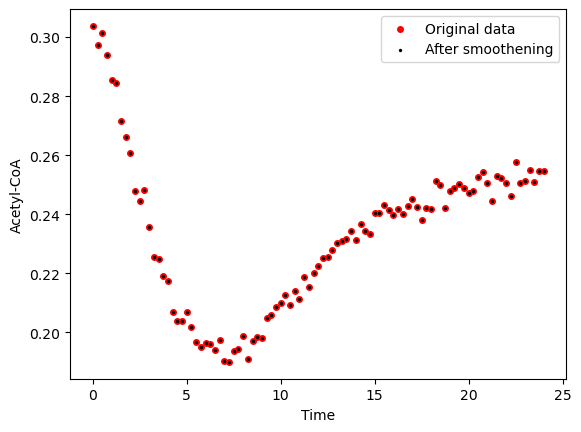

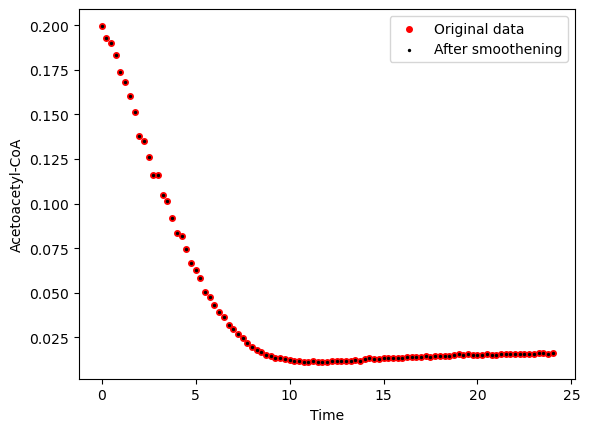

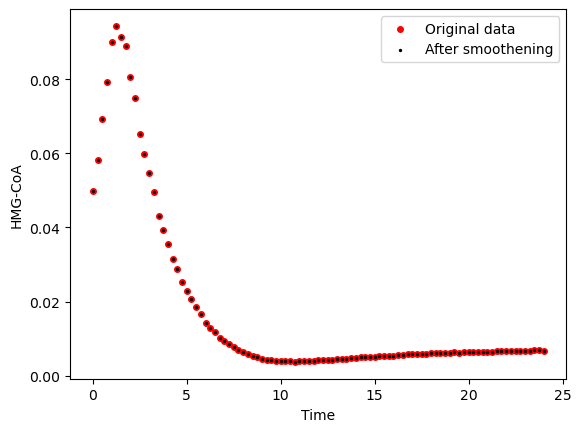

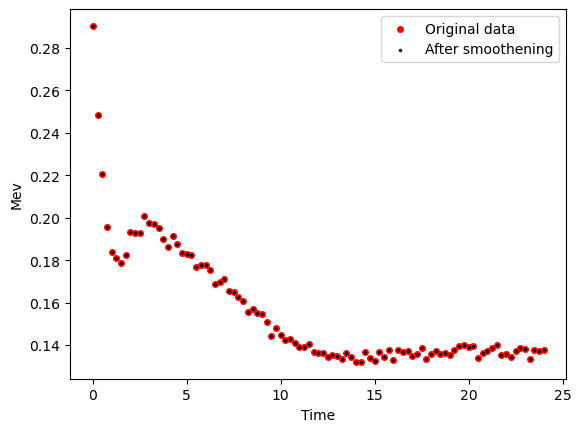

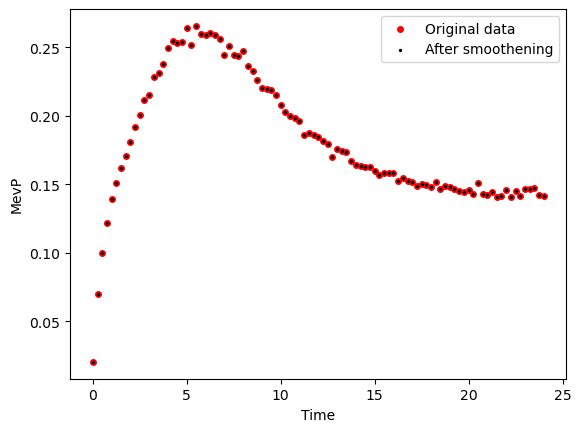

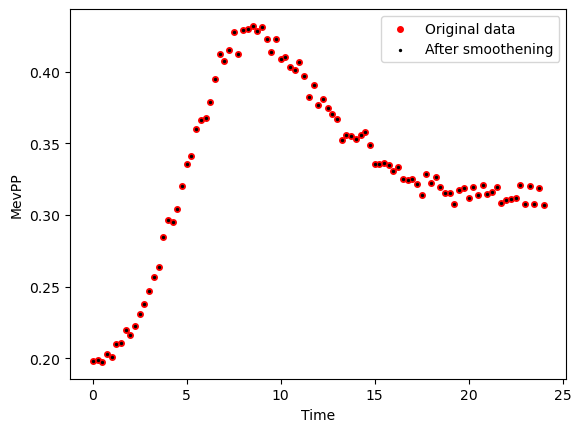

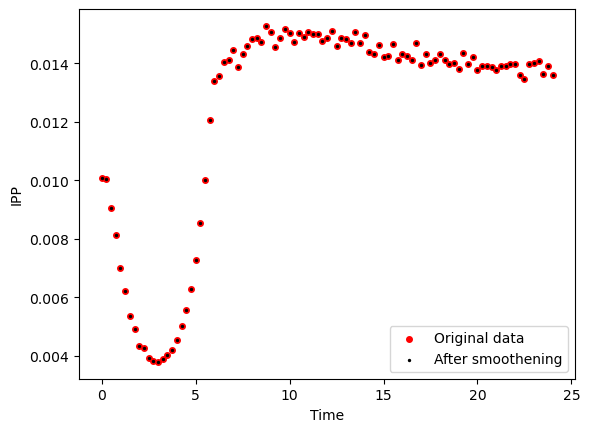

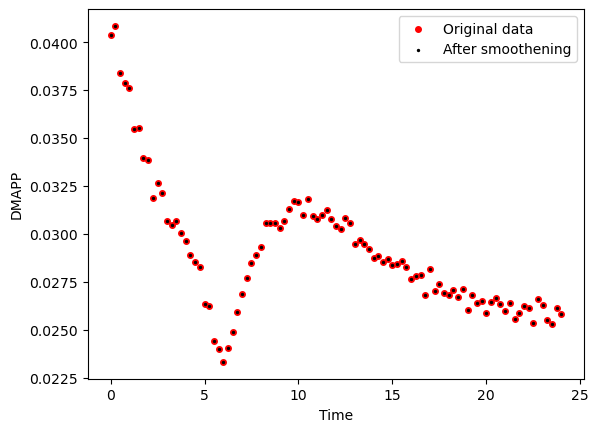

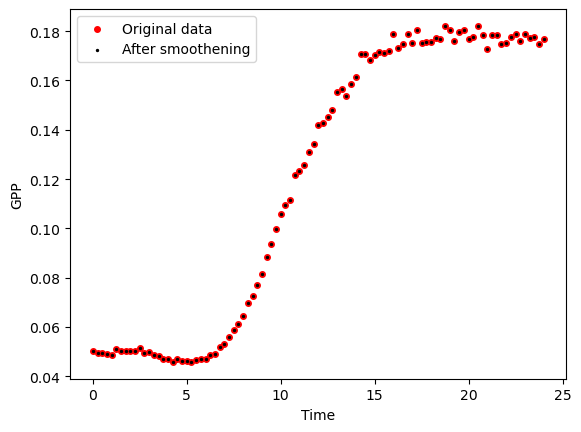

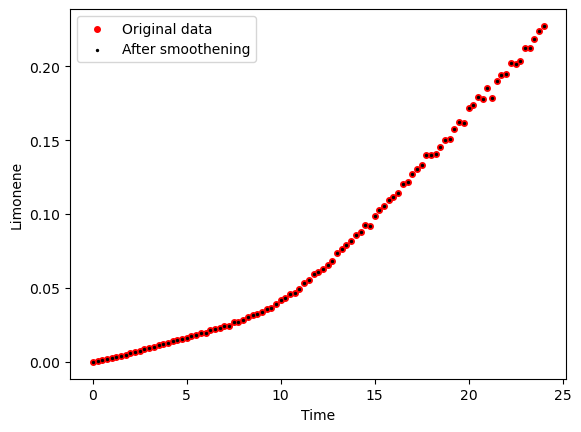

Strain Strain 2


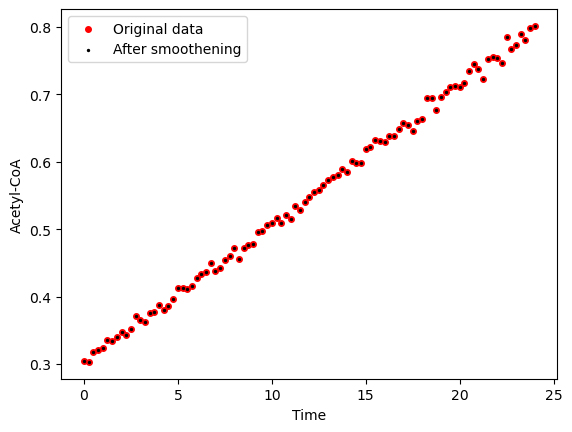

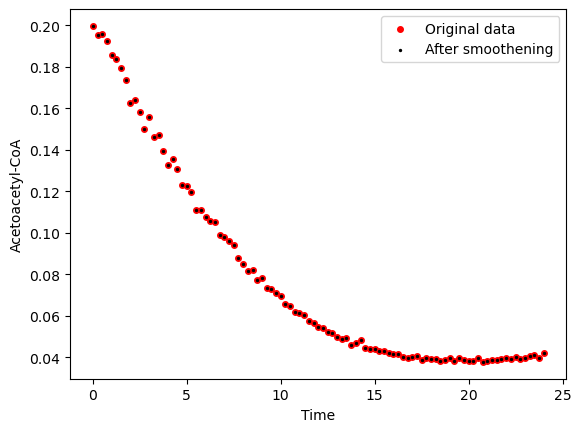

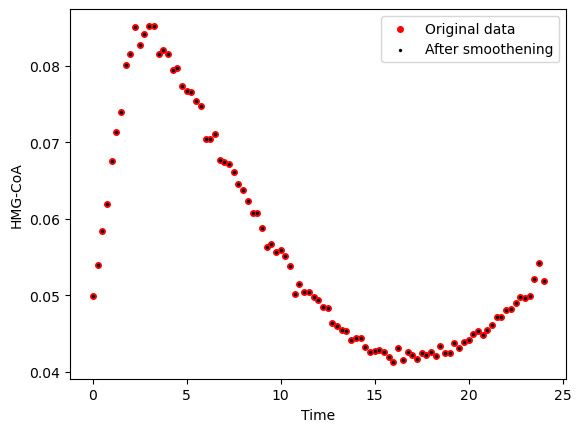

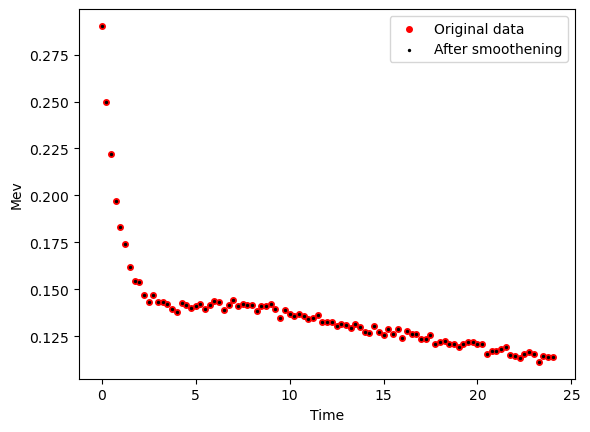

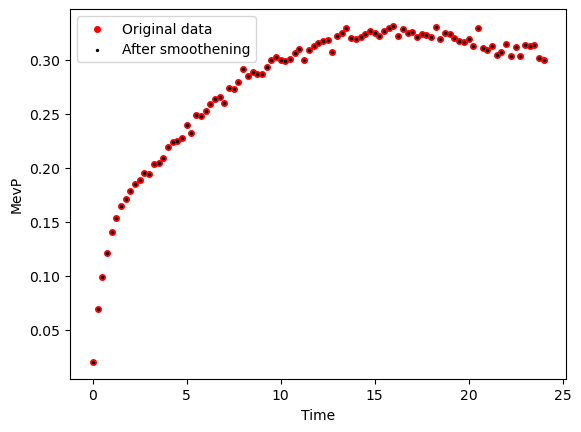

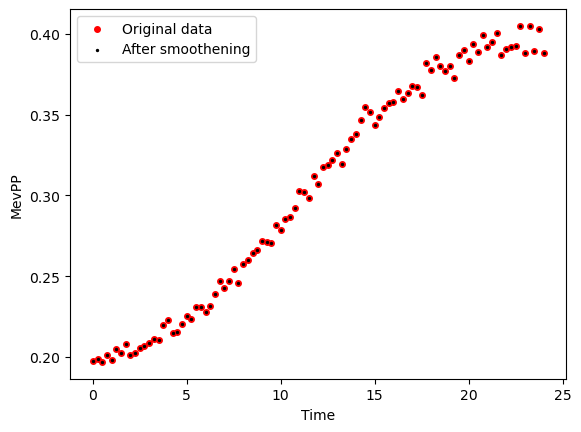

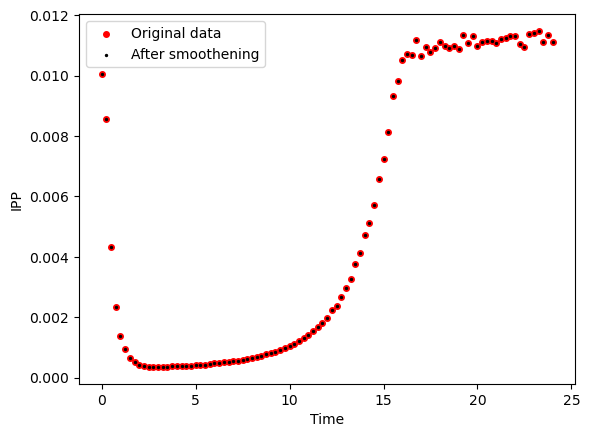

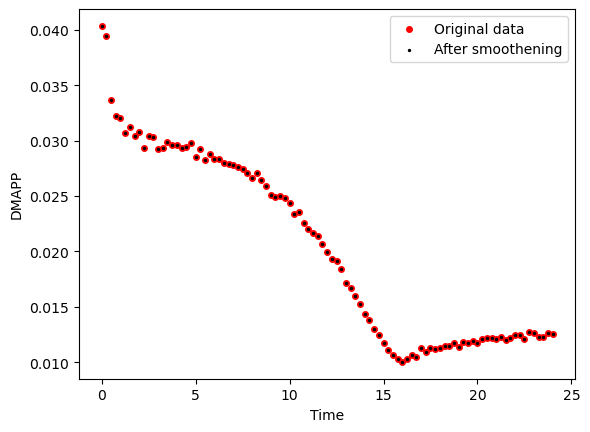

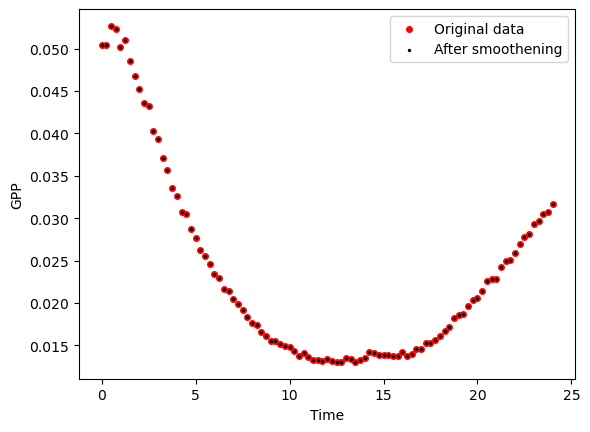

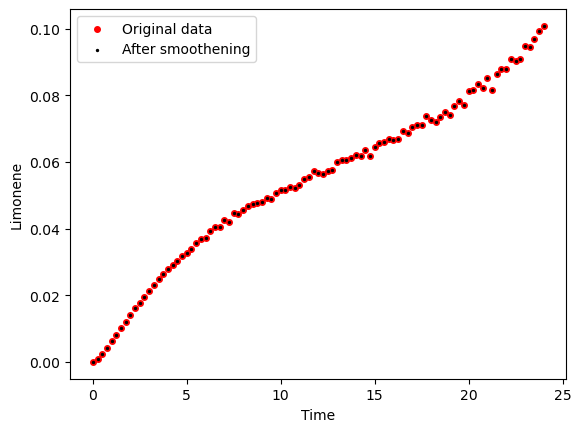

Strain Strain 3


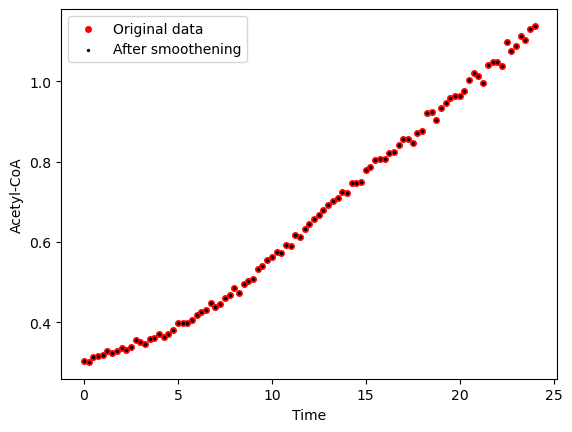

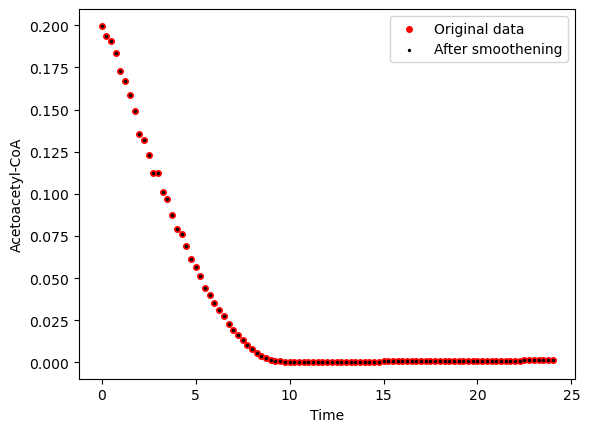

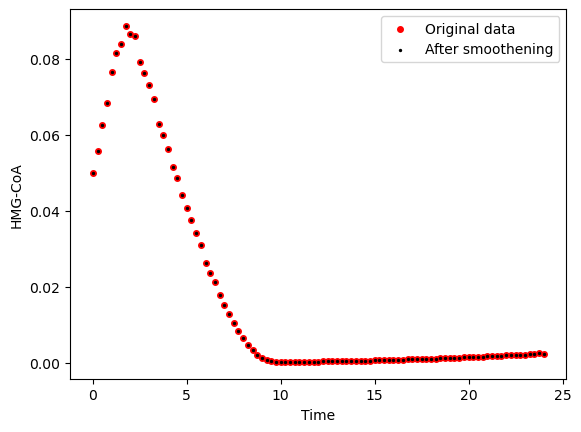

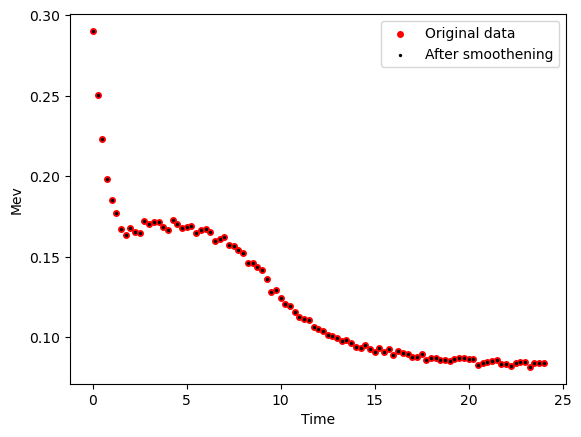

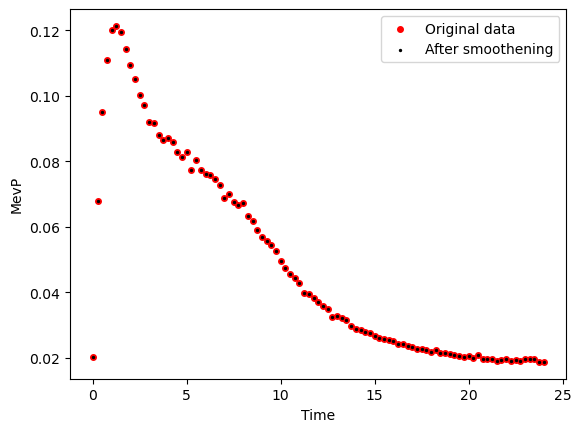

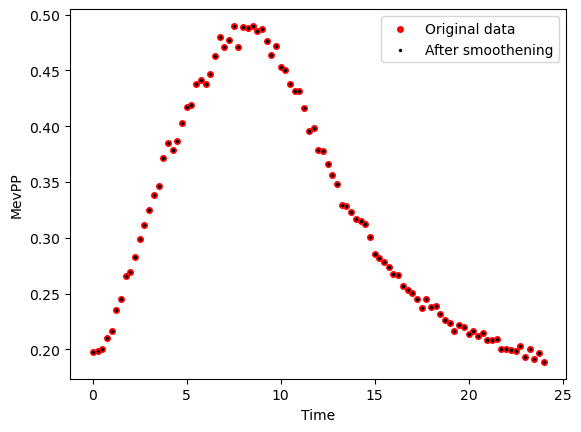

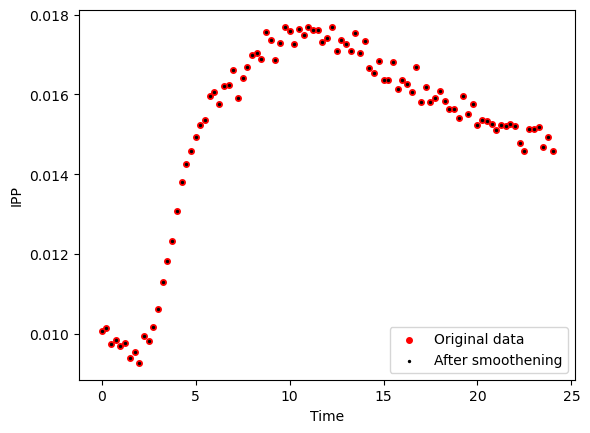

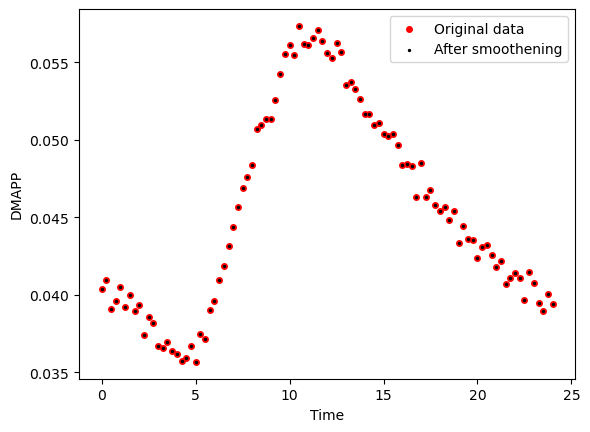

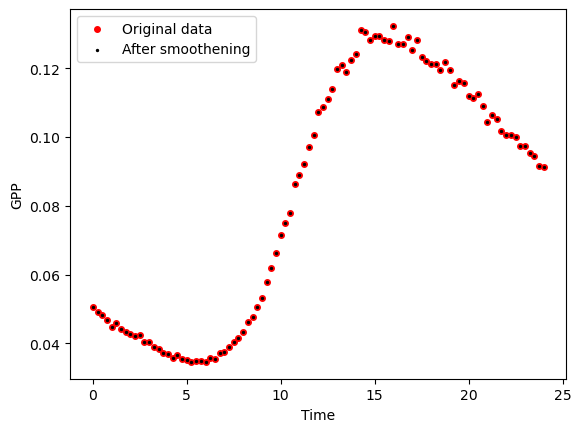

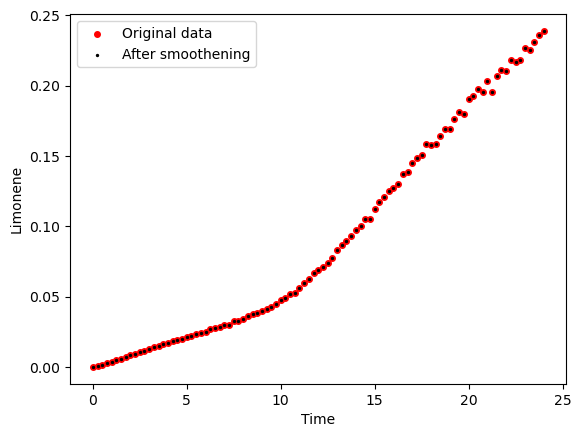

Strain WT


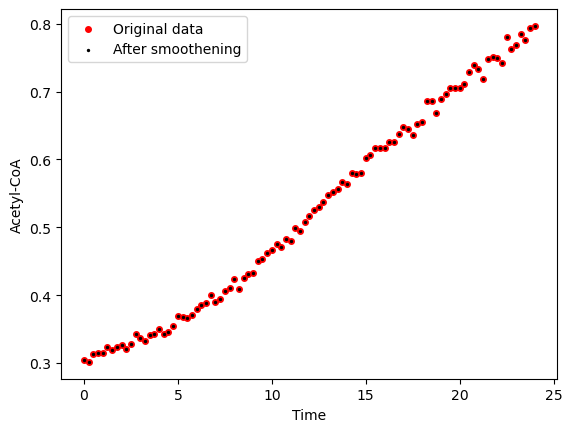

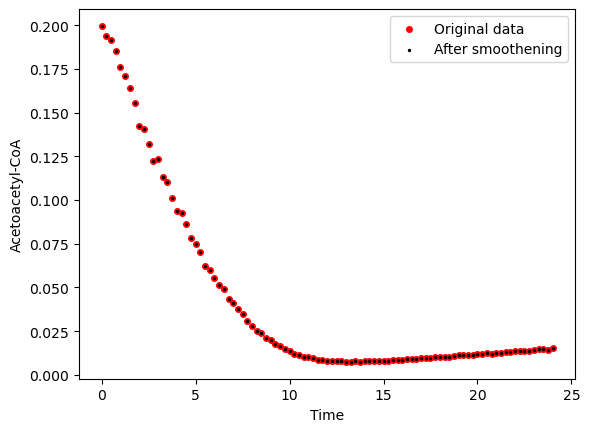

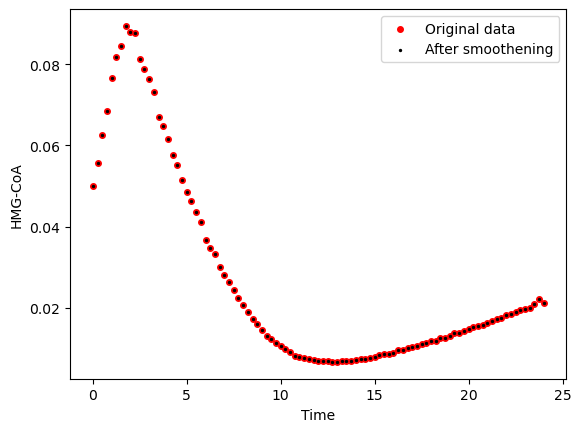

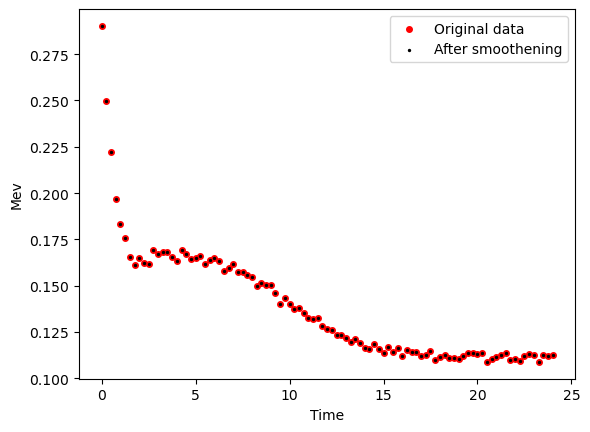

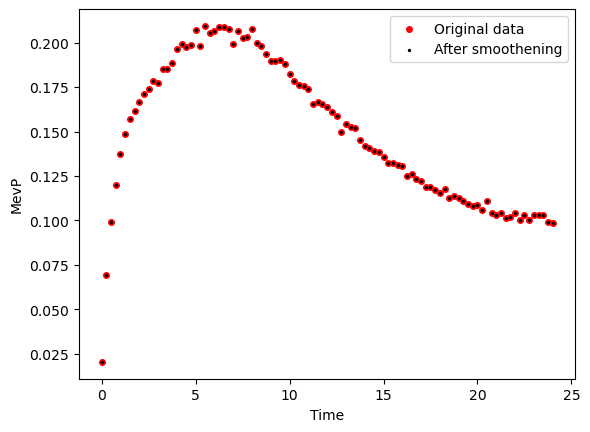

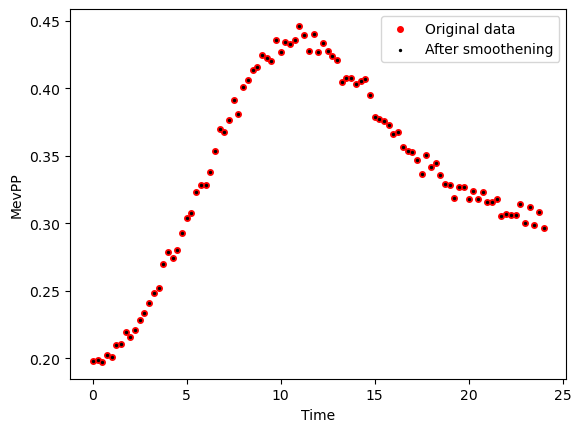

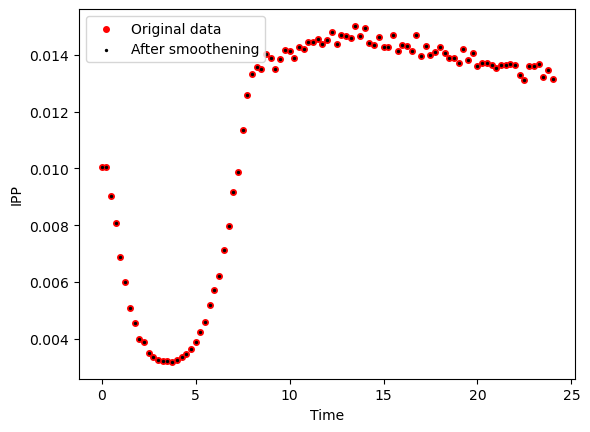

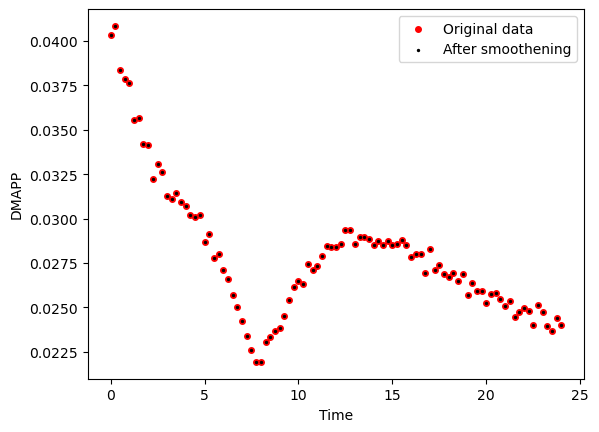

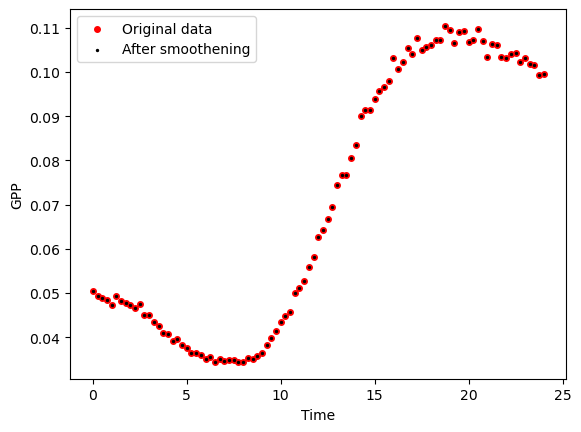

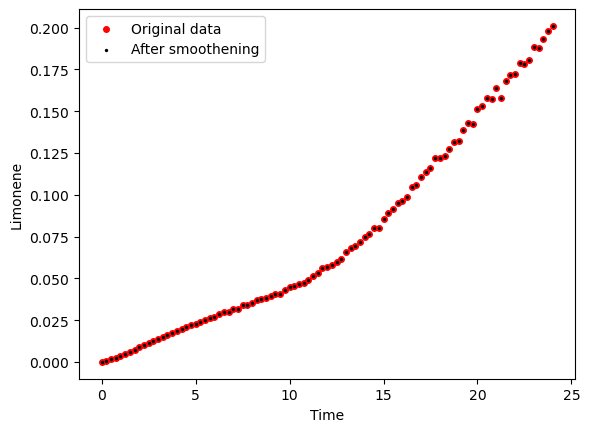

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


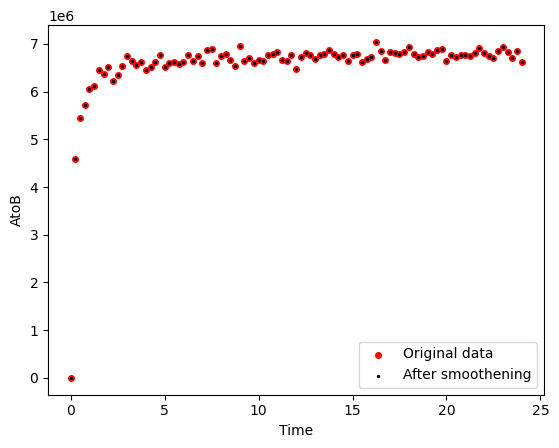

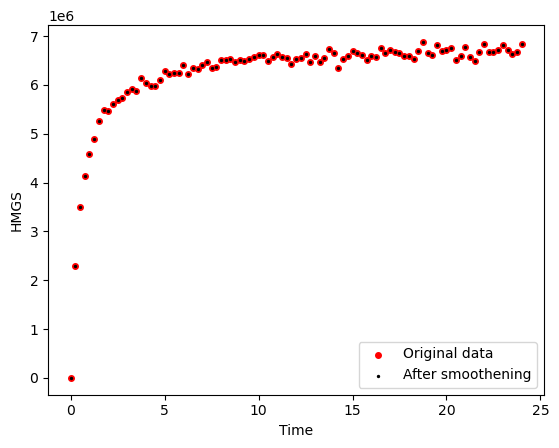

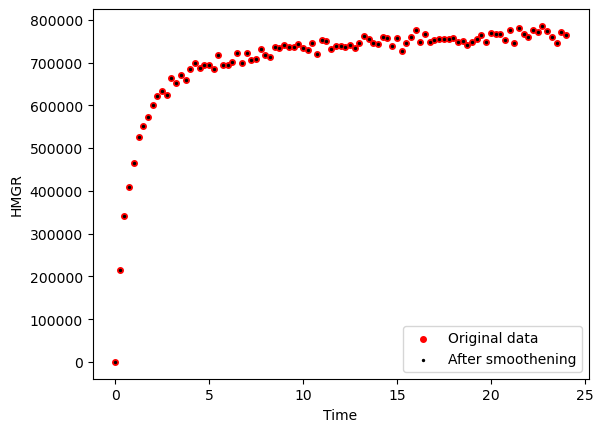

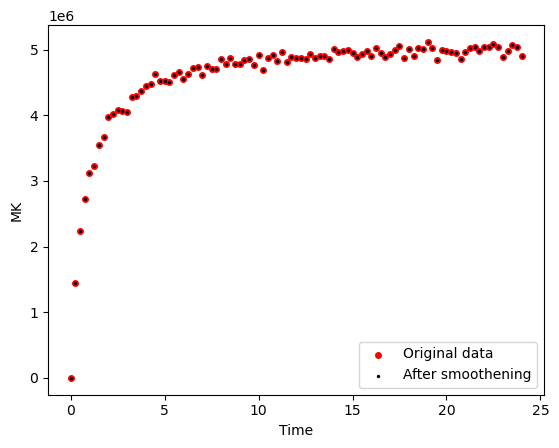

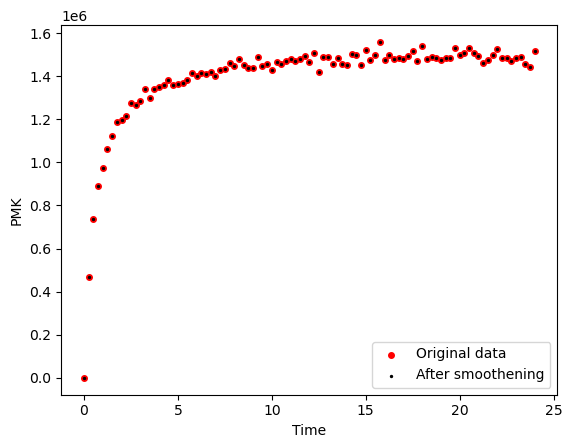

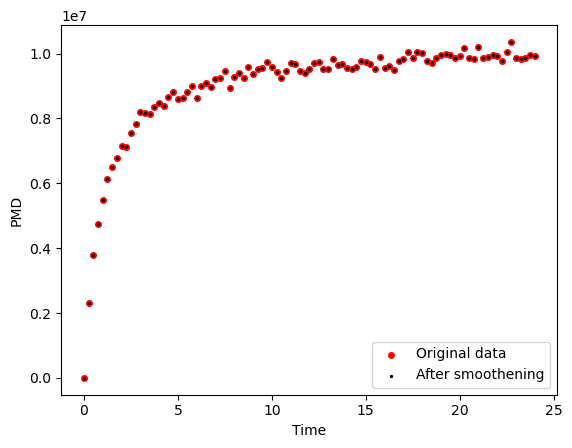

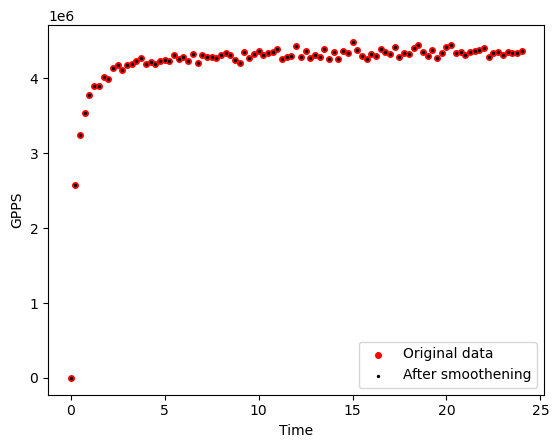

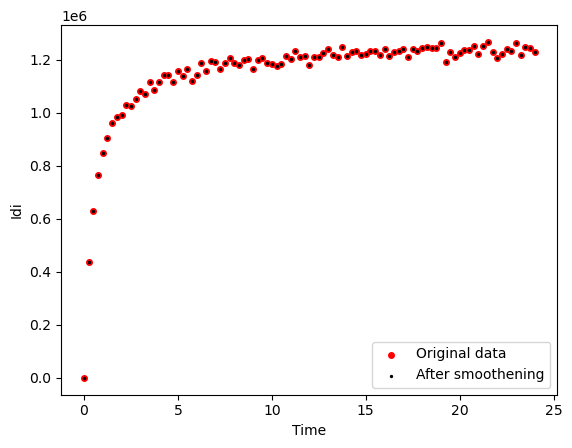

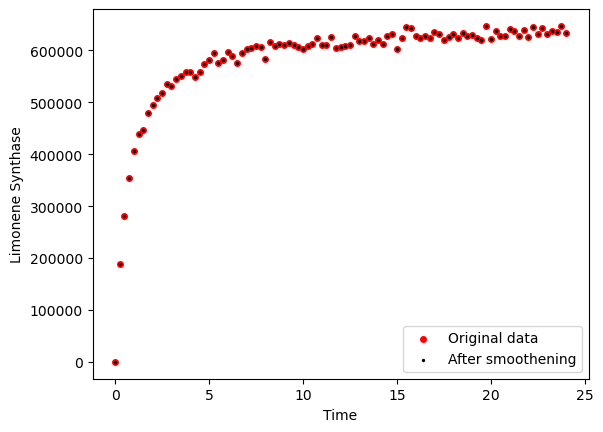

Strain Strain 2


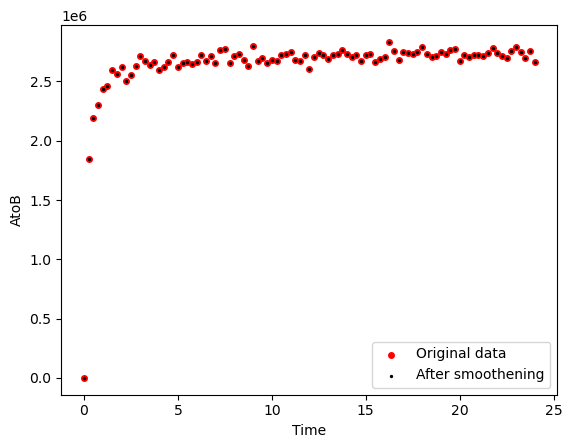

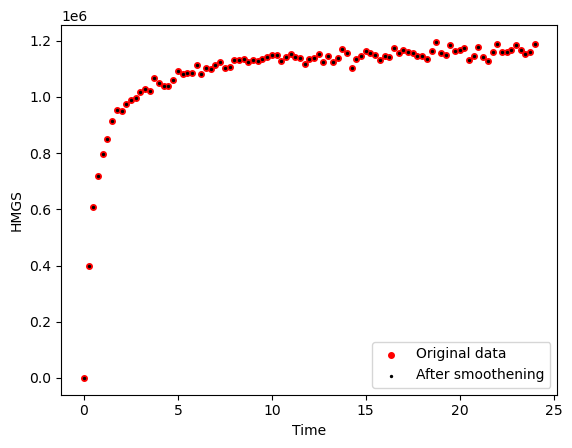

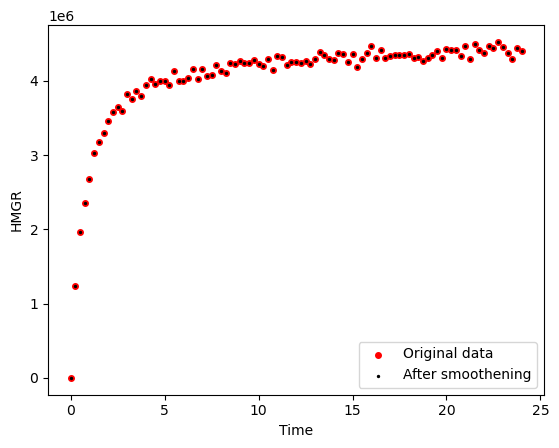

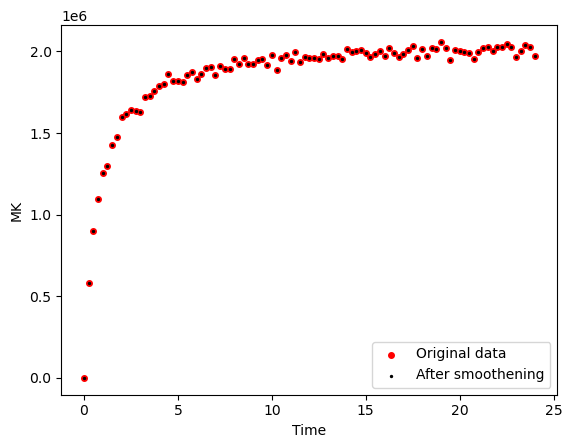

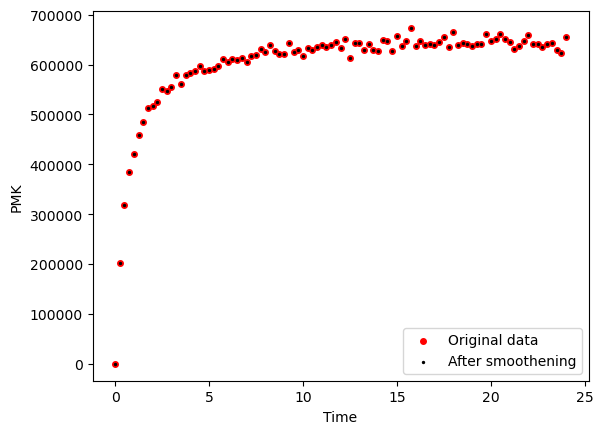

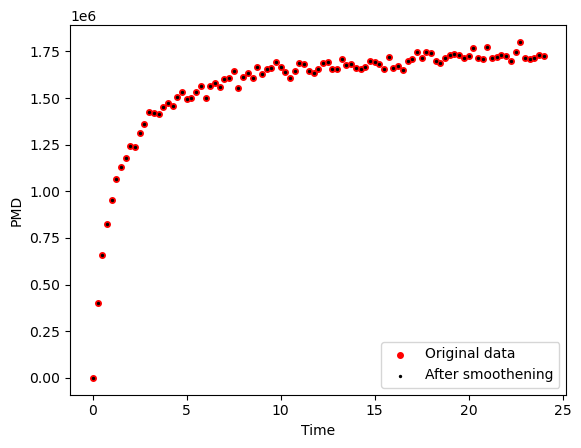

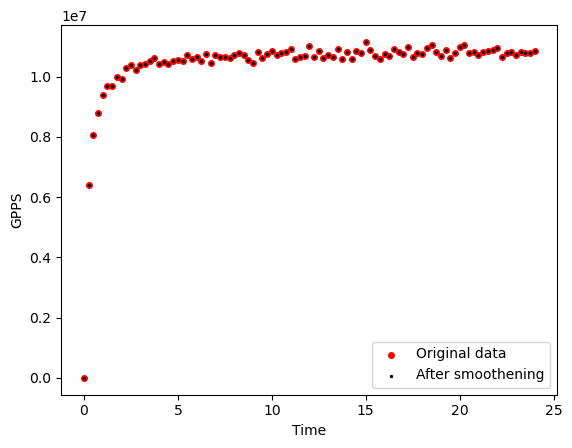

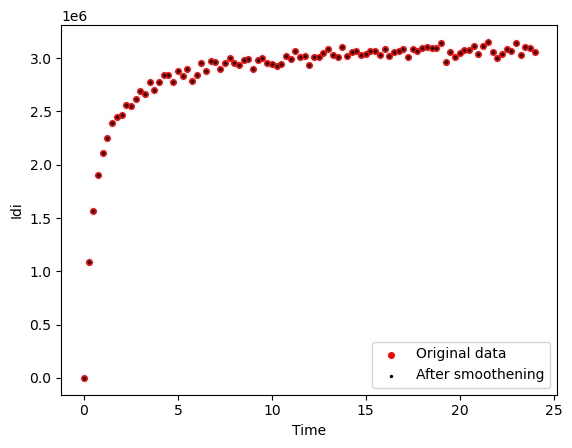

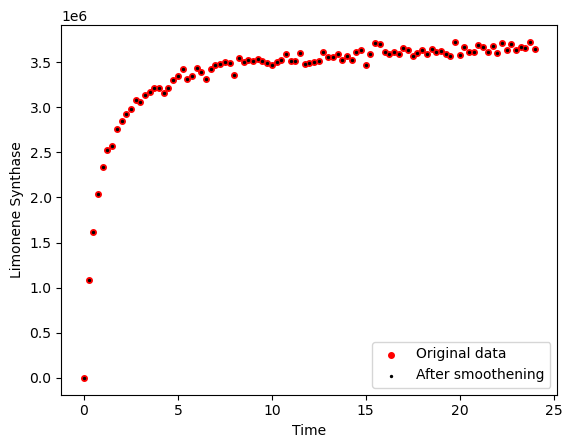

Strain Strain 3


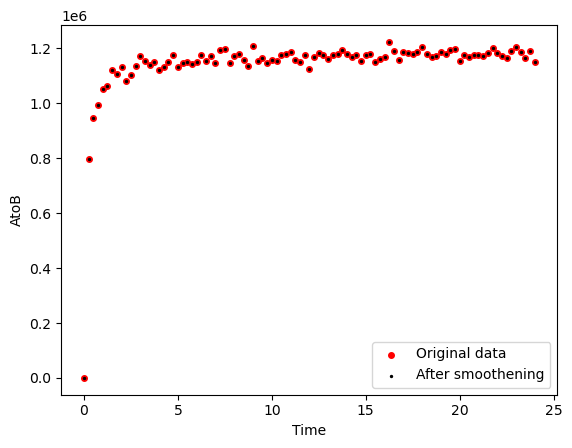

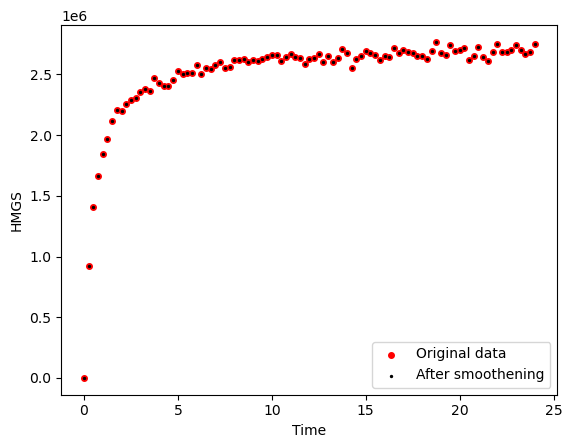

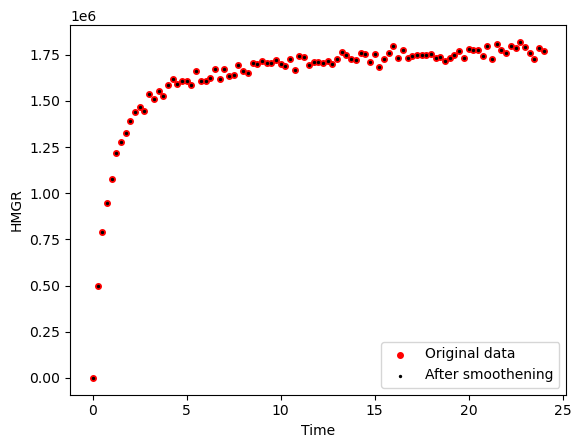

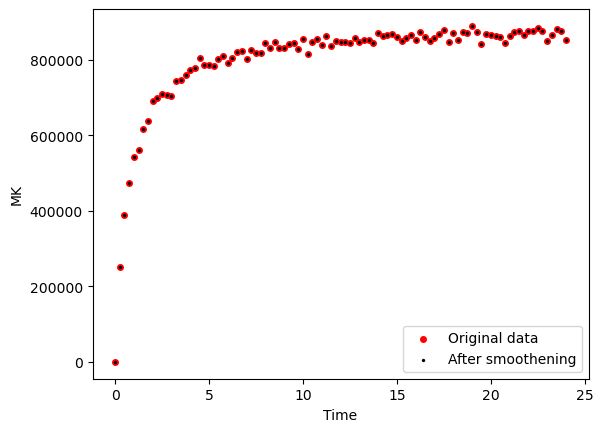

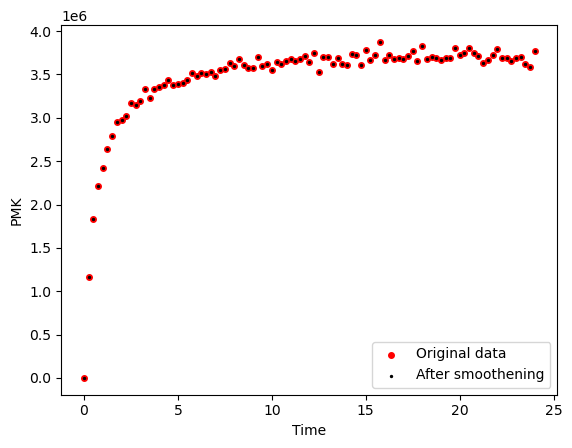

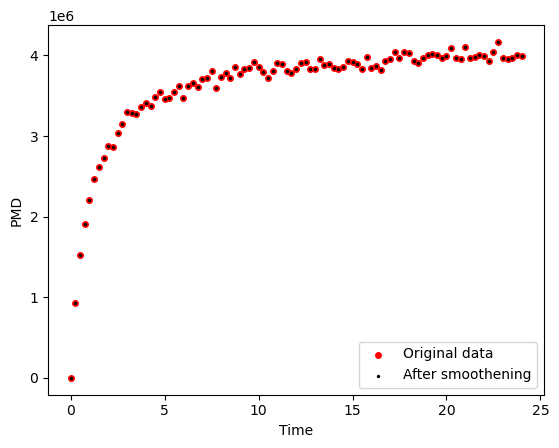

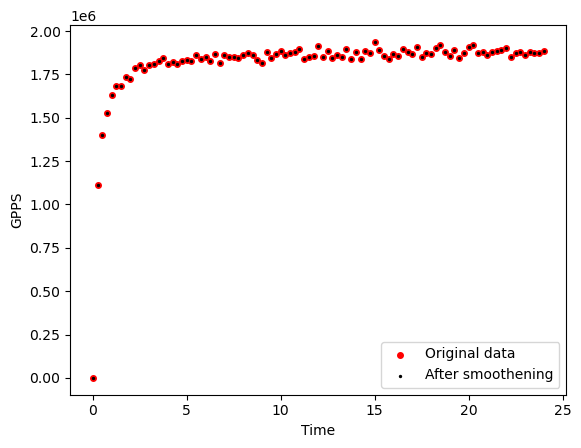

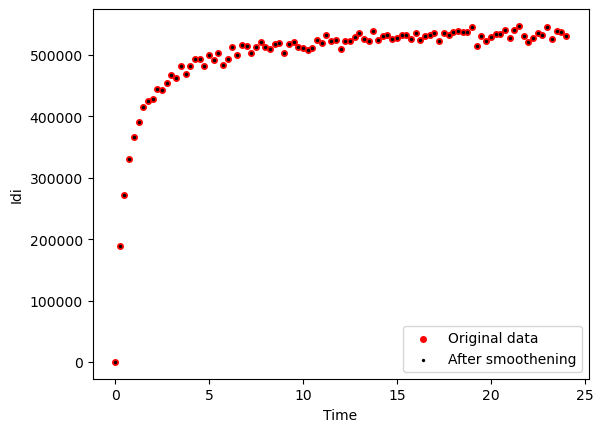

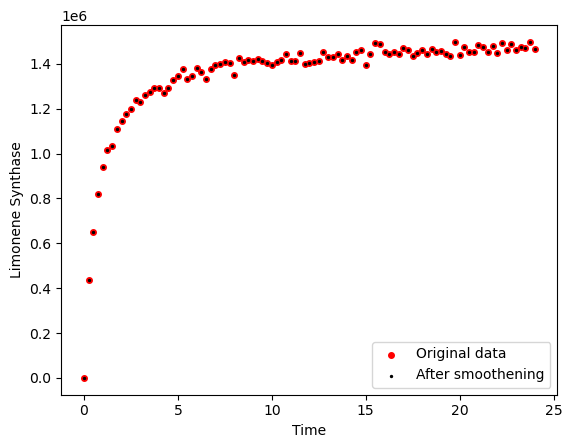

Strain WT


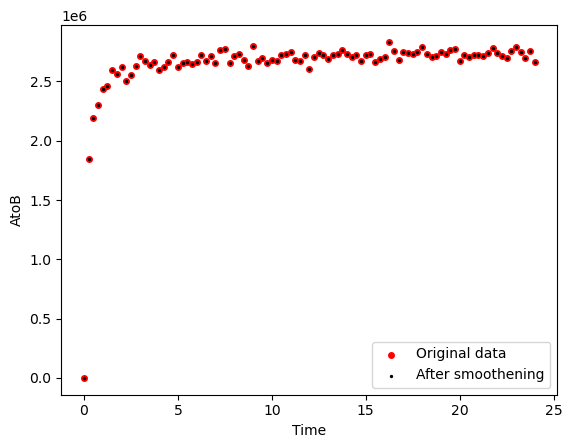

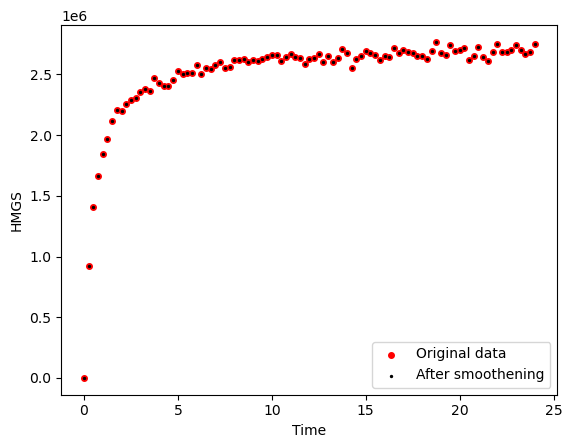

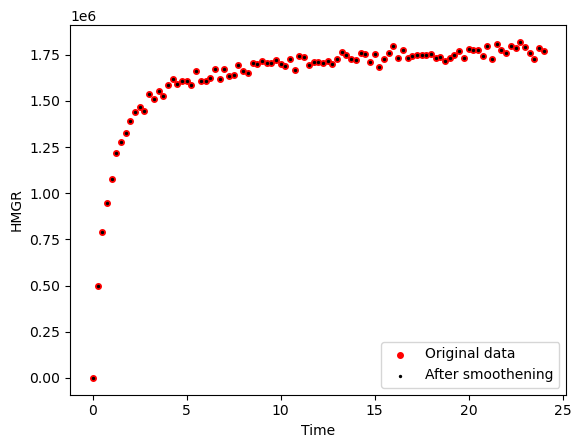

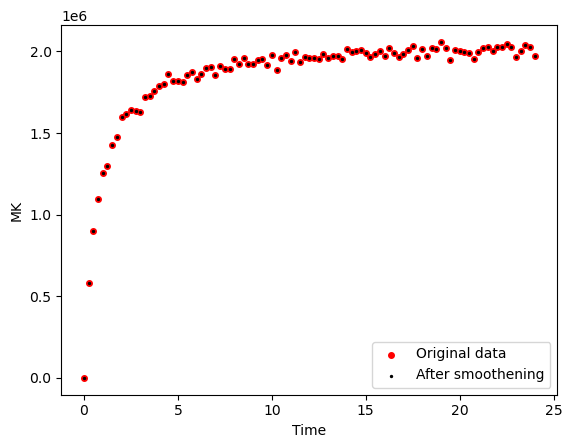

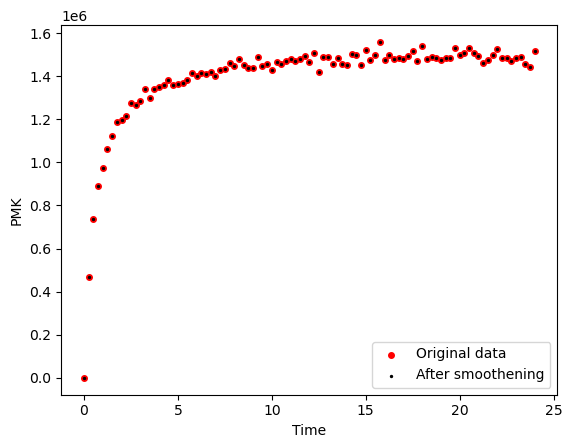

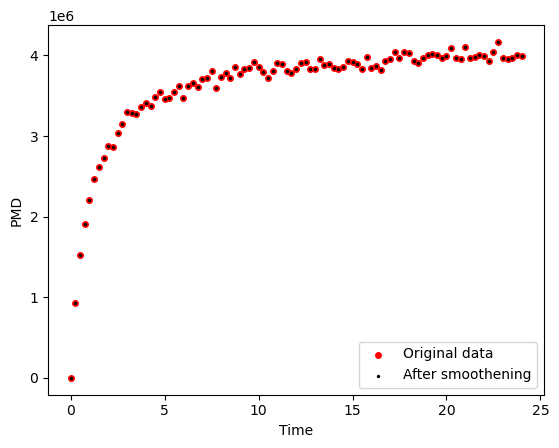

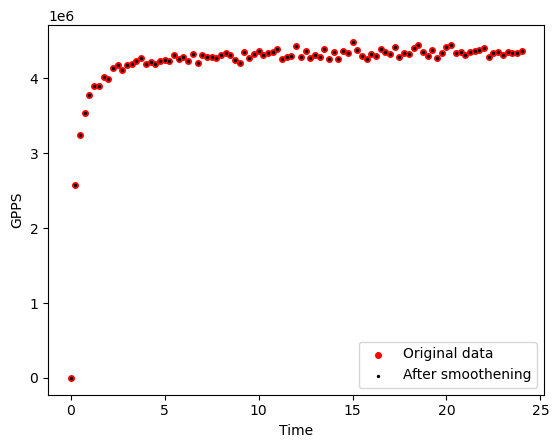

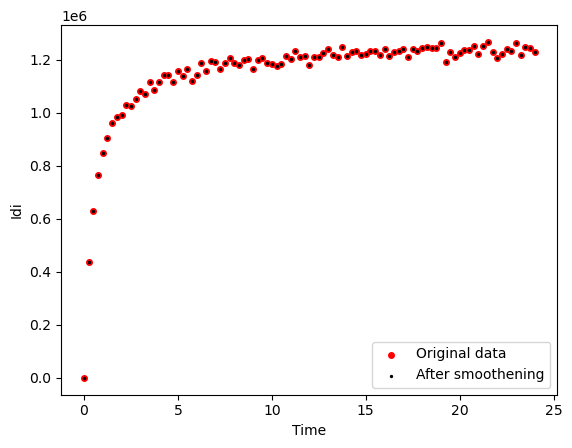

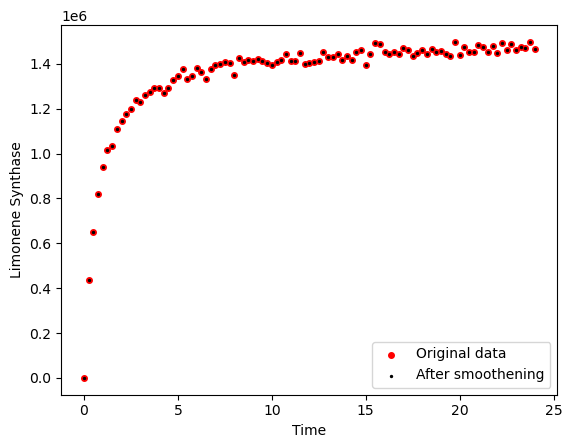

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.303775        0.199644  0.049881  0.290244  0.020348   
         0.25    0.297332        0.192987  0.058274  0.248439  0.070213   
         0.50    0.301426        0.190143  0.069352  0.220738  0.100173   
         0.75    0.293944        0.183535  0.079207  0.195724  0.121619   
         1.00    0.285485        0.173787  0.090185  0.184059  0.139288   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.769224        0.014075  0.019669  0.112578  0.103296   
         23.25   0.785095        0.014489  0.019931  0.108903  0.102898   
         23.50   0.776450        0.014718  0.021030  0.112413  0.103132   
         23.75   0.793054        0.014361  0.022105  0.112245  0.099320   
         24.00   0.796784        0.015254  0.021279  0.112532  0.098608   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.197797  0.010068  0.040352  0.050455  0.000000  ...   
         0.25   0.198518  0.010056  0.040849  0.049528  0.000381  ...   
         0.50   0.197364  0.009050  0.038381  0.049360  0.000962  ...   
         0.75   0.202837  0.008137  0.037858  0.049269  0.001704  ...   
         1.00   0.200781  0.007005  0.037615  0.048540  0.002470  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.300182  0.013600  0.024718  0.103254  0.188130  ...   
         23.25  0.311743  0.013662  0.023956  0.101739  0.187894  ...   
         23.50  0.298873  0.013209  0.023681  0.101541  0.193228  ...   
         23.75  0.308564  0.013453  0.024392  0.099273  0.197959  ...   
         24.00  0.296592  0.013155  0.024012  0.099637  0.200995  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.001850       -0.013098  0.036106 -0.177997  0.199033   
         0.25    -0.007068       -0.018782  0.038361 -0.142016  0.157374   
         0.50    -0.015987       -0.024466  0.040617 -0.106034  0.115715   
         0.75    -0.016725       -0.026359  0.037226 -0.068562  0.080391   
         1.00    -0.027558       -0.029903  0.023632 -0.039425  0.061280   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.005779        0.001013  0.001810 -0.001209  0.001409   
         23.25    0.027309        0.000829  0.002646 -0.000740 -0.000659   
         23.50    0.025231        0.000892  0.002158  0.001300 -0.005182   
         23.75    0.025783        0.001104  0.000900  0.003727 -0.007853   
         24.00    0.026334        0.001315 -0.000357  0.006153 -0.010525   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002890 -0.000764 -0.003917 -0.002178  0.001443  
         0.25   0.003503 -0.001991 -0.003652 -0.001907  0.001974  
         0.50   0.004115 -0.003218 -0.003386 -0.001636  0.002505  
         0.75   0.010566 -0.003886 -0.004590  0.000907  0.002923  
         1.00   0.013311 -0.003718 -0.003251  0.001521  0.003188  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.006662  0.000106 -0.000711 -0.002420  0.014961  
         23.25 -0.005010 -0.000281 -0.001001 -0.003048  0.016149  
         23.50 -0.004143 -0.000440 -0.000391 -0.003880  0.014318  
         23.75 -0.018147 -0.000453  0.000609 -0.002916  0.017712  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

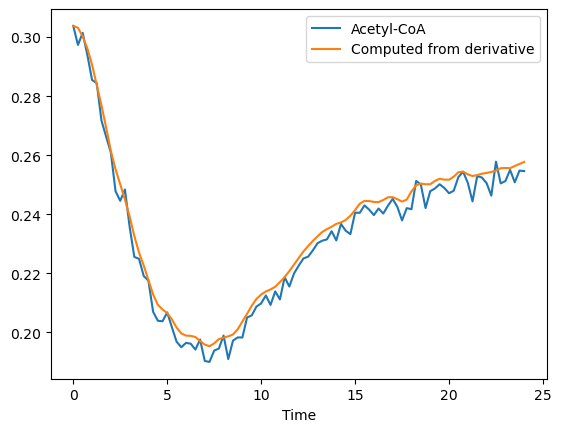

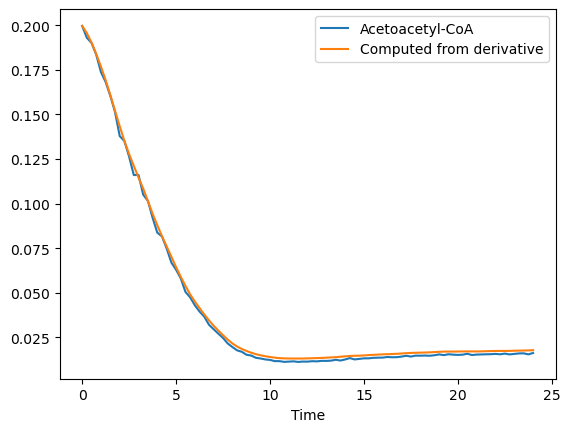

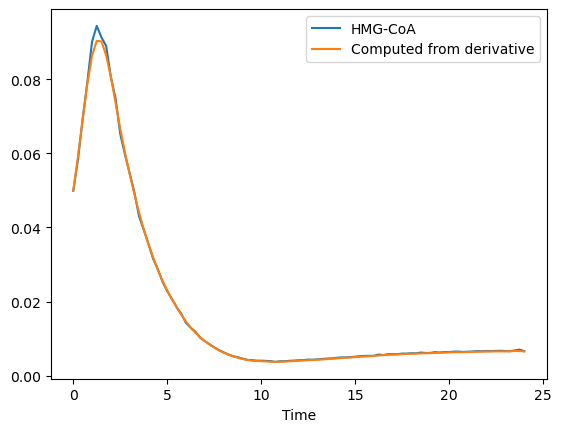

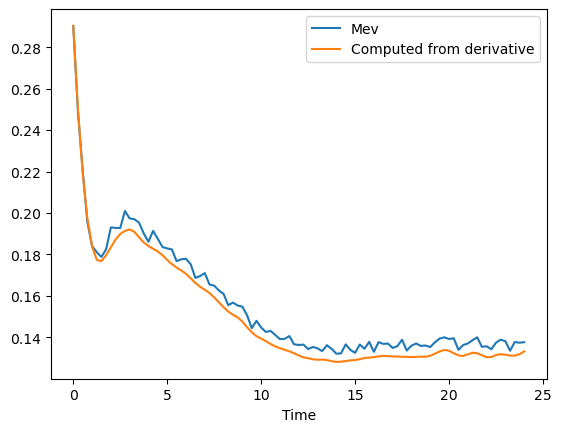

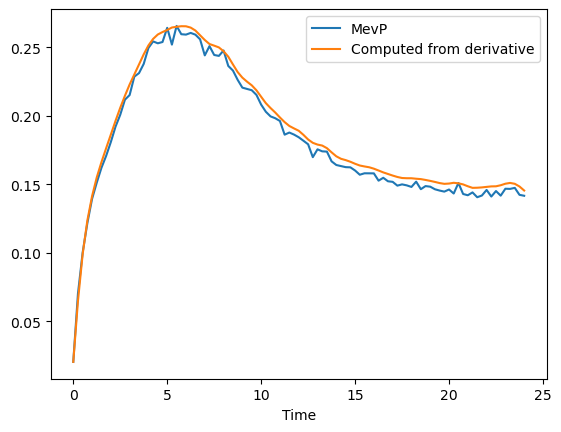

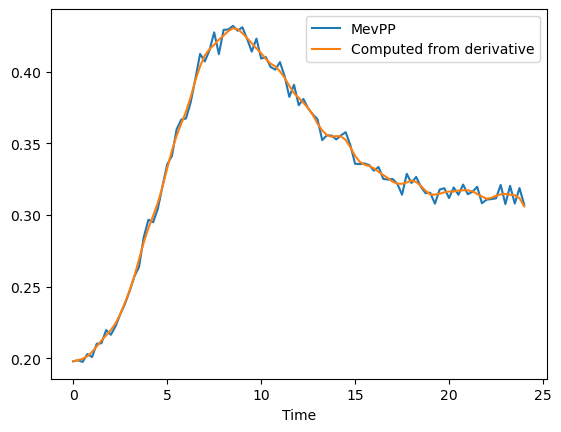

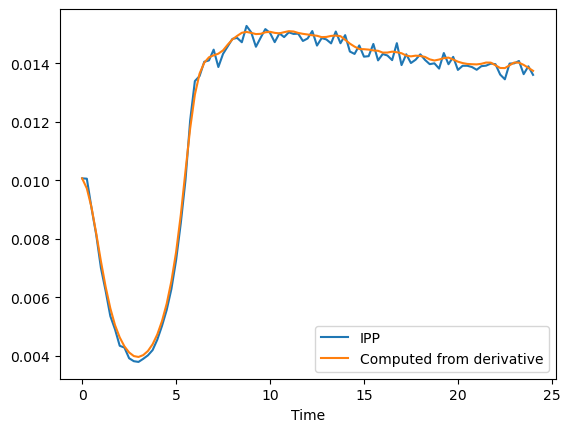

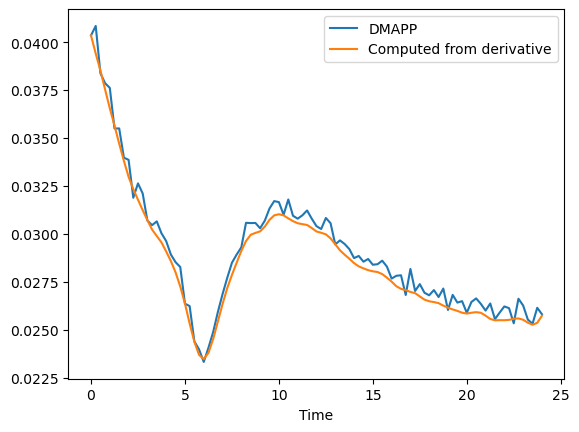

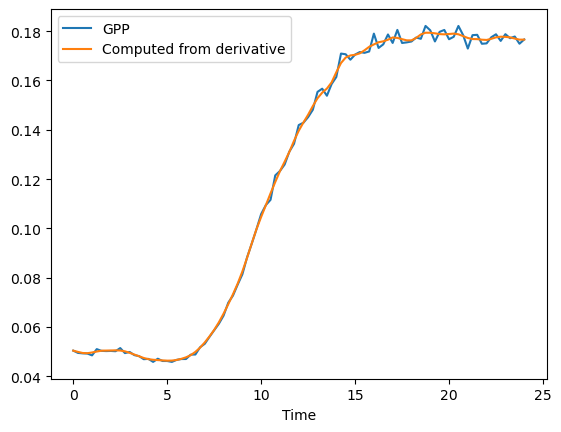

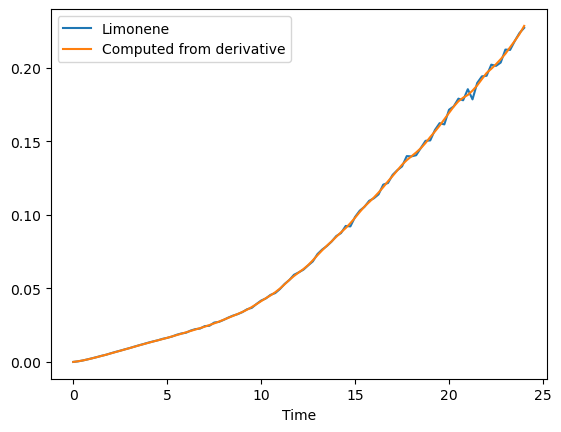

'Time profile from derivative vs. actual profile for Strain 2'

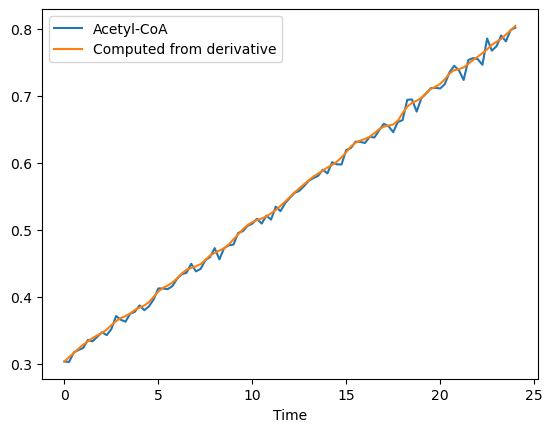

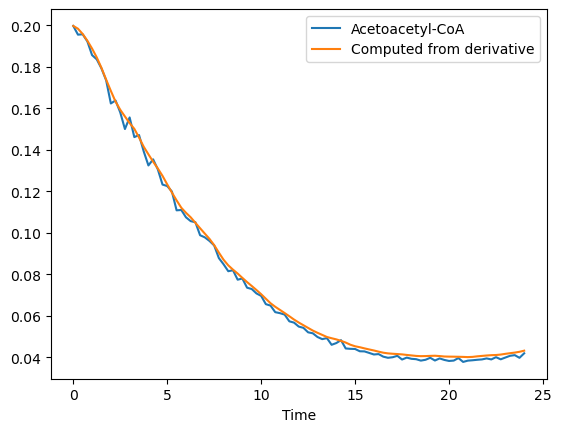

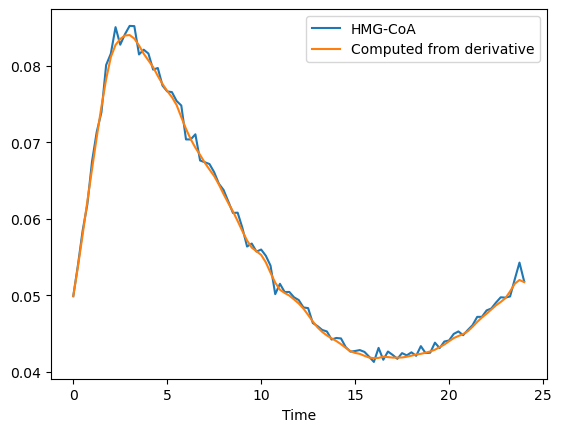

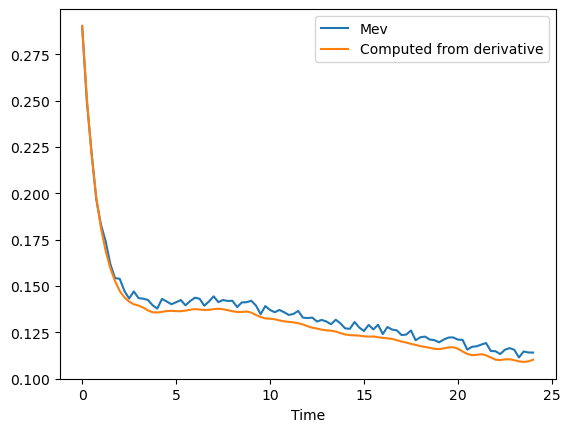

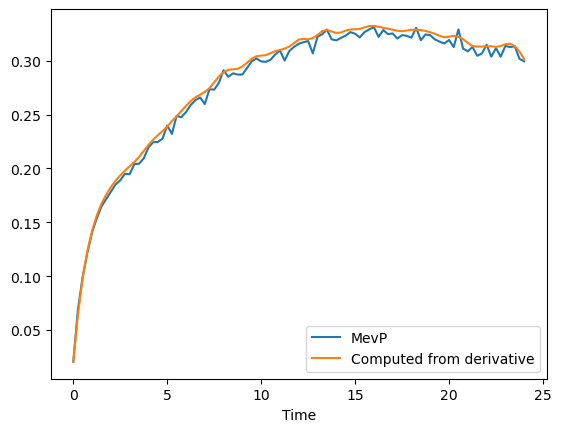

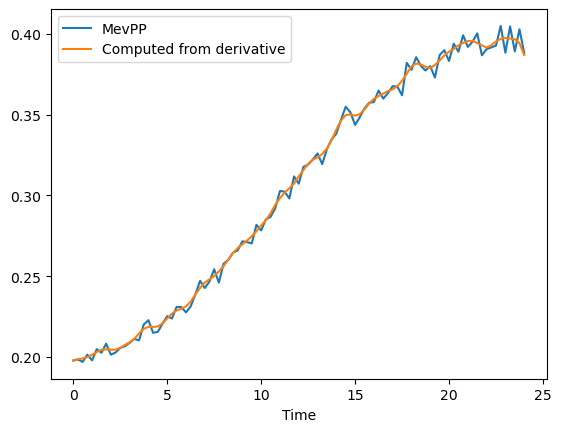

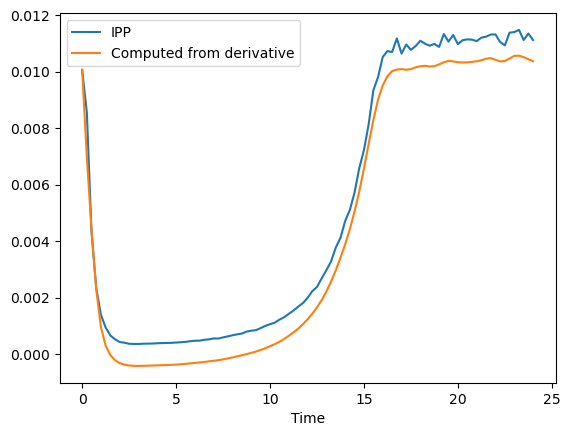

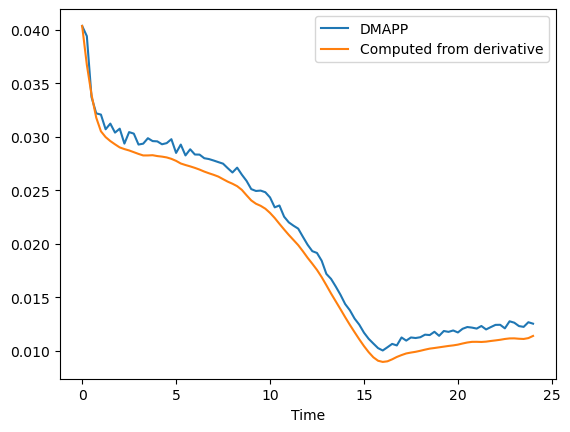

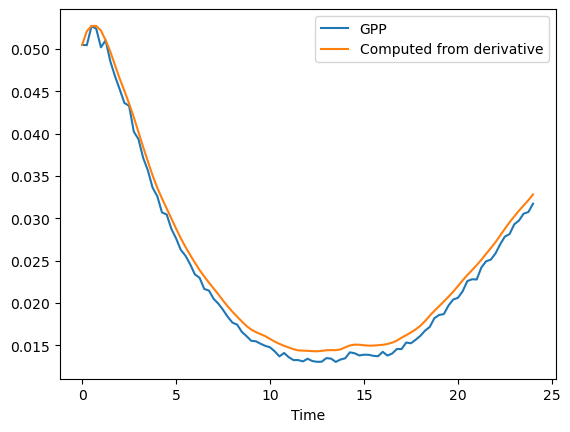

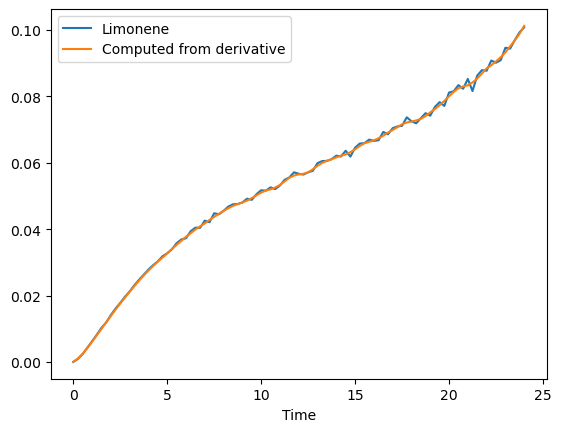

'Time profile from derivative vs. actual profile for Strain 3'

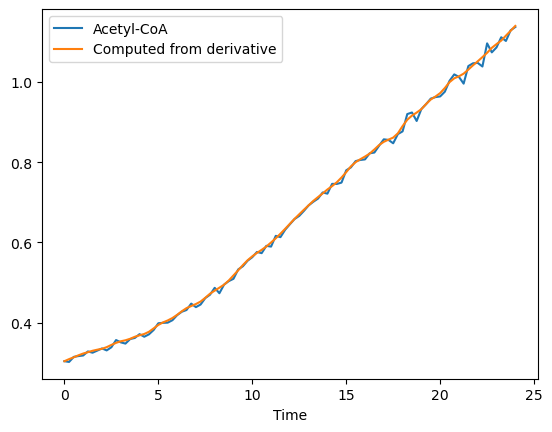

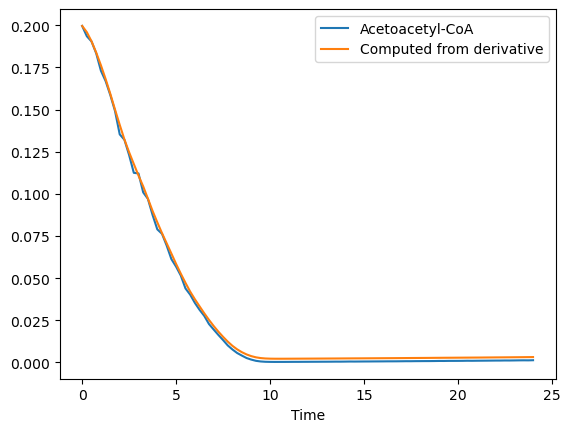

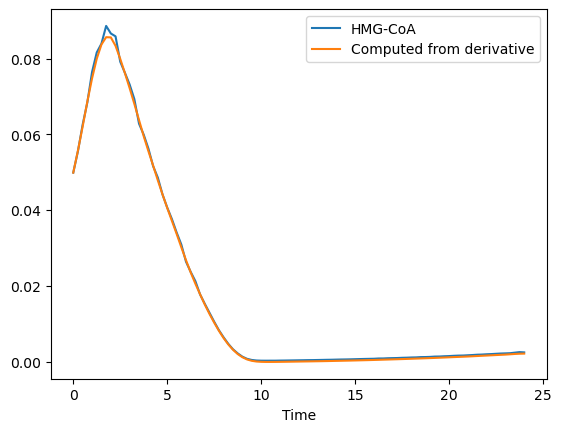

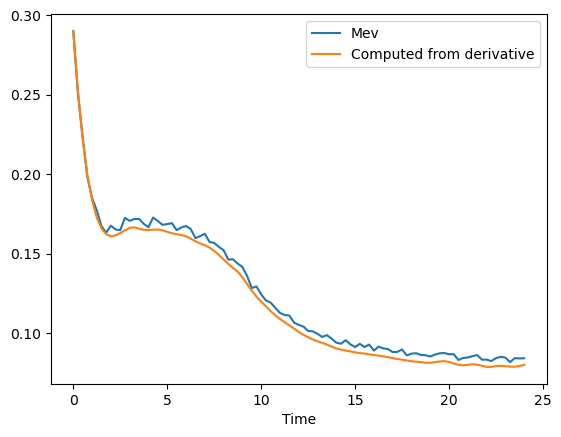

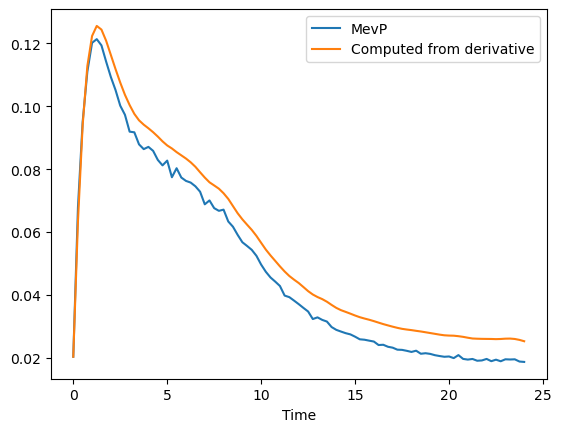

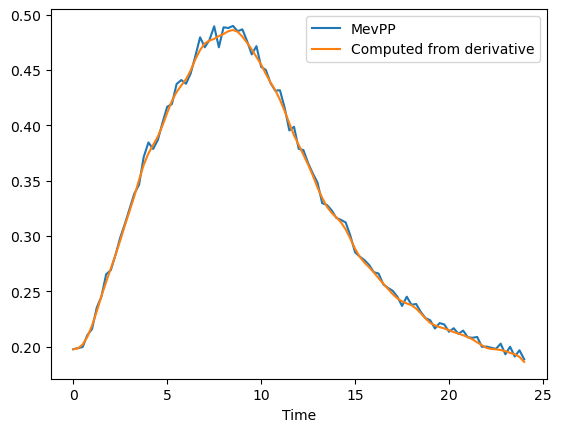

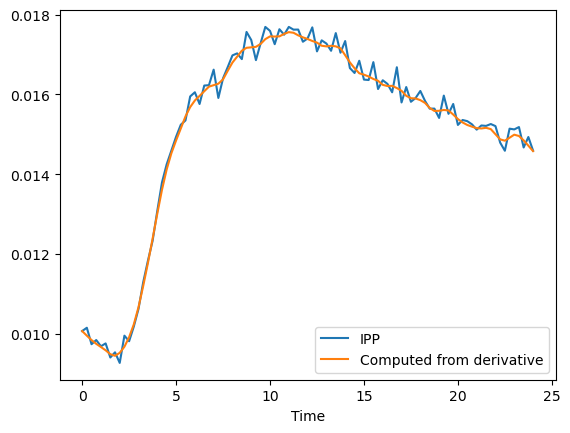

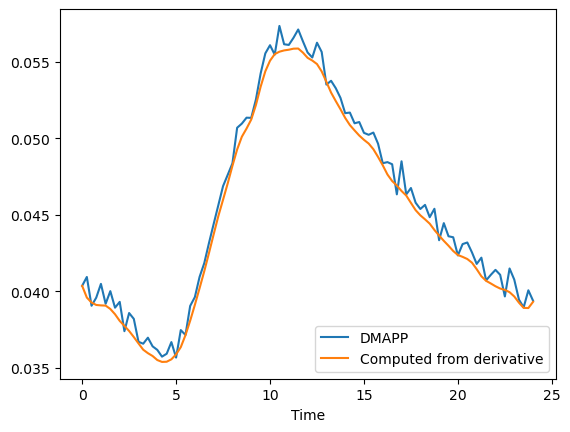

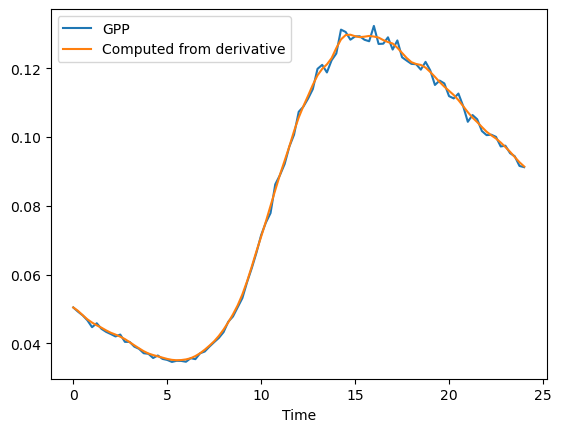

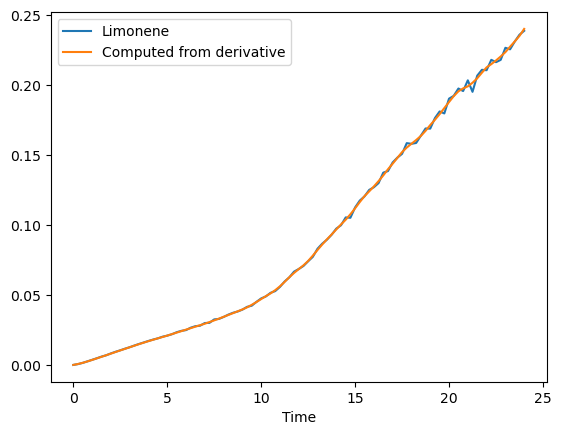

'Time profile from derivative vs. actual profile for WT'

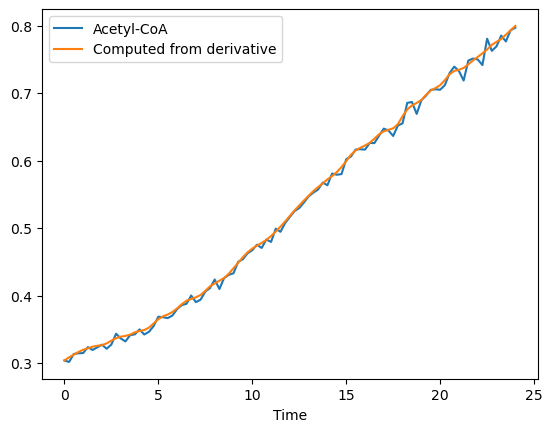

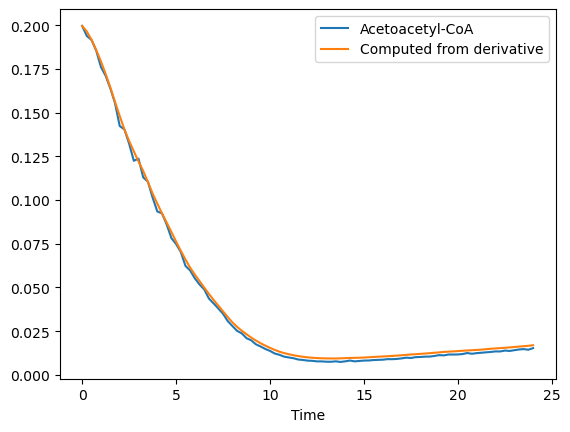

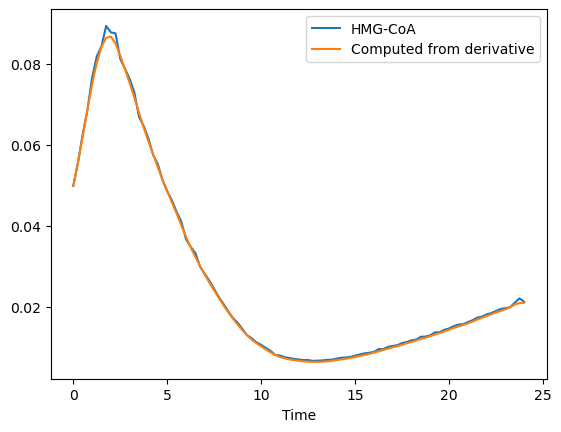

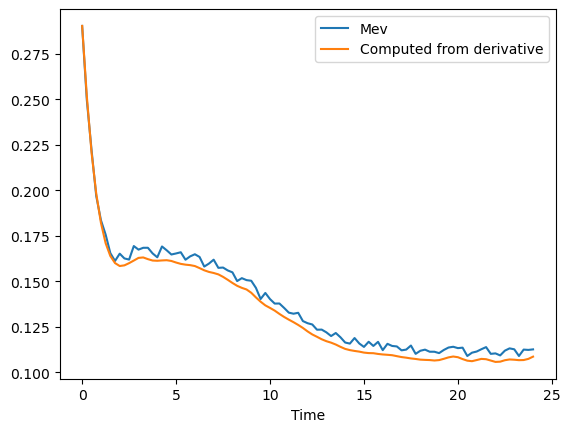

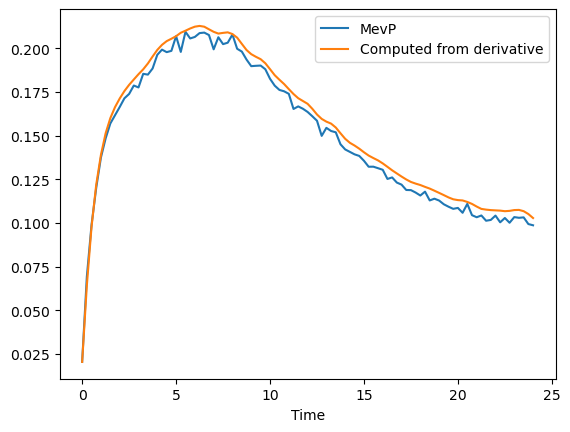

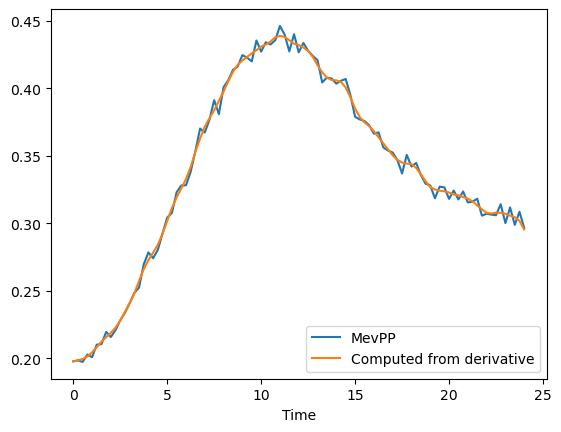

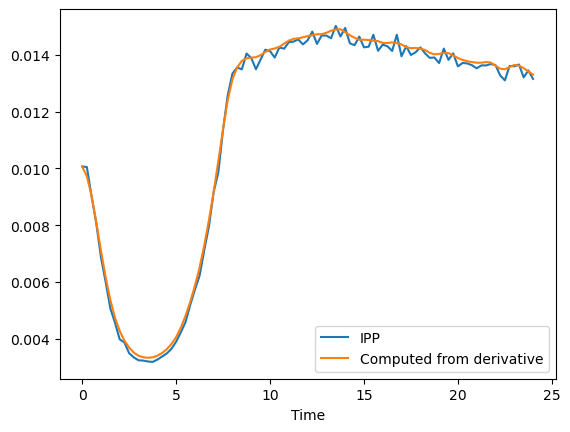

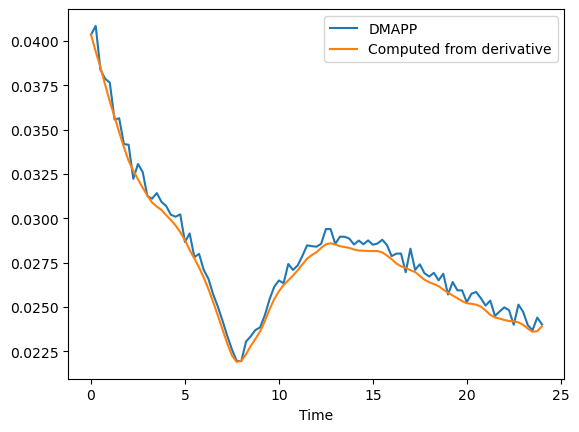

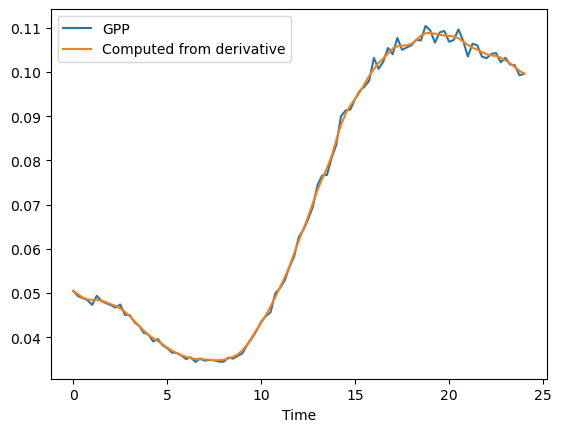

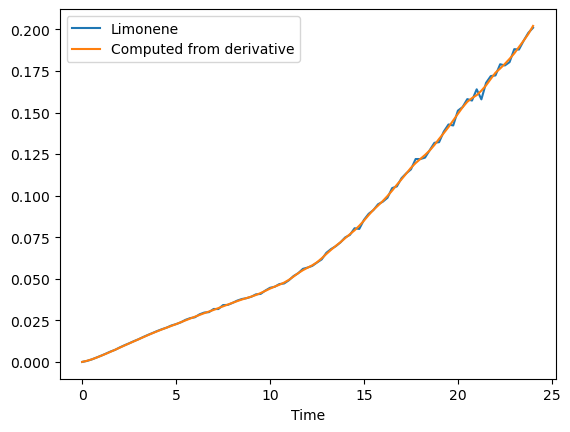

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.021797e+01  3.965937e+01  3.688062e+01  5.574897e+01   
         0.25   4.597010e+06  2.294929e+06  2.142199e+05  1.441146e+06   
         0.50   5.451159e+06  3.497433e+06  3.411840e+05  2.236004e+06   
         0.75   5.726004e+06  4.126494e+06  4.088181e+05  2.730130e+06   
         1.00   6.057275e+06  4.578212e+06  4.650788e+05  3.116428e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.793791e+06  2.738508e+06  1.790636e+06  1.966353e+06   
         23.25  2.746174e+06  2.697411e+06  1.756996e+06  2.003719e+06   
         23.50  2.698579e+06  2.671747e+06  1.725002e+06  2.042148e+06   
         23.75  2.757368e+06  2.681689e+06  1.787784e+06  2.026437e+06   
         24.00  2.666181e+06  2.746572e+06  1.769606e+06  1.972738e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.706286e+01  5.388111e+01  5.585060e+01  1.885230e+01   
         0.25   4.699780e+05  2.319278e+06  2.580479e+06  4.355049e+05   
         0.50   7.381283e+05  3.792402e+06  3.246965e+06  6.298491e+05   
         0.75   8.892703e+05  4.747093e+06  3.533031e+06  7.660397e+05   
         1.00   9.754842e+05  5.500615e+06  3.769851e+06  8.493837e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.482486e+06  3.965407e+06  4.311209e+06  1.264628e+06   
         23.25  1.489485e+06  3.960609e+06  4.348569e+06  1.216766e+06   
         23.50  1.458418e+06  3.966576e+06  4.333144e+06  1.247226e+06   
         23.75  1.441278e+06  4.010404e+06  4.335370e+06  1.245131e+06   
         24.00  1.518104e+06  3.997498e+06  4.359388e+06  1.231153e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.061737e+01   0.303775        0.199644  0.049881   
         0.25       1.880093e+05   0.297332        0.192987  0.058274   
         0.50       2.804316e+05   0.301426        0.190143  0.069352   
         0.75       3.543398e+05   0.293944        0.183535  0.079207   
         1.00       4.066978e+05   0.285485        0.173787  0.090185   
...                          ...        ...             ...       ...   
WT       23.00      1.460242e+06   0.769224        0.014075  0.019669   
         23.25      1.473482e+06   0.785095        0.014489  0.019931   
         23.50      1.469301e+06   0.776450        0.014718  0.021030   
         23.75      1.497003e+06   0.793054        0.014361  0.022105   
         24.00      1.463968e+06   0.796784        0.015254  0.021279   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.290244  0.020348  0.197797  0.010068  0.040352  0.050455   
         0.25   0.248439  0.070213  0.198518  0.010056  0.040849  0.049528   
         0.50   0.220738  0.100173  0.197364  0.009050  0.038381  0.049360   
         0.75   0.195724  0.121619  0.202837  0.008137  0.037858  0.049269   
         1.00   0.184059  0.139288  0.200781  0.007005  0.037615  0.048540   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112578  0.103296  0.300182  0.013600  0.024718  0.103254   
         23.25  0.108903  0.102898  0.311743  0.013662  0.023956  0.101739   
         23.50  0.112413  0.103132  0.298873  0.013209  0.023681 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.001850       -0.013098  0.036106 -0.177997  0.199033   
         0.25    -0.007068       -0.018782  0.038361 -0.142016  0.157374   
         0.50    -0.015987       -0.024466  0.040617 -0.106034  0.115715   
         0.75    -0.016725       -0.026359  0.037226 -0.068562  0.080391   
         1.00    -0.027558       -0.029903  0.023632 -0.039425  0.061280   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.005779        0.001013  0.001810 -0.001209  0.001409   
         23.25    0.027309        0.000829  0.002646 -0.000740 -0.000659   
         23.50    0.025231        0.000892  0.002158  0.001300 -0.005182   
         23.75    0.025783        0.001104  0.000900  0.003727 -0.007853   
         24.00    0.026334        0.001315 -0.000357  0.006153 -0.010525   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002890 -0.000764 -0.003917 -0.002178  0.001443  
         0.25   0.003503 -0.001991 -0.003652 -0.001907  0.001974  
         0.50   0.004115 -0.003218 -0.003386 -0.001636  0.002505  
         0.75   0.010566 -0.003886 -0.004590  0.000907  0.002923  
         1.00   0.013311 -0.003718 -0.003251  0.001521  0.003188  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.006662  0.000106 -0.000711 -0.002420  0.014961  
         23.25 -0.005010 -0.000281 -0.001001 -0.003048  0.016149  
         23.50 -0.004143 -0.000440 -0.000391 -0.003880  0.014318  
         23.75 -0.018147 -0.000453  0.000609 -0.002916  0.017712  
         24.00 -0.032151 -0.000467  0.001608 -0.001952  0.021107  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 4.804047E+188 | 8.020824E+113
     2 |       74 | 7.840209E+129 |  2.991427E+84
     3 |      138 |  4.920496E+97 |  8.730445E+81
     4 |      202 |  2.503685E+85 |  1.238631E+71
     5 |      266 |  9.919603E+75 |  1.617537E+55
     6 |      330 |  8.470041E+70 |  3.015086E+53
     7 |      394 |  4.766582E+57 |  3.053555E+47
     8 |      458 |  2.871429E+52 |  8.688561E+31
     9 |      522 |  1.578092E+52 |  8.688561E+31
    10 |      586 |  1.172741E+47 |  8.688561E+31
    11 |      650 |  3.699624E+41 |  8.688561E+31
    12 |      714 |  6.915043E+41 |  1.265532E+31
    13 |      778 |  1.497836E+37 |  9.426127E+28
    14 |      842 |  6.091305E+35 |  6.892043E+24
    15 |      906 |  5.138384E+30 |  3.312131E+23
    16 |      970 |  4.333049E+29 |  1.049287E+20
    17 |     1034 |  1.585989E+28 |  1.049287E+20
    18 |     1098 |  1.467716E+26 |  1.049287E+20
    19 |     1162 |  2.899

   162 |    10314 |  2.345287E+01 |  2.072407E+01
   163 |    10378 |  2.342178E+01 |  2.072407E+01
   164 |    10442 |  2.371452E+01 |  2.072407E+01
   165 |    10506 |  2.258108E+01 |  2.072407E+01
   166 |    10570 |  2.247331E+01 |  2.072407E+01
   167 |    10634 |  2.206444E+01 |  2.072407E+01
   168 |    10698 |  2.199192E+01 |  2.072407E+01
   169 |    10762 |  2.213937E+01 |  2.072407E+01
   170 |    10826 |  2.269082E+01 |  2.072407E+01
   171 |    10890 |  2.284268E+01 |  2.072407E+01
   172 |    10954 |  2.233523E+01 |  2.072407E+01
   173 |    11018 |  2.165396E+01 |  2.072407E+01
   174 |    11082 |  2.233677E+01 |  2.072407E+01
   175 |    11146 |  2.314186E+01 |  2.072407E+01
   176 |    11210 |  2.254668E+01 |  2.072407E+01
   177 |    11274 |  2.254632E+01 |  2.072407E+01
   178 |    11338 |  2.232119E+01 |  2.072407E+01
   179 |    11402 |  2.222322E+01 |  2.072407E+01
   180 |    11466 |  2.217134E+01 |  2.072407E+01
   181 |    11530 |  2.212387E+01 |  2.072407E+01


   326 |    20810 |  1.559920E+01 |  1.450059E+01
   327 |    20874 |  1.519076E+01 |  1.450059E+01
   328 |    20938 |  1.525111E+01 |  1.450059E+01
   329 |    21002 |  1.503059E+01 |  1.450059E+01
   330 |    21066 |  1.525398E+01 |  1.450059E+01
   331 |    21130 |  1.520619E+01 |  1.450059E+01
   332 |    21194 |  1.526742E+01 |  1.450059E+01
   333 |    21258 |  1.520795E+01 |  1.450059E+01
   334 |    21322 |  1.536780E+01 |  1.450059E+01
   335 |    21386 |  1.509360E+01 |  1.450059E+01
   336 |    21450 |  1.521247E+01 |  1.450059E+01
   337 |    21514 |  1.495907E+01 |  1.450059E+01
   338 |    21578 |  1.533506E+01 |  1.450059E+01
   339 |    21642 |  1.510301E+01 |  1.450059E+01
   340 |    21706 |  1.516503E+01 |  1.450059E+01
   341 |    21770 |  1.575056E+01 |  1.450059E+01
   342 |    21834 |  1.558762E+01 |  1.447250E+01
   343 |    21898 |  1.537231E+01 |  1.430106E+01
   344 |    21962 |  1.569434E+01 |  1.430106E+01
   345 |    22026 |  1.514367E+01 |  1.430106E+01


   490 |    31306 |  1.317336E+01 |  1.231756E+01
   491 |    31370 |  1.300027E+01 |  1.231756E+01
   492 |    31434 |  1.300932E+01 |  1.231756E+01
   493 |    31498 |  1.293333E+01 |  1.231756E+01
   494 |    31562 |  1.281093E+01 |  1.231756E+01
   495 |    31626 |  1.249201E+01 |  1.217136E+01
   496 |    31690 |  1.254658E+01 |  1.217136E+01
   497 |    31754 |  1.280548E+01 |  1.217136E+01
   498 |    31818 |  1.278260E+01 |  1.217136E+01
   499 |    31882 |  1.276254E+01 |  1.217136E+01
   500 |    31946 |  1.266735E+01 |  1.217136E+01
   501 |    32010 |  1.264038E+01 |  1.217136E+01
   502 |    32074 |  1.271957E+01 |  1.217136E+01
   503 |    32138 |  1.247949E+01 |  1.217136E+01
   504 |    32202 |  1.252698E+01 |  1.217136E+01
   505 |    32266 |  1.257816E+01 |  1.217136E+01
   506 |    32330 |  1.260613E+01 |  1.217136E+01
   507 |    32394 |  1.235876E+01 |  1.199566E+01
   508 |    32458 |  1.240973E+01 |  1.199566E+01
   509 |    32522 |  1.259290E+01 |  1.199566E+01


   654 |    41802 |  1.080730E+01 |  1.078130E+01
   655 |    41866 |  1.081120E+01 |  1.078130E+01
   656 |    41930 |  1.083039E+01 |  1.078130E+01
   657 |    41994 |  1.082819E+01 |  1.078130E+01
   658 |    42058 |  1.082627E+01 |  1.078130E+01
   659 |    42122 |  1.080927E+01 |  1.078130E+01
   660 |    42186 |  1.081831E+01 |  1.078130E+01
   661 |    42250 |  1.082308E+01 |  1.078130E+01
   662 |    42314 |  1.083712E+01 |  1.078130E+01
   663 |    42378 |  1.083103E+01 |  1.078130E+01
   664 |    42442 |  1.080692E+01 |  1.077495E+01
   665 |    42506 |  1.079908E+01 |  1.076756E+01
   666 |    42570 |  1.079533E+01 |  1.076756E+01
   667 |    42634 |  1.078666E+01 |  1.076681E+01
   668 |    42698 |  1.078580E+01 |  1.076681E+01
   669 |    42762 |  1.078850E+01 |  1.076681E+01
   670 |    42826 |  1.078432E+01 |  1.074597E+01
   671 |    42890 |  1.078283E+01 |  1.074597E+01
   672 |    42954 |  1.078715E+01 |  1.074597E+01
   673 |    43018 |  1.078423E+01 |  1.074597E+01


   818 |    52298 |  1.049352E+01 |  1.049140E+01
   819 |    52362 |  1.049324E+01 |  1.049079E+01
   820 |    52426 |  1.049221E+01 |  1.048953E+01
   821 |    52490 |  1.049238E+01 |  1.048953E+01
   822 |    52554 |  1.049257E+01 |  1.048931E+01
   823 |    52618 |  1.049001E+01 |  1.048878E+01
   824 |    52682 |  1.048921E+01 |  1.048645E+01
   825 |    52746 |  1.048941E+01 |  1.048645E+01
   826 |    52810 |  1.048798E+01 |  1.048548E+01
   827 |    52874 |  1.048699E+01 |  1.048379E+01
   828 |    52938 |  1.048704E+01 |  1.048379E+01
   829 |    53002 |  1.048655E+01 |  1.048267E+01
   830 |    53066 |  1.048489E+01 |  1.048262E+01
   831 |    53130 |  1.048417E+01 |  1.048011E+01
   832 |    53194 |  1.048241E+01 |  1.047961E+01
   833 |    53258 |  1.048091E+01 |  1.047877E+01
   834 |    53322 |  1.048071E+01 |  1.047787E+01
   835 |    53386 |  1.048001E+01 |  1.047787E+01
   836 |    53450 |  1.047896E+01 |  1.047667E+01
   837 |    53514 |  1.047905E+01 |  1.047667E+01


   982 |    62794 |  1.016274E+01 |  1.016014E+01
   983 |    62858 |  1.016150E+01 |  1.015511E+01
   984 |    62922 |  1.015924E+01 |  1.015511E+01
   985 |    62986 |  1.015496E+01 |  1.015255E+01
   986 |    63050 |  1.015184E+01 |  1.014753E+01
   987 |    63114 |  1.015041E+01 |  1.014668E+01
   988 |    63178 |  1.014670E+01 |  1.013687E+01
   989 |    63242 |  1.014225E+01 |  1.013687E+01
   990 |    63306 |  1.014031E+01 |  1.013590E+01
   991 |    63370 |  1.013818E+01 |  1.013445E+01
   992 |    63434 |  1.013339E+01 |  1.012625E+01
   993 |    63498 |  1.012922E+01 |  1.012251E+01
   994 |    63562 |  1.012652E+01 |  1.012138E+01
   995 |    63626 |  1.012390E+01 |  1.012084E+01
   996 |    63690 |  1.012201E+01 |  1.011634E+01
   997 |    63754 |  1.011793E+01 |  1.011398E+01
   998 |    63818 |  1.011690E+01 |  1.011191E+01
   999 |    63882 |  1.011420E+01 |  1.010780E+01
  1000 |    63946 |  1.011246E+01 |  1.010780E+01
  1001 |    64010 |  1.011137E+01 |  1.010780E+01


  1146 |    73290 |  8.7635968782 |  8.7260163527
  1147 |    73354 |  8.7619237737 |  8.7260163527
  1148 |    73418 |  8.7381681449 |  8.6880291216
  1149 |    73482 |  8.7182608981 |  8.6759630986
  1150 |    73546 |  8.7159727807 |  8.6759630986
  1151 |    73610 |  8.6788698913 |  8.6521603028
  1152 |    73674 |  8.6551831182 |  8.6306010299
  1153 |    73738 |  8.6479607441 |  8.6306010299
  1154 |    73802 |  8.6398688131 |  8.6281822214
  1155 |    73866 |  8.6327601953 |  8.6087407945
  1156 |    73930 |  8.6291830946 |  8.6087407945
  1157 |    73994 |  8.6302911838 |  8.6087407945
  1158 |    74058 |  8.6119718624 |  8.5950872836
  1159 |    74122 |  8.6017322048 |  8.5715668587
  1160 |    74186 |  8.5879149251 |  8.5670745950
  1161 |    74250 |  8.5861399788 |  8.5670745950
  1162 |    74314 |  8.5885346672 |  8.5670745950
  1163 |    74378 |  8.5714732797 |  8.5499201117
  1164 |    74442 |  8.5513489524 |  8.5276840275
  1165 |    74506 |  8.5263832837 |  8.4989708164


  1310 |    83786 |  6.5274343358 |  6.5043997804
  1311 |    83850 |  6.5188555244 |  6.5043997804
  1312 |    83914 |  6.5020409606 |  6.4788005379
  1313 |    83978 |  6.4932945447 |  6.4788005379
  1314 |    84042 |  6.4882340374 |  6.4782164886
  1315 |    84106 |  6.4772270590 |  6.4543192201
  1316 |    84170 |  6.4685560878 |  6.4486588467
  1317 |    84234 |  6.4629784074 |  6.4486588467
  1318 |    84298 |  6.4467014277 |  6.4259480773
  1319 |    84362 |  6.4409054889 |  6.4259480773
  1320 |    84426 |  6.4407607306 |  6.4257524016
  1321 |    84490 |  6.4408565040 |  6.4257524016
  1322 |    84554 |  6.4419926236 |  6.4257524016
  1323 |    84618 |  6.4378891194 |  6.4257524016
  1324 |    84682 |  6.4298317193 |  6.4079846557
  1325 |    84746 |  6.4220210172 |  6.4026716776
  1326 |    84810 |  6.4153922748 |  6.4026716776
  1327 |    84874 |  6.4153208971 |  6.4026716776
  1328 |    84938 |  6.4153953881 |  6.4001363913
  1329 |    85002 |  6.4077332227 |  6.3937890874


  1474 |    94282 |  6.0201834077 |  6.0145529568
  1475 |    94346 |  6.0170457485 |  6.0082563964
  1476 |    94410 |  6.0147854565 |  5.9980627838
  1477 |    94474 |  6.0072841467 |  5.9980627838
  1478 |    94538 |  6.0063952457 |  5.9979358678
  1479 |    94602 |  6.0027345918 |  5.9977030003
  1480 |    94666 |  6.0008777320 |  5.9905291561
  1481 |    94730 |  5.9956438867 |  5.9829596827
  1482 |    94794 |  5.9915315086 |  5.9829596827
  1483 |    94858 |  5.9895600365 |  5.9829596827
  1484 |    94922 |  5.9843992427 |  5.9787546145
  1485 |    94986 |  5.9802218430 |  5.9710300409
  1486 |    95050 |  5.9771796360 |  5.9710300409
  1487 |    95114 |  5.9741166744 |  5.9615675794
  1488 |    95178 |  5.9664167926 |  5.9560553568
  1489 |    95242 |  5.9637852066 |  5.9475812621
  1490 |    95306 |  5.9539123657 |  5.9461844877
  1491 |    95370 |  5.9506677356 |  5.9435874196
  1492 |    95434 |  5.9450793384 |  5.9378426452
  1493 |    95498 |  5.9413830730 |  5.9358581673


  1638 |   104778 |  5.7128037659 |  5.7120147992
  1639 |   104842 |  5.7124230468 |  5.7108397863
  1640 |   104906 |  5.7113275232 |  5.7106724084
  1641 |   104970 |  5.7107058214 |  5.7095970623
  1642 |   105034 |  5.7097653352 |  5.7085994111
  1643 |   105098 |  5.7091775956 |  5.7080531386
  1644 |   105162 |  5.7086942183 |  5.7077146090
  1645 |   105226 |  5.7082525862 |  5.7075478770
  1646 |   105290 |  5.7077555867 |  5.7058542345
  1647 |   105354 |  5.7065116599 |  5.7046244257
  1648 |   105418 |  5.7061079944 |  5.7046244257
  1649 |   105482 |  5.7064839513 |  5.7046244257
  1650 |   105546 |  5.7057503602 |  5.7043155044
  1651 |   105610 |  5.7053849593 |  5.7037229295
  1652 |   105674 |  5.7044859888 |  5.7030153046
  1653 |   105738 |  5.7039693798 |  5.7020875981
  1654 |   105802 |  5.7028971489 |  5.7020473724
  1655 |   105866 |  5.7023156431 |  5.7011054315
  1656 |   105930 |  5.7016226175 |  5.6999030789
  1657 |   105994 |  5.7008156052 |  5.6979650119


  1802 |   115274 |  5.6055382152 |  5.6041936300
  1803 |   115338 |  5.6051988245 |  5.6031521907
  1804 |   115402 |  5.6039866025 |  5.6007883521
  1805 |   115466 |  5.6022367834 |  5.6004836056
  1806 |   115530 |  5.6015984190 |  5.5993683692
  1807 |   115594 |  5.6009001755 |  5.5993683692
  1808 |   115658 |  5.5990826499 |  5.5978991032
  1809 |   115722 |  5.5983667642 |  5.5953948269
  1810 |   115786 |  5.5964641858 |  5.5952379447
  1811 |   115850 |  5.5948946350 |  5.5928384296
  1812 |   115914 |  5.5944986011 |  5.5928384296
  1813 |   115978 |  5.5931781177 |  5.5901235511
  1814 |   116042 |  5.5915987766 |  5.5881256447
  1815 |   116106 |  5.5901359468 |  5.5881256447
  1816 |   116170 |  5.5899535951 |  5.5875314094
  1817 |   116234 |  5.5884314797 |  5.5866007475
  1818 |   116298 |  5.5872505127 |  5.5840776366
  1819 |   116362 |  5.5857352354 |  5.5840776366
  1820 |   116426 |  5.5852323683 |  5.5823037333
  1821 |   116490 |  5.5843346442 |  5.5823037333


  1966 |   125770 |  5.4644815639 |  5.4624709985
  1967 |   125834 |  5.4633275985 |  5.4617786654
  1968 |   125898 |  5.4607954884 |  5.4576805837
  1969 |   125962 |  5.4590582007 |  5.4575011131
  1970 |   126026 |  5.4587875533 |  5.4574334912
  1971 |   126090 |  5.4573151115 |  5.4565702338
  1972 |   126154 |  5.4558719706 |  5.4533655060
  1973 |   126218 |  5.4539945775 |  5.4518393490
  1974 |   126282 |  5.4530754134 |  5.4518393490
  1975 |   126346 |  5.4521829860 |  5.4504058100
  1976 |   126410 |  5.4518714584 |  5.4494867072
  1977 |   126474 |  5.4501228866 |  5.4476859396
  1978 |   126538 |  5.4487187804 |  5.4468470801
  1979 |   126602 |  5.4482362206 |  5.4449282893
  1980 |   126666 |  5.4462913077 |  5.4434370267
  1981 |   126730 |  5.4447643796 |  5.4428040538
  1982 |   126794 |  5.4438249115 |  5.4409895152
  1983 |   126858 |  5.4432638252 |  5.4409895152
  1984 |   126922 |  5.4419308841 |  5.4408651333
  1985 |   126986 |  5.4406741836 |  5.4378880706


  2130 |   136266 |  5.2308375778 |  5.2230697271
  2131 |   136330 |  5.2302150808 |  5.2221354876
  2132 |   136394 |  5.2297079922 |  5.2221354876
  2133 |   136458 |  5.2268117649 |  5.2218886219
  2134 |   136522 |  5.2247227049 |  5.2200542257
  2135 |   136586 |  5.2216130513 |  5.2178116966
  2136 |   136650 |  5.2199277113 |  5.2121900293
  2137 |   136714 |  5.2179225321 |  5.2116909450
  2138 |   136778 |  5.2187327636 |  5.2116909450
  2139 |   136842 |  5.2185247000 |  5.2111204845
  2140 |   136906 |  5.2169489331 |  5.2093171507
  2141 |   136970 |  5.2160654416 |  5.2093171507
  2142 |   137034 |  5.2138411805 |  5.2093171507
  2143 |   137098 |  5.2119697882 |  5.2061220959
  2144 |   137162 |  5.2105726908 |  5.2061220959
  2145 |   137226 |  5.2106755393 |  5.2014452978
  2146 |   137290 |  5.2064084254 |  5.1990443352
  2147 |   137354 |  5.2056889174 |  5.1986299882
  2148 |   137418 |  5.2041472011 |  5.1984393254
  2149 |   137482 |  5.2029283742 |  5.1974223642


  2294 |   146762 |  4.9819389677 |  4.9759750428
  2295 |   146826 |  4.9822300593 |  4.9737254779
  2296 |   146890 |  4.9813696720 |  4.9719322773
  2297 |   146954 |  4.9777411491 |  4.9700964527
  2298 |   147018 |  4.9751173431 |  4.9682217705
  2299 |   147082 |  4.9729449432 |  4.9682217705
  2300 |   147146 |  4.9713765325 |  4.9682217705
  2301 |   147210 |  4.9701466519 |  4.9635675377
  2302 |   147274 |  4.9690335197 |  4.9635675377
  2303 |   147338 |  4.9672491063 |  4.9625306101
  2304 |   147402 |  4.9648091355 |  4.9585642377
  2305 |   147466 |  4.9630617200 |  4.9585642377
  2306 |   147530 |  4.9623862537 |  4.9559038497
  2307 |   147594 |  4.9607776497 |  4.9559038497
  2308 |   147658 |  4.9610883825 |  4.9559038497
  2309 |   147722 |  4.9589362594 |  4.9527751052
  2310 |   147786 |  4.9565323944 |  4.9527751052
  2311 |   147850 |  4.9566823830 |  4.9527751052
  2312 |   147914 |  4.9557850010 |  4.9515565057
  2313 |   147978 |  4.9549620313 |  4.9515565057


  2458 |   157258 |  4.7934088622 |  4.7905355821
  2459 |   157322 |  4.7931341930 |  4.7905355821
  2460 |   157386 |  4.7929811941 |  4.7905355821
  2461 |   157450 |  4.7926600728 |  4.7900229119
  2462 |   157514 |  4.7917300183 |  4.7897162517
  2463 |   157578 |  4.7909314677 |  4.7891804212
  2464 |   157642 |  4.7903470691 |  4.7882996530
  2465 |   157706 |  4.7900707625 |  4.7875805150
  2466 |   157770 |  4.7889697972 |  4.7873529537
  2467 |   157834 |  4.7886761390 |  4.7869677761
  2468 |   157898 |  4.7874287137 |  4.7847179199
  2469 |   157962 |  4.7861346758 |  4.7841339475
  2470 |   158026 |  4.7848291488 |  4.7829082261
  2471 |   158090 |  4.7845629326 |  4.7828788718
  2472 |   158154 |  4.7848095504 |  4.7828036221
  2473 |   158218 |  4.7845594854 |  4.7826541670
  2474 |   158282 |  4.7847158016 |  4.7826541670
  2475 |   158346 |  4.7842676341 |  4.7814409217
  2476 |   158410 |  4.7843871760 |  4.7814409217
  2477 |   158474 |  4.7843218499 |  4.7814409217


  2622 |   167754 |  4.6840666013 |  4.6805094493
  2623 |   167818 |  4.6832531187 |  4.6805094493
  2624 |   167882 |  4.6826932932 |  4.6805094493
  2625 |   167946 |  4.6817222273 |  4.6805094493
  2626 |   168010 |  4.6825464622 |  4.6805094493
  2627 |   168074 |  4.6831991855 |  4.6805094493
  2628 |   168138 |  4.6831233856 |  4.6805094493
  2629 |   168202 |  4.6820763986 |  4.6789032631
  2630 |   168266 |  4.6816191414 |  4.6789032631
  2631 |   168330 |  4.6801898315 |  4.6774147660
  2632 |   168394 |  4.6802540171 |  4.6771194698
  2633 |   168458 |  4.6770735290 |  4.6747014160
  2634 |   168522 |  4.6766123800 |  4.6736304878
  2635 |   168586 |  4.6750769690 |  4.6718768616
  2636 |   168650 |  4.6727436970 |  4.6703018128
  2637 |   168714 |  4.6714058479 |  4.6683950289
  2638 |   168778 |  4.6706891623 |  4.6665596116
  2639 |   168842 |  4.6703376797 |  4.6665596116
  2640 |   168906 |  4.6680102387 |  4.6664685588
  2641 |   168970 |  4.6680279371 |  4.6664685588


  2786 |   178250 |  4.5120151634 |  4.5055062052
  2787 |   178314 |  4.5102173796 |  4.5055062052
  2788 |   178378 |  4.5094192192 |  4.5055062052
  2789 |   178442 |  4.5057541698 |  4.5026057670
  2790 |   178506 |  4.5029643313 |  4.4990948182
  2791 |   178570 |  4.5000404905 |  4.4984312524
  2792 |   178634 |  4.4993987740 |  4.4972424637
  2793 |   178698 |  4.4975885122 |  4.4945349170
  2794 |   178762 |  4.4958563944 |  4.4925031049
  2795 |   178826 |  4.4939024051 |  4.4891130079
  2796 |   178890 |  4.4909919238 |  4.4876517697
  2797 |   178954 |  4.4865397537 |  4.4813923022
  2798 |   179018 |  4.4842749324 |  4.4806956799
  2799 |   179082 |  4.4815565556 |  4.4776852967
  2800 |   179146 |  4.4805679621 |  4.4761655527
  2801 |   179210 |  4.4779395695 |  4.4720650530
  2802 |   179274 |  4.4731981033 |  4.4671898734
  2803 |   179338 |  4.4697811230 |  4.4645137752
  2804 |   179402 |  4.4665963426 |  4.4637628180
  2805 |   179466 |  4.4653485158 |  4.4586761009


  2950 |   188746 |  4.2050948353 |  4.2023158728
  2951 |   188810 |  4.2039062867 |  4.2023158728
  2952 |   188874 |  4.2032204369 |  4.2007232179
  2953 |   188938 |  4.2027001283 |  4.2007232179
  2954 |   189002 |  4.2011905471 |  4.1997085767
  2955 |   189066 |  4.1999834124 |  4.1989906363
  2956 |   189130 |  4.1996292141 |  4.1985352548
  2957 |   189194 |  4.1987928190 |  4.1972854182
  2958 |   189258 |  4.1986737812 |  4.1972854182
  2959 |   189322 |  4.1978431463 |  4.1964162894
  2960 |   189386 |  4.1979488376 |  4.1964162894
  2961 |   189450 |  4.1968851104 |  4.1959623368
  2962 |   189514 |  4.1961616995 |  4.1949773514
  2963 |   189578 |  4.1957540943 |  4.1949773514
  2964 |   189642 |  4.1955396793 |  4.1946739642
  2965 |   189706 |  4.1951378533 |  4.1942293059
  2966 |   189770 |  4.1948709307 |  4.1939776944
  2967 |   189834 |  4.1945561545 |  4.1920033628
  2968 |   189898 |  4.1935346169 |  4.1920033628
  2969 |   189962 |  4.1923873250 |  4.1897228505


  3114 |   199242 |  4.0660592969 |  4.0655583372
  3115 |   199306 |  4.0656024351 |  4.0645121596
  3116 |   199370 |  4.0650906836 |  4.0644399975
  3117 |   199434 |  4.0646899016 |  4.0643943819
  3118 |   199498 |  4.0644015943 |  4.0638545180
  3119 |   199562 |  4.0640970516 |  4.0636840851
  3120 |   199626 |  4.0637538807 |  4.0629858829
  3121 |   199690 |  4.0633851355 |  4.0622307750
  3122 |   199754 |  4.0627552868 |  4.0619787653
  3123 |   199818 |  4.0622588461 |  4.0617594193
  3124 |   199882 |  4.0619023168 |  4.0617070646
  3125 |   199946 |  4.0617050900 |  4.0608655665
  3126 |   200010 |  4.0615579124 |  4.0608655665
  3127 |   200074 |  4.0610292436 |  4.0605931950
  3128 |   200138 |  4.0606840228 |  4.0597734439
  3129 |   200202 |  4.0602860643 |  4.0592234715
  3130 |   200266 |  4.0593195433 |  4.0580233831
  3131 |   200330 |  4.0587039009 |  4.0579511156
  3132 |   200394 |  4.0583481169 |  4.0578277271
  3133 |   200458 |  4.0579816410 |  4.0568190710


  3278 |   209738 |  3.9794265542 |  3.9776280915
  3279 |   209802 |  3.9790871130 |  3.9776280915
  3280 |   209866 |  3.9786114180 |  3.9776171993
  3281 |   209930 |  3.9780375138 |  3.9769859402
  3282 |   209994 |  3.9778357513 |  3.9763169655
  3283 |   210058 |  3.9769906286 |  3.9760037929
  3284 |   210122 |  3.9767045943 |  3.9760037929
  3285 |   210186 |  3.9766730288 |  3.9760037929
  3286 |   210250 |  3.9766851221 |  3.9760037929
  3287 |   210314 |  3.9763451259 |  3.9759279942
  3288 |   210378 |  3.9761138581 |  3.9746802866
  3289 |   210442 |  3.9755016341 |  3.9746802866
  3290 |   210506 |  3.9751340436 |  3.9745627156
  3291 |   210570 |  3.9748152313 |  3.9744978609
  3292 |   210634 |  3.9746045964 |  3.9737987187
  3293 |   210698 |  3.9743548179 |  3.9737987187
  3294 |   210762 |  3.9741722970 |  3.9737987187
  3295 |   210826 |  3.9739667124 |  3.9737267831
  3296 |   210890 |  3.9737619488 |  3.9733154304
  3297 |   210954 |  3.9735703883 |  3.9733154304


  3442 |   220234 |  3.9311748484 |  3.9303721493
  3443 |   220298 |  3.9308805019 |  3.9303721493
  3444 |   220362 |  3.9305939090 |  3.9296075768
  3445 |   220426 |  3.9300542341 |  3.9294514994
  3446 |   220490 |  3.9295959409 |  3.9290121471
  3447 |   220554 |  3.9296796261 |  3.9290121471
  3448 |   220618 |  3.9292856756 |  3.9288193812
  3449 |   220682 |  3.9289757298 |  3.9279837511
  3450 |   220746 |  3.9283412532 |  3.9275663888
  3451 |   220810 |  3.9280135387 |  3.9273296139
  3452 |   220874 |  3.9277813853 |  3.9272938836
  3453 |   220938 |  3.9279422976 |  3.9270731764
  3454 |   221002 |  3.9282007120 |  3.9270731764
  3455 |   221066 |  3.9277342338 |  3.9270731764
  3456 |   221130 |  3.9271300100 |  3.9265781735
  3457 |   221194 |  3.9271657218 |  3.9262978636
  3458 |   221258 |  3.9265827026 |  3.9252811537
  3459 |   221322 |  3.9262630882 |  3.9246025010
  3460 |   221386 |  3.9257453383 |  3.9246025010
  3461 |   221450 |  3.9255630183 |  3.9241004516


  3606 |   230730 |  3.8475329894 |  3.8469980110
  3607 |   230794 |  3.8473172166 |  3.8469362688
  3608 |   230858 |  3.8472552648 |  3.8467469005
  3609 |   230922 |  3.8469759369 |  3.8466543670
  3610 |   230986 |  3.8468463197 |  3.8464718381
  3611 |   231050 |  3.8464674596 |  3.8461965136
  3612 |   231114 |  3.8464733041 |  3.8460126592
  3613 |   231178 |  3.8464184055 |  3.8460126592
  3614 |   231242 |  3.8459445912 |  3.8457420528
  3615 |   231306 |  3.8460530012 |  3.8457420528
  3616 |   231370 |  3.8461621988 |  3.8453904031
  3617 |   231434 |  3.8459115960 |  3.8452399392
  3618 |   231498 |  3.8454105736 |  3.8448486511
  3619 |   231562 |  3.8450866784 |  3.8446126947
  3620 |   231626 |  3.8450104750 |  3.8444858899
  3621 |   231690 |  3.8447123827 |  3.8441708120
  3622 |   231754 |  3.8443845551 |  3.8437998664
  3623 |   231818 |  3.8441615938 |  3.8434134861
  3624 |   231882 |  3.8439559976 |  3.8434134861
  3625 |   231946 |  3.8436008669 |  3.8431812499


  3770 |   241226 |  3.8219118157 |  3.8217221861
  3771 |   241290 |  3.8219103479 |  3.8216156587
  3772 |   241354 |  3.8218253559 |  3.8216156587
  3773 |   241418 |  3.8218145657 |  3.8216156587
  3774 |   241482 |  3.8217867244 |  3.8216156587
  3775 |   241546 |  3.8216660717 |  3.8213713294
  3776 |   241610 |  3.8216188199 |  3.8213145161
  3777 |   241674 |  3.8215537847 |  3.8212874298
  3778 |   241738 |  3.8215179047 |  3.8212874298
  3779 |   241802 |  3.8213268840 |  3.8211254014
  3780 |   241866 |  3.8211918347 |  3.8210275655
  3781 |   241930 |  3.8210763668 |  3.8207265552
  3782 |   241994 |  3.8209231081 |  3.8205678846
  3783 |   242058 |  3.8207722244 |  3.8204340334
  3784 |   242122 |  3.8204504882 |  3.8201354366
  3785 |   242186 |  3.8202812561 |  3.8200348219
  3786 |   242250 |  3.8202127933 |  3.8200348219
  3787 |   242314 |  3.8201287479 |  3.8199939429
  3788 |   242378 |  3.8199571169 |  3.8197607515
  3789 |   242442 |  3.8199043166 |  3.8197171670


  3934 |   251722 |  3.7971194981 |  3.7969930248
  3935 |   251786 |  3.7969491286 |  3.7964034763
  3936 |   251850 |  3.7966562808 |  3.7962300186
  3937 |   251914 |  3.7963970424 |  3.7959728393
  3938 |   251978 |  3.7961722571 |  3.7958774030
  3939 |   252042 |  3.7960050960 |  3.7958774030
  3940 |   252106 |  3.7959887636 |  3.7958745467
  3941 |   252170 |  3.7960236544 |  3.7958745467
  3942 |   252234 |  3.7959608782 |  3.7957601683
  3943 |   252298 |  3.7958617961 |  3.7957601683
  3944 |   252362 |  3.7958139111 |  3.7956873539
  3945 |   252426 |  3.7956631946 |  3.7955666476
  3946 |   252490 |  3.7956197635 |  3.7955145293
  3947 |   252554 |  3.7956610247 |  3.7955061796
  3948 |   252618 |  3.7954357558 |  3.7950096765
  3949 |   252682 |  3.7952731740 |  3.7950096765
  3950 |   252746 |  3.7951728449 |  3.7950096765
  3951 |   252810 |  3.7950562301 |  3.7948642513
  3952 |   252874 |  3.7949110428 |  3.7948127382
  3953 |   252938 |  3.7948596349 |  3.7947732513


  4098 |   262218 |  3.7797520784 |  3.7795571919
  4099 |   262282 |  3.7796727654 |  3.7794975571
  4100 |   262346 |  3.7795169557 |  3.7794163169
  4101 |   262410 |  3.7794501060 |  3.7793050814
  4102 |   262474 |  3.7792566740 |  3.7791684805
  4103 |   262538 |  3.7791672147 |  3.7790403459
  4104 |   262602 |  3.7790589593 |  3.7789501722
  4105 |   262666 |  3.7789814538 |  3.7788246102
  4106 |   262730 |  3.7787841856 |  3.7785200983
  4107 |   262794 |  3.7786124799 |  3.7784396711
  4108 |   262858 |  3.7784455290 |  3.7781977243
  4109 |   262922 |  3.7782962811 |  3.7781977243
  4110 |   262986 |  3.7781709043 |  3.7780141154
  4111 |   263050 |  3.7780522494 |  3.7779476998
  4112 |   263114 |  3.7778809380 |  3.7777055157
  4113 |   263178 |  3.7776774379 |  3.7774353858
  4114 |   263242 |  3.7775476484 |  3.7772609494
  4115 |   263306 |  3.7773779066 |  3.7772609494
  4116 |   263370 |  3.7772866179 |  3.7770750228
  4117 |   263434 |  3.7771742775 |  3.7768810509


  4262 |   272714 |  3.7378592281 |  3.7366362722
  4263 |   272778 |  3.7375663859 |  3.7366362722
  4264 |   272842 |  3.7371319185 |  3.7356174706
  4265 |   272906 |  3.7364059199 |  3.7348414005
  4266 |   272970 |  3.7356728742 |  3.7348414005
  4267 |   273034 |  3.7353955945 |  3.7346364166
  4268 |   273098 |  3.7354080590 |  3.7344829555
  4269 |   273162 |  3.7353216696 |  3.7344829555
  4270 |   273226 |  3.7349624548 |  3.7336470329
  4271 |   273290 |  3.7347144987 |  3.7333782298
  4272 |   273354 |  3.7343256622 |  3.7333782298
  4273 |   273418 |  3.7342821860 |  3.7333782298
  4274 |   273482 |  3.7340514681 |  3.7330589994
  4275 |   273546 |  3.7339279350 |  3.7330574466
  4276 |   273610 |  3.7341386255 |  3.7330574466
  4277 |   273674 |  3.7340936151 |  3.7330574466
  4278 |   273738 |  3.7343028723 |  3.7330574466
  4279 |   273802 |  3.7336246972 |  3.7330574466
  4280 |   273866 |  3.7335156443 |  3.7323078615
  4281 |   273930 |  3.7331204278 |  3.7320320103


  4426 |   283210 |  3.6741974878 |  3.6733021899
  4427 |   283274 |  3.6743158462 |  3.6733021899
  4428 |   283338 |  3.6739578090 |  3.6729925217
  4429 |   283402 |  3.6734838379 |  3.6720332296
  4430 |   283466 |  3.6730399114 |  3.6720332296
  4431 |   283530 |  3.6727906318 |  3.6720332296
  4432 |   283594 |  3.6725194116 |  3.6720332296
  4433 |   283658 |  3.6724176605 |  3.6716017317
  4434 |   283722 |  3.6725225672 |  3.6716017317
  4435 |   283786 |  3.6723879514 |  3.6709011883
  4436 |   283850 |  3.6722540061 |  3.6709011883
  4437 |   283914 |  3.6723042377 |  3.6709011883
  4438 |   283978 |  3.6724044785 |  3.6709011883
  4439 |   284042 |  3.6715517166 |  3.6707102306
  4440 |   284106 |  3.6711680656 |  3.6703511389
  4441 |   284170 |  3.6710743305 |  3.6702746436
  4442 |   284234 |  3.6705747355 |  3.6698142184
  4443 |   284298 |  3.6702902727 |  3.6695581279
  4444 |   284362 |  3.6697909263 |  3.6690629612
  4445 |   284426 |  3.6693922320 |  3.6690629612


  4590 |   293706 |  3.6288578977 |  3.6286860745
  4591 |   293770 |  3.6287279095 |  3.6285826308
  4592 |   293834 |  3.6286568544 |  3.6284954899
  4593 |   293898 |  3.6285706638 |  3.6284738499
  4594 |   293962 |  3.6284548302 |  3.6283556646
  4595 |   294026 |  3.6284096952 |  3.6282792377
  4596 |   294090 |  3.6283487013 |  3.6282098189
  4597 |   294154 |  3.6282399435 |  3.6281734653
  4598 |   294218 |  3.6282311077 |  3.6281391565
  4599 |   294282 |  3.6281743064 |  3.6280679406
  4600 |   294346 |  3.6281193316 |  3.6280091123
  4601 |   294410 |  3.6280928518 |  3.6279515598
  4602 |   294474 |  3.6280355204 |  3.6278355914
  4603 |   294538 |  3.6279100332 |  3.6277231935
  4604 |   294602 |  3.6278395001 |  3.6276280359
  4605 |   294666 |  3.6276845960 |  3.6275019511
  4606 |   294730 |  3.6275590194 |  3.6274750551
  4607 |   294794 |  3.6274851390 |  3.6273953989
  4608 |   294858 |  3.6274391896 |  3.6273953989
  4609 |   294922 |  3.6274108997 |  3.6273396517


  4754 |   304202 |  3.6073463900 |  3.6069544634
  4755 |   304266 |  3.6069433675 |  3.6067625725
  4756 |   304330 |  3.6068804817 |  3.6062263470
  4757 |   304394 |  3.6067071463 |  3.6060544905
  4758 |   304458 |  3.6063667060 |  3.6057627897
  4759 |   304522 |  3.6059611011 |  3.6051373139
  4760 |   304586 |  3.6055071718 |  3.6046185208
  4761 |   304650 |  3.6049340877 |  3.6037500027
  4762 |   304714 |  3.6043918278 |  3.6037500027
  4763 |   304778 |  3.6040318962 |  3.6034627484
  4764 |   304842 |  3.6037775787 |  3.6034627484
  4765 |   304906 |  3.6034848204 |  3.6030601584
  4766 |   304970 |  3.6031790711 |  3.6025596499
  4767 |   305034 |  3.6026542552 |  3.6018246463
  4768 |   305098 |  3.6023133766 |  3.6018014110
  4769 |   305162 |  3.6021237327 |  3.6016011424
  4770 |   305226 |  3.6016547143 |  3.6013320889
  4771 |   305290 |  3.6013674937 |  3.6006073651
  4772 |   305354 |  3.6009136121 |  3.6003410528
  4773 |   305418 |  3.6007164373 |  3.6000424408


  4918 |   314698 |  3.5535095269 |  3.5531169183
  4919 |   314762 |  3.5530048585 |  3.5525692078
  4920 |   314826 |  3.5528317395 |  3.5522547824
  4921 |   314890 |  3.5525841103 |  3.5521965092
  4922 |   314954 |  3.5524489303 |  3.5521965092
  4923 |   315018 |  3.5524183549 |  3.5521291029
  4924 |   315082 |  3.5523317419 |  3.5520660860
  4925 |   315146 |  3.5520825585 |  3.5515813179
  4926 |   315210 |  3.5517888604 |  3.5513037513
  4927 |   315274 |  3.5514046319 |  3.5506389063
  4928 |   315338 |  3.5511450673 |  3.5506389063
  4929 |   315402 |  3.5509543143 |  3.5505444170
  4930 |   315466 |  3.5510281330 |  3.5505444170
  4931 |   315530 |  3.5508008362 |  3.5504559235
  4932 |   315594 |  3.5505821653 |  3.5503102833
  4933 |   315658 |  3.5504095457 |  3.5501309253
  4934 |   315722 |  3.5502163231 |  3.5497755350
  4935 |   315786 |  3.5500965569 |  3.5497700552
  4936 |   315850 |  3.5500412495 |  3.5497700552
  4937 |   315914 |  3.5499162409 |  3.5496202628


  5082 |   325194 |  3.5345285174 |  3.5344130312
  5083 |   325258 |  3.5344762484 |  3.5342105737
  5084 |   325322 |  3.5343631536 |  3.5341979042
  5085 |   325386 |  3.5342551445 |  3.5341628024
  5086 |   325450 |  3.5341545422 |  3.5340663856
  5087 |   325514 |  3.5340271927 |  3.5338885398
  5088 |   325578 |  3.5339071327 |  3.5338169169
  5089 |   325642 |  3.5338640984 |  3.5337648430
  5090 |   325706 |  3.5338131558 |  3.5337081164
  5091 |   325770 |  3.5337769280 |  3.5336220088
  5092 |   325834 |  3.5336719612 |  3.5335781367
  5093 |   325898 |  3.5335469485 |  3.5333464129
  5094 |   325962 |  3.5334534243 |  3.5333464129
  5095 |   326026 |  3.5334602874 |  3.5333464129
  5096 |   326090 |  3.5333995051 |  3.5333090682
  5097 |   326154 |  3.5332927849 |  3.5331974459
  5098 |   326218 |  3.5332216780 |  3.5331512856
  5099 |   326282 |  3.5331805048 |  3.5330913608
  5100 |   326346 |  3.5331174535 |  3.5330178279
  5101 |   326410 |  3.5330332013 |  3.5329968828


  5246 |   335690 |  3.5181512787 |  3.5177667281
  5247 |   335754 |  3.5181507324 |  3.5177667281
  5248 |   335818 |  3.5181104743 |  3.5177667281
  5249 |   335882 |  3.5180052386 |  3.5177011682
  5250 |   335946 |  3.5178190816 |  3.5175244350
  5251 |   336010 |  3.5177142837 |  3.5174337218
  5252 |   336074 |  3.5176402700 |  3.5173764739
  5253 |   336138 |  3.5175964884 |  3.5172710608
  5254 |   336202 |  3.5175086816 |  3.5172710608
  5255 |   336266 |  3.5175375369 |  3.5172710608
  5256 |   336330 |  3.5174719264 |  3.5172258962
  5257 |   336394 |  3.5175464834 |  3.5171733687
  5258 |   336458 |  3.5174698136 |  3.5171733687
  5259 |   336522 |  3.5173273268 |  3.5166775968
  5260 |   336586 |  3.5169032596 |  3.5166775968
  5261 |   336650 |  3.5169467492 |  3.5163943495
  5262 |   336714 |  3.5167483649 |  3.5162993229
  5263 |   336778 |  3.5164863598 |  3.5162024513
  5264 |   336842 |  3.5165053715 |  3.5161463223
  5265 |   336906 |  3.5164210813 |  3.5160811618


  5410 |   346186 |  3.4978969192 |  3.4976187673
  5411 |   346250 |  3.4978091180 |  3.4976187673
  5412 |   346314 |  3.4977574527 |  3.4973804487
  5413 |   346378 |  3.4976405789 |  3.4973167651
  5414 |   346442 |  3.4974754176 |  3.4973167651
  5415 |   346506 |  3.4973803820 |  3.4972401665
  5416 |   346570 |  3.4973729186 |  3.4972363322
  5417 |   346634 |  3.4973448881 |  3.4972122392
  5418 |   346698 |  3.4973622072 |  3.4972122392
  5419 |   346762 |  3.4973173145 |  3.4971700606
  5420 |   346826 |  3.4972294400 |  3.4970347401
  5421 |   346890 |  3.4971881044 |  3.4970347401
  5422 |   346954 |  3.4970886659 |  3.4968473120
  5423 |   347018 |  3.4970699336 |  3.4968473120
  5424 |   347082 |  3.4970395991 |  3.4968473120
  5425 |   347146 |  3.4969008536 |  3.4966338445
  5426 |   347210 |  3.4968215068 |  3.4966338445
  5427 |   347274 |  3.4968482592 |  3.4966338445
  5428 |   347338 |  3.4967550440 |  3.4965847588
  5429 |   347402 |  3.4966644922 |  3.4964158955


  5574 |   356682 |  3.4901082297 |  3.4900104702
  5575 |   356746 |  3.4900711955 |  3.4900104702
  5576 |   356810 |  3.4900264762 |  3.4899671674
  5577 |   356874 |  3.4899999964 |  3.4898893543
  5578 |   356938 |  3.4899862608 |  3.4898893543
  5579 |   357002 |  3.4899446095 |  3.4898066081
  5580 |   357066 |  3.4899559573 |  3.4898066081
  5581 |   357130 |  3.4899303659 |  3.4898066081
  5582 |   357194 |  3.4898492426 |  3.4897723691
  5583 |   357258 |  3.4898208432 |  3.4896916411
  5584 |   357322 |  3.4897543768 |  3.4896613024
  5585 |   357386 |  3.4896384337 |  3.4894122875
  5586 |   357450 |  3.4894873712 |  3.4893526750
  5587 |   357514 |  3.4894379649 |  3.4893526750
  5588 |   357578 |  3.4893773806 |  3.4892858753
  5589 |   357642 |  3.4892860944 |  3.4891920411
  5590 |   357706 |  3.4891532673 |  3.4889680216
  5591 |   357770 |  3.4890426618 |  3.4888858182
  5592 |   357834 |  3.4889638890 |  3.4888680843
  5593 |   357898 |  3.4888952572 |  3.4887942114


  5738 |   367178 |  3.4775070617 |  3.4774010314
  5739 |   367242 |  3.4774086937 |  3.4772852477
  5740 |   367306 |  3.4773312524 |  3.4770950110
  5741 |   367370 |  3.4771917215 |  3.4767770109
  5742 |   367434 |  3.4769552278 |  3.4767059663
  5743 |   367498 |  3.4768034762 |  3.4767059663
  5744 |   367562 |  3.4767308993 |  3.4765883744
  5745 |   367626 |  3.4766047307 |  3.4763429424
  5746 |   367690 |  3.4765012291 |  3.4763018877
  5747 |   367754 |  3.4764777290 |  3.4763018877
  5748 |   367818 |  3.4763468056 |  3.4762138123
  5749 |   367882 |  3.4763084055 |  3.4761004434
  5750 |   367946 |  3.4762772714 |  3.4761004434
  5751 |   368010 |  3.4761452210 |  3.4760358611
  5752 |   368074 |  3.4761166229 |  3.4757011550
  5753 |   368138 |  3.4759826210 |  3.4756724146
  5754 |   368202 |  3.4758632987 |  3.4755368860
  5755 |   368266 |  3.4756848139 |  3.4754177141
  5756 |   368330 |  3.4755947208 |  3.4752646116
  5757 |   368394 |  3.4753097248 |  3.4750329343


  5902 |   377674 |  3.4623387658 |  3.4621207066
  5903 |   377738 |  3.4622604734 |  3.4620483554
  5904 |   377802 |  3.4622167228 |  3.4620483554
  5905 |   377866 |  3.4621314905 |  3.4620094384
  5906 |   377930 |  3.4620233739 |  3.4618711306
  5907 |   377994 |  3.4618948086 |  3.4616869583
  5908 |   378058 |  3.4619015863 |  3.4616776676
  5909 |   378122 |  3.4617577553 |  3.4615319260
  5910 |   378186 |  3.4615965603 |  3.4614333688
  5911 |   378250 |  3.4614676618 |  3.4612089549
  5912 |   378314 |  3.4613176666 |  3.4610499361
  5913 |   378378 |  3.4612333322 |  3.4610499361
  5914 |   378442 |  3.4611904492 |  3.4609377663
  5915 |   378506 |  3.4610186252 |  3.4608463862
  5916 |   378570 |  3.4608835571 |  3.4606918996
  5917 |   378634 |  3.4608917356 |  3.4606918996
  5918 |   378698 |  3.4608104639 |  3.4606918996
  5919 |   378762 |  3.4607424886 |  3.4605635041
  5920 |   378826 |  3.4607025310 |  3.4605027644
  5921 |   378890 |  3.4605360988 |  3.4603580276


  6066 |   388170 |  3.4488350419 |  3.4487331275
  6067 |   388234 |  3.4487779832 |  3.4487177571
  6068 |   388298 |  3.4487729468 |  3.4486457105
  6069 |   388362 |  3.4486951543 |  3.4485754520
  6070 |   388426 |  3.4486181177 |  3.4485575192
  6071 |   388490 |  3.4485798165 |  3.4485296570
  6072 |   388554 |  3.4485811522 |  3.4485296570
  6073 |   388618 |  3.4485167605 |  3.4484319424
  6074 |   388682 |  3.4484529364 |  3.4484207695
  6075 |   388746 |  3.4484022730 |  3.4482969713
  6076 |   388810 |  3.4483024719 |  3.4481998993
  6077 |   388874 |  3.4482202318 |  3.4480859342
  6078 |   388938 |  3.4481500231 |  3.4480819531
  6079 |   389002 |  3.4480689581 |  3.4479864689
  6080 |   389066 |  3.4480026373 |  3.4478625875
  6081 |   389130 |  3.4479129320 |  3.4477386692
  6082 |   389194 |  3.4478603844 |  3.4477386692
  6083 |   389258 |  3.4478025369 |  3.4477352523
  6084 |   389322 |  3.4477512278 |  3.4476728052
  6085 |   389386 |  3.4477033893 |  3.4476592125


  6230 |   398666 |  3.4171284275 |  3.4165566249
  6231 |   398730 |  3.4168303165 |  3.4164779801
  6232 |   398794 |  3.4166009692 |  3.4163094404
  6233 |   398858 |  3.4164403283 |  3.4161919341
  6234 |   398922 |  3.4162915601 |  3.4161591106
  6235 |   398986 |  3.4159293773 |  3.4156636589
  6236 |   399050 |  3.4156509102 |  3.4154161603
  6237 |   399114 |  3.4155623560 |  3.4152908417
  6238 |   399178 |  3.4152543245 |  3.4149300354
  6239 |   399242 |  3.4150106744 |  3.4147876388
  6240 |   399306 |  3.4147250076 |  3.4139686782
  6241 |   399370 |  3.4140697768 |  3.4137526586
  6242 |   399434 |  3.4137547619 |  3.4131854292
  6243 |   399498 |  3.4130396455 |  3.4123434428
  6244 |   399562 |  3.4124283913 |  3.4119918758
  6245 |   399626 |  3.4122587813 |  3.4119155222
  6246 |   399690 |  3.4119542466 |  3.4111721957
  6247 |   399754 |  3.4117713918 |  3.4111545652
  6248 |   399818 |  3.4111377482 |  3.4104057011
  6249 |   399882 |  3.4109047959 |  3.4104057011


  6394 |   409162 |  3.3910460755 |  3.3909660732
  6395 |   409226 |  3.3909296335 |  3.3908272063
  6396 |   409290 |  3.3908288401 |  3.3907341379
  6397 |   409354 |  3.3907423741 |  3.3904766713
  6398 |   409418 |  3.3905998311 |  3.3904659149
  6399 |   409482 |  3.3904692981 |  3.3903484543
  6400 |   409546 |  3.3903723794 |  3.3903255364
  6401 |   409610 |  3.3903263474 |  3.3902371709
  6402 |   409674 |  3.3901539658 |  3.3900143082
  6403 |   409738 |  3.3899793631 |  3.3898434396
  6404 |   409802 |  3.3898205983 |  3.3896558309
  6405 |   409866 |  3.3896807624 |  3.3896483421
  6406 |   409930 |  3.3896362900 |  3.3895865795
  6407 |   409994 |  3.3895891265 |  3.3895140348
  6408 |   410058 |  3.3894968735 |  3.3894410576
  6409 |   410122 |  3.3894095246 |  3.3893483079
  6410 |   410186 |  3.3893811602 |  3.3892837476
  6411 |   410250 |  3.3892818265 |  3.3892183300
  6412 |   410314 |  3.3892595905 |  3.3891790759
  6413 |   410378 |  3.3892046108 |  3.3891262518


  6558 |   419658 |  3.3785254350 |  3.3784295588
  6559 |   419722 |  3.3784477753 |  3.3783987727
  6560 |   419786 |  3.3783878796 |  3.3783425618
  6561 |   419850 |  3.3783451213 |  3.3782915375
  6562 |   419914 |  3.3783139045 |  3.3782585749
  6563 |   419978 |  3.3782579450 |  3.3782140037
  6564 |   420042 |  3.3782082171 |  3.3781385564
  6565 |   420106 |  3.3781565856 |  3.3780795110
  6566 |   420170 |  3.3780745475 |  3.3779980320
  6567 |   420234 |  3.3780368440 |  3.3779711714
  6568 |   420298 |  3.3779419237 |  3.3778370192
  6569 |   420362 |  3.3778794107 |  3.3777938138
  6570 |   420426 |  3.3777900172 |  3.3776830039
  6571 |   420490 |  3.3776765401 |  3.3776305942
  6572 |   420554 |  3.3776116987 |  3.3774762776
  6573 |   420618 |  3.3775128682 |  3.3774521888
  6574 |   420682 |  3.3774536050 |  3.3773550628
  6575 |   420746 |  3.3773685841 |  3.3772367887
  6576 |   420810 |  3.3772896302 |  3.3771188570
  6577 |   420874 |  3.3771458596 |  3.3770555498


  6722 |   430154 |  3.3602980609 |  3.3601606219
  6723 |   430218 |  3.3601563960 |  3.3600284516
  6724 |   430282 |  3.3600539099 |  3.3599099584
  6725 |   430346 |  3.3599611438 |  3.3598536622
  6726 |   430410 |  3.3598937838 |  3.3597256098
  6727 |   430474 |  3.3597416450 |  3.3595012181
  6728 |   430538 |  3.3596486453 |  3.3592903035
  6729 |   430602 |  3.3595087004 |  3.3591891264
  6730 |   430666 |  3.3593541447 |  3.3591081543
  6731 |   430730 |  3.3593439827 |  3.3591081543
  6732 |   430794 |  3.3592983519 |  3.3591081543
  6733 |   430858 |  3.3591361279 |  3.3589768380
  6734 |   430922 |  3.3590858511 |  3.3589542772
  6735 |   430986 |  3.3590097065 |  3.3589512522
  6736 |   431050 |  3.3589925396 |  3.3588494981
  6737 |   431114 |  3.3589009189 |  3.3587855442
  6738 |   431178 |  3.3588539079 |  3.3587855442
  6739 |   431242 |  3.3587741080 |  3.3586788394
  6740 |   431306 |  3.3586823739 |  3.3585602607
  6741 |   431370 |  3.3586243994 |  3.3585129427


  6886 |   440650 |  3.3420083223 |  3.3418288992
  6887 |   440714 |  3.3417536244 |  3.3414272410
  6888 |   440778 |  3.3415540114 |  3.3413962874
  6889 |   440842 |  3.3414297335 |  3.3411438886
  6890 |   440906 |  3.3412768373 |  3.3410184936
  6891 |   440970 |  3.3411681624 |  3.3410184936
  6892 |   441034 |  3.3410591825 |  3.3408041154
  6893 |   441098 |  3.3410134029 |  3.3408041154
  6894 |   441162 |  3.3407659155 |  3.3405014783
  6895 |   441226 |  3.3406278031 |  3.3404396266
  6896 |   441290 |  3.3405055229 |  3.3402896241
  6897 |   441354 |  3.3404095039 |  3.3402323042
  6898 |   441418 |  3.3402018955 |  3.3399193885
  6899 |   441482 |  3.3400176772 |  3.3398340767
  6900 |   441546 |  3.3398391456 |  3.3395431993
  6901 |   441610 |  3.3397719701 |  3.3395431993
  6902 |   441674 |  3.3396984974 |  3.3395431993
  6903 |   441738 |  3.3395796850 |  3.3394404744
  6904 |   441802 |  3.3395317384 |  3.3394288537
  6905 |   441866 |  3.3394847623 |  3.3392794311


  7050 |   451146 |  3.3246459996 |  3.3244629243
  7051 |   451210 |  3.3244243358 |  3.3242819536
  7052 |   451274 |  3.3243315150 |  3.3240739483
  7053 |   451338 |  3.3241920996 |  3.3240600556
  7054 |   451402 |  3.3242554658 |  3.3240600556
  7055 |   451466 |  3.3242495370 |  3.3240600556
  7056 |   451530 |  3.3241852634 |  3.3240523278
  7057 |   451594 |  3.3241341684 |  3.3238335457
  7058 |   451658 |  3.3240232937 |  3.3237864624
  7059 |   451722 |  3.3239825436 |  3.3236499998
  7060 |   451786 |  3.3237469851 |  3.3231859326
  7061 |   451850 |  3.3234922161 |  3.3231344333
  7062 |   451914 |  3.3233203859 |  3.3231344333
  7063 |   451978 |  3.3232351105 |  3.3230363936
  7064 |   452042 |  3.3230866450 |  3.3229343488
  7065 |   452106 |  3.3229120920 |  3.3226576835
  7066 |   452170 |  3.3227513314 |  3.3225436062
  7067 |   452234 |  3.3226405872 |  3.3224931279
  7068 |   452298 |  3.3225037098 |  3.3223042244
  7069 |   452362 |  3.3224414095 |  3.3222543036


  7214 |   461642 |  3.3012549882 |  3.3011138193
  7215 |   461706 |  3.3011764303 |  3.3010708337
  7216 |   461770 |  3.3010771665 |  3.3007491182
  7217 |   461834 |  3.3010077393 |  3.3007491182
  7218 |   461898 |  3.3009963286 |  3.3007491182
  7219 |   461962 |  3.3007805490 |  3.3005476491
  7220 |   462026 |  3.3005456130 |  3.3004060139
  7221 |   462090 |  3.3004782547 |  3.3002092909
  7222 |   462154 |  3.3003361463 |  3.2999652366
  7223 |   462218 |  3.3001990373 |  3.2994170938
  7224 |   462282 |  3.2998022582 |  3.2993413442
  7225 |   462346 |  3.2994787739 |  3.2991258018
  7226 |   462410 |  3.2993208445 |  3.2990726313
  7227 |   462474 |  3.2991402087 |  3.2990267556
  7228 |   462538 |  3.2988762563 |  3.2986783889
  7229 |   462602 |  3.2987968626 |  3.2982943719
  7230 |   462666 |  3.2985025492 |  3.2982107804
  7231 |   462730 |  3.2983254095 |  3.2980403334
  7232 |   462794 |  3.2982063279 |  3.2979946936
  7233 |   462858 |  3.2980245439 |  3.2978292682


  7378 |   472138 |  3.2777626504 |  3.2776358880
  7379 |   472202 |  3.2776258505 |  3.2774038543
  7380 |   472266 |  3.2775845919 |  3.2773363915
  7381 |   472330 |  3.2775664267 |  3.2773088121
  7382 |   472394 |  3.2774875148 |  3.2773088121
  7383 |   472458 |  3.2775945923 |  3.2773088121
  7384 |   472522 |  3.2775970583 |  3.2773088121
  7385 |   472586 |  3.2774726785 |  3.2772491150
  7386 |   472650 |  3.2773252131 |  3.2771119416
  7387 |   472714 |  3.2773326417 |  3.2771119416
  7388 |   472778 |  3.2773576925 |  3.2771119416
  7389 |   472842 |  3.2773321345 |  3.2771119416
  7390 |   472906 |  3.2772565020 |  3.2771070032
  7391 |   472970 |  3.2772059955 |  3.2771070032
  7392 |   473034 |  3.2771262829 |  3.2769583563
  7393 |   473098 |  3.2768713919 |  3.2765759466
  7394 |   473162 |  3.2767851761 |  3.2765759466
  7395 |   473226 |  3.2767243129 |  3.2765000702
  7396 |   473290 |  3.2766325393 |  3.2765000702
  7397 |   473354 |  3.2765953813 |  3.2762906770


  7542 |   482634 |  3.2624341883 |  3.2622392241
  7543 |   482698 |  3.2623571781 |  3.2621887121
  7544 |   482762 |  3.2622325593 |  3.2621148159
  7545 |   482826 |  3.2621869824 |  3.2618550320
  7546 |   482890 |  3.2620573359 |  3.2617920354
  7547 |   482954 |  3.2618907024 |  3.2617773288
  7548 |   483018 |  3.2617669948 |  3.2617056201
  7549 |   483082 |  3.2616840722 |  3.2615731022
  7550 |   483146 |  3.2615856138 |  3.2613572221
  7551 |   483210 |  3.2615341834 |  3.2613524687
  7552 |   483274 |  3.2614329464 |  3.2612784833
  7553 |   483338 |  3.2613069525 |  3.2611470424
  7554 |   483402 |  3.2612533979 |  3.2611470424
  7555 |   483466 |  3.2612114894 |  3.2609704961
  7556 |   483530 |  3.2611103794 |  3.2609461585
  7557 |   483594 |  3.2609996021 |  3.2608254158
  7558 |   483658 |  3.2608477082 |  3.2606938944
  7559 |   483722 |  3.2607278283 |  3.2605828314
  7560 |   483786 |  3.2606606055 |  3.2605519625
  7561 |   483850 |  3.2606006599 |  3.2604402437


  7706 |   493130 |  3.2366362527 |  3.2365060524
  7707 |   493194 |  3.2366282968 |  3.2364991747
  7708 |   493258 |  3.2365247370 |  3.2364139660
  7709 |   493322 |  3.2363862243 |  3.2361437774
  7710 |   493386 |  3.2362505319 |  3.2361119583
  7711 |   493450 |  3.2361698051 |  3.2360402254
  7712 |   493514 |  3.2360727409 |  3.2359671409
  7713 |   493578 |  3.2359803846 |  3.2358805406
  7714 |   493642 |  3.2359275265 |  3.2358724939
  7715 |   493706 |  3.2358822159 |  3.2357773172
  7716 |   493770 |  3.2358519869 |  3.2357519269
  7717 |   493834 |  3.2357923365 |  3.2356921719
  7718 |   493898 |  3.2357297182 |  3.2356454079
  7719 |   493962 |  3.2357032637 |  3.2356060273
  7720 |   494026 |  3.2356248993 |  3.2355315176
  7721 |   494090 |  3.2355566241 |  3.2354301369
  7722 |   494154 |  3.2354961919 |  3.2353811743
  7723 |   494218 |  3.2354472688 |  3.2353547682
  7724 |   494282 |  3.2353689381 |  3.2353175616
  7725 |   494346 |  3.2353212759 |  3.2352568198


  7870 |   503626 |  3.2248414011 |  3.2247750790
  7871 |   503690 |  3.2247994262 |  3.2247484279
  7872 |   503754 |  3.2247966692 |  3.2247484279
  7873 |   503818 |  3.2247618848 |  3.2247138875
  7874 |   503882 |  3.2247606916 |  3.2247138875
  7875 |   503946 |  3.2247531086 |  3.2247138875
  7876 |   504010 |  3.2246966975 |  3.2246257355
  7877 |   504074 |  3.2246679538 |  3.2245825634
  7878 |   504138 |  3.2246207071 |  3.2244841649
  7879 |   504202 |  3.2245289293 |  3.2243948200
  7880 |   504266 |  3.2244454431 |  3.2243744349
  7881 |   504330 |  3.2244237246 |  3.2243744349
  7882 |   504394 |  3.2243942005 |  3.2243224219
  7883 |   504458 |  3.2243585069 |  3.2243210333
  7884 |   504522 |  3.2243286406 |  3.2242942247
  7885 |   504586 |  3.2243049759 |  3.2242297050
  7886 |   504650 |  3.2242503933 |  3.2242120812
  7887 |   504714 |  3.2241901098 |  3.2240910101
  7888 |   504778 |  3.2241421551 |  3.2240910101
  7889 |   504842 |  3.2241254633 |  3.2240772029


  8034 |   514122 |  3.2101654158 |  3.2096479545
  8035 |   514186 |  3.2102001897 |  3.2096479545
  8036 |   514250 |  3.2100843575 |  3.2096479545
  8037 |   514314 |  3.2101108172 |  3.2096479545
  8038 |   514378 |  3.2100356356 |  3.2096479545
  8039 |   514442 |  3.2098439947 |  3.2094054111
  8040 |   514506 |  3.2097140741 |  3.2093686705
  8041 |   514570 |  3.2097792568 |  3.2093686705
  8042 |   514634 |  3.2098317049 |  3.2093686705
  8043 |   514698 |  3.2094933765 |  3.2091699175
  8044 |   514762 |  3.2093611649 |  3.2091699175
  8045 |   514826 |  3.2092262279 |  3.2090479284
  8046 |   514890 |  3.2091572620 |  3.2089015565
  8047 |   514954 |  3.2090173773 |  3.2087807540
  8048 |   515018 |  3.2090466295 |  3.2086853854
  8049 |   515082 |  3.2089523054 |  3.2086853854
  8050 |   515146 |  3.2088735574 |  3.2085445652
  8051 |   515210 |  3.2087713230 |  3.2083077909
  8052 |   515274 |  3.2086614932 |  3.2081786644
  8053 |   515338 |  3.2086433053 |  3.2081786644


  8198 |   524618 |  3.1936853914 |  3.1932741894
  8199 |   524682 |  3.1934774094 |  3.1929840185
  8200 |   524746 |  3.1933389907 |  3.1929301856
  8201 |   524810 |  3.1932862475 |  3.1929301856
  8202 |   524874 |  3.1931787704 |  3.1927035844
  8203 |   524938 |  3.1930474776 |  3.1924666170
  8204 |   525002 |  3.1930173735 |  3.1924666170
  8205 |   525066 |  3.1927511419 |  3.1924666170
  8206 |   525130 |  3.1926575652 |  3.1924666170
  8207 |   525194 |  3.1926823709 |  3.1922486184
  8208 |   525258 |  3.1924564556 |  3.1920468781
  8209 |   525322 |  3.1922793325 |  3.1917674733
  8210 |   525386 |  3.1922529784 |  3.1915522445
  8211 |   525450 |  3.1917813841 |  3.1914224560
  8212 |   525514 |  3.1916610330 |  3.1912105868
  8213 |   525578 |  3.1914714472 |  3.1910316311
  8214 |   525642 |  3.1913352831 |  3.1910316311
  8215 |   525706 |  3.1910392477 |  3.1904862366
  8216 |   525770 |  3.1908144985 |  3.1903862628
  8217 |   525834 |  3.1904646603 |  3.1900197466


  8362 |   535114 |  3.1718824211 |  3.1716601042
  8363 |   535178 |  3.1718953977 |  3.1716601042
  8364 |   535242 |  3.1717030605 |  3.1715178343
  8365 |   535306 |  3.1717096656 |  3.1715178343
  8366 |   535370 |  3.1717589822 |  3.1715178343
  8367 |   535434 |  3.1716429302 |  3.1713358473
  8368 |   535498 |  3.1716558758 |  3.1713358473
  8369 |   535562 |  3.1715422379 |  3.1713358473
  8370 |   535626 |  3.1714247230 |  3.1711901718
  8371 |   535690 |  3.1712828068 |  3.1711058984
  8372 |   535754 |  3.1712287421 |  3.1711058984
  8373 |   535818 |  3.1711919979 |  3.1710845477
  8374 |   535882 |  3.1711928868 |  3.1710500115
  8375 |   535946 |  3.1711114325 |  3.1708796651
  8376 |   536010 |  3.1709775725 |  3.1708796651
  8377 |   536074 |  3.1709184658 |  3.1708286330
  8378 |   536138 |  3.1708685085 |  3.1707267764
  8379 |   536202 |  3.1707474887 |  3.1706115707
  8380 |   536266 |  3.1706984762 |  3.1706115707
  8381 |   536330 |  3.1706444360 |  3.1705750894


  8526 |   545610 |  3.1615628665 |  3.1613934717
  8527 |   545674 |  3.1615024608 |  3.1613934717
  8528 |   545738 |  3.1614118055 |  3.1612996881
  8529 |   545802 |  3.1613485621 |  3.1612307117
  8530 |   545866 |  3.1611846607 |  3.1609906787
  8531 |   545930 |  3.1610834953 |  3.1609150224
  8532 |   545994 |  3.1610549575 |  3.1609150224
  8533 |   546058 |  3.1609295366 |  3.1607728560
  8534 |   546122 |  3.1609051007 |  3.1607728560
  8535 |   546186 |  3.1608472610 |  3.1605677105
  8536 |   546250 |  3.1607019664 |  3.1604928684
  8537 |   546314 |  3.1605694042 |  3.1603431398
  8538 |   546378 |  3.1604616275 |  3.1602171487
  8539 |   546442 |  3.1603986759 |  3.1602171487
  8540 |   546506 |  3.1603283834 |  3.1601205608
  8541 |   546570 |  3.1602639757 |  3.1601205608
  8542 |   546634 |  3.1601987962 |  3.1599281981
  8543 |   546698 |  3.1601390040 |  3.1598438467
  8544 |   546762 |  3.1600170995 |  3.1596898067
  8545 |   546826 |  3.1599202659 |  3.1596898067


  8690 |   556106 |  3.1535252546 |  3.1534169961
  8691 |   556170 |  3.1534835119 |  3.1534017290
  8692 |   556234 |  3.1533892711 |  3.1532500219
  8693 |   556298 |  3.1533440632 |  3.1532500219
  8694 |   556362 |  3.1532710960 |  3.1531837969
  8695 |   556426 |  3.1532503808 |  3.1531243599
  8696 |   556490 |  3.1532377958 |  3.1530034184
  8697 |   556554 |  3.1531570024 |  3.1530034184
  8698 |   556618 |  3.1531295069 |  3.1529770967
  8699 |   556682 |  3.1530175289 |  3.1529396981
  8700 |   556746 |  3.1529779579 |  3.1527891923
  8701 |   556810 |  3.1528759811 |  3.1527479608
  8702 |   556874 |  3.1528156824 |  3.1526728533
  8703 |   556938 |  3.1527833741 |  3.1526728533
  8704 |   557002 |  3.1527070771 |  3.1526396979
  8705 |   557066 |  3.1526652211 |  3.1525248432
  8706 |   557130 |  3.1525824205 |  3.1524976250
  8707 |   557194 |  3.1525310905 |  3.1524381784
  8708 |   557258 |  3.1525093571 |  3.1523995291
  8709 |   557322 |  3.1524398280 |  3.1523167278


  8854 |   566602 |  3.1417418638 |  3.1415099050
  8855 |   566666 |  3.1416894220 |  3.1415099050
  8856 |   566730 |  3.1416848941 |  3.1413156988
  8857 |   566794 |  3.1415432949 |  3.1413156988
  8858 |   566858 |  3.1414285850 |  3.1411299973
  8859 |   566922 |  3.1413615408 |  3.1411299973
  8860 |   566986 |  3.1413137603 |  3.1411299973
  8861 |   567050 |  3.1412289107 |  3.1410998458
  8862 |   567114 |  3.1410953620 |  3.1409724850
  8863 |   567178 |  3.1410765533 |  3.1409235310
  8864 |   567242 |  3.1410059473 |  3.1408066877
  8865 |   567306 |  3.1408794657 |  3.1407505650
  8866 |   567370 |  3.1408083479 |  3.1406843530
  8867 |   567434 |  3.1407221652 |  3.1406274515
  8868 |   567498 |  3.1406903276 |  3.1405981581
  8869 |   567562 |  3.1407321135 |  3.1405981581
  8870 |   567626 |  3.1407272019 |  3.1405981581
  8871 |   567690 |  3.1407374798 |  3.1405981581
  8872 |   567754 |  3.1406983351 |  3.1405711469
  8873 |   567818 |  3.1406405526 |  3.1405300723


  9018 |   577098 |  3.1335598976 |  3.1334962068
  9019 |   577162 |  3.1335259926 |  3.1334576200
  9020 |   577226 |  3.1335175787 |  3.1334532127
  9021 |   577290 |  3.1334920021 |  3.1333744645
  9022 |   577354 |  3.1334112304 |  3.1333355451
  9023 |   577418 |  3.1333697642 |  3.1333036284
  9024 |   577482 |  3.1333369548 |  3.1332658058
  9025 |   577546 |  3.1332702205 |  3.1331870699
  9026 |   577610 |  3.1332345879 |  3.1331617422
  9027 |   577674 |  3.1332089760 |  3.1331617422
  9028 |   577738 |  3.1332014338 |  3.1331371504
  9029 |   577802 |  3.1331816944 |  3.1330985576
  9030 |   577866 |  3.1331490779 |  3.1330985576
  9031 |   577930 |  3.1331175717 |  3.1330678163
  9032 |   577994 |  3.1330725342 |  3.1330212753
  9033 |   578058 |  3.1330418457 |  3.1329951273
  9034 |   578122 |  3.1330022094 |  3.1329607841
  9035 |   578186 |  3.1329715076 |  3.1328799553
  9036 |   578250 |  3.1329380113 |  3.1328480447
  9037 |   578314 |  3.1328779482 |  3.1328076602


  9182 |   587594 |  3.1227772981 |  3.1225771088
  9183 |   587658 |  3.1227000389 |  3.1225341175
  9184 |   587722 |  3.1226631710 |  3.1225341175
  9185 |   587786 |  3.1226501596 |  3.1225323702
  9186 |   587850 |  3.1226147582 |  3.1224612620
  9187 |   587914 |  3.1225907323 |  3.1224065290
  9188 |   587978 |  3.1225526498 |  3.1224065290
  9189 |   588042 |  3.1225743630 |  3.1223897626
  9190 |   588106 |  3.1224933166 |  3.1223383141
  9191 |   588170 |  3.1224999488 |  3.1223383141
  9192 |   588234 |  3.1224468276 |  3.1222510497
  9193 |   588298 |  3.1223702175 |  3.1222510497
  9194 |   588362 |  3.1223136240 |  3.1221398349
  9195 |   588426 |  3.1222366884 |  3.1220794454
  9196 |   588490 |  3.1222096804 |  3.1220794454
  9197 |   588554 |  3.1221674850 |  3.1220572817
  9198 |   588618 |  3.1221325280 |  3.1220037041
  9199 |   588682 |  3.1220608074 |  3.1219522617
  9200 |   588746 |  3.1220156668 |  3.1219236449
  9201 |   588810 |  3.1219749028 |  3.1218210367


  9346 |   598090 |  3.1158817990 |  3.1157657627
  9347 |   598154 |  3.1158408718 |  3.1157166359
  9348 |   598218 |  3.1158067009 |  3.1157166359
  9349 |   598282 |  3.1157640363 |  3.1156683118
  9350 |   598346 |  3.1156961822 |  3.1154946242
  9351 |   598410 |  3.1155935281 |  3.1154658020
  9352 |   598474 |  3.1155097528 |  3.1154099948
  9353 |   598538 |  3.1154292363 |  3.1153752374
  9354 |   598602 |  3.1154588332 |  3.1153752374
  9355 |   598666 |  3.1154209197 |  3.1150413565
  9356 |   598730 |  3.1153049414 |  3.1150413565
  9357 |   598794 |  3.1151840682 |  3.1150055357
  9358 |   598858 |  3.1150942527 |  3.1149888650
  9359 |   598922 |  3.1150975569 |  3.1149516964
  9360 |   598986 |  3.1150629041 |  3.1149516964
  9361 |   599050 |  3.1149887194 |  3.1148989189
  9362 |   599114 |  3.1149591424 |  3.1148977390
  9363 |   599178 |  3.1148794058 |  3.1146626925
  9364 |   599242 |  3.1147831329 |  3.1146626925
  9365 |   599306 |  3.1147778823 |  3.1146626925


  9510 |   608586 |  3.1072859879 |  3.1071914895
  9511 |   608650 |  3.1072228818 |  3.1070637585
  9512 |   608714 |  3.1070913310 |  3.1069600998
  9513 |   608778 |  3.1070015356 |  3.1068444433
  9514 |   608842 |  3.1068683823 |  3.1066119371
  9515 |   608906 |  3.1067747264 |  3.1065549492
  9516 |   608970 |  3.1066534655 |  3.1065127404
  9517 |   609034 |  3.1065754736 |  3.1064146629
  9518 |   609098 |  3.1065257625 |  3.1061994229
  9519 |   609162 |  3.1064823825 |  3.1061994229
  9520 |   609226 |  3.1064126042 |  3.1060518040
  9521 |   609290 |  3.1062316323 |  3.1058880017
  9522 |   609354 |  3.1061280977 |  3.1058880017
  9523 |   609418 |  3.1059474596 |  3.1057500094
  9524 |   609482 |  3.1058501017 |  3.1057426162
  9525 |   609546 |  3.1057872952 |  3.1056358818
  9526 |   609610 |  3.1057006333 |  3.1055198195
  9527 |   609674 |  3.1055508034 |  3.1054205134
  9528 |   609738 |  3.1054067807 |  3.1052179183
  9529 |   609802 |  3.1054073773 |  3.1052179183


  9674 |   619082 |  3.0946268923 |  3.0943358245
  9675 |   619146 |  3.0945967737 |  3.0942020708
  9676 |   619210 |  3.0946258668 |  3.0941906466
  9677 |   619274 |  3.0945015426 |  3.0941160954
  9678 |   619338 |  3.0945378271 |  3.0941160954
  9679 |   619402 |  3.0943499658 |  3.0941160954
  9680 |   619466 |  3.0942671043 |  3.0940499685
  9681 |   619530 |  3.0943143951 |  3.0940499685
  9682 |   619594 |  3.0943489322 |  3.0940305504
  9683 |   619658 |  3.0943443580 |  3.0940305504
  9684 |   619722 |  3.0942455684 |  3.0940305504
  9685 |   619786 |  3.0941457206 |  3.0939510584
  9686 |   619850 |  3.0941971938 |  3.0939510584
  9687 |   619914 |  3.0943091429 |  3.0939510584
  9688 |   619978 |  3.0942023012 |  3.0939510584
  9689 |   620042 |  3.0943264794 |  3.0939510584
  9690 |   620106 |  3.0941488528 |  3.0938800669
  9691 |   620170 |  3.0940669129 |  3.0937067894
  9692 |   620234 |  3.0939062265 |  3.0936265234
  9693 |   620298 |  3.0938408819 |  3.0935137693


  9838 |   629578 |  3.0824624927 |  3.0823211658
  9839 |   629642 |  3.0823840583 |  3.0823211658
  9840 |   629706 |  3.0823344484 |  3.0822431038
  9841 |   629770 |  3.0823250411 |  3.0821953386
  9842 |   629834 |  3.0822234414 |  3.0821784891
  9843 |   629898 |  3.0821752045 |  3.0820720342
  9844 |   629962 |  3.0821222993 |  3.0820468407
  9845 |   630026 |  3.0821166710 |  3.0819847233
  9846 |   630090 |  3.0820502343 |  3.0819320729
  9847 |   630154 |  3.0820042677 |  3.0818722894
  9848 |   630218 |  3.0819187587 |  3.0816804865
  9849 |   630282 |  3.0818078114 |  3.0815989860
  9850 |   630346 |  3.0816677533 |  3.0813888888
  9851 |   630410 |  3.0815092835 |  3.0813103719
  9852 |   630474 |  3.0813812347 |  3.0811169972
  9853 |   630538 |  3.0812876968 |  3.0810942421
  9854 |   630602 |  3.0812388014 |  3.0810942421
  9855 |   630666 |  3.0811934995 |  3.0810616778
  9856 |   630730 |  3.0812094628 |  3.0810616778
  9857 |   630794 |  3.0812019572 |  3.0810616778


 10002 |   640074 |  3.0750926356 |  3.0750379037
 10003 |   640138 |  3.0750521257 |  3.0750127889
 10004 |   640202 |  3.0750167868 |  3.0749738322
 10005 |   640266 |  3.0749892580 |  3.0749458074
 10006 |   640330 |  3.0749705676 |  3.0749387399
 10007 |   640394 |  3.0749608678 |  3.0749327424
 10008 |   640458 |  3.0749309209 |  3.0748773864
 10009 |   640522 |  3.0749099343 |  3.0748541668
 10010 |   640586 |  3.0748861617 |  3.0748293357
 10011 |   640650 |  3.0748740956 |  3.0748293357
 10012 |   640714 |  3.0748687077 |  3.0748293357
 10013 |   640778 |  3.0748474781 |  3.0748293357
 10014 |   640842 |  3.0748424312 |  3.0748277117
 10015 |   640906 |  3.0748269062 |  3.0747824411
 10016 |   640970 |  3.0748169884 |  3.0747824411
 10017 |   641034 |  3.0747932986 |  3.0747593678
 10018 |   641098 |  3.0747871918 |  3.0746757969
 10019 |   641162 |  3.0747564794 |  3.0746516367
 10020 |   641226 |  3.0746776989 |  3.0746134503
 10021 |   641290 |  3.0746450864 |  3.0745970800


 10166 |   650570 |  3.0711954415 |  3.0710877022
 10167 |   650634 |  3.0710643394 |  3.0709609900
 10168 |   650698 |  3.0709376253 |  3.0708496518
 10169 |   650762 |  3.0708371211 |  3.0707544317
 10170 |   650826 |  3.0707776755 |  3.0706383673
 10171 |   650890 |  3.0707028961 |  3.0706009715
 10172 |   650954 |  3.0705927367 |  3.0703967508
 10173 |   651018 |  3.0704601249 |  3.0703859737
 10174 |   651082 |  3.0703709646 |  3.0702068164
 10175 |   651146 |  3.0702398486 |  3.0699289284
 10176 |   651210 |  3.0701079626 |  3.0699289284
 10177 |   651274 |  3.0699877439 |  3.0698680508
 10178 |   651338 |  3.0698375336 |  3.0697146731
 10179 |   651402 |  3.0696447844 |  3.0694280108
 10180 |   651466 |  3.0694692211 |  3.0692662209
 10181 |   651530 |  3.0692293724 |  3.0688779354
 10182 |   651594 |  3.0689925171 |  3.0686920329
 10183 |   651658 |  3.0686514082 |  3.0683664551
 10184 |   651722 |  3.0684311672 |  3.0681519814
 10185 |   651786 |  3.0683388253 |  3.0679933221


 10330 |   661066 |  3.0435344787 |  3.0433861783
 10331 |   661130 |  3.0434310661 |  3.0433371420
 10332 |   661194 |  3.0433316698 |  3.0432184614
 10333 |   661258 |  3.0432641255 |  3.0431699218
 10334 |   661322 |  3.0432595339 |  3.0431455129
 10335 |   661386 |  3.0431664078 |  3.0430022228
 10336 |   661450 |  3.0431199837 |  3.0429390295
 10337 |   661514 |  3.0431005006 |  3.0428403278
 10338 |   661578 |  3.0429377275 |  3.0427860755
 10339 |   661642 |  3.0428039374 |  3.0426798698
 10340 |   661706 |  3.0427807049 |  3.0426411488
 10341 |   661770 |  3.0427093459 |  3.0425234279
 10342 |   661834 |  3.0426184483 |  3.0424512275
 10343 |   661898 |  3.0425348616 |  3.0422976864
 10344 |   661962 |  3.0424622745 |  3.0421899802
 10345 |   662026 |  3.0422458351 |  3.0419913626
 10346 |   662090 |  3.0420597430 |  3.0419467224
 10347 |   662154 |  3.0420218856 |  3.0419311435
 10348 |   662218 |  3.0419942726 |  3.0416132959
 10349 |   662282 |  3.0418817455 |  3.0416132959


 10494 |   671562 |  3.0296380958 |  3.0294336087
 10495 |   671626 |  3.0295684546 |  3.0294336087
 10496 |   671690 |  3.0295460502 |  3.0293879144
 10497 |   671754 |  3.0294747382 |  3.0292027272
 10498 |   671818 |  3.0294146843 |  3.0292027272
 10499 |   671882 |  3.0294022835 |  3.0292027272
 10500 |   671946 |  3.0293624803 |  3.0291359287
 10501 |   672010 |  3.0293498869 |  3.0291359287
 10502 |   672074 |  3.0292143282 |  3.0290459905
 10503 |   672138 |  3.0291127027 |  3.0289476746
 10504 |   672202 |  3.0290975679 |  3.0288347719
 10505 |   672266 |  3.0290091511 |  3.0286327687
 10506 |   672330 |  3.0288848171 |  3.0286327687
 10507 |   672394 |  3.0287777218 |  3.0286202205
 10508 |   672458 |  3.0288286954 |  3.0286202205
 10509 |   672522 |  3.0287593604 |  3.0286202205
 10510 |   672586 |  3.0287401478 |  3.0284564489
 10511 |   672650 |  3.0286372858 |  3.0284564489
 10512 |   672714 |  3.0286376148 |  3.0284564489
 10513 |   672778 |  3.0285235455 |  3.0283476417


 10658 |   682058 |  3.0175906409 |  3.0171066414
 10659 |   682122 |  3.0174912509 |  3.0171066414
 10660 |   682186 |  3.0173501952 |  3.0171066414
 10661 |   682250 |  3.0172259844 |  3.0169004667
 10662 |   682314 |  3.0172241088 |  3.0168818588
 10663 |   682378 |  3.0169738282 |  3.0167426725
 10664 |   682442 |  3.0169151693 |  3.0167081466
 10665 |   682506 |  3.0169088095 |  3.0166130888
 10666 |   682570 |  3.0167915356 |  3.0164705060
 10667 |   682634 |  3.0167060978 |  3.0164536650
 10668 |   682698 |  3.0165916848 |  3.0163395550
 10669 |   682762 |  3.0165128605 |  3.0163383909
 10670 |   682826 |  3.0164189467 |  3.0161454230
 10671 |   682890 |  3.0162006211 |  3.0159733580
 10672 |   682954 |  3.0162299308 |  3.0159733580
 10673 |   683018 |  3.0161808445 |  3.0158574078
 10674 |   683082 |  3.0161485251 |  3.0158574078
 10675 |   683146 |  3.0160356463 |  3.0156852909
 10676 |   683210 |  3.0159292329 |  3.0156852909
 10677 |   683274 |  3.0158104961 |  3.0156596485


 10822 |   692554 |  3.0098642090 |  3.0097865342
 10823 |   692618 |  3.0098393781 |  3.0097633599
 10824 |   692682 |  3.0097888571 |  3.0097409298
 10825 |   692746 |  3.0097775687 |  3.0096963969
 10826 |   692810 |  3.0097157273 |  3.0096011377
 10827 |   692874 |  3.0096984640 |  3.0096011377
 10828 |   692938 |  3.0096652086 |  3.0096011377
 10829 |   693002 |  3.0096406518 |  3.0096011377
 10830 |   693066 |  3.0096270948 |  3.0095526605
 10831 |   693130 |  3.0096072328 |  3.0095526605
 10832 |   693194 |  3.0096083319 |  3.0095526605
 10833 |   693258 |  3.0096213729 |  3.0095503401
 10834 |   693322 |  3.0095976712 |  3.0095239300
 10835 |   693386 |  3.0095957195 |  3.0095239300
 10836 |   693450 |  3.0095969171 |  3.0095239300
 10837 |   693514 |  3.0096227563 |  3.0095239300
 10838 |   693578 |  3.0095573381 |  3.0094677965
 10839 |   693642 |  3.0095496981 |  3.0094677965
 10840 |   693706 |  3.0094941138 |  3.0094067310
 10841 |   693770 |  3.0094938588 |  3.0094067310


 10986 |   703050 |  3.0027526997 |  3.0027219005
 10987 |   703114 |  3.0026983256 |  3.0026305840
 10988 |   703178 |  3.0026516954 |  3.0025454225
 10989 |   703242 |  3.0025724185 |  3.0025226741
 10990 |   703306 |  3.0025242252 |  3.0024591714
 10991 |   703370 |  3.0024743004 |  3.0024103551
 10992 |   703434 |  3.0024338056 |  3.0023545877
 10993 |   703498 |  3.0024008725 |  3.0023337435
 10994 |   703562 |  3.0023784315 |  3.0023115213
 10995 |   703626 |  3.0023202354 |  3.0022332583
 10996 |   703690 |  3.0022780484 |  3.0022213702
 10997 |   703754 |  3.0022242523 |  3.0020982919
 10998 |   703818 |  3.0021719345 |  3.0020519323
 10999 |   703882 |  3.0021041950 |  3.0019432553
 11000 |   703946 |  3.0020502654 |  3.0019432553
 11001 |   704010 |  3.0019909589 |  3.0018957069
 11002 |   704074 |  3.0019481331 |  3.0018509767
 11003 |   704138 |  3.0018973143 |  3.0018489387
 11004 |   704202 |  3.0017854409 |  3.0016656326
 11005 |   704266 |  3.0017318189 |  3.0015895135


 11150 |   713546 |  2.9953328538 |  2.9952997046
 11151 |   713610 |  2.9952815609 |  2.9952484173
 11152 |   713674 |  2.9952462585 |  2.9952242261
 11153 |   713738 |  2.9952361942 |  2.9952170823
 11154 |   713802 |  2.9952335513 |  2.9952167444
 11155 |   713866 |  2.9952178365 |  2.9951821880
 11156 |   713930 |  2.9952068337 |  2.9951821880
 11157 |   713994 |  2.9951733307 |  2.9951439659
 11158 |   714058 |  2.9951553557 |  2.9951271267
 11159 |   714122 |  2.9951384274 |  2.9951006682
 11160 |   714186 |  2.9951157799 |  2.9950680121
 11161 |   714250 |  2.9950925146 |  2.9950625318
 11162 |   714314 |  2.9950820142 |  2.9950483015
 11163 |   714378 |  2.9950722997 |  2.9950362613
 11164 |   714442 |  2.9950554825 |  2.9950362613
 11165 |   714506 |  2.9950305129 |  2.9949713542
 11166 |   714570 |  2.9950143966 |  2.9949713542
 11167 |   714634 |  2.9950009175 |  2.9949692790
 11168 |   714698 |  2.9949855928 |  2.9949522990
 11169 |   714762 |  2.9949726427 |  2.9949254092


 11314 |   724042 |  2.9917713223 |  2.9917403537
 11315 |   724106 |  2.9917565173 |  2.9917297568
 11316 |   724170 |  2.9917283866 |  2.9916679054
 11317 |   724234 |  2.9917003756 |  2.9916679054
 11318 |   724298 |  2.9916787283 |  2.9916528257
 11319 |   724362 |  2.9916465468 |  2.9916133323
 11320 |   724426 |  2.9916267033 |  2.9915914881
 11321 |   724490 |  2.9916055568 |  2.9915399958
 11322 |   724554 |  2.9915504343 |  2.9915095473
 11323 |   724618 |  2.9915134863 |  2.9914658546
 11324 |   724682 |  2.9914617549 |  2.9913644001
 11325 |   724746 |  2.9914320427 |  2.9913644001
 11326 |   724810 |  2.9914029917 |  2.9913561532
 11327 |   724874 |  2.9913793790 |  2.9913487355
 11328 |   724938 |  2.9913505950 |  2.9913016519
 11329 |   725002 |  2.9912812169 |  2.9912400805
 11330 |   725066 |  2.9912522596 |  2.9912293234
 11331 |   725130 |  2.9912278806 |  2.9911850440
 11332 |   725194 |  2.9912123353 |  2.9911670667
 11333 |   725258 |  2.9911809266 |  2.9911381646


 11478 |   734538 |  2.9870657901 |  2.9870510956
 11479 |   734602 |  2.9870540512 |  2.9870484911
 11480 |   734666 |  2.9870477137 |  2.9870303172
 11481 |   734730 |  2.9870342350 |  2.9870180954
 11482 |   734794 |  2.9870215951 |  2.9869723239
 11483 |   734858 |  2.9869992837 |  2.9869613391
 11484 |   734922 |  2.9869692944 |  2.9869319120
 11485 |   734986 |  2.9869350639 |  2.9869131183
 11486 |   735050 |  2.9869115649 |  2.9868724891
 11487 |   735114 |  2.9868862560 |  2.9868720980
 11488 |   735178 |  2.9868545954 |  2.9868237845
 11489 |   735242 |  2.9868358264 |  2.9868181381
 11490 |   735306 |  2.9868219906 |  2.9867904576
 11491 |   735370 |  2.9867962919 |  2.9867835612
 11492 |   735434 |  2.9867747032 |  2.9867483091
 11493 |   735498 |  2.9867546557 |  2.9867237410
 11494 |   735562 |  2.9867359810 |  2.9867163216
 11495 |   735626 |  2.9867166722 |  2.9866930432
 11496 |   735690 |  2.9866977397 |  2.9866620653
 11497 |   735754 |  2.9866647722 |  2.9866420177


 11642 |   745034 |  2.9825225971 |  2.9824932006
 11643 |   745098 |  2.9824973143 |  2.9824704298
 11644 |   745162 |  2.9824840824 |  2.9824534562
 11645 |   745226 |  2.9824685887 |  2.9824071908
 11646 |   745290 |  2.9824389176 |  2.9824071908
 11647 |   745354 |  2.9824170563 |  2.9823791363
 11648 |   745418 |  2.9824077991 |  2.9823791363
 11649 |   745482 |  2.9823924589 |  2.9823758554
 11650 |   745546 |  2.9823904427 |  2.9823479960
 11651 |   745610 |  2.9823640310 |  2.9823179616
 11652 |   745674 |  2.9823633025 |  2.9823179616
 11653 |   745738 |  2.9823365070 |  2.9822704902
 11654 |   745802 |  2.9822856223 |  2.9822460197
 11655 |   745866 |  2.9822618685 |  2.9822340234
 11656 |   745930 |  2.9822579434 |  2.9822247732
 11657 |   745994 |  2.9822342597 |  2.9821831537
 11658 |   746058 |  2.9822347595 |  2.9821831537
 11659 |   746122 |  2.9822163421 |  2.9821731287
 11660 |   746186 |  2.9821932428 |  2.9821439470
 11661 |   746250 |  2.9821805055 |  2.9821439470


 11806 |   755530 |  2.9791381735 |  2.9791065627
 11807 |   755594 |  2.9791359982 |  2.9791065627
 11808 |   755658 |  2.9791226851 |  2.9790931319
 11809 |   755722 |  2.9791210225 |  2.9790895358
 11810 |   755786 |  2.9790972206 |  2.9790036693
 11811 |   755850 |  2.9790421407 |  2.9789827495
 11812 |   755914 |  2.9790094415 |  2.9789827495
 11813 |   755978 |  2.9789767138 |  2.9789406893
 11814 |   756042 |  2.9789489346 |  2.9788870818
 11815 |   756106 |  2.9788944417 |  2.9788357698
 11816 |   756170 |  2.9788477258 |  2.9787727728
 11817 |   756234 |  2.9787993808 |  2.9787727728
 11818 |   756298 |  2.9787738602 |  2.9787274121
 11819 |   756362 |  2.9787304946 |  2.9786452595
 11820 |   756426 |  2.9786856229 |  2.9786180767
 11821 |   756490 |  2.9786778921 |  2.9786180767
 11822 |   756554 |  2.9786618528 |  2.9786077685
 11823 |   756618 |  2.9786270864 |  2.9785750568
 11824 |   756682 |  2.9785904557 |  2.9785338906
 11825 |   756746 |  2.9785440600 |  2.9784245541


 11970 |   766026 |  2.9733351726 |  2.9732536110
 11971 |   766090 |  2.9733025763 |  2.9732536110
 11972 |   766154 |  2.9733242455 |  2.9732119995
 11973 |   766218 |  2.9733132503 |  2.9732119995
 11974 |   766282 |  2.9732550585 |  2.9731877784
 11975 |   766346 |  2.9732129960 |  2.9731377779
 11976 |   766410 |  2.9731822877 |  2.9730972853
 11977 |   766474 |  2.9731269199 |  2.9730629139
 11978 |   766538 |  2.9730740160 |  2.9730028732
 11979 |   766602 |  2.9730379382 |  2.9729369016
 11980 |   766666 |  2.9730114593 |  2.9729367880
 11981 |   766730 |  2.9729754208 |  2.9729145730
 11982 |   766794 |  2.9729350986 |  2.9728591568
 11983 |   766858 |  2.9729029524 |  2.9727853186
 11984 |   766922 |  2.9728522342 |  2.9727558211
 11985 |   766986 |  2.9728141561 |  2.9727558211
 11986 |   767050 |  2.9727923349 |  2.9727227348
 11987 |   767114 |  2.9727603286 |  2.9726632438
 11988 |   767178 |  2.9727259923 |  2.9726632438
 11989 |   767242 |  2.9727487376 |  2.9726632438


 12134 |   776522 |  2.9678827284 |  2.9677800523
 12135 |   776586 |  2.9678138495 |  2.9677562811
 12136 |   776650 |  2.9677744502 |  2.9676514061
 12137 |   776714 |  2.9677327330 |  2.9676514061
 12138 |   776778 |  2.9676679385 |  2.9675738598
 12139 |   776842 |  2.9676396030 |  2.9675738598
 12140 |   776906 |  2.9676209929 |  2.9675738598
 12141 |   776970 |  2.9676008183 |  2.9675738598
 12142 |   777034 |  2.9675345201 |  2.9673938513
 12143 |   777098 |  2.9674765557 |  2.9672889192
 12144 |   777162 |  2.9673994117 |  2.9672889192
 12145 |   777226 |  2.9673374231 |  2.9672539113
 12146 |   777290 |  2.9673185255 |  2.9672539113
 12147 |   777354 |  2.9673236994 |  2.9672539113
 12148 |   777418 |  2.9672636650 |  2.9671389811
 12149 |   777482 |  2.9672231790 |  2.9671389811
 12150 |   777546 |  2.9671668409 |  2.9671389811
 12151 |   777610 |  2.9671459050 |  2.9671038401
 12152 |   777674 |  2.9671384737 |  2.9670765629
 12153 |   777738 |  2.9670988000 |  2.9669961428


 12298 |   787018 |  2.9582068329 |  2.9581047209
 12299 |   787082 |  2.9581327454 |  2.9580369093
 12300 |   787146 |  2.9580721952 |  2.9580044647
 12301 |   787210 |  2.9580550873 |  2.9580044647
 12302 |   787274 |  2.9580322560 |  2.9579671098
 12303 |   787338 |  2.9579839204 |  2.9579517824
 12304 |   787402 |  2.9579807903 |  2.9579517824
 12305 |   787466 |  2.9579536148 |  2.9578760582
 12306 |   787530 |  2.9579115726 |  2.9578290794
 12307 |   787594 |  2.9578674688 |  2.9578228612
 12308 |   787658 |  2.9578344229 |  2.9577848078
 12309 |   787722 |  2.9578044652 |  2.9577629177
 12310 |   787786 |  2.9577661926 |  2.9577438979
 12311 |   787850 |  2.9577444138 |  2.9577189229
 12312 |   787914 |  2.9577077098 |  2.9576461757
 12313 |   787978 |  2.9576818295 |  2.9576380418
 12314 |   788042 |  2.9576489715 |  2.9575914713
 12315 |   788106 |  2.9576272459 |  2.9575845241
 12316 |   788170 |  2.9576012557 |  2.9575730994
 12317 |   788234 |  2.9575722608 |  2.9575388272


 12462 |   797514 |  2.9523804080 |  2.9523370503
 12463 |   797578 |  2.9523717700 |  2.9523097222
 12464 |   797642 |  2.9523406020 |  2.9522864188
 12465 |   797706 |  2.9523258975 |  2.9522763008
 12466 |   797770 |  2.9523018718 |  2.9522387377
 12467 |   797834 |  2.9522998870 |  2.9522387377
 12468 |   797898 |  2.9522824312 |  2.9522375502
 12469 |   797962 |  2.9522345571 |  2.9521929071
 12470 |   798026 |  2.9522066898 |  2.9521286105
 12471 |   798090 |  2.9521799526 |  2.9521058478
 12472 |   798154 |  2.9521699075 |  2.9521058478
 12473 |   798218 |  2.9521457545 |  2.9521058478
 12474 |   798282 |  2.9521411078 |  2.9521058478
 12475 |   798346 |  2.9521215289 |  2.9520728079
 12476 |   798410 |  2.9521135440 |  2.9520728079
 12477 |   798474 |  2.9521316330 |  2.9520728079
 12478 |   798538 |  2.9521113908 |  2.9520728079
 12479 |   798602 |  2.9520912645 |  2.9520714283
 12480 |   798666 |  2.9520908597 |  2.9520638790
 12481 |   798730 |  2.9520933323 |  2.9520638790


 12626 |   808010 |  2.9483632126 |  2.9482184487
 12627 |   808074 |  2.9483398976 |  2.9482184487
 12628 |   808138 |  2.9483086820 |  2.9482184487
 12629 |   808202 |  2.9482684022 |  2.9481617642
 12630 |   808266 |  2.9482304716 |  2.9481615457
 12631 |   808330 |  2.9481938951 |  2.9481495119
 12632 |   808394 |  2.9482398494 |  2.9481495119
 12633 |   808458 |  2.9482140972 |  2.9481495119
 12634 |   808522 |  2.9481580187 |  2.9481061559
 12635 |   808586 |  2.9480705154 |  2.9479790533
 12636 |   808650 |  2.9480224003 |  2.9478869626
 12637 |   808714 |  2.9479538569 |  2.9478869626
 12638 |   808778 |  2.9478998447 |  2.9478398058
 12639 |   808842 |  2.9478434760 |  2.9477778775
 12640 |   808906 |  2.9478206721 |  2.9477778775
 12641 |   808970 |  2.9477834066 |  2.9476815295
 12642 |   809034 |  2.9477295801 |  2.9476801991
 12643 |   809098 |  2.9477076359 |  2.9476489502
 12644 |   809162 |  2.9477030543 |  2.9476489502
 12645 |   809226 |  2.9476739299 |  2.9475937217


 12790 |   818506 |  2.9437591751 |  2.9435880282
 12791 |   818570 |  2.9436817434 |  2.9435880282
 12792 |   818634 |  2.9436975129 |  2.9435050613
 12793 |   818698 |  2.9436391622 |  2.9435050613
 12794 |   818762 |  2.9436285534 |  2.9434588394
 12795 |   818826 |  2.9436006751 |  2.9434588394
 12796 |   818890 |  2.9436228040 |  2.9434089207
 12797 |   818954 |  2.9434927838 |  2.9433932884
 12798 |   819018 |  2.9435302576 |  2.9433932884
 12799 |   819082 |  2.9434389588 |  2.9433771549
 12800 |   819146 |  2.9434675797 |  2.9433626377
 12801 |   819210 |  2.9434610202 |  2.9432797994
 12802 |   819274 |  2.9435165466 |  2.9432797994
 12803 |   819338 |  2.9433673889 |  2.9432797994
 12804 |   819402 |  2.9434008331 |  2.9432734848
 12805 |   819466 |  2.9434428139 |  2.9432734848
 12806 |   819530 |  2.9434261861 |  2.9432734848
 12807 |   819594 |  2.9434567924 |  2.9432734848
 12808 |   819658 |  2.9434387638 |  2.9432734848
 12809 |   819722 |  2.9433610727 |  2.9432096187


 12954 |   829002 |  2.9377009204 |  2.9376475466
 12955 |   829066 |  2.9376795943 |  2.9376043086
 12956 |   829130 |  2.9376392743 |  2.9375610220
 12957 |   829194 |  2.9376069650 |  2.9375266997
 12958 |   829258 |  2.9375695606 |  2.9374438277
 12959 |   829322 |  2.9374771321 |  2.9374088906
 12960 |   829386 |  2.9374374943 |  2.9373476613
 12961 |   829450 |  2.9374190994 |  2.9373476613
 12962 |   829514 |  2.9374005267 |  2.9373213802
 12963 |   829578 |  2.9373487328 |  2.9372562019
 12964 |   829642 |  2.9373129347 |  2.9372562019
 12965 |   829706 |  2.9372963535 |  2.9372562019
 12966 |   829770 |  2.9372903402 |  2.9372513295
 12967 |   829834 |  2.9372634149 |  2.9371864675
 12968 |   829898 |  2.9372084970 |  2.9371233373
 12969 |   829962 |  2.9371640327 |  2.9370949183
 12970 |   830026 |  2.9371523535 |  2.9370949183
 12971 |   830090 |  2.9371393369 |  2.9370701286
 12972 |   830154 |  2.9370957923 |  2.9370139974
 12973 |   830218 |  2.9370776103 |  2.9370139974


 13118 |   839498 |  2.9286799314 |  2.9286437137
 13119 |   839562 |  2.9286590467 |  2.9286168428
 13120 |   839626 |  2.9286252715 |  2.9285425067
 13121 |   839690 |  2.9285781036 |  2.9285175695
 13122 |   839754 |  2.9285559328 |  2.9285003326
 13123 |   839818 |  2.9285025414 |  2.9284147765
 13124 |   839882 |  2.9284611718 |  2.9283981725
 13125 |   839946 |  2.9284280066 |  2.9283460893
 13126 |   840010 |  2.9283977834 |  2.9283286515
 13127 |   840074 |  2.9283470731 |  2.9282759360
 13128 |   840138 |  2.9282975810 |  2.9282482760
 13129 |   840202 |  2.9282326685 |  2.9281432401
 13130 |   840266 |  2.9282044580 |  2.9281343939
 13131 |   840330 |  2.9281604721 |  2.9280219358
 13132 |   840394 |  2.9280661921 |  2.9279411780
 13133 |   840458 |  2.9279996215 |  2.9278849789
 13134 |   840522 |  2.9279402028 |  2.9278322237
 13135 |   840586 |  2.9279128868 |  2.9278203513
 13136 |   840650 |  2.9278805738 |  2.9277720792
 13137 |   840714 |  2.9278163997 |  2.9277720792


 13282 |   849994 |  2.9227902454 |  2.9227702094
 13283 |   850058 |  2.9227929097 |  2.9227076407
 13284 |   850122 |  2.9227556868 |  2.9226917189
 13285 |   850186 |  2.9227429365 |  2.9226906784
 13286 |   850250 |  2.9227216950 |  2.9226823125
 13287 |   850314 |  2.9227176226 |  2.9226717072
 13288 |   850378 |  2.9227055499 |  2.9226717072
 13289 |   850442 |  2.9226964404 |  2.9226321769
 13290 |   850506 |  2.9226858561 |  2.9226038164
 13291 |   850570 |  2.9226496688 |  2.9225593568
 13292 |   850634 |  2.9226234372 |  2.9225593568
 13293 |   850698 |  2.9226237845 |  2.9225312152
 13294 |   850762 |  2.9225965363 |  2.9225312152
 13295 |   850826 |  2.9225724098 |  2.9225234667
 13296 |   850890 |  2.9225459549 |  2.9224835317
 13297 |   850954 |  2.9225227384 |  2.9224506384
 13298 |   851018 |  2.9224871719 |  2.9223811213
 13299 |   851082 |  2.9224535029 |  2.9223769211
 13300 |   851146 |  2.9224347586 |  2.9223769211
 13301 |   851210 |  2.9224336337 |  2.9223692635


 13446 |   860490 |  2.9189859031 |  2.9189287697
 13447 |   860554 |  2.9189511769 |  2.9189005073
 13448 |   860618 |  2.9189160289 |  2.9188258567
 13449 |   860682 |  2.9188691212 |  2.9187870965
 13450 |   860746 |  2.9188476539 |  2.9187870965
 13451 |   860810 |  2.9188196123 |  2.9187781978
 13452 |   860874 |  2.9188003837 |  2.9187651103
 13453 |   860938 |  2.9187966464 |  2.9187430847
 13454 |   861002 |  2.9187926879 |  2.9187430847
 13455 |   861066 |  2.9187645593 |  2.9187225568
 13456 |   861130 |  2.9187449272 |  2.9187210377
 13457 |   861194 |  2.9187472811 |  2.9187170363
 13458 |   861258 |  2.9187421671 |  2.9186792668
 13459 |   861322 |  2.9187283530 |  2.9186792668
 13460 |   861386 |  2.9187234438 |  2.9186792668
 13461 |   861450 |  2.9187164221 |  2.9186638917
 13462 |   861514 |  2.9186811552 |  2.9186300999
 13463 |   861578 |  2.9186704035 |  2.9186300999
 13464 |   861642 |  2.9186558054 |  2.9186300999
 13465 |   861706 |  2.9186269965 |  2.9185980449


 13610 |   870986 |  2.9165722510 |  2.9165495454
 13611 |   871050 |  2.9165575556 |  2.9165274518
 13612 |   871114 |  2.9165478048 |  2.9165200421
 13613 |   871178 |  2.9165375937 |  2.9165016094
 13614 |   871242 |  2.9165245006 |  2.9164968571
 13615 |   871306 |  2.9164809091 |  2.9164510722
 13616 |   871370 |  2.9164597789 |  2.9164354812
 13617 |   871434 |  2.9164296007 |  2.9163995622
 13618 |   871498 |  2.9164107781 |  2.9163951347
 13619 |   871562 |  2.9163936782 |  2.9163750078
 13620 |   871626 |  2.9163999448 |  2.9163620076
 13621 |   871690 |  2.9163693258 |  2.9163428989
 13622 |   871754 |  2.9163546473 |  2.9163428989
 13623 |   871818 |  2.9163523184 |  2.9163266090
 13624 |   871882 |  2.9163396725 |  2.9163022295
 13625 |   871946 |  2.9163278458 |  2.9163022295
 13626 |   872010 |  2.9163190236 |  2.9162953638
 13627 |   872074 |  2.9163138283 |  2.9162917692
 13628 |   872138 |  2.9163028053 |  2.9162746007
 13629 |   872202 |  2.9163004848 |  2.9162697427


 13774 |   881482 |  2.9144800663 |  2.9144550221
 13775 |   881546 |  2.9144471342 |  2.9144140601
 13776 |   881610 |  2.9144318335 |  2.9143950925
 13777 |   881674 |  2.9144092505 |  2.9143716633
 13778 |   881738 |  2.9143912151 |  2.9143569601
 13779 |   881802 |  2.9143710390 |  2.9143407058
 13780 |   881866 |  2.9143602597 |  2.9143407058
 13781 |   881930 |  2.9143432008 |  2.9143167415
 13782 |   881994 |  2.9143122347 |  2.9142662216
 13783 |   882058 |  2.9142862381 |  2.9142662216
 13784 |   882122 |  2.9142707462 |  2.9142662216
 13785 |   882186 |  2.9142578793 |  2.9142264947
 13786 |   882250 |  2.9142494049 |  2.9142264947
 13787 |   882314 |  2.9142415554 |  2.9142243684
 13788 |   882378 |  2.9142333386 |  2.9142101911
 13789 |   882442 |  2.9142256050 |  2.9141926201
 13790 |   882506 |  2.9142131031 |  2.9141905640
 13791 |   882570 |  2.9142027980 |  2.9141852133
 13792 |   882634 |  2.9141976523 |  2.9141685851
 13793 |   882698 |  2.9141975056 |  2.9141685851


 13938 |   891978 |  2.9119385216 |  2.9119014098
 13939 |   892042 |  2.9119201876 |  2.9118798316
 13940 |   892106 |  2.9119080331 |  2.9118134624
 13941 |   892170 |  2.9118444959 |  2.9117805503
 13942 |   892234 |  2.9118137020 |  2.9117618650
 13943 |   892298 |  2.9117749674 |  2.9117186670
 13944 |   892362 |  2.9117387633 |  2.9116760632
 13945 |   892426 |  2.9117016397 |  2.9116278166
 13946 |   892490 |  2.9116617049 |  2.9116125895
 13947 |   892554 |  2.9116380459 |  2.9116093783
 13948 |   892618 |  2.9116129753 |  2.9115675725
 13949 |   892682 |  2.9116023359 |  2.9115411060
 13950 |   892746 |  2.9115722263 |  2.9115296100
 13951 |   892810 |  2.9115684747 |  2.9115175643
 13952 |   892874 |  2.9115529932 |  2.9114955027
 13953 |   892938 |  2.9115432582 |  2.9114752511
 13954 |   893002 |  2.9115213482 |  2.9114671557
 13955 |   893066 |  2.9114811623 |  2.9114107712
 13956 |   893130 |  2.9114350458 |  2.9113925517
 13957 |   893194 |  2.9114151415 |  2.9113486854


 14102 |   902474 |  2.9072705919 |  2.9070812215
 14103 |   902538 |  2.9071872093 |  2.9070552805
 14104 |   902602 |  2.9070744692 |  2.9068875696
 14105 |   902666 |  2.9069909080 |  2.9068674915
 14106 |   902730 |  2.9069339427 |  2.9068234908
 14107 |   902794 |  2.9068785424 |  2.9066549594
 14108 |   902858 |  2.9068159708 |  2.9066549594
 14109 |   902922 |  2.9067081175 |  2.9064706729
 14110 |   902986 |  2.9065884342 |  2.9064648441
 14111 |   903050 |  2.9065955963 |  2.9064648441
 14112 |   903114 |  2.9065764208 |  2.9063593538
 14113 |   903178 |  2.9065513307 |  2.9063593538
 14114 |   903242 |  2.9064527587 |  2.9063318335
 14115 |   903306 |  2.9063686512 |  2.9062428295
 14116 |   903370 |  2.9062857018 |  2.9061486218
 14117 |   903434 |  2.9062877783 |  2.9061486218
 14118 |   903498 |  2.9062163832 |  2.9060356412
 14119 |   903562 |  2.9061639900 |  2.9060356412
 14120 |   903626 |  2.9061564561 |  2.9060332636
 14121 |   903690 |  2.9061391974 |  2.9059031617


 14266 |   912970 |  2.9021588955 |  2.9021025961
 14267 |   913034 |  2.9021627808 |  2.9021025961
 14268 |   913098 |  2.9021424198 |  2.9021025961
 14269 |   913162 |  2.9021392347 |  2.9021025961
 14270 |   913226 |  2.9021366387 |  2.9020972650
 14271 |   913290 |  2.9021201776 |  2.9020828728
 14272 |   913354 |  2.9021194685 |  2.9020673460
 14273 |   913418 |  2.9020978285 |  2.9020601771
 14274 |   913482 |  2.9020757850 |  2.9020281657
 14275 |   913546 |  2.9020719336 |  2.9020180785
 14276 |   913610 |  2.9020270827 |  2.9020087140
 14277 |   913674 |  2.9020349686 |  2.9019840563
 14278 |   913738 |  2.9020106514 |  2.9019494999
 14279 |   913802 |  2.9020055561 |  2.9019407038
 14280 |   913866 |  2.9019671383 |  2.9019096097
 14281 |   913930 |  2.9019452321 |  2.9018468073
 14282 |   913994 |  2.9019273603 |  2.9018378568
 14283 |   914058 |  2.9019121746 |  2.9018378568
 14284 |   914122 |  2.9019145442 |  2.9018378568
 14285 |   914186 |  2.9018630504 |  2.9017997762


 14430 |   923466 |  2.8996527500 |  2.8995570439
 14431 |   923530 |  2.8995858566 |  2.8995181049
 14432 |   923594 |  2.8995420741 |  2.8994952688
 14433 |   923658 |  2.8994902227 |  2.8994554143
 14434 |   923722 |  2.8994568107 |  2.8994259423
 14435 |   923786 |  2.8994047704 |  2.8993103318
 14436 |   923850 |  2.8993329015 |  2.8992613276
 14437 |   923914 |  2.8992804919 |  2.8992348147
 14438 |   923978 |  2.8992325983 |  2.8992090594
 14439 |   924042 |  2.8992026748 |  2.8991439572
 14440 |   924106 |  2.8991683966 |  2.8991304647
 14441 |   924170 |  2.8990950158 |  2.8990162819
 14442 |   924234 |  2.8990467098 |  2.8990162819
 14443 |   924298 |  2.8990174215 |  2.8989547288
 14444 |   924362 |  2.8989853548 |  2.8989464706
 14445 |   924426 |  2.8989385478 |  2.8989013384
 14446 |   924490 |  2.8989091002 |  2.8988675959
 14447 |   924554 |  2.8988786583 |  2.8988357923
 14448 |   924618 |  2.8988458569 |  2.8987840253
 14449 |   924682 |  2.8988190887 |  2.8987348571


 14594 |   933962 |  2.8929526248 |  2.8928698464
 14595 |   934026 |  2.8929330483 |  2.8928227401
 14596 |   934090 |  2.8928825469 |  2.8928227401
 14597 |   934154 |  2.8928436180 |  2.8927833235
 14598 |   934218 |  2.8928197749 |  2.8927692602
 14599 |   934282 |  2.8928005703 |  2.8927631931
 14600 |   934346 |  2.8927985153 |  2.8927631931
 14601 |   934410 |  2.8927901206 |  2.8927631931
 14602 |   934474 |  2.8927737050 |  2.8927052876
 14603 |   934538 |  2.8927420281 |  2.8926927354
 14604 |   934602 |  2.8927048142 |  2.8926538143
 14605 |   934666 |  2.8926836191 |  2.8926463036
 14606 |   934730 |  2.8926599091 |  2.8926109731
 14607 |   934794 |  2.8926236365 |  2.8925524454
 14608 |   934858 |  2.8925868952 |  2.8925442049
 14609 |   934922 |  2.8925638704 |  2.8925213444
 14610 |   934986 |  2.8925567690 |  2.8925071327
 14611 |   935050 |  2.8925188958 |  2.8924794808
 14612 |   935114 |  2.8924789285 |  2.8924578024
 14613 |   935178 |  2.8924725832 |  2.8924414114


 14758 |   944458 |  2.8894597802 |  2.8894304800
 14759 |   944522 |  2.8894409420 |  2.8894165409
 14760 |   944586 |  2.8894379572 |  2.8894148427
 14761 |   944650 |  2.8894145997 |  2.8893975792
 14762 |   944714 |  2.8893937615 |  2.8893635232
 14763 |   944778 |  2.8893688997 |  2.8893373772
 14764 |   944842 |  2.8893533847 |  2.8893053741
 14765 |   944906 |  2.8893548658 |  2.8893053741
 14766 |   944970 |  2.8893461167 |  2.8892988195
 14767 |   945034 |  2.8893158066 |  2.8892811184
 14768 |   945098 |  2.8892976129 |  2.8892682324
 14769 |   945162 |  2.8892838243 |  2.8892471047
 14770 |   945226 |  2.8892714683 |  2.8892363501
 14771 |   945290 |  2.8892467267 |  2.8892004091
 14772 |   945354 |  2.8892257441 |  2.8891787479
 14773 |   945418 |  2.8891933273 |  2.8891584138
 14774 |   945482 |  2.8891983438 |  2.8891308585
 14775 |   945546 |  2.8891944594 |  2.8891308585
 14776 |   945610 |  2.8891911226 |  2.8891308585
 14777 |   945674 |  2.8891439448 |  2.8891074353


 14922 |   954954 |  2.8857463733 |  2.8857084647
 14923 |   955018 |  2.8857255494 |  2.8856943494
 14924 |   955082 |  2.8857319463 |  2.8856545231
 14925 |   955146 |  2.8857198908 |  2.8856545231
 14926 |   955210 |  2.8857003135 |  2.8855947837
 14927 |   955274 |  2.8856919436 |  2.8855947837
 14928 |   955338 |  2.8856709698 |  2.8855215396
 14929 |   955402 |  2.8855927077 |  2.8855215396
 14930 |   955466 |  2.8855715344 |  2.8855215396
 14931 |   955530 |  2.8855748985 |  2.8854905729
 14932 |   955594 |  2.8855582938 |  2.8854905729
 14933 |   955658 |  2.8855338196 |  2.8854548042
 14934 |   955722 |  2.8855164083 |  2.8854352831
 14935 |   955786 |  2.8855077814 |  2.8854352831
 14936 |   955850 |  2.8854863836 |  2.8854352831
 14937 |   955914 |  2.8854908609 |  2.8854352831
 14938 |   955978 |  2.8854674416 |  2.8854085645
 14939 |   956042 |  2.8854546619 |  2.8854085645
 14940 |   956106 |  2.8854546907 |  2.8853902049
 14941 |   956170 |  2.8854159732 |  2.8853545647


 15086 |   965450 |  2.8795276638 |  2.8795023277
 15087 |   965514 |  2.8795305161 |  2.8794663386
 15088 |   965578 |  2.8795101470 |  2.8794541209
 15089 |   965642 |  2.8794983729 |  2.8794416541
 15090 |   965706 |  2.8795150651 |  2.8794416541
 15091 |   965770 |  2.8794916311 |  2.8794416541
 15092 |   965834 |  2.8794419141 |  2.8794020450
 15093 |   965898 |  2.8794074426 |  2.8793583184
 15094 |   965962 |  2.8793769123 |  2.8793450385
 15095 |   966026 |  2.8793575485 |  2.8793003190
 15096 |   966090 |  2.8793451667 |  2.8793003190
 15097 |   966154 |  2.8793163469 |  2.8792819333
 15098 |   966218 |  2.8792881030 |  2.8792242929
 15099 |   966282 |  2.8792345682 |  2.8791600508
 15100 |   966346 |  2.8791765790 |  2.8790776431
 15101 |   966410 |  2.8791341593 |  2.8790296019
 15102 |   966474 |  2.8790489661 |  2.8790083005
 15103 |   966538 |  2.8790143679 |  2.8789627086
 15104 |   966602 |  2.8789948194 |  2.8789627086
 15105 |   966666 |  2.8789804947 |  2.8789384443


 15250 |   975946 |  2.8741518835 |  2.8741106131
 15251 |   976010 |  2.8741416135 |  2.8741106131
 15252 |   976074 |  2.8741582564 |  2.8741106131
 15253 |   976138 |  2.8741244071 |  2.8741031072
 15254 |   976202 |  2.8740971232 |  2.8740366528
 15255 |   976266 |  2.8740528378 |  2.8740071079
 15256 |   976330 |  2.8740292747 |  2.8740045537
 15257 |   976394 |  2.8740202925 |  2.8739945990
 15258 |   976458 |  2.8740271195 |  2.8739853048
 15259 |   976522 |  2.8740172786 |  2.8739595414
 15260 |   976586 |  2.8739676049 |  2.8738971095
 15261 |   976650 |  2.8739126102 |  2.8738372344
 15262 |   976714 |  2.8738799928 |  2.8738372344
 15263 |   976778 |  2.8738529096 |  2.8737872887
 15264 |   976842 |  2.8738267247 |  2.8737578411
 15265 |   976906 |  2.8738004930 |  2.8737459364
 15266 |   976970 |  2.8737726134 |  2.8737120505
 15267 |   977034 |  2.8736999638 |  2.8736648999
 15268 |   977098 |  2.8736953463 |  2.8736620919
 15269 |   977162 |  2.8736381294 |  2.8735314936


 15414 |   986442 |  2.8666210220 |  2.8665032448
 15415 |   986506 |  2.8665145768 |  2.8663609894
 15416 |   986570 |  2.8664577328 |  2.8663609894
 15417 |   986634 |  2.8664193161 |  2.8663229290
 15418 |   986698 |  2.8663809690 |  2.8662988634
 15419 |   986762 |  2.8663081247 |  2.8661106792
 15420 |   986826 |  2.8662016781 |  2.8659895205
 15421 |   986890 |  2.8660738333 |  2.8659802936
 15422 |   986954 |  2.8659793733 |  2.8659231156
 15423 |   987018 |  2.8659537364 |  2.8659211339
 15424 |   987082 |  2.8659128084 |  2.8658795840
 15425 |   987146 |  2.8658645811 |  2.8658348779
 15426 |   987210 |  2.8658634942 |  2.8657510271
 15427 |   987274 |  2.8658067146 |  2.8657510271
 15428 |   987338 |  2.8657609729 |  2.8656875756
 15429 |   987402 |  2.8657419073 |  2.8656585040
 15430 |   987466 |  2.8656940409 |  2.8656393064
 15431 |   987530 |  2.8656413275 |  2.8655739091
 15432 |   987594 |  2.8655780347 |  2.8654061899
 15433 |   987658 |  2.8655030944 |  2.8654061899


 15578 |   996938 |  2.8611848171 |  2.8611174340
 15579 |   997002 |  2.8611510559 |  2.8609878530
 15580 |   997066 |  2.8610471264 |  2.8608776510
 15581 |   997130 |  2.8609449762 |  2.8608776510
 15582 |   997194 |  2.8608650589 |  2.8607329742
 15583 |   997258 |  2.8607968810 |  2.8606736400
 15584 |   997322 |  2.8607476211 |  2.8606128787
 15585 |   997386 |  2.8606476084 |  2.8605349155
 15586 |   997450 |  2.8605250112 |  2.8603931725
 15587 |   997514 |  2.8604207642 |  2.8603044665
 15588 |   997578 |  2.8603123597 |  2.8601928638
 15589 |   997642 |  2.8602310292 |  2.8600598370
 15590 |   997706 |  2.8601481910 |  2.8600259629
 15591 |   997770 |  2.8600251992 |  2.8599365601
 15592 |   997834 |  2.8599447344 |  2.8598431747
 15593 |   997898 |  2.8598227583 |  2.8597268920
 15594 |   997962 |  2.8597845420 |  2.8595784444
 15595 |   998026 |  2.8596741912 |  2.8594909350
 15596 |   998090 |  2.8595551842 |  2.8594796785
 15597 |   998154 |  2.8594749139 |  2.8593921263


 15742 |  1007434 |  2.8523465468 |  2.8523343367
 15743 |  1007498 |  2.8522780600 |  2.8522065843
 15744 |  1007562 |  2.8522586255 |  2.8521934696
 15745 |  1007626 |  2.8522330561 |  2.8521462287
 15746 |  1007690 |  2.8521949673 |  2.8521462287
 15747 |  1007754 |  2.8522104341 |  2.8521462287
 15748 |  1007818 |  2.8521977782 |  2.8521066243
 15749 |  1007882 |  2.8521459866 |  2.8520894652
 15750 |  1007946 |  2.8521219608 |  2.8520402522
 15751 |  1008010 |  2.8520961453 |  2.8520402522
 15752 |  1008074 |  2.8520840419 |  2.8520402522
 15753 |  1008138 |  2.8520969273 |  2.8520402522
 15754 |  1008202 |  2.8520493707 |  2.8519924575
 15755 |  1008266 |  2.8520296188 |  2.8519555394
 15756 |  1008330 |  2.8519789012 |  2.8518666142
 15757 |  1008394 |  2.8519165688 |  2.8518591223
 15758 |  1008458 |  2.8519056588 |  2.8518591223
 15759 |  1008522 |  2.8519005400 |  2.8518591223
 15760 |  1008586 |  2.8518784757 |  2.8518354063
 15761 |  1008650 |  2.8518922185 |  2.8518318144


 15906 |  1017930 |  2.8486271075 |  2.8485851272
 15907 |  1017994 |  2.8486022747 |  2.8485748366
 15908 |  1018058 |  2.8485767411 |  2.8484699798
 15909 |  1018122 |  2.8485304039 |  2.8484699798
 15910 |  1018186 |  2.8484939804 |  2.8484369798
 15911 |  1018250 |  2.8484583162 |  2.8484131498
 15912 |  1018314 |  2.8484509397 |  2.8484131498
 15913 |  1018378 |  2.8484428302 |  2.8484131498
 15914 |  1018442 |  2.8484044962 |  2.8483597438
 15915 |  1018506 |  2.8483717194 |  2.8483196634
 15916 |  1018570 |  2.8483285255 |  2.8482731553
 15917 |  1018634 |  2.8483038423 |  2.8482731553
 15918 |  1018698 |  2.8482730417 |  2.8482362283
 15919 |  1018762 |  2.8482340168 |  2.8482077566
 15920 |  1018826 |  2.8482103295 |  2.8481290230
 15921 |  1018890 |  2.8481674100 |  2.8481189105
 15922 |  1018954 |  2.8481344162 |  2.8481040911
 15923 |  1019018 |  2.8481090465 |  2.8480247891
 15924 |  1019082 |  2.8480697695 |  2.8480247891
 15925 |  1019146 |  2.8480388866 |  2.8480060023


 16070 |  1028426 |  2.8442419832 |  2.8441429351
 16071 |  1028490 |  2.8442615172 |  2.8441429351
 16072 |  1028554 |  2.8442070082 |  2.8441415829
 16073 |  1028618 |  2.8441491071 |  2.8440945036
 16074 |  1028682 |  2.8441249829 |  2.8440591058
 16075 |  1028746 |  2.8440788155 |  2.8439831775
 16076 |  1028810 |  2.8440183610 |  2.8439591011
 16077 |  1028874 |  2.8439801487 |  2.8439445556
 16078 |  1028938 |  2.8439584100 |  2.8439125187
 16079 |  1029002 |  2.8439286576 |  2.8438616086
 16080 |  1029066 |  2.8438746927 |  2.8438089206
 16081 |  1029130 |  2.8438830148 |  2.8438089206
 16082 |  1029194 |  2.8438449015 |  2.8437733451
 16083 |  1029258 |  2.8438187396 |  2.8437019110
 16084 |  1029322 |  2.8437586746 |  2.8436547166
 16085 |  1029386 |  2.8436847368 |  2.8435998723
 16086 |  1029450 |  2.8436148919 |  2.8435145558
 16087 |  1029514 |  2.8435918001 |  2.8435145558
 16088 |  1029578 |  2.8435509591 |  2.8434451831
 16089 |  1029642 |  2.8435067680 |  2.8434451831


 16234 |  1038922 |  2.8370106299 |  2.8368239384
 16235 |  1038986 |  2.8369823298 |  2.8368239384
 16236 |  1039050 |  2.8368948801 |  2.8366497144
 16237 |  1039114 |  2.8367500257 |  2.8365192097
 16238 |  1039178 |  2.8365960333 |  2.8365085591
 16239 |  1039242 |  2.8365372684 |  2.8364465496
 16240 |  1039306 |  2.8364984607 |  2.8364233476
 16241 |  1039370 |  2.8364829999 |  2.8363825838
 16242 |  1039434 |  2.8364510995 |  2.8362895946
 16243 |  1039498 |  2.8363602454 |  2.8362467213
 16244 |  1039562 |  2.8362707609 |  2.8361682561
 16245 |  1039626 |  2.8362362521 |  2.8361565714
 16246 |  1039690 |  2.8362090834 |  2.8361565714
 16247 |  1039754 |  2.8361697495 |  2.8360817845
 16248 |  1039818 |  2.8361023544 |  2.8359482949
 16249 |  1039882 |  2.8360333278 |  2.8359395013
 16250 |  1039946 |  2.8360041331 |  2.8359395013
 16251 |  1040010 |  2.8359427901 |  2.8359120942
 16252 |  1040074 |  2.8358976974 |  2.8358260851
 16253 |  1040138 |  2.8358437873 |  2.8357562895


 16398 |  1049418 |  2.8316733694 |  2.8316452289
 16399 |  1049482 |  2.8316712357 |  2.8316357934
 16400 |  1049546 |  2.8315970418 |  2.8315256269
 16401 |  1049610 |  2.8315729290 |  2.8314430779
 16402 |  1049674 |  2.8315265784 |  2.8314430779
 16403 |  1049738 |  2.8314873062 |  2.8314352885
 16404 |  1049802 |  2.8314706277 |  2.8314254984
 16405 |  1049866 |  2.8314405488 |  2.8313333092
 16406 |  1049930 |  2.8313762313 |  2.8312897008
 16407 |  1049994 |  2.8313425714 |  2.8312897008
 16408 |  1050058 |  2.8313442794 |  2.8312897008
 16409 |  1050122 |  2.8313176000 |  2.8312675405
 16410 |  1050186 |  2.8312976531 |  2.8312610495
 16411 |  1050250 |  2.8312750625 |  2.8312365957
 16412 |  1050314 |  2.8312802294 |  2.8312365957
 16413 |  1050378 |  2.8312728472 |  2.8312365957
 16414 |  1050442 |  2.8312566316 |  2.8312319864
 16415 |  1050506 |  2.8312260424 |  2.8311872592
 16416 |  1050570 |  2.8312015867 |  2.8311642205
 16417 |  1050634 |  2.8311902306 |  2.8311642205


 16562 |  1059914 |  2.8249995615 |  2.8249181708
 16563 |  1059978 |  2.8249643679 |  2.8248054846
 16564 |  1060042 |  2.8248910763 |  2.8247919753
 16565 |  1060106 |  2.8248566570 |  2.8247847243
 16566 |  1060170 |  2.8248352635 |  2.8247559124
 16567 |  1060234 |  2.8248098675 |  2.8246953135
 16568 |  1060298 |  2.8247771714 |  2.8246823798
 16569 |  1060362 |  2.8247377270 |  2.8246324073
 16570 |  1060426 |  2.8246873845 |  2.8246250317
 16571 |  1060490 |  2.8246469831 |  2.8245832016
 16572 |  1060554 |  2.8246120101 |  2.8245760740
 16573 |  1060618 |  2.8245499761 |  2.8244724347
 16574 |  1060682 |  2.8245203558 |  2.8244236870
 16575 |  1060746 |  2.8244501844 |  2.8243552986
 16576 |  1060810 |  2.8243959596 |  2.8242731182
 16577 |  1060874 |  2.8243540593 |  2.8242731182
 16578 |  1060938 |  2.8242947457 |  2.8242334547
 16579 |  1061002 |  2.8242999440 |  2.8242112985
 16580 |  1061066 |  2.8242277522 |  2.8241564902
 16581 |  1061130 |  2.8241846951 |  2.8241418158


 16726 |  1070410 |  2.8201835674 |  2.8201523896
 16727 |  1070474 |  2.8201742786 |  2.8201371329
 16728 |  1070538 |  2.8201526402 |  2.8201120584
 16729 |  1070602 |  2.8201103829 |  2.8200768659
 16730 |  1070666 |  2.8200982059 |  2.8200605932
 16731 |  1070730 |  2.8200730521 |  2.8200464653
 16732 |  1070794 |  2.8200621338 |  2.8200401771
 16733 |  1070858 |  2.8200479236 |  2.8200276223
 16734 |  1070922 |  2.8200377424 |  2.8199981340
 16735 |  1070986 |  2.8200433274 |  2.8199981340
 16736 |  1071050 |  2.8200378105 |  2.8199602740
 16737 |  1071114 |  2.8200021770 |  2.8199398508
 16738 |  1071178 |  2.8199658388 |  2.8198869488
 16739 |  1071242 |  2.8199217845 |  2.8198154328
 16740 |  1071306 |  2.8198854644 |  2.8198154328
 16741 |  1071370 |  2.8198745303 |  2.8197338085
 16742 |  1071434 |  2.8198302518 |  2.8197338085
 16743 |  1071498 |  2.8197551643 |  2.8197227753
 16744 |  1071562 |  2.8197418700 |  2.8196948374
 16745 |  1071626 |  2.8197095686 |  2.8196771472


 16890 |  1080906 |  2.8141457003 |  2.8140782594
 16891 |  1080970 |  2.8140731273 |  2.8139569802
 16892 |  1081034 |  2.8139635136 |  2.8138734232
 16893 |  1081098 |  2.8139496778 |  2.8138544767
 16894 |  1081162 |  2.8139329894 |  2.8138544767
 16895 |  1081226 |  2.8139347494 |  2.8138544767
 16896 |  1081290 |  2.8139211015 |  2.8138544767
 16897 |  1081354 |  2.8138924790 |  2.8137871336
 16898 |  1081418 |  2.8138162792 |  2.8137388355
 16899 |  1081482 |  2.8137863740 |  2.8137302458
 16900 |  1081546 |  2.8137499102 |  2.8136801225
 16901 |  1081610 |  2.8137259874 |  2.8136452935
 16902 |  1081674 |  2.8136793531 |  2.8136000863
 16903 |  1081738 |  2.8136665928 |  2.8135857902
 16904 |  1081802 |  2.8135978736 |  2.8134442520
 16905 |  1081866 |  2.8135698780 |  2.8134206396
 16906 |  1081930 |  2.8135183018 |  2.8134206396
 16907 |  1081994 |  2.8134876136 |  2.8133178792
 16908 |  1082058 |  2.8134169412 |  2.8133178792
 16909 |  1082122 |  2.8133584342 |  2.8132846595


 17054 |  1091402 |  2.8054359845 |  2.8053453707
 17055 |  1091466 |  2.8053390028 |  2.8052858415
 17056 |  1091530 |  2.8053052623 |  2.8052591678
 17057 |  1091594 |  2.8052892554 |  2.8052473049
 17058 |  1091658 |  2.8052751219 |  2.8052162548
 17059 |  1091722 |  2.8052323080 |  2.8051882833
 17060 |  1091786 |  2.8052083903 |  2.8050830061
 17061 |  1091850 |  2.8051562091 |  2.8050830061
 17062 |  1091914 |  2.8051051262 |  2.8050271950
 17063 |  1091978 |  2.8050948277 |  2.8050271950
 17064 |  1092042 |  2.8050949396 |  2.8050271950
 17065 |  1092106 |  2.8050713594 |  2.8050271950
 17066 |  1092170 |  2.8050297316 |  2.8049583312
 17067 |  1092234 |  2.8050259019 |  2.8049583312
 17068 |  1092298 |  2.8050377972 |  2.8049283968
 17069 |  1092362 |  2.8050188476 |  2.8049274651
 17070 |  1092426 |  2.8049512182 |  2.8048936916
 17071 |  1092490 |  2.8049512675 |  2.8048936916
 17072 |  1092554 |  2.8049416980 |  2.8047845786
 17073 |  1092618 |  2.8049144719 |  2.8047845786


 17218 |  1101898 |  2.8005017681 |  2.8003387112
 17219 |  1101962 |  2.8004680233 |  2.8003387112
 17220 |  1102026 |  2.8004515062 |  2.8003387112
 17221 |  1102090 |  2.8004316213 |  2.8003355721
 17222 |  1102154 |  2.8003997148 |  2.8003020814
 17223 |  1102218 |  2.8003395179 |  2.8002629563
 17224 |  1102282 |  2.8003197944 |  2.8002629563
 17225 |  1102346 |  2.8002654175 |  2.8001818316
 17226 |  1102410 |  2.8002590345 |  2.8001363990
 17227 |  1102474 |  2.8002059002 |  2.8001025143
 17228 |  1102538 |  2.8001518774 |  2.8001025143
 17229 |  1102602 |  2.8001273599 |  2.8000377715
 17230 |  1102666 |  2.8001069787 |  2.8000377715
 17231 |  1102730 |  2.8000648506 |  2.7999657368
 17232 |  1102794 |  2.8000250720 |  2.7998999663
 17233 |  1102858 |  2.7999867315 |  2.7998999663
 17234 |  1102922 |  2.7999546873 |  2.7998231473
 17235 |  1102986 |  2.7999113784 |  2.7998231473
 17236 |  1103050 |  2.7999013569 |  2.7998231473
 17237 |  1103114 |  2.7998625269 |  2.7998085135


 17382 |  1112394 |  2.7964053057 |  2.7962987570
 17383 |  1112458 |  2.7963429218 |  2.7962873198
 17384 |  1112522 |  2.7963258377 |  2.7962554211
 17385 |  1112586 |  2.7963261507 |  2.7962554211
 17386 |  1112650 |  2.7962903016 |  2.7962350064
 17387 |  1112714 |  2.7962715051 |  2.7961908858
 17388 |  1112778 |  2.7962596963 |  2.7961333459
 17389 |  1112842 |  2.7961990469 |  2.7961333459
 17390 |  1112906 |  2.7961859531 |  2.7961333459
 17391 |  1112970 |  2.7961353513 |  2.7960308324
 17392 |  1113034 |  2.7960796972 |  2.7960066653
 17393 |  1113098 |  2.7960367788 |  2.7959691123
 17394 |  1113162 |  2.7959905931 |  2.7959691123
 17395 |  1113226 |  2.7959819901 |  2.7959425080
 17396 |  1113290 |  2.7959596553 |  2.7959290465
 17397 |  1113354 |  2.7959525206 |  2.7959290465
 17398 |  1113418 |  2.7959441274 |  2.7958841075
 17399 |  1113482 |  2.7959183316 |  2.7958841075
 17400 |  1113546 |  2.7958861536 |  2.7958539408
 17401 |  1113610 |  2.7958763208 |  2.7958114761


 17546 |  1122890 |  2.7928507305 |  2.7927960717
 17547 |  1122954 |  2.7927932904 |  2.7927651581
 17548 |  1123018 |  2.7927765962 |  2.7927270217
 17549 |  1123082 |  2.7927399486 |  2.7926646468
 17550 |  1123146 |  2.7927069316 |  2.7926393387
 17551 |  1123210 |  2.7926896593 |  2.7926393387
 17552 |  1123274 |  2.7926044719 |  2.7925000139
 17553 |  1123338 |  2.7925397951 |  2.7924610304
 17554 |  1123402 |  2.7924684414 |  2.7923674041
 17555 |  1123466 |  2.7923924113 |  2.7922584353
 17556 |  1123530 |  2.7922950380 |  2.7921924709
 17557 |  1123594 |  2.7922339543 |  2.7921711375
 17558 |  1123658 |  2.7921804183 |  2.7921149866
 17559 |  1123722 |  2.7921182762 |  2.7920853111
 17560 |  1123786 |  2.7920884366 |  2.7920524228
 17561 |  1123850 |  2.7920637566 |  2.7920120321
 17562 |  1123914 |  2.7920527278 |  2.7919654133
 17563 |  1123978 |  2.7919890141 |  2.7919434006
 17564 |  1124042 |  2.7919631230 |  2.7919088195
 17565 |  1124106 |  2.7919276110 |  2.7918685413


 17710 |  1133386 |  2.7874588882 |  2.7873170620
 17711 |  1133450 |  2.7873738230 |  2.7872721951
 17712 |  1133514 |  2.7873223218 |  2.7872330285
 17713 |  1133578 |  2.7873020970 |  2.7872297436
 17714 |  1133642 |  2.7872926436 |  2.7872297436
 17715 |  1133706 |  2.7872740643 |  2.7872236409
 17716 |  1133770 |  2.7872603755 |  2.7871784083
 17717 |  1133834 |  2.7871968305 |  2.7871033857
 17718 |  1133898 |  2.7871633091 |  2.7870805346
 17719 |  1133962 |  2.7871791895 |  2.7870805346
 17720 |  1134026 |  2.7871462806 |  2.7870583803
 17721 |  1134090 |  2.7871080092 |  2.7870381889
 17722 |  1134154 |  2.7870854715 |  2.7869792348
 17723 |  1134218 |  2.7870558909 |  2.7869464658
 17724 |  1134282 |  2.7869872631 |  2.7868372081
 17725 |  1134346 |  2.7869035527 |  2.7868372081
 17726 |  1134410 |  2.7869102018 |  2.7868142959
 17727 |  1134474 |  2.7869664490 |  2.7868142959
 17728 |  1134538 |  2.7869737349 |  2.7867700081
 17729 |  1134602 |  2.7869011701 |  2.7867298412


 17874 |  1143882 |  2.7833452936 |  2.7832775423
 17875 |  1143946 |  2.7833238122 |  2.7832775423
 17876 |  1144010 |  2.7833047839 |  2.7832428916
 17877 |  1144074 |  2.7832911117 |  2.7832428916
 17878 |  1144138 |  2.7832541270 |  2.7832339483
 17879 |  1144202 |  2.7832544026 |  2.7832101376
 17880 |  1144266 |  2.7832395503 |  2.7831874829
 17881 |  1144330 |  2.7832075901 |  2.7831284732
 17882 |  1144394 |  2.7831589720 |  2.7831022415
 17883 |  1144458 |  2.7831304849 |  2.7830964881
 17884 |  1144522 |  2.7831115009 |  2.7830544197
 17885 |  1144586 |  2.7830800446 |  2.7830544197
 17886 |  1144650 |  2.7830653968 |  2.7830233574
 17887 |  1144714 |  2.7830514848 |  2.7830233574
 17888 |  1144778 |  2.7830484785 |  2.7830169763
 17889 |  1144842 |  2.7830228171 |  2.7830012541
 17890 |  1144906 |  2.7830168445 |  2.7829837784
 17891 |  1144970 |  2.7829851966 |  2.7829588184
 17892 |  1145034 |  2.7829780190 |  2.7829506317
 17893 |  1145098 |  2.7829634876 |  2.7829313828


 18038 |  1154378 |  2.7806495113 |  2.7806309571
 18039 |  1154442 |  2.7806256281 |  2.7806060865
 18040 |  1154506 |  2.7806219938 |  2.7806060865
 18041 |  1154570 |  2.7806054760 |  2.7805804328
 18042 |  1154634 |  2.7805949992 |  2.7805804328
 18043 |  1154698 |  2.7805794756 |  2.7805361831
 18044 |  1154762 |  2.7805584287 |  2.7805361831
 18045 |  1154826 |  2.7805403256 |  2.7805210197
 18046 |  1154890 |  2.7805263102 |  2.7805139619
 18047 |  1154954 |  2.7805115322 |  2.7804978216
 18048 |  1155018 |  2.7804975383 |  2.7804715570
 18049 |  1155082 |  2.7804872249 |  2.7804651240
 18050 |  1155146 |  2.7804677431 |  2.7804497694
 18051 |  1155210 |  2.7804589997 |  2.7804497694
 18052 |  1155274 |  2.7804480717 |  2.7804377468
 18053 |  1155338 |  2.7804184826 |  2.7803964465
 18054 |  1155402 |  2.7804041073 |  2.7803565412
 18055 |  1155466 |  2.7803868477 |  2.7803443333
 18056 |  1155530 |  2.7803519736 |  2.7803048142
 18057 |  1155594 |  2.7803276722 |  2.7802977729


 18202 |  1164874 |  2.7776073914 |  2.7775649598
 18203 |  1164938 |  2.7775859665 |  2.7775649598
 18204 |  1165002 |  2.7775464006 |  2.7774954531
 18205 |  1165066 |  2.7775348480 |  2.7774648108
 18206 |  1165130 |  2.7774789257 |  2.7774280178
 18207 |  1165194 |  2.7774644488 |  2.7773975262
 18208 |  1165258 |  2.7774781021 |  2.7773693225
 18209 |  1165322 |  2.7774375468 |  2.7773693225
 18210 |  1165386 |  2.7774098343 |  2.7773647343
 18211 |  1165450 |  2.7774043697 |  2.7773298090
 18212 |  1165514 |  2.7773805710 |  2.7773142216
 18213 |  1165578 |  2.7773363379 |  2.7771934349
 18214 |  1165642 |  2.7772673604 |  2.7771934349
 18215 |  1165706 |  2.7772449648 |  2.7771864109
 18216 |  1165770 |  2.7772125692 |  2.7771479687
 18217 |  1165834 |  2.7771767187 |  2.7771168636
 18218 |  1165898 |  2.7771238672 |  2.7769758140
 18219 |  1165962 |  2.7770720220 |  2.7769758140
 18220 |  1166026 |  2.7770342202 |  2.7769707090
 18221 |  1166090 |  2.7769918695 |  2.7769269008


 18366 |  1175370 |  2.7684895802 |  2.7684086005
 18367 |  1175434 |  2.7684916916 |  2.7684086005
 18368 |  1175498 |  2.7685003995 |  2.7683968754
 18369 |  1175562 |  2.7684232476 |  2.7683191872
 18370 |  1175626 |  2.7683698238 |  2.7683191872
 18371 |  1175690 |  2.7683651526 |  2.7683191872
 18372 |  1175754 |  2.7683536040 |  2.7683077192
 18373 |  1175818 |  2.7683293691 |  2.7682827628
 18374 |  1175882 |  2.7682785281 |  2.7682243857
 18375 |  1175946 |  2.7682785630 |  2.7682243857
 18376 |  1176010 |  2.7682715058 |  2.7682243857
 18377 |  1176074 |  2.7682334658 |  2.7681772463
 18378 |  1176138 |  2.7682058068 |  2.7681117535
 18379 |  1176202 |  2.7681752452 |  2.7681117535
 18380 |  1176266 |  2.7681753884 |  2.7681117535
 18381 |  1176330 |  2.7681293928 |  2.7680580744
 18382 |  1176394 |  2.7680879381 |  2.7680493324
 18383 |  1176458 |  2.7680700667 |  2.7680452258
 18384 |  1176522 |  2.7680600134 |  2.7680400479
 18385 |  1176586 |  2.7680441469 |  2.7679891836


 18530 |  1185866 |  2.7653819668 |  2.7653669831
 18531 |  1185930 |  2.7653716012 |  2.7653523792
 18532 |  1185994 |  2.7653740917 |  2.7653523792
 18533 |  1186058 |  2.7653675069 |  2.7653499560
 18534 |  1186122 |  2.7653634480 |  2.7653499560
 18535 |  1186186 |  2.7653528091 |  2.7653386341
 18536 |  1186250 |  2.7653455798 |  2.7653262890
 18537 |  1186314 |  2.7653406467 |  2.7653262890
 18538 |  1186378 |  2.7653333925 |  2.7653246155
 18539 |  1186442 |  2.7653266259 |  2.7653037915
 18540 |  1186506 |  2.7653207450 |  2.7653029771
 18541 |  1186570 |  2.7653183771 |  2.7653029771
 18542 |  1186634 |  2.7653082053 |  2.7652904891
 18543 |  1186698 |  2.7653054461 |  2.7652806559
 18544 |  1186762 |  2.7652961643 |  2.7652806559
 18545 |  1186826 |  2.7652886399 |  2.7652633116
 18546 |  1186890 |  2.7652922163 |  2.7652633116
 18547 |  1186954 |  2.7652862828 |  2.7652633116
 18548 |  1187018 |  2.7652724454 |  2.7652580094
 18549 |  1187082 |  2.7652738584 |  2.7652580094


 18694 |  1196362 |  2.7635636054 |  2.7635416296
 18695 |  1196426 |  2.7635510580 |  2.7635269445
 18696 |  1196490 |  2.7635358071 |  2.7635196937
 18697 |  1196554 |  2.7635266983 |  2.7635059903
 18698 |  1196618 |  2.7635176106 |  2.7635059903
 18699 |  1196682 |  2.7635103119 |  2.7634879827
 18700 |  1196746 |  2.7635036665 |  2.7634703347
 18701 |  1196810 |  2.7634755308 |  2.7634491898
 18702 |  1196874 |  2.7634686267 |  2.7634446527
 18703 |  1196938 |  2.7634610887 |  2.7634400483
 18704 |  1197002 |  2.7634377954 |  2.7634198570
 18705 |  1197066 |  2.7634301726 |  2.7634122674
 18706 |  1197130 |  2.7634213277 |  2.7634052452
 18707 |  1197194 |  2.7634102930 |  2.7633925600
 18708 |  1197258 |  2.7634007241 |  2.7633837093
 18709 |  1197322 |  2.7633901430 |  2.7633725919
 18710 |  1197386 |  2.7633807394 |  2.7633626037
 18711 |  1197450 |  2.7633639656 |  2.7633427155
 18712 |  1197514 |  2.7633530025 |  2.7633395380
 18713 |  1197578 |  2.7633469772 |  2.7633293613


 18858 |  1206858 |  2.7611971610 |  2.7611589126
 18859 |  1206922 |  2.7611898979 |  2.7611466612
 18860 |  1206986 |  2.7611743147 |  2.7611115383
 18861 |  1207050 |  2.7611506001 |  2.7610506886
 18862 |  1207114 |  2.7611047770 |  2.7610491824
 18863 |  1207178 |  2.7610605514 |  2.7610101502
 18864 |  1207242 |  2.7610283045 |  2.7609632360
 18865 |  1207306 |  2.7609962154 |  2.7608829693
 18866 |  1207370 |  2.7609350020 |  2.7608674303
 18867 |  1207434 |  2.7608937010 |  2.7608674303
 18868 |  1207498 |  2.7608870833 |  2.7608563077
 18869 |  1207562 |  2.7608930581 |  2.7608563077
 18870 |  1207626 |  2.7608761684 |  2.7608563077
 18871 |  1207690 |  2.7608653173 |  2.7608154266
 18872 |  1207754 |  2.7608461060 |  2.7607936293
 18873 |  1207818 |  2.7608121767 |  2.7607826810
 18874 |  1207882 |  2.7607967260 |  2.7607530777
 18875 |  1207946 |  2.7607714570 |  2.7607267331
 18876 |  1208010 |  2.7607486924 |  2.7606956832
 18877 |  1208074 |  2.7607273307 |  2.7606673726


 19022 |  1217354 |  2.7583245181 |  2.7582782877
 19023 |  1217418 |  2.7583133766 |  2.7582782877
 19024 |  1217482 |  2.7582973775 |  2.7582186282
 19025 |  1217546 |  2.7582795659 |  2.7582186282
 19026 |  1217610 |  2.7582757626 |  2.7582186282
 19027 |  1217674 |  2.7582490928 |  2.7582083888
 19028 |  1217738 |  2.7582357589 |  2.7582066010
 19029 |  1217802 |  2.7582228496 |  2.7582065287
 19030 |  1217866 |  2.7582080690 |  2.7581869917
 19031 |  1217930 |  2.7581985345 |  2.7581582170
 19032 |  1217994 |  2.7581797599 |  2.7581469152
 19033 |  1218058 |  2.7581468167 |  2.7581100510
 19034 |  1218122 |  2.7581298781 |  2.7580742802
 19035 |  1218186 |  2.7581051366 |  2.7580655381
 19036 |  1218250 |  2.7580764573 |  2.7580530954
 19037 |  1218314 |  2.7580567828 |  2.7580314333
 19038 |  1218378 |  2.7580554735 |  2.7580314333
 19039 |  1218442 |  2.7580391819 |  2.7580160254
 19040 |  1218506 |  2.7580432917 |  2.7580160254
 19041 |  1218570 |  2.7580408250 |  2.7580133514


 19186 |  1227850 |  2.7561939255 |  2.7561693380
 19187 |  1227914 |  2.7561837337 |  2.7561692921
 19188 |  1227978 |  2.7561801628 |  2.7561659875
 19189 |  1228042 |  2.7561763300 |  2.7561610858
 19190 |  1228106 |  2.7561731704 |  2.7561542721
 19191 |  1228170 |  2.7561718953 |  2.7561531180
 19192 |  1228234 |  2.7561678518 |  2.7561413154
 19193 |  1228298 |  2.7561578109 |  2.7561331001
 19194 |  1228362 |  2.7561407320 |  2.7561254579
 19195 |  1228426 |  2.7561317604 |  2.7561028612
 19196 |  1228490 |  2.7561178021 |  2.7560951018
 19197 |  1228554 |  2.7561116876 |  2.7560937256
 19198 |  1228618 |  2.7560964536 |  2.7560862946
 19199 |  1228682 |  2.7560984992 |  2.7560788273
 19200 |  1228746 |  2.7560914629 |  2.7560788273
 19201 |  1228810 |  2.7560813213 |  2.7560593307
 19202 |  1228874 |  2.7560718653 |  2.7560532467
 19203 |  1228938 |  2.7560604222 |  2.7560299071
 19204 |  1229002 |  2.7560539216 |  2.7560299071
 19205 |  1229066 |  2.7560370863 |  2.7560226450


 19350 |  1238346 |  2.7518320559 |  2.7516951170
 19351 |  1238410 |  2.7517828509 |  2.7516935123
 19352 |  1238474 |  2.7517594771 |  2.7516935123
 19353 |  1238538 |  2.7516842587 |  2.7515859532
 19354 |  1238602 |  2.7516198687 |  2.7515676251
 19355 |  1238666 |  2.7515900086 |  2.7515133874
 19356 |  1238730 |  2.7515268849 |  2.7513752919
 19357 |  1238794 |  2.7514542853 |  2.7513752919
 19358 |  1238858 |  2.7514360496 |  2.7513752919
 19359 |  1238922 |  2.7514321684 |  2.7513752919
 19360 |  1238986 |  2.7514471746 |  2.7513752919
 19361 |  1239050 |  2.7514211734 |  2.7513408611
 19362 |  1239114 |  2.7513916491 |  2.7513408611
 19363 |  1239178 |  2.7513715180 |  2.7513011631
 19364 |  1239242 |  2.7513414803 |  2.7512954941
 19365 |  1239306 |  2.7513334439 |  2.7512471257
 19366 |  1239370 |  2.7513198721 |  2.7512471257
 19367 |  1239434 |  2.7513094080 |  2.7512371181
 19368 |  1239498 |  2.7512878377 |  2.7512280304
 19369 |  1239562 |  2.7512616419 |  2.7512091273


 19514 |  1248842 |  2.7486081330 |  2.7485725257
 19515 |  1248906 |  2.7485974879 |  2.7485366341
 19516 |  1248970 |  2.7485764310 |  2.7485366341
 19517 |  1249034 |  2.7485569278 |  2.7485304737
 19518 |  1249098 |  2.7485575611 |  2.7485304737
 19519 |  1249162 |  2.7485340479 |  2.7484783921
 19520 |  1249226 |  2.7485247146 |  2.7484711267
 19521 |  1249290 |  2.7485092186 |  2.7484711267
 19522 |  1249354 |  2.7484902632 |  2.7484546824
 19523 |  1249418 |  2.7484731152 |  2.7484483103
 19524 |  1249482 |  2.7484635606 |  2.7484392306
 19525 |  1249546 |  2.7484634828 |  2.7484392306
 19526 |  1249610 |  2.7484620132 |  2.7484392306
 19527 |  1249674 |  2.7484550912 |  2.7484392306
 19528 |  1249738 |  2.7484414966 |  2.7484317162
 19529 |  1249802 |  2.7484285420 |  2.7484143788
 19530 |  1249866 |  2.7484247024 |  2.7484143788
 19531 |  1249930 |  2.7484151530 |  2.7483945221
 19532 |  1249994 |  2.7484089844 |  2.7483945221
 19533 |  1250058 |  2.7484029948 |  2.7483886447


 19678 |  1259338 |  2.7468431828 |  2.7468286501
 19679 |  1259402 |  2.7468360880 |  2.7468156260
 19680 |  1259466 |  2.7468212078 |  2.7468067372
 19681 |  1259530 |  2.7468205536 |  2.7468034105
 19682 |  1259594 |  2.7468131049 |  2.7467999984
 19683 |  1259658 |  2.7468054821 |  2.7467770630
 19684 |  1259722 |  2.7467908895 |  2.7467719360
 19685 |  1259786 |  2.7467823821 |  2.7467567351
 19686 |  1259850 |  2.7467850620 |  2.7467567351
 19687 |  1259914 |  2.7467666033 |  2.7467462058
 19688 |  1259978 |  2.7467476183 |  2.7467344302
 19689 |  1260042 |  2.7467346418 |  2.7467151379
 19690 |  1260106 |  2.7467276865 |  2.7467137769
 19691 |  1260170 |  2.7467131620 |  2.7467013074
 19692 |  1260234 |  2.7467027800 |  2.7466781976
 19693 |  1260298 |  2.7466909003 |  2.7466638178
 19694 |  1260362 |  2.7466883296 |  2.7466638178
 19695 |  1260426 |  2.7466865197 |  2.7466638178
 19696 |  1260490 |  2.7466733521 |  2.7466437457
 19697 |  1260554 |  2.7466722605 |  2.7466435199


 19842 |  1269834 |  2.7447843224 |  2.7447727754
 19843 |  1269898 |  2.7447844222 |  2.7447655113
 19844 |  1269962 |  2.7447759422 |  2.7447609332
 19845 |  1270026 |  2.7447654746 |  2.7447359799
 19846 |  1270090 |  2.7447611127 |  2.7447359799
 19847 |  1270154 |  2.7447570501 |  2.7447313402
 19848 |  1270218 |  2.7447497054 |  2.7447227895
 19849 |  1270282 |  2.7447394177 |  2.7447160768
 19850 |  1270346 |  2.7447419042 |  2.7446996271
 19851 |  1270410 |  2.7447251000 |  2.7446970286
 19852 |  1270474 |  2.7447223666 |  2.7446970286
 19853 |  1270538 |  2.7447160728 |  2.7446903896
 19854 |  1270602 |  2.7447090508 |  2.7446780589
 19855 |  1270666 |  2.7447059757 |  2.7446780589
 19856 |  1270730 |  2.7446984382 |  2.7446780589
 19857 |  1270794 |  2.7446862602 |  2.7446642211
 19858 |  1270858 |  2.7446819469 |  2.7446620116
 19859 |  1270922 |  2.7446823890 |  2.7446620116
 19860 |  1270986 |  2.7446749183 |  2.7446605690
 19861 |  1271050 |  2.7446718072 |  2.7446518955


 20006 |  1280330 |  2.7424100613 |  2.7423512657
 20007 |  1280394 |  2.7423845981 |  2.7423293122
 20008 |  1280458 |  2.7423453866 |  2.7423103577
 20009 |  1280522 |  2.7423116193 |  2.7422889825
 20010 |  1280586 |  2.7422934576 |  2.7422749771
 20011 |  1280650 |  2.7422752912 |  2.7422466190
 20012 |  1280714 |  2.7422498903 |  2.7422025224
 20013 |  1280778 |  2.7422200443 |  2.7421783974
 20014 |  1280842 |  2.7422008589 |  2.7421483895
 20015 |  1280906 |  2.7421712135 |  2.7420911640
 20016 |  1280970 |  2.7421495490 |  2.7420605244
 20017 |  1281034 |  2.7420954478 |  2.7420271328
 20018 |  1281098 |  2.7420616848 |  2.7419783492
 20019 |  1281162 |  2.7420206297 |  2.7419783492
 20020 |  1281226 |  2.7419834916 |  2.7419412075
 20021 |  1281290 |  2.7419625828 |  2.7419328709
 20022 |  1281354 |  2.7419184948 |  2.7418989243
 20023 |  1281418 |  2.7418963371 |  2.7418394734
 20024 |  1281482 |  2.7418685922 |  2.7417827173
 20025 |  1281546 |  2.7418307480 |  2.7417827173


 20170 |  1290826 |  2.7388058293 |  2.7387672976
 20171 |  1290890 |  2.7387736409 |  2.7387400857
 20172 |  1290954 |  2.7387519495 |  2.7387387757
 20173 |  1291018 |  2.7387463624 |  2.7387285569
 20174 |  1291082 |  2.7387496146 |  2.7387285569
 20175 |  1291146 |  2.7387389409 |  2.7387036799
 20176 |  1291210 |  2.7387332957 |  2.7387036799
 20177 |  1291274 |  2.7387161700 |  2.7387015157
 20178 |  1291338 |  2.7387079207 |  2.7386741085
 20179 |  1291402 |  2.7386922173 |  2.7386741085
 20180 |  1291466 |  2.7386731160 |  2.7386533135
 20181 |  1291530 |  2.7386513910 |  2.7386101504
 20182 |  1291594 |  2.7386187804 |  2.7385911875
 20183 |  1291658 |  2.7385988588 |  2.7385700798
 20184 |  1291722 |  2.7385851505 |  2.7385700798
 20185 |  1291786 |  2.7385739059 |  2.7385629044
 20186 |  1291850 |  2.7385604583 |  2.7385364720
 20187 |  1291914 |  2.7385490545 |  2.7385293477
 20188 |  1291978 |  2.7385330412 |  2.7385210841
 20189 |  1292042 |  2.7385229365 |  2.7385138377


 20334 |  1301322 |  2.7359715122 |  2.7359222713
 20335 |  1301386 |  2.7359564905 |  2.7359222713
 20336 |  1301450 |  2.7359340393 |  2.7358907662
 20337 |  1301514 |  2.7359054929 |  2.7358518604
 20338 |  1301578 |  2.7358826957 |  2.7358391535
 20339 |  1301642 |  2.7358523033 |  2.7358104405
 20340 |  1301706 |  2.7358080507 |  2.7357267085
 20341 |  1301770 |  2.7357526186 |  2.7356875077
 20342 |  1301834 |  2.7357123759 |  2.7356688100
 20343 |  1301898 |  2.7356770537 |  2.7356216167
 20344 |  1301962 |  2.7356471469 |  2.7355721325
 20345 |  1302026 |  2.7356046353 |  2.7355433675
 20346 |  1302090 |  2.7355736220 |  2.7355345880
 20347 |  1302154 |  2.7355686642 |  2.7354910467
 20348 |  1302218 |  2.7355322936 |  2.7354711176
 20349 |  1302282 |  2.7354981534 |  2.7354496084
 20350 |  1302346 |  2.7354619406 |  2.7354412458
 20351 |  1302410 |  2.7354342620 |  2.7353887645
 20352 |  1302474 |  2.7354162995 |  2.7353882078
 20353 |  1302538 |  2.7353922719 |  2.7353562028


 20498 |  1311818 |  2.7315456112 |  2.7314608802
 20499 |  1311882 |  2.7315205773 |  2.7314298179
 20500 |  1311946 |  2.7314916564 |  2.7314298179
 20501 |  1312010 |  2.7314940867 |  2.7314094663
 20502 |  1312074 |  2.7315008053 |  2.7313923124
 20503 |  1312138 |  2.7314451489 |  2.7313696986
 20504 |  1312202 |  2.7314356356 |  2.7313490761
 20505 |  1312266 |  2.7314384909 |  2.7313490761
 20506 |  1312330 |  2.7314100088 |  2.7313490761
 20507 |  1312394 |  2.7313723713 |  2.7312661472
 20508 |  1312458 |  2.7312893074 |  2.7312196253
 20509 |  1312522 |  2.7312471304 |  2.7311398669
 20510 |  1312586 |  2.7311827264 |  2.7311398669
 20511 |  1312650 |  2.7311561303 |  2.7310730059
 20512 |  1312714 |  2.7311360543 |  2.7310730059
 20513 |  1312778 |  2.7311037682 |  2.7310366829
 20514 |  1312842 |  2.7310754920 |  2.7310234355
 20515 |  1312906 |  2.7310545939 |  2.7309897898
 20516 |  1312970 |  2.7310538542 |  2.7309897898
 20517 |  1313034 |  2.7310615393 |  2.7309872729


 20662 |  1322314 |  2.7288159950 |  2.7288012622
 20663 |  1322378 |  2.7288117314 |  2.7288012622
 20664 |  1322442 |  2.7288005323 |  2.7287870539
 20665 |  1322506 |  2.7287952318 |  2.7287792161
 20666 |  1322570 |  2.7287870196 |  2.7287777755
 20667 |  1322634 |  2.7287808198 |  2.7287744063
 20668 |  1322698 |  2.7287683739 |  2.7287484989
 20669 |  1322762 |  2.7287539210 |  2.7287329993
 20670 |  1322826 |  2.7287309822 |  2.7287178547
 20671 |  1322890 |  2.7287261674 |  2.7287134642
 20672 |  1322954 |  2.7287103551 |  2.7286847688
 20673 |  1323018 |  2.7286848136 |  2.7286450725
 20674 |  1323082 |  2.7286615437 |  2.7286407217
 20675 |  1323146 |  2.7286357361 |  2.7286243585
 20676 |  1323210 |  2.7286120890 |  2.7285741638
 20677 |  1323274 |  2.7285984384 |  2.7285741638
 20678 |  1323338 |  2.7285835930 |  2.7285463120
 20679 |  1323402 |  2.7285694574 |  2.7285417507
 20680 |  1323466 |  2.7285445492 |  2.7285315071
 20681 |  1323530 |  2.7285388647 |  2.7285187847


 20826 |  1332810 |  2.7256571147 |  2.7256332985
 20827 |  1332874 |  2.7256463993 |  2.7256085683
 20828 |  1332938 |  2.7256447490 |  2.7255915510
 20829 |  1333002 |  2.7256267917 |  2.7255915510
 20830 |  1333066 |  2.7256062205 |  2.7255089290
 20831 |  1333130 |  2.7255791690 |  2.7255089290
 20832 |  1333194 |  2.7255341470 |  2.7254877069
 20833 |  1333258 |  2.7255023003 |  2.7254779700
 20834 |  1333322 |  2.7254772615 |  2.7254221573
 20835 |  1333386 |  2.7254641189 |  2.7254221573
 20836 |  1333450 |  2.7254420493 |  2.7254109161
 20837 |  1333514 |  2.7254533888 |  2.7254109161
 20838 |  1333578 |  2.7254247146 |  2.7253927877
 20839 |  1333642 |  2.7253907017 |  2.7253550123
 20840 |  1333706 |  2.7253620503 |  2.7253132702
 20841 |  1333770 |  2.7253537496 |  2.7253132702
 20842 |  1333834 |  2.7253406885 |  2.7252965848
 20843 |  1333898 |  2.7253202016 |  2.7252868982
 20844 |  1333962 |  2.7252952976 |  2.7252645128
 20845 |  1334026 |  2.7252555930 |  2.7252365154


 20990 |  1343306 |  2.7220168480 |  2.7219350584
 20991 |  1343370 |  2.7219906044 |  2.7219051117
 20992 |  1343434 |  2.7219930366 |  2.7219051117
 20993 |  1343498 |  2.7219560171 |  2.7219051117
 20994 |  1343562 |  2.7219386394 |  2.7218311177
 20995 |  1343626 |  2.7219718022 |  2.7218311177
 20996 |  1343690 |  2.7219374148 |  2.7218311177
 20997 |  1343754 |  2.7219034171 |  2.7218146809
 20998 |  1343818 |  2.7218836515 |  2.7218146809
 20999 |  1343882 |  2.7218519298 |  2.7217897723
 21000 |  1343946 |  2.7218187083 |  2.7217479193
 21001 |  1344010 |  2.7218151432 |  2.7217479193
 21002 |  1344074 |  2.7218307625 |  2.7217479193
 21003 |  1344138 |  2.7218111033 |  2.7217479193
 21004 |  1344202 |  2.7218078789 |  2.7216914940
 21005 |  1344266 |  2.7217462246 |  2.7216832804
 21006 |  1344330 |  2.7217056992 |  2.7216416885
 21007 |  1344394 |  2.7216510956 |  2.7216004927
 21008 |  1344458 |  2.7216356988 |  2.7215662058
 21009 |  1344522 |  2.7215691134 |  2.7214689850


 21154 |  1353802 |  2.7193711243 |  2.7193464435
 21155 |  1353866 |  2.7193609155 |  2.7193422818
 21156 |  1353930 |  2.7193526430 |  2.7193405440
 21157 |  1353994 |  2.7193434552 |  2.7193170490
 21158 |  1354058 |  2.7193324767 |  2.7193066559
 21159 |  1354122 |  2.7193120495 |  2.7192834025
 21160 |  1354186 |  2.7193029823 |  2.7192830991
 21161 |  1354250 |  2.7192867019 |  2.7192593315
 21162 |  1354314 |  2.7192720693 |  2.7192485844
 21163 |  1354378 |  2.7192664177 |  2.7192402287
 21164 |  1354442 |  2.7192555580 |  2.7192214967
 21165 |  1354506 |  2.7192272740 |  2.7192035138
 21166 |  1354570 |  2.7192149721 |  2.7191914245
 21167 |  1354634 |  2.7191965325 |  2.7191743045
 21168 |  1354698 |  2.7191730287 |  2.7191531028
 21169 |  1354762 |  2.7191585596 |  2.7191440554
 21170 |  1354826 |  2.7191416740 |  2.7191250424
 21171 |  1354890 |  2.7191206536 |  2.7190922238
 21172 |  1354954 |  2.7190994598 |  2.7190614153
 21173 |  1355018 |  2.7190861351 |  2.7190614153


 21318 |  1364298 |  2.7152128876 |  2.7151725970
 21319 |  1364362 |  2.7151869054 |  2.7151699429
 21320 |  1364426 |  2.7151850625 |  2.7151621731
 21321 |  1364490 |  2.7151596042 |  2.7151310778
 21322 |  1364554 |  2.7151409161 |  2.7151126413
 21323 |  1364618 |  2.7151426950 |  2.7151008393
 21324 |  1364682 |  2.7151332470 |  2.7150940279
 21325 |  1364746 |  2.7151140174 |  2.7150745786
 21326 |  1364810 |  2.7150792194 |  2.7149924360
 21327 |  1364874 |  2.7150459539 |  2.7149924360
 21328 |  1364938 |  2.7150106857 |  2.7149744302
 21329 |  1365002 |  2.7150024965 |  2.7149744302
 21330 |  1365066 |  2.7149899318 |  2.7149550799
 21331 |  1365130 |  2.7149618856 |  2.7149406233
 21332 |  1365194 |  2.7149478078 |  2.7149079086
 21333 |  1365258 |  2.7149347526 |  2.7149073977
 21334 |  1365322 |  2.7149106470 |  2.7148762823
 21335 |  1365386 |  2.7148898495 |  2.7148591690
 21336 |  1365450 |  2.7148684529 |  2.7148251788
 21337 |  1365514 |  2.7148506735 |  2.7147962193


 21482 |  1374794 |  2.7117332952 |  2.7116941170
 21483 |  1374858 |  2.7116843577 |  2.7115980106
 21484 |  1374922 |  2.7116918704 |  2.7115882343
 21485 |  1374986 |  2.7116354564 |  2.7115481798
 21486 |  1375050 |  2.7116089844 |  2.7115481798
 21487 |  1375114 |  2.7115663304 |  2.7115012284
 21488 |  1375178 |  2.7115550900 |  2.7114824359
 21489 |  1375242 |  2.7115077064 |  2.7114490731
 21490 |  1375306 |  2.7114645255 |  2.7113607428
 21491 |  1375370 |  2.7113955103 |  2.7113429361
 21492 |  1375434 |  2.7113837877 |  2.7113429361
 21493 |  1375498 |  2.7113763899 |  2.7113042181
 21494 |  1375562 |  2.7113716384 |  2.7113042181
 21495 |  1375626 |  2.7113725182 |  2.7113042181
 21496 |  1375690 |  2.7113587526 |  2.7113042181
 21497 |  1375754 |  2.7113418066 |  2.7113006622
 21498 |  1375818 |  2.7113187442 |  2.7112926411
 21499 |  1375882 |  2.7113043028 |  2.7112558830
 21500 |  1375946 |  2.7112867350 |  2.7112272656
 21501 |  1376010 |  2.7112477044 |  2.7111789261


 21646 |  1385290 |  2.7081445020 |  2.7081249681
 21647 |  1385354 |  2.7081330955 |  2.7081106689
 21648 |  1385418 |  2.7081158933 |  2.7080908846
 21649 |  1385482 |  2.7081044287 |  2.7080728420
 21650 |  1385546 |  2.7080856766 |  2.7080622382
 21651 |  1385610 |  2.7080684984 |  2.7080537129
 21652 |  1385674 |  2.7080592229 |  2.7080477737
 21653 |  1385738 |  2.7080554567 |  2.7080300132
 21654 |  1385802 |  2.7080309028 |  2.7079848571
 21655 |  1385866 |  2.7079829466 |  2.7079499692
 21656 |  1385930 |  2.7079555450 |  2.7079211357
 21657 |  1385994 |  2.7079405059 |  2.7079147171
 21658 |  1386058 |  2.7079253727 |  2.7079106472
 21659 |  1386122 |  2.7079124454 |  2.7078794441
 21660 |  1386186 |  2.7078955268 |  2.7078745038
 21661 |  1386250 |  2.7078890241 |  2.7078540641
 21662 |  1386314 |  2.7078683892 |  2.7078329964
 21663 |  1386378 |  2.7078348366 |  2.7078068805
 21664 |  1386442 |  2.7078109780 |  2.7077470504
 21665 |  1386506 |  2.7077737104 |  2.7077470504


 21810 |  1395786 |  2.7062576504 |  2.7062346491
 21811 |  1395850 |  2.7062491119 |  2.7062346491
 21812 |  1395914 |  2.7062444316 |  2.7062307996
 21813 |  1395978 |  2.7062310302 |  2.7062137164
 21814 |  1396042 |  2.7062212795 |  2.7062032557
 21815 |  1396106 |  2.7062024987 |  2.7061842706
 21816 |  1396170 |  2.7061922100 |  2.7061758214
 21817 |  1396234 |  2.7061888877 |  2.7061600907
 21818 |  1396298 |  2.7061749458 |  2.7061560748
 21819 |  1396362 |  2.7061626791 |  2.7061294638
 21820 |  1396426 |  2.7061477168 |  2.7061250522
 21821 |  1396490 |  2.7061449547 |  2.7061182764
 21822 |  1396554 |  2.7061263633 |  2.7061096913
 21823 |  1396618 |  2.7061143930 |  2.7061039574
 21824 |  1396682 |  2.7061007815 |  2.7060851100
 21825 |  1396746 |  2.7061006509 |  2.7060851100
 21826 |  1396810 |  2.7060933216 |  2.7060732601
 21827 |  1396874 |  2.7060883146 |  2.7060724525
 21828 |  1396938 |  2.7060748618 |  2.7060497217
 21829 |  1397002 |  2.7060594881 |  2.7060400854


 21974 |  1406282 |  2.7036405091 |  2.7036072682
 21975 |  1406346 |  2.7036336642 |  2.7036072682
 21976 |  1406410 |  2.7036290882 |  2.7036070011
 21977 |  1406474 |  2.7036210553 |  2.7036001005
 21978 |  1406538 |  2.7036115588 |  2.7035953842
 21979 |  1406602 |  2.7036099082 |  2.7035953842
 21980 |  1406666 |  2.7036061760 |  2.7035917232
 21981 |  1406730 |  2.7035956171 |  2.7035766817
 21982 |  1406794 |  2.7035877266 |  2.7035766817
 21983 |  1406858 |  2.7035825393 |  2.7035499357
 21984 |  1406922 |  2.7035667630 |  2.7035398754
 21985 |  1406986 |  2.7035590888 |  2.7035398754
 21986 |  1407050 |  2.7035524928 |  2.7035339093
 21987 |  1407114 |  2.7035447134 |  2.7035262979
 21988 |  1407178 |  2.7035290335 |  2.7035108231
 21989 |  1407242 |  2.7035170344 |  2.7034712515
 21990 |  1407306 |  2.7035004933 |  2.7034693682
 21991 |  1407370 |  2.7034790357 |  2.7034600010
 21992 |  1407434 |  2.7034676046 |  2.7034393618
 21993 |  1407498 |  2.7034547607 |  2.7034393618


 22138 |  1416778 |  2.7010635454 |  2.7008672003
 22139 |  1416842 |  2.7010732609 |  2.7008672003
 22140 |  1416906 |  2.7010742669 |  2.7008672003
 22141 |  1416970 |  2.7010561948 |  2.7008672003
 22142 |  1417034 |  2.7009836843 |  2.7008253192
 22143 |  1417098 |  2.7009465511 |  2.7008253192
 22144 |  1417162 |  2.7008880679 |  2.7008047508
 22145 |  1417226 |  2.7008938739 |  2.7008047508
 22146 |  1417290 |  2.7009084221 |  2.7008047508
 22147 |  1417354 |  2.7008928175 |  2.7008047508
 22148 |  1417418 |  2.7008422324 |  2.7005967315
 22149 |  1417482 |  2.7007035819 |  2.7004880961
 22150 |  1417546 |  2.7005792422 |  2.7004880961
 22151 |  1417610 |  2.7005074008 |  2.7003430073
 22152 |  1417674 |  2.7003956861 |  2.7002384757
 22153 |  1417738 |  2.7003169827 |  2.7001713110
 22154 |  1417802 |  2.7002328721 |  2.7001102681
 22155 |  1417866 |  2.7001971535 |  2.7001102681
 22156 |  1417930 |  2.7002171668 |  2.7001102681
 22157 |  1417994 |  2.7002167053 |  2.6999883703


 22302 |  1427274 |  2.6946473738 |  2.6946074597
 22303 |  1427338 |  2.6946293345 |  2.6945836078
 22304 |  1427402 |  2.6946073405 |  2.6945733110
 22305 |  1427466 |  2.6945888683 |  2.6945733110
 22306 |  1427530 |  2.6945724158 |  2.6945454947
 22307 |  1427594 |  2.6945410642 |  2.6945097690
 22308 |  1427658 |  2.6945130411 |  2.6944400812
 22309 |  1427722 |  2.6944935412 |  2.6944400812
 22310 |  1427786 |  2.6944715645 |  2.6944400812
 22311 |  1427850 |  2.6944683076 |  2.6944190074
 22312 |  1427914 |  2.6944624333 |  2.6944190074
 22313 |  1427978 |  2.6944496109 |  2.6944190074
 22314 |  1428042 |  2.6944221270 |  2.6944007900
 22315 |  1428106 |  2.6943991458 |  2.6943473987
 22316 |  1428170 |  2.6943640702 |  2.6943296410
 22317 |  1428234 |  2.6943500870 |  2.6942907474
 22318 |  1428298 |  2.6943205756 |  2.6942907474
 22319 |  1428362 |  2.6943048921 |  2.6942863972
 22320 |  1428426 |  2.6942920760 |  2.6942663382
 22321 |  1428490 |  2.6942699678 |  2.6942298705


 22466 |  1437770 |  2.6908416322 |  2.6907680721
 22467 |  1437834 |  2.6908162879 |  2.6907652665
 22468 |  1437898 |  2.6907900661 |  2.6907351261
 22469 |  1437962 |  2.6907656629 |  2.6906961454
 22470 |  1438026 |  2.6907471175 |  2.6906888082
 22471 |  1438090 |  2.6907360740 |  2.6906888082
 22472 |  1438154 |  2.6907210596 |  2.6906420255
 22473 |  1438218 |  2.6907078456 |  2.6906420255
 22474 |  1438282 |  2.6906842085 |  2.6906420255
 22475 |  1438346 |  2.6906658961 |  2.6906194394
 22476 |  1438410 |  2.6906483931 |  2.6906194394
 22477 |  1438474 |  2.6906430846 |  2.6906194394
 22478 |  1438538 |  2.6906402240 |  2.6906090054
 22479 |  1438602 |  2.6906389308 |  2.6906046222
 22480 |  1438666 |  2.6906162962 |  2.6905632491
 22481 |  1438730 |  2.6905747098 |  2.6905161330
 22482 |  1438794 |  2.6905496308 |  2.6904952346
 22483 |  1438858 |  2.6905403023 |  2.6904174659
 22484 |  1438922 |  2.6905081266 |  2.6904174659
 22485 |  1438986 |  2.6904832060 |  2.6904174659


 22630 |  1448266 |  2.6887277854 |  2.6886954950
 22631 |  1448330 |  2.6887135532 |  2.6886932017
 22632 |  1448394 |  2.6887138922 |  2.6886906709
 22633 |  1448458 |  2.6886954770 |  2.6886752286
 22634 |  1448522 |  2.6886816439 |  2.6886568765
 22635 |  1448586 |  2.6886660750 |  2.6886418208
 22636 |  1448650 |  2.6886476637 |  2.6886104539
 22637 |  1448714 |  2.6886540984 |  2.6886104539
 22638 |  1448778 |  2.6886359239 |  2.6886104539
 22639 |  1448842 |  2.6886167187 |  2.6885834617
 22640 |  1448906 |  2.6885841136 |  2.6885406694
 22641 |  1448970 |  2.6885498034 |  2.6885139981
 22642 |  1449034 |  2.6885331745 |  2.6884929244
 22643 |  1449098 |  2.6885146338 |  2.6884840053
 22644 |  1449162 |  2.6884975668 |  2.6884614072
 22645 |  1449226 |  2.6884749308 |  2.6884496845
 22646 |  1449290 |  2.6884675187 |  2.6884111279
 22647 |  1449354 |  2.6884410019 |  2.6884111279
 22648 |  1449418 |  2.6884167268 |  2.6883936763
 22649 |  1449482 |  2.6884090714 |  2.6883738119


 22794 |  1458762 |  2.6861711651 |  2.6861406601
 22795 |  1458826 |  2.6861634550 |  2.6861406601
 22796 |  1458890 |  2.6861477268 |  2.6861226087
 22797 |  1458954 |  2.6861396653 |  2.6861226087
 22798 |  1459018 |  2.6861342634 |  2.6861114727
 22799 |  1459082 |  2.6861236221 |  2.6861015053
 22800 |  1459146 |  2.6861191358 |  2.6860944100
 22801 |  1459210 |  2.6861015237 |  2.6860900534
 22802 |  1459274 |  2.6860918423 |  2.6860712924
 22803 |  1459338 |  2.6860833861 |  2.6860604485
 22804 |  1459402 |  2.6860803396 |  2.6860599849
 22805 |  1459466 |  2.6860873893 |  2.6860569266
 22806 |  1459530 |  2.6860905370 |  2.6860569266
 22807 |  1459594 |  2.6860846951 |  2.6860569266
 22808 |  1459658 |  2.6860576686 |  2.6860215016
 22809 |  1459722 |  2.6860430299 |  2.6860151436
 22810 |  1459786 |  2.6860380864 |  2.6859993518
 22811 |  1459850 |  2.6860209468 |  2.6859993518
 22812 |  1459914 |  2.6860071770 |  2.6859764296
 22813 |  1459978 |  2.6859925911 |  2.6859523007


 22958 |  1469258 |  2.6840075091 |  2.6839796063
 22959 |  1469322 |  2.6840076963 |  2.6839796063
 22960 |  1469386 |  2.6840054494 |  2.6839796063
 22961 |  1469450 |  2.6839903537 |  2.6839330455
 22962 |  1469514 |  2.6839710050 |  2.6839330455
 22963 |  1469578 |  2.6839540980 |  2.6839094824
 22964 |  1469642 |  2.6839362432 |  2.6838828662
 22965 |  1469706 |  2.6839185799 |  2.6838828662
 22966 |  1469770 |  2.6839120000 |  2.6838828662
 22967 |  1469834 |  2.6838933599 |  2.6838601063
 22968 |  1469898 |  2.6838776963 |  2.6838446156
 22969 |  1469962 |  2.6838522383 |  2.6837859103
 22970 |  1470026 |  2.6838187436 |  2.6837859103
 22971 |  1470090 |  2.6838138446 |  2.6837859103
 22972 |  1470154 |  2.6838002694 |  2.6837859103
 22973 |  1470218 |  2.6837971373 |  2.6837738280
 22974 |  1470282 |  2.6838001617 |  2.6837552289
 22975 |  1470346 |  2.6838075923 |  2.6837552289
 22976 |  1470410 |  2.6837853434 |  2.6837552289
 22977 |  1470474 |  2.6837889800 |  2.6837552289


 23122 |  1479754 |  2.6818649145 |  2.6818192096
 23123 |  1479818 |  2.6818533841 |  2.6818192096
 23124 |  1479882 |  2.6818416748 |  2.6818192096
 23125 |  1479946 |  2.6818467343 |  2.6818140526
 23126 |  1480010 |  2.6818504665 |  2.6818140526
 23127 |  1480074 |  2.6818278017 |  2.6818025841
 23128 |  1480138 |  2.6818238479 |  2.6817988895
 23129 |  1480202 |  2.6818213547 |  2.6817988895
 23130 |  1480266 |  2.6818190592 |  2.6817559398
 23131 |  1480330 |  2.6817946711 |  2.6817535741
 23132 |  1480394 |  2.6817828270 |  2.6817227322
 23133 |  1480458 |  2.6817600071 |  2.6817108551
 23134 |  1480522 |  2.6817519063 |  2.6817108551
 23135 |  1480586 |  2.6817507494 |  2.6817108551
 23136 |  1480650 |  2.6817395009 |  2.6816937802
 23137 |  1480714 |  2.6817294051 |  2.6816937802
 23138 |  1480778 |  2.6817365600 |  2.6816745938
 23139 |  1480842 |  2.6817010749 |  2.6816518786
 23140 |  1480906 |  2.6817020663 |  2.6816518786
 23141 |  1480970 |  2.6817014251 |  2.6816518786


 23286 |  1490250 |  2.6797186492 |  2.6796801602
 23287 |  1490314 |  2.6797027831 |  2.6796801602
 23288 |  1490378 |  2.6796880689 |  2.6796652024
 23289 |  1490442 |  2.6796730987 |  2.6796568100
 23290 |  1490506 |  2.6796635460 |  2.6796469880
 23291 |  1490570 |  2.6796488735 |  2.6795687501
 23292 |  1490634 |  2.6795768732 |  2.6795305982
 23293 |  1490698 |  2.6795400033 |  2.6794896851
 23294 |  1490762 |  2.6795050809 |  2.6794505643
 23295 |  1490826 |  2.6794944913 |  2.6794505643
 23296 |  1490890 |  2.6794803702 |  2.6794505643
 23297 |  1490954 |  2.6794707552 |  2.6794505643
 23298 |  1491018 |  2.6794604199 |  2.6794350263
 23299 |  1491082 |  2.6794496600 |  2.6794350263
 23300 |  1491146 |  2.6794448138 |  2.6794190579
 23301 |  1491210 |  2.6794400029 |  2.6794054385
 23302 |  1491274 |  2.6794226230 |  2.6793857064
 23303 |  1491338 |  2.6793962247 |  2.6793783560
 23304 |  1491402 |  2.6793886830 |  2.6793653018
 23305 |  1491466 |  2.6793759147 |  2.6793653018


 23450 |  1500746 |  2.6778068217 |  2.6777893907
 23451 |  1500810 |  2.6777943364 |  2.6777834446
 23452 |  1500874 |  2.6777893423 |  2.6777572407
 23453 |  1500938 |  2.6777699272 |  2.6777413683
 23454 |  1501002 |  2.6777565621 |  2.6777350858
 23455 |  1501066 |  2.6777463543 |  2.6777333015
 23456 |  1501130 |  2.6777320923 |  2.6777038680
 23457 |  1501194 |  2.6777238210 |  2.6777038680
 23458 |  1501258 |  2.6777146318 |  2.6776962401
 23459 |  1501322 |  2.6777173677 |  2.6776962401
 23460 |  1501386 |  2.6777061496 |  2.6776899717
 23461 |  1501450 |  2.6776974444 |  2.6776873742
 23462 |  1501514 |  2.6776919836 |  2.6776744968
 23463 |  1501578 |  2.6776857918 |  2.6776605963
 23464 |  1501642 |  2.6776632361 |  2.6776355624
 23465 |  1501706 |  2.6776557768 |  2.6776355624
 23466 |  1501770 |  2.6776406547 |  2.6776279662
 23467 |  1501834 |  2.6776295504 |  2.6776054622
 23468 |  1501898 |  2.6776173599 |  2.6776054622
 23469 |  1501962 |  2.6776132978 |  2.6776019732


 23614 |  1511242 |  2.6763717685 |  2.6763556870
 23615 |  1511306 |  2.6763636504 |  2.6763430761
 23616 |  1511370 |  2.6763573691 |  2.6763430761
 23617 |  1511434 |  2.6763535271 |  2.6763426797
 23618 |  1511498 |  2.6763438978 |  2.6763385404
 23619 |  1511562 |  2.6763423290 |  2.6763338154
 23620 |  1511626 |  2.6763313455 |  2.6763223171
 23621 |  1511690 |  2.6763250983 |  2.6763204412
 23622 |  1511754 |  2.6763216217 |  2.6763150344
 23623 |  1511818 |  2.6763066574 |  2.6762948900
 23624 |  1511882 |  2.6762951246 |  2.6762805017
 23625 |  1511946 |  2.6762857031 |  2.6762700914
 23626 |  1512010 |  2.6762796248 |  2.6762636212
 23627 |  1512074 |  2.6762687144 |  2.6762588061
 23628 |  1512138 |  2.6762538494 |  2.6762353604
 23629 |  1512202 |  2.6762421560 |  2.6762265828
 23630 |  1512266 |  2.6762269473 |  2.6762140237
 23631 |  1512330 |  2.6762116677 |  2.6762060835
 23632 |  1512394 |  2.6762061952 |  2.6762015928
 23633 |  1512458 |  2.6762057663 |  2.6761889482


 23778 |  1521738 |  2.6726492785 |  2.6726067449
 23779 |  1521802 |  2.6726013790 |  2.6725781773
 23780 |  1521866 |  2.6725617686 |  2.6724952174
 23781 |  1521930 |  2.6725418670 |  2.6724952174
 23782 |  1521994 |  2.6725330059 |  2.6724952174
 23783 |  1522058 |  2.6725016075 |  2.6724828548
 23784 |  1522122 |  2.6724919066 |  2.6724433318
 23785 |  1522186 |  2.6724369339 |  2.6724100227
 23786 |  1522250 |  2.6724077375 |  2.6723762649
 23787 |  1522314 |  2.6723878253 |  2.6723371126
 23788 |  1522378 |  2.6723531740 |  2.6723189924
 23789 |  1522442 |  2.6723351109 |  2.6723189924
 23790 |  1522506 |  2.6723187078 |  2.6722803985
 23791 |  1522570 |  2.6722991013 |  2.6722657309
 23792 |  1522634 |  2.6722674528 |  2.6722207547
 23793 |  1522698 |  2.6722567947 |  2.6722207547
 23794 |  1522762 |  2.6722421369 |  2.6722183516
 23795 |  1522826 |  2.6722191082 |  2.6721796145
 23796 |  1522890 |  2.6722087317 |  2.6721796145
 23797 |  1522954 |  2.6722051443 |  2.6721755394


 23942 |  1532234 |  2.6702124273 |  2.6701929948
 23943 |  1532298 |  2.6701972491 |  2.6701894007
 23944 |  1532362 |  2.6701901954 |  2.6701837715
 23945 |  1532426 |  2.6701837387 |  2.6701676932
 23946 |  1532490 |  2.6701723123 |  2.6701526126
 23947 |  1532554 |  2.6701654729 |  2.6701514418
 23948 |  1532618 |  2.6701638680 |  2.6701514418
 23949 |  1532682 |  2.6701573276 |  2.6701434778
 23950 |  1532746 |  2.6701519915 |  2.6701378242
 23951 |  1532810 |  2.6701423078 |  2.6701197765
 23952 |  1532874 |  2.6701290384 |  2.6701092287
 23953 |  1532938 |  2.6701127765 |  2.6700876324
 23954 |  1533002 |  2.6701066380 |  2.6700876324
 23955 |  1533066 |  2.6700959271 |  2.6700834683
 23956 |  1533130 |  2.6700886770 |  2.6700738661
 23957 |  1533194 |  2.6700676312 |  2.6700487488
 23958 |  1533258 |  2.6700615456 |  2.6700476330
 23959 |  1533322 |  2.6700407406 |  2.6700251261
 23960 |  1533386 |  2.6700230115 |  2.6700093689
 23961 |  1533450 |  2.6700163095 |  2.6699857596


 24106 |  1542730 |  2.6670445300 |  2.6669309405
 24107 |  1542794 |  2.6669612371 |  2.6668378726
 24108 |  1542858 |  2.6668467553 |  2.6667231969
 24109 |  1542922 |  2.6667977773 |  2.6667231969
 24110 |  1542986 |  2.6667621707 |  2.6666724488
 24111 |  1543050 |  2.6667199250 |  2.6666422239
 24112 |  1543114 |  2.6666822006 |  2.6666031255
 24113 |  1543178 |  2.6666342386 |  2.6665806943
 24114 |  1543242 |  2.6666014072 |  2.6665570272
 24115 |  1543306 |  2.6665895296 |  2.6665192743
 24116 |  1543370 |  2.6665896172 |  2.6665192743
 24117 |  1543434 |  2.6665823526 |  2.6665192743
 24118 |  1543498 |  2.6665463865 |  2.6664744116
 24119 |  1543562 |  2.6665399889 |  2.6664583608
 24120 |  1543626 |  2.6665061707 |  2.6664478491
 24121 |  1543690 |  2.6664771688 |  2.6664266752
 24122 |  1543754 |  2.6664508912 |  2.6664161167
 24123 |  1543818 |  2.6664467679 |  2.6664025649
 24124 |  1543882 |  2.6664511594 |  2.6663945564
 24125 |  1543946 |  2.6664376248 |  2.6663945564


 24270 |  1553226 |  2.6629498440 |  2.6629134250
 24271 |  1553290 |  2.6629443207 |  2.6629134250
 24272 |  1553354 |  2.6629183729 |  2.6628727863
 24273 |  1553418 |  2.6628969309 |  2.6628600153
 24274 |  1553482 |  2.6628951650 |  2.6628600153
 24275 |  1553546 |  2.6628794227 |  2.6628568720
 24276 |  1553610 |  2.6628634064 |  2.6628345346
 24277 |  1553674 |  2.6628517968 |  2.6628345346
 24278 |  1553738 |  2.6628293505 |  2.6628007632
 24279 |  1553802 |  2.6628046414 |  2.6627715550
 24280 |  1553866 |  2.6627890866 |  2.6627587372
 24281 |  1553930 |  2.6627807028 |  2.6627457779
 24282 |  1553994 |  2.6627782764 |  2.6627457779
 24283 |  1554058 |  2.6627579018 |  2.6627077985
 24284 |  1554122 |  2.6627432684 |  2.6627077985
 24285 |  1554186 |  2.6627193508 |  2.6626854090
 24286 |  1554250 |  2.6627053854 |  2.6626626103
 24287 |  1554314 |  2.6626713085 |  2.6626158351
 24288 |  1554378 |  2.6626595806 |  2.6626158351
 24289 |  1554442 |  2.6626242920 |  2.6625738601


 24434 |  1563722 |  2.6602072572 |  2.6601688362
 24435 |  1563786 |  2.6601789876 |  2.6601272959
 24436 |  1563850 |  2.6601590519 |  2.6601272959
 24437 |  1563914 |  2.6601265639 |  2.6601020990
 24438 |  1563978 |  2.6601146242 |  2.6600770773
 24439 |  1564042 |  2.6601035276 |  2.6600535879
 24440 |  1564106 |  2.6600790338 |  2.6600535879
 24441 |  1564170 |  2.6600558229 |  2.6600169965
 24442 |  1564234 |  2.6600533929 |  2.6600169965
 24443 |  1564298 |  2.6600274472 |  2.6599815535
 24444 |  1564362 |  2.6600055522 |  2.6599781076
 24445 |  1564426 |  2.6599982868 |  2.6599781076
 24446 |  1564490 |  2.6599959305 |  2.6599540170
 24447 |  1564554 |  2.6599767375 |  2.6599438295
 24448 |  1564618 |  2.6599583623 |  2.6599341569
 24449 |  1564682 |  2.6599411371 |  2.6599256944
 24450 |  1564746 |  2.6599366179 |  2.6599116255
 24451 |  1564810 |  2.6599331188 |  2.6599116255
 24452 |  1564874 |  2.6599301995 |  2.6599066422
 24453 |  1564938 |  2.6599161731 |  2.6598970821


 24598 |  1574218 |  2.6585112143 |  2.6584829399
 24599 |  1574282 |  2.6584962879 |  2.6584463732
 24600 |  1574346 |  2.6584704199 |  2.6584463732
 24601 |  1574410 |  2.6584749588 |  2.6584463732
 24602 |  1574474 |  2.6584656756 |  2.6584450609
 24603 |  1574538 |  2.6584587877 |  2.6584387316
 24604 |  1574602 |  2.6584508303 |  2.6584174453
 24605 |  1574666 |  2.6584374311 |  2.6583896329
 24606 |  1574730 |  2.6584060235 |  2.6583414684
 24607 |  1574794 |  2.6583805608 |  2.6583414684
 24608 |  1574858 |  2.6583690834 |  2.6583414684
 24609 |  1574922 |  2.6583694388 |  2.6583414684
 24610 |  1574986 |  2.6583536876 |  2.6583171907
 24611 |  1575050 |  2.6583315151 |  2.6583067697
 24612 |  1575114 |  2.6583234518 |  2.6582910510
 24613 |  1575178 |  2.6583121171 |  2.6582910510
 24614 |  1575242 |  2.6582992050 |  2.6582809008
 24615 |  1575306 |  2.6582873289 |  2.6582499308
 24616 |  1575370 |  2.6582709553 |  2.6582499308
 24617 |  1575434 |  2.6582471404 |  2.6582358905


 24762 |  1584714 |  2.6559457081 |  2.6559038415
 24763 |  1584778 |  2.6559174289 |  2.6558511322
 24764 |  1584842 |  2.6559073356 |  2.6558511322
 24765 |  1584906 |  2.6558833084 |  2.6558099651
 24766 |  1584970 |  2.6558515049 |  2.6558099651
 24767 |  1585034 |  2.6558484967 |  2.6557615232
 24768 |  1585098 |  2.6558214214 |  2.6557615232
 24769 |  1585162 |  2.6558519636 |  2.6557528294
 24770 |  1585226 |  2.6558210489 |  2.6557367980
 24771 |  1585290 |  2.6557872882 |  2.6557262923
 24772 |  1585354 |  2.6557647702 |  2.6556705059
 24773 |  1585418 |  2.6557456825 |  2.6556705059
 24774 |  1585482 |  2.6556965463 |  2.6556232241
 24775 |  1585546 |  2.6556686410 |  2.6556232241
 24776 |  1585610 |  2.6556678406 |  2.6556232241
 24777 |  1585674 |  2.6556511875 |  2.6556180818
 24778 |  1585738 |  2.6556518135 |  2.6556148314
 24779 |  1585802 |  2.6556358847 |  2.6556068272
 24780 |  1585866 |  2.6556186030 |  2.6555905125
 24781 |  1585930 |  2.6555948424 |  2.6555683827


 24926 |  1595210 |  2.6528668729 |  2.6528248693
 24927 |  1595274 |  2.6528575846 |  2.6528118468
 24928 |  1595338 |  2.6528391992 |  2.6528080975
 24929 |  1595402 |  2.6528085087 |  2.6527661710
 24930 |  1595466 |  2.6527930899 |  2.6527426797
 24931 |  1595530 |  2.6527875647 |  2.6527365310
 24932 |  1595594 |  2.6527725916 |  2.6527088580
 24933 |  1595658 |  2.6527075340 |  2.6525910193
 24934 |  1595722 |  2.6526474639 |  2.6525813107
 24935 |  1595786 |  2.6526348383 |  2.6525813107
 24936 |  1595850 |  2.6526087357 |  2.6525631579
 24937 |  1595914 |  2.6525965508 |  2.6525551003
 24938 |  1595978 |  2.6525612684 |  2.6525093460
 24939 |  1596042 |  2.6525123290 |  2.6524326358
 24940 |  1596106 |  2.6524728813 |  2.6524115194
 24941 |  1596170 |  2.6524458762 |  2.6523966153
 24942 |  1596234 |  2.6523764746 |  2.6523124058
 24943 |  1596298 |  2.6523306525 |  2.6523042919
 24944 |  1596362 |  2.6523077314 |  2.6522713843
 24945 |  1596426 |  2.6522809449 |  2.6522105401


 25090 |  1605706 |  2.6490940976 |  2.6490598295
 25091 |  1605770 |  2.6490856385 |  2.6490474977
 25092 |  1605834 |  2.6490643644 |  2.6490395744
 25093 |  1605898 |  2.6490515966 |  2.6490302603
 25094 |  1605962 |  2.6490283147 |  2.6489980028
 25095 |  1606026 |  2.6490218626 |  2.6489904779
 25096 |  1606090 |  2.6490079080 |  2.6489821220
 25097 |  1606154 |  2.6489978220 |  2.6489745710
 25098 |  1606218 |  2.6489678572 |  2.6489310859
 25099 |  1606282 |  2.6489631669 |  2.6489310859
 25100 |  1606346 |  2.6489449260 |  2.6489186754
 25101 |  1606410 |  2.6489183944 |  2.6488846230
 25102 |  1606474 |  2.6488875883 |  2.6488532430
 25103 |  1606538 |  2.6488624782 |  2.6488388727
 25104 |  1606602 |  2.6488581816 |  2.6488186870
 25105 |  1606666 |  2.6488357269 |  2.6488023103
 25106 |  1606730 |  2.6488217271 |  2.6488023103
 25107 |  1606794 |  2.6487982349 |  2.6487846835
 25108 |  1606858 |  2.6487910546 |  2.6487710831
 25109 |  1606922 |  2.6487760533 |  2.6487564987


 25254 |  1616202 |  2.6451511668 |  2.6450803740
 25255 |  1616266 |  2.6451160435 |  2.6450803740
 25256 |  1616330 |  2.6450711889 |  2.6450146510
 25257 |  1616394 |  2.6450374665 |  2.6449645744
 25258 |  1616458 |  2.6449981705 |  2.6449645744
 25259 |  1616522 |  2.6449552177 |  2.6448138382
 25260 |  1616586 |  2.6449001618 |  2.6448138382
 25261 |  1616650 |  2.6448543701 |  2.6447814474
 25262 |  1616714 |  2.6447905541 |  2.6447198694
 25263 |  1616778 |  2.6447369590 |  2.6446630896
 25264 |  1616842 |  2.6446580109 |  2.6445466263
 25265 |  1616906 |  2.6446279604 |  2.6445023872
 25266 |  1616970 |  2.6446043950 |  2.6444326853
 25267 |  1617034 |  2.6445322934 |  2.6443985630
 25268 |  1617098 |  2.6444700134 |  2.6443820601
 25269 |  1617162 |  2.6444154119 |  2.6443683911
 25270 |  1617226 |  2.6443903336 |  2.6442566036
 25271 |  1617290 |  2.6443086459 |  2.6441488771
 25272 |  1617354 |  2.6442535602 |  2.6440880460
 25273 |  1617418 |  2.6441367918 |  2.6440422178


 25418 |  1626698 |  2.6384106987 |  2.6383220357
 25419 |  1626762 |  2.6384261279 |  2.6383220357
 25420 |  1626826 |  2.6384332202 |  2.6383108972
 25421 |  1626890 |  2.6384146453 |  2.6383108972
 25422 |  1626954 |  2.6383921360 |  2.6383108972
 25423 |  1627018 |  2.6383648957 |  2.6383108972
 25424 |  1627082 |  2.6383740118 |  2.6383108972
 25425 |  1627146 |  2.6383620469 |  2.6383108972
 25426 |  1627210 |  2.6383156972 |  2.6382384806
 25427 |  1627274 |  2.6382562604 |  2.6381973454
 25428 |  1627338 |  2.6382476257 |  2.6381695399
 25429 |  1627402 |  2.6382296631 |  2.6381695399
 25430 |  1627466 |  2.6382060806 |  2.6381435980
 25431 |  1627530 |  2.6381933298 |  2.6381435980
 25432 |  1627594 |  2.6381673145 |  2.6380741108
 25433 |  1627658 |  2.6381367485 |  2.6380741108
 25434 |  1627722 |  2.6381281876 |  2.6380731419
 25435 |  1627786 |  2.6381167690 |  2.6380339924
 25436 |  1627850 |  2.6381041525 |  2.6380339924
 25437 |  1627914 |  2.6380851213 |  2.6380223810


 25582 |  1637194 |  2.6355927612 |  2.6355495259
 25583 |  1637258 |  2.6355782257 |  2.6354905516
 25584 |  1637322 |  2.6355296422 |  2.6354026417
 25585 |  1637386 |  2.6354570414 |  2.6353493453
 25586 |  1637450 |  2.6354305334 |  2.6353493453
 25587 |  1637514 |  2.6353769255 |  2.6353038646
 25588 |  1637578 |  2.6353212229 |  2.6352394010
 25589 |  1637642 |  2.6352586641 |  2.6351760063
 25590 |  1637706 |  2.6351993547 |  2.6350451300
 25591 |  1637770 |  2.6351132119 |  2.6350355714
 25592 |  1637834 |  2.6350680457 |  2.6349612632
 25593 |  1637898 |  2.6350191682 |  2.6349603439
 25594 |  1637962 |  2.6349760195 |  2.6349334657
 25595 |  1638026 |  2.6349542312 |  2.6348580744
 25596 |  1638090 |  2.6349030374 |  2.6348323056
 25597 |  1638154 |  2.6349057477 |  2.6348323056
 25598 |  1638218 |  2.6348867549 |  2.6348323056
 25599 |  1638282 |  2.6348711173 |  2.6347890715
 25600 |  1638346 |  2.6348465727 |  2.6347658350
 25601 |  1638410 |  2.6348566979 |  2.6347658350


 25746 |  1647690 |  2.6311445868 |  2.6311094277
 25747 |  1647754 |  2.6311208247 |  2.6310867028
 25748 |  1647818 |  2.6311017059 |  2.6310641184
 25749 |  1647882 |  2.6310777174 |  2.6310264539
 25750 |  1647946 |  2.6310561763 |  2.6310264539
 25751 |  1648010 |  2.6310409803 |  2.6310174014
 25752 |  1648074 |  2.6310240560 |  2.6310027793
 25753 |  1648138 |  2.6310144397 |  2.6309939034
 25754 |  1648202 |  2.6310057905 |  2.6309876356
 25755 |  1648266 |  2.6310057849 |  2.6309810378
 25756 |  1648330 |  2.6310059249 |  2.6309810378
 25757 |  1648394 |  2.6309885405 |  2.6309501217
 25758 |  1648458 |  2.6309759658 |  2.6308953838
 25759 |  1648522 |  2.6309516816 |  2.6308953838
 25760 |  1648586 |  2.6309325060 |  2.6308927707
 25761 |  1648650 |  2.6309003852 |  2.6308093120
 25762 |  1648714 |  2.6308683830 |  2.6307902611
 25763 |  1648778 |  2.6308285150 |  2.6307576413
 25764 |  1648842 |  2.6307796956 |  2.6307576413
 25765 |  1648906 |  2.6307570734 |  2.6307367890


 25910 |  1658186 |  2.6285249778 |  2.6284393532
 25911 |  1658250 |  2.6284969914 |  2.6284165438
 25912 |  1658314 |  2.6284663822 |  2.6284165438
 25913 |  1658378 |  2.6284623385 |  2.6284165438
 25914 |  1658442 |  2.6284705071 |  2.6284165438
 25915 |  1658506 |  2.6284801741 |  2.6284165438
 25916 |  1658570 |  2.6284671083 |  2.6284039642
 25917 |  1658634 |  2.6284311702 |  2.6283177420
 25918 |  1658698 |  2.6283868745 |  2.6283177420
 25919 |  1658762 |  2.6283704459 |  2.6283177420
 25920 |  1658826 |  2.6283639715 |  2.6283075394
 25921 |  1658890 |  2.6283279665 |  2.6282592558
 25922 |  1658954 |  2.6283061550 |  2.6282543612
 25923 |  1659018 |  2.6283026738 |  2.6282512977
 25924 |  1659082 |  2.6282754946 |  2.6282298191
 25925 |  1659146 |  2.6282815180 |  2.6282298191
 25926 |  1659210 |  2.6282633471 |  2.6282298191
 25927 |  1659274 |  2.6282599173 |  2.6281775969
 25928 |  1659338 |  2.6282340511 |  2.6281339840
 25929 |  1659402 |  2.6281934671 |  2.6281283323


 26074 |  1668682 |  2.6261444907 |  2.6261269111
 26075 |  1668746 |  2.6261373637 |  2.6260769591
 26076 |  1668810 |  2.6260992214 |  2.6260347114
 26077 |  1668874 |  2.6260492529 |  2.6259877885
 26078 |  1668938 |  2.6260145391 |  2.6259825145
 26079 |  1669002 |  2.6259998908 |  2.6259737099
 26080 |  1669066 |  2.6259793183 |  2.6259528737
 26081 |  1669130 |  2.6259407663 |  2.6259032292
 26082 |  1669194 |  2.6259052201 |  2.6258861524
 26083 |  1669258 |  2.6258623886 |  2.6257995251
 26084 |  1669322 |  2.6258242904 |  2.6257995251
 26085 |  1669386 |  2.6257814024 |  2.6257413372
 26086 |  1669450 |  2.6257571167 |  2.6257116848
 26087 |  1669514 |  2.6257328819 |  2.6256723298
 26088 |  1669578 |  2.6257077534 |  2.6256659752
 26089 |  1669642 |  2.6256762957 |  2.6256282503
 26090 |  1669706 |  2.6256372023 |  2.6255879763
 26091 |  1669770 |  2.6255847698 |  2.6255520470
 26092 |  1669834 |  2.6255812752 |  2.6255284937
 26093 |  1669898 |  2.6255214863 |  2.6254687980


 26238 |  1679178 |  2.6201076384 |  2.6200870440
 26239 |  1679242 |  2.6200854967 |  2.6200230981
 26240 |  1679306 |  2.6200729003 |  2.6200230981
 26241 |  1679370 |  2.6200587732 |  2.6200230981
 26242 |  1679434 |  2.6200638578 |  2.6200064621
 26243 |  1679498 |  2.6200513990 |  2.6199954798
 26244 |  1679562 |  2.6200467482 |  2.6199954798
 26245 |  1679626 |  2.6200278732 |  2.6199773741
 26246 |  1679690 |  2.6200138062 |  2.6199729580
 26247 |  1679754 |  2.6199949320 |  2.6199510522
 26248 |  1679818 |  2.6199615587 |  2.6199255977
 26249 |  1679882 |  2.6199435550 |  2.6199205667
 26250 |  1679946 |  2.6199319725 |  2.6199079420
 26251 |  1680010 |  2.6199214941 |  2.6198768531
 26252 |  1680074 |  2.6198770747 |  2.6198481264
 26253 |  1680138 |  2.6198458999 |  2.6198334295
 26254 |  1680202 |  2.6198444704 |  2.6198322748
 26255 |  1680266 |  2.6198484327 |  2.6198322748
 26256 |  1680330 |  2.6198437209 |  2.6198236464
 26257 |  1680394 |  2.6198181641 |  2.6198035410


 26402 |  1689674 |  2.6185242326 |  2.6185108948
 26403 |  1689738 |  2.6185181239 |  2.6185079339
 26404 |  1689802 |  2.6185104974 |  2.6185021146
 26405 |  1689866 |  2.6185035323 |  2.6184968580
 26406 |  1689930 |  2.6185000985 |  2.6184914281
 26407 |  1689994 |  2.6184916047 |  2.6184800052
 26408 |  1690058 |  2.6184827721 |  2.6184780884
 26409 |  1690122 |  2.6184748040 |  2.6184624840
 26410 |  1690186 |  2.6184636355 |  2.6184563328
 26411 |  1690250 |  2.6184545814 |  2.6184463937
 26412 |  1690314 |  2.6184487179 |  2.6184411307
 26413 |  1690378 |  2.6184383251 |  2.6184246934
 26414 |  1690442 |  2.6184262864 |  2.6184198498
 26415 |  1690506 |  2.6184164084 |  2.6184086674
 26416 |  1690570 |  2.6184044968 |  2.6183871213
 26417 |  1690634 |  2.6183904628 |  2.6183754980
 26418 |  1690698 |  2.6183818546 |  2.6183721760
 26419 |  1690762 |  2.6183732582 |  2.6183585906
 26420 |  1690826 |  2.6183564014 |  2.6183442720
 26421 |  1690890 |  2.6183441840 |  2.6183340378


 26566 |  1700170 |  2.6157100928 |  2.6156842954
 26567 |  1700234 |  2.6156960370 |  2.6156723002
 26568 |  1700298 |  2.6156750320 |  2.6156531882
 26569 |  1700362 |  2.6156635173 |  2.6156343155
 26570 |  1700426 |  2.6156628036 |  2.6156116629
 26571 |  1700490 |  2.6156450979 |  2.6156116629
 26572 |  1700554 |  2.6156425874 |  2.6156115308
 26573 |  1700618 |  2.6156248980 |  2.6156081733
 26574 |  1700682 |  2.6156218510 |  2.6156039156
 26575 |  1700746 |  2.6156190170 |  2.6155936042
 26576 |  1700810 |  2.6156153916 |  2.6155936042
 26577 |  1700874 |  2.6156064927 |  2.6155861198
 26578 |  1700938 |  2.6156020272 |  2.6155730953
 26579 |  1701002 |  2.6155883204 |  2.6155596299
 26580 |  1701066 |  2.6155629894 |  2.6154995420
 26581 |  1701130 |  2.6155388768 |  2.6154995420
 26582 |  1701194 |  2.6155371658 |  2.6154995420
 26583 |  1701258 |  2.6155390166 |  2.6154995420
 26584 |  1701322 |  2.6155407934 |  2.6154995420
 26585 |  1701386 |  2.6155263913 |  2.6154951759


 26730 |  1710666 |  2.6138626114 |  2.6138395223
 26731 |  1710730 |  2.6138628611 |  2.6138395223
 26732 |  1710794 |  2.6138343614 |  2.6138037750
 26733 |  1710858 |  2.6138100789 |  2.6138022350
 26734 |  1710922 |  2.6137946984 |  2.6137826564
 26735 |  1710986 |  2.6137907526 |  2.6137556525
 26736 |  1711050 |  2.6137704685 |  2.6137505639
 26737 |  1711114 |  2.6137552798 |  2.6137395431
 26738 |  1711178 |  2.6137465499 |  2.6137275720
 26739 |  1711242 |  2.6137228431 |  2.6136996889
 26740 |  1711306 |  2.6136991100 |  2.6136520645
 26741 |  1711370 |  2.6136813559 |  2.6136520645
 26742 |  1711434 |  2.6136678405 |  2.6136469064
 26743 |  1711498 |  2.6136516412 |  2.6136314157
 26744 |  1711562 |  2.6136326711 |  2.6135970676
 26745 |  1711626 |  2.6135919312 |  2.6135626645
 26746 |  1711690 |  2.6135748108 |  2.6135161126
 26747 |  1711754 |  2.6135512614 |  2.6135161126
 26748 |  1711818 |  2.6135188719 |  2.6134963964
 26749 |  1711882 |  2.6134861539 |  2.6134585567


 26894 |  1721162 |  2.6111201462 |  2.6111067323
 26895 |  1721226 |  2.6111065682 |  2.6110928195
 26896 |  1721290 |  2.6110855081 |  2.6110430085
 26897 |  1721354 |  2.6110695560 |  2.6110302870
 26898 |  1721418 |  2.6110470248 |  2.6110172194
 26899 |  1721482 |  2.6110418651 |  2.6110172194
 26900 |  1721546 |  2.6110011871 |  2.6109794911
 26901 |  1721610 |  2.6109690620 |  2.6109357143
 26902 |  1721674 |  2.6109655697 |  2.6109357143
 26903 |  1721738 |  2.6109681685 |  2.6109357143
 26904 |  1721802 |  2.6109438759 |  2.6109102179
 26905 |  1721866 |  2.6109259613 |  2.6109061181
 26906 |  1721930 |  2.6109198182 |  2.6108901536
 26907 |  1721994 |  2.6109201330 |  2.6108650466
 26908 |  1722058 |  2.6108945220 |  2.6108510018
 26909 |  1722122 |  2.6108838517 |  2.6108510018
 26910 |  1722186 |  2.6108645231 |  2.6108441278
 26911 |  1722250 |  2.6108564215 |  2.6108278997
 26912 |  1722314 |  2.6108490957 |  2.6108245909
 26913 |  1722378 |  2.6108433020 |  2.6108245909


 27058 |  1731658 |  2.6093055148 |  2.6092588648
 27059 |  1731722 |  2.6093009914 |  2.6092588648
 27060 |  1731786 |  2.6092815104 |  2.6092588648
 27061 |  1731850 |  2.6092866724 |  2.6092579327
 27062 |  1731914 |  2.6092802745 |  2.6092309443
 27063 |  1731978 |  2.6092638657 |  2.6092156056
 27064 |  1732042 |  2.6092458920 |  2.6092156056
 27065 |  1732106 |  2.6092373247 |  2.6092156056
 27066 |  1732170 |  2.6092299306 |  2.6092017588
 27067 |  1732234 |  2.6092031936 |  2.6091643668
 27068 |  1732298 |  2.6091884922 |  2.6091632968
 27069 |  1732362 |  2.6091794166 |  2.6091626089
 27070 |  1732426 |  2.6091715201 |  2.6091401218
 27071 |  1732490 |  2.6091597305 |  2.6091208084
 27072 |  1732554 |  2.6091471535 |  2.6091208084
 27073 |  1732618 |  2.6091397558 |  2.6091061391
 27074 |  1732682 |  2.6091178171 |  2.6090924267
 27075 |  1732746 |  2.6090975911 |  2.6090817754
 27076 |  1732810 |  2.6090864998 |  2.6090692947
 27077 |  1732874 |  2.6090794661 |  2.6090687768


 27222 |  1742154 |  2.6057620291 |  2.6056944228
 27223 |  1742218 |  2.6057222825 |  2.6056944228
 27224 |  1742282 |  2.6057356535 |  2.6056944228
 27225 |  1742346 |  2.6057537502 |  2.6056944228
 27226 |  1742410 |  2.6057598898 |  2.6056944228
 27227 |  1742474 |  2.6057396457 |  2.6056872402
 27228 |  1742538 |  2.6057277692 |  2.6056856935
 27229 |  1742602 |  2.6057085528 |  2.6056749044
 27230 |  1742666 |  2.6057045068 |  2.6056629674
 27231 |  1742730 |  2.6056899635 |  2.6056205438
 27232 |  1742794 |  2.6056842575 |  2.6056205438
 27233 |  1742858 |  2.6056699621 |  2.6056163872
 27234 |  1742922 |  2.6056556712 |  2.6055946982
 27235 |  1742986 |  2.6056091746 |  2.6055573432
 27236 |  1743050 |  2.6056004772 |  2.6055573432
 27237 |  1743114 |  2.6055897949 |  2.6055349238
 27238 |  1743178 |  2.6055827441 |  2.6055349238
 27239 |  1743242 |  2.6055713266 |  2.6055349238
 27240 |  1743306 |  2.6055399436 |  2.6054961330
 27241 |  1743370 |  2.6055264126 |  2.6054942681


 27386 |  1752650 |  2.6029328663 |  2.6029151385
 27387 |  1752714 |  2.6029106621 |  2.6028871689
 27388 |  1752778 |  2.6029032860 |  2.6028848150
 27389 |  1752842 |  2.6029036621 |  2.6028848150
 27390 |  1752906 |  2.6028932700 |  2.6028758230
 27391 |  1752970 |  2.6028802710 |  2.6028559624
 27392 |  1753034 |  2.6028789996 |  2.6028559624
 27393 |  1753098 |  2.6028740466 |  2.6028559624
 27394 |  1753162 |  2.6028648851 |  2.6028401148
 27395 |  1753226 |  2.6028652090 |  2.6028401148
 27396 |  1753290 |  2.6028593152 |  2.6028220595
 27397 |  1753354 |  2.6028458370 |  2.6028220595
 27398 |  1753418 |  2.6028405472 |  2.6028190621
 27399 |  1753482 |  2.6028340846 |  2.6028179352
 27400 |  1753546 |  2.6028247879 |  2.6028057317
 27401 |  1753610 |  2.6028228578 |  2.6028057317
 27402 |  1753674 |  2.6028130725 |  2.6027859211
 27403 |  1753738 |  2.6027928114 |  2.6027782452
 27404 |  1753802 |  2.6027879459 |  2.6027778139
 27405 |  1753866 |  2.6027899448 |  2.6027729206


 27550 |  1763146 |  2.6008931136 |  2.6008537750
 27551 |  1763210 |  2.6008723127 |  2.6008397661
 27552 |  1763274 |  2.6008550427 |  2.6008298686
 27553 |  1763338 |  2.6008447521 |  2.6008285183
 27554 |  1763402 |  2.6008214892 |  2.6007797358
 27555 |  1763466 |  2.6008000039 |  2.6007704998
 27556 |  1763530 |  2.6007922910 |  2.6007614907
 27557 |  1763594 |  2.6007703011 |  2.6007531839
 27558 |  1763658 |  2.6007331836 |  2.6007061846
 27559 |  1763722 |  2.6007239776 |  2.6006810418
 27560 |  1763786 |  2.6006937213 |  2.6006329789
 27561 |  1763850 |  2.6006689909 |  2.6006329789
 27562 |  1763914 |  2.6006386632 |  2.6005922028
 27563 |  1763978 |  2.6006006432 |  2.6005435334
 27564 |  1764042 |  2.6005791980 |  2.6005418379
 27565 |  1764106 |  2.6005550986 |  2.6005013293
 27566 |  1764170 |  2.6005533702 |  2.6005013293
 27567 |  1764234 |  2.6005209767 |  2.6004664718
 27568 |  1764298 |  2.6004856388 |  2.6004388231
 27569 |  1764362 |  2.6004732328 |  2.6004388231


 27714 |  1773642 |  2.5988623226 |  2.5988446585
 27715 |  1773706 |  2.5988602267 |  2.5988425501
 27716 |  1773770 |  2.5988620704 |  2.5988425501
 27717 |  1773834 |  2.5988567873 |  2.5988355916
 27718 |  1773898 |  2.5988365929 |  2.5988242861
 27719 |  1773962 |  2.5988288376 |  2.5988165132
 27720 |  1774026 |  2.5988282947 |  2.5988119271
 27721 |  1774090 |  2.5988245580 |  2.5988119271
 27722 |  1774154 |  2.5988161341 |  2.5988101998
 27723 |  1774218 |  2.5988159732 |  2.5987895022
 27724 |  1774282 |  2.5988071934 |  2.5987895022
 27725 |  1774346 |  2.5987939487 |  2.5987657435
 27726 |  1774410 |  2.5987903534 |  2.5987657435
 27727 |  1774474 |  2.5987878344 |  2.5987657435
 27728 |  1774538 |  2.5987737701 |  2.5987573681
 27729 |  1774602 |  2.5987642319 |  2.5987520362
 27730 |  1774666 |  2.5987562819 |  2.5987501890
 27731 |  1774730 |  2.5987542762 |  2.5987480794
 27732 |  1774794 |  2.5987522056 |  2.5987415160
 27733 |  1774858 |  2.5987427283 |  2.5987380021


 27878 |  1784138 |  2.5971661278 |  2.5971375509
 27879 |  1784202 |  2.5971445635 |  2.5971130592
 27880 |  1784266 |  2.5971183264 |  2.5970545659
 27881 |  1784330 |  2.5970885861 |  2.5970011529
 27882 |  1784394 |  2.5970252347 |  2.5969477851
 27883 |  1784458 |  2.5969865016 |  2.5969477851
 27884 |  1784522 |  2.5969425059 |  2.5968565012
 27885 |  1784586 |  2.5969105948 |  2.5968301141
 27886 |  1784650 |  2.5968801306 |  2.5968218387
 27887 |  1784714 |  2.5968329410 |  2.5967699228
 27888 |  1784778 |  2.5967984708 |  2.5967544645
 27889 |  1784842 |  2.5967935074 |  2.5967235977
 27890 |  1784906 |  2.5967737461 |  2.5967235977
 27891 |  1784970 |  2.5967527475 |  2.5966941685
 27892 |  1785034 |  2.5967234297 |  2.5966740417
 27893 |  1785098 |  2.5967149803 |  2.5966395808
 27894 |  1785162 |  2.5966946684 |  2.5966395808
 27895 |  1785226 |  2.5966540487 |  2.5966102415
 27896 |  1785290 |  2.5966072215 |  2.5965587636
 27897 |  1785354 |  2.5965913333 |  2.5965294639


 28042 |  1794634 |  2.5948484647 |  2.5948218406
 28043 |  1794698 |  2.5948514918 |  2.5948060327
 28044 |  1794762 |  2.5948568019 |  2.5947989500
 28045 |  1794826 |  2.5948588604 |  2.5947989500
 28046 |  1794890 |  2.5948334218 |  2.5947946123
 28047 |  1794954 |  2.5948086730 |  2.5947666688
 28048 |  1795018 |  2.5947976514 |  2.5947666688
 28049 |  1795082 |  2.5948020977 |  2.5947666688
 28050 |  1795146 |  2.5947718551 |  2.5947368350
 28051 |  1795210 |  2.5947577381 |  2.5947046258
 28052 |  1795274 |  2.5947345659 |  2.5946969271
 28053 |  1795338 |  2.5947199847 |  2.5946969271
 28054 |  1795402 |  2.5947181564 |  2.5946969271
 28055 |  1795466 |  2.5947243240 |  2.5946875814
 28056 |  1795530 |  2.5947196520 |  2.5946850477
 28057 |  1795594 |  2.5947058926 |  2.5946850477
 28058 |  1795658 |  2.5947018298 |  2.5946730812
 28059 |  1795722 |  2.5947025735 |  2.5946674301
 28060 |  1795786 |  2.5946644322 |  2.5946405621
 28061 |  1795850 |  2.5946548747 |  2.5946358598


 28206 |  1805130 |  2.5926006617 |  2.5925841415
 28207 |  1805194 |  2.5925978254 |  2.5925841415
 28208 |  1805258 |  2.5925823708 |  2.5925699487
 28209 |  1805322 |  2.5925844083 |  2.5925564354
 28210 |  1805386 |  2.5925860501 |  2.5925564354
 28211 |  1805450 |  2.5925770757 |  2.5925523542
 28212 |  1805514 |  2.5925572163 |  2.5925185451
 28213 |  1805578 |  2.5925513721 |  2.5925185451
 28214 |  1805642 |  2.5925388133 |  2.5925185451
 28215 |  1805706 |  2.5925326224 |  2.5925128750
 28216 |  1805770 |  2.5925197636 |  2.5924958045
 28217 |  1805834 |  2.5925058986 |  2.5924875760
 28218 |  1805898 |  2.5924746379 |  2.5924389978
 28219 |  1805962 |  2.5924629438 |  2.5924317625
 28220 |  1806026 |  2.5924562780 |  2.5924164701
 28221 |  1806090 |  2.5924304740 |  2.5924095499
 28222 |  1806154 |  2.5924094868 |  2.5923653501
 28223 |  1806218 |  2.5924012856 |  2.5923616174
 28224 |  1806282 |  2.5923697284 |  2.5923335790
 28225 |  1806346 |  2.5923382361 |  2.5923048928


 28370 |  1815626 |  2.5905907424 |  2.5905611565
 28371 |  1815690 |  2.5905732233 |  2.5905417656
 28372 |  1815754 |  2.5905674488 |  2.5905417656
 28373 |  1815818 |  2.5905626313 |  2.5905376570
 28374 |  1815882 |  2.5905634706 |  2.5905274888
 28375 |  1815946 |  2.5905454894 |  2.5905229510
 28376 |  1816010 |  2.5905376879 |  2.5905229510
 28377 |  1816074 |  2.5905391747 |  2.5905019562
 28378 |  1816138 |  2.5905305312 |  2.5905019562
 28379 |  1816202 |  2.5905157165 |  2.5904992549
 28380 |  1816266 |  2.5905113231 |  2.5904962749
 28381 |  1816330 |  2.5905097046 |  2.5904962749
 28382 |  1816394 |  2.5905016613 |  2.5904841071
 28383 |  1816458 |  2.5904928279 |  2.5904638332
 28384 |  1816522 |  2.5904894998 |  2.5904570178
 28385 |  1816586 |  2.5904718034 |  2.5904510489
 28386 |  1816650 |  2.5904569394 |  2.5904155382
 28387 |  1816714 |  2.5904374959 |  2.5903980726
 28388 |  1816778 |  2.5904111546 |  2.5903980726
 28389 |  1816842 |  2.5904045471 |  2.5903762126


 28534 |  1826122 |  2.5882578188 |  2.5882178669
 28535 |  1826186 |  2.5882152565 |  2.5881383084
 28536 |  1826250 |  2.5881743189 |  2.5881118084
 28537 |  1826314 |  2.5881256288 |  2.5880530489
 28538 |  1826378 |  2.5880658335 |  2.5880350511
 28539 |  1826442 |  2.5880208272 |  2.5879547933
 28540 |  1826506 |  2.5879934434 |  2.5879323861
 28541 |  1826570 |  2.5879750016 |  2.5879323861
 28542 |  1826634 |  2.5879660693 |  2.5879114931
 28543 |  1826698 |  2.5879390245 |  2.5879114931
 28544 |  1826762 |  2.5879243793 |  2.5878955917
 28545 |  1826826 |  2.5879035676 |  2.5878735095
 28546 |  1826890 |  2.5878942499 |  2.5878702284
 28547 |  1826954 |  2.5878768597 |  2.5878394568
 28548 |  1827018 |  2.5878546004 |  2.5878286328
 28549 |  1827082 |  2.5878366896 |  2.5878271935
 28550 |  1827146 |  2.5878299936 |  2.5878129405
 28551 |  1827210 |  2.5878131582 |  2.5878011709
 28552 |  1827274 |  2.5878154853 |  2.5877925482
 28553 |  1827338 |  2.5878004203 |  2.5877671593


 28698 |  1836618 |  2.5857611947 |  2.5857148426
 28699 |  1836682 |  2.5857444925 |  2.5857077686
 28700 |  1836746 |  2.5857414002 |  2.5857077686
 28701 |  1836810 |  2.5857364535 |  2.5856932833
 28702 |  1836874 |  2.5857165769 |  2.5856893971
 28703 |  1836938 |  2.5857113239 |  2.5856893971
 28704 |  1837002 |  2.5856995838 |  2.5856579872
 28705 |  1837066 |  2.5856915847 |  2.5856579872
 28706 |  1837130 |  2.5856858565 |  2.5856489533
 28707 |  1837194 |  2.5856799744 |  2.5856489533
 28708 |  1837258 |  2.5856770746 |  2.5856458275
 28709 |  1837322 |  2.5856668968 |  2.5856393241
 28710 |  1837386 |  2.5856571732 |  2.5856132159
 28711 |  1837450 |  2.5856626481 |  2.5856132159
 28712 |  1837514 |  2.5856496348 |  2.5856132159
 28713 |  1837578 |  2.5856546690 |  2.5856132159
 28714 |  1837642 |  2.5856481308 |  2.5856132159
 28715 |  1837706 |  2.5856364930 |  2.5856132159
 28716 |  1837770 |  2.5856367334 |  2.5856132159
 28717 |  1837834 |  2.5856361531 |  2.5855963872


 28862 |  1847114 |  2.5832662186 |  2.5832068579
 28863 |  1847178 |  2.5831903077 |  2.5830811129
 28864 |  1847242 |  2.5831627981 |  2.5830724965
 28865 |  1847306 |  2.5831402479 |  2.5830450662
 28866 |  1847370 |  2.5831257941 |  2.5830450662
 28867 |  1847434 |  2.5831256733 |  2.5830450662
 28868 |  1847498 |  2.5831365116 |  2.5830450662
 28869 |  1847562 |  2.5831579029 |  2.5830450662
 28870 |  1847626 |  2.5831244168 |  2.5830170010
 28871 |  1847690 |  2.5830650636 |  2.5829761725
 28872 |  1847754 |  2.5830341915 |  2.5829761725
 28873 |  1847818 |  2.5830313232 |  2.5829760934
 28874 |  1847882 |  2.5829964574 |  2.5828751223
 28875 |  1847946 |  2.5829570629 |  2.5828751223
 28876 |  1848010 |  2.5829131650 |  2.5828659546
 28877 |  1848074 |  2.5828874755 |  2.5827364455
 28878 |  1848138 |  2.5828231157 |  2.5827193316
 28879 |  1848202 |  2.5828094878 |  2.5827193316
 28880 |  1848266 |  2.5827820991 |  2.5827158749
 28881 |  1848330 |  2.5827550333 |  2.5826992013


 29026 |  1857610 |  2.5805297129 |  2.5804968036
 29027 |  1857674 |  2.5805121981 |  2.5804844439
 29028 |  1857738 |  2.5804995778 |  2.5804837750
 29029 |  1857802 |  2.5804930173 |  2.5804713671
 29030 |  1857866 |  2.5804909308 |  2.5804713671
 29031 |  1857930 |  2.5804802758 |  2.5804444526
 29032 |  1857994 |  2.5804588039 |  2.5804289436
 29033 |  1858058 |  2.5804458435 |  2.5804257310
 29034 |  1858122 |  2.5804376056 |  2.5804190253
 29035 |  1858186 |  2.5804270971 |  2.5803968363
 29036 |  1858250 |  2.5804081345 |  2.5803701871
 29037 |  1858314 |  2.5803820715 |  2.5803658776
 29038 |  1858378 |  2.5803740348 |  2.5803621056
 29039 |  1858442 |  2.5803752153 |  2.5803517145
 29040 |  1858506 |  2.5803679392 |  2.5803517145
 29041 |  1858570 |  2.5803673723 |  2.5803517145
 29042 |  1858634 |  2.5803617501 |  2.5803502013
 29043 |  1858698 |  2.5803525466 |  2.5803427010
 29044 |  1858762 |  2.5803489218 |  2.5803427010
 29045 |  1858826 |  2.5803433815 |  2.5803286300


 29190 |  1868106 |  2.5789682231 |  2.5789474142
 29191 |  1868170 |  2.5789567335 |  2.5789432208
 29192 |  1868234 |  2.5789396552 |  2.5789289140
 29193 |  1868298 |  2.5789291595 |  2.5789105503
 29194 |  1868362 |  2.5789186232 |  2.5788943199
 29195 |  1868426 |  2.5789048401 |  2.5788858918
 29196 |  1868490 |  2.5788947491 |  2.5788752706
 29197 |  1868554 |  2.5788915348 |  2.5788752706
 29198 |  1868618 |  2.5788814042 |  2.5788665617
 29199 |  1868682 |  2.5788764423 |  2.5788534988
 29200 |  1868746 |  2.5788703202 |  2.5788534988
 29201 |  1868810 |  2.5788541094 |  2.5788444041
 29202 |  1868874 |  2.5788511626 |  2.5788391653
 29203 |  1868938 |  2.5788481113 |  2.5788307891
 29204 |  1869002 |  2.5788378319 |  2.5788183787
 29205 |  1869066 |  2.5788275540 |  2.5788119548
 29206 |  1869130 |  2.5788051131 |  2.5787670048
 29207 |  1869194 |  2.5787912216 |  2.5787670048
 29208 |  1869258 |  2.5787828192 |  2.5787670048
 29209 |  1869322 |  2.5787813352 |  2.5787670048


 29354 |  1878602 |  2.5771473387 |  2.5771387579
 29355 |  1878666 |  2.5771456324 |  2.5771387579
 29356 |  1878730 |  2.5771453512 |  2.5771336696
 29357 |  1878794 |  2.5771471873 |  2.5771336696
 29358 |  1878858 |  2.5771460866 |  2.5771336696
 29359 |  1878922 |  2.5771399383 |  2.5771326050
 29360 |  1878986 |  2.5771396991 |  2.5771326050
 29361 |  1879050 |  2.5771356816 |  2.5771282650
 29362 |  1879114 |  2.5771309829 |  2.5771193679
 29363 |  1879178 |  2.5771244013 |  2.5771184609
 29364 |  1879242 |  2.5771219111 |  2.5771139107
 29365 |  1879306 |  2.5771180513 |  2.5770990077
 29366 |  1879370 |  2.5771141663 |  2.5770990077
 29367 |  1879434 |  2.5771116523 |  2.5770990077
 29368 |  1879498 |  2.5771097558 |  2.5770990077
 29369 |  1879562 |  2.5771089399 |  2.5770955371
 29370 |  1879626 |  2.5771088300 |  2.5770955371
 29371 |  1879690 |  2.5771086389 |  2.5770878774
 29372 |  1879754 |  2.5771012224 |  2.5770772558
 29373 |  1879818 |  2.5770897595 |  2.5770772558


 29518 |  1889098 |  2.5756558829 |  2.5756360603
 29519 |  1889162 |  2.5756445215 |  2.5756307667
 29520 |  1889226 |  2.5756351895 |  2.5756251801
 29521 |  1889290 |  2.5756234339 |  2.5756036684
 29522 |  1889354 |  2.5756060919 |  2.5755967620
 29523 |  1889418 |  2.5755863846 |  2.5755731275
 29524 |  1889482 |  2.5755832045 |  2.5755689620
 29525 |  1889546 |  2.5755722739 |  2.5755567950
 29526 |  1889610 |  2.5755596911 |  2.5755435883
 29527 |  1889674 |  2.5755509760 |  2.5755267136
 29528 |  1889738 |  2.5755454923 |  2.5755207011
 29529 |  1889802 |  2.5755386682 |  2.5755207011
 29530 |  1889866 |  2.5755219718 |  2.5754902854
 29531 |  1889930 |  2.5755099991 |  2.5754902854
 29532 |  1889994 |  2.5755053275 |  2.5754832837
 29533 |  1890058 |  2.5754893650 |  2.5754642377
 29534 |  1890122 |  2.5754842913 |  2.5754625896
 29535 |  1890186 |  2.5754747599 |  2.5754619855
 29536 |  1890250 |  2.5754659504 |  2.5754529983
 29537 |  1890314 |  2.5754574199 |  2.5754347887


 29682 |  1899594 |  2.5741300527 |  2.5741202188
 29683 |  1899658 |  2.5741226265 |  2.5741131433
 29684 |  1899722 |  2.5741143492 |  2.5741005535
 29685 |  1899786 |  2.5741069749 |  2.5740907088
 29686 |  1899850 |  2.5740989786 |  2.5740907088
 29687 |  1899914 |  2.5740931169 |  2.5740799816
 29688 |  1899978 |  2.5740854015 |  2.5740799816
 29689 |  1900042 |  2.5740812843 |  2.5740776823
 29690 |  1900106 |  2.5740730330 |  2.5740636913
 29691 |  1900170 |  2.5740707484 |  2.5740548606
 29692 |  1900234 |  2.5740643113 |  2.5740548606
 29693 |  1900298 |  2.5740609799 |  2.5740517980
 29694 |  1900362 |  2.5740614972 |  2.5740517980
 29695 |  1900426 |  2.5740573070 |  2.5740486704
 29696 |  1900490 |  2.5740580775 |  2.5740474996
 29697 |  1900554 |  2.5740552190 |  2.5740432515
 29698 |  1900618 |  2.5740478372 |  2.5740335645
 29699 |  1900682 |  2.5740410457 |  2.5740320421
 29700 |  1900746 |  2.5740368770 |  2.5740269513
 29701 |  1900810 |  2.5740362176 |  2.5740269513


 29846 |  1910090 |  2.5725872480 |  2.5725796145
 29847 |  1910154 |  2.5725871447 |  2.5725796145
 29848 |  1910218 |  2.5725808071 |  2.5725697932
 29849 |  1910282 |  2.5725754047 |  2.5725666777
 29850 |  1910346 |  2.5725693970 |  2.5725595297
 29851 |  1910410 |  2.5725623969 |  2.5725561489
 29852 |  1910474 |  2.5725574076 |  2.5725525380
 29853 |  1910538 |  2.5725571181 |  2.5725525380
 29854 |  1910602 |  2.5725541013 |  2.5725465026
 29855 |  1910666 |  2.5725486921 |  2.5725437818
 29856 |  1910730 |  2.5725449820 |  2.5725412152
 29857 |  1910794 |  2.5725380682 |  2.5725241111
 29858 |  1910858 |  2.5725289636 |  2.5725193957
 29859 |  1910922 |  2.5725171562 |  2.5725081233
 29860 |  1910986 |  2.5725140487 |  2.5725081233
 29861 |  1911050 |  2.5725122833 |  2.5725073745
 29862 |  1911114 |  2.5725089796 |  2.5725015987
 29863 |  1911178 |  2.5725070175 |  2.5724917386
 29864 |  1911242 |  2.5725010402 |  2.5724917386
 29865 |  1911306 |  2.5724969990 |  2.5724910260


 30010 |  1920586 |  2.5718624496 |  2.5718573979
 30011 |  1920650 |  2.5718597988 |  2.5718542916
 30012 |  1920714 |  2.5718573194 |  2.5718489862
 30013 |  1920778 |  2.5718540395 |  2.5718489712
 30014 |  1920842 |  2.5718488329 |  2.5718418602
 30015 |  1920906 |  2.5718429744 |  2.5718358327
 30016 |  1920970 |  2.5718399464 |  2.5718358327
 30017 |  1921034 |  2.5718375530 |  2.5718279577
 30018 |  1921098 |  2.5718321286 |  2.5718226679
 30019 |  1921162 |  2.5718291719 |  2.5718226679
 30020 |  1921226 |  2.5718214727 |  2.5718130365
 30021 |  1921290 |  2.5718138702 |  2.5718083317
 30022 |  1921354 |  2.5718083864 |  2.5717992990
 30023 |  1921418 |  2.5718028042 |  2.5717955532
 30024 |  1921482 |  2.5717989755 |  2.5717948494
 30025 |  1921546 |  2.5717976296 |  2.5717916701
 30026 |  1921610 |  2.5718004123 |  2.5717904729
 30027 |  1921674 |  2.5717962725 |  2.5717860743
 30028 |  1921738 |  2.5717931323 |  2.5717860743
 30029 |  1921802 |  2.5717924339 |  2.5717860743


 30174 |  1931082 |  2.5702230534 |  2.5701841736
 30175 |  1931146 |  2.5702053733 |  2.5701841736
 30176 |  1931210 |  2.5701966559 |  2.5701694305
 30177 |  1931274 |  2.5701809160 |  2.5701604258
 30178 |  1931338 |  2.5701697983 |  2.5701586390
 30179 |  1931402 |  2.5701627307 |  2.5701282828
 30180 |  1931466 |  2.5701590930 |  2.5701282828
 30181 |  1931530 |  2.5701466889 |  2.5701243477
 30182 |  1931594 |  2.5701358173 |  2.5701134804
 30183 |  1931658 |  2.5701177053 |  2.5700911273
 30184 |  1931722 |  2.5701020458 |  2.5700841821
 30185 |  1931786 |  2.5701077091 |  2.5700841821
 30186 |  1931850 |  2.5700985506 |  2.5700695504
 30187 |  1931914 |  2.5700839085 |  2.5700596269
 30188 |  1931978 |  2.5700711333 |  2.5700542254
 30189 |  1932042 |  2.5700664288 |  2.5700380655
 30190 |  1932106 |  2.5700433221 |  2.5700128249
 30191 |  1932170 |  2.5700291115 |  2.5700061321
 30192 |  1932234 |  2.5700044953 |  2.5699716565
 30193 |  1932298 |  2.5699882483 |  2.5699616598


 30338 |  1941578 |  2.5680837750 |  2.5680571160
 30339 |  1941642 |  2.5680813200 |  2.5680557728
 30340 |  1941706 |  2.5680716641 |  2.5680557728
 30341 |  1941770 |  2.5680680828 |  2.5680305085
 30342 |  1941834 |  2.5680706579 |  2.5680305085
 30343 |  1941898 |  2.5680627275 |  2.5680262075
 30344 |  1941962 |  2.5680533400 |  2.5680034179
 30345 |  1942026 |  2.5680328435 |  2.5679893928
 30346 |  1942090 |  2.5680123466 |  2.5679850407
 30347 |  1942154 |  2.5679983554 |  2.5679620735
 30348 |  1942218 |  2.5679881587 |  2.5679149391
 30349 |  1942282 |  2.5679622311 |  2.5679149391
 30350 |  1942346 |  2.5679335785 |  2.5679035469
 30351 |  1942410 |  2.5679252769 |  2.5679035469
 30352 |  1942474 |  2.5679161526 |  2.5678886632
 30353 |  1942538 |  2.5678959867 |  2.5678384766
 30354 |  1942602 |  2.5678687162 |  2.5678384766
 30355 |  1942666 |  2.5678414736 |  2.5677956762
 30356 |  1942730 |  2.5678238601 |  2.5677902047
 30357 |  1942794 |  2.5678154132 |  2.5677902047


 30502 |  1952074 |  2.5660944989 |  2.5660823796
 30503 |  1952138 |  2.5660898343 |  2.5660754532
 30504 |  1952202 |  2.5660889851 |  2.5660754532
 30505 |  1952266 |  2.5660791251 |  2.5660633232
 30506 |  1952330 |  2.5660697249 |  2.5660581094
 30507 |  1952394 |  2.5660601453 |  2.5660456763
 30508 |  1952458 |  2.5660561046 |  2.5660398135
 30509 |  1952522 |  2.5660604770 |  2.5660398135
 30510 |  1952586 |  2.5660570220 |  2.5660323480
 30511 |  1952650 |  2.5660486681 |  2.5660155008
 30512 |  1952714 |  2.5660393275 |  2.5660155008
 30513 |  1952778 |  2.5660343007 |  2.5660155008
 30514 |  1952842 |  2.5660171045 |  2.5659825725
 30515 |  1952906 |  2.5659984665 |  2.5659740572
 30516 |  1952970 |  2.5659900949 |  2.5659711520
 30517 |  1953034 |  2.5659842714 |  2.5659518206
 30518 |  1953098 |  2.5659726453 |  2.5659495176
 30519 |  1953162 |  2.5659599939 |  2.5659324118
 30520 |  1953226 |  2.5659543271 |  2.5659324118
 30521 |  1953290 |  2.5659420170 |  2.5659169491


 30666 |  1962570 |  2.5640807495 |  2.5640546825
 30667 |  1962634 |  2.5640641522 |  2.5640478440
 30668 |  1962698 |  2.5640552549 |  2.5640455535
 30669 |  1962762 |  2.5640456014 |  2.5640238871
 30670 |  1962826 |  2.5640304523 |  2.5640141011
 30671 |  1962890 |  2.5640108681 |  2.5639818674
 30672 |  1962954 |  2.5639960582 |  2.5639640788
 30673 |  1963018 |  2.5639810628 |  2.5639640788
 30674 |  1963082 |  2.5639699541 |  2.5639468560
 30675 |  1963146 |  2.5639594797 |  2.5639243234
 30676 |  1963210 |  2.5639396385 |  2.5639223811
 30677 |  1963274 |  2.5639163011 |  2.5638566377
 30678 |  1963338 |  2.5638895999 |  2.5638431654
 30679 |  1963402 |  2.5638721956 |  2.5638283400
 30680 |  1963466 |  2.5638396344 |  2.5638051629
 30681 |  1963530 |  2.5638225862 |  2.5637853982
 30682 |  1963594 |  2.5638014259 |  2.5637554949
 30683 |  1963658 |  2.5637667217 |  2.5637358487
 30684 |  1963722 |  2.5637496708 |  2.5637238274
 30685 |  1963786 |  2.5637370145 |  2.5636929988


 30830 |  1973066 |  2.5616089212 |  2.5614970732
 30831 |  1973130 |  2.5615381175 |  2.5614833400
 30832 |  1973194 |  2.5615024550 |  2.5614138463
 30833 |  1973258 |  2.5614799987 |  2.5613969028
 30834 |  1973322 |  2.5614578541 |  2.5613612410
 30835 |  1973386 |  2.5613873012 |  2.5613064469
 30836 |  1973450 |  2.5613444248 |  2.5612516226
 30837 |  1973514 |  2.5612825210 |  2.5612267717
 30838 |  1973578 |  2.5612306559 |  2.5611402858
 30839 |  1973642 |  2.5611832538 |  2.5610951640
 30840 |  1973706 |  2.5611049821 |  2.5610506066
 30841 |  1973770 |  2.5610725985 |  2.5609930898
 30842 |  1973834 |  2.5610406381 |  2.5609834720
 30843 |  1973898 |  2.5609860620 |  2.5609339285
 30844 |  1973962 |  2.5609381272 |  2.5608822405
 30845 |  1974026 |  2.5609023254 |  2.5608326713
 30846 |  1974090 |  2.5608863345 |  2.5608326713
 30847 |  1974154 |  2.5608930429 |  2.5608326713
 30848 |  1974218 |  2.5608752573 |  2.5608204324
 30849 |  1974282 |  2.5608599202 |  2.5607906490


 30994 |  1983562 |  2.5565459058 |  2.5564474503
 30995 |  1983626 |  2.5564738163 |  2.5563989182
 30996 |  1983690 |  2.5563983621 |  2.5563357642
 30997 |  1983754 |  2.5563381539 |  2.5562385743
 30998 |  1983818 |  2.5562996041 |  2.5562385743
 30999 |  1983882 |  2.5562705122 |  2.5561754821
 31000 |  1983946 |  2.5561816050 |  2.5560413416
 31001 |  1984010 |  2.5561103952 |  2.5559788726
 31002 |  1984074 |  2.5560604363 |  2.5559337167
 31003 |  1984138 |  2.5559621411 |  2.5558723583
 31004 |  1984202 |  2.5559226734 |  2.5558099308
 31005 |  1984266 |  2.5558684472 |  2.5557341964
 31006 |  1984330 |  2.5558368994 |  2.5556371733
 31007 |  1984394 |  2.5557285577 |  2.5556371733
 31008 |  1984458 |  2.5556608418 |  2.5556180154
 31009 |  1984522 |  2.5556438407 |  2.5555967800
 31010 |  1984586 |  2.5556135378 |  2.5554672838
 31011 |  1984650 |  2.5554945767 |  2.5553885002
 31012 |  1984714 |  2.5554506171 |  2.5553234751
 31013 |  1984778 |  2.5553651556 |  2.5552600618


 31158 |  1994058 |  2.5497042313 |  2.5496599431
 31159 |  1994122 |  2.5497025882 |  2.5496599431
 31160 |  1994186 |  2.5496847773 |  2.5496577053
 31161 |  1994250 |  2.5496646370 |  2.5496528439
 31162 |  1994314 |  2.5496478409 |  2.5496271847
 31163 |  1994378 |  2.5496338612 |  2.5495985964
 31164 |  1994442 |  2.5496166410 |  2.5495893266
 31165 |  1994506 |  2.5496001028 |  2.5495466855
 31166 |  1994570 |  2.5495805061 |  2.5495351471
 31167 |  1994634 |  2.5495624197 |  2.5495351471
 31168 |  1994698 |  2.5495577053 |  2.5495351471
 31169 |  1994762 |  2.5495632186 |  2.5495181921
 31170 |  1994826 |  2.5495685666 |  2.5495180838
 31171 |  1994890 |  2.5495551465 |  2.5495180838
 31172 |  1994954 |  2.5495456701 |  2.5495180838
 31173 |  1995018 |  2.5495291748 |  2.5494962980
 31174 |  1995082 |  2.5495137010 |  2.5494831273
 31175 |  1995146 |  2.5495075623 |  2.5494821744
 31176 |  1995210 |  2.5494960482 |  2.5494646603
 31177 |  1995274 |  2.5494796782 |  2.5494573007


 31322 |  2004554 |  2.5472931489 |  2.5472695132
 31323 |  2004618 |  2.5472935211 |  2.5472695132
 31324 |  2004682 |  2.5473040278 |  2.5472611862
 31325 |  2004746 |  2.5473007624 |  2.5472589574
 31326 |  2004810 |  2.5472638520 |  2.5472270395
 31327 |  2004874 |  2.5472153786 |  2.5471867985
 31328 |  2004938 |  2.5472046190 |  2.5471646664
 31329 |  2005002 |  2.5472060245 |  2.5471646664
 31330 |  2005066 |  2.5472094591 |  2.5471646664
 31331 |  2005130 |  2.5471956575 |  2.5471646664
 31332 |  2005194 |  2.5471803633 |  2.5471359125
 31333 |  2005258 |  2.5471599774 |  2.5471336501
 31334 |  2005322 |  2.5471374220 |  2.5470832664
 31335 |  2005386 |  2.5471217192 |  2.5470832664
 31336 |  2005450 |  2.5471228947 |  2.5470819040
 31337 |  2005514 |  2.5471126330 |  2.5470033174
 31338 |  2005578 |  2.5470536895 |  2.5469971833
 31339 |  2005642 |  2.5470177608 |  2.5469710568
 31340 |  2005706 |  2.5469985958 |  2.5469676192
 31341 |  2005770 |  2.5469696621 |  2.5469290164


 31486 |  2015050 |  2.5442129167 |  2.5441964997
 31487 |  2015114 |  2.5442009290 |  2.5441870446
 31488 |  2015178 |  2.5441972475 |  2.5441839474
 31489 |  2015242 |  2.5441903134 |  2.5441789164
 31490 |  2015306 |  2.5441831969 |  2.5441692780
 31491 |  2015370 |  2.5441749769 |  2.5441570127
 31492 |  2015434 |  2.5441654206 |  2.5441500362
 31493 |  2015498 |  2.5441605034 |  2.5441437205
 31494 |  2015562 |  2.5441515263 |  2.5441331045
 31495 |  2015626 |  2.5441337121 |  2.5441183167
 31496 |  2015690 |  2.5441262198 |  2.5441183167
 31497 |  2015754 |  2.5441231116 |  2.5441108202
 31498 |  2015818 |  2.5441175826 |  2.5441084806
 31499 |  2015882 |  2.5441137849 |  2.5440910369
 31500 |  2015946 |  2.5441037299 |  2.5440835936
 31501 |  2016010 |  2.5440873902 |  2.5440720118
 31502 |  2016074 |  2.5440774212 |  2.5440676199
 31503 |  2016138 |  2.5440739036 |  2.5440631233
 31504 |  2016202 |  2.5440697780 |  2.5440612581
 31505 |  2016266 |  2.5440650124 |  2.5440594924


 31650 |  2025546 |  2.5426282644 |  2.5425974259
 31651 |  2025610 |  2.5426148319 |  2.5425921121
 31652 |  2025674 |  2.5425975519 |  2.5425776073
 31653 |  2025738 |  2.5425908060 |  2.5425696925
 31654 |  2025802 |  2.5425828087 |  2.5425633212
 31655 |  2025866 |  2.5425724174 |  2.5425556331
 31656 |  2025930 |  2.5425532577 |  2.5425308892
 31657 |  2025994 |  2.5425560885 |  2.5425308892
 31658 |  2026058 |  2.5425379875 |  2.5425234319
 31659 |  2026122 |  2.5425261225 |  2.5425024995
 31660 |  2026186 |  2.5425137221 |  2.5424924773
 31661 |  2026250 |  2.5425069623 |  2.5424755311
 31662 |  2026314 |  2.5424918276 |  2.5424714452
 31663 |  2026378 |  2.5424835706 |  2.5424588782
 31664 |  2026442 |  2.5424706876 |  2.5424372126
 31665 |  2026506 |  2.5424628479 |  2.5424304939
 31666 |  2026570 |  2.5424673408 |  2.5424304939
 31667 |  2026634 |  2.5424672288 |  2.5424304939
 31668 |  2026698 |  2.5424517507 |  2.5424226064
 31669 |  2026762 |  2.5424429046 |  2.5424185772


 31814 |  2036042 |  2.5408351672 |  2.5408197152
 31815 |  2036106 |  2.5408257005 |  2.5408113012
 31816 |  2036170 |  2.5408198765 |  2.5408096084
 31817 |  2036234 |  2.5408191781 |  2.5408006883
 31818 |  2036298 |  2.5408090104 |  2.5407951358
 31819 |  2036362 |  2.5407875809 |  2.5407507892
 31820 |  2036426 |  2.5407705535 |  2.5407440916
 31821 |  2036490 |  2.5407679340 |  2.5407429961
 31822 |  2036554 |  2.5407617195 |  2.5407425879
 31823 |  2036618 |  2.5407560080 |  2.5407425879
 31824 |  2036682 |  2.5407543638 |  2.5407258696
 31825 |  2036746 |  2.5407486683 |  2.5407258696
 31826 |  2036810 |  2.5407398882 |  2.5407258696
 31827 |  2036874 |  2.5407354809 |  2.5407254402
 31828 |  2036938 |  2.5407168884 |  2.5407034429
 31829 |  2037002 |  2.5407106432 |  2.5407016368
 31830 |  2037066 |  2.5407014760 |  2.5406717734
 31831 |  2037130 |  2.5406948674 |  2.5406486998
 31832 |  2037194 |  2.5406786327 |  2.5406431319
 31833 |  2037258 |  2.5406607098 |  2.5406431319


 31978 |  2046538 |  2.5395219823 |  2.5394995398
 31979 |  2046602 |  2.5395025218 |  2.5394860828
 31980 |  2046666 |  2.5394925643 |  2.5394685095
 31981 |  2046730 |  2.5394813196 |  2.5394685095
 31982 |  2046794 |  2.5394667909 |  2.5394485225
 31983 |  2046858 |  2.5394537160 |  2.5394330372
 31984 |  2046922 |  2.5394383502 |  2.5394116813
 31985 |  2046986 |  2.5394315917 |  2.5394106080
 31986 |  2047050 |  2.5394227472 |  2.5393936233
 31987 |  2047114 |  2.5394133041 |  2.5393936233
 31988 |  2047178 |  2.5394144428 |  2.5393936233
 31989 |  2047242 |  2.5394100340 |  2.5393672127
 31990 |  2047306 |  2.5393874073 |  2.5393586134
 31991 |  2047370 |  2.5393724961 |  2.5393542835
 31992 |  2047434 |  2.5393703351 |  2.5393392918
 31993 |  2047498 |  2.5393678235 |  2.5393392918
 31994 |  2047562 |  2.5393670267 |  2.5393358570
 31995 |  2047626 |  2.5393655569 |  2.5393358570
 31996 |  2047690 |  2.5393659639 |  2.5393358570
 31997 |  2047754 |  2.5393579008 |  2.5393317696


 32142 |  2057034 |  2.5372949421 |  2.5372724556
 32143 |  2057098 |  2.5372870121 |  2.5372724556
 32144 |  2057162 |  2.5372839787 |  2.5372724556
 32145 |  2057226 |  2.5372762245 |  2.5372611283
 32146 |  2057290 |  2.5372689632 |  2.5372544182
 32147 |  2057354 |  2.5372555437 |  2.5372456754
 32148 |  2057418 |  2.5372514478 |  2.5372444319
 32149 |  2057482 |  2.5372506764 |  2.5372356059
 32150 |  2057546 |  2.5372388463 |  2.5372270079
 32151 |  2057610 |  2.5372248371 |  2.5372052614
 32152 |  2057674 |  2.5372189328 |  2.5372040660
 32153 |  2057738 |  2.5372112518 |  2.5371979363
 32154 |  2057802 |  2.5372046177 |  2.5371942654
 32155 |  2057866 |  2.5372028192 |  2.5371942654
 32156 |  2057930 |  2.5372016551 |  2.5371942654
 32157 |  2057994 |  2.5371967923 |  2.5371891162
 32158 |  2058058 |  2.5371898771 |  2.5371780722
 32159 |  2058122 |  2.5371880722 |  2.5371772064
 32160 |  2058186 |  2.5371787433 |  2.5371712905
 32161 |  2058250 |  2.5371731470 |  2.5371631856


 32306 |  2067530 |  2.5363848137 |  2.5363751293
 32307 |  2067594 |  2.5363820431 |  2.5363689150
 32308 |  2067658 |  2.5363756475 |  2.5363630759
 32309 |  2067722 |  2.5363743164 |  2.5363630759
 32310 |  2067786 |  2.5363676589 |  2.5363592972
 32311 |  2067850 |  2.5363637411 |  2.5363530033
 32312 |  2067914 |  2.5363572622 |  2.5363443129
 32313 |  2067978 |  2.5363522077 |  2.5363418748
 32314 |  2068042 |  2.5363424258 |  2.5363309642
 32315 |  2068106 |  2.5363310158 |  2.5363184802
 32316 |  2068170 |  2.5363224837 |  2.5363041690
 32317 |  2068234 |  2.5363137801 |  2.5363034857
 32318 |  2068298 |  2.5363009610 |  2.5362928098
 32319 |  2068362 |  2.5362976452 |  2.5362901966
 32320 |  2068426 |  2.5362908658 |  2.5362847018
 32321 |  2068490 |  2.5362899752 |  2.5362842201
 32322 |  2068554 |  2.5362846193 |  2.5362743541
 32323 |  2068618 |  2.5362855449 |  2.5362743541
 32324 |  2068682 |  2.5362807530 |  2.5362611654
 32325 |  2068746 |  2.5362690399 |  2.5362581184


 32470 |  2078026 |  2.5348706242 |  2.5348462906
 32471 |  2078090 |  2.5348729649 |  2.5348462906
 32472 |  2078154 |  2.5348705373 |  2.5348462906
 32473 |  2078218 |  2.5348524756 |  2.5348149262
 32474 |  2078282 |  2.5348318159 |  2.5348149262
 32475 |  2078346 |  2.5348254729 |  2.5348111900
 32476 |  2078410 |  2.5348218736 |  2.5348012673
 32477 |  2078474 |  2.5348178866 |  2.5348012673
 32478 |  2078538 |  2.5348094389 |  2.5347810383
 32479 |  2078602 |  2.5347888598 |  2.5347651526
 32480 |  2078666 |  2.5347668342 |  2.5347372769
 32481 |  2078730 |  2.5347434044 |  2.5347183683
 32482 |  2078794 |  2.5347135287 |  2.5346687544
 32483 |  2078858 |  2.5346988682 |  2.5346687544
 32484 |  2078922 |  2.5346906033 |  2.5346652130
 32485 |  2078986 |  2.5346787008 |  2.5346454511
 32486 |  2079050 |  2.5346643356 |  2.5346402442
 32487 |  2079114 |  2.5346527528 |  2.5346320248
 32488 |  2079178 |  2.5346451709 |  2.5346246443
 32489 |  2079242 |  2.5346248546 |  2.5345829850


 32634 |  2088522 |  2.5328672866 |  2.5328455491
 32635 |  2088586 |  2.5328623151 |  2.5328307768
 32636 |  2088650 |  2.5328379944 |  2.5328288794
 32637 |  2088714 |  2.5328263699 |  2.5328126558
 32638 |  2088778 |  2.5328218565 |  2.5328037928
 32639 |  2088842 |  2.5328137672 |  2.5328005361
 32640 |  2088906 |  2.5328063729 |  2.5327966218
 32641 |  2088970 |  2.5328012639 |  2.5327822740
 32642 |  2089034 |  2.5327877860 |  2.5327707222
 32643 |  2089098 |  2.5327875365 |  2.5327707222
 32644 |  2089162 |  2.5327805416 |  2.5327707222
 32645 |  2089226 |  2.5327804521 |  2.5327667461
 32646 |  2089290 |  2.5327741361 |  2.5327624856
 32647 |  2089354 |  2.5327750353 |  2.5327582795
 32648 |  2089418 |  2.5327650428 |  2.5327492648
 32649 |  2089482 |  2.5327612401 |  2.5327492648
 32650 |  2089546 |  2.5327586831 |  2.5327490739
 32651 |  2089610 |  2.5327552010 |  2.5327416454
 32652 |  2089674 |  2.5327513243 |  2.5327412218
 32653 |  2089738 |  2.5327473811 |  2.5327364260


 32798 |  2099018 |  2.5317499528 |  2.5317381347
 32799 |  2099082 |  2.5317380617 |  2.5317196049
 32800 |  2099146 |  2.5317330122 |  2.5317142399
 32801 |  2099210 |  2.5317200510 |  2.5316986972
 32802 |  2099274 |  2.5317104091 |  2.5316814440
 32803 |  2099338 |  2.5316993222 |  2.5316814440
 32804 |  2099402 |  2.5317043161 |  2.5316789043
 32805 |  2099466 |  2.5316932281 |  2.5316729871
 32806 |  2099530 |  2.5316751145 |  2.5316388012
 32807 |  2099594 |  2.5316578355 |  2.5316300423
 32808 |  2099658 |  2.5316360492 |  2.5316111287
 32809 |  2099722 |  2.5316294632 |  2.5316111287
 32810 |  2099786 |  2.5316118085 |  2.5315964320
 32811 |  2099850 |  2.5316035950 |  2.5315887113
 32812 |  2099914 |  2.5315978000 |  2.5315847076
 32813 |  2099978 |  2.5315941303 |  2.5315651926
 32814 |  2100042 |  2.5315830261 |  2.5315651926
 32815 |  2100106 |  2.5315678969 |  2.5315510171
 32816 |  2100170 |  2.5315602752 |  2.5315428276
 32817 |  2100234 |  2.5315498939 |  2.5315299933


 32962 |  2109514 |  2.5286889979 |  2.5286520772
 32963 |  2109578 |  2.5286589520 |  2.5286059528
 32964 |  2109642 |  2.5286298795 |  2.5285838811
 32965 |  2109706 |  2.5285996976 |  2.5285703069
 32966 |  2109770 |  2.5286019543 |  2.5285703069
 32967 |  2109834 |  2.5285734091 |  2.5285140864
 32968 |  2109898 |  2.5285614902 |  2.5285140864
 32969 |  2109962 |  2.5285308153 |  2.5284925085
 32970 |  2110026 |  2.5285064101 |  2.5284896546
 32971 |  2110090 |  2.5284939383 |  2.5284812015
 32972 |  2110154 |  2.5284918042 |  2.5284501461
 32973 |  2110218 |  2.5284743756 |  2.5284435713
 32974 |  2110282 |  2.5284729954 |  2.5284435713
 32975 |  2110346 |  2.5284656781 |  2.5284435713
 32976 |  2110410 |  2.5284556028 |  2.5283920371
 32977 |  2110474 |  2.5284153323 |  2.5283901750
 32978 |  2110538 |  2.5284014305 |  2.5283807331
 32979 |  2110602 |  2.5283958365 |  2.5283641635
 32980 |  2110666 |  2.5283893230 |  2.5283507856
 32981 |  2110730 |  2.5283704714 |  2.5283334904


 33126 |  2120010 |  2.5258945416 |  2.5258738552
 33127 |  2120074 |  2.5258858280 |  2.5258588617
 33128 |  2120138 |  2.5258900686 |  2.5258552247
 33129 |  2120202 |  2.5258719313 |  2.5258344089
 33130 |  2120266 |  2.5258690129 |  2.5258344089
 33131 |  2120330 |  2.5258691442 |  2.5258344089
 33132 |  2120394 |  2.5258688887 |  2.5258259439
 33133 |  2120458 |  2.5258615030 |  2.5258259439
 33134 |  2120522 |  2.5258466416 |  2.5258259439
 33135 |  2120586 |  2.5258375374 |  2.5257991638
 33136 |  2120650 |  2.5258397429 |  2.5257991638
 33137 |  2120714 |  2.5258265739 |  2.5257382350
 33138 |  2120778 |  2.5257814438 |  2.5257193858
 33139 |  2120842 |  2.5257687618 |  2.5257193858
 33140 |  2120906 |  2.5257644475 |  2.5257193858
 33141 |  2120970 |  2.5257580696 |  2.5257187293
 33142 |  2121034 |  2.5257446615 |  2.5257027456
 33143 |  2121098 |  2.5257230363 |  2.5256921092
 33144 |  2121162 |  2.5257094835 |  2.5256716668
 33145 |  2121226 |  2.5256961999 |  2.5256612371


 33290 |  2130506 |  2.5217030328 |  2.5216757790
 33291 |  2130570 |  2.5216885953 |  2.5216675369
 33292 |  2130634 |  2.5216679223 |  2.5216414881
 33293 |  2130698 |  2.5216553390 |  2.5216164006
 33294 |  2130762 |  2.5216343037 |  2.5216059954
 33295 |  2130826 |  2.5216116412 |  2.5215937506
 33296 |  2130890 |  2.5216018507 |  2.5215865908
 33297 |  2130954 |  2.5216032676 |  2.5215771506
 33298 |  2131018 |  2.5215906569 |  2.5215668962
 33299 |  2131082 |  2.5215825846 |  2.5215584528
 33300 |  2131146 |  2.5215757913 |  2.5215507790
 33301 |  2131210 |  2.5215622638 |  2.5215220225
 33302 |  2131274 |  2.5215501993 |  2.5215220225
 33303 |  2131338 |  2.5215316875 |  2.5214996635
 33304 |  2131402 |  2.5215290624 |  2.5214790051
 33305 |  2131466 |  2.5215017803 |  2.5214790051
 33306 |  2131530 |  2.5214643146 |  2.5214286552
 33307 |  2131594 |  2.5214454420 |  2.5214065078
 33308 |  2131658 |  2.5214263299 |  2.5213769065
 33309 |  2131722 |  2.5213962069 |  2.5213518898


 33454 |  2141002 |  2.5195944112 |  2.5195781144
 33455 |  2141066 |  2.5195950565 |  2.5195749015
 33456 |  2141130 |  2.5195901483 |  2.5195723942
 33457 |  2141194 |  2.5195811304 |  2.5195685621
 33458 |  2141258 |  2.5195777060 |  2.5195685621
 33459 |  2141322 |  2.5195807331 |  2.5195685621
 33460 |  2141386 |  2.5195711771 |  2.5195514836
 33461 |  2141450 |  2.5195625729 |  2.5195463157
 33462 |  2141514 |  2.5195587058 |  2.5195437726
 33463 |  2141578 |  2.5195522029 |  2.5195437726
 33464 |  2141642 |  2.5195503600 |  2.5195413707
 33465 |  2141706 |  2.5195447466 |  2.5195379047
 33466 |  2141770 |  2.5195372972 |  2.5195278032
 33467 |  2141834 |  2.5195376226 |  2.5195212482
 33468 |  2141898 |  2.5195265499 |  2.5195131145
 33469 |  2141962 |  2.5195227531 |  2.5195131145
 33470 |  2142026 |  2.5195148933 |  2.5195037872
 33471 |  2142090 |  2.5195023677 |  2.5194979389
 33472 |  2142154 |  2.5194994481 |  2.5194925632
 33473 |  2142218 |  2.5194946402 |  2.5194875949


 33618 |  2151498 |  2.5176104794 |  2.5175645373
 33619 |  2151562 |  2.5176022656 |  2.5175645373
 33620 |  2151626 |  2.5175916669 |  2.5175379086
 33621 |  2151690 |  2.5175755362 |  2.5175379086
 33622 |  2151754 |  2.5175552951 |  2.5175298573
 33623 |  2151818 |  2.5175447055 |  2.5175243287
 33624 |  2151882 |  2.5175504615 |  2.5175243287
 33625 |  2151946 |  2.5175033214 |  2.5174230693
 33626 |  2152010 |  2.5174697821 |  2.5174230693
 33627 |  2152074 |  2.5174580937 |  2.5174230693
 33628 |  2152138 |  2.5174270056 |  2.5173966395
 33629 |  2152202 |  2.5174199951 |  2.5173855303
 33630 |  2152266 |  2.5174191021 |  2.5173524754
 33631 |  2152330 |  2.5174083092 |  2.5173524754
 33632 |  2152394 |  2.5173648528 |  2.5173269572
 33633 |  2152458 |  2.5173557526 |  2.5173269572
 33634 |  2152522 |  2.5173548095 |  2.5173087123
 33635 |  2152586 |  2.5173291459 |  2.5172795510
 33636 |  2152650 |  2.5172875282 |  2.5172500563
 33637 |  2152714 |  2.5172836609 |  2.5172336549


 33782 |  2161994 |  2.5154175027 |  2.5154004340
 33783 |  2162058 |  2.5154164279 |  2.5154004340
 33784 |  2162122 |  2.5154089183 |  2.5153927731
 33785 |  2162186 |  2.5154051796 |  2.5153920390
 33786 |  2162250 |  2.5154028615 |  2.5153920390
 33787 |  2162314 |  2.5154019684 |  2.5153858658
 33788 |  2162378 |  2.5153952329 |  2.5153825232
 33789 |  2162442 |  2.5153893959 |  2.5153787434
 33790 |  2162506 |  2.5153880018 |  2.5153758724
 33791 |  2162570 |  2.5153830464 |  2.5153707550
 33792 |  2162634 |  2.5153856456 |  2.5153697720
 33793 |  2162698 |  2.5153829598 |  2.5153697720
 33794 |  2162762 |  2.5153787486 |  2.5153692223
 33795 |  2162826 |  2.5153698713 |  2.5153601422
 33796 |  2162890 |  2.5153618618 |  2.5153548469
 33797 |  2162954 |  2.5153551891 |  2.5153438341
 33798 |  2163018 |  2.5153529297 |  2.5153438341
 33799 |  2163082 |  2.5153541690 |  2.5153383890
 33800 |  2163146 |  2.5153408677 |  2.5153236317
 33801 |  2163210 |  2.5153370009 |  2.5153213683


 33946 |  2172490 |  2.5132475160 |  2.5132085201
 33947 |  2172554 |  2.5132281335 |  2.5131669487
 33948 |  2172618 |  2.5132167365 |  2.5131669487
 33949 |  2172682 |  2.5132337730 |  2.5131669487
 33950 |  2172746 |  2.5132265306 |  2.5131669487
 33951 |  2172810 |  2.5132333867 |  2.5131669487
 33952 |  2172874 |  2.5132207089 |  2.5131669487
 33953 |  2172938 |  2.5131936559 |  2.5131475542
 33954 |  2173002 |  2.5131678417 |  2.5130960828
 33955 |  2173066 |  2.5131600022 |  2.5130831414
 33956 |  2173130 |  2.5131422559 |  2.5130831414
 33957 |  2173194 |  2.5131218944 |  2.5130731468
 33958 |  2173258 |  2.5130940911 |  2.5130521604
 33959 |  2173322 |  2.5130792284 |  2.5130203120
 33960 |  2173386 |  2.5130456403 |  2.5129966149
 33961 |  2173450 |  2.5130148169 |  2.5129944827
 33962 |  2173514 |  2.5130189704 |  2.5129630946
 33963 |  2173578 |  2.5129838427 |  2.5129519917
 33964 |  2173642 |  2.5129691844 |  2.5129295872
 33965 |  2173706 |  2.5129543331 |  2.5128778793


 34110 |  2182986 |  2.5110266732 |  2.5109958633
 34111 |  2183050 |  2.5110194371 |  2.5109958633
 34112 |  2183114 |  2.5110099429 |  2.5109792340
 34113 |  2183178 |  2.5109954029 |  2.5109758480
 34114 |  2183242 |  2.5109758871 |  2.5109426747
 34115 |  2183306 |  2.5109625269 |  2.5109027796
 34116 |  2183370 |  2.5109397205 |  2.5109027796
 34117 |  2183434 |  2.5109182525 |  2.5108930364
 34118 |  2183498 |  2.5109082098 |  2.5108748724
 34119 |  2183562 |  2.5108941057 |  2.5108643361
 34120 |  2183626 |  2.5108862249 |  2.5108614638
 34121 |  2183690 |  2.5108784571 |  2.5108506186
 34122 |  2183754 |  2.5108564453 |  2.5108353360
 34123 |  2183818 |  2.5108384182 |  2.5108209156
 34124 |  2183882 |  2.5108347706 |  2.5108209156
 34125 |  2183946 |  2.5108422032 |  2.5108209156
 34126 |  2184010 |  2.5108325098 |  2.5108119699
 34127 |  2184074 |  2.5108194751 |  2.5107969890
 34128 |  2184138 |  2.5108219411 |  2.5107969890
 34129 |  2184202 |  2.5108120136 |  2.5107836734


 34274 |  2193482 |  2.5100179747 |  2.5100111772
 34275 |  2193546 |  2.5100183977 |  2.5100111772
 34276 |  2193610 |  2.5100208933 |  2.5100111772
 34277 |  2193674 |  2.5100144568 |  2.5100066730
 34278 |  2193738 |  2.5100156323 |  2.5100066730
 34279 |  2193802 |  2.5100142401 |  2.5099955519
 34280 |  2193866 |  2.5100070392 |  2.5099919387
 34281 |  2193930 |  2.5100016628 |  2.5099919387
 34282 |  2193994 |  2.5099963385 |  2.5099676161
 34283 |  2194058 |  2.5099921822 |  2.5099676161
 34284 |  2194122 |  2.5099850444 |  2.5099676161
 34285 |  2194186 |  2.5099766580 |  2.5099654641
 34286 |  2194250 |  2.5099701629 |  2.5099627642
 34287 |  2194314 |  2.5099661588 |  2.5099562532
 34288 |  2194378 |  2.5099654221 |  2.5099513914
 34289 |  2194442 |  2.5099599366 |  2.5099513914
 34290 |  2194506 |  2.5099549294 |  2.5099431673
 34291 |  2194570 |  2.5099528823 |  2.5099429897
 34292 |  2194634 |  2.5099459193 |  2.5099226816
 34293 |  2194698 |  2.5099398290 |  2.5099115264


 34438 |  2203978 |  2.5086762266 |  2.5086536456
 34439 |  2204042 |  2.5086613357 |  2.5086398109
 34440 |  2204106 |  2.5086329501 |  2.5086102341
 34441 |  2204170 |  2.5086098015 |  2.5085668509
 34442 |  2204234 |  2.5085860444 |  2.5085578879
 34443 |  2204298 |  2.5085681381 |  2.5085336296
 34444 |  2204362 |  2.5085589620 |  2.5085081782
 34445 |  2204426 |  2.5085298794 |  2.5085059606
 34446 |  2204490 |  2.5085049311 |  2.5084431513
 34447 |  2204554 |  2.5085004029 |  2.5084431513
 34448 |  2204618 |  2.5084596055 |  2.5083994810
 34449 |  2204682 |  2.5084233541 |  2.5083854997
 34450 |  2204746 |  2.5084066685 |  2.5083664053
 34451 |  2204810 |  2.5083561399 |  2.5083091059
 34452 |  2204874 |  2.5083445605 |  2.5083091059
 34453 |  2204938 |  2.5083218616 |  2.5082836258
 34454 |  2205002 |  2.5082923842 |  2.5082346472
 34455 |  2205066 |  2.5082627465 |  2.5082346472
 34456 |  2205130 |  2.5082510050 |  2.5082312252
 34457 |  2205194 |  2.5082095097 |  2.5081544092


 34602 |  2214474 |  2.5013780589 |  2.5013255263
 34603 |  2214538 |  2.5013862126 |  2.5013255263
 34604 |  2214602 |  2.5013593449 |  2.5013255263
 34605 |  2214666 |  2.5013468031 |  2.5012826562
 34606 |  2214730 |  2.5013440206 |  2.5012764849
 34607 |  2214794 |  2.5013339038 |  2.5012764849
 34608 |  2214858 |  2.5013069702 |  2.5012361098
 34609 |  2214922 |  2.5012824923 |  2.5012361098
 34610 |  2214986 |  2.5012543448 |  2.5012275616
 34611 |  2215050 |  2.5012648227 |  2.5012100121
 34612 |  2215114 |  2.5012300532 |  2.5011791270
 34613 |  2215178 |  2.5012098375 |  2.5011352602
 34614 |  2215242 |  2.5011747392 |  2.5011208658
 34615 |  2215306 |  2.5011406464 |  2.5010630839
 34616 |  2215370 |  2.5010921557 |  2.5010461028
 34617 |  2215434 |  2.5010568023 |  2.5010137946
 34618 |  2215498 |  2.5010338519 |  2.5009826119
 34619 |  2215562 |  2.5009956174 |  2.5009692764
 34620 |  2215626 |  2.5009874348 |  2.5009561654
 34621 |  2215690 |  2.5009751640 |  2.5009435419


 34766 |  2224970 |  2.4986567943 |  2.4986303449
 34767 |  2225034 |  2.4986371242 |  2.4986147255
 34768 |  2225098 |  2.4986225886 |  2.4985771289
 34769 |  2225162 |  2.4986079911 |  2.4985771289
 34770 |  2225226 |  2.4985957342 |  2.4985699935
 34771 |  2225290 |  2.4986034330 |  2.4985699935
 34772 |  2225354 |  2.4985828820 |  2.4985445099
 34773 |  2225418 |  2.4985820459 |  2.4985445099
 34774 |  2225482 |  2.4985578175 |  2.4985214201
 34775 |  2225546 |  2.4985390932 |  2.4984635258
 34776 |  2225610 |  2.4985080046 |  2.4984635258
 34777 |  2225674 |  2.4984760776 |  2.4984217373
 34778 |  2225738 |  2.4984578420 |  2.4984090575
 34779 |  2225802 |  2.4984502146 |  2.4984090575
 34780 |  2225866 |  2.4984348162 |  2.4984090575
 34781 |  2225930 |  2.4984194451 |  2.4983765545
 34782 |  2225994 |  2.4984061864 |  2.4983765545
 34783 |  2226058 |  2.4983882529 |  2.4983360528
 34784 |  2226122 |  2.4983509777 |  2.4983184929
 34785 |  2226186 |  2.4983256651 |  2.4982992368


 34930 |  2235466 |  2.4969487654 |  2.4969415971
 34931 |  2235530 |  2.4969397475 |  2.4969314383
 34932 |  2235594 |  2.4969260937 |  2.4969159145
 34933 |  2235658 |  2.4969158326 |  2.4968989223
 34934 |  2235722 |  2.4969097911 |  2.4968799746
 34935 |  2235786 |  2.4968887915 |  2.4968490509
 34936 |  2235850 |  2.4968617827 |  2.4968401165
 34937 |  2235914 |  2.4968460606 |  2.4968185582
 34938 |  2235978 |  2.4968315111 |  2.4968167159
 34939 |  2236042 |  2.4968192324 |  2.4967976921
 34940 |  2236106 |  2.4968060671 |  2.4967942151
 34941 |  2236170 |  2.4967938119 |  2.4967718717
 34942 |  2236234 |  2.4967716627 |  2.4967443063
 34943 |  2236298 |  2.4967551349 |  2.4967157018
 34944 |  2236362 |  2.4967303211 |  2.4967030649
 34945 |  2236426 |  2.4967103645 |  2.4966744994
 34946 |  2236490 |  2.4966889466 |  2.4966560916
 34947 |  2236554 |  2.4966609851 |  2.4966300976
 34948 |  2236618 |  2.4966440997 |  2.4966266418
 34949 |  2236682 |  2.4966338872 |  2.4965986331


 35094 |  2245962 |  2.4950198579 |  2.4950007267
 35095 |  2246026 |  2.4950110728 |  2.4949921714
 35096 |  2246090 |  2.4950053153 |  2.4949921714
 35097 |  2246154 |  2.4949964389 |  2.4949823474
 35098 |  2246218 |  2.4949878582 |  2.4949674954
 35099 |  2246282 |  2.4949790879 |  2.4949674954
 35100 |  2246346 |  2.4949721231 |  2.4949593781
 35101 |  2246410 |  2.4949652594 |  2.4949532072
 35102 |  2246474 |  2.4949584378 |  2.4949532072
 35103 |  2246538 |  2.4949527327 |  2.4949376074
 35104 |  2246602 |  2.4949421956 |  2.4949356626
 35105 |  2246666 |  2.4949351577 |  2.4949248245
 35106 |  2246730 |  2.4949321770 |  2.4949214841
 35107 |  2246794 |  2.4949268921 |  2.4949117316
 35108 |  2246858 |  2.4949262354 |  2.4949117316
 35109 |  2246922 |  2.4949229756 |  2.4949117316
 35110 |  2246986 |  2.4949188872 |  2.4949101416
 35111 |  2247050 |  2.4949128108 |  2.4949011590
 35112 |  2247114 |  2.4949035484 |  2.4948952460
 35113 |  2247178 |  2.4948958693 |  2.4948841092


 35258 |  2256458 |  2.4935546892 |  2.4935305190
 35259 |  2256522 |  2.4935594521 |  2.4935220425
 35260 |  2256586 |  2.4935420105 |  2.4935220425
 35261 |  2256650 |  2.4935290993 |  2.4934729311
 35262 |  2256714 |  2.4935124479 |  2.4934231070
 35263 |  2256778 |  2.4934745754 |  2.4934039982
 35264 |  2256842 |  2.4934470681 |  2.4933974104
 35265 |  2256906 |  2.4934147933 |  2.4933749061
 35266 |  2256970 |  2.4933850603 |  2.4933664716
 35267 |  2257034 |  2.4933717575 |  2.4933664716
 35268 |  2257098 |  2.4933753569 |  2.4933592835
 35269 |  2257162 |  2.4933736901 |  2.4933565681
 35270 |  2257226 |  2.4933707336 |  2.4933452823
 35271 |  2257290 |  2.4933504641 |  2.4933130820
 35272 |  2257354 |  2.4933363162 |  2.4933099390
 35273 |  2257418 |  2.4933249760 |  2.4933053399
 35274 |  2257482 |  2.4933085192 |  2.4932987527
 35275 |  2257546 |  2.4933004712 |  2.4932926141
 35276 |  2257610 |  2.4932899184 |  2.4932724012
 35277 |  2257674 |  2.4932794727 |  2.4932653394


 35422 |  2266954 |  2.4923694373 |  2.4923517552
 35423 |  2267018 |  2.4923629542 |  2.4923517552
 35424 |  2267082 |  2.4923588936 |  2.4923442831
 35425 |  2267146 |  2.4923485959 |  2.4923308182
 35426 |  2267210 |  2.4923402087 |  2.4923273631
 35427 |  2267274 |  2.4923324608 |  2.4923174420
 35428 |  2267338 |  2.4923211293 |  2.4922976236
 35429 |  2267402 |  2.4923164852 |  2.4922928826
 35430 |  2267466 |  2.4923170826 |  2.4922928826
 35431 |  2267530 |  2.4923111217 |  2.4922921723
 35432 |  2267594 |  2.4923002410 |  2.4922865208
 35433 |  2267658 |  2.4922935082 |  2.4922821565
 35434 |  2267722 |  2.4922877712 |  2.4922814274
 35435 |  2267786 |  2.4922840403 |  2.4922759808
 35436 |  2267850 |  2.4922771463 |  2.4922610952
 35437 |  2267914 |  2.4922711350 |  2.4922568851
 35438 |  2267978 |  2.4922636593 |  2.4922531616
 35439 |  2268042 |  2.4922579091 |  2.4922440926
 35440 |  2268106 |  2.4922540512 |  2.4922440926
 35441 |  2268170 |  2.4922524172 |  2.4922336688


 35586 |  2277450 |  2.4915841205 |  2.4915778877
 35587 |  2277514 |  2.4915819570 |  2.4915679804
 35588 |  2277578 |  2.4915732655 |  2.4915602698
 35589 |  2277642 |  2.4915660610 |  2.4915602698
 35590 |  2277706 |  2.4915610947 |  2.4915554455
 35591 |  2277770 |  2.4915577881 |  2.4915506962
 35592 |  2277834 |  2.4915558268 |  2.4915469719
 35593 |  2277898 |  2.4915512810 |  2.4915467865
 35594 |  2277962 |  2.4915496924 |  2.4915467865
 35595 |  2278026 |  2.4915470713 |  2.4915452180
 35596 |  2278090 |  2.4915457542 |  2.4915396545
 35597 |  2278154 |  2.4915420622 |  2.4915370303
 35598 |  2278218 |  2.4915389081 |  2.4915332472
 35599 |  2278282 |  2.4915341911 |  2.4915286847
 35600 |  2278346 |  2.4915288413 |  2.4915236794
 35601 |  2278410 |  2.4915269918 |  2.4915179515
 35602 |  2278474 |  2.4915237028 |  2.4915179515
 35603 |  2278538 |  2.4915205868 |  2.4915114231
 35604 |  2278602 |  2.4915161096 |  2.4915114231
 35605 |  2278666 |  2.4915129266 |  2.4915085190


 35750 |  2287946 |  2.4908255950 |  2.4908106970
 35751 |  2288010 |  2.4908214860 |  2.4908096733
 35752 |  2288074 |  2.4908172058 |  2.4908064058
 35753 |  2288138 |  2.4908145353 |  2.4908019952
 35754 |  2288202 |  2.4908059945 |  2.4907971000
 35755 |  2288266 |  2.4908102197 |  2.4907971000
 35756 |  2288330 |  2.4908053347 |  2.4907968018
 35757 |  2288394 |  2.4908008887 |  2.4907870715
 35758 |  2288458 |  2.4907924945 |  2.4907754826
 35759 |  2288522 |  2.4907855616 |  2.4907754826
 35760 |  2288586 |  2.4907824559 |  2.4907737844
 35761 |  2288650 |  2.4907786014 |  2.4907737844
 35762 |  2288714 |  2.4907768001 |  2.4907717409
 35763 |  2288778 |  2.4907741867 |  2.4907671212
 35764 |  2288842 |  2.4907736450 |  2.4907670144
 35765 |  2288906 |  2.4907750369 |  2.4907670144
 35766 |  2288970 |  2.4907797383 |  2.4907670144
 35767 |  2289034 |  2.4907795801 |  2.4907670144
 35768 |  2289098 |  2.4907752900 |  2.4907655068
 35769 |  2289162 |  2.4907747752 |  2.4907655068


 35914 |  2298442 |  2.4896571300 |  2.4896457860
 35915 |  2298506 |  2.4896503425 |  2.4896454131
 35916 |  2298570 |  2.4896482143 |  2.4896387436
 35917 |  2298634 |  2.4896392142 |  2.4896287572
 35918 |  2298698 |  2.4896413494 |  2.4896287572
 35919 |  2298762 |  2.4896374223 |  2.4896253123
 35920 |  2298826 |  2.4896370249 |  2.4896253123
 35921 |  2298890 |  2.4896380702 |  2.4896246623
 35922 |  2298954 |  2.4896324452 |  2.4896246623
 35923 |  2299018 |  2.4896335285 |  2.4896219481
 35924 |  2299082 |  2.4896293914 |  2.4896180112
 35925 |  2299146 |  2.4896211671 |  2.4896070081
 35926 |  2299210 |  2.4896150878 |  2.4896027437
 35927 |  2299274 |  2.4896152761 |  2.4895954931
 35928 |  2299338 |  2.4896082116 |  2.4895932373
 35929 |  2299402 |  2.4896054008 |  2.4895888758
 35930 |  2299466 |  2.4895951922 |  2.4895862902
 35931 |  2299530 |  2.4895967652 |  2.4895794112
 35932 |  2299594 |  2.4895936940 |  2.4895794112
 35933 |  2299658 |  2.4895815605 |  2.4895655979


 36078 |  2308938 |  2.4882740179 |  2.4882538028
 36079 |  2309002 |  2.4882747347 |  2.4882538028
 36080 |  2309066 |  2.4882643255 |  2.4882443669
 36081 |  2309130 |  2.4882535656 |  2.4882264629
 36082 |  2309194 |  2.4882444281 |  2.4882239774
 36083 |  2309258 |  2.4882316835 |  2.4882239774
 36084 |  2309322 |  2.4882230881 |  2.4882108367
 36085 |  2309386 |  2.4882215957 |  2.4881971529
 36086 |  2309450 |  2.4882177099 |  2.4881971529
 36087 |  2309514 |  2.4882077307 |  2.4881888457
 36088 |  2309578 |  2.4882048434 |  2.4881888457
 36089 |  2309642 |  2.4881999524 |  2.4881888457
 36090 |  2309706 |  2.4881953682 |  2.4881769668
 36091 |  2309770 |  2.4881907357 |  2.4881769668
 36092 |  2309834 |  2.4881773519 |  2.4881613327
 36093 |  2309898 |  2.4881553091 |  2.4881338715
 36094 |  2309962 |  2.4881504737 |  2.4881320394
 36095 |  2310026 |  2.4881345289 |  2.4881219574
 36096 |  2310090 |  2.4881272074 |  2.4881117942
 36097 |  2310154 |  2.4881268427 |  2.4881053776


 36242 |  2319434 |  2.4871486431 |  2.4871187013
 36243 |  2319498 |  2.4871461509 |  2.4871148576
 36244 |  2319562 |  2.4871470092 |  2.4871117797
 36245 |  2319626 |  2.4871248573 |  2.4871096467
 36246 |  2319690 |  2.4871191320 |  2.4871008577
 36247 |  2319754 |  2.4871103991 |  2.4870835695
 36248 |  2319818 |  2.4870971822 |  2.4870749897
 36249 |  2319882 |  2.4870941174 |  2.4870749897
 36250 |  2319946 |  2.4870801419 |  2.4870648112
 36251 |  2320010 |  2.4870813748 |  2.4870648112
 36252 |  2320074 |  2.4870782368 |  2.4870303289
 36253 |  2320138 |  2.4870672360 |  2.4870303289
 36254 |  2320202 |  2.4870550147 |  2.4870303289
 36255 |  2320266 |  2.4870473959 |  2.4870197154
 36256 |  2320330 |  2.4870225111 |  2.4870015430
 36257 |  2320394 |  2.4870164342 |  2.4870003379
 36258 |  2320458 |  2.4870167918 |  2.4870003379
 36259 |  2320522 |  2.4870125815 |  2.4869960070
 36260 |  2320586 |  2.4870212777 |  2.4869950693
 36261 |  2320650 |  2.4870119476 |  2.4869920889


 36406 |  2329930 |  2.4861702230 |  2.4861551726
 36407 |  2329994 |  2.4861636417 |  2.4861529066
 36408 |  2330058 |  2.4861586631 |  2.4861511959
 36409 |  2330122 |  2.4861510927 |  2.4861312926
 36410 |  2330186 |  2.4861404095 |  2.4861272454
 36411 |  2330250 |  2.4861350092 |  2.4861262898
 36412 |  2330314 |  2.4861305483 |  2.4861168889
 36413 |  2330378 |  2.4861184492 |  2.4860984943
 36414 |  2330442 |  2.4861028667 |  2.4860849545
 36415 |  2330506 |  2.4860920019 |  2.4860809524
 36416 |  2330570 |  2.4860789355 |  2.4860630877
 36417 |  2330634 |  2.4860710658 |  2.4860630877
 36418 |  2330698 |  2.4860654700 |  2.4860612153
 36419 |  2330762 |  2.4860649189 |  2.4860509349
 36420 |  2330826 |  2.4860549492 |  2.4860403201
 36421 |  2330890 |  2.4860427801 |  2.4860280564
 36422 |  2330954 |  2.4860258545 |  2.4860131320
 36423 |  2331018 |  2.4860154201 |  2.4860046207
 36424 |  2331082 |  2.4859978564 |  2.4859753727
 36425 |  2331146 |  2.4859843011 |  2.4859744808


 36570 |  2340426 |  2.4837643547 |  2.4837348787
 36571 |  2340490 |  2.4837466375 |  2.4837300210
 36572 |  2340554 |  2.4837384383 |  2.4836943484
 36573 |  2340618 |  2.4837318662 |  2.4836943484
 36574 |  2340682 |  2.4837375211 |  2.4836943484
 36575 |  2340746 |  2.4837300945 |  2.4836935622
 36576 |  2340810 |  2.4837255794 |  2.4836803113
 36577 |  2340874 |  2.4836856509 |  2.4836565679
 36578 |  2340938 |  2.4836727198 |  2.4836485735
 36579 |  2341002 |  2.4836758061 |  2.4836485735
 36580 |  2341066 |  2.4836594364 |  2.4836313662
 36581 |  2341130 |  2.4836559256 |  2.4836313662
 36582 |  2341194 |  2.4836482842 |  2.4836313662
 36583 |  2341258 |  2.4836420594 |  2.4836214027
 36584 |  2341322 |  2.4836370017 |  2.4836134662
 36585 |  2341386 |  2.4836323512 |  2.4836011176
 36586 |  2341450 |  2.4836266058 |  2.4836008884
 36587 |  2341514 |  2.4836122342 |  2.4835789803
 36588 |  2341578 |  2.4836003205 |  2.4835619554
 36589 |  2341642 |  2.4835966026 |  2.4835562255


 36734 |  2350922 |  2.4823961756 |  2.4823655232
 36735 |  2350986 |  2.4823873237 |  2.4823508478
 36736 |  2351050 |  2.4823867162 |  2.4823484746
 36737 |  2351114 |  2.4823694419 |  2.4822973776
 36738 |  2351178 |  2.4823419406 |  2.4822973776
 36739 |  2351242 |  2.4823232615 |  2.4822973776
 36740 |  2351306 |  2.4823243414 |  2.4822973776
 36741 |  2351370 |  2.4823268655 |  2.4822941280
 36742 |  2351434 |  2.4823199694 |  2.4822940887
 36743 |  2351498 |  2.4822905798 |  2.4822350509
 36744 |  2351562 |  2.4822614623 |  2.4822276170
 36745 |  2351626 |  2.4822349323 |  2.4821879171
 36746 |  2351690 |  2.4822148558 |  2.4821635158
 36747 |  2351754 |  2.4822006918 |  2.4821560251
 36748 |  2351818 |  2.4821909631 |  2.4821560251
 36749 |  2351882 |  2.4821680672 |  2.4821477796
 36750 |  2351946 |  2.4821580379 |  2.4821181622
 36751 |  2352010 |  2.4821572796 |  2.4821181622
 36752 |  2352074 |  2.4821515424 |  2.4821181622
 36753 |  2352138 |  2.4821310551 |  2.4820845019


 36898 |  2361418 |  2.4803415738 |  2.4803133352
 36899 |  2361482 |  2.4803328679 |  2.4803130747
 36900 |  2361546 |  2.4803102777 |  2.4802901723
 36901 |  2361610 |  2.4803003946 |  2.4802832017
 36902 |  2361674 |  2.4802907038 |  2.4802664961
 36903 |  2361738 |  2.4802874225 |  2.4802516423
 36904 |  2361802 |  2.4802646549 |  2.4802358993
 36905 |  2361866 |  2.4802534087 |  2.4802302468
 36906 |  2361930 |  2.4802421290 |  2.4802150138
 36907 |  2361994 |  2.4802307256 |  2.4801768139
 36908 |  2362058 |  2.4802079603 |  2.4801706669
 36909 |  2362122 |  2.4801776393 |  2.4801420985
 36910 |  2362186 |  2.4801669952 |  2.4801187900
 36911 |  2362250 |  2.4801411042 |  2.4801147447
 36912 |  2362314 |  2.4801507592 |  2.4801147447
 36913 |  2362378 |  2.4801474734 |  2.4801147447
 36914 |  2362442 |  2.4801264420 |  2.4801033045
 36915 |  2362506 |  2.4801313975 |  2.4801033045
 36916 |  2362570 |  2.4801201121 |  2.4800823360
 36917 |  2362634 |  2.4800914919 |  2.4800077301


 37062 |  2371914 |  2.4773922684 |  2.4773694448
 37063 |  2371978 |  2.4773882921 |  2.4773649344
 37064 |  2372042 |  2.4773784920 |  2.4773649344
 37065 |  2372106 |  2.4773603692 |  2.4773294801
 37066 |  2372170 |  2.4773417965 |  2.4773214517
 37067 |  2372234 |  2.4773284420 |  2.4772907558
 37068 |  2372298 |  2.4773265261 |  2.4772865284
 37069 |  2372362 |  2.4773194558 |  2.4772865284
 37070 |  2372426 |  2.4773160038 |  2.4772865284
 37071 |  2372490 |  2.4773205529 |  2.4772865284
 37072 |  2372554 |  2.4772999791 |  2.4772791754
 37073 |  2372618 |  2.4772817897 |  2.4772385213
 37074 |  2372682 |  2.4772528092 |  2.4772022726
 37075 |  2372746 |  2.4772247376 |  2.4771848175
 37076 |  2372810 |  2.4772040785 |  2.4771762498
 37077 |  2372874 |  2.4771838881 |  2.4771445850
 37078 |  2372938 |  2.4771429917 |  2.4770923620
 37079 |  2373002 |  2.4771131123 |  2.4770865601
 37080 |  2373066 |  2.4771044845 |  2.4770865601
 37081 |  2373130 |  2.4770989429 |  2.4770587422


 37226 |  2382410 |  2.4756326927 |  2.4755983159
 37227 |  2382474 |  2.4756126510 |  2.4755930858
 37228 |  2382538 |  2.4756077274 |  2.4755930858
 37229 |  2382602 |  2.4756000246 |  2.4755742014
 37230 |  2382666 |  2.4755908001 |  2.4755689097
 37231 |  2382730 |  2.4755784338 |  2.4755607814
 37232 |  2382794 |  2.4755746632 |  2.4755607814
 37233 |  2382858 |  2.4755686134 |  2.4755591064
 37234 |  2382922 |  2.4755691758 |  2.4755561918
 37235 |  2382986 |  2.4755686497 |  2.4755561918
 37236 |  2383050 |  2.4755652990 |  2.4755561918
 37237 |  2383114 |  2.4755629869 |  2.4755489041
 37238 |  2383178 |  2.4755555271 |  2.4755331674
 37239 |  2383242 |  2.4755414674 |  2.4755242448
 37240 |  2383306 |  2.4755335846 |  2.4755164801
 37241 |  2383370 |  2.4755296051 |  2.4755104560
 37242 |  2383434 |  2.4755227471 |  2.4755104560
 37243 |  2383498 |  2.4755179413 |  2.4754982311
 37244 |  2383562 |  2.4755149674 |  2.4754967248
 37245 |  2383626 |  2.4755122613 |  2.4754949692


 37390 |  2392906 |  2.4746196065 |  2.4745876948
 37391 |  2392970 |  2.4746095842 |  2.4745795840
 37392 |  2393034 |  2.4745970954 |  2.4745795840
 37393 |  2393098 |  2.4745949794 |  2.4745795840
 37394 |  2393162 |  2.4745916810 |  2.4745795840
 37395 |  2393226 |  2.4745870668 |  2.4745795840
 37396 |  2393290 |  2.4745843287 |  2.4745708330
 37397 |  2393354 |  2.4745776484 |  2.4745605789
 37398 |  2393418 |  2.4745687288 |  2.4745595885
 37399 |  2393482 |  2.4745674079 |  2.4745595885
 37400 |  2393546 |  2.4745691061 |  2.4745499846
 37401 |  2393610 |  2.4745703909 |  2.4745499846
 37402 |  2393674 |  2.4745581731 |  2.4745493023
 37403 |  2393738 |  2.4745586573 |  2.4745416871
 37404 |  2393802 |  2.4745437862 |  2.4745264454
 37405 |  2393866 |  2.4745392039 |  2.4745262803
 37406 |  2393930 |  2.4745317467 |  2.4745244985
 37407 |  2393994 |  2.4745291802 |  2.4745166460
 37408 |  2394058 |  2.4745284936 |  2.4745137815
 37409 |  2394122 |  2.4745285566 |  2.4745137815


 37554 |  2403402 |  2.4734653417 |  2.4734408224
 37555 |  2403466 |  2.4734566174 |  2.4734215467
 37556 |  2403530 |  2.4734483150 |  2.4734215467
 37557 |  2403594 |  2.4734274807 |  2.4734150299
 37558 |  2403658 |  2.4734049327 |  2.4733879756
 37559 |  2403722 |  2.4734040234 |  2.4733803371
 37560 |  2403786 |  2.4734002320 |  2.4733743814
 37561 |  2403850 |  2.4733928143 |  2.4733743814
 37562 |  2403914 |  2.4733846057 |  2.4733718104
 37563 |  2403978 |  2.4733859766 |  2.4733569261
 37564 |  2404042 |  2.4733778795 |  2.4733569261
 37565 |  2404106 |  2.4733747474 |  2.4733569261
 37566 |  2404170 |  2.4733686944 |  2.4733423333
 37567 |  2404234 |  2.4733583353 |  2.4733394988
 37568 |  2404298 |  2.4733471228 |  2.4733342263
 37569 |  2404362 |  2.4733401166 |  2.4733267369
 37570 |  2404426 |  2.4733290354 |  2.4733178329
 37571 |  2404490 |  2.4733251526 |  2.4733097370
 37572 |  2404554 |  2.4733322584 |  2.4733097370
 37573 |  2404618 |  2.4733258481 |  2.4733097370


 37718 |  2413898 |  2.4716913185 |  2.4716635125
 37719 |  2413962 |  2.4716865318 |  2.4716635125
 37720 |  2414026 |  2.4716728122 |  2.4716498876
 37721 |  2414090 |  2.4716700588 |  2.4716477709
 37722 |  2414154 |  2.4716606490 |  2.4716237559
 37723 |  2414218 |  2.4716481599 |  2.4716237559
 37724 |  2414282 |  2.4716342419 |  2.4716162005
 37725 |  2414346 |  2.4716246799 |  2.4716141594
 37726 |  2414410 |  2.4716162265 |  2.4715970506
 37727 |  2414474 |  2.4715963163 |  2.4715799405
 37728 |  2414538 |  2.4715888271 |  2.4715763945
 37729 |  2414602 |  2.4715851674 |  2.4715497702
 37730 |  2414666 |  2.4715640838 |  2.4715361652
 37731 |  2414730 |  2.4715478151 |  2.4715061292
 37732 |  2414794 |  2.4715230973 |  2.4715047024
 37733 |  2414858 |  2.4715098124 |  2.4714980097
 37734 |  2414922 |  2.4715038530 |  2.4714814411
 37735 |  2414986 |  2.4714932134 |  2.4714730621
 37736 |  2415050 |  2.4714858817 |  2.4714730621
 37737 |  2415114 |  2.4714798736 |  2.4714643906


 37882 |  2424394 |  2.4701561921 |  2.4701199450
 37883 |  2424458 |  2.4701284339 |  2.4701040785
 37884 |  2424522 |  2.4701265321 |  2.4700812264
 37885 |  2424586 |  2.4701037634 |  2.4700628843
 37886 |  2424650 |  2.4700720701 |  2.4700418587
 37887 |  2424714 |  2.4700661574 |  2.4700273861
 37888 |  2424778 |  2.4700535961 |  2.4700273861
 37889 |  2424842 |  2.4700350628 |  2.4700007672
 37890 |  2424906 |  2.4700166837 |  2.4699861787
 37891 |  2424970 |  2.4699941811 |  2.4699473789
 37892 |  2425034 |  2.4699641073 |  2.4699335916
 37893 |  2425098 |  2.4699304507 |  2.4698786620
 37894 |  2425162 |  2.4699060821 |  2.4698745701
 37895 |  2425226 |  2.4698852796 |  2.4698496846
 37896 |  2425290 |  2.4698855820 |  2.4698484836
 37897 |  2425354 |  2.4698440269 |  2.4697951359
 37898 |  2425418 |  2.4698100564 |  2.4697717017
 37899 |  2425482 |  2.4697887039 |  2.4697416811
 37900 |  2425546 |  2.4697737853 |  2.4697412856
 37901 |  2425610 |  2.4697488115 |  2.4697157808


 38046 |  2434890 |  2.4677400880 |  2.4677178624
 38047 |  2434954 |  2.4677343027 |  2.4677178624
 38048 |  2435018 |  2.4677337066 |  2.4677178624
 38049 |  2435082 |  2.4677278600 |  2.4677161768
 38050 |  2435146 |  2.4677224352 |  2.4677024074
 38051 |  2435210 |  2.4677190012 |  2.4677001193
 38052 |  2435274 |  2.4677168252 |  2.4676943646
 38053 |  2435338 |  2.4677107616 |  2.4676833943
 38054 |  2435402 |  2.4677161103 |  2.4676833943
 38055 |  2435466 |  2.4677172345 |  2.4676833943
 38056 |  2435530 |  2.4677161559 |  2.4676833943
 38057 |  2435594 |  2.4677131175 |  2.4676833943
 38058 |  2435658 |  2.4677084634 |  2.4676833943
 38059 |  2435722 |  2.4676986473 |  2.4676807613
 38060 |  2435786 |  2.4676981432 |  2.4676795117
 38061 |  2435850 |  2.4676861829 |  2.4676690026
 38062 |  2435914 |  2.4676820951 |  2.4676690026
 38063 |  2435978 |  2.4676681314 |  2.4676542544
 38064 |  2436042 |  2.4676660022 |  2.4676460143
 38065 |  2436106 |  2.4676635001 |  2.4676460143


 38210 |  2445386 |  2.4671887017 |  2.4671833431
 38211 |  2445450 |  2.4671852400 |  2.4671751337
 38212 |  2445514 |  2.4671794934 |  2.4671710826
 38213 |  2445578 |  2.4671764250 |  2.4671700367
 38214 |  2445642 |  2.4671724312 |  2.4671684886
 38215 |  2445706 |  2.4671709317 |  2.4671669747
 38216 |  2445770 |  2.4671692975 |  2.4671604459
 38217 |  2445834 |  2.4671647594 |  2.4671604459
 38218 |  2445898 |  2.4671612924 |  2.4671571617
 38219 |  2445962 |  2.4671581497 |  2.4671516945
 38220 |  2446026 |  2.4671563486 |  2.4671499010
 38221 |  2446090 |  2.4671531864 |  2.4671456113
 38222 |  2446154 |  2.4671497616 |  2.4671456113
 38223 |  2446218 |  2.4671492371 |  2.4671456113
 38224 |  2446282 |  2.4671484238 |  2.4671456113
 38225 |  2446346 |  2.4671467377 |  2.4671436779
 38226 |  2446410 |  2.4671455361 |  2.4671406181
 38227 |  2446474 |  2.4671400960 |  2.4671318801
 38228 |  2446538 |  2.4671361079 |  2.4671311465
 38229 |  2446602 |  2.4671322589 |  2.4671277367


 38374 |  2455882 |  2.4660743815 |  2.4660551075
 38375 |  2455946 |  2.4660670283 |  2.4660527745
 38376 |  2456010 |  2.4660541582 |  2.4660371571
 38377 |  2456074 |  2.4660339280 |  2.4660134322
 38378 |  2456138 |  2.4660178734 |  2.4660002965
 38379 |  2456202 |  2.4660002797 |  2.4659759205
 38380 |  2456266 |  2.4659813052 |  2.4659613484
 38381 |  2456330 |  2.4659705252 |  2.4659434785
 38382 |  2456394 |  2.4659427927 |  2.4658855016
 38383 |  2456458 |  2.4659062796 |  2.4658566917
 38384 |  2456522 |  2.4658722541 |  2.4658121367
 38385 |  2456586 |  2.4658433256 |  2.4658121367
 38386 |  2456650 |  2.4658330240 |  2.4657836499
 38387 |  2456714 |  2.4657963597 |  2.4657536931
 38388 |  2456778 |  2.4657647900 |  2.4656897921
 38389 |  2456842 |  2.4657170246 |  2.4656787173
 38390 |  2456906 |  2.4656878332 |  2.4656354084
 38391 |  2456970 |  2.4656589428 |  2.4656135288
 38392 |  2457034 |  2.4656232100 |  2.4655885314
 38393 |  2457098 |  2.4656024307 |  2.4655272951


 38538 |  2466378 |  2.4631911854 |  2.4631642169
 38539 |  2466442 |  2.4631774381 |  2.4631630626
 38540 |  2466506 |  2.4631703906 |  2.4631298620
 38541 |  2466570 |  2.4631555857 |  2.4631296545
 38542 |  2466634 |  2.4631440478 |  2.4631296545
 38543 |  2466698 |  2.4631480905 |  2.4631296545
 38544 |  2466762 |  2.4631375354 |  2.4631086035
 38545 |  2466826 |  2.4631252208 |  2.4630999903
 38546 |  2466890 |  2.4631117221 |  2.4630955621
 38547 |  2466954 |  2.4631086200 |  2.4630955621
 38548 |  2467018 |  2.4630992015 |  2.4630868313
 38549 |  2467082 |  2.4630953602 |  2.4630743505
 38550 |  2467146 |  2.4630901612 |  2.4630743505
 38551 |  2467210 |  2.4630819323 |  2.4630672803
 38552 |  2467274 |  2.4630742732 |  2.4630649817
 38553 |  2467338 |  2.4630766500 |  2.4630649817
 38554 |  2467402 |  2.4630654639 |  2.4630570371
 38555 |  2467466 |  2.4630612914 |  2.4630472555
 38556 |  2467530 |  2.4630529824 |  2.4630307597
 38557 |  2467594 |  2.4630441348 |  2.4630157095


 38702 |  2476874 |  2.4620441753 |  2.4620273718
 38703 |  2476938 |  2.4620422460 |  2.4620272467
 38704 |  2477002 |  2.4620437186 |  2.4620272467
 38705 |  2477066 |  2.4620444311 |  2.4620139968
 38706 |  2477130 |  2.4620378178 |  2.4620139968
 38707 |  2477194 |  2.4620370536 |  2.4620139968
 38708 |  2477258 |  2.4620276085 |  2.4620139968
 38709 |  2477322 |  2.4620229503 |  2.4620139968
 38710 |  2477386 |  2.4620172771 |  2.4620050445
 38711 |  2477450 |  2.4620108330 |  2.4619796087
 38712 |  2477514 |  2.4619898288 |  2.4619748029
 38713 |  2477578 |  2.4619843454 |  2.4619748029
 38714 |  2477642 |  2.4619859300 |  2.4619748029
 38715 |  2477706 |  2.4619828942 |  2.4619748029
 38716 |  2477770 |  2.4619833743 |  2.4619748029
 38717 |  2477834 |  2.4619827649 |  2.4619748029
 38718 |  2477898 |  2.4619782160 |  2.4619677331
 38719 |  2477962 |  2.4619807080 |  2.4619618768
 38720 |  2478026 |  2.4619760736 |  2.4619618768
 38721 |  2478090 |  2.4619758484 |  2.4619618768


 38866 |  2487370 |  2.4606314176 |  2.4606093898
 38867 |  2487434 |  2.4606245814 |  2.4606093898
 38868 |  2487498 |  2.4606122273 |  2.4605995543
 38869 |  2487562 |  2.4606010549 |  2.4605845393
 38870 |  2487626 |  2.4605925344 |  2.4605526894
 38871 |  2487690 |  2.4605757729 |  2.4605475042
 38872 |  2487754 |  2.4605572819 |  2.4605313511
 38873 |  2487818 |  2.4605497472 |  2.4605163994
 38874 |  2487882 |  2.4605299543 |  2.4604959796
 38875 |  2487946 |  2.4605078464 |  2.4604714158
 38876 |  2488010 |  2.4604914061 |  2.4604622492
 38877 |  2488074 |  2.4604767688 |  2.4604412109
 38878 |  2488138 |  2.4604556290 |  2.4604370912
 38879 |  2488202 |  2.4604469575 |  2.4604227083
 38880 |  2488266 |  2.4604369627 |  2.4604036710
 38881 |  2488330 |  2.4604309099 |  2.4604036710
 38882 |  2488394 |  2.4604219771 |  2.4604036710
 38883 |  2488458 |  2.4604013509 |  2.4603588638
 38884 |  2488522 |  2.4603555139 |  2.4603372244
 38885 |  2488586 |  2.4603373754 |  2.4603054684


 39030 |  2497866 |  2.4583041618 |  2.4582562557
 39031 |  2497930 |  2.4583034739 |  2.4582562557
 39032 |  2497994 |  2.4582958137 |  2.4582562557
 39033 |  2498058 |  2.4582902219 |  2.4582551898
 39034 |  2498122 |  2.4582689778 |  2.4582247896
 39035 |  2498186 |  2.4582493501 |  2.4582137893
 39036 |  2498250 |  2.4582396829 |  2.4582137893
 39037 |  2498314 |  2.4582227635 |  2.4581950412
 39038 |  2498378 |  2.4582091177 |  2.4581338677
 39039 |  2498442 |  2.4581736673 |  2.4581291812
 39040 |  2498506 |  2.4581626938 |  2.4581059131
 39041 |  2498570 |  2.4581532054 |  2.4581059131
 39042 |  2498634 |  2.4581330183 |  2.4580859328
 39043 |  2498698 |  2.4581124271 |  2.4580817432
 39044 |  2498762 |  2.4580860310 |  2.4580608282
 39045 |  2498826 |  2.4580889945 |  2.4580608282
 39046 |  2498890 |  2.4580658566 |  2.4580371758
 39047 |  2498954 |  2.4580523900 |  2.4579877365
 39048 |  2499018 |  2.4580219302 |  2.4579846848
 39049 |  2499082 |  2.4580047379 |  2.4579846848


 39194 |  2508362 |  2.4565434319 |  2.4565200160
 39195 |  2508426 |  2.4565278241 |  2.4564917498
 39196 |  2508490 |  2.4565093696 |  2.4564827799
 39197 |  2508554 |  2.4564923421 |  2.4564732287
 39198 |  2508618 |  2.4564779033 |  2.4564408914
 39199 |  2508682 |  2.4564730301 |  2.4564408914
 39200 |  2508746 |  2.4564619892 |  2.4564392483
 39201 |  2508810 |  2.4564455578 |  2.4564129711
 39202 |  2508874 |  2.4564118354 |  2.4563818845
 39203 |  2508938 |  2.4564009158 |  2.4563688917
 39204 |  2509002 |  2.4563790867 |  2.4563571579
 39205 |  2509066 |  2.4563668373 |  2.4563510578
 39206 |  2509130 |  2.4563546490 |  2.4563366185
 39207 |  2509194 |  2.4563289814 |  2.4562876194
 39208 |  2509258 |  2.4562961811 |  2.4562492740
 39209 |  2509322 |  2.4562832281 |  2.4562492740
 39210 |  2509386 |  2.4562687348 |  2.4562409847
 39211 |  2509450 |  2.4562419972 |  2.4562162196
 39212 |  2509514 |  2.4562190673 |  2.4561948971
 39213 |  2509578 |  2.4562135209 |  2.4561948971


 39358 |  2518858 |  2.4541370218 |  2.4541174474
 39359 |  2518922 |  2.4541249266 |  2.4541067474
 39360 |  2518986 |  2.4541187531 |  2.4541029680
 39361 |  2519050 |  2.4541045896 |  2.4540825231
 39362 |  2519114 |  2.4541075296 |  2.4540825231
 39363 |  2519178 |  2.4541038470 |  2.4540825231
 39364 |  2519242 |  2.4540909069 |  2.4540816012
 39365 |  2519306 |  2.4540872978 |  2.4540779783
 39366 |  2519370 |  2.4540844970 |  2.4540748240
 39367 |  2519434 |  2.4540795017 |  2.4540674841
 39368 |  2519498 |  2.4540728678 |  2.4540636942
 39369 |  2519562 |  2.4540741750 |  2.4540599741
 39370 |  2519626 |  2.4540682670 |  2.4540599741
 39371 |  2519690 |  2.4540664034 |  2.4540582819
 39372 |  2519754 |  2.4540613700 |  2.4540543313
 39373 |  2519818 |  2.4540563274 |  2.4540451825
 39374 |  2519882 |  2.4540503466 |  2.4540391470
 39375 |  2519946 |  2.4540472411 |  2.4540337691
 39376 |  2520010 |  2.4540410587 |  2.4540337691
 39377 |  2520074 |  2.4540391115 |  2.4540337691


 39522 |  2529354 |  2.4532490874 |  2.4532352435
 39523 |  2529418 |  2.4532455912 |  2.4532352435
 39524 |  2529482 |  2.4532380552 |  2.4532255206
 39525 |  2529546 |  2.4532297892 |  2.4532121552
 39526 |  2529610 |  2.4532207232 |  2.4532089528
 39527 |  2529674 |  2.4532147482 |  2.4532068582
 39528 |  2529738 |  2.4532083839 |  2.4531972204
 39529 |  2529802 |  2.4532016815 |  2.4531919635
 39530 |  2529866 |  2.4531964507 |  2.4531919635
 39531 |  2529930 |  2.4531928161 |  2.4531835484
 39532 |  2529994 |  2.4531909178 |  2.4531829681
 39533 |  2530058 |  2.4531826150 |  2.4531741264
 39534 |  2530122 |  2.4531725860 |  2.4531589596
 39535 |  2530186 |  2.4531640878 |  2.4531539527
 39536 |  2530250 |  2.4531569982 |  2.4531473607
 39537 |  2530314 |  2.4531498281 |  2.4531446852
 39538 |  2530378 |  2.4531440949 |  2.4531303133
 39539 |  2530442 |  2.4531328910 |  2.4531254348
 39540 |  2530506 |  2.4531257344 |  2.4531136480
 39541 |  2530570 |  2.4531182898 |  2.4531080877


 39686 |  2539850 |  2.4522382105 |  2.4522300508
 39687 |  2539914 |  2.4522380913 |  2.4522300508
 39688 |  2539978 |  2.4522334306 |  2.4522181032
 39689 |  2540042 |  2.4522259609 |  2.4522138001
 39690 |  2540106 |  2.4522251594 |  2.4522131341
 39691 |  2540170 |  2.4522203822 |  2.4522078891
 39692 |  2540234 |  2.4522073078 |  2.4521926170
 39693 |  2540298 |  2.4521985851 |  2.4521862092
 39694 |  2540362 |  2.4522016281 |  2.4521862092
 39695 |  2540426 |  2.4521976970 |  2.4521862092
 39696 |  2540490 |  2.4521916532 |  2.4521624610
 39697 |  2540554 |  2.4521847852 |  2.4521624610
 39698 |  2540618 |  2.4521715721 |  2.4521529765
 39699 |  2540682 |  2.4521595522 |  2.4521295500
 39700 |  2540746 |  2.4521522556 |  2.4521295500
 39701 |  2540810 |  2.4521463296 |  2.4521278412
 39702 |  2540874 |  2.4521417043 |  2.4521254293
 39703 |  2540938 |  2.4521293528 |  2.4521166679
 39704 |  2541002 |  2.4521232765 |  2.4521115280
 39705 |  2541066 |  2.4521198559 |  2.4521004752


 39850 |  2550346 |  2.4511625217 |  2.4511459765
 39851 |  2550410 |  2.4511612019 |  2.4511459765
 39852 |  2550474 |  2.4511575036 |  2.4511416733
 39853 |  2550538 |  2.4511480820 |  2.4511269139
 39854 |  2550602 |  2.4511418784 |  2.4511269139
 39855 |  2550666 |  2.4511314380 |  2.4511233693
 39856 |  2550730 |  2.4511276032 |  2.4511178961
 39857 |  2550794 |  2.4511243091 |  2.4511164818
 39858 |  2550858 |  2.4511218040 |  2.4511118660
 39859 |  2550922 |  2.4511173490 |  2.4511109478
 39860 |  2550986 |  2.4511188152 |  2.4511044927
 39861 |  2551050 |  2.4511120290 |  2.4511011824
 39862 |  2551114 |  2.4511062156 |  2.4510971421
 39863 |  2551178 |  2.4511024039 |  2.4510961627
 39864 |  2551242 |  2.4511029783 |  2.4510961627
 39865 |  2551306 |  2.4510992486 |  2.4510928110
 39866 |  2551370 |  2.4510956262 |  2.4510911511
 39867 |  2551434 |  2.4510914816 |  2.4510804371
 39868 |  2551498 |  2.4510841834 |  2.4510784656
 39869 |  2551562 |  2.4510800304 |  2.4510723036


 40014 |  2560842 |  2.4501438626 |  2.4501296234
 40015 |  2560906 |  2.4501381539 |  2.4501296234
 40016 |  2560970 |  2.4501299862 |  2.4501214453
 40017 |  2561034 |  2.4501231038 |  2.4501169123
 40018 |  2561098 |  2.4501154469 |  2.4501031169
 40019 |  2561162 |  2.4501101568 |  2.4501031169
 40020 |  2561226 |  2.4501082172 |  2.4501006355
 40021 |  2561290 |  2.4501036606 |  2.4500973446
 40022 |  2561354 |  2.4500954217 |  2.4500905431
 40023 |  2561418 |  2.4500929362 |  2.4500794672
 40024 |  2561482 |  2.4500850962 |  2.4500707978
 40025 |  2561546 |  2.4500798349 |  2.4500669987
 40026 |  2561610 |  2.4500771898 |  2.4500669987
 40027 |  2561674 |  2.4500724700 |  2.4500619522
 40028 |  2561738 |  2.4500655200 |  2.4500518950
 40029 |  2561802 |  2.4500623933 |  2.4500518950
 40030 |  2561866 |  2.4500600427 |  2.4500507683
 40031 |  2561930 |  2.4500518177 |  2.4500402436
 40032 |  2561994 |  2.4500494337 |  2.4500400824
 40033 |  2562058 |  2.4500482394 |  2.4500399269


 40178 |  2571338 |  2.4496530039 |  2.4496416001
 40179 |  2571402 |  2.4496526616 |  2.4496416001
 40180 |  2571466 |  2.4496500766 |  2.4496388063
 40181 |  2571530 |  2.4496453946 |  2.4496330918
 40182 |  2571594 |  2.4496391468 |  2.4496252904
 40183 |  2571658 |  2.4496368952 |  2.4496252904
 40184 |  2571722 |  2.4496302705 |  2.4496214362
 40185 |  2571786 |  2.4496204214 |  2.4496055395
 40186 |  2571850 |  2.4496174829 |  2.4496055395
 40187 |  2571914 |  2.4496117211 |  2.4496051348
 40188 |  2571978 |  2.4496097006 |  2.4496050176
 40189 |  2572042 |  2.4496057675 |  2.4495946088
 40190 |  2572106 |  2.4496005419 |  2.4495910978
 40191 |  2572170 |  2.4495969318 |  2.4495910978
 40192 |  2572234 |  2.4495950112 |  2.4495848518
 40193 |  2572298 |  2.4495917058 |  2.4495848518
 40194 |  2572362 |  2.4495928418 |  2.4495848518
 40195 |  2572426 |  2.4495869441 |  2.4495759268
 40196 |  2572490 |  2.4495838659 |  2.4495685708
 40197 |  2572554 |  2.4495768973 |  2.4495685708


 40342 |  2581834 |  2.4492129651 |  2.4492091672
 40343 |  2581898 |  2.4492106269 |  2.4492087142
 40344 |  2581962 |  2.4492093357 |  2.4492069406
 40345 |  2582026 |  2.4492066677 |  2.4492027316
 40346 |  2582090 |  2.4492055435 |  2.4492027316
 40347 |  2582154 |  2.4492044813 |  2.4491988506
 40348 |  2582218 |  2.4492023617 |  2.4491985273
 40349 |  2582282 |  2.4491989029 |  2.4491934876
 40350 |  2582346 |  2.4491960617 |  2.4491919329
 40351 |  2582410 |  2.4491944630 |  2.4491893432
 40352 |  2582474 |  2.4491911518 |  2.4491832936
 40353 |  2582538 |  2.4491876736 |  2.4491832936
 40354 |  2582602 |  2.4491853604 |  2.4491832936
 40355 |  2582666 |  2.4491831138 |  2.4491812840
 40356 |  2582730 |  2.4491816762 |  2.4491795180
 40357 |  2582794 |  2.4491802621 |  2.4491781280
 40358 |  2582858 |  2.4491786120 |  2.4491762961
 40359 |  2582922 |  2.4491764917 |  2.4491720381
 40360 |  2582986 |  2.4491744444 |  2.4491719002
 40361 |  2583050 |  2.4491713962 |  2.4491682677


 40506 |  2592330 |  2.4487149417 |  2.4487018430
 40507 |  2592394 |  2.4487081131 |  2.4486948125
 40508 |  2592458 |  2.4487082706 |  2.4486948125
 40509 |  2592522 |  2.4487046699 |  2.4486914522
 40510 |  2592586 |  2.4486964960 |  2.4486842686
 40511 |  2592650 |  2.4486891314 |  2.4486670158
 40512 |  2592714 |  2.4486788258 |  2.4486593550
 40513 |  2592778 |  2.4486691180 |  2.4486593550
 40514 |  2592842 |  2.4486605577 |  2.4486519669
 40515 |  2592906 |  2.4486512722 |  2.4486373443
 40516 |  2592970 |  2.4486463384 |  2.4486303411
 40517 |  2593034 |  2.4486409660 |  2.4486303411
 40518 |  2593098 |  2.4486371913 |  2.4486303411
 40519 |  2593162 |  2.4486333597 |  2.4486216132
 40520 |  2593226 |  2.4486290183 |  2.4486166425
 40521 |  2593290 |  2.4486243468 |  2.4486157492
 40522 |  2593354 |  2.4486174549 |  2.4486072329
 40523 |  2593418 |  2.4486118511 |  2.4485960376
 40524 |  2593482 |  2.4486042322 |  2.4485888515
 40525 |  2593546 |  2.4485998756 |  2.4485888515


 40670 |  2602826 |  2.4473524632 |  2.4473357918
 40671 |  2602890 |  2.4473482856 |  2.4473357918
 40672 |  2602954 |  2.4473419200 |  2.4473281864
 40673 |  2603018 |  2.4473329410 |  2.4473207306
 40674 |  2603082 |  2.4473280611 |  2.4473144134
 40675 |  2603146 |  2.4473271846 |  2.4473144134
 40676 |  2603210 |  2.4473155637 |  2.4473079213
 40677 |  2603274 |  2.4473139794 |  2.4472970204
 40678 |  2603338 |  2.4473108665 |  2.4472970204
 40679 |  2603402 |  2.4473094193 |  2.4472970204
 40680 |  2603466 |  2.4473025889 |  2.4472889234
 40681 |  2603530 |  2.4472954537 |  2.4472825114
 40682 |  2603594 |  2.4472913202 |  2.4472825114
 40683 |  2603658 |  2.4472885546 |  2.4472817181
 40684 |  2603722 |  2.4472836672 |  2.4472758607
 40685 |  2603786 |  2.4472815377 |  2.4472720050
 40686 |  2603850 |  2.4472770095 |  2.4472644330
 40687 |  2603914 |  2.4472699326 |  2.4472610653
 40688 |  2603978 |  2.4472651737 |  2.4472573306
 40689 |  2604042 |  2.4472586669 |  2.4472391459


 40834 |  2613322 |  2.4454829411 |  2.4454578112
 40835 |  2613386 |  2.4454709831 |  2.4454392754
 40836 |  2613450 |  2.4454569865 |  2.4454121808
 40837 |  2613514 |  2.4454380402 |  2.4454121808
 40838 |  2613578 |  2.4454307798 |  2.4454121808
 40839 |  2613642 |  2.4454430943 |  2.4454121808
 40840 |  2613706 |  2.4454394107 |  2.4454121808
 40841 |  2613770 |  2.4454490537 |  2.4454121808
 40842 |  2613834 |  2.4454330676 |  2.4454121808
 40843 |  2613898 |  2.4454133879 |  2.4453584726
 40844 |  2613962 |  2.4453883402 |  2.4453584726
 40845 |  2614026 |  2.4453738501 |  2.4453498848
 40846 |  2614090 |  2.4453712052 |  2.4453423865
 40847 |  2614154 |  2.4453625230 |  2.4453384844
 40848 |  2614218 |  2.4453622716 |  2.4453364268
 40849 |  2614282 |  2.4453556935 |  2.4453248234
 40850 |  2614346 |  2.4453298392 |  2.4452949932
 40851 |  2614410 |  2.4453099595 |  2.4452838033
 40852 |  2614474 |  2.4453332649 |  2.4452838033
 40853 |  2614538 |  2.4453135858 |  2.4452810118


 40998 |  2623818 |  2.4441580627 |  2.4441322336
 40999 |  2623882 |  2.4441630745 |  2.4441322336
 41000 |  2623946 |  2.4441516867 |  2.4441225715
 41001 |  2624010 |  2.4441463732 |  2.4441171377
 41002 |  2624074 |  2.4441379736 |  2.4441044173
 41003 |  2624138 |  2.4441214385 |  2.4440928267
 41004 |  2624202 |  2.4441228846 |  2.4440928267
 41005 |  2624266 |  2.4441102551 |  2.4440807318
 41006 |  2624330 |  2.4440886180 |  2.4440565091
 41007 |  2624394 |  2.4440773642 |  2.4440565091
 41008 |  2624458 |  2.4440875457 |  2.4440475360
 41009 |  2624522 |  2.4440766411 |  2.4440474638
 41010 |  2624586 |  2.4440746376 |  2.4440474638
 41011 |  2624650 |  2.4440742367 |  2.4440474638
 41012 |  2624714 |  2.4440857786 |  2.4440474638
 41013 |  2624778 |  2.4440770151 |  2.4440474638
 41014 |  2624842 |  2.4440793546 |  2.4440470496
 41015 |  2624906 |  2.4440615706 |  2.4440259361
 41016 |  2624970 |  2.4440513602 |  2.4440259361
 41017 |  2625034 |  2.4440483688 |  2.4440236332


 41162 |  2634314 |  2.4433683063 |  2.4433631661
 41163 |  2634378 |  2.4433660172 |  2.4433596207
 41164 |  2634442 |  2.4433652263 |  2.4433595908
 41165 |  2634506 |  2.4433659328 |  2.4433595908
 41166 |  2634570 |  2.4433591286 |  2.4433514944
 41167 |  2634634 |  2.4433546681 |  2.4433483420
 41168 |  2634698 |  2.4433503359 |  2.4433420495
 41169 |  2634762 |  2.4433462072 |  2.4433383447
 41170 |  2634826 |  2.4433445370 |  2.4433383447
 41171 |  2634890 |  2.4433402685 |  2.4433353596
 41172 |  2634954 |  2.4433353184 |  2.4433270203
 41173 |  2635018 |  2.4433312940 |  2.4433255033
 41174 |  2635082 |  2.4433278303 |  2.4433203537
 41175 |  2635146 |  2.4433256884 |  2.4433202243
 41176 |  2635210 |  2.4433219955 |  2.4433129213
 41177 |  2635274 |  2.4433159428 |  2.4433094785
 41178 |  2635338 |  2.4433113624 |  2.4433029098
 41179 |  2635402 |  2.4433054401 |  2.4433006370
 41180 |  2635466 |  2.4433010913 |  2.4432937587
 41181 |  2635530 |  2.4432937789 |  2.4432869817


 41326 |  2644810 |  2.4423451550 |  2.4423012860
 41327 |  2644874 |  2.4423301701 |  2.4422991796
 41328 |  2644938 |  2.4423112630 |  2.4422582850
 41329 |  2645002 |  2.4422820381 |  2.4422334378
 41330 |  2645066 |  2.4422590741 |  2.4422304688
 41331 |  2645130 |  2.4422390050 |  2.4422138866
 41332 |  2645194 |  2.4422110798 |  2.4421899210
 41333 |  2645258 |  2.4421909088 |  2.4421681434
 41334 |  2645322 |  2.4421734342 |  2.4421279467
 41335 |  2645386 |  2.4421542483 |  2.4421250491
 41336 |  2645450 |  2.4421338135 |  2.4421130213
 41337 |  2645514 |  2.4421027867 |  2.4420704168
 41338 |  2645578 |  2.4420797944 |  2.4420637658
 41339 |  2645642 |  2.4420750148 |  2.4420539367
 41340 |  2645706 |  2.4420629261 |  2.4420484880
 41341 |  2645770 |  2.4420477119 |  2.4420223753
 41342 |  2645834 |  2.4420380593 |  2.4420223753
 41343 |  2645898 |  2.4420207584 |  2.4419963654
 41344 |  2645962 |  2.4420119573 |  2.4419897466
 41345 |  2646026 |  2.4419972530 |  2.4419687738


 41490 |  2655306 |  2.4394852612 |  2.4394600115
 41491 |  2655370 |  2.4394708841 |  2.4394201208
 41492 |  2655434 |  2.4394364380 |  2.4394119984
 41493 |  2655498 |  2.4394384714 |  2.4394073835
 41494 |  2655562 |  2.4394376648 |  2.4394073835
 41495 |  2655626 |  2.4394295571 |  2.4394073835
 41496 |  2655690 |  2.4394059353 |  2.4393790189
 41497 |  2655754 |  2.4394000038 |  2.4393790189
 41498 |  2655818 |  2.4393654223 |  2.4393137588
 41499 |  2655882 |  2.4393488922 |  2.4393137588
 41500 |  2655946 |  2.4393424798 |  2.4393057313
 41501 |  2656010 |  2.4393239741 |  2.4392922429
 41502 |  2656074 |  2.4393216216 |  2.4392922429
 41503 |  2656138 |  2.4393123448 |  2.4392907180
 41504 |  2656202 |  2.4393006268 |  2.4392585790
 41505 |  2656266 |  2.4392840376 |  2.4392339457
 41506 |  2656330 |  2.4392564684 |  2.4392337759
 41507 |  2656394 |  2.4392501906 |  2.4392292724
 41508 |  2656458 |  2.4392415938 |  2.4392098559
 41509 |  2656522 |  2.4392324843 |  2.4392098559


 41654 |  2665802 |  2.4380052837 |  2.4379773082
 41655 |  2665866 |  2.4379953639 |  2.4379772258
 41656 |  2665930 |  2.4379881791 |  2.4379608079
 41657 |  2665994 |  2.4379789839 |  2.4379351826
 41658 |  2666058 |  2.4379657184 |  2.4379351826
 41659 |  2666122 |  2.4379397656 |  2.4379200394
 41660 |  2666186 |  2.4379144661 |  2.4378639533
 41661 |  2666250 |  2.4378862911 |  2.4378583482
 41662 |  2666314 |  2.4378609331 |  2.4378177687
 41663 |  2666378 |  2.4378268823 |  2.4377936767
 41664 |  2666442 |  2.4378176385 |  2.4377935679
 41665 |  2666506 |  2.4378177979 |  2.4377935679
 41666 |  2666570 |  2.4378157838 |  2.4377847397
 41667 |  2666634 |  2.4378029457 |  2.4377847397
 41668 |  2666698 |  2.4377847248 |  2.4377634370
 41669 |  2666762 |  2.4377695965 |  2.4377479483
 41670 |  2666826 |  2.4377617962 |  2.4377290601
 41671 |  2666890 |  2.4377410226 |  2.4377229869
 41672 |  2666954 |  2.4377331338 |  2.4376949059
 41673 |  2667018 |  2.4377247993 |  2.4376939391


 41818 |  2676298 |  2.4365820213 |  2.4365719125
 41819 |  2676362 |  2.4365912253 |  2.4365719125
 41820 |  2676426 |  2.4365787988 |  2.4365681351
 41821 |  2676490 |  2.4365783994 |  2.4365676833
 41822 |  2676554 |  2.4365754685 |  2.4365587756
 41823 |  2676618 |  2.4365715655 |  2.4365484110
 41824 |  2676682 |  2.4365696567 |  2.4365484110
 41825 |  2676746 |  2.4365590318 |  2.4365341512
 41826 |  2676810 |  2.4365531300 |  2.4365341512
 41827 |  2676874 |  2.4365417565 |  2.4365176272
 41828 |  2676938 |  2.4365374969 |  2.4365158376
 41829 |  2677002 |  2.4365260310 |  2.4365017648
 41830 |  2677066 |  2.4365017401 |  2.4364725804
 41831 |  2677130 |  2.4364847090 |  2.4364591784
 41832 |  2677194 |  2.4364776779 |  2.4364487725
 41833 |  2677258 |  2.4364593475 |  2.4364479646
 41834 |  2677322 |  2.4364478704 |  2.4364236244
 41835 |  2677386 |  2.4364267577 |  2.4364138562
 41836 |  2677450 |  2.4364032115 |  2.4363964352
 41837 |  2677514 |  2.4363987029 |  2.4363837654


 41982 |  2686794 |  2.4342088139 |  2.4341816280
 41983 |  2686858 |  2.4341895603 |  2.4341510949
 41984 |  2686922 |  2.4341795617 |  2.4341267344
 41985 |  2686986 |  2.4341357649 |  2.4340920125
 41986 |  2687050 |  2.4341159961 |  2.4340641279
 41987 |  2687114 |  2.4340739174 |  2.4339877772
 41988 |  2687178 |  2.4340407084 |  2.4339717594
 41989 |  2687242 |  2.4340251005 |  2.4339717594
 41990 |  2687306 |  2.4340018432 |  2.4339669203
 41991 |  2687370 |  2.4339793703 |  2.4339093097
 41992 |  2687434 |  2.4339529653 |  2.4338833637
 41993 |  2687498 |  2.4339459098 |  2.4338833637
 41994 |  2687562 |  2.4338933700 |  2.4337976954
 41995 |  2687626 |  2.4338477568 |  2.4337976954
 41996 |  2687690 |  2.4338343582 |  2.4337976954
 41997 |  2687754 |  2.4338079090 |  2.4337605273
 41998 |  2687818 |  2.4337699750 |  2.4336624745
 41999 |  2687882 |  2.4337408313 |  2.4336422620
 42000 |  2687946 |  2.4336599025 |  2.4336003121
 42001 |  2688010 |  2.4336261879 |  2.4335408006


 42146 |  2697290 |  2.4297175313 |  2.4296908184
 42147 |  2697354 |  2.4297018230 |  2.4296852956
 42148 |  2697418 |  2.4296960281 |  2.4296838116
 42149 |  2697482 |  2.4296876682 |  2.4296749643
 42150 |  2697546 |  2.4296818348 |  2.4296532206
 42151 |  2697610 |  2.4296745750 |  2.4296521246
 42152 |  2697674 |  2.4296695487 |  2.4296367395
 42153 |  2697738 |  2.4296554910 |  2.4296367395
 42154 |  2697802 |  2.4296395833 |  2.4296254552
 42155 |  2697866 |  2.4296264261 |  2.4296011015
 42156 |  2697930 |  2.4296010629 |  2.4295720306
 42157 |  2697994 |  2.4295798984 |  2.4295494343
 42158 |  2698058 |  2.4295683236 |  2.4295494343
 42159 |  2698122 |  2.4295562773 |  2.4295395200
 42160 |  2698186 |  2.4295538144 |  2.4295395200
 42161 |  2698250 |  2.4295467407 |  2.4295161349
 42162 |  2698314 |  2.4295211223 |  2.4295026524
 42163 |  2698378 |  2.4295154076 |  2.4295026524
 42164 |  2698442 |  2.4295200259 |  2.4295026524
 42165 |  2698506 |  2.4295177747 |  2.4295026524


 42310 |  2707786 |  2.4281097952 |  2.4280973874
 42311 |  2707850 |  2.4280934038 |  2.4280630431
 42312 |  2707914 |  2.4280734369 |  2.4280526743
 42313 |  2707978 |  2.4280613154 |  2.4280421402
 42314 |  2708042 |  2.4280468504 |  2.4280196150
 42315 |  2708106 |  2.4280203033 |  2.4280054310
 42316 |  2708170 |  2.4280013620 |  2.4279918605
 42317 |  2708234 |  2.4279969608 |  2.4279805589
 42318 |  2708298 |  2.4279836495 |  2.4279655657
 42319 |  2708362 |  2.4279611408 |  2.4279477263
 42320 |  2708426 |  2.4279411170 |  2.4279116252
 42321 |  2708490 |  2.4279280572 |  2.4278982454
 42322 |  2708554 |  2.4279169087 |  2.4278942897
 42323 |  2708618 |  2.4279029321 |  2.4278872549
 42324 |  2708682 |  2.4278912170 |  2.4278699099
 42325 |  2708746 |  2.4278791150 |  2.4278415502
 42326 |  2708810 |  2.4278475506 |  2.4278214914
 42327 |  2708874 |  2.4278022751 |  2.4277633581
 42328 |  2708938 |  2.4277776657 |  2.4277227039
 42329 |  2709002 |  2.4277389699 |  2.4277139818


 42474 |  2718282 |  2.4248000329 |  2.4247638936
 42475 |  2718346 |  2.4247792997 |  2.4247520282
 42476 |  2718410 |  2.4247551219 |  2.4247319781
 42477 |  2718474 |  2.4247539245 |  2.4247175064
 42478 |  2718538 |  2.4247583727 |  2.4247104809
 42479 |  2718602 |  2.4247339979 |  2.4246919972
 42480 |  2718666 |  2.4247060977 |  2.4246447414
 42481 |  2718730 |  2.4246632100 |  2.4246065857
 42482 |  2718794 |  2.4246334822 |  2.4246065857
 42483 |  2718858 |  2.4246160559 |  2.4245948006
 42484 |  2718922 |  2.4246005220 |  2.4245844389
 42485 |  2718986 |  2.4245901616 |  2.4245681370
 42486 |  2719050 |  2.4245786327 |  2.4245502454
 42487 |  2719114 |  2.4245634684 |  2.4245190211
 42488 |  2719178 |  2.4245539640 |  2.4245190211
 42489 |  2719242 |  2.4245427075 |  2.4245086249
 42490 |  2719306 |  2.4245252647 |  2.4244841834
 42491 |  2719370 |  2.4244996656 |  2.4244713825
 42492 |  2719434 |  2.4244834470 |  2.4244501343
 42493 |  2719498 |  2.4244593669 |  2.4244205599


 42638 |  2728778 |  2.4234592491 |  2.4234494602
 42639 |  2728842 |  2.4234558923 |  2.4234494602
 42640 |  2728906 |  2.4234531907 |  2.4234419858
 42641 |  2728970 |  2.4234492879 |  2.4234419858
 42642 |  2729034 |  2.4234461977 |  2.4234387977
 42643 |  2729098 |  2.4234407354 |  2.4234331561
 42644 |  2729162 |  2.4234377552 |  2.4234320974
 42645 |  2729226 |  2.4234352345 |  2.4234265051
 42646 |  2729290 |  2.4234310209 |  2.4234238139
 42647 |  2729354 |  2.4234286375 |  2.4234216480
 42648 |  2729418 |  2.4234233403 |  2.4234138311
 42649 |  2729482 |  2.4234177199 |  2.4234105360
 42650 |  2729546 |  2.4234139727 |  2.4234095492
 42651 |  2729610 |  2.4234106223 |  2.4234066874
 42652 |  2729674 |  2.4234102452 |  2.4234006113
 42653 |  2729738 |  2.4234040583 |  2.4233968805
 42654 |  2729802 |  2.4234021583 |  2.4233942964
 42655 |  2729866 |  2.4233978369 |  2.4233905699
 42656 |  2729930 |  2.4233908713 |  2.4233860477
 42657 |  2729994 |  2.4233919023 |  2.4233827315


 42802 |  2739274 |  2.4228145494 |  2.4228103657
 42803 |  2739338 |  2.4228115599 |  2.4228053618
 42804 |  2739402 |  2.4228087035 |  2.4228052528
 42805 |  2739466 |  2.4228083946 |  2.4228019578
 42806 |  2739530 |  2.4228045667 |  2.4227997977
 42807 |  2739594 |  2.4227995182 |  2.4227939181
 42808 |  2739658 |  2.4227956632 |  2.4227912076
 42809 |  2739722 |  2.4227949045 |  2.4227884891
 42810 |  2739786 |  2.4227934222 |  2.4227884891
 42811 |  2739850 |  2.4227902492 |  2.4227818521
 42812 |  2739914 |  2.4227862641 |  2.4227763983
 42813 |  2739978 |  2.4227825500 |  2.4227763983
 42814 |  2740042 |  2.4227773350 |  2.4227686924
 42815 |  2740106 |  2.4227744817 |  2.4227686924
 42816 |  2740170 |  2.4227731124 |  2.4227642929
 42817 |  2740234 |  2.4227674456 |  2.4227538691
 42818 |  2740298 |  2.4227634195 |  2.4227535321
 42819 |  2740362 |  2.4227593779 |  2.4227535321
 42820 |  2740426 |  2.4227562185 |  2.4227428860
 42821 |  2740490 |  2.4227487868 |  2.4227409750


 42966 |  2749770 |  2.4216777764 |  2.4216664870
 42967 |  2749834 |  2.4216729918 |  2.4216590769
 42968 |  2749898 |  2.4216738294 |  2.4216590769
 42969 |  2749962 |  2.4216597577 |  2.4216402233
 42970 |  2750026 |  2.4216370936 |  2.4216051239
 42971 |  2750090 |  2.4216167889 |  2.4215923911
 42972 |  2750154 |  2.4216072651 |  2.4215919788
 42973 |  2750218 |  2.4215894891 |  2.4215663638
 42974 |  2750282 |  2.4215803265 |  2.4215581660
 42975 |  2750346 |  2.4215621426 |  2.4215537603
 42976 |  2750410 |  2.4215558984 |  2.4215490332
 42977 |  2750474 |  2.4215500224 |  2.4215432693
 42978 |  2750538 |  2.4215453367 |  2.4215364461
 42979 |  2750602 |  2.4215348392 |  2.4215215040
 42980 |  2750666 |  2.4215252374 |  2.4215158227
 42981 |  2750730 |  2.4215158135 |  2.4215109408
 42982 |  2750794 |  2.4215078795 |  2.4214971067
 42983 |  2750858 |  2.4215051585 |  2.4214947140
 42984 |  2750922 |  2.4214999733 |  2.4214921731
 42985 |  2750986 |  2.4214961423 |  2.4214818310


 43130 |  2760266 |  2.4202592561 |  2.4202421344
 43131 |  2760330 |  2.4202511773 |  2.4202348463
 43132 |  2760394 |  2.4202482272 |  2.4202348463
 43133 |  2760458 |  2.4202438880 |  2.4202348463
 43134 |  2760522 |  2.4202425547 |  2.4202282014
 43135 |  2760586 |  2.4202326361 |  2.4202134061
 43136 |  2760650 |  2.4202148926 |  2.4202029139
 43137 |  2760714 |  2.4202079149 |  2.4201981985
 43138 |  2760778 |  2.4202026860 |  2.4201828662
 43139 |  2760842 |  2.4201922931 |  2.4201820215
 43140 |  2760906 |  2.4201886010 |  2.4201782013
 43141 |  2760970 |  2.4201906228 |  2.4201782013
 43142 |  2761034 |  2.4201858726 |  2.4201766502
 43143 |  2761098 |  2.4201887288 |  2.4201766502
 43144 |  2761162 |  2.4201859180 |  2.4201635071
 43145 |  2761226 |  2.4201832860 |  2.4201635071
 43146 |  2761290 |  2.4201647445 |  2.4201458278
 43147 |  2761354 |  2.4201615559 |  2.4201458278
 43148 |  2761418 |  2.4201477199 |  2.4201332948
 43149 |  2761482 |  2.4201422033 |  2.4201276311


 43294 |  2770762 |  2.4189282309 |  2.4189165440
 43295 |  2770826 |  2.4189248364 |  2.4188999823
 43296 |  2770890 |  2.4189095168 |  2.4188958443
 43297 |  2770954 |  2.4189009933 |  2.4188918246
 43298 |  2771018 |  2.4189021950 |  2.4188843689
 43299 |  2771082 |  2.4188961598 |  2.4188843689
 43300 |  2771146 |  2.4188948550 |  2.4188809756
 43301 |  2771210 |  2.4188813500 |  2.4188664977
 43302 |  2771274 |  2.4188835348 |  2.4188664977
 43303 |  2771338 |  2.4188759984 |  2.4188603272
 43304 |  2771402 |  2.4188677740 |  2.4188552343
 43305 |  2771466 |  2.4188651682 |  2.4188546639
 43306 |  2771530 |  2.4188593687 |  2.4188451717
 43307 |  2771594 |  2.4188558243 |  2.4188451717
 43308 |  2771658 |  2.4188521405 |  2.4188373525
 43309 |  2771722 |  2.4188478744 |  2.4188359885
 43310 |  2771786 |  2.4188415778 |  2.4188166641
 43311 |  2771850 |  2.4188319393 |  2.4188161253
 43312 |  2771914 |  2.4188218517 |  2.4188046014
 43313 |  2771978 |  2.4188275218 |  2.4188046014


 43458 |  2781258 |  2.4180166970 |  2.4180085139
 43459 |  2781322 |  2.4180116768 |  2.4180005292
 43460 |  2781386 |  2.4180027034 |  2.4179946994
 43461 |  2781450 |  2.4179934263 |  2.4179878655
 43462 |  2781514 |  2.4179923273 |  2.4179865011
 43463 |  2781578 |  2.4179878092 |  2.4179752492
 43464 |  2781642 |  2.4179755333 |  2.4179668170
 43465 |  2781706 |  2.4179648640 |  2.4179531612
 43466 |  2781770 |  2.4179546473 |  2.4179423036
 43467 |  2781834 |  2.4179515922 |  2.4179423036
 43468 |  2781898 |  2.4179457267 |  2.4179363781
 43469 |  2781962 |  2.4179442226 |  2.4179358065
 43470 |  2782026 |  2.4179408448 |  2.4179322447
 43471 |  2782090 |  2.4179352796 |  2.4179174854
 43472 |  2782154 |  2.4179279193 |  2.4179044150
 43473 |  2782218 |  2.4179214669 |  2.4179044150
 43474 |  2782282 |  2.4179045366 |  2.4178617035
 43475 |  2782346 |  2.4178841334 |  2.4178518651
 43476 |  2782410 |  2.4178697330 |  2.4178462667
 43477 |  2782474 |  2.4178527273 |  2.4178399518


 43622 |  2791754 |  2.4159670828 |  2.4159439282
 43623 |  2791818 |  2.4159667603 |  2.4159439282
 43624 |  2791882 |  2.4159484732 |  2.4159131538
 43625 |  2791946 |  2.4159380105 |  2.4159131538
 43626 |  2792010 |  2.4159360444 |  2.4159055979
 43627 |  2792074 |  2.4159274709 |  2.4159055979
 43628 |  2792138 |  2.4159202756 |  2.4159055979
 43629 |  2792202 |  2.4159243431 |  2.4158981893
 43630 |  2792266 |  2.4159072268 |  2.4158670252
 43631 |  2792330 |  2.4158993096 |  2.4158670252
 43632 |  2792394 |  2.4158975237 |  2.4158670252
 43633 |  2792458 |  2.4158812803 |  2.4158364981
 43634 |  2792522 |  2.4158730415 |  2.4158281075
 43635 |  2792586 |  2.4158660674 |  2.4158281075
 43636 |  2792650 |  2.4158634086 |  2.4158281075
 43637 |  2792714 |  2.4158529586 |  2.4158204086
 43638 |  2792778 |  2.4158358472 |  2.4158041383
 43639 |  2792842 |  2.4158292549 |  2.4157761915
 43640 |  2792906 |  2.4158114265 |  2.4157761915
 43641 |  2792970 |  2.4158072435 |  2.4157610411


 43786 |  2802250 |  2.4150624334 |  2.4150536282
 43787 |  2802314 |  2.4150566226 |  2.4150468093
 43788 |  2802378 |  2.4150524068 |  2.4150468093
 43789 |  2802442 |  2.4150418913 |  2.4150297791
 43790 |  2802506 |  2.4150355185 |  2.4150243584
 43791 |  2802570 |  2.4150341429 |  2.4150243584
 43792 |  2802634 |  2.4150287914 |  2.4150203435
 43793 |  2802698 |  2.4150214107 |  2.4150051071
 43794 |  2802762 |  2.4150139006 |  2.4150051071
 43795 |  2802826 |  2.4150068962 |  2.4149910979
 43796 |  2802890 |  2.4150025049 |  2.4149910979
 43797 |  2802954 |  2.4149994124 |  2.4149910979
 43798 |  2803018 |  2.4149933110 |  2.4149856511
 43799 |  2803082 |  2.4149900328 |  2.4149775075
 43800 |  2803146 |  2.4149870570 |  2.4149775075
 43801 |  2803210 |  2.4149783734 |  2.4149672055
 43802 |  2803274 |  2.4149766585 |  2.4149672055
 43803 |  2803338 |  2.4149731644 |  2.4149672055
 43804 |  2803402 |  2.4149654208 |  2.4149504012
 43805 |  2803466 |  2.4149583036 |  2.4149451979


 43950 |  2812746 |  2.4142332081 |  2.4142251987
 43951 |  2812810 |  2.4142295583 |  2.4142251987
 43952 |  2812874 |  2.4142292369 |  2.4142251987
 43953 |  2812938 |  2.4142276145 |  2.4142236024
 43954 |  2813002 |  2.4142254626 |  2.4142196837
 43955 |  2813066 |  2.4142203241 |  2.4142111428
 43956 |  2813130 |  2.4142131795 |  2.4142076220
 43957 |  2813194 |  2.4142106251 |  2.4142054276
 43958 |  2813258 |  2.4142070744 |  2.4142029235
 43959 |  2813322 |  2.4142031936 |  2.4142002668
 43960 |  2813386 |  2.4141985292 |  2.4141962640
 43961 |  2813450 |  2.4141960575 |  2.4141910238
 43962 |  2813514 |  2.4141917959 |  2.4141871252
 43963 |  2813578 |  2.4141855541 |  2.4141756182
 43964 |  2813642 |  2.4141768736 |  2.4141733486
 43965 |  2813706 |  2.4141742802 |  2.4141697568
 43966 |  2813770 |  2.4141721474 |  2.4141667693
 43967 |  2813834 |  2.4141719393 |  2.4141667145
 43968 |  2813898 |  2.4141651117 |  2.4141606151
 43969 |  2813962 |  2.4141614235 |  2.4141506355


 44114 |  2823242 |  2.4129452462 |  2.4129116044
 44115 |  2823306 |  2.4129583370 |  2.4129116044
 44116 |  2823370 |  2.4129685787 |  2.4129116044
 44117 |  2823434 |  2.4129643035 |  2.4129116044
 44118 |  2823498 |  2.4129499600 |  2.4129116044
 44119 |  2823562 |  2.4129383021 |  2.4128988418
 44120 |  2823626 |  2.4129381913 |  2.4128918222
 44121 |  2823690 |  2.4129304677 |  2.4128918222
 44122 |  2823754 |  2.4129126820 |  2.4128918222
 44123 |  2823818 |  2.4129169976 |  2.4128725559
 44124 |  2823882 |  2.4129017209 |  2.4128725559
 44125 |  2823946 |  2.4128982280 |  2.4128421597
 44126 |  2824010 |  2.4128948560 |  2.4128421597
 44127 |  2824074 |  2.4128799566 |  2.4128421597
 44128 |  2824138 |  2.4128689757 |  2.4128332155
 44129 |  2824202 |  2.4128628812 |  2.4128147385
 44130 |  2824266 |  2.4128380321 |  2.4127950666
 44131 |  2824330 |  2.4128331167 |  2.4127950666
 44132 |  2824394 |  2.4128202892 |  2.4127870045
 44133 |  2824458 |  2.4128255639 |  2.4127870045


 44278 |  2833738 |  2.4103739603 |  2.4103580419
 44279 |  2833802 |  2.4103660539 |  2.4103580419
 44280 |  2833866 |  2.4103623444 |  2.4103499440
 44281 |  2833930 |  2.4103566550 |  2.4103411525
 44282 |  2833994 |  2.4103484659 |  2.4103407925
 44283 |  2834058 |  2.4103443446 |  2.4103323591
 44284 |  2834122 |  2.4103391412 |  2.4103308429
 44285 |  2834186 |  2.4103291993 |  2.4103079421
 44286 |  2834250 |  2.4103191149 |  2.4103079421
 44287 |  2834314 |  2.4103127287 |  2.4103079421
 44288 |  2834378 |  2.4103095243 |  2.4102973274
 44289 |  2834442 |  2.4103035892 |  2.4102973274
 44290 |  2834506 |  2.4102931923 |  2.4102782761
 44291 |  2834570 |  2.4102882724 |  2.4102723355
 44292 |  2834634 |  2.4102776277 |  2.4102588767
 44293 |  2834698 |  2.4102760320 |  2.4102588767
 44294 |  2834762 |  2.4102637944 |  2.4102508242
 44295 |  2834826 |  2.4102562572 |  2.4102406756
 44296 |  2834890 |  2.4102467544 |  2.4102282548
 44297 |  2834954 |  2.4102405740 |  2.4102156931


 44442 |  2844234 |  2.4094494174 |  2.4094343292
 44443 |  2844298 |  2.4094399730 |  2.4094298673
 44444 |  2844362 |  2.4094328514 |  2.4094250894
 44445 |  2844426 |  2.4094287053 |  2.4094154922
 44446 |  2844490 |  2.4094315076 |  2.4094154922
 44447 |  2844554 |  2.4094272908 |  2.4094136726
 44448 |  2844618 |  2.4094235541 |  2.4094105205
 44449 |  2844682 |  2.4094146010 |  2.4094027173
 44450 |  2844746 |  2.4094117689 |  2.4093977435
 44451 |  2844810 |  2.4094057598 |  2.4093969334
 44452 |  2844874 |  2.4094023191 |  2.4093873068
 44453 |  2844938 |  2.4093960265 |  2.4093815344
 44454 |  2845002 |  2.4093870422 |  2.4093798055
 44455 |  2845066 |  2.4093827478 |  2.4093752192
 44456 |  2845130 |  2.4093812958 |  2.4093752192
 44457 |  2845194 |  2.4093761469 |  2.4093695381
 44458 |  2845258 |  2.4093728837 |  2.4093693574
 44459 |  2845322 |  2.4093705468 |  2.4093612370
 44460 |  2845386 |  2.4093656915 |  2.4093596736
 44461 |  2845450 |  2.4093622835 |  2.4093518820


 44606 |  2854730 |  2.4079604728 |  2.4079514078
 44607 |  2854794 |  2.4079524126 |  2.4079489921
 44608 |  2854858 |  2.4079531848 |  2.4079475812
 44609 |  2854922 |  2.4079534149 |  2.4079341547
 44610 |  2854986 |  2.4079398136 |  2.4079242481
 44611 |  2855050 |  2.4079289739 |  2.4079180200
 44612 |  2855114 |  2.4079202040 |  2.4079117074
 44613 |  2855178 |  2.4079143580 |  2.4079066949
 44614 |  2855242 |  2.4079122914 |  2.4079042388
 44615 |  2855306 |  2.4079060754 |  2.4079003359
 44616 |  2855370 |  2.4079065258 |  2.4079002003
 44617 |  2855434 |  2.4079000000 |  2.4078944743
 44618 |  2855498 |  2.4078967229 |  2.4078897447
 44619 |  2855562 |  2.4079005280 |  2.4078897447
 44620 |  2855626 |  2.4078929447 |  2.4078723110
 44621 |  2855690 |  2.4078786631 |  2.4078674067
 44622 |  2855754 |  2.4078745643 |  2.4078674067
 44623 |  2855818 |  2.4078677886 |  2.4078616071
 44624 |  2855882 |  2.4078606157 |  2.4078518948
 44625 |  2855946 |  2.4078578046 |  2.4078492130


 44770 |  2865226 |  2.4072935618 |  2.4072882523
 44771 |  2865290 |  2.4072916487 |  2.4072873427
 44772 |  2865354 |  2.4072898090 |  2.4072854517
 44773 |  2865418 |  2.4072873346 |  2.4072854517
 44774 |  2865482 |  2.4072857673 |  2.4072828972
 44775 |  2865546 |  2.4072838962 |  2.4072820161
 44776 |  2865610 |  2.4072845764 |  2.4072781891
 44777 |  2865674 |  2.4072819296 |  2.4072774972
 44778 |  2865738 |  2.4072814092 |  2.4072759023
 44779 |  2865802 |  2.4072810248 |  2.4072759023
 44780 |  2865866 |  2.4072788292 |  2.4072744992
 44781 |  2865930 |  2.4072767361 |  2.4072706801
 44782 |  2865994 |  2.4072731482 |  2.4072689249
 44783 |  2866058 |  2.4072702622 |  2.4072660253
 44784 |  2866122 |  2.4072682159 |  2.4072646231
 44785 |  2866186 |  2.4072640122 |  2.4072587675
 44786 |  2866250 |  2.4072608265 |  2.4072581247
 44787 |  2866314 |  2.4072584717 |  2.4072549475
 44788 |  2866378 |  2.4072580122 |  2.4072541774
 44789 |  2866442 |  2.4072547521 |  2.4072503404


 44934 |  2875722 |  2.4066367821 |  2.4066165763
 44935 |  2875786 |  2.4066327508 |  2.4066128341
 44936 |  2875850 |  2.4066301922 |  2.4066128341
 44937 |  2875914 |  2.4066206170 |  2.4066128341
 44938 |  2875978 |  2.4066102637 |  2.4065960824
 44939 |  2876042 |  2.4066055009 |  2.4065917060
 44940 |  2876106 |  2.4065871367 |  2.4065720579
 44941 |  2876170 |  2.4065812697 |  2.4065632315
 44942 |  2876234 |  2.4065771650 |  2.4065632315
 44943 |  2876298 |  2.4065770959 |  2.4065632315
 44944 |  2876362 |  2.4065755187 |  2.4065632315
 44945 |  2876426 |  2.4065672074 |  2.4065570583
 44946 |  2876490 |  2.4065622934 |  2.4065477446
 44947 |  2876554 |  2.4065524930 |  2.4065439784
 44948 |  2876618 |  2.4065498475 |  2.4065382870
 44949 |  2876682 |  2.4065398935 |  2.4065237395
 44950 |  2876746 |  2.4065295025 |  2.4065182366
 44951 |  2876810 |  2.4065243457 |  2.4065119478
 44952 |  2876874 |  2.4065171047 |  2.4065041439
 44953 |  2876938 |  2.4065066882 |  2.4065000279


 45098 |  2886218 |  2.4055758611 |  2.4055623271
 45099 |  2886282 |  2.4055699813 |  2.4055604004
 45100 |  2886346 |  2.4055696344 |  2.4055604004
 45101 |  2886410 |  2.4055725639 |  2.4055604004
 45102 |  2886474 |  2.4055741839 |  2.4055604004
 45103 |  2886538 |  2.4055744759 |  2.4055604004
 45104 |  2886602 |  2.4055666659 |  2.4055518665
 45105 |  2886666 |  2.4055599986 |  2.4055518665
 45106 |  2886730 |  2.4055542019 |  2.4055482251
 45107 |  2886794 |  2.4055498672 |  2.4055438871
 45108 |  2886858 |  2.4055486389 |  2.4055425672
 45109 |  2886922 |  2.4055486440 |  2.4055402771
 45110 |  2886986 |  2.4055443849 |  2.4055314271
 45111 |  2887050 |  2.4055408425 |  2.4055296819
 45112 |  2887114 |  2.4055367979 |  2.4055225108
 45113 |  2887178 |  2.4055308992 |  2.4055174862
 45114 |  2887242 |  2.4055271673 |  2.4055174862
 45115 |  2887306 |  2.4055216514 |  2.4055145740
 45116 |  2887370 |  2.4055147351 |  2.4055028670
 45117 |  2887434 |  2.4055137978 |  2.4055028670


 45262 |  2896714 |  2.4048685738 |  2.4048580953
 45263 |  2896778 |  2.4048632315 |  2.4048519121
 45264 |  2896842 |  2.4048508700 |  2.4048366941
 45265 |  2896906 |  2.4048367587 |  2.4048292732
 45266 |  2896970 |  2.4048270170 |  2.4048128871
 45267 |  2897034 |  2.4048188324 |  2.4048047899
 45268 |  2897098 |  2.4048136234 |  2.4048047899
 45269 |  2897162 |  2.4048040125 |  2.4047912435
 45270 |  2897226 |  2.4047911394 |  2.4047843254
 45271 |  2897290 |  2.4047816161 |  2.4047692755
 45272 |  2897354 |  2.4047704108 |  2.4047645199
 45273 |  2897418 |  2.4047672242 |  2.4047604908
 45274 |  2897482 |  2.4047595676 |  2.4047493151
 45275 |  2897546 |  2.4047523871 |  2.4047388368
 45276 |  2897610 |  2.4047426698 |  2.4047379293
 45277 |  2897674 |  2.4047375323 |  2.4047298752
 45278 |  2897738 |  2.4047326320 |  2.4047192577
 45279 |  2897802 |  2.4047253852 |  2.4047104802
 45280 |  2897866 |  2.4047171394 |  2.4047040849
 45281 |  2897930 |  2.4047108379 |  2.4046973604


 45426 |  2907210 |  2.4033432055 |  2.4033359642
 45427 |  2907274 |  2.4033390396 |  2.4033288701
 45428 |  2907338 |  2.4033349883 |  2.4033288701
 45429 |  2907402 |  2.4033333267 |  2.4033249502
 45430 |  2907466 |  2.4033285523 |  2.4033156179
 45431 |  2907530 |  2.4033213722 |  2.4033132709
 45432 |  2907594 |  2.4033154518 |  2.4033103022
 45433 |  2907658 |  2.4033125841 |  2.4032976428
 45434 |  2907722 |  2.4033039876 |  2.4032916043
 45435 |  2907786 |  2.4032971548 |  2.4032875191
 45436 |  2907850 |  2.4032895355 |  2.4032792579
 45437 |  2907914 |  2.4032841242 |  2.4032763345
 45438 |  2907978 |  2.4032798649 |  2.4032661158
 45439 |  2908042 |  2.4032779347 |  2.4032641625
 45440 |  2908106 |  2.4032741486 |  2.4032581827
 45441 |  2908170 |  2.4032692152 |  2.4032581827
 45442 |  2908234 |  2.4032602154 |  2.4032359457
 45443 |  2908298 |  2.4032519365 |  2.4032359457
 45444 |  2908362 |  2.4032459544 |  2.4032332435
 45445 |  2908426 |  2.4032388509 |  2.4032252084


 45590 |  2917706 |  2.4017576651 |  2.4017504604
 45591 |  2917770 |  2.4017583786 |  2.4017452205
 45592 |  2917834 |  2.4017551614 |  2.4017452205
 45593 |  2917898 |  2.4017512965 |  2.4017430403
 45594 |  2917962 |  2.4017513240 |  2.4017430403
 45595 |  2918026 |  2.4017461165 |  2.4017334986
 45596 |  2918090 |  2.4017456697 |  2.4017334986
 45597 |  2918154 |  2.4017387556 |  2.4017299684
 45598 |  2918218 |  2.4017375968 |  2.4017265270
 45599 |  2918282 |  2.4017396240 |  2.4017265270
 45600 |  2918346 |  2.4017363919 |  2.4017251831
 45601 |  2918410 |  2.4017349624 |  2.4017251831
 45602 |  2918474 |  2.4017336874 |  2.4017251831
 45603 |  2918538 |  2.4017308078 |  2.4017210626
 45604 |  2918602 |  2.4017234101 |  2.4017163422
 45605 |  2918666 |  2.4017195610 |  2.4017090978
 45606 |  2918730 |  2.4017172930 |  2.4017090978
 45607 |  2918794 |  2.4017117629 |  2.4017043211
 45608 |  2918858 |  2.4017041313 |  2.4016959854
 45609 |  2918922 |  2.4016997750 |  2.4016888991


 45754 |  2928202 |  2.4012856394 |  2.4012823392
 45755 |  2928266 |  2.4012834500 |  2.4012803499
 45756 |  2928330 |  2.4012811357 |  2.4012794265
 45757 |  2928394 |  2.4012795536 |  2.4012758057
 45758 |  2928458 |  2.4012766960 |  2.4012733788
 45759 |  2928522 |  2.4012742206 |  2.4012709730
 45760 |  2928586 |  2.4012729196 |  2.4012709730
 45761 |  2928650 |  2.4012708989 |  2.4012681212
 45762 |  2928714 |  2.4012683309 |  2.4012654471
 45763 |  2928778 |  2.4012668356 |  2.4012652776
 45764 |  2928842 |  2.4012631998 |  2.4012603996
 45765 |  2928906 |  2.4012591458 |  2.4012568802
 45766 |  2928970 |  2.4012564624 |  2.4012538915
 45767 |  2929034 |  2.4012541540 |  2.4012512330
 45768 |  2929098 |  2.4012501736 |  2.4012445545
 45769 |  2929162 |  2.4012470059 |  2.4012422271
 45770 |  2929226 |  2.4012446210 |  2.4012407049
 45771 |  2929290 |  2.4012427169 |  2.4012407049
 45772 |  2929354 |  2.4012408257 |  2.4012389129
 45773 |  2929418 |  2.4012392965 |  2.4012341456


 45918 |  2938698 |  2.4005370010 |  2.4005311805
 45919 |  2938762 |  2.4005341776 |  2.4005284255
 45920 |  2938826 |  2.4005320980 |  2.4005284032
 45921 |  2938890 |  2.4005304288 |  2.4005284032
 45922 |  2938954 |  2.4005309688 |  2.4005268481
 45923 |  2939018 |  2.4005287181 |  2.4005264627
 45924 |  2939082 |  2.4005263888 |  2.4005210277
 45925 |  2939146 |  2.4005218690 |  2.4005148712
 45926 |  2939210 |  2.4005168051 |  2.4005107236
 45927 |  2939274 |  2.4005138079 |  2.4005077198
 45928 |  2939338 |  2.4005098426 |  2.4005031198
 45929 |  2939402 |  2.4005081274 |  2.4005031198
 45930 |  2939466 |  2.4005083673 |  2.4005031198
 45931 |  2939530 |  2.4005028885 |  2.4004968762
 45932 |  2939594 |  2.4005001841 |  2.4004954179
 45933 |  2939658 |  2.4004968830 |  2.4004934852
 45934 |  2939722 |  2.4004946651 |  2.4004905312
 45935 |  2939786 |  2.4004916029 |  2.4004858801
 45936 |  2939850 |  2.4004888424 |  2.4004842499
 45937 |  2939914 |  2.4004883943 |  2.4004824947


 46082 |  2949194 |  2.4002341767 |  2.4002311433
 46083 |  2949258 |  2.4002319962 |  2.4002254486
 46084 |  2949322 |  2.4002285032 |  2.4002246091
 46085 |  2949386 |  2.4002260215 |  2.4002211358
 46086 |  2949450 |  2.4002229664 |  2.4002187223
 46087 |  2949514 |  2.4002218846 |  2.4002187223
 46088 |  2949578 |  2.4002203656 |  2.4002138371
 46089 |  2949642 |  2.4002176814 |  2.4002138371
 46090 |  2949706 |  2.4002143580 |  2.4002111843
 46091 |  2949770 |  2.4002128366 |  2.4002074606
 46092 |  2949834 |  2.4002115656 |  2.4002074606
 46093 |  2949898 |  2.4002085353 |  2.4002031479
 46094 |  2949962 |  2.4002047052 |  2.4001959794
 46095 |  2950026 |  2.4002005052 |  2.4001959794
 46096 |  2950090 |  2.4001961503 |  2.4001905414
 46097 |  2950154 |  2.4001944356 |  2.4001867303
 46098 |  2950218 |  2.4001907432 |  2.4001855601
 46099 |  2950282 |  2.4001878393 |  2.4001848407
 46100 |  2950346 |  2.4001863293 |  2.4001804343
 46101 |  2950410 |  2.4001855331 |  2.4001762060


 46246 |  2959690 |  2.3986586436 |  2.3986435006
 46247 |  2959754 |  2.3986507414 |  2.3986373236
 46248 |  2959818 |  2.3986303608 |  2.3986138019
 46249 |  2959882 |  2.3986151326 |  2.3985973532
 46250 |  2959946 |  2.3986020128 |  2.3985802443
 46251 |  2960010 |  2.3985912261 |  2.3985757157
 46252 |  2960074 |  2.3985794392 |  2.3985710132
 46253 |  2960138 |  2.3985738846 |  2.3985405509
 46254 |  2960202 |  2.3985477765 |  2.3985165930
 46255 |  2960266 |  2.3985267440 |  2.3985121553
 46256 |  2960330 |  2.3985172500 |  2.3985074732
 46257 |  2960394 |  2.3985123178 |  2.3984914867
 46258 |  2960458 |  2.3985117779 |  2.3984914867
 46259 |  2960522 |  2.3984958605 |  2.3984741307
 46260 |  2960586 |  2.3984849444 |  2.3984619993
 46261 |  2960650 |  2.3984677222 |  2.3984377677
 46262 |  2960714 |  2.3984481451 |  2.3984329389
 46263 |  2960778 |  2.3984408459 |  2.3984274662
 46264 |  2960842 |  2.3984402939 |  2.3984232997
 46265 |  2960906 |  2.3984306375 |  2.3984232997


 46410 |  2970186 |  2.3967639808 |  2.3967588975
 46411 |  2970250 |  2.3967626422 |  2.3967588975
 46412 |  2970314 |  2.3967588291 |  2.3967507781
 46413 |  2970378 |  2.3967536644 |  2.3967466048
 46414 |  2970442 |  2.3967535225 |  2.3967466048
 46415 |  2970506 |  2.3967493725 |  2.3967401159
 46416 |  2970570 |  2.3967479914 |  2.3967401159
 46417 |  2970634 |  2.3967436513 |  2.3967401159
 46418 |  2970698 |  2.3967421184 |  2.3967351379
 46419 |  2970762 |  2.3967398991 |  2.3967351379
 46420 |  2970826 |  2.3967353077 |  2.3967300988
 46421 |  2970890 |  2.3967339157 |  2.3967268465
 46422 |  2970954 |  2.3967309821 |  2.3967210885
 46423 |  2971018 |  2.3967269843 |  2.3967210885
 46424 |  2971082 |  2.3967256306 |  2.3967201220
 46425 |  2971146 |  2.3967228429 |  2.3967149317
 46426 |  2971210 |  2.3967130427 |  2.3967024534
 46427 |  2971274 |  2.3967086058 |  2.3966994896
 46428 |  2971338 |  2.3967043186 |  2.3966909177
 46429 |  2971402 |  2.3966988218 |  2.3966789053


 46574 |  2980682 |  2.3963051713 |  2.3963039563
 46575 |  2980746 |  2.3963041801 |  2.3963019942
 46576 |  2980810 |  2.3963032519 |  2.3963011225
 46577 |  2980874 |  2.3963024385 |  2.3963009155
 46578 |  2980938 |  2.3963010260 |  2.3962977250
 46579 |  2981002 |  2.3962994173 |  2.3962977250
 46580 |  2981066 |  2.3962980540 |  2.3962951263
 46581 |  2981130 |  2.3962958220 |  2.3962930592
 46582 |  2981194 |  2.3962959700 |  2.3962918725
 46583 |  2981258 |  2.3962918339 |  2.3962881332
 46584 |  2981322 |  2.3962894171 |  2.3962876666
 46585 |  2981386 |  2.3962889192 |  2.3962862999
 46586 |  2981450 |  2.3962882349 |  2.3962862999
 46587 |  2981514 |  2.3962857660 |  2.3962830041
 46588 |  2981578 |  2.3962844991 |  2.3962825948
 46589 |  2981642 |  2.3962837654 |  2.3962822795
 46590 |  2981706 |  2.3962822384 |  2.3962806538
 46591 |  2981770 |  2.3962814672 |  2.3962797170
 46592 |  2981834 |  2.3962797809 |  2.3962746031
 46593 |  2981898 |  2.3962775780 |  2.3962744548


 46738 |  2991178 |  2.3957962008 |  2.3957888126
 46739 |  2991242 |  2.3957917314 |  2.3957873534
 46740 |  2991306 |  2.3957819805 |  2.3957667526
 46741 |  2991370 |  2.3957716574 |  2.3957636485
 46742 |  2991434 |  2.3957676423 |  2.3957620165
 46743 |  2991498 |  2.3957647734 |  2.3957557887
 46744 |  2991562 |  2.3957588761 |  2.3957520791
 46745 |  2991626 |  2.3957523951 |  2.3957467412
 46746 |  2991690 |  2.3957436523 |  2.3957271426
 46747 |  2991754 |  2.3957367061 |  2.3957242287
 46748 |  2991818 |  2.3957269573 |  2.3957167090
 46749 |  2991882 |  2.3957189652 |  2.3957118329
 46750 |  2991946 |  2.3957142913 |  2.3957093189
 46751 |  2992010 |  2.3957109683 |  2.3957062745
 46752 |  2992074 |  2.3957045846 |  2.3956934721
 46753 |  2992138 |  2.3956977812 |  2.3956934721
 46754 |  2992202 |  2.3956960882 |  2.3956831018
 46755 |  2992266 |  2.3956852339 |  2.3956764542
 46756 |  2992330 |  2.3956826028 |  2.3956691626
 46757 |  2992394 |  2.3956763776 |  2.3956664636


 46902 |  3001674 |  2.3953194607 |  2.3953174189
 46903 |  3001738 |  2.3953193107 |  2.3953174189
 46904 |  3001802 |  2.3953182629 |  2.3953169930
 46905 |  3001866 |  2.3953178303 |  2.3953153513
 46906 |  3001930 |  2.3953171777 |  2.3953153513
 46907 |  3001994 |  2.3953153772 |  2.3953113429
 46908 |  3002058 |  2.3953123001 |  2.3953104047
 46909 |  3002122 |  2.3953128424 |  2.3953104047
 46910 |  3002186 |  2.3953133214 |  2.3953104047
 46911 |  3002250 |  2.3953112132 |  2.3953090032
 46912 |  3002314 |  2.3953096895 |  2.3953078433
 46913 |  3002378 |  2.3953094038 |  2.3953064897
 46914 |  3002442 |  2.3953079008 |  2.3953048983
 46915 |  3002506 |  2.3953077701 |  2.3953035773
 46916 |  3002570 |  2.3953058199 |  2.3953002024
 46917 |  3002634 |  2.3953044127 |  2.3953002024
 46918 |  3002698 |  2.3953024459 |  2.3953000990
 46919 |  3002762 |  2.3953023151 |  2.3952998625
 46920 |  3002826 |  2.3953016009 |  2.3952959164
 46921 |  3002890 |  2.3952983741 |  2.3952947391


 47066 |  3012170 |  2.3949790328 |  2.3949740706
 47067 |  3012234 |  2.3949734138 |  2.3949688274
 47068 |  3012298 |  2.3949701698 |  2.3949624533
 47069 |  3012362 |  2.3949679144 |  2.3949624533
 47070 |  3012426 |  2.3949617216 |  2.3949504980
 47071 |  3012490 |  2.3949569611 |  2.3949499488
 47072 |  3012554 |  2.3949532269 |  2.3949458083
 47073 |  3012618 |  2.3949499642 |  2.3949401439
 47074 |  3012682 |  2.3949455067 |  2.3949401439
 47075 |  3012746 |  2.3949432501 |  2.3949389164
 47076 |  3012810 |  2.3949398891 |  2.3949330434
 47077 |  3012874 |  2.3949361465 |  2.3949301566
 47078 |  3012938 |  2.3949321607 |  2.3949257069
 47079 |  3013002 |  2.3949292639 |  2.3949247447
 47080 |  3013066 |  2.3949255832 |  2.3949145748
 47081 |  3013130 |  2.3949204856 |  2.3949129893
 47082 |  3013194 |  2.3949152672 |  2.3949040249
 47083 |  3013258 |  2.3949069809 |  2.3948875231
 47084 |  3013322 |  2.3948986990 |  2.3948875231
 47085 |  3013386 |  2.3948925721 |  2.3948856476


 47230 |  3022666 |  2.3936710423 |  2.3936585466
 47231 |  3022730 |  2.3936678806 |  2.3936506166
 47232 |  3022794 |  2.3936625004 |  2.3936500582
 47233 |  3022858 |  2.3936510815 |  2.3936294799
 47234 |  3022922 |  2.3936386228 |  2.3936172889
 47235 |  3022986 |  2.3936293492 |  2.3936172889
 47236 |  3023050 |  2.3936251637 |  2.3936172889
 47237 |  3023114 |  2.3936210129 |  2.3936163373
 47238 |  3023178 |  2.3936146181 |  2.3936093978
 47239 |  3023242 |  2.3936054964 |  2.3935936909
 47240 |  3023306 |  2.3935948318 |  2.3935818736
 47241 |  3023370 |  2.3935912256 |  2.3935818736
 47242 |  3023434 |  2.3935800160 |  2.3935530639
 47243 |  3023498 |  2.3935758410 |  2.3935530639
 47244 |  3023562 |  2.3935664950 |  2.3935530639
 47245 |  3023626 |  2.3935476811 |  2.3935353901
 47246 |  3023690 |  2.3935456466 |  2.3935350581
 47247 |  3023754 |  2.3935392950 |  2.3935258111
 47248 |  3023818 |  2.3935367001 |  2.3935258111
 47249 |  3023882 |  2.3935297907 |  2.3935193247


 47394 |  3033162 |  2.3925932449 |  2.3925809898
 47395 |  3033226 |  2.3925876680 |  2.3925767267
 47396 |  3033290 |  2.3925845826 |  2.3925723322
 47397 |  3033354 |  2.3925792654 |  2.3925649855
 47398 |  3033418 |  2.3925732587 |  2.3925649855
 47399 |  3033482 |  2.3925717192 |  2.3925649293
 47400 |  3033546 |  2.3925671020 |  2.3925580534
 47401 |  3033610 |  2.3925623859 |  2.3925559157
 47402 |  3033674 |  2.3925605636 |  2.3925559157
 47403 |  3033738 |  2.3925612580 |  2.3925559157
 47404 |  3033802 |  2.3925578911 |  2.3925541503
 47405 |  3033866 |  2.3925573542 |  2.3925503508
 47406 |  3033930 |  2.3925558466 |  2.3925503508
 47407 |  3033994 |  2.3925548946 |  2.3925503508
 47408 |  3034058 |  2.3925531912 |  2.3925473116
 47409 |  3034122 |  2.3925508393 |  2.3925471569
 47410 |  3034186 |  2.3925493603 |  2.3925462739
 47411 |  3034250 |  2.3925450352 |  2.3925392486
 47412 |  3034314 |  2.3925424728 |  2.3925342413
 47413 |  3034378 |  2.3925416703 |  2.3925342413


 47558 |  3043658 |  2.3919790785 |  2.3919725225
 47559 |  3043722 |  2.3919766412 |  2.3919725225
 47560 |  3043786 |  2.3919745203 |  2.3919704971
 47561 |  3043850 |  2.3919739349 |  2.3919665543
 47562 |  3043914 |  2.3919725995 |  2.3919665543
 47563 |  3043978 |  2.3919714816 |  2.3919665013
 47564 |  3044042 |  2.3919668468 |  2.3919573833
 47565 |  3044106 |  2.3919648699 |  2.3919552282
 47566 |  3044170 |  2.3919582769 |  2.3919442705
 47567 |  3044234 |  2.3919511986 |  2.3919391558
 47568 |  3044298 |  2.3919486422 |  2.3919391558
 47569 |  3044362 |  2.3919463644 |  2.3919338692
 47570 |  3044426 |  2.3919462232 |  2.3919338692
 47571 |  3044490 |  2.3919428358 |  2.3919327859
 47572 |  3044554 |  2.3919425918 |  2.3919327859
 47573 |  3044618 |  2.3919404332 |  2.3919327859
 47574 |  3044682 |  2.3919365822 |  2.3919309533
 47575 |  3044746 |  2.3919338342 |  2.3919309533
 47576 |  3044810 |  2.3919322191 |  2.3919249576
 47577 |  3044874 |  2.3919302175 |  2.3919241205


 47722 |  3054154 |  2.3909332382 |  2.3909168387
 47723 |  3054218 |  2.3909336664 |  2.3909165816
 47724 |  3054282 |  2.3909366800 |  2.3909165816
 47725 |  3054346 |  2.3909351825 |  2.3909090072
 47726 |  3054410 |  2.3909217311 |  2.3909021539
 47727 |  3054474 |  2.3909228347 |  2.3909021539
 47728 |  3054538 |  2.3909090794 |  2.3908873679
 47729 |  3054602 |  2.3909078297 |  2.3908873679
 47730 |  3054666 |  2.3908991630 |  2.3908798197
 47731 |  3054730 |  2.3908865874 |  2.3908733684
 47732 |  3054794 |  2.3908841512 |  2.3908549561
 47733 |  3054858 |  2.3908789501 |  2.3908549561
 47734 |  3054922 |  2.3908801749 |  2.3908549561
 47735 |  3054986 |  2.3908871522 |  2.3908549561
 47736 |  3055050 |  2.3908813887 |  2.3908549561
 47737 |  3055114 |  2.3908776122 |  2.3908549561
 47738 |  3055178 |  2.3908768994 |  2.3908549561
 47739 |  3055242 |  2.3908744054 |  2.3908549561
 47740 |  3055306 |  2.3908622785 |  2.3908440990
 47741 |  3055370 |  2.3908589778 |  2.3908440990


 47886 |  3064650 |  2.3904088537 |  2.3903955620
 47887 |  3064714 |  2.3904121757 |  2.3903955620
 47888 |  3064778 |  2.3904079585 |  2.3903917070
 47889 |  3064842 |  2.3904028661 |  2.3903917070
 47890 |  3064906 |  2.3904013698 |  2.3903917070
 47891 |  3064970 |  2.3904021019 |  2.3903917070
 47892 |  3065034 |  2.3904026205 |  2.3903917070
 47893 |  3065098 |  2.3904022680 |  2.3903917070
 47894 |  3065162 |  2.3904027467 |  2.3903857753
 47895 |  3065226 |  2.3903980280 |  2.3903857753
 47896 |  3065290 |  2.3903969407 |  2.3903857753
 47897 |  3065354 |  2.3903933008 |  2.3903851796
 47898 |  3065418 |  2.3903954717 |  2.3903809533
 47899 |  3065482 |  2.3903939527 |  2.3903799015
 47900 |  3065546 |  2.3903861565 |  2.3903791676
 47901 |  3065610 |  2.3903859796 |  2.3903772543
 47902 |  3065674 |  2.3903862438 |  2.3903772543
 47903 |  3065738 |  2.3903801722 |  2.3903728546
 47904 |  3065802 |  2.3903783432 |  2.3903711565
 47905 |  3065866 |  2.3903784077 |  2.3903704998


 48050 |  3075146 |  2.3901262919 |  2.3901236827
 48051 |  3075210 |  2.3901252881 |  2.3901204879
 48052 |  3075274 |  2.3901229767 |  2.3901189849
 48053 |  3075338 |  2.3901219196 |  2.3901189849
 48054 |  3075402 |  2.3901212266 |  2.3901189641
 48055 |  3075466 |  2.3901209082 |  2.3901182636
 48056 |  3075530 |  2.3901195067 |  2.3901173761
 48057 |  3075594 |  2.3901175735 |  2.3901150093
 48058 |  3075658 |  2.3901175760 |  2.3901150093
 48059 |  3075722 |  2.3901152827 |  2.3901119780
 48060 |  3075786 |  2.3901127994 |  2.3901112825
 48061 |  3075850 |  2.3901104364 |  2.3901065974
 48062 |  3075914 |  2.3901087743 |  2.3901027459
 48063 |  3075978 |  2.3901055726 |  2.3901003242
 48064 |  3076042 |  2.3901030128 |  2.3900986121
 48065 |  3076106 |  2.3901011463 |  2.3900986121
 48066 |  3076170 |  2.3900997821 |  2.3900984961
 48067 |  3076234 |  2.3900986099 |  2.3900973046
 48068 |  3076298 |  2.3900985623 |  2.3900954806
 48069 |  3076362 |  2.3900982350 |  2.3900954806


 48214 |  3085642 |  2.3899182236 |  2.3899147624
 48215 |  3085706 |  2.3899158253 |  2.3899130760
 48216 |  3085770 |  2.3899126072 |  2.3899084489
 48217 |  3085834 |  2.3899108964 |  2.3899075061
 48218 |  3085898 |  2.3899093801 |  2.3899070017
 48219 |  3085962 |  2.3899075499 |  2.3899044005
 48220 |  3086026 |  2.3899061543 |  2.3899031687
 48221 |  3086090 |  2.3899038334 |  2.3898994360
 48222 |  3086154 |  2.3899011675 |  2.3898986004
 48223 |  3086218 |  2.3898984823 |  2.3898946300
 48224 |  3086282 |  2.3898956398 |  2.3898936140
 48225 |  3086346 |  2.3898927825 |  2.3898892346
 48226 |  3086410 |  2.3898920636 |  2.3898876699
 48227 |  3086474 |  2.3898901115 |  2.3898839174
 48228 |  3086538 |  2.3898868449 |  2.3898833602
 48229 |  3086602 |  2.3898848797 |  2.3898814233
 48230 |  3086666 |  2.3898818051 |  2.3898796137
 48231 |  3086730 |  2.3898794152 |  2.3898778575
 48232 |  3086794 |  2.3898791414 |  2.3898770586
 48233 |  3086858 |  2.3898778155 |  2.3898707905


 48378 |  3096138 |  2.3894578062 |  2.3894486924
 48379 |  3096202 |  2.3894548603 |  2.3894470305
 48380 |  3096266 |  2.3894538480 |  2.3894442560
 48381 |  3096330 |  2.3894513820 |  2.3894435064
 48382 |  3096394 |  2.3894480779 |  2.3894395215
 48383 |  3096458 |  2.3894468172 |  2.3894387332
 48384 |  3096522 |  2.3894427561 |  2.3894376950
 48385 |  3096586 |  2.3894406203 |  2.3894365830
 48386 |  3096650 |  2.3894387346 |  2.3894249017
 48387 |  3096714 |  2.3894309152 |  2.3894174758
 48388 |  3096778 |  2.3894240462 |  2.3894159667
 48389 |  3096842 |  2.3894201943 |  2.3894078400
 48390 |  3096906 |  2.3894124460 |  2.3894023787
 48391 |  3096970 |  2.3894087369 |  2.3893988699
 48392 |  3097034 |  2.3894065777 |  2.3893973455
 48393 |  3097098 |  2.3894022484 |  2.3893973455
 48394 |  3097162 |  2.3894037160 |  2.3893973455
 48395 |  3097226 |  2.3894061328 |  2.3893973455
 48396 |  3097290 |  2.3894040362 |  2.3893960952
 48397 |  3097354 |  2.3893968594 |  2.3893881979


 48542 |  3106634 |  2.3889857384 |  2.3889781908
 48543 |  3106698 |  2.3889813924 |  2.3889781908
 48544 |  3106762 |  2.3889818773 |  2.3889780305
 48545 |  3106826 |  2.3889781672 |  2.3889732735
 48546 |  3106890 |  2.3889757170 |  2.3889732735
 48547 |  3106954 |  2.3889740709 |  2.3889689268
 48548 |  3107018 |  2.3889725433 |  2.3889689268
 48549 |  3107082 |  2.3889693910 |  2.3889653857
 48550 |  3107146 |  2.3889659473 |  2.3889598615
 48551 |  3107210 |  2.3889642389 |  2.3889598615
 48552 |  3107274 |  2.3889613160 |  2.3889574241
 48553 |  3107338 |  2.3889587987 |  2.3889535726
 48554 |  3107402 |  2.3889551774 |  2.3889506887
 48555 |  3107466 |  2.3889535329 |  2.3889467490
 48556 |  3107530 |  2.3889485648 |  2.3889436137
 48557 |  3107594 |  2.3889477296 |  2.3889409894
 48558 |  3107658 |  2.3889455011 |  2.3889402838
 48559 |  3107722 |  2.3889427788 |  2.3889378351
 48560 |  3107786 |  2.3889399327 |  2.3889346030
 48561 |  3107850 |  2.3889368976 |  2.3889346030


 48706 |  3117130 |  2.3885162012 |  2.3885080065
 48707 |  3117194 |  2.3885118463 |  2.3885016616
 48708 |  3117258 |  2.3885062858 |  2.3885011247
 48709 |  3117322 |  2.3885021497 |  2.3884980866
 48710 |  3117386 |  2.3884995493 |  2.3884972312
 48711 |  3117450 |  2.3884970235 |  2.3884915661
 48712 |  3117514 |  2.3884965445 |  2.3884915661
 48713 |  3117578 |  2.3884962055 |  2.3884906538
 48714 |  3117642 |  2.3884956230 |  2.3884899949
 48715 |  3117706 |  2.3884937575 |  2.3884899949
 48716 |  3117770 |  2.3884904075 |  2.3884867866
 48717 |  3117834 |  2.3884886413 |  2.3884836747
 48718 |  3117898 |  2.3884877104 |  2.3884826174
 48719 |  3117962 |  2.3884875022 |  2.3884826174
 48720 |  3118026 |  2.3884856238 |  2.3884811955
 48721 |  3118090 |  2.3884834318 |  2.3884775026
 48722 |  3118154 |  2.3884808576 |  2.3884765207
 48723 |  3118218 |  2.3884784599 |  2.3884760593
 48724 |  3118282 |  2.3884768747 |  2.3884752560
 48725 |  3118346 |  2.3884769139 |  2.3884741594


 48870 |  3127626 |  2.3882479823 |  2.3882432084
 48871 |  3127690 |  2.3882465133 |  2.3882425681
 48872 |  3127754 |  2.3882457990 |  2.3882425602
 48873 |  3127818 |  2.3882428030 |  2.3882360215
 48874 |  3127882 |  2.3882380494 |  2.3882348670
 48875 |  3127946 |  2.3882341637 |  2.3882282204
 48876 |  3128010 |  2.3882323123 |  2.3882282204
 48877 |  3128074 |  2.3882306321 |  2.3882258049
 48878 |  3128138 |  2.3882276021 |  2.3882188555
 48879 |  3128202 |  2.3882232951 |  2.3882154620
 48880 |  3128266 |  2.3882164685 |  2.3882072564
 48881 |  3128330 |  2.3882129877 |  2.3882030736
 48882 |  3128394 |  2.3882074858 |  2.3881989554
 48883 |  3128458 |  2.3882027419 |  2.3881985658
 48884 |  3128522 |  2.3881950886 |  2.3881851822
 48885 |  3128586 |  2.3881872960 |  2.3881816895
 48886 |  3128650 |  2.3881830691 |  2.3881744511
 48887 |  3128714 |  2.3881762003 |  2.3881693539
 48888 |  3128778 |  2.3881690410 |  2.3881628794
 48889 |  3128842 |  2.3881596162 |  2.3881539934


 49034 |  3138122 |  2.3872968586 |  2.3872889771
 49035 |  3138186 |  2.3872946514 |  2.3872766467
 49036 |  3138250 |  2.3872917594 |  2.3872766467
 49037 |  3138314 |  2.3872866159 |  2.3872744533
 49038 |  3138378 |  2.3872812344 |  2.3872739837
 49039 |  3138442 |  2.3872789568 |  2.3872627703
 49040 |  3138506 |  2.3872714430 |  2.3872619872
 49041 |  3138570 |  2.3872727667 |  2.3872597166
 49042 |  3138634 |  2.3872672015 |  2.3872577904
 49043 |  3138698 |  2.3872643352 |  2.3872526536
 49044 |  3138762 |  2.3872623331 |  2.3872498001
 49045 |  3138826 |  2.3872571463 |  2.3872498001
 49046 |  3138890 |  2.3872611685 |  2.3872498001
 49047 |  3138954 |  2.3872592973 |  2.3872486931
 49048 |  3139018 |  2.3872542912 |  2.3872396296
 49049 |  3139082 |  2.3872432205 |  2.3872302320
 49050 |  3139146 |  2.3872386703 |  2.3872302320
 49051 |  3139210 |  2.3872367711 |  2.3872249302
 49052 |  3139274 |  2.3872349146 |  2.3872192563
 49053 |  3139338 |  2.3872308042 |  2.3872192563


 49198 |  3148618 |  2.3865138344 |  2.3865113684
 49199 |  3148682 |  2.3865117499 |  2.3865089234
 49200 |  3148746 |  2.3865102201 |  2.3865065806
 49201 |  3148810 |  2.3865089123 |  2.3865063288
 49202 |  3148874 |  2.3865069972 |  2.3865011681
 49203 |  3148938 |  2.3865042975 |  2.3865011681
 49204 |  3149002 |  2.3865036223 |  2.3865005018
 49205 |  3149066 |  2.3865013428 |  2.3864949036
 49206 |  3149130 |  2.3864987431 |  2.3864938640
 49207 |  3149194 |  2.3864982819 |  2.3864935492
 49208 |  3149258 |  2.3864945056 |  2.3864907571
 49209 |  3149322 |  2.3864923965 |  2.3864881578
 49210 |  3149386 |  2.3864907582 |  2.3864861709
 49211 |  3149450 |  2.3864879824 |  2.3864787270
 49212 |  3149514 |  2.3864869989 |  2.3864787270
 49213 |  3149578 |  2.3864846876 |  2.3864773767
 49214 |  3149642 |  2.3864804304 |  2.3864712923
 49215 |  3149706 |  2.3864738484 |  2.3864691776
 49216 |  3149770 |  2.3864717215 |  2.3864691776
 49217 |  3149834 |  2.3864711504 |  2.3864677764


 49362 |  3159114 |  2.3861646468 |  2.3861578283
 49363 |  3159178 |  2.3861613594 |  2.3861558737
 49364 |  3159242 |  2.3861642845 |  2.3861558737
 49365 |  3159306 |  2.3861641548 |  2.3861558737
 49366 |  3159370 |  2.3861613409 |  2.3861540204
 49367 |  3159434 |  2.3861621955 |  2.3861540204
 49368 |  3159498 |  2.3861629053 |  2.3861540204
 49369 |  3159562 |  2.3861609993 |  2.3861540204
 49370 |  3159626 |  2.3861594959 |  2.3861524710
 49371 |  3159690 |  2.3861606807 |  2.3861524710
 49372 |  3159754 |  2.3861578574 |  2.3861489941
 49373 |  3159818 |  2.3861543072 |  2.3861470644
 49374 |  3159882 |  2.3861525547 |  2.3861457510
 49375 |  3159946 |  2.3861515185 |  2.3861457510
 49376 |  3160010 |  2.3861501059 |  2.3861431748
 49377 |  3160074 |  2.3861477637 |  2.3861423429
 49378 |  3160138 |  2.3861460681 |  2.3861365739
 49379 |  3160202 |  2.3861415327 |  2.3861360827
 49380 |  3160266 |  2.3861399759 |  2.3861342643
 49381 |  3160330 |  2.3861377270 |  2.3861327942


 49526 |  3169610 |  2.3849671931 |  2.3849437423
 49527 |  3169674 |  2.3849411315 |  2.3849136393
 49528 |  3169738 |  2.3849237048 |  2.3848977051
 49529 |  3169802 |  2.3849066747 |  2.3848916370
 49530 |  3169866 |  2.3848892345 |  2.3848451140
 49531 |  3169930 |  2.3848622674 |  2.3848165121
 49532 |  3169994 |  2.3848458665 |  2.3848165121
 49533 |  3170058 |  2.3848244912 |  2.3848017911
 49534 |  3170122 |  2.3848277226 |  2.3848017911
 49535 |  3170186 |  2.3848273174 |  2.3848017911
 49536 |  3170250 |  2.3848229587 |  2.3847658138
 49537 |  3170314 |  2.3847855976 |  2.3847483543
 49538 |  3170378 |  2.3847689185 |  2.3847176682
 49539 |  3170442 |  2.3847469575 |  2.3847138039
 49540 |  3170506 |  2.3847365599 |  2.3847138039
 49541 |  3170570 |  2.3847156155 |  2.3846861991
 49542 |  3170634 |  2.3846997414 |  2.3846283912
 49543 |  3170698 |  2.3846519011 |  2.3846152731
 49544 |  3170762 |  2.3846207533 |  2.3845790262
 49545 |  3170826 |  2.3845960897 |  2.3845595286


 49690 |  3180106 |  2.3834219551 |  2.3834089427
 49691 |  3180170 |  2.3834145442 |  2.3834089427
 49692 |  3180234 |  2.3834123230 |  2.3834079630
 49693 |  3180298 |  2.3834043930 |  2.3833958782
 49694 |  3180362 |  2.3833975904 |  2.3833892638
 49695 |  3180426 |  2.3833900269 |  2.3833796425
 49696 |  3180490 |  2.3833875815 |  2.3833796425
 49697 |  3180554 |  2.3833823367 |  2.3833782785
 49698 |  3180618 |  2.3833812569 |  2.3833755171
 49699 |  3180682 |  2.3833761207 |  2.3833687864
 49700 |  3180746 |  2.3833780480 |  2.3833681834
 49701 |  3180810 |  2.3833779080 |  2.3833681834
 49702 |  3180874 |  2.3833757385 |  2.3833681834
 49703 |  3180938 |  2.3833706422 |  2.3833645397
 49704 |  3181002 |  2.3833678696 |  2.3833645397
 49705 |  3181066 |  2.3833675094 |  2.3833589368
 49706 |  3181130 |  2.3833630447 |  2.3833544661
 49707 |  3181194 |  2.3833616385 |  2.3833544661
 49708 |  3181258 |  2.3833586483 |  2.3833519104
 49709 |  3181322 |  2.3833548943 |  2.3833469668


 49854 |  3190602 |  2.3826353718 |  2.3826301702
 49855 |  3190666 |  2.3826299626 |  2.3826188167
 49856 |  3190730 |  2.3826240273 |  2.3826145874
 49857 |  3190794 |  2.3826146290 |  2.3825980391
 49858 |  3190858 |  2.3826013159 |  2.3825922603
 49859 |  3190922 |  2.3825986883 |  2.3825902688
 49860 |  3190986 |  2.3825942255 |  2.3825880089
 49861 |  3191050 |  2.3825871141 |  2.3825807420
 49862 |  3191114 |  2.3825838212 |  2.3825780893
 49863 |  3191178 |  2.3825850475 |  2.3825780893
 49864 |  3191242 |  2.3825833457 |  2.3825708992
 49865 |  3191306 |  2.3825768532 |  2.3825654701
 49866 |  3191370 |  2.3825697809 |  2.3825631279
 49867 |  3191434 |  2.3825704872 |  2.3825606553
 49868 |  3191498 |  2.3825649464 |  2.3825417492
 49869 |  3191562 |  2.3825526648 |  2.3825407152
 49870 |  3191626 |  2.3825468043 |  2.3825407152
 49871 |  3191690 |  2.3825371681 |  2.3825244200
 49872 |  3191754 |  2.3825263924 |  2.3825210712
 49873 |  3191818 |  2.3825207044 |  2.3825162151


 50018 |  3201098 |  2.3819967290 |  2.3819901038
 50019 |  3201162 |  2.3819945250 |  2.3819890420
 50020 |  3201226 |  2.3819894473 |  2.3819842027
 50021 |  3201290 |  2.3819791537 |  2.3819665174
 50022 |  3201354 |  2.3819658012 |  2.3819597605
 50023 |  3201418 |  2.3819627639 |  2.3819531215
 50024 |  3201482 |  2.3819578710 |  2.3819486170
 50025 |  3201546 |  2.3819535958 |  2.3819482422
 50026 |  3201610 |  2.3819510408 |  2.3819482422
 50027 |  3201674 |  2.3819501869 |  2.3819468871
 50028 |  3201738 |  2.3819449029 |  2.3819375051
 50029 |  3201802 |  2.3819379776 |  2.3819327777
 50030 |  3201866 |  2.3819357376 |  2.3819327777
 50031 |  3201930 |  2.3819331824 |  2.3819288544
 50032 |  3201994 |  2.3819320860 |  2.3819283415
 50033 |  3202058 |  2.3819296521 |  2.3819265886
 50034 |  3202122 |  2.3819248219 |  2.3819180917
 50035 |  3202186 |  2.3819226863 |  2.3819176674
 50036 |  3202250 |  2.3819206067 |  2.3819125075
 50037 |  3202314 |  2.3819129775 |  2.3819065722


 50182 |  3211594 |  2.3814161885 |  2.3814138323
 50183 |  3211658 |  2.3814148145 |  2.3814109595
 50184 |  3211722 |  2.3814128356 |  2.3814103778
 50185 |  3211786 |  2.3814109964 |  2.3814088925
 50186 |  3211850 |  2.3814109590 |  2.3814060011
 50187 |  3211914 |  2.3814088731 |  2.3814057214
 50188 |  3211978 |  2.3814069733 |  2.3814050688
 50189 |  3212042 |  2.3814039626 |  2.3814003447
 50190 |  3212106 |  2.3813998794 |  2.3813970057
 50191 |  3212170 |  2.3813987330 |  2.3813934741
 50192 |  3212234 |  2.3813957798 |  2.3813929582
 50193 |  3212298 |  2.3813929076 |  2.3813908415
 50194 |  3212362 |  2.3813900508 |  2.3813887628
 50195 |  3212426 |  2.3813889820 |  2.3813867332
 50196 |  3212490 |  2.3813863067 |  2.3813836980
 50197 |  3212554 |  2.3813829724 |  2.3813783881
 50198 |  3212618 |  2.3813797135 |  2.3813763375
 50199 |  3212682 |  2.3813787742 |  2.3813758177
 50200 |  3212746 |  2.3813762867 |  2.3813743922
 50201 |  3212810 |  2.3813740220 |  2.3813718606


 50346 |  3222090 |  2.3806217014 |  2.3806067124
 50347 |  3222154 |  2.3806233516 |  2.3806051883
 50348 |  3222218 |  2.3806163506 |  2.3806045126
 50349 |  3222282 |  2.3806120479 |  2.3805944460
 50350 |  3222346 |  2.3806072960 |  2.3805549580
 50351 |  3222410 |  2.3805832952 |  2.3805549580
 50352 |  3222474 |  2.3805853694 |  2.3805549580
 50353 |  3222538 |  2.3805789011 |  2.3805549580
 50354 |  3222602 |  2.3805695714 |  2.3805484444
 50355 |  3222666 |  2.3805596777 |  2.3805442236
 50356 |  3222730 |  2.3805426825 |  2.3805143524
 50357 |  3222794 |  2.3805381340 |  2.3805143524
 50358 |  3222858 |  2.3805291773 |  2.3805143524
 50359 |  3222922 |  2.3805277168 |  2.3805082164
 50360 |  3222986 |  2.3805261225 |  2.3804955338
 50361 |  3223050 |  2.3805182175 |  2.3804955338
 50362 |  3223114 |  2.3805129060 |  2.3804810479
 50363 |  3223178 |  2.3804926647 |  2.3804556639
 50364 |  3223242 |  2.3804629319 |  2.3804393873
 50365 |  3223306 |  2.3804547893 |  2.3804314386


 50510 |  3232586 |  2.3797877248 |  2.3797864865
 50511 |  3232650 |  2.3797868237 |  2.3797816594
 50512 |  3232714 |  2.3797839771 |  2.3797815561
 50513 |  3232778 |  2.3797842229 |  2.3797808404
 50514 |  3232842 |  2.3797826332 |  2.3797795257
 50515 |  3232906 |  2.3797816216 |  2.3797773809
 50516 |  3232970 |  2.3797773641 |  2.3797725602
 50517 |  3233034 |  2.3797743760 |  2.3797697945
 50518 |  3233098 |  2.3797724884 |  2.3797695117
 50519 |  3233162 |  2.3797730369 |  2.3797695117
 50520 |  3233226 |  2.3797707891 |  2.3797683073
 50521 |  3233290 |  2.3797694785 |  2.3797650501
 50522 |  3233354 |  2.3797678622 |  2.3797645823
 50523 |  3233418 |  2.3797661744 |  2.3797636158
 50524 |  3233482 |  2.3797656892 |  2.3797617340
 50525 |  3233546 |  2.3797632948 |  2.3797610420
 50526 |  3233610 |  2.3797620675 |  2.3797593934
 50527 |  3233674 |  2.3797597736 |  2.3797571355
 50528 |  3233738 |  2.3797594818 |  2.3797571355
 50529 |  3233802 |  2.3797586547 |  2.3797565489


 50674 |  3243082 |  2.3791288404 |  2.3791137887
 50675 |  3243146 |  2.3791203433 |  2.3791115924
 50676 |  3243210 |  2.3791216314 |  2.3791115924
 50677 |  3243274 |  2.3791184477 |  2.3791115924
 50678 |  3243338 |  2.3791120556 |  2.3791067097
 50679 |  3243402 |  2.3791070005 |  2.3790955685
 50680 |  3243466 |  2.3790988309 |  2.3790933825
 50681 |  3243530 |  2.3790947798 |  2.3790839846
 50682 |  3243594 |  2.3790862627 |  2.3790824179
 50683 |  3243658 |  2.3790856003 |  2.3790810591
 50684 |  3243722 |  2.3790818173 |  2.3790684220
 50685 |  3243786 |  2.3790774902 |  2.3790677284
 50686 |  3243850 |  2.3790769362 |  2.3790573071
 50687 |  3243914 |  2.3790717994 |  2.3790573071
 50688 |  3243978 |  2.3790666197 |  2.3790491495
 50689 |  3244042 |  2.3790559237 |  2.3790412762
 50690 |  3244106 |  2.3790460271 |  2.3790314142
 50691 |  3244170 |  2.3790364323 |  2.3790222764
 50692 |  3244234 |  2.3790244003 |  2.3789957061
 50693 |  3244298 |  2.3790158936 |  2.3789957061


 50838 |  3253578 |  2.3780592052 |  2.3780475077
 50839 |  3253642 |  2.3780597643 |  2.3780475077
 50840 |  3253706 |  2.3780536427 |  2.3780365713
 50841 |  3253770 |  2.3780471218 |  2.3780312732
 50842 |  3253834 |  2.3780450725 |  2.3780191455
 50843 |  3253898 |  2.3780361240 |  2.3780134090
 50844 |  3253962 |  2.3780307318 |  2.3780134090
 50845 |  3254026 |  2.3780314806 |  2.3780076525
 50846 |  3254090 |  2.3780284690 |  2.3780076525
 50847 |  3254154 |  2.3780217580 |  2.3780076525
 50848 |  3254218 |  2.3780229714 |  2.3780076525
 50849 |  3254282 |  2.3780250671 |  2.3780076525
 50850 |  3254346 |  2.3780261537 |  2.3780076525
 50851 |  3254410 |  2.3780230463 |  2.3780076525
 50852 |  3254474 |  2.3780176520 |  2.3780040610
 50853 |  3254538 |  2.3780147448 |  2.3780040610
 50854 |  3254602 |  2.3780108525 |  2.3780036122
 50855 |  3254666 |  2.3780090120 |  2.3779991588
 50856 |  3254730 |  2.3780018685 |  2.3779816360
 50857 |  3254794 |  2.3779964935 |  2.3779816360


 51002 |  3264074 |  2.3776339932 |  2.3776260596
 51003 |  3264138 |  2.3776277354 |  2.3776221989
 51004 |  3264202 |  2.3776218745 |  2.3776137120
 51005 |  3264266 |  2.3776158975 |  2.3776118129
 51006 |  3264330 |  2.3776139911 |  2.3776105395
 51007 |  3264394 |  2.3776111353 |  2.3776046327
 51008 |  3264458 |  2.3776067425 |  2.3776043326
 51009 |  3264522 |  2.3776027850 |  2.3775947739
 51010 |  3264586 |  2.3775965477 |  2.3775917158
 51011 |  3264650 |  2.3775899700 |  2.3775849866
 51012 |  3264714 |  2.3775850033 |  2.3775815420
 51013 |  3264778 |  2.3775805426 |  2.3775757176
 51014 |  3264842 |  2.3775780014 |  2.3775734533
 51015 |  3264906 |  2.3775752350 |  2.3775712586
 51016 |  3264970 |  2.3775691794 |  2.3775597509
 51017 |  3265034 |  2.3775633556 |  2.3775563383
 51018 |  3265098 |  2.3775585467 |  2.3775470865
 51019 |  3265162 |  2.3775499345 |  2.3775426634
 51020 |  3265226 |  2.3775445035 |  2.3775355252
 51021 |  3265290 |  2.3775361056 |  2.3775304091


 51166 |  3274570 |  2.3757547505 |  2.3757510186
 51167 |  3274634 |  2.3757477280 |  2.3757382764
 51168 |  3274698 |  2.3757424798 |  2.3757337969
 51169 |  3274762 |  2.3757339048 |  2.3757294120
 51170 |  3274826 |  2.3757287650 |  2.3757212180
 51171 |  3274890 |  2.3757254497 |  2.3757203735
 51172 |  3274954 |  2.3757213591 |  2.3757160583
 51173 |  3275018 |  2.3757212239 |  2.3757151582
 51174 |  3275082 |  2.3757212537 |  2.3757151582
 51175 |  3275146 |  2.3757201027 |  2.3757133504
 51176 |  3275210 |  2.3757154510 |  2.3757072699
 51177 |  3275274 |  2.3757128406 |  2.3757072699
 51178 |  3275338 |  2.3757119349 |  2.3757072699
 51179 |  3275402 |  2.3757101354 |  2.3757022327
 51180 |  3275466 |  2.3757093118 |  2.3757022327
 51181 |  3275530 |  2.3757084223 |  2.3757022327
 51182 |  3275594 |  2.3757039017 |  2.3756963140
 51183 |  3275658 |  2.3757015925 |  2.3756923734
 51184 |  3275722 |  2.3756966306 |  2.3756914427
 51185 |  3275786 |  2.3756913296 |  2.3756857144


 51330 |  3285066 |  2.3754440763 |  2.3754423053
 51331 |  3285130 |  2.3754434649 |  2.3754413836
 51332 |  3285194 |  2.3754417781 |  2.3754401078
 51333 |  3285258 |  2.3754413522 |  2.3754397350
 51334 |  3285322 |  2.3754408065 |  2.3754390217
 51335 |  3285386 |  2.3754396666 |  2.3754380194
 51336 |  3285450 |  2.3754378390 |  2.3754357700
 51337 |  3285514 |  2.3754359047 |  2.3754343024
 51338 |  3285578 |  2.3754345900 |  2.3754328148
 51339 |  3285642 |  2.3754344312 |  2.3754323619
 51340 |  3285706 |  2.3754340755 |  2.3754323619
 51341 |  3285770 |  2.3754324507 |  2.3754307350
 51342 |  3285834 |  2.3754307764 |  2.3754285630
 51343 |  3285898 |  2.3754294588 |  2.3754279239
 51344 |  3285962 |  2.3754290594 |  2.3754274587
 51345 |  3286026 |  2.3754283602 |  2.3754265355
 51346 |  3286090 |  2.3754262090 |  2.3754244020
 51347 |  3286154 |  2.3754252162 |  2.3754244020
 51348 |  3286218 |  2.3754243923 |  2.3754222048
 51349 |  3286282 |  2.3754230696 |  2.3754210033


 51494 |  3295562 |  2.3745940006 |  2.3745787160
 51495 |  3295626 |  2.3745869417 |  2.3745626676
 51496 |  3295690 |  2.3745720258 |  2.3745549150
 51497 |  3295754 |  2.3745673539 |  2.3745438293
 51498 |  3295818 |  2.3745694904 |  2.3745438293
 51499 |  3295882 |  2.3745618427 |  2.3745409152
 51500 |  3295946 |  2.3745539000 |  2.3745383061
 51501 |  3296010 |  2.3745437769 |  2.3745273590
 51502 |  3296074 |  2.3745387509 |  2.3745249478
 51503 |  3296138 |  2.3745236800 |  2.3745145262
 51504 |  3296202 |  2.3745151434 |  2.3745076640
 51505 |  3296266 |  2.3745122472 |  2.3744992175
 51506 |  3296330 |  2.3745094557 |  2.3744992175
 51507 |  3296394 |  2.3745128081 |  2.3744992175
 51508 |  3296458 |  2.3745168688 |  2.3744992175
 51509 |  3296522 |  2.3745224845 |  2.3744992175
 51510 |  3296586 |  2.3745105867 |  2.3744918224
 51511 |  3296650 |  2.3744986317 |  2.3744763357
 51512 |  3296714 |  2.3744889981 |  2.3744763357
 51513 |  3296778 |  2.3744819811 |  2.3744740829


 51658 |  3306058 |  2.3739252390 |  2.3739191533
 51659 |  3306122 |  2.3739249513 |  2.3739191533
 51660 |  3306186 |  2.3739250882 |  2.3739191533
 51661 |  3306250 |  2.3739231816 |  2.3739191533
 51662 |  3306314 |  2.3739232963 |  2.3739146654
 51663 |  3306378 |  2.3739197950 |  2.3739140972
 51664 |  3306442 |  2.3739188560 |  2.3739140972
 51665 |  3306506 |  2.3739166234 |  2.3739122032
 51666 |  3306570 |  2.3739137994 |  2.3739100774
 51667 |  3306634 |  2.3739108673 |  2.3739057267
 51668 |  3306698 |  2.3739086543 |  2.3739057267
 51669 |  3306762 |  2.3739087871 |  2.3739032731
 51670 |  3306826 |  2.3739057367 |  2.3739001437
 51671 |  3306890 |  2.3739018093 |  2.3738998687
 51672 |  3306954 |  2.3739018182 |  2.3738991883
 51673 |  3307018 |  2.3739013736 |  2.3738988227
 51674 |  3307082 |  2.3738979929 |  2.3738955982
 51675 |  3307146 |  2.3738963044 |  2.3738938175
 51676 |  3307210 |  2.3738929273 |  2.3738892514
 51677 |  3307274 |  2.3738902607 |  2.3738838141


 51822 |  3316554 |  2.3734538316 |  2.3734494622
 51823 |  3316618 |  2.3734468849 |  2.3734370967
 51824 |  3316682 |  2.3734433247 |  2.3734370967
 51825 |  3316746 |  2.3734401969 |  2.3734294880
 51826 |  3316810 |  2.3734375944 |  2.3734292701
 51827 |  3316874 |  2.3734352675 |  2.3734292701
 51828 |  3316938 |  2.3734305289 |  2.3734256634
 51829 |  3317002 |  2.3734288611 |  2.3734228022
 51830 |  3317066 |  2.3734236904 |  2.3734151968
 51831 |  3317130 |  2.3734181468 |  2.3734112685
 51832 |  3317194 |  2.3734165193 |  2.3734112685
 51833 |  3317258 |  2.3734100064 |  2.3734038129
 51834 |  3317322 |  2.3734094008 |  2.3734035231
 51835 |  3317386 |  2.3734074619 |  2.3734035231
 51836 |  3317450 |  2.3734047474 |  2.3733975461
 51837 |  3317514 |  2.3734019639 |  2.3733946009
 51838 |  3317578 |  2.3733994214 |  2.3733910425
 51839 |  3317642 |  2.3733948824 |  2.3733845432
 51840 |  3317706 |  2.3733944351 |  2.3733845432
 51841 |  3317770 |  2.3733958147 |  2.3733845432


 51986 |  3327050 |  2.3728933447 |  2.3728831394
 51987 |  3327114 |  2.3728806738 |  2.3728629950
 51988 |  3327178 |  2.3728706897 |  2.3728515997
 51989 |  3327242 |  2.3728583121 |  2.3728437279
 51990 |  3327306 |  2.3728523458 |  2.3728437279
 51991 |  3327370 |  2.3728510286 |  2.3728355609
 51992 |  3327434 |  2.3728442348 |  2.3728178958
 51993 |  3327498 |  2.3728262029 |  2.3728142993
 51994 |  3327562 |  2.3728134586 |  2.3728011325
 51995 |  3327626 |  2.3727965839 |  2.3727863543
 51996 |  3327690 |  2.3727970525 |  2.3727863543
 51997 |  3327754 |  2.3727859781 |  2.3727765209
 51998 |  3327818 |  2.3727649578 |  2.3727527863
 51999 |  3327882 |  2.3727550767 |  2.3727491202
 52000 |  3327946 |  2.3727456137 |  2.3727388324
 52001 |  3328010 |  2.3727372020 |  2.3727298698
 52002 |  3328074 |  2.3727315926 |  2.3727182141
 52003 |  3328138 |  2.3727213406 |  2.3727066589
 52004 |  3328202 |  2.3727035057 |  2.3726948771
 52005 |  3328266 |  2.3726970730 |  2.3726787387


 52150 |  3337546 |  2.3717268665 |  2.3717044104
 52151 |  3337610 |  2.3717198223 |  2.3717006631
 52152 |  3337674 |  2.3717128559 |  2.3717006631
 52153 |  3337738 |  2.3717045419 |  2.3716725548
 52154 |  3337802 |  2.3716951657 |  2.3716655242
 52155 |  3337866 |  2.3716827393 |  2.3716655242
 52156 |  3337930 |  2.3716742987 |  2.3716516183
 52157 |  3337994 |  2.3716666280 |  2.3716516183
 52158 |  3338058 |  2.3716615891 |  2.3716414550
 52159 |  3338122 |  2.3716579437 |  2.3716221201
 52160 |  3338186 |  2.3716442152 |  2.3716221201
 52161 |  3338250 |  2.3716389187 |  2.3716221201
 52162 |  3338314 |  2.3716258819 |  2.3716060854
 52163 |  3338378 |  2.3716160661 |  2.3716033775
 52164 |  3338442 |  2.3716108277 |  2.3716033775
 52165 |  3338506 |  2.3716081125 |  2.3715916620
 52166 |  3338570 |  2.3716026045 |  2.3715869558
 52167 |  3338634 |  2.3715964479 |  2.3715869558
 52168 |  3338698 |  2.3716002746 |  2.3715869558
 52169 |  3338762 |  2.3715931015 |  2.3715777981


 52314 |  3348042 |  2.3708744724 |  2.3708672825
 52315 |  3348106 |  2.3708712724 |  2.3708654070
 52316 |  3348170 |  2.3708677588 |  2.3708629945
 52317 |  3348234 |  2.3708668254 |  2.3708624416
 52318 |  3348298 |  2.3708653883 |  2.3708624416
 52319 |  3348362 |  2.3708629862 |  2.3708610042
 52320 |  3348426 |  2.3708619919 |  2.3708607189
 52321 |  3348490 |  2.3708585540 |  2.3708548627
 52322 |  3348554 |  2.3708578919 |  2.3708535943
 52323 |  3348618 |  2.3708557789 |  2.3708505307
 52324 |  3348682 |  2.3708527379 |  2.3708487599
 52325 |  3348746 |  2.3708502067 |  2.3708477850
 52326 |  3348810 |  2.3708492575 |  2.3708460182
 52327 |  3348874 |  2.3708445768 |  2.3708364746
 52328 |  3348938 |  2.3708372439 |  2.3708324368
 52329 |  3349002 |  2.3708349879 |  2.3708302124
 52330 |  3349066 |  2.3708307223 |  2.3708249504
 52331 |  3349130 |  2.3708253956 |  2.3708218018
 52332 |  3349194 |  2.3708222441 |  2.3708179262
 52333 |  3349258 |  2.3708211761 |  2.3708179262


 52478 |  3358538 |  2.3703240323 |  2.3703205484
 52479 |  3358602 |  2.3703207372 |  2.3703170985
 52480 |  3358666 |  2.3703174516 |  2.3703136295
 52481 |  3358730 |  2.3703141220 |  2.3703118183
 52482 |  3358794 |  2.3703129499 |  2.3703072061
 52483 |  3358858 |  2.3703110812 |  2.3703060420
 52484 |  3358922 |  2.3703090456 |  2.3703035039
 52485 |  3358986 |  2.3703050326 |  2.3702998998
 52486 |  3359050 |  2.3702995547 |  2.3702948214
 52487 |  3359114 |  2.3702971215 |  2.3702917179
 52488 |  3359178 |  2.3702949718 |  2.3702903862
 52489 |  3359242 |  2.3702916393 |  2.3702888855
 52490 |  3359306 |  2.3702889169 |  2.3702842779
 52491 |  3359370 |  2.3702854961 |  2.3702807037
 52492 |  3359434 |  2.3702824352 |  2.3702803759
 52493 |  3359498 |  2.3702786388 |  2.3702736838
 52494 |  3359562 |  2.3702758222 |  2.3702689093
 52495 |  3359626 |  2.3702716427 |  2.3702648662
 52496 |  3359690 |  2.3702696847 |  2.3702648662
 52497 |  3359754 |  2.3702699156 |  2.3702648662


 52642 |  3369034 |  2.3698985071 |  2.3698963365
 52643 |  3369098 |  2.3698980195 |  2.3698951300
 52644 |  3369162 |  2.3698963403 |  2.3698935813
 52645 |  3369226 |  2.3698944740 |  2.3698911130
 52646 |  3369290 |  2.3698930715 |  2.3698888304
 52647 |  3369354 |  2.3698905661 |  2.3698873026
 52648 |  3369418 |  2.3698894097 |  2.3698864868
 52649 |  3369482 |  2.3698893868 |  2.3698864868
 52650 |  3369546 |  2.3698887290 |  2.3698845111
 52651 |  3369610 |  2.3698875175 |  2.3698845111
 52652 |  3369674 |  2.3698835816 |  2.3698789012
 52653 |  3369738 |  2.3698809416 |  2.3698776739
 52654 |  3369802 |  2.3698801300 |  2.3698732061
 52655 |  3369866 |  2.3698783642 |  2.3698732061
 52656 |  3369930 |  2.3698764226 |  2.3698732061
 52657 |  3369994 |  2.3698734001 |  2.3698662714
 52658 |  3370058 |  2.3698687897 |  2.3698645969
 52659 |  3370122 |  2.3698657768 |  2.3698612338
 52660 |  3370186 |  2.3698618086 |  2.3698573473
 52661 |  3370250 |  2.3698589957 |  2.3698528998


 52806 |  3379530 |  2.3692651994 |  2.3692558909
 52807 |  3379594 |  2.3692604773 |  2.3692524739
 52808 |  3379658 |  2.3692532529 |  2.3692457792
 52809 |  3379722 |  2.3692519293 |  2.3692457358
 52810 |  3379786 |  2.3692488339 |  2.3692353615
 52811 |  3379850 |  2.3692453925 |  2.3692348173
 52812 |  3379914 |  2.3692369217 |  2.3692187151
 52813 |  3379978 |  2.3692333114 |  2.3692165738
 52814 |  3380042 |  2.3692293721 |  2.3692165738
 52815 |  3380106 |  2.3692249589 |  2.3692129662
 52816 |  3380170 |  2.3692206931 |  2.3692039119
 52817 |  3380234 |  2.3692161681 |  2.3691995279
 52818 |  3380298 |  2.3692067774 |  2.3691929650
 52819 |  3380362 |  2.3692039359 |  2.3691928774
 52820 |  3380426 |  2.3692039478 |  2.3691921072
 52821 |  3380490 |  2.3691923784 |  2.3691827402
 52822 |  3380554 |  2.3691863839 |  2.3691767078
 52823 |  3380618 |  2.3691874370 |  2.3691767078
 52824 |  3380682 |  2.3691849250 |  2.3691767078
 52825 |  3380746 |  2.3691836200 |  2.3691690549


 52970 |  3390026 |  2.3682025826 |  2.3681845677
 52971 |  3390090 |  2.3681952932 |  2.3681773432
 52972 |  3390154 |  2.3681892694 |  2.3681723893
 52973 |  3390218 |  2.3681852143 |  2.3681668411
 52974 |  3390282 |  2.3681731473 |  2.3681546595
 52975 |  3390346 |  2.3681671182 |  2.3681412137
 52976 |  3390410 |  2.3681531776 |  2.3681345217
 52977 |  3390474 |  2.3681446728 |  2.3681223005
 52978 |  3390538 |  2.3681417370 |  2.3681207313
 52979 |  3390602 |  2.3681253581 |  2.3680877641
 52980 |  3390666 |  2.3680964069 |  2.3680795773
 52981 |  3390730 |  2.3680887733 |  2.3680711690
 52982 |  3390794 |  2.3680838494 |  2.3680656391
 52983 |  3390858 |  2.3680822568 |  2.3680656391
 52984 |  3390922 |  2.3680730261 |  2.3680518405
 52985 |  3390986 |  2.3680685171 |  2.3680518405
 52986 |  3391050 |  2.3680694262 |  2.3680518405
 52987 |  3391114 |  2.3680630829 |  2.3680464227
 52988 |  3391178 |  2.3680547067 |  2.3680456124
 52989 |  3391242 |  2.3680489695 |  2.3680328746


 53134 |  3400522 |  2.3675653881 |  2.3675604307
 53135 |  3400586 |  2.3675622822 |  2.3675567691
 53136 |  3400650 |  2.3675591203 |  2.3675523430
 53137 |  3400714 |  2.3675582715 |  2.3675523430
 53138 |  3400778 |  2.3675563331 |  2.3675523430
 53139 |  3400842 |  2.3675557261 |  2.3675513231
 53140 |  3400906 |  2.3675531872 |  2.3675472703
 53141 |  3400970 |  2.3675500773 |  2.3675446816
 53142 |  3401034 |  2.3675475513 |  2.3675446816
 53143 |  3401098 |  2.3675449296 |  2.3675423965
 53144 |  3401162 |  2.3675435476 |  2.3675378704
 53145 |  3401226 |  2.3675414271 |  2.3675378704
 53146 |  3401290 |  2.3675402256 |  2.3675378704
 53147 |  3401354 |  2.3675388560 |  2.3675362100
 53148 |  3401418 |  2.3675379877 |  2.3675339975
 53149 |  3401482 |  2.3675369077 |  2.3675334372
 53150 |  3401546 |  2.3675332848 |  2.3675289795
 53151 |  3401610 |  2.3675322921 |  2.3675274550
 53152 |  3401674 |  2.3675304686 |  2.3675272101
 53153 |  3401738 |  2.3675302114 |  2.3675253640


 53298 |  3411018 |  2.3673081099 |  2.3673007978
 53299 |  3411082 |  2.3673043160 |  2.3672990795
 53300 |  3411146 |  2.3673023526 |  2.3672990795
 53301 |  3411210 |  2.3673012628 |  2.3672953315
 53302 |  3411274 |  2.3672981405 |  2.3672947849
 53303 |  3411338 |  2.3672959102 |  2.3672907764
 53304 |  3411402 |  2.3672933341 |  2.3672900933
 53305 |  3411466 |  2.3672915092 |  2.3672871659
 53306 |  3411530 |  2.3672887142 |  2.3672855635
 53307 |  3411594 |  2.3672874118 |  2.3672847675
 53308 |  3411658 |  2.3672857449 |  2.3672839238
 53309 |  3411722 |  2.3672847953 |  2.3672795623
 53310 |  3411786 |  2.3672819193 |  2.3672791531
 53311 |  3411850 |  2.3672800235 |  2.3672780840
 53312 |  3411914 |  2.3672781343 |  2.3672763123
 53313 |  3411978 |  2.3672759128 |  2.3672740523
 53314 |  3412042 |  2.3672737544 |  2.3672704524
 53315 |  3412106 |  2.3672726017 |  2.3672691636
 53316 |  3412170 |  2.3672697790 |  2.3672672296
 53317 |  3412234 |  2.3672677393 |  2.3672606843


 53462 |  3421514 |  2.3667483302 |  2.3667331325
 53463 |  3421578 |  2.3667412255 |  2.3667248609
 53464 |  3421642 |  2.3667291807 |  2.3667201854
 53465 |  3421706 |  2.3667306326 |  2.3667198460
 53466 |  3421770 |  2.3667287649 |  2.3667198460
 53467 |  3421834 |  2.3667306716 |  2.3667198460
 53468 |  3421898 |  2.3667275387 |  2.3667173332
 53469 |  3421962 |  2.3667227185 |  2.3667113343
 53470 |  3422026 |  2.3667216413 |  2.3667058484
 53471 |  3422090 |  2.3667179210 |  2.3667058484
 53472 |  3422154 |  2.3667190183 |  2.3667058484
 53473 |  3422218 |  2.3667136025 |  2.3666999291
 53474 |  3422282 |  2.3667134432 |  2.3666924324
 53475 |  3422346 |  2.3667057590 |  2.3666924324
 53476 |  3422410 |  2.3667063133 |  2.3666924324
 53477 |  3422474 |  2.3667033831 |  2.3666924324
 53478 |  3422538 |  2.3667002887 |  2.3666924324
 53479 |  3422602 |  2.3667025630 |  2.3666924324
 53480 |  3422666 |  2.3667006852 |  2.3666924324
 53481 |  3422730 |  2.3666956696 |  2.3666893058


 53626 |  3432010 |  2.3661853038 |  2.3661830467
 53627 |  3432074 |  2.3661846922 |  2.3661806502
 53628 |  3432138 |  2.3661820541 |  2.3661775493
 53629 |  3432202 |  2.3661794486 |  2.3661748924
 53630 |  3432266 |  2.3661772687 |  2.3661733092
 53631 |  3432330 |  2.3661736508 |  2.3661702531
 53632 |  3432394 |  2.3661727985 |  2.3661660108
 53633 |  3432458 |  2.3661681581 |  2.3661622461
 53634 |  3432522 |  2.3661639690 |  2.3661593602
 53635 |  3432586 |  2.3661608647 |  2.3661544815
 53636 |  3432650 |  2.3661564957 |  2.3661525004
 53637 |  3432714 |  2.3661524542 |  2.3661461213
 53638 |  3432778 |  2.3661487773 |  2.3661461213
 53639 |  3432842 |  2.3661465095 |  2.3661423577
 53640 |  3432906 |  2.3661449148 |  2.3661401000
 53641 |  3432970 |  2.3661424807 |  2.3661383928
 53642 |  3433034 |  2.3661393966 |  2.3661340358
 53643 |  3433098 |  2.3661378723 |  2.3661332721
 53644 |  3433162 |  2.3661334012 |  2.3661204636
 53645 |  3433226 |  2.3661266484 |  2.3661149251


 53790 |  3442506 |  2.3654260362 |  2.3654213245
 53791 |  3442570 |  2.3654245703 |  2.3654173521
 53792 |  3442634 |  2.3654224436 |  2.3654161420
 53793 |  3442698 |  2.3654194596 |  2.3654127490
 53794 |  3442762 |  2.3654170087 |  2.3654118011
 53795 |  3442826 |  2.3654138242 |  2.3654082672
 53796 |  3442890 |  2.3654116433 |  2.3654082672
 53797 |  3442954 |  2.3654093646 |  2.3654060288
 53798 |  3443018 |  2.3654070597 |  2.3654031276
 53799 |  3443082 |  2.3654059556 |  2.3653996479
 53800 |  3443146 |  2.3654043627 |  2.3653993734
 53801 |  3443210 |  2.3654013285 |  2.3653974577
 53802 |  3443274 |  2.3653977663 |  2.3653917509
 53803 |  3443338 |  2.3653940296 |  2.3653885035
 53804 |  3443402 |  2.3653906475 |  2.3653855104
 53805 |  3443466 |  2.3653886028 |  2.3653855104
 53806 |  3443530 |  2.3653863981 |  2.3653838986
 53807 |  3443594 |  2.3653861947 |  2.3653837657
 53808 |  3443658 |  2.3653842300 |  2.3653816012
 53809 |  3443722 |  2.3653839198 |  2.3653816012


 53954 |  3453002 |  2.3650489306 |  2.3650442298
 53955 |  3453066 |  2.3650469814 |  2.3650429386
 53956 |  3453130 |  2.3650471812 |  2.3650393564
 53957 |  3453194 |  2.3650454129 |  2.3650393564
 53958 |  3453258 |  2.3650410969 |  2.3650373548
 53959 |  3453322 |  2.3650374968 |  2.3650322782
 53960 |  3453386 |  2.3650346760 |  2.3650316843
 53961 |  3453450 |  2.3650325723 |  2.3650276477
 53962 |  3453514 |  2.3650320072 |  2.3650257438
 53963 |  3453578 |  2.3650302309 |  2.3650257438
 53964 |  3453642 |  2.3650277382 |  2.3650225825
 53965 |  3453706 |  2.3650232878 |  2.3650170373
 53966 |  3453770 |  2.3650216748 |  2.3650170373
 53967 |  3453834 |  2.3650177829 |  2.3650154288
 53968 |  3453898 |  2.3650186978 |  2.3650139635
 53969 |  3453962 |  2.3650162815 |  2.3650115735
 53970 |  3454026 |  2.3650168161 |  2.3650115735
 53971 |  3454090 |  2.3650130696 |  2.3650083483
 53972 |  3454154 |  2.3650101473 |  2.3650065829
 53973 |  3454218 |  2.3650071746 |  2.3650047268


 54118 |  3463498 |  2.3646321428 |  2.3646288746
 54119 |  3463562 |  2.3646307711 |  2.3646286675
 54120 |  3463626 |  2.3646288992 |  2.3646257449
 54121 |  3463690 |  2.3646275252 |  2.3646212273
 54122 |  3463754 |  2.3646244673 |  2.3646212026
 54123 |  3463818 |  2.3646217088 |  2.3646147928
 54124 |  3463882 |  2.3646159196 |  2.3646081145
 54125 |  3463946 |  2.3646136797 |  2.3646081145
 54126 |  3464010 |  2.3646127064 |  2.3646070599
 54127 |  3464074 |  2.3646088066 |  2.3646034043
 54128 |  3464138 |  2.3646054369 |  2.3646009107
 54129 |  3464202 |  2.3646011654 |  2.3645948252
 54130 |  3464266 |  2.3645967866 |  2.3645896576
 54131 |  3464330 |  2.3645935850 |  2.3645882734
 54132 |  3464394 |  2.3645934953 |  2.3645830274
 54133 |  3464458 |  2.3645914176 |  2.3645830274
 54134 |  3464522 |  2.3645881617 |  2.3645830274
 54135 |  3464586 |  2.3645862812 |  2.3645797182
 54136 |  3464650 |  2.3645853796 |  2.3645738506
 54137 |  3464714 |  2.3645799072 |  2.3645699718


 54282 |  3473994 |  2.3640553376 |  2.3640517952
 54283 |  3474058 |  2.3640552554 |  2.3640480889
 54284 |  3474122 |  2.3640521324 |  2.3640470541
 54285 |  3474186 |  2.3640483059 |  2.3640438805
 54286 |  3474250 |  2.3640465062 |  2.3640385842
 54287 |  3474314 |  2.3640441190 |  2.3640384692
 54288 |  3474378 |  2.3640431112 |  2.3640377423
 54289 |  3474442 |  2.3640437002 |  2.3640377423
 54290 |  3474506 |  2.3640359621 |  2.3640303945
 54291 |  3474570 |  2.3640321309 |  2.3640236306
 54292 |  3474634 |  2.3640268355 |  2.3640160175
 54293 |  3474698 |  2.3640245752 |  2.3640160175
 54294 |  3474762 |  2.3640236564 |  2.3640160175
 54295 |  3474826 |  2.3640247744 |  2.3640160175
 54296 |  3474890 |  2.3640225384 |  2.3640098556
 54297 |  3474954 |  2.3640169406 |  2.3640098556
 54298 |  3475018 |  2.3640140052 |  2.3640058079
 54299 |  3475082 |  2.3640118925 |  2.3640046244
 54300 |  3475146 |  2.3640103103 |  2.3640046244
 54301 |  3475210 |  2.3640118151 |  2.3640028216


 54446 |  3484490 |  2.3636331205 |  2.3636258836
 54447 |  3484554 |  2.3636314767 |  2.3636233288
 54448 |  3484618 |  2.3636277867 |  2.3636230887
 54449 |  3484682 |  2.3636227597 |  2.3636173231
 54450 |  3484746 |  2.3636191628 |  2.3636109554
 54451 |  3484810 |  2.3636142492 |  2.3636081939
 54452 |  3484874 |  2.3636099839 |  2.3635997256
 54453 |  3484938 |  2.3636066016 |  2.3635980776
 54454 |  3485002 |  2.3636007150 |  2.3635955557
 54455 |  3485066 |  2.3635937672 |  2.3635848595
 54456 |  3485130 |  2.3635870259 |  2.3635847521
 54457 |  3485194 |  2.3635834331 |  2.3635799621
 54458 |  3485258 |  2.3635805985 |  2.3635722176
 54459 |  3485322 |  2.3635763758 |  2.3635705493
 54460 |  3485386 |  2.3635729890 |  2.3635676060
 54461 |  3485450 |  2.3635694336 |  2.3635643281
 54462 |  3485514 |  2.3635633863 |  2.3635555683
 54463 |  3485578 |  2.3635631254 |  2.3635555683
 54464 |  3485642 |  2.3635596010 |  2.3635512484
 54465 |  3485706 |  2.3635547683 |  2.3635512484


 54610 |  3494986 |  2.3628160913 |  2.3628030136
 54611 |  3495050 |  2.3628090742 |  2.3627874727
 54612 |  3495114 |  2.3627937545 |  2.3627719213
 54613 |  3495178 |  2.3627858001 |  2.3627719213
 54614 |  3495242 |  2.3627780070 |  2.3627589834
 54615 |  3495306 |  2.3627725461 |  2.3627589834
 54616 |  3495370 |  2.3627654741 |  2.3627366921
 54617 |  3495434 |  2.3627575470 |  2.3627366921
 54618 |  3495498 |  2.3627525498 |  2.3627366921
 54619 |  3495562 |  2.3627467808 |  2.3627316493
 54620 |  3495626 |  2.3627408959 |  2.3627316013
 54621 |  3495690 |  2.3627313176 |  2.3627136987
 54622 |  3495754 |  2.3627263385 |  2.3627136987
 54623 |  3495818 |  2.3627210183 |  2.3627037840
 54624 |  3495882 |  2.3627079730 |  2.3626941237
 54625 |  3495946 |  2.3626995848 |  2.3626887552
 54626 |  3496010 |  2.3626938202 |  2.3626772154
 54627 |  3496074 |  2.3626861094 |  2.3626755910
 54628 |  3496138 |  2.3626867818 |  2.3626755910
 54629 |  3496202 |  2.3626763760 |  2.3626655522


 54774 |  3505482 |  2.3620881514 |  2.3620804434
 54775 |  3505546 |  2.3620854964 |  2.3620804434
 54776 |  3505610 |  2.3620850307 |  2.3620804434
 54777 |  3505674 |  2.3620852593 |  2.3620804434
 54778 |  3505738 |  2.3620853004 |  2.3620804434
 54779 |  3505802 |  2.3620840283 |  2.3620794915
 54780 |  3505866 |  2.3620818505 |  2.3620786219
 54781 |  3505930 |  2.3620803913 |  2.3620751122
 54782 |  3505994 |  2.3620786181 |  2.3620750006
 54783 |  3506058 |  2.3620777361 |  2.3620740687
 54784 |  3506122 |  2.3620761061 |  2.3620686413
 54785 |  3506186 |  2.3620744268 |  2.3620686413
 54786 |  3506250 |  2.3620739749 |  2.3620686413
 54787 |  3506314 |  2.3620720380 |  2.3620686413
 54788 |  3506378 |  2.3620714545 |  2.3620686413
 54789 |  3506442 |  2.3620703536 |  2.3620668047
 54790 |  3506506 |  2.3620686750 |  2.3620657191
 54791 |  3506570 |  2.3620685943 |  2.3620657191
 54792 |  3506634 |  2.3620666546 |  2.3620654457
 54793 |  3506698 |  2.3620662444 |  2.3620644153


 54938 |  3515978 |  2.3618302550 |  2.3618186530
 54939 |  3516042 |  2.3618246828 |  2.3618142593
 54940 |  3516106 |  2.3618230278 |  2.3618142593
 54941 |  3516170 |  2.3618158110 |  2.3617977079
 54942 |  3516234 |  2.3618046469 |  2.3617923278
 54943 |  3516298 |  2.3617994474 |  2.3617877653
 54944 |  3516362 |  2.3617874629 |  2.3617817543
 54945 |  3516426 |  2.3617819721 |  2.3617676189
 54946 |  3516490 |  2.3617757392 |  2.3617624395
 54947 |  3516554 |  2.3617666476 |  2.3617557588
 54948 |  3516618 |  2.3617600051 |  2.3617508238
 54949 |  3516682 |  2.3617533465 |  2.3617416763
 54950 |  3516746 |  2.3617474703 |  2.3617392526
 54951 |  3516810 |  2.3617432447 |  2.3617344293
 54952 |  3516874 |  2.3617348529 |  2.3617255455
 54953 |  3516938 |  2.3617290573 |  2.3617242231
 54954 |  3517002 |  2.3617244156 |  2.3617156619
 54955 |  3517066 |  2.3617161729 |  2.3617079542
 54956 |  3517130 |  2.3617101870 |  2.3616989732
 54957 |  3517194 |  2.3617043994 |  2.3616927660


 55102 |  3526474 |  2.3610938450 |  2.3610891510
 55103 |  3526538 |  2.3610910462 |  2.3610808802
 55104 |  3526602 |  2.3610848167 |  2.3610780177
 55105 |  3526666 |  2.3610822281 |  2.3610780177
 55106 |  3526730 |  2.3610816304 |  2.3610750945
 55107 |  3526794 |  2.3610786169 |  2.3610730764
 55108 |  3526858 |  2.3610755598 |  2.3610683583
 55109 |  3526922 |  2.3610730376 |  2.3610683583
 55110 |  3526986 |  2.3610676514 |  2.3610592150
 55111 |  3527050 |  2.3610642742 |  2.3610592150
 55112 |  3527114 |  2.3610617584 |  2.3610546749
 55113 |  3527178 |  2.3610608487 |  2.3610461952
 55114 |  3527242 |  2.3610567578 |  2.3610460421
 55115 |  3527306 |  2.3610526630 |  2.3610460421
 55116 |  3527370 |  2.3610534747 |  2.3610460421
 55117 |  3527434 |  2.3610478652 |  2.3610380663
 55118 |  3527498 |  2.3610464332 |  2.3610380663
 55119 |  3527562 |  2.3610458922 |  2.3610311187
 55120 |  3527626 |  2.3610412575 |  2.3610274880
 55121 |  3527690 |  2.3610243576 |  2.3610094492


 55266 |  3536970 |  2.3605476856 |  2.3605435425
 55267 |  3537034 |  2.3605469106 |  2.3605414729
 55268 |  3537098 |  2.3605455624 |  2.3605414729
 55269 |  3537162 |  2.3605456475 |  2.3605375474
 55270 |  3537226 |  2.3605423905 |  2.3605342173
 55271 |  3537290 |  2.3605394797 |  2.3605319665
 55272 |  3537354 |  2.3605402985 |  2.3605319665
 55273 |  3537418 |  2.3605390400 |  2.3605319665
 55274 |  3537482 |  2.3605372866 |  2.3605319665
 55275 |  3537546 |  2.3605330873 |  2.3605269560
 55276 |  3537610 |  2.3605302664 |  2.3605249203
 55277 |  3537674 |  2.3605291169 |  2.3605232986
 55278 |  3537738 |  2.3605249499 |  2.3605193435
 55279 |  3537802 |  2.3605230683 |  2.3605166636
 55280 |  3537866 |  2.3605209096 |  2.3605159403
 55281 |  3537930 |  2.3605187422 |  2.3605088962
 55282 |  3537994 |  2.3605133734 |  2.3605049973
 55283 |  3538058 |  2.3605106952 |  2.3605048058
 55284 |  3538122 |  2.3605062026 |  2.3604985434
 55285 |  3538186 |  2.3605027651 |  2.3604980939


 55430 |  3547466 |  2.3601658953 |  2.3601607476
 55431 |  3547530 |  2.3601608397 |  2.3601524556
 55432 |  3547594 |  2.3601560052 |  2.3601476074
 55433 |  3547658 |  2.3601466677 |  2.3601390889
 55434 |  3547722 |  2.3601467904 |  2.3601381182
 55435 |  3547786 |  2.3601438381 |  2.3601323662
 55436 |  3547850 |  2.3601373474 |  2.3601231072
 55437 |  3547914 |  2.3601359702 |  2.3601231072
 55438 |  3547978 |  2.3601307381 |  2.3601210952
 55439 |  3548042 |  2.3601315674 |  2.3601114081
 55440 |  3548106 |  2.3601210488 |  2.3601114081
 55441 |  3548170 |  2.3601113333 |  2.3600878784
 55442 |  3548234 |  2.3600960682 |  2.3600826760
 55443 |  3548298 |  2.3600922062 |  2.3600792155
 55444 |  3548362 |  2.3600819986 |  2.3600665582
 55445 |  3548426 |  2.3600843596 |  2.3600665582
 55446 |  3548490 |  2.3600795473 |  2.3600665582
 55447 |  3548554 |  2.3600710679 |  2.3600657983
 55448 |  3548618 |  2.3600672104 |  2.3600590961
 55449 |  3548682 |  2.3600650466 |  2.3600583049


 55594 |  3557962 |  2.3592545048 |  2.3592513755
 55595 |  3558026 |  2.3592529747 |  2.3592476476
 55596 |  3558090 |  2.3592501741 |  2.3592476476
 55597 |  3558154 |  2.3592475846 |  2.3592434321
 55598 |  3558218 |  2.3592452379 |  2.3592398415
 55599 |  3558282 |  2.3592430896 |  2.3592344982
 55600 |  3558346 |  2.3592406085 |  2.3592296829
 55601 |  3558410 |  2.3592392413 |  2.3592296829
 55602 |  3558474 |  2.3592368657 |  2.3592296829
 55603 |  3558538 |  2.3592337964 |  2.3592296829
 55604 |  3558602 |  2.3592309565 |  2.3592225030
 55605 |  3558666 |  2.3592280995 |  2.3592149423
 55606 |  3558730 |  2.3592234708 |  2.3592127694
 55607 |  3558794 |  2.3592182940 |  2.3592110584
 55608 |  3558858 |  2.3592177318 |  2.3592110584
 55609 |  3558922 |  2.3592138895 |  2.3592090696
 55610 |  3558986 |  2.3592132649 |  2.3592035051
 55611 |  3559050 |  2.3592103503 |  2.3592035051
 55612 |  3559114 |  2.3592059137 |  2.3591982706
 55613 |  3559178 |  2.3592059625 |  2.3591982706


 55758 |  3568458 |  2.3587687500 |  2.3587629798
 55759 |  3568522 |  2.3587680002 |  2.3587629798
 55760 |  3568586 |  2.3587666624 |  2.3587627247
 55761 |  3568650 |  2.3587645346 |  2.3587590981
 55762 |  3568714 |  2.3587613530 |  2.3587582436
 55763 |  3568778 |  2.3587606630 |  2.3587572102
 55764 |  3568842 |  2.3587598239 |  2.3587565536
 55765 |  3568906 |  2.3587580455 |  2.3587535849
 55766 |  3568970 |  2.3587579258 |  2.3587535849
 55767 |  3569034 |  2.3587556256 |  2.3587525184
 55768 |  3569098 |  2.3587569724 |  2.3587525184
 55769 |  3569162 |  2.3587541833 |  2.3587493546
 55770 |  3569226 |  2.3587522182 |  2.3587474416
 55771 |  3569290 |  2.3587516820 |  2.3587466176
 55772 |  3569354 |  2.3587514560 |  2.3587466176
 55773 |  3569418 |  2.3587524837 |  2.3587466176
 55774 |  3569482 |  2.3587548219 |  2.3587466176
 55775 |  3569546 |  2.3587539099 |  2.3587466176
 55776 |  3569610 |  2.3587545821 |  2.3587466176
 55777 |  3569674 |  2.3587529464 |  2.3587466176


 55922 |  3578954 |  2.3585005582 |  2.3584932822
 55923 |  3579018 |  2.3584989212 |  2.3584932822
 55924 |  3579082 |  2.3584977879 |  2.3584886290
 55925 |  3579146 |  2.3584987414 |  2.3584886290
 55926 |  3579210 |  2.3584928083 |  2.3584866572
 55927 |  3579274 |  2.3584865820 |  2.3584821985
 55928 |  3579338 |  2.3584808193 |  2.3584744045
 55929 |  3579402 |  2.3584772607 |  2.3584707041
 55930 |  3579466 |  2.3584726456 |  2.3584666851
 55931 |  3579530 |  2.3584724017 |  2.3584666851
 55932 |  3579594 |  2.3584702057 |  2.3584646762
 55933 |  3579658 |  2.3584669291 |  2.3584612677
 55934 |  3579722 |  2.3584652335 |  2.3584610357
 55935 |  3579786 |  2.3584623273 |  2.3584560548
 55936 |  3579850 |  2.3584604744 |  2.3584554907
 55937 |  3579914 |  2.3584569933 |  2.3584539531
 55938 |  3579978 |  2.3584555027 |  2.3584514366
 55939 |  3580042 |  2.3584542972 |  2.3584499267
 55940 |  3580106 |  2.3584530827 |  2.3584436599
 55941 |  3580170 |  2.3584486340 |  2.3584435297


 56086 |  3589450 |  2.3579751013 |  2.3579692130
 56087 |  3589514 |  2.3579727229 |  2.3579677216
 56088 |  3589578 |  2.3579683829 |  2.3579600724
 56089 |  3589642 |  2.3579656484 |  2.3579540786
 56090 |  3589706 |  2.3579632798 |  2.3579531175
 56091 |  3589770 |  2.3579592636 |  2.3579516513
 56092 |  3589834 |  2.3579562394 |  2.3579516513
 56093 |  3589898 |  2.3579517192 |  2.3579461442
 56094 |  3589962 |  2.3579469025 |  2.3579430382
 56095 |  3590026 |  2.3579419953 |  2.3579332240
 56096 |  3590090 |  2.3579374996 |  2.3579265028
 56097 |  3590154 |  2.3579321483 |  2.3579265028
 56098 |  3590218 |  2.3579311651 |  2.3579265028
 56099 |  3590282 |  2.3579317267 |  2.3579203231
 56100 |  3590346 |  2.3579264193 |  2.3579120841
 56101 |  3590410 |  2.3579204761 |  2.3579120841
 56102 |  3590474 |  2.3579159308 |  2.3579067525
 56103 |  3590538 |  2.3579095369 |  2.3579045959
 56104 |  3590602 |  2.3579067251 |  2.3579014492
 56105 |  3590666 |  2.3579035477 |  2.3578940604


 56250 |  3599946 |  2.3575407223 |  2.3575371950
 56251 |  3600010 |  2.3575388224 |  2.3575348307
 56252 |  3600074 |  2.3575368071 |  2.3575342874
 56253 |  3600138 |  2.3575349964 |  2.3575294505
 56254 |  3600202 |  2.3575331378 |  2.3575287965
 56255 |  3600266 |  2.3575297258 |  2.3575272152
 56256 |  3600330 |  2.3575292959 |  2.3575266366
 56257 |  3600394 |  2.3575291593 |  2.3575214315
 56258 |  3600458 |  2.3575250694 |  2.3575178095
 56259 |  3600522 |  2.3575241824 |  2.3575171438
 56260 |  3600586 |  2.3575234313 |  2.3575171438
 56261 |  3600650 |  2.3575197743 |  2.3575158101
 56262 |  3600714 |  2.3575184035 |  2.3575132633
 56263 |  3600778 |  2.3575151064 |  2.3575083226
 56264 |  3600842 |  2.3575115606 |  2.3575059026
 56265 |  3600906 |  2.3575112031 |  2.3575059026
 56266 |  3600970 |  2.3575065587 |  2.3575034379
 56267 |  3601034 |  2.3575059312 |  2.3574999920
 56268 |  3601098 |  2.3575057553 |  2.3574977471
 56269 |  3601162 |  2.3575006209 |  2.3574916241


 56414 |  3610442 |  2.3567071631 |  2.3566981144
 56415 |  3610506 |  2.3566990235 |  2.3566856035
 56416 |  3610570 |  2.3566846754 |  2.3566706729
 56417 |  3610634 |  2.3566731574 |  2.3566632476
 56418 |  3610698 |  2.3566688946 |  2.3566499603
 56419 |  3610762 |  2.3566587995 |  2.3566462453
 56420 |  3610826 |  2.3566477334 |  2.3566375612
 56421 |  3610890 |  2.3566379668 |  2.3566251545
 56422 |  3610954 |  2.3566366585 |  2.3566251545
 56423 |  3611018 |  2.3566236280 |  2.3566030497
 56424 |  3611082 |  2.3566119431 |  2.3565957290
 56425 |  3611146 |  2.3566037340 |  2.3565902555
 56426 |  3611210 |  2.3566003097 |  2.3565737943
 56427 |  3611274 |  2.3565835442 |  2.3565445739
 56428 |  3611338 |  2.3565617559 |  2.3565343741
 56429 |  3611402 |  2.3565418037 |  2.3565292060
 56430 |  3611466 |  2.3565503665 |  2.3565292060
 56431 |  3611530 |  2.3565460987 |  2.3565292060
 56432 |  3611594 |  2.3565497727 |  2.3565181647
 56433 |  3611658 |  2.3565512398 |  2.3565181647


 56578 |  3620938 |  2.3554544505 |  2.3554453565
 56579 |  3621002 |  2.3554480821 |  2.3554384623
 56580 |  3621066 |  2.3554451892 |  2.3554316982
 56581 |  3621130 |  2.3554401208 |  2.3554295168
 56582 |  3621194 |  2.3554327689 |  2.3554210420
 56583 |  3621258 |  2.3554286092 |  2.3554210420
 56584 |  3621322 |  2.3554311315 |  2.3554186694
 56585 |  3621386 |  2.3554233281 |  2.3554104727
 56586 |  3621450 |  2.3554148267 |  2.3554060456
 56587 |  3621514 |  2.3554108658 |  2.3553957962
 56588 |  3621578 |  2.3554053584 |  2.3553957962
 56589 |  3621642 |  2.3554043497 |  2.3553921995
 56590 |  3621706 |  2.3554038857 |  2.3553876011
 56591 |  3621770 |  2.3553942931 |  2.3553876011
 56592 |  3621834 |  2.3553918794 |  2.3553876011
 56593 |  3621898 |  2.3553881074 |  2.3553775167
 56594 |  3621962 |  2.3553834060 |  2.3553742391
 56595 |  3622026 |  2.3553763868 |  2.3553662131
 56596 |  3622090 |  2.3553729861 |  2.3553662131
 56597 |  3622154 |  2.3553696733 |  2.3553649473


 56742 |  3631434 |  2.3548748205 |  2.3548615196
 56743 |  3631498 |  2.3548688936 |  2.3548615196
 56744 |  3631562 |  2.3548628923 |  2.3548590022
 56745 |  3631626 |  2.3548589668 |  2.3548541112
 56746 |  3631690 |  2.3548509767 |  2.3548468102
 56747 |  3631754 |  2.3548476035 |  2.3548415593
 56748 |  3631818 |  2.3548433741 |  2.3548344132
 56749 |  3631882 |  2.3548373620 |  2.3548287365
 56750 |  3631946 |  2.3548320721 |  2.3548177863
 56751 |  3632010 |  2.3548238930 |  2.3548177863
 56752 |  3632074 |  2.3548196683 |  2.3548128833
 56753 |  3632138 |  2.3548194844 |  2.3548128833
 56754 |  3632202 |  2.3548149769 |  2.3548042810
 56755 |  3632266 |  2.3548081789 |  2.3548013087
 56756 |  3632330 |  2.3548088590 |  2.3548005636
 56757 |  3632394 |  2.3548061956 |  2.3548000752
 56758 |  3632458 |  2.3548015933 |  2.3547961588
 56759 |  3632522 |  2.3547964602 |  2.3547865845
 56760 |  3632586 |  2.3547919345 |  2.3547818694
 56761 |  3632650 |  2.3547854796 |  2.3547736368


 56906 |  3641930 |  2.3537915297 |  2.3537884367
 56907 |  3641994 |  2.3537890810 |  2.3537855141
 56908 |  3642058 |  2.3537860280 |  2.3537824514
 56909 |  3642122 |  2.3537871414 |  2.3537819277
 56910 |  3642186 |  2.3537826904 |  2.3537777562
 56911 |  3642250 |  2.3537797826 |  2.3537740327
 56912 |  3642314 |  2.3537773109 |  2.3537733853
 56913 |  3642378 |  2.3537736870 |  2.3537679107
 56914 |  3642442 |  2.3537709466 |  2.3537639528
 56915 |  3642506 |  2.3537651614 |  2.3537598092
 56916 |  3642570 |  2.3537617724 |  2.3537582340
 56917 |  3642634 |  2.3537612766 |  2.3537577254
 56918 |  3642698 |  2.3537592645 |  2.3537532803
 56919 |  3642762 |  2.3537572566 |  2.3537532803
 56920 |  3642826 |  2.3537559244 |  2.3537525125
 56921 |  3642890 |  2.3537574421 |  2.3537525125
 56922 |  3642954 |  2.3537558736 |  2.3537492594
 56923 |  3643018 |  2.3537515829 |  2.3537477928
 56924 |  3643082 |  2.3537492742 |  2.3537461813
 56925 |  3643146 |  2.3537475766 |  2.3537461813


 57070 |  3652426 |  2.3533381827 |  2.3533316848
 57071 |  3652490 |  2.3533327856 |  2.3533276916
 57072 |  3652554 |  2.3533306893 |  2.3533276133
 57073 |  3652618 |  2.3533274308 |  2.3533251700
 57074 |  3652682 |  2.3533239511 |  2.3533143146
 57075 |  3652746 |  2.3533190862 |  2.3533143146
 57076 |  3652810 |  2.3533145763 |  2.3533040363
 57077 |  3652874 |  2.3533101780 |  2.3533037782
 57078 |  3652938 |  2.3533020422 |  2.3532954871
 57079 |  3653002 |  2.3532983113 |  2.3532943263
 57080 |  3653066 |  2.3532944055 |  2.3532856368
 57081 |  3653130 |  2.3532909967 |  2.3532856368
 57082 |  3653194 |  2.3532844936 |  2.3532740074
 57083 |  3653258 |  2.3532782947 |  2.3532626538
 57084 |  3653322 |  2.3532706128 |  2.3532573915
 57085 |  3653386 |  2.3532635364 |  2.3532572597
 57086 |  3653450 |  2.3532575429 |  2.3532499597
 57087 |  3653514 |  2.3532540104 |  2.3532498800
 57088 |  3653578 |  2.3532499320 |  2.3532484290
 57089 |  3653642 |  2.3532477112 |  2.3532418158


 57234 |  3662922 |  2.3528439824 |  2.3528373406
 57235 |  3662986 |  2.3528382010 |  2.3528336059
 57236 |  3663050 |  2.3528353204 |  2.3528323609
 57237 |  3663114 |  2.3528302675 |  2.3528245053
 57238 |  3663178 |  2.3528288776 |  2.3528215609
 57239 |  3663242 |  2.3528258191 |  2.3528210338
 57240 |  3663306 |  2.3528196419 |  2.3528140425
 57241 |  3663370 |  2.3528176290 |  2.3528140425
 57242 |  3663434 |  2.3528162395 |  2.3528082983
 57243 |  3663498 |  2.3528131329 |  2.3528076491
 57244 |  3663562 |  2.3528115370 |  2.3528068182
 57245 |  3663626 |  2.3528082413 |  2.3528027226
 57246 |  3663690 |  2.3528046490 |  2.3528019359
 57247 |  3663754 |  2.3528046896 |  2.3528006416
 57248 |  3663818 |  2.3528017712 |  2.3527964316
 57249 |  3663882 |  2.3527973110 |  2.3527910895
 57250 |  3663946 |  2.3527953384 |  2.3527910895
 57251 |  3664010 |  2.3527917491 |  2.3527880604
 57252 |  3664074 |  2.3527901204 |  2.3527859681
 57253 |  3664138 |  2.3527896162 |  2.3527857664


 57398 |  3673418 |  2.3524608427 |  2.3524581335
 57399 |  3673482 |  2.3524611259 |  2.3524576536
 57400 |  3673546 |  2.3524586226 |  2.3524552659
 57401 |  3673610 |  2.3524561789 |  2.3524531037
 57402 |  3673674 |  2.3524571878 |  2.3524515417
 57403 |  3673738 |  2.3524553628 |  2.3524483782
 57404 |  3673802 |  2.3524529889 |  2.3524460807
 57405 |  3673866 |  2.3524508409 |  2.3524441114
 57406 |  3673930 |  2.3524499669 |  2.3524441114
 57407 |  3673994 |  2.3524499724 |  2.3524441114
 57408 |  3674058 |  2.3524460856 |  2.3524407579
 57409 |  3674122 |  2.3524470346 |  2.3524407579
 57410 |  3674186 |  2.3524448230 |  2.3524402663
 57411 |  3674250 |  2.3524426874 |  2.3524389755
 57412 |  3674314 |  2.3524403259 |  2.3524321499
 57413 |  3674378 |  2.3524387064 |  2.3524321499
 57414 |  3674442 |  2.3524392680 |  2.3524321499
 57415 |  3674506 |  2.3524357937 |  2.3524298569
 57416 |  3674570 |  2.3524338131 |  2.3524298569
 57417 |  3674634 |  2.3524321925 |  2.3524267506


 57562 |  3683914 |  2.3522530422 |  2.3522518817
 57563 |  3683978 |  2.3522525000 |  2.3522518817
 57564 |  3684042 |  2.3522518886 |  2.3522509723
 57565 |  3684106 |  2.3522517925 |  2.3522509723
 57566 |  3684170 |  2.3522513053 |  2.3522506039
 57567 |  3684234 |  2.3522509572 |  2.3522501895
 57568 |  3684298 |  2.3522508240 |  2.3522501895
 57569 |  3684362 |  2.3522507951 |  2.3522499453
 57570 |  3684426 |  2.3522503968 |  2.3522499453
 57571 |  3684490 |  2.3522502479 |  2.3522498483
 57572 |  3684554 |  2.3522498548 |  2.3522495965
 57573 |  3684618 |  2.3522495740 |  2.3522492658
 57574 |  3684682 |  2.3522492491 |  2.3522485437
 57575 |  3684746 |  2.3522489690 |  2.3522485437
 57576 |  3684810 |  2.3522486458 |  2.3522481575
 57577 |  3684874 |  2.3522484500 |  2.3522480524
 57578 |  3684938 |  2.3522484245 |  2.3522477082
 57579 |  3685002 |  2.3522478466 |  2.3522469853
 57580 |  3685066 |  2.3522472461 |  2.3522464868
 57581 |  3685130 |  2.3522467230 |  2.3522459225


 57726 |  3694410 |  2.3521201090 |  2.3521176642
 57727 |  3694474 |  2.3521193307 |  2.3521176642
 57728 |  3694538 |  2.3521184080 |  2.3521172485
 57729 |  3694602 |  2.3521173641 |  2.3521163015
 57730 |  3694666 |  2.3521159179 |  2.3521141233
 57731 |  3694730 |  2.3521143615 |  2.3521127326
 57732 |  3694794 |  2.3521134153 |  2.3521125082
 57733 |  3694858 |  2.3521120940 |  2.3521101604
 57734 |  3694922 |  2.3521106857 |  2.3521081995
 57735 |  3694986 |  2.3521097036 |  2.3521081995
 57736 |  3695050 |  2.3521081365 |  2.3521049134
 57737 |  3695114 |  2.3521066337 |  2.3521049134
 57738 |  3695178 |  2.3521053307 |  2.3521034366
 57739 |  3695242 |  2.3521030410 |  2.3520979952
 57740 |  3695306 |  2.3521006644 |  2.3520979952
 57741 |  3695370 |  2.3520988897 |  2.3520969817
 57742 |  3695434 |  2.3520972935 |  2.3520953174
 57743 |  3695498 |  2.3520949138 |  2.3520917901
 57744 |  3695562 |  2.3520945918 |  2.3520917901
 57745 |  3695626 |  2.3520920383 |  2.3520898786


 57890 |  3704906 |  2.3518967651 |  2.3518939794
 57891 |  3704970 |  2.3518955808 |  2.3518908695
 57892 |  3705034 |  2.3518949310 |  2.3518908695
 57893 |  3705098 |  2.3518941982 |  2.3518882581
 57894 |  3705162 |  2.3518933939 |  2.3518882581
 57895 |  3705226 |  2.3518921505 |  2.3518882581
 57896 |  3705290 |  2.3518909585 |  2.3518875874
 57897 |  3705354 |  2.3518892132 |  2.3518867726
 57898 |  3705418 |  2.3518885361 |  2.3518855058
 57899 |  3705482 |  2.3518871185 |  2.3518810375
 57900 |  3705546 |  2.3518830948 |  2.3518767224
 57901 |  3705610 |  2.3518792057 |  2.3518756968
 57902 |  3705674 |  2.3518783374 |  2.3518744543
 57903 |  3705738 |  2.3518749129 |  2.3518714798
 57904 |  3705802 |  2.3518747308 |  2.3518670620
 57905 |  3705866 |  2.3518732002 |  2.3518652325
 57906 |  3705930 |  2.3518738949 |  2.3518604910
 57907 |  3705994 |  2.3518686596 |  2.3518604910
 57908 |  3706058 |  2.3518667311 |  2.3518604910
 57909 |  3706122 |  2.3518654382 |  2.3518543305


 58054 |  3715402 |  2.3516296839 |  2.3516267069
 58055 |  3715466 |  2.3516272302 |  2.3516235969
 58056 |  3715530 |  2.3516247594 |  2.3516230538
 58057 |  3715594 |  2.3516266397 |  2.3516230538
 58058 |  3715658 |  2.3516253336 |  2.3516202785
 58059 |  3715722 |  2.3516242062 |  2.3516194126
 58060 |  3715786 |  2.3516260748 |  2.3516194126
 58061 |  3715850 |  2.3516232349 |  2.3516194126
 58062 |  3715914 |  2.3516189386 |  2.3516141301
 58063 |  3715978 |  2.3516181715 |  2.3516141301
 58064 |  3716042 |  2.3516161706 |  2.3516115978
 58065 |  3716106 |  2.3516147979 |  2.3516114961
 58066 |  3716170 |  2.3516131433 |  2.3516103394
 58067 |  3716234 |  2.3516107950 |  2.3516068359
 58068 |  3716298 |  2.3516092454 |  2.3516046804
 58069 |  3716362 |  2.3516079218 |  2.3515994679
 58070 |  3716426 |  2.3516029897 |  2.3515982587
 58071 |  3716490 |  2.3515997822 |  2.3515959469
 58072 |  3716554 |  2.3515995157 |  2.3515943598
 58073 |  3716618 |  2.3515967203 |  2.3515926698


 58218 |  3725898 |  2.3513914674 |  2.3513884316
 58219 |  3725962 |  2.3513904746 |  2.3513878876
 58220 |  3726026 |  2.3513891920 |  2.3513865676
 58221 |  3726090 |  2.3513873096 |  2.3513850975
 58222 |  3726154 |  2.3513866581 |  2.3513850975
 58223 |  3726218 |  2.3513866802 |  2.3513846511
 58224 |  3726282 |  2.3513853857 |  2.3513830820
 58225 |  3726346 |  2.3513840343 |  2.3513810842
 58226 |  3726410 |  2.3513838917 |  2.3513800013
 58227 |  3726474 |  2.3513834887 |  2.3513800013
 58228 |  3726538 |  2.3513829866 |  2.3513800013
 58229 |  3726602 |  2.3513829552 |  2.3513800013
 58230 |  3726666 |  2.3513824254 |  2.3513792983
 58231 |  3726730 |  2.3513819366 |  2.3513792983
 58232 |  3726794 |  2.3513796778 |  2.3513768978
 58233 |  3726858 |  2.3513777632 |  2.3513740399
 58234 |  3726922 |  2.3513763265 |  2.3513740399
 58235 |  3726986 |  2.3513751866 |  2.3513733255
 58236 |  3727050 |  2.3513737218 |  2.3513728352
 58237 |  3727114 |  2.3513723804 |  2.3513702583


 58382 |  3736394 |  2.3512591709 |  2.3512577431
 58383 |  3736458 |  2.3512583445 |  2.3512570656
 58384 |  3736522 |  2.3512586249 |  2.3512561376
 58385 |  3736586 |  2.3512572912 |  2.3512561376
 58386 |  3736650 |  2.3512565063 |  2.3512545968
 58387 |  3736714 |  2.3512560455 |  2.3512545968
 58388 |  3736778 |  2.3512539494 |  2.3512514721
 58389 |  3736842 |  2.3512528237 |  2.3512508371
 58390 |  3736906 |  2.3512514047 |  2.3512495162
 58391 |  3736970 |  2.3512498606 |  2.3512488681
 58392 |  3737034 |  2.3512494787 |  2.3512477503
 58393 |  3737098 |  2.3512487027 |  2.3512467526
 58394 |  3737162 |  2.3512476442 |  2.3512467526
 58395 |  3737226 |  2.3512471204 |  2.3512458669
 58396 |  3737290 |  2.3512465546 |  2.3512443906
 58397 |  3737354 |  2.3512450105 |  2.3512418570
 58398 |  3737418 |  2.3512431907 |  2.3512391396
 58399 |  3737482 |  2.3512400733 |  2.3512374344
 58400 |  3737546 |  2.3512380418 |  2.3512350230
 58401 |  3737610 |  2.3512364490 |  2.3512349062


 58546 |  3746890 |  2.3509963630 |  2.3509913770
 58547 |  3746954 |  2.3509957034 |  2.3509881729
 58548 |  3747018 |  2.3509951440 |  2.3509881729
 58549 |  3747082 |  2.3509925057 |  2.3509869014
 58550 |  3747146 |  2.3509909379 |  2.3509868682
 58551 |  3747210 |  2.3509881632 |  2.3509819020
 58552 |  3747274 |  2.3509866352 |  2.3509819020
 58553 |  3747338 |  2.3509855744 |  2.3509819020
 58554 |  3747402 |  2.3509814940 |  2.3509760719
 58555 |  3747466 |  2.3509791647 |  2.3509758348
 58556 |  3747530 |  2.3509766010 |  2.3509742580
 58557 |  3747594 |  2.3509757425 |  2.3509723063
 58558 |  3747658 |  2.3509744700 |  2.3509657299
 58559 |  3747722 |  2.3509705409 |  2.3509657299
 58560 |  3747786 |  2.3509689206 |  2.3509657299
 58561 |  3747850 |  2.3509664643 |  2.3509635705
 58562 |  3747914 |  2.3509636333 |  2.3509617738
 58563 |  3747978 |  2.3509618393 |  2.3509583612
 58564 |  3748042 |  2.3509605961 |  2.3509575648
 58565 |  3748106 |  2.3509596759 |  2.3509575648


 58710 |  3757386 |  2.3505758331 |  2.3505700891
 58711 |  3757450 |  2.3505739319 |  2.3505688180
 58712 |  3757514 |  2.3505703047 |  2.3505659114
 58713 |  3757578 |  2.3505676134 |  2.3505643160
 58714 |  3757642 |  2.3505644314 |  2.3505605652
 58715 |  3757706 |  2.3505633080 |  2.3505605652
 58716 |  3757770 |  2.3505610373 |  2.3505582694
 58717 |  3757834 |  2.3505602111 |  2.3505562387
 58718 |  3757898 |  2.3505578935 |  2.3505552214
 58719 |  3757962 |  2.3505555960 |  2.3505530477
 58720 |  3758026 |  2.3505549665 |  2.3505523133
 58721 |  3758090 |  2.3505534867 |  2.3505523133
 58722 |  3758154 |  2.3505514998 |  2.3505493237
 58723 |  3758218 |  2.3505491263 |  2.3505472440
 58724 |  3758282 |  2.3505480657 |  2.3505448769
 58725 |  3758346 |  2.3505467702 |  2.3505439905
 58726 |  3758410 |  2.3505452656 |  2.3505417100
 58727 |  3758474 |  2.3505445606 |  2.3505417100
 58728 |  3758538 |  2.3505425696 |  2.3505397813
 58729 |  3758602 |  2.3505412246 |  2.3505397813


 58874 |  3767882 |  2.3502975162 |  2.3502947565
 58875 |  3767946 |  2.3502984493 |  2.3502935369
 58876 |  3768010 |  2.3502972273 |  2.3502935369
 58877 |  3768074 |  2.3502949674 |  2.3502931768
 58878 |  3768138 |  2.3502913662 |  2.3502842421
 58879 |  3768202 |  2.3502868382 |  2.3502810711
 58880 |  3768266 |  2.3502827827 |  2.3502782628
 58881 |  3768330 |  2.3502798664 |  2.3502756723
 58882 |  3768394 |  2.3502790535 |  2.3502756723
 58883 |  3768458 |  2.3502771559 |  2.3502738269
 58884 |  3768522 |  2.3502762471 |  2.3502738269
 58885 |  3768586 |  2.3502767649 |  2.3502735270
 58886 |  3768650 |  2.3502768630 |  2.3502735270
 58887 |  3768714 |  2.3502754623 |  2.3502723905
 58888 |  3768778 |  2.3502752926 |  2.3502723905
 58889 |  3768842 |  2.3502743540 |  2.3502719546
 58890 |  3768906 |  2.3502740563 |  2.3502714554
 58891 |  3768970 |  2.3502727243 |  2.3502699119
 58892 |  3769034 |  2.3502690936 |  2.3502662019
 58893 |  3769098 |  2.3502687808 |  2.3502660827


 59038 |  3778378 |  2.3496068404 |  2.3495892761
 59039 |  3778442 |  2.3495969782 |  2.3495791909
 59040 |  3778506 |  2.3495863274 |  2.3495759431
 59041 |  3778570 |  2.3495809050 |  2.3495671602
 59042 |  3778634 |  2.3495725021 |  2.3495655670
 59043 |  3778698 |  2.3495631880 |  2.3495529775
 59044 |  3778762 |  2.3495578759 |  2.3495524764
 59045 |  3778826 |  2.3495524985 |  2.3495465938
 59046 |  3778890 |  2.3495492482 |  2.3495379376
 59047 |  3778954 |  2.3495416414 |  2.3495234396
 59048 |  3779018 |  2.3495344211 |  2.3495234396
 59049 |  3779082 |  2.3495335045 |  2.3495200171
 59050 |  3779146 |  2.3495269838 |  2.3495162120
 59051 |  3779210 |  2.3495178599 |  2.3495049614
 59052 |  3779274 |  2.3495098894 |  2.3495005107
 59053 |  3779338 |  2.3495046479 |  2.3494879369
 59054 |  3779402 |  2.3494936448 |  2.3494806183
 59055 |  3779466 |  2.3494888830 |  2.3494806183
 59056 |  3779530 |  2.3494880136 |  2.3494806183
 59057 |  3779594 |  2.3494902790 |  2.3494750229


 59202 |  3788874 |  2.3486112730 |  2.3485860772
 59203 |  3788938 |  2.3485980551 |  2.3485772184
 59204 |  3789002 |  2.3485907880 |  2.3485772184
 59205 |  3789066 |  2.3485771876 |  2.3485538226
 59206 |  3789130 |  2.3485771939 |  2.3485538226
 59207 |  3789194 |  2.3485817568 |  2.3485538226
 59208 |  3789258 |  2.3485692204 |  2.3485538226
 59209 |  3789322 |  2.3485582878 |  2.3485403367
 59210 |  3789386 |  2.3485513484 |  2.3485403367
 59211 |  3789450 |  2.3485462279 |  2.3485374063
 59212 |  3789514 |  2.3485532256 |  2.3485374063
 59213 |  3789578 |  2.3485522875 |  2.3485374063
 59214 |  3789642 |  2.3485475398 |  2.3485374063
 59215 |  3789706 |  2.3485450994 |  2.3485359067
 59216 |  3789770 |  2.3485387208 |  2.3485152580
 59217 |  3789834 |  2.3485300166 |  2.3485127321
 59218 |  3789898 |  2.3485223726 |  2.3485127321
 59219 |  3789962 |  2.3485170110 |  2.3485098979
 59220 |  3790026 |  2.3485130583 |  2.3485053386
 59221 |  3790090 |  2.3485076431 |  2.3484919502


 59366 |  3799370 |  2.3483264878 |  2.3483238859
 59367 |  3799434 |  2.3483257533 |  2.3483238859
 59368 |  3799498 |  2.3483247143 |  2.3483230959
 59369 |  3799562 |  2.3483242138 |  2.3483226402
 59370 |  3799626 |  2.3483227926 |  2.3483213288
 59371 |  3799690 |  2.3483214744 |  2.3483198959
 59372 |  3799754 |  2.3483204209 |  2.3483169304
 59373 |  3799818 |  2.3483193401 |  2.3483169304
 59374 |  3799882 |  2.3483188475 |  2.3483169304
 59375 |  3799946 |  2.3483182219 |  2.3483169304
 59376 |  3800010 |  2.3483178072 |  2.3483152183
 59377 |  3800074 |  2.3483169616 |  2.3483144716
 59378 |  3800138 |  2.3483156523 |  2.3483119152
 59379 |  3800202 |  2.3483139973 |  2.3483115843
 59380 |  3800266 |  2.3483120503 |  2.3483097856
 59381 |  3800330 |  2.3483112581 |  2.3483097856
 59382 |  3800394 |  2.3483108709 |  2.3483097856
 59383 |  3800458 |  2.3483101410 |  2.3483086870
 59384 |  3800522 |  2.3483085821 |  2.3483071136
 59385 |  3800586 |  2.3483076463 |  2.3483064196


 59530 |  3809866 |  2.3480816077 |  2.3480780616
 59531 |  3809930 |  2.3480778773 |  2.3480749201
 59532 |  3809994 |  2.3480767960 |  2.3480749201
 59533 |  3810058 |  2.3480750861 |  2.3480708782
 59534 |  3810122 |  2.3480742420 |  2.3480708782
 59535 |  3810186 |  2.3480733883 |  2.3480708782
 59536 |  3810250 |  2.3480731260 |  2.3480705731
 59537 |  3810314 |  2.3480704214 |  2.3480679887
 59538 |  3810378 |  2.3480692610 |  2.3480647466
 59539 |  3810442 |  2.3480675055 |  2.3480647466
 59540 |  3810506 |  2.3480644801 |  2.3480618483
 59541 |  3810570 |  2.3480629846 |  2.3480593099
 59542 |  3810634 |  2.3480614187 |  2.3480593099
 59543 |  3810698 |  2.3480601097 |  2.3480540656
 59544 |  3810762 |  2.3480564404 |  2.3480532495
 59545 |  3810826 |  2.3480550019 |  2.3480507937
 59546 |  3810890 |  2.3480536453 |  2.3480507937
 59547 |  3810954 |  2.3480521962 |  2.3480480007
 59548 |  3811018 |  2.3480508317 |  2.3480478889
 59549 |  3811082 |  2.3480489545 |  2.3480446104


 59694 |  3820362 |  2.3478430249 |  2.3478411455
 59695 |  3820426 |  2.3478426908 |  2.3478401170
 59696 |  3820490 |  2.3478424193 |  2.3478401170
 59697 |  3820554 |  2.3478412978 |  2.3478386891
 59698 |  3820618 |  2.3478400179 |  2.3478371753
 59699 |  3820682 |  2.3478392568 |  2.3478371753
 59700 |  3820746 |  2.3478384545 |  2.3478369267
 59701 |  3820810 |  2.3478363466 |  2.3478336572
 59702 |  3820874 |  2.3478359742 |  2.3478336572
 59703 |  3820938 |  2.3478351725 |  2.3478326127
 59704 |  3821002 |  2.3478327412 |  2.3478289956
 59705 |  3821066 |  2.3478313125 |  2.3478270683
 59706 |  3821130 |  2.3478304752 |  2.3478270683
 59707 |  3821194 |  2.3478295341 |  2.3478270683
 59708 |  3821258 |  2.3478288497 |  2.3478262897
 59709 |  3821322 |  2.3478279404 |  2.3478257496
 59710 |  3821386 |  2.3478276669 |  2.3478238932
 59711 |  3821450 |  2.3478264480 |  2.3478198376
 59712 |  3821514 |  2.3478235096 |  2.3478198376
 59713 |  3821578 |  2.3478229373 |  2.3478186117


 59858 |  3830858 |  2.3475160861 |  2.3475124857
 59859 |  3830922 |  2.3475118721 |  2.3475093994
 59860 |  3830986 |  2.3475105003 |  2.3475079397
 59861 |  3831050 |  2.3475085596 |  2.3475068018
 59862 |  3831114 |  2.3475075107 |  2.3475037529
 59863 |  3831178 |  2.3475058236 |  2.3475037529
 59864 |  3831242 |  2.3475034932 |  2.3474987008
 59865 |  3831306 |  2.3475006565 |  2.3474972556
 59866 |  3831370 |  2.3474981365 |  2.3474949599
 59867 |  3831434 |  2.3474965692 |  2.3474940620
 59868 |  3831498 |  2.3474937783 |  2.3474923610
 59869 |  3831562 |  2.3474921995 |  2.3474907274
 59870 |  3831626 |  2.3474916430 |  2.3474897081
 59871 |  3831690 |  2.3474902337 |  2.3474885380
 59872 |  3831754 |  2.3474901651 |  2.3474868120
 59873 |  3831818 |  2.3474887824 |  2.3474868120
 59874 |  3831882 |  2.3474886368 |  2.3474867848
 59875 |  3831946 |  2.3474861704 |  2.3474819924
 59876 |  3832010 |  2.3474840093 |  2.3474802313
 59877 |  3832074 |  2.3474821649 |  2.3474792659


 60022 |  3841354 |  2.3473742569 |  2.3473705013
 60023 |  3841418 |  2.3473732082 |  2.3473705013
 60024 |  3841482 |  2.3473724599 |  2.3473704104
 60025 |  3841546 |  2.3473711669 |  2.3473692671
 60026 |  3841610 |  2.3473693974 |  2.3473684308
 60027 |  3841674 |  2.3473677684 |  2.3473667493
 60028 |  3841738 |  2.3473662322 |  2.3473636599
 60029 |  3841802 |  2.3473661773 |  2.3473636599
 60030 |  3841866 |  2.3473648649 |  2.3473615126
 60031 |  3841930 |  2.3473629219 |  2.3473615126
 60032 |  3841994 |  2.3473621420 |  2.3473606325
 60033 |  3842058 |  2.3473615090 |  2.3473598396
 60034 |  3842122 |  2.3473602330 |  2.3473585750
 60035 |  3842186 |  2.3473589819 |  2.3473573170
 60036 |  3842250 |  2.3473583937 |  2.3473573170
 60037 |  3842314 |  2.3473573755 |  2.3473551733
 60038 |  3842378 |  2.3473568483 |  2.3473551733
 60039 |  3842442 |  2.3473561847 |  2.3473546048
 60040 |  3842506 |  2.3473554009 |  2.3473537870
 60041 |  3842570 |  2.3473537144 |  2.3473513864


 60186 |  3851850 |  2.3470035632 |  2.3469960505
 60187 |  3851914 |  2.3470001250 |  2.3469917392
 60188 |  3851978 |  2.3469981097 |  2.3469906199
 60189 |  3852042 |  2.3469896899 |  2.3469813901
 60190 |  3852106 |  2.3469837460 |  2.3469761568
 60191 |  3852170 |  2.3469812251 |  2.3469761568
 60192 |  3852234 |  2.3469780245 |  2.3469743747
 60193 |  3852298 |  2.3469760053 |  2.3469714257
 60194 |  3852362 |  2.3469727631 |  2.3469676851
 60195 |  3852426 |  2.3469713376 |  2.3469676851
 60196 |  3852490 |  2.3469697024 |  2.3469635057
 60197 |  3852554 |  2.3469660145 |  2.3469620837
 60198 |  3852618 |  2.3469661607 |  2.3469595629
 60199 |  3852682 |  2.3469663141 |  2.3469595629
 60200 |  3852746 |  2.3469639375 |  2.3469591001
 60201 |  3852810 |  2.3469632611 |  2.3469591001
 60202 |  3852874 |  2.3469596380 |  2.3469533961
 60203 |  3852938 |  2.3469576093 |  2.3469525613
 60204 |  3853002 |  2.3469574355 |  2.3469503990
 60205 |  3853066 |  2.3469519544 |  2.3469495254


 60350 |  3862346 |  2.3466571996 |  2.3466504309
 60351 |  3862410 |  2.3466509799 |  2.3466458242
 60352 |  3862474 |  2.3466466114 |  2.3466351730
 60353 |  3862538 |  2.3466428837 |  2.3466351730
 60354 |  3862602 |  2.3466417881 |  2.3466351730
 60355 |  3862666 |  2.3466363403 |  2.3466251104
 60356 |  3862730 |  2.3466310911 |  2.3466251104
 60357 |  3862794 |  2.3466253889 |  2.3466118303
 60358 |  3862858 |  2.3466175528 |  2.3466118303
 60359 |  3862922 |  2.3466109503 |  2.3466015548
 60360 |  3862986 |  2.3466060264 |  2.3466006257
 60361 |  3863050 |  2.3466045316 |  2.3466006257
 60362 |  3863114 |  2.3465995968 |  2.3465826370
 60363 |  3863178 |  2.3465815614 |  2.3465677228
 60364 |  3863242 |  2.3465707349 |  2.3465564109
 60365 |  3863306 |  2.3465669122 |  2.3465564109
 60366 |  3863370 |  2.3465612072 |  2.3465564109
 60367 |  3863434 |  2.3465589186 |  2.3465537147
 60368 |  3863498 |  2.3465528263 |  2.3465404573
 60369 |  3863562 |  2.3465442309 |  2.3465352424


 60514 |  3872842 |  2.3458324269 |  2.3458254687
 60515 |  3872906 |  2.3458277981 |  2.3458184519
 60516 |  3872970 |  2.3458239483 |  2.3458113530
 60517 |  3873034 |  2.3458191143 |  2.3458105126
 60518 |  3873098 |  2.3458147092 |  2.3458057384
 60519 |  3873162 |  2.3458110835 |  2.3458040019
 60520 |  3873226 |  2.3458080900 |  2.3458036592
 60521 |  3873290 |  2.3458064075 |  2.3458012796
 60522 |  3873354 |  2.3458018215 |  2.3457983755
 60523 |  3873418 |  2.3458032515 |  2.3457970768
 60524 |  3873482 |  2.3458008810 |  2.3457970768
 60525 |  3873546 |  2.3457976467 |  2.3457924257
 60526 |  3873610 |  2.3457924232 |  2.3457863259
 60527 |  3873674 |  2.3457887570 |  2.3457829946
 60528 |  3873738 |  2.3457829800 |  2.3457756129
 60529 |  3873802 |  2.3457785076 |  2.3457734029
 60530 |  3873866 |  2.3457758243 |  2.3457722399
 60531 |  3873930 |  2.3457733566 |  2.3457688657
 60532 |  3873994 |  2.3457701063 |  2.3457610809
 60533 |  3874058 |  2.3457680202 |  2.3457610809


 60678 |  3883338 |  2.3450674096 |  2.3450640997
 60679 |  3883402 |  2.3450615240 |  2.3450526521
 60680 |  3883466 |  2.3450572907 |  2.3450500679
 60681 |  3883530 |  2.3450551290 |  2.3450470024
 60682 |  3883594 |  2.3450532338 |  2.3450470024
 60683 |  3883658 |  2.3450485365 |  2.3450414954
 60684 |  3883722 |  2.3450429798 |  2.3450336690
 60685 |  3883786 |  2.3450377888 |  2.3450202991
 60686 |  3883850 |  2.3450283303 |  2.3450097856
 60687 |  3883914 |  2.3450219837 |  2.3450097856
 60688 |  3883978 |  2.3450204238 |  2.3450058651
 60689 |  3884042 |  2.3450124648 |  2.3449985980
 60690 |  3884106 |  2.3450089294 |  2.3449904944
 60691 |  3884170 |  2.3450047533 |  2.3449904944
 60692 |  3884234 |  2.3449993014 |  2.3449904944
 60693 |  3884298 |  2.3449940122 |  2.3449679542
 60694 |  3884362 |  2.3449787143 |  2.3449599466
 60695 |  3884426 |  2.3449646392 |  2.3449456588
 60696 |  3884490 |  2.3449522998 |  2.3449348445
 60697 |  3884554 |  2.3449457735 |  2.3449318016


 60842 |  3893834 |  2.3438652943 |  2.3438551344
 60843 |  3893898 |  2.3438561517 |  2.3438490042
 60844 |  3893962 |  2.3438606920 |  2.3438490042
 60845 |  3894026 |  2.3438571571 |  2.3438490042
 60846 |  3894090 |  2.3438579763 |  2.3438490042
 60847 |  3894154 |  2.3438558162 |  2.3438490042
 60848 |  3894218 |  2.3438467979 |  2.3438325061
 60849 |  3894282 |  2.3438421601 |  2.3438313685
 60850 |  3894346 |  2.3438308932 |  2.3438120748
 60851 |  3894410 |  2.3438230933 |  2.3438031450
 60852 |  3894474 |  2.3438148941 |  2.3438031450
 60853 |  3894538 |  2.3438082537 |  2.3437966601
 60854 |  3894602 |  2.3438050695 |  2.3437920794
 60855 |  3894666 |  2.3437973766 |  2.3437870766
 60856 |  3894730 |  2.3437913752 |  2.3437831776
 60857 |  3894794 |  2.3437900674 |  2.3437762262
 60858 |  3894858 |  2.3437839901 |  2.3437762262
 60859 |  3894922 |  2.3437815164 |  2.3437728754
 60860 |  3894986 |  2.3437762919 |  2.3437658240
 60861 |  3895050 |  2.3437750613 |  2.3437628204


 61006 |  3904330 |  2.3433582243 |  2.3433528914
 61007 |  3904394 |  2.3433570709 |  2.3433528914
 61008 |  3904458 |  2.3433560251 |  2.3433528914
 61009 |  3904522 |  2.3433530580 |  2.3433513823
 61010 |  3904586 |  2.3433509348 |  2.3433488438
 61011 |  3904650 |  2.3433487911 |  2.3433471275
 61012 |  3904714 |  2.3433487265 |  2.3433469319
 61013 |  3904778 |  2.3433480354 |  2.3433460894
 61014 |  3904842 |  2.3433473154 |  2.3433440052
 61015 |  3904906 |  2.3433449910 |  2.3433411055
 61016 |  3904970 |  2.3433436078 |  2.3433411055
 61017 |  3905034 |  2.3433416864 |  2.3433392558
 61018 |  3905098 |  2.3433399723 |  2.3433381613
 61019 |  3905162 |  2.3433384239 |  2.3433341815
 61020 |  3905226 |  2.3433365366 |  2.3433341815
 61021 |  3905290 |  2.3433384110 |  2.3433341815
 61022 |  3905354 |  2.3433386014 |  2.3433341815
 61023 |  3905418 |  2.3433373187 |  2.3433341815
 61024 |  3905482 |  2.3433348581 |  2.3433322132
 61025 |  3905546 |  2.3433350273 |  2.3433313781


 61170 |  3914826 |  2.3431280707 |  2.3431196388
 61171 |  3914890 |  2.3431215725 |  2.3431119053
 61172 |  3914954 |  2.3431189966 |  2.3431119053
 61173 |  3915018 |  2.3431174843 |  2.3431118106
 61174 |  3915082 |  2.3431160014 |  2.3431108966
 61175 |  3915146 |  2.3431187893 |  2.3431108966
 61176 |  3915210 |  2.3431089869 |  2.3430992389
 61177 |  3915274 |  2.3431059787 |  2.3430979731
 61178 |  3915338 |  2.3431027843 |  2.3430897025
 61179 |  3915402 |  2.3430990703 |  2.3430897025
 61180 |  3915466 |  2.3430968381 |  2.3430882766
 61181 |  3915530 |  2.3430960374 |  2.3430882766
 61182 |  3915594 |  2.3430930729 |  2.3430820724
 61183 |  3915658 |  2.3430890773 |  2.3430820724
 61184 |  3915722 |  2.3430862197 |  2.3430817091
 61185 |  3915786 |  2.3430817855 |  2.3430768289
 61186 |  3915850 |  2.3430747688 |  2.3430693894
 61187 |  3915914 |  2.3430716530 |  2.3430669017
 61188 |  3915978 |  2.3430668010 |  2.3430629902
 61189 |  3916042 |  2.3430660418 |  2.3430629902


 61334 |  3925322 |  2.3427171182 |  2.3427074268
 61335 |  3925386 |  2.3427153441 |  2.3427039954
 61336 |  3925450 |  2.3427087253 |  2.3426975784
 61337 |  3925514 |  2.3427087393 |  2.3426975784
 61338 |  3925578 |  2.3427062412 |  2.3426975784
 61339 |  3925642 |  2.3427033023 |  2.3426938299
 61340 |  3925706 |  2.3426971044 |  2.3426908101
 61341 |  3925770 |  2.3426963308 |  2.3426908101
 61342 |  3925834 |  2.3426918170 |  2.3426805590
 61343 |  3925898 |  2.3426872498 |  2.3426805590
 61344 |  3925962 |  2.3426836508 |  2.3426757401
 61345 |  3926026 |  2.3426820698 |  2.3426757401
 61346 |  3926090 |  2.3426830318 |  2.3426754324
 61347 |  3926154 |  2.3426835276 |  2.3426754324
 61348 |  3926218 |  2.3426859324 |  2.3426754324
 61349 |  3926282 |  2.3426875356 |  2.3426754324
 61350 |  3926346 |  2.3426796930 |  2.3426688984
 61351 |  3926410 |  2.3426787876 |  2.3426688984
 61352 |  3926474 |  2.3426762461 |  2.3426656070
 61353 |  3926538 |  2.3426749161 |  2.3426650562


 61498 |  3935818 |  2.3424277659 |  2.3424262855
 61499 |  3935882 |  2.3424277824 |  2.3424262855
 61500 |  3935946 |  2.3424274431 |  2.3424262855
 61501 |  3936010 |  2.3424269295 |  2.3424250531
 61502 |  3936074 |  2.3424261562 |  2.3424250531
 61503 |  3936138 |  2.3424258335 |  2.3424247731
 61504 |  3936202 |  2.3424253071 |  2.3424230801
 61505 |  3936266 |  2.3424241238 |  2.3424221140
 61506 |  3936330 |  2.3424229961 |  2.3424208449
 61507 |  3936394 |  2.3424229034 |  2.3424204636
 61508 |  3936458 |  2.3424210542 |  2.3424183519
 61509 |  3936522 |  2.3424199109 |  2.3424180431
 61510 |  3936586 |  2.3424184500 |  2.3424174657
 61511 |  3936650 |  2.3424180070 |  2.3424167683
 61512 |  3936714 |  2.3424169351 |  2.3424156437
 61513 |  3936778 |  2.3424167667 |  2.3424156437
 61514 |  3936842 |  2.3424155836 |  2.3424131849
 61515 |  3936906 |  2.3424140180 |  2.3424119861
 61516 |  3936970 |  2.3424129700 |  2.3424106828
 61517 |  3937034 |  2.3424126087 |  2.3424106828


 61662 |  3946314 |  2.3421817436 |  2.3421792691
 61663 |  3946378 |  2.3421808699 |  2.3421788438
 61664 |  3946442 |  2.3421801073 |  2.3421787630
 61665 |  3946506 |  2.3421782259 |  2.3421763410
 61666 |  3946570 |  2.3421767952 |  2.3421755716
 61667 |  3946634 |  2.3421749019 |  2.3421709890
 61668 |  3946698 |  2.3421722822 |  2.3421687607
 61669 |  3946762 |  2.3421699320 |  2.3421686029
 61670 |  3946826 |  2.3421697066 |  2.3421678873
 61671 |  3946890 |  2.3421687667 |  2.3421672625
 61672 |  3946954 |  2.3421669472 |  2.3421636799
 61673 |  3947018 |  2.3421654520 |  2.3421629870
 61674 |  3947082 |  2.3421632610 |  2.3421583664
 61675 |  3947146 |  2.3421610365 |  2.3421564130
 61676 |  3947210 |  2.3421581347 |  2.3421564130
 61677 |  3947274 |  2.3421570153 |  2.3421556590
 61678 |  3947338 |  2.3421549671 |  2.3421529226
 61679 |  3947402 |  2.3421533561 |  2.3421492949
 61680 |  3947466 |  2.3421516372 |  2.3421488550
 61681 |  3947530 |  2.3421496655 |  2.3421465488


 61826 |  3956810 |  2.3419289173 |  2.3419251836
 61827 |  3956874 |  2.3419276010 |  2.3419245085
 61828 |  3956938 |  2.3419270988 |  2.3419232465
 61829 |  3957002 |  2.3419268252 |  2.3419232465
 61830 |  3957066 |  2.3419230929 |  2.3419190681
 61831 |  3957130 |  2.3419221782 |  2.3419190681
 61832 |  3957194 |  2.3419207285 |  2.3419164162
 61833 |  3957258 |  2.3419194054 |  2.3419164162
 61834 |  3957322 |  2.3419194096 |  2.3419164162
 61835 |  3957386 |  2.3419183903 |  2.3419130785
 61836 |  3957450 |  2.3419170595 |  2.3419130785
 61837 |  3957514 |  2.3419152492 |  2.3419130785
 61838 |  3957578 |  2.3419134037 |  2.3419100877
 61839 |  3957642 |  2.3419130141 |  2.3419100877
 61840 |  3957706 |  2.3419134596 |  2.3419100877
 61841 |  3957770 |  2.3419129957 |  2.3419100877
 61842 |  3957834 |  2.3419119080 |  2.3419065065
 61843 |  3957898 |  2.3419094144 |  2.3419046375
 61844 |  3957962 |  2.3419068407 |  2.3419029183
 61845 |  3958026 |  2.3419058857 |  2.3419029183


 61990 |  3967306 |  2.3417841326 |  2.3417823566
 61991 |  3967370 |  2.3417834425 |  2.3417817013
 61992 |  3967434 |  2.3417827277 |  2.3417817013
 61993 |  3967498 |  2.3417824632 |  2.3417802489
 61994 |  3967562 |  2.3417824645 |  2.3417802489
 61995 |  3967626 |  2.3417821285 |  2.3417802489
 61996 |  3967690 |  2.3417814264 |  2.3417802489
 61997 |  3967754 |  2.3417807570 |  2.3417796772
 61998 |  3967818 |  2.3417803755 |  2.3417788629
 61999 |  3967882 |  2.3417790600 |  2.3417772536
 62000 |  3967946 |  2.3417784609 |  2.3417771472
 62001 |  3968010 |  2.3417780282 |  2.3417771472
 62002 |  3968074 |  2.3417774770 |  2.3417766466
 62003 |  3968138 |  2.3417775616 |  2.3417760386
 62004 |  3968202 |  2.3417768189 |  2.3417759558
 62005 |  3968266 |  2.3417762945 |  2.3417752682
 62006 |  3968330 |  2.3417760872 |  2.3417745485
 62007 |  3968394 |  2.3417759499 |  2.3417745485
 62008 |  3968458 |  2.3417762011 |  2.3417745485
 62009 |  3968522 |  2.3417751460 |  2.3417740984


 62154 |  3977802 |  2.3416584872 |  2.3416567852
 62155 |  3977866 |  2.3416570506 |  2.3416547976
 62156 |  3977930 |  2.3416566267 |  2.3416547976
 62157 |  3977994 |  2.3416557623 |  2.3416547976
 62158 |  3978058 |  2.3416546454 |  2.3416532939
 62159 |  3978122 |  2.3416534839 |  2.3416519669
 62160 |  3978186 |  2.3416532032 |  2.3416519669
 62161 |  3978250 |  2.3416519200 |  2.3416508849
 62162 |  3978314 |  2.3416506567 |  2.3416481899
 62163 |  3978378 |  2.3416499567 |  2.3416481899
 62164 |  3978442 |  2.3416486569 |  2.3416467058
 62165 |  3978506 |  2.3416473006 |  2.3416452558
 62166 |  3978570 |  2.3416456202 |  2.3416431429
 62167 |  3978634 |  2.3416448201 |  2.3416419312
 62168 |  3978698 |  2.3416439698 |  2.3416419312
 62169 |  3978762 |  2.3416434722 |  2.3416418098
 62170 |  3978826 |  2.3416426999 |  2.3416411537
 62171 |  3978890 |  2.3416410831 |  2.3416380554
 62172 |  3978954 |  2.3416402410 |  2.3416380554
 62173 |  3979018 |  2.3416391552 |  2.3416363981


 62318 |  3988298 |  2.3414953816 |  2.3414926270
 62319 |  3988362 |  2.3414940014 |  2.3414914576
 62320 |  3988426 |  2.3414928888 |  2.3414896625
 62321 |  3988490 |  2.3414907404 |  2.3414891002
 62322 |  3988554 |  2.3414881356 |  2.3414863948
 62323 |  3988618 |  2.3414863316 |  2.3414847104
 62324 |  3988682 |  2.3414841450 |  2.3414805551
 62325 |  3988746 |  2.3414827947 |  2.3414805551
 62326 |  3988810 |  2.3414804460 |  2.3414773480
 62327 |  3988874 |  2.3414789332 |  2.3414752056
 62328 |  3988938 |  2.3414769882 |  2.3414747883
 62329 |  3989002 |  2.3414748157 |  2.3414732895
 62330 |  3989066 |  2.3414736731 |  2.3414688690
 62331 |  3989130 |  2.3414715965 |  2.3414688690
 62332 |  3989194 |  2.3414701865 |  2.3414685560
 62333 |  3989258 |  2.3414683869 |  2.3414660016
 62334 |  3989322 |  2.3414664959 |  2.3414615497
 62335 |  3989386 |  2.3414643752 |  2.3414615497
 62336 |  3989450 |  2.3414602912 |  2.3414562160
 62337 |  3989514 |  2.3414565597 |  2.3414502030


 62482 |  3998794 |  2.3412385245 |  2.3412341546
 62483 |  3998858 |  2.3412381339 |  2.3412320044
 62484 |  3998922 |  2.3412381393 |  2.3412320044
 62485 |  3998986 |  2.3412357096 |  2.3412320044
 62486 |  3999050 |  2.3412358087 |  2.3412320044
 62487 |  3999114 |  2.3412379407 |  2.3412320044
 62488 |  3999178 |  2.3412385537 |  2.3412320044
 62489 |  3999242 |  2.3412372739 |  2.3412320044
 62490 |  3999306 |  2.3412351752 |  2.3412320044
 62491 |  3999370 |  2.3412342215 |  2.3412314645
 62492 |  3999434 |  2.3412345666 |  2.3412313752
 62493 |  3999498 |  2.3412332456 |  2.3412295984
 62494 |  3999562 |  2.3412323318 |  2.3412295984
 62495 |  3999626 |  2.3412318441 |  2.3412287848
 62496 |  3999690 |  2.3412305714 |  2.3412285965
 62497 |  3999754 |  2.3412304527 |  2.3412285965
 62498 |  3999818 |  2.3412290955 |  2.3412268632
 62499 |  3999882 |  2.3412289155 |  2.3412268632
 62500 |  3999946 |  2.3412281057 |  2.3412251796
 62501 |  4000010 |  2.3412267601 |  2.3412249885


 62646 |  4009290 |  2.3410337263 |  2.3410300297
 62647 |  4009354 |  2.3410324416 |  2.3410300297
 62648 |  4009418 |  2.3410312198 |  2.3410281111
 62649 |  4009482 |  2.3410300607 |  2.3410253669
 62650 |  4009546 |  2.3410285301 |  2.3410236486
 62651 |  4009610 |  2.3410281603 |  2.3410236486
 62652 |  4009674 |  2.3410263480 |  2.3410233851
 62653 |  4009738 |  2.3410246609 |  2.3410233851
 62654 |  4009802 |  2.3410240600 |  2.3410227645
 62655 |  4009866 |  2.3410233324 |  2.3410212364
 62656 |  4009930 |  2.3410234541 |  2.3410212364
 62657 |  4009994 |  2.3410242241 |  2.3410212364
 62658 |  4010058 |  2.3410237874 |  2.3410202066
 62659 |  4010122 |  2.3410221100 |  2.3410200598
 62660 |  4010186 |  2.3410212676 |  2.3410195115
 62661 |  4010250 |  2.3410203993 |  2.3410161284
 62662 |  4010314 |  2.3410190048 |  2.3410161284
 62663 |  4010378 |  2.3410173764 |  2.3410152377
 62664 |  4010442 |  2.3410160755 |  2.3410150021
 62665 |  4010506 |  2.3410149902 |  2.3410120663


 62810 |  4019786 |  2.3409103606 |  2.3409092308
 62811 |  4019850 |  2.3409087180 |  2.3409071622
 62812 |  4019914 |  2.3409068304 |  2.3409020196
 62813 |  4019978 |  2.3409038312 |  2.3409009495
 62814 |  4020042 |  2.3409014845 |  2.3409000599
 62815 |  4020106 |  2.3408997603 |  2.3408978711
 62816 |  4020170 |  2.3408977539 |  2.3408962196
 62817 |  4020234 |  2.3408961122 |  2.3408939758
 62818 |  4020298 |  2.3408958698 |  2.3408928908
 62819 |  4020362 |  2.3408950899 |  2.3408909407
 62820 |  4020426 |  2.3408925933 |  2.3408897168
 62821 |  4020490 |  2.3408898480 |  2.3408872327
 62822 |  4020554 |  2.3408890966 |  2.3408872327
 62823 |  4020618 |  2.3408868965 |  2.3408854549
 62824 |  4020682 |  2.3408847342 |  2.3408825488
 62825 |  4020746 |  2.3408830197 |  2.3408809703
 62826 |  4020810 |  2.3408810348 |  2.3408793347
 62827 |  4020874 |  2.3408787002 |  2.3408761348
 62828 |  4020938 |  2.3408757633 |  2.3408710730
 62829 |  4021002 |  2.3408736528 |  2.3408710730


 62974 |  4030282 |  2.3406347326 |  2.3406320123
 62975 |  4030346 |  2.3406349141 |  2.3406312695
 62976 |  4030410 |  2.3406319742 |  2.3406293534
 62977 |  4030474 |  2.3406299457 |  2.3406269810
 62978 |  4030538 |  2.3406280328 |  2.3406248382
 62979 |  4030602 |  2.3406256537 |  2.3406214592
 62980 |  4030666 |  2.3406241936 |  2.3406199840
 62981 |  4030730 |  2.3406225433 |  2.3406181555
 62982 |  4030794 |  2.3406220089 |  2.3406181555
 62983 |  4030858 |  2.3406204992 |  2.3406181555
 62984 |  4030922 |  2.3406199347 |  2.3406179999
 62985 |  4030986 |  2.3406182854 |  2.3406163851
 62986 |  4031050 |  2.3406166534 |  2.3406139476
 62987 |  4031114 |  2.3406134128 |  2.3406102531
 62988 |  4031178 |  2.3406130256 |  2.3406101221
 62989 |  4031242 |  2.3406111530 |  2.3406074610
 62990 |  4031306 |  2.3406082171 |  2.3406059205
 62991 |  4031370 |  2.3406061075 |  2.3406037380
 62992 |  4031434 |  2.3406044906 |  2.3406023690
 62993 |  4031498 |  2.3406046378 |  2.3406004028


 63138 |  4040778 |  2.3404478438 |  2.3404458837
 63139 |  4040842 |  2.3404470981 |  2.3404453563
 63140 |  4040906 |  2.3404472824 |  2.3404453563
 63141 |  4040970 |  2.3404473401 |  2.3404435392
 63142 |  4041034 |  2.3404456345 |  2.3404425362
 63143 |  4041098 |  2.3404444674 |  2.3404422239
 63144 |  4041162 |  2.3404442495 |  2.3404416718
 63145 |  4041226 |  2.3404452441 |  2.3404416718
 63146 |  4041290 |  2.3404448574 |  2.3404411751
 63147 |  4041354 |  2.3404435666 |  2.3404411751
 63148 |  4041418 |  2.3404443192 |  2.3404411751
 63149 |  4041482 |  2.3404441573 |  2.3404411751
 63150 |  4041546 |  2.3404429222 |  2.3404384609
 63151 |  4041610 |  2.3404417480 |  2.3404372615
 63152 |  4041674 |  2.3404406622 |  2.3404372615
 63153 |  4041738 |  2.3404389343 |  2.3404361416
 63154 |  4041802 |  2.3404393133 |  2.3404358917
 63155 |  4041866 |  2.3404389463 |  2.3404358917
 63156 |  4041930 |  2.3404370536 |  2.3404339128
 63157 |  4041994 |  2.3404362397 |  2.3404339128


 63302 |  4051274 |  2.3403128469 |  2.3403099359
 63303 |  4051338 |  2.3403128994 |  2.3403099359
 63304 |  4051402 |  2.3403113254 |  2.3403087872
 63305 |  4051466 |  2.3403108158 |  2.3403079677
 63306 |  4051530 |  2.3403096326 |  2.3403070213
 63307 |  4051594 |  2.3403079447 |  2.3403051950
 63308 |  4051658 |  2.3403065904 |  2.3403051950
 63309 |  4051722 |  2.3403059487 |  2.3403041239
 63310 |  4051786 |  2.3403040331 |  2.3403017120
 63311 |  4051850 |  2.3403034889 |  2.3403011948
 63312 |  4051914 |  2.3403018642 |  2.3402994689
 63313 |  4051978 |  2.3403004011 |  2.3402989634
 63314 |  4052042 |  2.3402990163 |  2.3402979253
 63315 |  4052106 |  2.3402985470 |  2.3402969946
 63316 |  4052170 |  2.3402982421 |  2.3402963873
 63317 |  4052234 |  2.3402976789 |  2.3402963873
 63318 |  4052298 |  2.3402970188 |  2.3402961264
 63319 |  4052362 |  2.3402973453 |  2.3402961264
 63320 |  4052426 |  2.3402970886 |  2.3402958504
 63321 |  4052490 |  2.3402968531 |  2.3402955791


 63466 |  4061770 |  2.3401559381 |  2.3401548152
 63467 |  4061834 |  2.3401545500 |  2.3401524964
 63468 |  4061898 |  2.3401537557 |  2.3401521523
 63469 |  4061962 |  2.3401533888 |  2.3401521433
 63470 |  4062026 |  2.3401519948 |  2.3401501308
 63471 |  4062090 |  2.3401509042 |  2.3401499639
 63472 |  4062154 |  2.3401496829 |  2.3401485549
 63473 |  4062218 |  2.3401488177 |  2.3401454776
 63474 |  4062282 |  2.3401467981 |  2.3401448525
 63475 |  4062346 |  2.3401455502 |  2.3401445249
 63476 |  4062410 |  2.3401446159 |  2.3401421636
 63477 |  4062474 |  2.3401436029 |  2.3401421636
 63478 |  4062538 |  2.3401425983 |  2.3401414504
 63479 |  4062602 |  2.3401413569 |  2.3401396516
 63480 |  4062666 |  2.3401408467 |  2.3401391457
 63481 |  4062730 |  2.3401391153 |  2.3401357105
 63482 |  4062794 |  2.3401382925 |  2.3401357105
 63483 |  4062858 |  2.3401371281 |  2.3401357105
 63484 |  4062922 |  2.3401359969 |  2.3401337108
 63485 |  4062986 |  2.3401347206 |  2.3401333236


 63630 |  4072266 |  2.3397681934 |  2.3397476284
 63631 |  4072330 |  2.3397624988 |  2.3397445288
 63632 |  4072394 |  2.3397542148 |  2.3397445288
 63633 |  4072458 |  2.3397539987 |  2.3397445288
 63634 |  4072522 |  2.3397428348 |  2.3397169955
 63635 |  4072586 |  2.3397212155 |  2.3397022202
 63636 |  4072650 |  2.3397125898 |  2.3397000386
 63637 |  4072714 |  2.3397032976 |  2.3396927725
 63638 |  4072778 |  2.3396924776 |  2.3396733042
 63639 |  4072842 |  2.3396878301 |  2.3396733042
 63640 |  4072906 |  2.3396766291 |  2.3396626757
 63641 |  4072970 |  2.3396678778 |  2.3396544376
 63642 |  4073034 |  2.3396567695 |  2.3396379957
 63643 |  4073098 |  2.3396516964 |  2.3396379957
 63644 |  4073162 |  2.3396527525 |  2.3396379957
 63645 |  4073226 |  2.3396425622 |  2.3396275753
 63646 |  4073290 |  2.3396331225 |  2.3396256912
 63647 |  4073354 |  2.3396283375 |  2.3396138222
 63648 |  4073418 |  2.3396245778 |  2.3395996207
 63649 |  4073482 |  2.3396203242 |  2.3395942806


 63794 |  4082762 |  2.3388539273 |  2.3388458321
 63795 |  4082826 |  2.3388498400 |  2.3388458321
 63796 |  4082890 |  2.3388471836 |  2.3388430342
 63797 |  4082954 |  2.3388446530 |  2.3388411526
 63798 |  4083018 |  2.3388444294 |  2.3388411526
 63799 |  4083082 |  2.3388452397 |  2.3388398648
 63800 |  4083146 |  2.3388438097 |  2.3388398648
 63801 |  4083210 |  2.3388401242 |  2.3388353563
 63802 |  4083274 |  2.3388372916 |  2.3388313831
 63803 |  4083338 |  2.3388343184 |  2.3388290825
 63804 |  4083402 |  2.3388334688 |  2.3388289504
 63805 |  4083466 |  2.3388315053 |  2.3388278837
 63806 |  4083530 |  2.3388297910 |  2.3388246667
 63807 |  4083594 |  2.3388277927 |  2.3388232799
 63808 |  4083658 |  2.3388255448 |  2.3388191205
 63809 |  4083722 |  2.3388216735 |  2.3388052493
 63810 |  4083786 |  2.3388153467 |  2.3388052493
 63811 |  4083850 |  2.3388097399 |  2.3388024663
 63812 |  4083914 |  2.3388053165 |  2.3387974720
 63813 |  4083978 |  2.3388002401 |  2.3387913686


 63958 |  4093258 |  2.3381053928 |  2.3380986183
 63959 |  4093322 |  2.3381028976 |  2.3380974335
 63960 |  4093386 |  2.3380991733 |  2.3380939847
 63961 |  4093450 |  2.3380970951 |  2.3380891753
 63962 |  4093514 |  2.3380905846 |  2.3380833909
 63963 |  4093578 |  2.3380888290 |  2.3380833909
 63964 |  4093642 |  2.3380844382 |  2.3380743242
 63965 |  4093706 |  2.3380808207 |  2.3380731140
 63966 |  4093770 |  2.3380784620 |  2.3380731140
 63967 |  4093834 |  2.3380769399 |  2.3380719650
 63968 |  4093898 |  2.3380724845 |  2.3380644433
 63969 |  4093962 |  2.3380678597 |  2.3380571979
 63970 |  4094026 |  2.3380618801 |  2.3380550027
 63971 |  4094090 |  2.3380568206 |  2.3380523965
 63972 |  4094154 |  2.3380532014 |  2.3380469861
 63973 |  4094218 |  2.3380501212 |  2.3380466241
 63974 |  4094282 |  2.3380468420 |  2.3380400206
 63975 |  4094346 |  2.3380469094 |  2.3380398897
 63976 |  4094410 |  2.3380420064 |  2.3380321960
 63977 |  4094474 |  2.3380328013 |  2.3380230988


 64122 |  4103754 |  2.3377462814 |  2.3377422476
 64123 |  4103818 |  2.3377463834 |  2.3377422476
 64124 |  4103882 |  2.3377469007 |  2.3377417951
 64125 |  4103946 |  2.3377458626 |  2.3377359365
 64126 |  4104010 |  2.3377441302 |  2.3377359365
 64127 |  4104074 |  2.3377405810 |  2.3377327782
 64128 |  4104138 |  2.3377398793 |  2.3377327782
 64129 |  4104202 |  2.3377373986 |  2.3377277976
 64130 |  4104266 |  2.3377352383 |  2.3377277976
 64131 |  4104330 |  2.3377326305 |  2.3377269085
 64132 |  4104394 |  2.3377292818 |  2.3377197599
 64133 |  4104458 |  2.3377245879 |  2.3377197599
 64134 |  4104522 |  2.3377224418 |  2.3377156488
 64135 |  4104586 |  2.3377211108 |  2.3377156488
 64136 |  4104650 |  2.3377203588 |  2.3377156488
 64137 |  4104714 |  2.3377205148 |  2.3377156488
 64138 |  4104778 |  2.3377190628 |  2.3377154017
 64139 |  4104842 |  2.3377180460 |  2.3377103613
 64140 |  4104906 |  2.3377131134 |  2.3377082970
 64141 |  4104970 |  2.3377124195 |  2.3377072429


 64286 |  4114250 |  2.3374707592 |  2.3374677447
 64287 |  4114314 |  2.3374677448 |  2.3374633017
 64288 |  4114378 |  2.3374657208 |  2.3374631732
 64289 |  4114442 |  2.3374647082 |  2.3374619638
 64290 |  4114506 |  2.3374625013 |  2.3374593538
 64291 |  4114570 |  2.3374605575 |  2.3374571690
 64292 |  4114634 |  2.3374591875 |  2.3374570059
 64293 |  4114698 |  2.3374594756 |  2.3374561760
 64294 |  4114762 |  2.3374606188 |  2.3374561760
 64295 |  4114826 |  2.3374593678 |  2.3374556927
 64296 |  4114890 |  2.3374585354 |  2.3374535309
 64297 |  4114954 |  2.3374561345 |  2.3374504342
 64298 |  4115018 |  2.3374530385 |  2.3374462497
 64299 |  4115082 |  2.3374496923 |  2.3374454490
 64300 |  4115146 |  2.3374481764 |  2.3374435549
 64301 |  4115210 |  2.3374469386 |  2.3374426356
 64302 |  4115274 |  2.3374425870 |  2.3374383304
 64303 |  4115338 |  2.3374414150 |  2.3374364105
 64304 |  4115402 |  2.3374387339 |  2.3374339477
 64305 |  4115466 |  2.3374358565 |  2.3374303339


 64450 |  4124746 |  2.3371233879 |  2.3371217645
 64451 |  4124810 |  2.3371223958 |  2.3371212396
 64452 |  4124874 |  2.3371222828 |  2.3371208350
 64453 |  4124938 |  2.3371213864 |  2.3371195666
 64454 |  4125002 |  2.3371201609 |  2.3371185465
 64455 |  4125066 |  2.3371194936 |  2.3371176852
 64456 |  4125130 |  2.3371186654 |  2.3371151126
 64457 |  4125194 |  2.3371193236 |  2.3371141974
 64458 |  4125258 |  2.3371178770 |  2.3371141974
 64459 |  4125322 |  2.3371182512 |  2.3371141974
 64460 |  4125386 |  2.3371176778 |  2.3371115958
 64461 |  4125450 |  2.3371148390 |  2.3371099554
 64462 |  4125514 |  2.3371126818 |  2.3371092824
 64463 |  4125578 |  2.3371103122 |  2.3371067713
 64464 |  4125642 |  2.3371094190 |  2.3371067713
 64465 |  4125706 |  2.3371093791 |  2.3371067713
 64466 |  4125770 |  2.3371091594 |  2.3371067713
 64467 |  4125834 |  2.3371091521 |  2.3371064996
 64468 |  4125898 |  2.3371088468 |  2.3371064996
 64469 |  4125962 |  2.3371072744 |  2.3371056886


 64614 |  4135242 |  2.3368958627 |  2.3368948738
 64615 |  4135306 |  2.3368946910 |  2.3368928176
 64616 |  4135370 |  2.3368923324 |  2.3368903510
 64617 |  4135434 |  2.3368911742 |  2.3368893757
 64618 |  4135498 |  2.3368894829 |  2.3368863067
 64619 |  4135562 |  2.3368882207 |  2.3368857629
 64620 |  4135626 |  2.3368860098 |  2.3368822816
 64621 |  4135690 |  2.3368848728 |  2.3368822816
 64622 |  4135754 |  2.3368835994 |  2.3368818698
 64623 |  4135818 |  2.3368821119 |  2.3368805003
 64624 |  4135882 |  2.3368791211 |  2.3368724886
 64625 |  4135946 |  2.3368756505 |  2.3368721455
 64626 |  4136010 |  2.3368732631 |  2.3368711650
 64627 |  4136074 |  2.3368706363 |  2.3368668548
 64628 |  4136138 |  2.3368673353 |  2.3368640939
 64629 |  4136202 |  2.3368645891 |  2.3368605012
 64630 |  4136266 |  2.3368641594 |  2.3368587813
 64631 |  4136330 |  2.3368619537 |  2.3368587813
 64632 |  4136394 |  2.3368601342 |  2.3368573329
 64633 |  4136458 |  2.3368598253 |  2.3368566816


 64778 |  4145738 |  2.3366623441 |  2.3366587346
 64779 |  4145802 |  2.3366604175 |  2.3366582846
 64780 |  4145866 |  2.3366590652 |  2.3366564974
 64781 |  4145930 |  2.3366578065 |  2.3366564974
 64782 |  4145994 |  2.3366575031 |  2.3366560856
 64783 |  4146058 |  2.3366563904 |  2.3366539767
 64784 |  4146122 |  2.3366554581 |  2.3366533003
 64785 |  4146186 |  2.3366547760 |  2.3366533003
 64786 |  4146250 |  2.3366544506 |  2.3366528272
 64787 |  4146314 |  2.3366532372 |  2.3366506482
 64788 |  4146378 |  2.3366513537 |  2.3366502662
 64789 |  4146442 |  2.3366503808 |  2.3366486061
 64790 |  4146506 |  2.3366494085 |  2.3366473977
 64791 |  4146570 |  2.3366484575 |  2.3366471021
 64792 |  4146634 |  2.3366484848 |  2.3366467182
 64793 |  4146698 |  2.3366478979 |  2.3366461709
 64794 |  4146762 |  2.3366479529 |  2.3366460053
 64795 |  4146826 |  2.3366468324 |  2.3366438386
 64796 |  4146890 |  2.3366446077 |  2.3366406985
 64797 |  4146954 |  2.3366429910 |  2.3366406985


 64942 |  4156234 |  2.3364909125 |  2.3364883959
 64943 |  4156298 |  2.3364899192 |  2.3364874353
 64944 |  4156362 |  2.3364894327 |  2.3364874353
 64945 |  4156426 |  2.3364893838 |  2.3364874353
 64946 |  4156490 |  2.3364893164 |  2.3364869833
 64947 |  4156554 |  2.3364883225 |  2.3364869833
 64948 |  4156618 |  2.3364874822 |  2.3364862712
 64949 |  4156682 |  2.3364875149 |  2.3364862712
 64950 |  4156746 |  2.3364865317 |  2.3364845945
 64951 |  4156810 |  2.3364852805 |  2.3364837442
 64952 |  4156874 |  2.3364838771 |  2.3364818480
 64953 |  4156938 |  2.3364828525 |  2.3364818480
 64954 |  4157002 |  2.3364830501 |  2.3364818480
 64955 |  4157066 |  2.3364822572 |  2.3364813171
 64956 |  4157130 |  2.3364814166 |  2.3364804836
 64957 |  4157194 |  2.3364810422 |  2.3364800306
 64958 |  4157258 |  2.3364803674 |  2.3364792940
 64959 |  4157322 |  2.3364798509 |  2.3364789547
 64960 |  4157386 |  2.3364792997 |  2.3364786121
 64961 |  4157450 |  2.3364788190 |  2.3364767742


 65106 |  4166730 |  2.3363428956 |  2.3363365574
 65107 |  4166794 |  2.3363406108 |  2.3363365574
 65108 |  4166858 |  2.3363380122 |  2.3363348215
 65109 |  4166922 |  2.3363356135 |  2.3363306080
 65110 |  4166986 |  2.3363326317 |  2.3363306080
 65111 |  4167050 |  2.3363306151 |  2.3363247443
 65112 |  4167114 |  2.3363279614 |  2.3363233782
 65113 |  4167178 |  2.3363257277 |  2.3363233247
 65114 |  4167242 |  2.3363192544 |  2.3363118647
 65115 |  4167306 |  2.3363163818 |  2.3363118647
 65116 |  4167370 |  2.3363150764 |  2.3363106155
 65117 |  4167434 |  2.3363127596 |  2.3363092516
 65118 |  4167498 |  2.3363116410 |  2.3363047170
 65119 |  4167562 |  2.3363095090 |  2.3363019950
 65120 |  4167626 |  2.3363071519 |  2.3363012083
 65121 |  4167690 |  2.3363047268 |  2.3362993389
 65122 |  4167754 |  2.3362995293 |  2.3362963163
 65123 |  4167818 |  2.3362976952 |  2.3362901203
 65124 |  4167882 |  2.3362947169 |  2.3362836981
 65125 |  4167946 |  2.3362893380 |  2.3362782294


 65270 |  4177226 |  2.3357196653 |  2.3357138869
 65271 |  4177290 |  2.3357165264 |  2.3357121477
 65272 |  4177354 |  2.3357156651 |  2.3357121477
 65273 |  4177418 |  2.3357133391 |  2.3357035755
 65274 |  4177482 |  2.3357113158 |  2.3357035755
 65275 |  4177546 |  2.3357098893 |  2.3357035755
 65276 |  4177610 |  2.3357080340 |  2.3357035755
 65277 |  4177674 |  2.3357066081 |  2.3357025159
 65278 |  4177738 |  2.3357040413 |  2.3356961831
 65279 |  4177802 |  2.3356989153 |  2.3356938192
 65280 |  4177866 |  2.3356981580 |  2.3356938192
 65281 |  4177930 |  2.3356958688 |  2.3356917953
 65282 |  4177994 |  2.3356954352 |  2.3356913827
 65283 |  4178058 |  2.3356934213 |  2.3356907112
 65284 |  4178122 |  2.3356916313 |  2.3356902879
 65285 |  4178186 |  2.3356911988 |  2.3356886904
 65286 |  4178250 |  2.3356912820 |  2.3356886904
 65287 |  4178314 |  2.3356894600 |  2.3356832166
 65288 |  4178378 |  2.3356887800 |  2.3356820438
 65289 |  4178442 |  2.3356859125 |  2.3356795255


 65434 |  4187722 |  2.3352922066 |  2.3352858409
 65435 |  4187786 |  2.3352929514 |  2.3352858409
 65436 |  4187850 |  2.3352865512 |  2.3352819966
 65437 |  4187914 |  2.3352843945 |  2.3352781558
 65438 |  4187978 |  2.3352777686 |  2.3352680519
 65439 |  4188042 |  2.3352776852 |  2.3352680519
 65440 |  4188106 |  2.3352756902 |  2.3352680519
 65441 |  4188170 |  2.3352773065 |  2.3352680519
 65442 |  4188234 |  2.3352807381 |  2.3352680519
 65443 |  4188298 |  2.3352779623 |  2.3352680519
 65444 |  4188362 |  2.3352792551 |  2.3352680519
 65445 |  4188426 |  2.3352721783 |  2.3352577442
 65446 |  4188490 |  2.3352736284 |  2.3352577442
 65447 |  4188554 |  2.3352719791 |  2.3352535172
 65448 |  4188618 |  2.3352622484 |  2.3352535172
 65449 |  4188682 |  2.3352613541 |  2.3352535172
 65450 |  4188746 |  2.3352591765 |  2.3352533777
 65451 |  4188810 |  2.3352548805 |  2.3352492839
 65452 |  4188874 |  2.3352520517 |  2.3352450433
 65453 |  4188938 |  2.3352511075 |  2.3352400127


 65598 |  4198218 |  2.3348540062 |  2.3348500047
 65599 |  4198282 |  2.3348512261 |  2.3348492914
 65600 |  4198346 |  2.3348503837 |  2.3348474071
 65601 |  4198410 |  2.3348494695 |  2.3348453762
 65602 |  4198474 |  2.3348469133 |  2.3348431909
 65603 |  4198538 |  2.3348439611 |  2.3348414346
 65604 |  4198602 |  2.3348422604 |  2.3348381401
 65605 |  4198666 |  2.3348410677 |  2.3348381401
 65606 |  4198730 |  2.3348398695 |  2.3348360600
 65607 |  4198794 |  2.3348381112 |  2.3348333060
 65608 |  4198858 |  2.3348360080 |  2.3348316807
 65609 |  4198922 |  2.3348341501 |  2.3348314951
 65610 |  4198986 |  2.3348328659 |  2.3348284427
 65611 |  4199050 |  2.3348303280 |  2.3348265677
 65612 |  4199114 |  2.3348290627 |  2.3348253738
 65613 |  4199178 |  2.3348241789 |  2.3348170239
 65614 |  4199242 |  2.3348200082 |  2.3348115330
 65615 |  4199306 |  2.3348165216 |  2.3348115330
 65616 |  4199370 |  2.3348174686 |  2.3348115330
 65617 |  4199434 |  2.3348148189 |  2.3348091217


 65762 |  4208714 |  2.3343947664 |  2.3343654994
 65763 |  4208778 |  2.3343851889 |  2.3343654994
 65764 |  4208842 |  2.3343817128 |  2.3343601187
 65765 |  4208906 |  2.3343777264 |  2.3343581570
 65766 |  4208970 |  2.3343743073 |  2.3343581570
 65767 |  4209034 |  2.3343682744 |  2.3343471811
 65768 |  4209098 |  2.3343609779 |  2.3343390922
 65769 |  4209162 |  2.3343540749 |  2.3343390922
 65770 |  4209226 |  2.3343567724 |  2.3343369784
 65771 |  4209290 |  2.3343510491 |  2.3343369784
 65772 |  4209354 |  2.3343458511 |  2.3343289687
 65773 |  4209418 |  2.3343405702 |  2.3343289687
 65774 |  4209482 |  2.3343396978 |  2.3343289687
 65775 |  4209546 |  2.3343398390 |  2.3343253510
 65776 |  4209610 |  2.3343404567 |  2.3343245762
 65777 |  4209674 |  2.3343333760 |  2.3343193626
 65778 |  4209738 |  2.3343326447 |  2.3343107249
 65779 |  4209802 |  2.3343329429 |  2.3343107249
 65780 |  4209866 |  2.3343343164 |  2.3343107249
 65781 |  4209930 |  2.3343384296 |  2.3343107249


 65926 |  4219210 |  2.3340000401 |  2.3339946885
 65927 |  4219274 |  2.3339970412 |  2.3339946885
 65928 |  4219338 |  2.3339952389 |  2.3339874556
 65929 |  4219402 |  2.3339912784 |  2.3339860964
 65930 |  4219466 |  2.3339879435 |  2.3339840070
 65931 |  4219530 |  2.3339864313 |  2.3339827431
 65932 |  4219594 |  2.3339850550 |  2.3339827431
 65933 |  4219658 |  2.3339845617 |  2.3339807185
 65934 |  4219722 |  2.3339796953 |  2.3339736962
 65935 |  4219786 |  2.3339761383 |  2.3339695031
 65936 |  4219850 |  2.3339732189 |  2.3339695031
 65937 |  4219914 |  2.3339726395 |  2.3339693547
 65938 |  4219978 |  2.3339712483 |  2.3339687570
 65939 |  4220042 |  2.3339703150 |  2.3339657501
 65940 |  4220106 |  2.3339681214 |  2.3339633958
 65941 |  4220170 |  2.3339671416 |  2.3339627496
 65942 |  4220234 |  2.3339643903 |  2.3339598179
 65943 |  4220298 |  2.3339616603 |  2.3339593914
 65944 |  4220362 |  2.3339611536 |  2.3339585275
 65945 |  4220426 |  2.3339606207 |  2.3339568001


 66090 |  4229706 |  2.3335081639 |  2.3335049856
 66091 |  4229770 |  2.3335095492 |  2.3335049856
 66092 |  4229834 |  2.3335112009 |  2.3335049856
 66093 |  4229898 |  2.3335083179 |  2.3335042406
 66094 |  4229962 |  2.3335065138 |  2.3335002405
 66095 |  4230026 |  2.3335055800 |  2.3335002405
 66096 |  4230090 |  2.3335039380 |  2.3335000404
 66097 |  4230154 |  2.3335033032 |  2.3335000404
 66098 |  4230218 |  2.3335042865 |  2.3334989444
 66099 |  4230282 |  2.3335023304 |  2.3334986023
 66100 |  4230346 |  2.3335027532 |  2.3334986023
 66101 |  4230410 |  2.3335014472 |  2.3334986023
 66102 |  4230474 |  2.3335000608 |  2.3334972721
 66103 |  4230538 |  2.3334996313 |  2.3334972721
 66104 |  4230602 |  2.3334973416 |  2.3334944142
 66105 |  4230666 |  2.3334966928 |  2.3334944142
 66106 |  4230730 |  2.3334958813 |  2.3334944142
 66107 |  4230794 |  2.3334952329 |  2.3334944142
 66108 |  4230858 |  2.3334945975 |  2.3334930188
 66109 |  4230922 |  2.3334938483 |  2.3334924985


 66254 |  4240202 |  2.3333147883 |  2.3333132026
 66255 |  4240266 |  2.3333141719 |  2.3333129039
 66256 |  4240330 |  2.3333138749 |  2.3333127197
 66257 |  4240394 |  2.3333140638 |  2.3333121829
 66258 |  4240458 |  2.3333143656 |  2.3333121829
 66259 |  4240522 |  2.3333127075 |  2.3333104619
 66260 |  4240586 |  2.3333115759 |  2.3333099057
 66261 |  4240650 |  2.3333099180 |  2.3333079938
 66262 |  4240714 |  2.3333087361 |  2.3333067991
 66263 |  4240778 |  2.3333080342 |  2.3333058792
 66264 |  4240842 |  2.3333066318 |  2.3333047972
 66265 |  4240906 |  2.3333053984 |  2.3333034471
 66266 |  4240970 |  2.3333052810 |  2.3333034471
 66267 |  4241034 |  2.3333055617 |  2.3333020623
 66268 |  4241098 |  2.3333041955 |  2.3333006852
 66269 |  4241162 |  2.3333015621 |  2.3332947909
 66270 |  4241226 |  2.3332994612 |  2.3332947909
 66271 |  4241290 |  2.3332993367 |  2.3332947909
 66272 |  4241354 |  2.3332985348 |  2.3332947909
 66273 |  4241418 |  2.3332973661 |  2.3332947909


 66418 |  4250698 |  2.3331353357 |  2.3331340943
 66419 |  4250762 |  2.3331355152 |  2.3331334892
 66420 |  4250826 |  2.3331356913 |  2.3331334892
 66421 |  4250890 |  2.3331347825 |  2.3331327061
 66422 |  4250954 |  2.3331333303 |  2.3331318871
 66423 |  4251018 |  2.3331326970 |  2.3331300137
 66424 |  4251082 |  2.3331313768 |  2.3331284087
 66425 |  4251146 |  2.3331305334 |  2.3331269707
 66426 |  4251210 |  2.3331286061 |  2.3331264328
 66427 |  4251274 |  2.3331274464 |  2.3331264328
 66428 |  4251338 |  2.3331269877 |  2.3331254243
 66429 |  4251402 |  2.3331254316 |  2.3331238676
 66430 |  4251466 |  2.3331246225 |  2.3331234264
 66431 |  4251530 |  2.3331240024 |  2.3331221441
 66432 |  4251594 |  2.3331220722 |  2.3331199947
 66433 |  4251658 |  2.3331212225 |  2.3331198391
 66434 |  4251722 |  2.3331204186 |  2.3331188612
 66435 |  4251786 |  2.3331200954 |  2.3331173206
 66436 |  4251850 |  2.3331191815 |  2.3331173206
 66437 |  4251914 |  2.3331179658 |  2.3331171236


 66582 |  4261194 |  2.3329465674 |  2.3329430776
 66583 |  4261258 |  2.3329450849 |  2.3329430776
 66584 |  4261322 |  2.3329441171 |  2.3329425142
 66585 |  4261386 |  2.3329430637 |  2.3329402313
 66586 |  4261450 |  2.3329414230 |  2.3329401037
 66587 |  4261514 |  2.3329405094 |  2.3329387944
 66588 |  4261578 |  2.3329402065 |  2.3329385721
 66589 |  4261642 |  2.3329397441 |  2.3329368760
 66590 |  4261706 |  2.3329385764 |  2.3329368760
 66591 |  4261770 |  2.3329379998 |  2.3329359062
 66592 |  4261834 |  2.3329364637 |  2.3329339074
 66593 |  4261898 |  2.3329346821 |  2.3329321359
 66594 |  4261962 |  2.3329328844 |  2.3329308914
 66595 |  4262026 |  2.3329322780 |  2.3329307879
 66596 |  4262090 |  2.3329313227 |  2.3329286325
 66597 |  4262154 |  2.3329306256 |  2.3329284862
 66598 |  4262218 |  2.3329294197 |  2.3329274661
 66599 |  4262282 |  2.3329283651 |  2.3329272841
 66600 |  4262346 |  2.3329272486 |  2.3329256892
 66601 |  4262410 |  2.3329257639 |  2.3329221430


 66746 |  4271690 |  2.3324711630 |  2.3324663880
 66747 |  4271754 |  2.3324671174 |  2.3324623266
 66748 |  4271818 |  2.3324649962 |  2.3324576627
 66749 |  4271882 |  2.3324610356 |  2.3324556583
 66750 |  4271946 |  2.3324572897 |  2.3324521808
 66751 |  4272010 |  2.3324557167 |  2.3324484171
 66752 |  4272074 |  2.3324539393 |  2.3324484171
 66753 |  4272138 |  2.3324495184 |  2.3324450624
 66754 |  4272202 |  2.3324447737 |  2.3324366272
 66755 |  4272266 |  2.3324384083 |  2.3324311833
 66756 |  4272330 |  2.3324331919 |  2.3324249034
 66757 |  4272394 |  2.3324309318 |  2.3324241792
 66758 |  4272458 |  2.3324266170 |  2.3324182414
 66759 |  4272522 |  2.3324189828 |  2.3324129252
 66760 |  4272586 |  2.3324122300 |  2.3324024600
 66761 |  4272650 |  2.3324056578 |  2.3323986247
 66762 |  4272714 |  2.3324025816 |  2.3323986247
 66763 |  4272778 |  2.3324023104 |  2.3323986247
 66764 |  4272842 |  2.3323996126 |  2.3323942766
 66765 |  4272906 |  2.3323967261 |  2.3323864980


 66910 |  4282186 |  2.3320313782 |  2.3320259667
 66911 |  4282250 |  2.3320311011 |  2.3320259667
 66912 |  4282314 |  2.3320280597 |  2.3320209972
 66913 |  4282378 |  2.3320260417 |  2.3320209972
 66914 |  4282442 |  2.3320247790 |  2.3320209972
 66915 |  4282506 |  2.3320241352 |  2.3320169425
 66916 |  4282570 |  2.3320224937 |  2.3320169425
 66917 |  4282634 |  2.3320201748 |  2.3320161639
 66918 |  4282698 |  2.3320199953 |  2.3320145233
 66919 |  4282762 |  2.3320173171 |  2.3320112349
 66920 |  4282826 |  2.3320149516 |  2.3320112349
 66921 |  4282890 |  2.3320126791 |  2.3320096475
 66922 |  4282954 |  2.3320101868 |  2.3320044643
 66923 |  4283018 |  2.3320067603 |  2.3320020256
 66924 |  4283082 |  2.3320052685 |  2.3320019616
 66925 |  4283146 |  2.3320057706 |  2.3320019616
 66926 |  4283210 |  2.3320043683 |  2.3320019616
 66927 |  4283274 |  2.3320028517 |  2.3319988739
 66928 |  4283338 |  2.3320003952 |  2.3319969502
 66929 |  4283402 |  2.3319997528 |  2.3319969502


 67074 |  4292682 |  2.3316421290 |  2.3316266399
 67075 |  4292746 |  2.3316457628 |  2.3316242412
 67076 |  4292810 |  2.3316335178 |  2.3316138897
 67077 |  4292874 |  2.3316250357 |  2.3316119722
 67078 |  4292938 |  2.3316222466 |  2.3316119722
 67079 |  4293002 |  2.3316182597 |  2.3316053426
 67080 |  4293066 |  2.3316153397 |  2.3316053426
 67081 |  4293130 |  2.3316180381 |  2.3316053426
 67082 |  4293194 |  2.3316187032 |  2.3316053426
 67083 |  4293258 |  2.3316150558 |  2.3315998110
 67084 |  4293322 |  2.3316096254 |  2.3315985181
 67085 |  4293386 |  2.3316061591 |  2.3315935756
 67086 |  4293450 |  2.3316019950 |  2.3315919246
 67087 |  4293514 |  2.3315959188 |  2.3315883895
 67088 |  4293578 |  2.3315962294 |  2.3315874022
 67089 |  4293642 |  2.3315952246 |  2.3315868698
 67090 |  4293706 |  2.3315906263 |  2.3315798819
 67091 |  4293770 |  2.3315857647 |  2.3315788013
 67092 |  4293834 |  2.3315829611 |  2.3315743905
 67093 |  4293898 |  2.3315824718 |  2.3315743905


 67238 |  4303178 |  2.3312941966 |  2.3312897071
 67239 |  4303242 |  2.3312889247 |  2.3312832859
 67240 |  4303306 |  2.3312874170 |  2.3312831281
 67241 |  4303370 |  2.3312850707 |  2.3312810696
 67242 |  4303434 |  2.3312819197 |  2.3312785101
 67243 |  4303498 |  2.3312809964 |  2.3312749461
 67244 |  4303562 |  2.3312804251 |  2.3312749461
 67245 |  4303626 |  2.3312798950 |  2.3312749461
 67246 |  4303690 |  2.3312793022 |  2.3312749461
 67247 |  4303754 |  2.3312772628 |  2.3312722234
 67248 |  4303818 |  2.3312771467 |  2.3312722234
 67249 |  4303882 |  2.3312764500 |  2.3312722234
 67250 |  4303946 |  2.3312731979 |  2.3312693623
 67251 |  4304010 |  2.3312717907 |  2.3312666528
 67252 |  4304074 |  2.3312714209 |  2.3312646427
 67253 |  4304138 |  2.3312690213 |  2.3312646427
 67254 |  4304202 |  2.3312683765 |  2.3312607939
 67255 |  4304266 |  2.3312657222 |  2.3312600113
 67256 |  4304330 |  2.3312649952 |  2.3312600113
 67257 |  4304394 |  2.3312652868 |  2.3312600113


 67402 |  4313674 |  2.3308619401 |  2.3308555962
 67403 |  4313738 |  2.3308587959 |  2.3308527513
 67404 |  4313802 |  2.3308531881 |  2.3308510408
 67405 |  4313866 |  2.3308513856 |  2.3308370660
 67406 |  4313930 |  2.3308461947 |  2.3308370660
 67407 |  4313994 |  2.3308429390 |  2.3308323348
 67408 |  4314058 |  2.3308376822 |  2.3308312853
 67409 |  4314122 |  2.3308322597 |  2.3308280757
 67410 |  4314186 |  2.3308269271 |  2.3308226871
 67411 |  4314250 |  2.3308242923 |  2.3308163046
 67412 |  4314314 |  2.3308191425 |  2.3308087804
 67413 |  4314378 |  2.3308124825 |  2.3308005505
 67414 |  4314442 |  2.3308065439 |  2.3307980762
 67415 |  4314506 |  2.3308012263 |  2.3307933328
 67416 |  4314570 |  2.3307964438 |  2.3307910103
 67417 |  4314634 |  2.3307948101 |  2.3307874210
 67418 |  4314698 |  2.3307925368 |  2.3307869604
 67419 |  4314762 |  2.3307906253 |  2.3307857183
 67420 |  4314826 |  2.3307910710 |  2.3307857183
 67421 |  4314890 |  2.3307929696 |  2.3307857183


 67566 |  4324170 |  2.3306194385 |  2.3306160475
 67567 |  4324234 |  2.3306176878 |  2.3306152762
 67568 |  4324298 |  2.3306163434 |  2.3306134329
 67569 |  4324362 |  2.3306148150 |  2.3306122015
 67570 |  4324426 |  2.3306143449 |  2.3306110115
 67571 |  4324490 |  2.3306133679 |  2.3306110115
 67572 |  4324554 |  2.3306118253 |  2.3306077717
 67573 |  4324618 |  2.3306095562 |  2.3306077717
 67574 |  4324682 |  2.3306076570 |  2.3306034414
 67575 |  4324746 |  2.3306051979 |  2.3305995307
 67576 |  4324810 |  2.3306023961 |  2.3305995307
 67577 |  4324874 |  2.3306005880 |  2.3305993862
 67578 |  4324938 |  2.3305993576 |  2.3305972482
 67579 |  4325002 |  2.3305976973 |  2.3305959710
 67580 |  4325066 |  2.3305966085 |  2.3305947169
 67581 |  4325130 |  2.3305953183 |  2.3305924643
 67582 |  4325194 |  2.3305943283 |  2.3305901373
 67583 |  4325258 |  2.3305928082 |  2.3305893865
 67584 |  4325322 |  2.3305918699 |  2.3305893865
 67585 |  4325386 |  2.3305893613 |  2.3305869073


 67730 |  4334666 |  2.3302481216 |  2.3302432454
 67731 |  4334730 |  2.3302456853 |  2.3302418106
 67732 |  4334794 |  2.3302438751 |  2.3302362085
 67733 |  4334858 |  2.3302414179 |  2.3302350809
 67734 |  4334922 |  2.3302386172 |  2.3302326870
 67735 |  4334986 |  2.3302370248 |  2.3302326870
 67736 |  4335050 |  2.3302353847 |  2.3302326870
 67737 |  4335114 |  2.3302340823 |  2.3302319326
 67738 |  4335178 |  2.3302336523 |  2.3302319326
 67739 |  4335242 |  2.3302324033 |  2.3302312382
 67740 |  4335306 |  2.3302312813 |  2.3302281583
 67741 |  4335370 |  2.3302294912 |  2.3302270309
 67742 |  4335434 |  2.3302297358 |  2.3302268144
 67743 |  4335498 |  2.3302273171 |  2.3302245246
 67744 |  4335562 |  2.3302248142 |  2.3302221469
 67745 |  4335626 |  2.3302223037 |  2.3302188911
 67746 |  4335690 |  2.3302213953 |  2.3302184941
 67747 |  4335754 |  2.3302192681 |  2.3302146976
 67748 |  4335818 |  2.3302171463 |  2.3302145761
 67749 |  4335882 |  2.3302146064 |  2.3302113321


 67894 |  4345162 |  2.3300270573 |  2.3300259526
 67895 |  4345226 |  2.3300259691 |  2.3300251069
 67896 |  4345290 |  2.3300251082 |  2.3300234109
 67897 |  4345354 |  2.3300235747 |  2.3300212637
 67898 |  4345418 |  2.3300232141 |  2.3300212637
 67899 |  4345482 |  2.3300220206 |  2.3300204437
 67900 |  4345546 |  2.3300217145 |  2.3300187478
 67901 |  4345610 |  2.3300200400 |  2.3300187478
 67902 |  4345674 |  2.3300183899 |  2.3300169014
 67903 |  4345738 |  2.3300174852 |  2.3300167312
 67904 |  4345802 |  2.3300157380 |  2.3300131718
 67905 |  4345866 |  2.3300148288 |  2.3300122342
 67906 |  4345930 |  2.3300133620 |  2.3300122342
 67907 |  4345994 |  2.3300131397 |  2.3300122342
 67908 |  4346058 |  2.3300131360 |  2.3300120106
 67909 |  4346122 |  2.3300119039 |  2.3300105475
 67910 |  4346186 |  2.3300120563 |  2.3300095353
 67911 |  4346250 |  2.3300115580 |  2.3300095353
 67912 |  4346314 |  2.3300105284 |  2.3300083617
 67913 |  4346378 |  2.3300091617 |  2.3300075904


 68058 |  4355658 |  2.3296768621 |  2.3296695538
 68059 |  4355722 |  2.3296739912 |  2.3296672881
 68060 |  4355786 |  2.3296694006 |  2.3296596690
 68061 |  4355850 |  2.3296685234 |  2.3296596690
 68062 |  4355914 |  2.3296623726 |  2.3296561053
 68063 |  4355978 |  2.3296577878 |  2.3296493679
 68064 |  4356042 |  2.3296538277 |  2.3296462689
 68065 |  4356106 |  2.3296501810 |  2.3296457151
 68066 |  4356170 |  2.3296461699 |  2.3296441308
 68067 |  4356234 |  2.3296441468 |  2.3296403595
 68068 |  4356298 |  2.3296417565 |  2.3296334678
 68069 |  4356362 |  2.3296379232 |  2.3296317836
 68070 |  4356426 |  2.3296359552 |  2.3296317836
 68071 |  4356490 |  2.3296311155 |  2.3296225341
 68072 |  4356554 |  2.3296308371 |  2.3296225341
 68073 |  4356618 |  2.3296288473 |  2.3296225341
 68074 |  4356682 |  2.3296259975 |  2.3296201270
 68075 |  4356746 |  2.3296192312 |  2.3296116437
 68076 |  4356810 |  2.3296141136 |  2.3296068463
 68077 |  4356874 |  2.3296123275 |  2.3296012601


 68222 |  4366154 |  2.3291628329 |  2.3291547014
 68223 |  4366218 |  2.3291624047 |  2.3291527533
 68224 |  4366282 |  2.3291580917 |  2.3291503174
 68225 |  4366346 |  2.3291518394 |  2.3291461567
 68226 |  4366410 |  2.3291489186 |  2.3291450552
 68227 |  4366474 |  2.3291463643 |  2.3291393006
 68228 |  4366538 |  2.3291449173 |  2.3291369060
 68229 |  4366602 |  2.3291374128 |  2.3291275717
 68230 |  4366666 |  2.3291379099 |  2.3291275717
 68231 |  4366730 |  2.3291304140 |  2.3291216907
 68232 |  4366794 |  2.3291263620 |  2.3291216907
 68233 |  4366858 |  2.3291251545 |  2.3291208047
 68234 |  4366922 |  2.3291229437 |  2.3291181029
 68235 |  4366986 |  2.3291199847 |  2.3291169345
 68236 |  4367050 |  2.3291198048 |  2.3291150523
 68237 |  4367114 |  2.3291189475 |  2.3291135530
 68238 |  4367178 |  2.3291179518 |  2.3291122386
 68239 |  4367242 |  2.3291155310 |  2.3291122386
 68240 |  4367306 |  2.3291150798 |  2.3291122386
 68241 |  4367370 |  2.3291141538 |  2.3291089208


 68386 |  4376650 |  2.3286703218 |  2.3286527358
 68387 |  4376714 |  2.3286643861 |  2.3286526297
 68388 |  4376778 |  2.3286516064 |  2.3286437590
 68389 |  4376842 |  2.3286458181 |  2.3286420292
 68390 |  4376906 |  2.3286464387 |  2.3286383008
 68391 |  4376970 |  2.3286362700 |  2.3286316314
 68392 |  4377034 |  2.3286350245 |  2.3286295775
 68393 |  4377098 |  2.3286310103 |  2.3286233580
 68394 |  4377162 |  2.3286268452 |  2.3286226119
 68395 |  4377226 |  2.3286207609 |  2.3286153747
 68396 |  4377290 |  2.3286175752 |  2.3286097781
 68397 |  4377354 |  2.3286173039 |  2.3286097781
 68398 |  4377418 |  2.3286144854 |  2.3286050019
 68399 |  4377482 |  2.3286063743 |  2.3285954941
 68400 |  4377546 |  2.3285978216 |  2.3285846843
 68401 |  4377610 |  2.3285856493 |  2.3285770170
 68402 |  4377674 |  2.3285842432 |  2.3285770170
 68403 |  4377738 |  2.3285801713 |  2.3285742142
 68404 |  4377802 |  2.3285742419 |  2.3285609617
 68405 |  4377866 |  2.3285676853 |  2.3285609617


 68550 |  4387146 |  2.3282682345 |  2.3282664019
 68551 |  4387210 |  2.3282676963 |  2.3282658297
 68552 |  4387274 |  2.3282673670 |  2.3282658297
 68553 |  4387338 |  2.3282673891 |  2.3282656313
 68554 |  4387402 |  2.3282669714 |  2.3282654196
 68555 |  4387466 |  2.3282667497 |  2.3282654196
 68556 |  4387530 |  2.3282660640 |  2.3282636853
 68557 |  4387594 |  2.3282650561 |  2.3282636853
 68558 |  4387658 |  2.3282647662 |  2.3282636853
 68559 |  4387722 |  2.3282641569 |  2.3282634782
 68560 |  4387786 |  2.3282642493 |  2.3282634782
 68561 |  4387850 |  2.3282637717 |  2.3282626871
 68562 |  4387914 |  2.3282637039 |  2.3282626871
 68563 |  4387978 |  2.3282628989 |  2.3282617500
 68564 |  4388042 |  2.3282626210 |  2.3282615779
 68565 |  4388106 |  2.3282621779 |  2.3282615551
 68566 |  4388170 |  2.3282622882 |  2.3282613559
 68567 |  4388234 |  2.3282621037 |  2.3282613559
 68568 |  4388298 |  2.3282616724 |  2.3282610787
 68569 |  4388362 |  2.3282614653 |  2.3282610787


 68714 |  4397642 |  2.3280918913 |  2.3280897525
 68715 |  4397706 |  2.3280896226 |  2.3280857300
 68716 |  4397770 |  2.3280878543 |  2.3280841736
 68717 |  4397834 |  2.3280879373 |  2.3280812363
 68718 |  4397898 |  2.3280847092 |  2.3280790093
 68719 |  4397962 |  2.3280816812 |  2.3280780773
 68720 |  4398026 |  2.3280789359 |  2.3280769019
 68721 |  4398090 |  2.3280800675 |  2.3280765974
 68722 |  4398154 |  2.3280778943 |  2.3280747660
 68723 |  4398218 |  2.3280757356 |  2.3280714775
 68724 |  4398282 |  2.3280737480 |  2.3280714440
 68725 |  4398346 |  2.3280736398 |  2.3280667984
 68726 |  4398410 |  2.3280729992 |  2.3280666558
 68727 |  4398474 |  2.3280713926 |  2.3280666558
 68728 |  4398538 |  2.3280693485 |  2.3280643375
 68729 |  4398602 |  2.3280678623 |  2.3280643375
 68730 |  4398666 |  2.3280691877 |  2.3280643375
 68731 |  4398730 |  2.3280661402 |  2.3280602243
 68732 |  4398794 |  2.3280669595 |  2.3280602243
 68733 |  4398858 |  2.3280650497 |  2.3280602243


 68878 |  4408138 |  2.3277248174 |  2.3277213837
 68879 |  4408202 |  2.3277212766 |  2.3277169321
 68880 |  4408266 |  2.3277172239 |  2.3277116355
 68881 |  4408330 |  2.3277132623 |  2.3277077060
 68882 |  4408394 |  2.3277119860 |  2.3277077060
 68883 |  4408458 |  2.3277107777 |  2.3277077060
 68884 |  4408522 |  2.3277082611 |  2.3277040020
 68885 |  4408586 |  2.3277061589 |  2.3277035984
 68886 |  4408650 |  2.3277036274 |  2.3276965023
 68887 |  4408714 |  2.3277004175 |  2.3276961642
 68888 |  4408778 |  2.3276984164 |  2.3276936396
 68889 |  4408842 |  2.3276967053 |  2.3276896960
 68890 |  4408906 |  2.3276939624 |  2.3276896960
 68891 |  4408970 |  2.3276921006 |  2.3276875863
 68892 |  4409034 |  2.3276896969 |  2.3276870769
 68893 |  4409098 |  2.3276887901 |  2.3276837438
 68894 |  4409162 |  2.3276865633 |  2.3276805160
 68895 |  4409226 |  2.3276843129 |  2.3276801569
 68896 |  4409290 |  2.3276819013 |  2.3276766301
 68897 |  4409354 |  2.3276800048 |  2.3276766301


 69042 |  4418634 |  2.3274594736 |  2.3274568349
 69043 |  4418698 |  2.3274593137 |  2.3274565191
 69044 |  4418762 |  2.3274562860 |  2.3274535085
 69045 |  4418826 |  2.3274557641 |  2.3274535085
 69046 |  4418890 |  2.3274542576 |  2.3274529184
 69047 |  4418954 |  2.3274543220 |  2.3274511043
 69048 |  4419018 |  2.3274538190 |  2.3274497250
 69049 |  4419082 |  2.3274524399 |  2.3274497250
 69050 |  4419146 |  2.3274515612 |  2.3274488851
 69051 |  4419210 |  2.3274510277 |  2.3274467419
 69052 |  4419274 |  2.3274477207 |  2.3274410195
 69053 |  4419338 |  2.3274443001 |  2.3274396326
 69054 |  4419402 |  2.3274411669 |  2.3274396326
 69055 |  4419466 |  2.3274399569 |  2.3274375641
 69056 |  4419530 |  2.3274385726 |  2.3274343373
 69057 |  4419594 |  2.3274368781 |  2.3274343373
 69058 |  4419658 |  2.3274356202 |  2.3274342057
 69059 |  4419722 |  2.3274336453 |  2.3274310712
 69060 |  4419786 |  2.3274321045 |  2.3274294777
 69061 |  4419850 |  2.3274298045 |  2.3274263211


 69206 |  4429130 |  2.3271453520 |  2.3271441619
 69207 |  4429194 |  2.3271444407 |  2.3271431303
 69208 |  4429258 |  2.3271437604 |  2.3271412031
 69209 |  4429322 |  2.3271429049 |  2.3271411361
 69210 |  4429386 |  2.3271416716 |  2.3271392435
 69211 |  4429450 |  2.3271398473 |  2.3271369784
 69212 |  4429514 |  2.3271376085 |  2.3271355964
 69213 |  4429578 |  2.3271353959 |  2.3271324163
 69214 |  4429642 |  2.3271336850 |  2.3271314597
 69215 |  4429706 |  2.3271314697 |  2.3271283198
 69216 |  4429770 |  2.3271295944 |  2.3271273022
 69217 |  4429834 |  2.3271278194 |  2.3271251053
 69218 |  4429898 |  2.3271255533 |  2.3271221181
 69219 |  4429962 |  2.3271222085 |  2.3271202006
 69220 |  4430026 |  2.3271211365 |  2.3271193793
 69221 |  4430090 |  2.3271191506 |  2.3271106782
 69222 |  4430154 |  2.3271177983 |  2.3271106782
 69223 |  4430218 |  2.3271149768 |  2.3271106782
 69224 |  4430282 |  2.3271129460 |  2.3271085250
 69225 |  4430346 |  2.3271105728 |  2.3271059400


 69370 |  4439626 |  2.3270083720 |  2.3270065127
 69371 |  4439690 |  2.3270078096 |  2.3270057661
 69372 |  4439754 |  2.3270061033 |  2.3270050805
 69373 |  4439818 |  2.3270042114 |  2.3270027363
 69374 |  4439882 |  2.3270032264 |  2.3270013582
 69375 |  4439946 |  2.3270022376 |  2.3270008261
 69376 |  4440010 |  2.3270016198 |  2.3270002073
 69377 |  4440074 |  2.3269995084 |  2.3269980290
 69378 |  4440138 |  2.3269990892 |  2.3269978871
 69379 |  4440202 |  2.3269984146 |  2.3269960662
 69380 |  4440266 |  2.3269967273 |  2.3269935638
 69381 |  4440330 |  2.3269943629 |  2.3269911289
 69382 |  4440394 |  2.3269942535 |  2.3269911289
 69383 |  4440458 |  2.3269915386 |  2.3269894279
 69384 |  4440522 |  2.3269907526 |  2.3269878793
 69385 |  4440586 |  2.3269880406 |  2.3269845828
 69386 |  4440650 |  2.3269864941 |  2.3269842065
 69387 |  4440714 |  2.3269850059 |  2.3269840100
 69388 |  4440778 |  2.3269848662 |  2.3269787195
 69389 |  4440842 |  2.3269818079 |  2.3269787195


 69534 |  4450122 |  2.3266012357 |  2.3265948723
 69535 |  4450186 |  2.3265988623 |  2.3265891412
 69536 |  4450250 |  2.3265968164 |  2.3265891412
 69537 |  4450314 |  2.3265952679 |  2.3265891412
 69538 |  4450378 |  2.3265922720 |  2.3265844503
 69539 |  4450442 |  2.3265874422 |  2.3265844503
 69540 |  4450506 |  2.3265865977 |  2.3265844503
 69541 |  4450570 |  2.3265864560 |  2.3265840570
 69542 |  4450634 |  2.3265843709 |  2.3265799985
 69543 |  4450698 |  2.3265821176 |  2.3265790557
 69544 |  4450762 |  2.3265817077 |  2.3265770658
 69545 |  4450826 |  2.3265798504 |  2.3265764619
 69546 |  4450890 |  2.3265762945 |  2.3265751335
 69547 |  4450954 |  2.3265752108 |  2.3265735905
 69548 |  4451018 |  2.3265748351 |  2.3265724965
 69549 |  4451082 |  2.3265734686 |  2.3265716500
 69550 |  4451146 |  2.3265719428 |  2.3265680732
 69551 |  4451210 |  2.3265707183 |  2.3265678088
 69552 |  4451274 |  2.3265708786 |  2.3265678088
 69553 |  4451338 |  2.3265698326 |  2.3265669225


 69698 |  4460618 |  2.3264118356 |  2.3264099724
 69699 |  4460682 |  2.3264113847 |  2.3264098791
 69700 |  4460746 |  2.3264116306 |  2.3264098791
 69701 |  4460810 |  2.3264110171 |  2.3264091999
 69702 |  4460874 |  2.3264094333 |  2.3264067174
 69703 |  4460938 |  2.3264085148 |  2.3264067174
 69704 |  4461002 |  2.3264082317 |  2.3264067174
 69705 |  4461066 |  2.3264074743 |  2.3264057343
 69706 |  4461130 |  2.3264067120 |  2.3264054179
 69707 |  4461194 |  2.3264057257 |  2.3264047323
 69708 |  4461258 |  2.3264046518 |  2.3264029620
 69709 |  4461322 |  2.3264034987 |  2.3264027055
 69710 |  4461386 |  2.3264032361 |  2.3264026362
 69711 |  4461450 |  2.3264029724 |  2.3264024330
 69712 |  4461514 |  2.3264020416 |  2.3264008265
 69713 |  4461578 |  2.3264018174 |  2.3264003463
 69714 |  4461642 |  2.3264007013 |  2.3263980965
 69715 |  4461706 |  2.3264001275 |  2.3263980436
 69716 |  4461770 |  2.3263984901 |  2.3263956762
 69717 |  4461834 |  2.3263967766 |  2.3263945193


 69862 |  4471114 |  2.3262758400 |  2.3262743128
 69863 |  4471178 |  2.3262747072 |  2.3262730915
 69864 |  4471242 |  2.3262741529 |  2.3262730915
 69865 |  4471306 |  2.3262731629 |  2.3262718048
 69866 |  4471370 |  2.3262717953 |  2.3262703119
 69867 |  4471434 |  2.3262702980 |  2.3262687879
 69868 |  4471498 |  2.3262696727 |  2.3262683918
 69869 |  4471562 |  2.3262689960 |  2.3262683918
 69870 |  4471626 |  2.3262684379 |  2.3262676263
 69871 |  4471690 |  2.3262680823 |  2.3262663750
 69872 |  4471754 |  2.3262676337 |  2.3262648197
 69873 |  4471818 |  2.3262659498 |  2.3262643490
 69874 |  4471882 |  2.3262649332 |  2.3262634440
 69875 |  4471946 |  2.3262640847 |  2.3262626675
 69876 |  4472010 |  2.3262636400 |  2.3262618858
 69877 |  4472074 |  2.3262637649 |  2.3262618858
 69878 |  4472138 |  2.3262629879 |  2.3262618858
 69879 |  4472202 |  2.3262630460 |  2.3262618858
 69880 |  4472266 |  2.3262627729 |  2.3262618858
 69881 |  4472330 |  2.3262627593 |  2.3262609651


 70026 |  4481610 |  2.3261546786 |  2.3261525630
 70027 |  4481674 |  2.3261538305 |  2.3261519417
 70028 |  4481738 |  2.3261514116 |  2.3261485432
 70029 |  4481802 |  2.3261503004 |  2.3261485432
 70030 |  4481866 |  2.3261499900 |  2.3261475757
 70031 |  4481930 |  2.3261488018 |  2.3261457785
 70032 |  4481994 |  2.3261476740 |  2.3261444819
 70033 |  4482058 |  2.3261451422 |  2.3261427478
 70034 |  4482122 |  2.3261442378 |  2.3261427402
 70035 |  4482186 |  2.3261435444 |  2.3261417357
 70036 |  4482250 |  2.3261423252 |  2.3261409741
 70037 |  4482314 |  2.3261425617 |  2.3261409741
 70038 |  4482378 |  2.3261423069 |  2.3261409741
 70039 |  4482442 |  2.3261404939 |  2.3261393641
 70040 |  4482506 |  2.3261401906 |  2.3261388651
 70041 |  4482570 |  2.3261392388 |  2.3261375504
 70042 |  4482634 |  2.3261382622 |  2.3261371522
 70043 |  4482698 |  2.3261364950 |  2.3261343287
 70044 |  4482762 |  2.3261355703 |  2.3261336930
 70045 |  4482826 |  2.3261341027 |  2.3261310443


 70190 |  4492106 |  2.3259436066 |  2.3259425318
 70191 |  4492170 |  2.3259426352 |  2.3259412920
 70192 |  4492234 |  2.3259416438 |  2.3259408287
 70193 |  4492298 |  2.3259412197 |  2.3259400481
 70194 |  4492362 |  2.3259403726 |  2.3259394506
 70195 |  4492426 |  2.3259400891 |  2.3259388454
 70196 |  4492490 |  2.3259398055 |  2.3259376903
 70197 |  4492554 |  2.3259387221 |  2.3259364785
 70198 |  4492618 |  2.3259380697 |  2.3259364785
 70199 |  4492682 |  2.3259377404 |  2.3259359782
 70200 |  4492746 |  2.3259366623 |  2.3259353878
 70201 |  4492810 |  2.3259359919 |  2.3259341442
 70202 |  4492874 |  2.3259346505 |  2.3259335077
 70203 |  4492938 |  2.3259335234 |  2.3259325963
 70204 |  4493002 |  2.3259327753 |  2.3259317029
 70205 |  4493066 |  2.3259321231 |  2.3259316618
 70206 |  4493130 |  2.3259320704 |  2.3259312651
 70207 |  4493194 |  2.3259314217 |  2.3259302445
 70208 |  4493258 |  2.3259308625 |  2.3259300138
 70209 |  4493322 |  2.3259304431 |  2.3259298317


 70354 |  4502602 |  2.3256836480 |  2.3256752748
 70355 |  4502666 |  2.3256795150 |  2.3256752748
 70356 |  4502730 |  2.3256775081 |  2.3256683135
 70357 |  4502794 |  2.3256710077 |  2.3256623432
 70358 |  4502858 |  2.3256667662 |  2.3256582038
 70359 |  4502922 |  2.3256598583 |  2.3256543303
 70360 |  4502986 |  2.3256557824 |  2.3256519652
 70361 |  4503050 |  2.3256511020 |  2.3256450837
 70362 |  4503114 |  2.3256467622 |  2.3256427157
 70363 |  4503178 |  2.3256459877 |  2.3256415302
 70364 |  4503242 |  2.3256431524 |  2.3256344735
 70365 |  4503306 |  2.3256430469 |  2.3256264079
 70366 |  4503370 |  2.3256328049 |  2.3256198843
 70367 |  4503434 |  2.3256241851 |  2.3256163002
 70368 |  4503498 |  2.3256215447 |  2.3256148082
 70369 |  4503562 |  2.3256158123 |  2.3256042181
 70370 |  4503626 |  2.3256115695 |  2.3256042181
 70371 |  4503690 |  2.3256098361 |  2.3256042181
 70372 |  4503754 |  2.3256077631 |  2.3256042181
 70373 |  4503818 |  2.3256071684 |  2.3256042181


 70518 |  4513098 |  2.3254205852 |  2.3254164166
 70519 |  4513162 |  2.3254180810 |  2.3254144386
 70520 |  4513226 |  2.3254158516 |  2.3254135905
 70521 |  4513290 |  2.3254134865 |  2.3254112240
 70522 |  4513354 |  2.3254110575 |  2.3254084813
 70523 |  4513418 |  2.3254093193 |  2.3254069116
 70524 |  4513482 |  2.3254071432 |  2.3254042541
 70525 |  4513546 |  2.3254062426 |  2.3254037444
 70526 |  4513610 |  2.3254047051 |  2.3254032015
 70527 |  4513674 |  2.3254036791 |  2.3254024152
 70528 |  4513738 |  2.3254023683 |  2.3254008161
 70529 |  4513802 |  2.3254014950 |  2.3253986389
 70530 |  4513866 |  2.3253985607 |  2.3253966303
 70531 |  4513930 |  2.3253973906 |  2.3253945822
 70532 |  4513994 |  2.3253953079 |  2.3253917675
 70533 |  4514058 |  2.3253930451 |  2.3253898315
 70534 |  4514122 |  2.3253920741 |  2.3253887182
 70535 |  4514186 |  2.3253908586 |  2.3253884187
 70536 |  4514250 |  2.3253892718 |  2.3253866147
 70537 |  4514314 |  2.3253881803 |  2.3253861211


 70682 |  4523594 |  2.3251025308 |  2.3250995967
 70683 |  4523658 |  2.3251001351 |  2.3250969341
 70684 |  4523722 |  2.3250986882 |  2.3250963476
 70685 |  4523786 |  2.3250964364 |  2.3250938890
 70686 |  4523850 |  2.3250958821 |  2.3250935153
 70687 |  4523914 |  2.3250938995 |  2.3250888256
 70688 |  4523978 |  2.3250895567 |  2.3250829160
 70689 |  4524042 |  2.3250847557 |  2.3250736985
 70690 |  4524106 |  2.3250771004 |  2.3250713334
 70691 |  4524170 |  2.3250715791 |  2.3250682701
 70692 |  4524234 |  2.3250700440 |  2.3250667351
 70693 |  4524298 |  2.3250673903 |  2.3250615055
 70694 |  4524362 |  2.3250632701 |  2.3250571390
 70695 |  4524426 |  2.3250599481 |  2.3250547812
 70696 |  4524490 |  2.3250578163 |  2.3250537582
 70697 |  4524554 |  2.3250539043 |  2.3250483126
 70698 |  4524618 |  2.3250503518 |  2.3250414694
 70699 |  4524682 |  2.3250448926 |  2.3250414470
 70700 |  4524746 |  2.3250396447 |  2.3250290841
 70701 |  4524810 |  2.3250298854 |  2.3250220904


 70846 |  4534090 |  2.3241569458 |  2.3241539091
 70847 |  4534154 |  2.3241554652 |  2.3241516744
 70848 |  4534218 |  2.3241538858 |  2.3241509907
 70849 |  4534282 |  2.3241526636 |  2.3241477066
 70850 |  4534346 |  2.3241517819 |  2.3241477066
 70851 |  4534410 |  2.3241497863 |  2.3241459724
 70852 |  4534474 |  2.3241480067 |  2.3241447193
 70853 |  4534538 |  2.3241460978 |  2.3241396261
 70854 |  4534602 |  2.3241430580 |  2.3241362190
 70855 |  4534666 |  2.3241406138 |  2.3241360681
 70856 |  4534730 |  2.3241381281 |  2.3241338091
 70857 |  4534794 |  2.3241348987 |  2.3241310660
 70858 |  4534858 |  2.3241326588 |  2.3241308846
 70859 |  4534922 |  2.3241297585 |  2.3241257472
 70860 |  4534986 |  2.3241260807 |  2.3241227501
 70861 |  4535050 |  2.3241254854 |  2.3241227501
 70862 |  4535114 |  2.3241239295 |  2.3241210556
 70863 |  4535178 |  2.3241212723 |  2.3241186463
 70864 |  4535242 |  2.3241191558 |  2.3241169190
 70865 |  4535306 |  2.3241174276 |  2.3241129631


 71010 |  4544586 |  2.3238877303 |  2.3238854572
 71011 |  4544650 |  2.3238867841 |  2.3238835907
 71012 |  4544714 |  2.3238855117 |  2.3238829365
 71013 |  4544778 |  2.3238838212 |  2.3238827247
 71014 |  4544842 |  2.3238829997 |  2.3238811324
 71015 |  4544906 |  2.3238825319 |  2.3238799195
 71016 |  4544970 |  2.3238801447 |  2.3238783877
 71017 |  4545034 |  2.3238791911 |  2.3238741390
 71018 |  4545098 |  2.3238765807 |  2.3238741390
 71019 |  4545162 |  2.3238766845 |  2.3238741390
 71020 |  4545226 |  2.3238748227 |  2.3238712179
 71021 |  4545290 |  2.3238730994 |  2.3238693273
 71022 |  4545354 |  2.3238707508 |  2.3238658812
 71023 |  4545418 |  2.3238688065 |  2.3238653248
 71024 |  4545482 |  2.3238696647 |  2.3238653248
 71025 |  4545546 |  2.3238665936 |  2.3238637984
 71026 |  4545610 |  2.3238642380 |  2.3238595827
 71027 |  4545674 |  2.3238622494 |  2.3238595827
 71028 |  4545738 |  2.3238600890 |  2.3238549826
 71029 |  4545802 |  2.3238561105 |  2.3238533847


 71174 |  4555082 |  2.3235425041 |  2.3235346631
 71175 |  4555146 |  2.3235408204 |  2.3235333314
 71176 |  4555210 |  2.3235396092 |  2.3235333314
 71177 |  4555274 |  2.3235335468 |  2.3235256072
 71178 |  4555338 |  2.3235322002 |  2.3235256072
 71179 |  4555402 |  2.3235285555 |  2.3235207643
 71180 |  4555466 |  2.3235288380 |  2.3235205511
 71181 |  4555530 |  2.3235247881 |  2.3235112888
 71182 |  4555594 |  2.3235184598 |  2.3235088785
 71183 |  4555658 |  2.3235154364 |  2.3235088785
 71184 |  4555722 |  2.3235110564 |  2.3235017567
 71185 |  4555786 |  2.3235060983 |  2.3234992700
 71186 |  4555850 |  2.3235033528 |  2.3234951847
 71187 |  4555914 |  2.3235006092 |  2.3234951847
 71188 |  4555978 |  2.3235021119 |  2.3234922534
 71189 |  4556042 |  2.3235006859 |  2.3234917229
 71190 |  4556106 |  2.3235017030 |  2.3234917229
 71191 |  4556170 |  2.3234998322 |  2.3234917229
 71192 |  4556234 |  2.3234998099 |  2.3234841114
 71193 |  4556298 |  2.3234990865 |  2.3234841114


 71338 |  4565578 |  2.3232175143 |  2.3232158602
 71339 |  4565642 |  2.3232173534 |  2.3232150344
 71340 |  4565706 |  2.3232167702 |  2.3232139442
 71341 |  4565770 |  2.3232155741 |  2.3232121115
 71342 |  4565834 |  2.3232134305 |  2.3232091007
 71343 |  4565898 |  2.3232118097 |  2.3232090595
 71344 |  4565962 |  2.3232109703 |  2.3232087215
 71345 |  4566026 |  2.3232101776 |  2.3232081147
 71346 |  4566090 |  2.3232086603 |  2.3232045603
 71347 |  4566154 |  2.3232058407 |  2.3232025231
 71348 |  4566218 |  2.3232039112 |  2.3232021365
 71349 |  4566282 |  2.3232016711 |  2.3231999439
 71350 |  4566346 |  2.3232003753 |  2.3231982445
 71351 |  4566410 |  2.3231990532 |  2.3231966198
 71352 |  4566474 |  2.3231961315 |  2.3231940930
 71353 |  4566538 |  2.3231945229 |  2.3231923141
 71354 |  4566602 |  2.3231926385 |  2.3231906590
 71355 |  4566666 |  2.3231909423 |  2.3231882007
 71356 |  4566730 |  2.3231894932 |  2.3231872790
 71357 |  4566794 |  2.3231878374 |  2.3231855537


 71502 |  4576074 |  2.3230265094 |  2.3230249187
 71503 |  4576138 |  2.3230263908 |  2.3230249187
 71504 |  4576202 |  2.3230261353 |  2.3230243203
 71505 |  4576266 |  2.3230249869 |  2.3230238099
 71506 |  4576330 |  2.3230242242 |  2.3230233160
 71507 |  4576394 |  2.3230239803 |  2.3230233160
 71508 |  4576458 |  2.3230230412 |  2.3230220379
 71509 |  4576522 |  2.3230221120 |  2.3230194540
 71510 |  4576586 |  2.3230204727 |  2.3230184225
 71511 |  4576650 |  2.3230194509 |  2.3230182331
 71512 |  4576714 |  2.3230193712 |  2.3230180110
 71513 |  4576778 |  2.3230170993 |  2.3230150531
 71514 |  4576842 |  2.3230162108 |  2.3230141892
 71515 |  4576906 |  2.3230148167 |  2.3230134171
 71516 |  4576970 |  2.3230141974 |  2.3230129354
 71517 |  4577034 |  2.3230132443 |  2.3230119284
 71518 |  4577098 |  2.3230128207 |  2.3230118244
 71519 |  4577162 |  2.3230122744 |  2.3230109638
 71520 |  4577226 |  2.3230119269 |  2.3230109638
 71521 |  4577290 |  2.3230113958 |  2.3230104098


 71666 |  4586570 |  2.3227820815 |  2.3227742910
 71667 |  4586634 |  2.3227775372 |  2.3227719139
 71668 |  4586698 |  2.3227793586 |  2.3227713334
 71669 |  4586762 |  2.3227791703 |  2.3227713334
 71670 |  4586826 |  2.3227740719 |  2.3227698479
 71671 |  4586890 |  2.3227721841 |  2.3227658617
 71672 |  4586954 |  2.3227706259 |  2.3227623432
 71673 |  4587018 |  2.3227622937 |  2.3227479626
 71674 |  4587082 |  2.3227537073 |  2.3227355289
 71675 |  4587146 |  2.3227446388 |  2.3227310086
 71676 |  4587210 |  2.3227398925 |  2.3227310086
 71677 |  4587274 |  2.3227322600 |  2.3227197299
 71678 |  4587338 |  2.3227250093 |  2.3227189221
 71679 |  4587402 |  2.3227223052 |  2.3227172986
 71680 |  4587466 |  2.3227162575 |  2.3227061272
 71681 |  4587530 |  2.3227087124 |  2.3227019544
 71682 |  4587594 |  2.3227048823 |  2.3227015373
 71683 |  4587658 |  2.3227042823 |  2.3226998678
 71684 |  4587722 |  2.3227019551 |  2.3226976581
 71685 |  4587786 |  2.3226981879 |  2.3226916202


 71830 |  4597066 |  2.3224566745 |  2.3224518463
 71831 |  4597130 |  2.3224539786 |  2.3224515696
 71832 |  4597194 |  2.3224520396 |  2.3224487049
 71833 |  4597258 |  2.3224504781 |  2.3224477867
 71834 |  4597322 |  2.3224493273 |  2.3224473247
 71835 |  4597386 |  2.3224471173 |  2.3224450502
 71836 |  4597450 |  2.3224457804 |  2.3224438160
 71837 |  4597514 |  2.3224447531 |  2.3224401040
 71838 |  4597578 |  2.3224419245 |  2.3224385917
 71839 |  4597642 |  2.3224415047 |  2.3224385917
 71840 |  4597706 |  2.3224413128 |  2.3224385917
 71841 |  4597770 |  2.3224403105 |  2.3224383583
 71842 |  4597834 |  2.3224399807 |  2.3224380226
 71843 |  4597898 |  2.3224383359 |  2.3224361890
 71844 |  4597962 |  2.3224370976 |  2.3224322193
 71845 |  4598026 |  2.3224348294 |  2.3224322193
 71846 |  4598090 |  2.3224346930 |  2.3224319089
 71847 |  4598154 |  2.3224336278 |  2.3224314195
 71848 |  4598218 |  2.3224324505 |  2.3224265697
 71849 |  4598282 |  2.3224293051 |  2.3224264186


 71994 |  4607562 |  2.3221217018 |  2.3221140845
 71995 |  4607626 |  2.3221232033 |  2.3221140845
 71996 |  4607690 |  2.3221195843 |  2.3221099552
 71997 |  4607754 |  2.3221176740 |  2.3221052357
 71998 |  4607818 |  2.3221166835 |  2.3221021586
 71999 |  4607882 |  2.3221143391 |  2.3221021586
 72000 |  4607946 |  2.3221082503 |  2.3221021586
 72001 |  4608010 |  2.3221085849 |  2.3221015425
 72002 |  4608074 |  2.3221057017 |  2.3220992829
 72003 |  4608138 |  2.3221009963 |  2.3220931627
 72004 |  4608202 |  2.3220990321 |  2.3220931627
 72005 |  4608266 |  2.3220958208 |  2.3220925353
 72006 |  4608330 |  2.3220956871 |  2.3220918999
 72007 |  4608394 |  2.3220938274 |  2.3220867697
 72008 |  4608458 |  2.3220953131 |  2.3220867697
 72009 |  4608522 |  2.3220891429 |  2.3220817505
 72010 |  4608586 |  2.3220883850 |  2.3220817505
 72011 |  4608650 |  2.3220878750 |  2.3220817505
 72012 |  4608714 |  2.3220853239 |  2.3220740362
 72013 |  4608778 |  2.3220795496 |  2.3220706481


 72158 |  4618058 |  2.3218015544 |  2.3217963881
 72159 |  4618122 |  2.3217989378 |  2.3217924678
 72160 |  4618186 |  2.3217966116 |  2.3217898442
 72161 |  4618250 |  2.3217943834 |  2.3217898442
 72162 |  4618314 |  2.3217933426 |  2.3217898442
 72163 |  4618378 |  2.3217921356 |  2.3217890958
 72164 |  4618442 |  2.3217902514 |  2.3217888883
 72165 |  4618506 |  2.3217889812 |  2.3217851270
 72166 |  4618570 |  2.3217870053 |  2.3217821823
 72167 |  4618634 |  2.3217836082 |  2.3217801212
 72168 |  4618698 |  2.3217817010 |  2.3217790553
 72169 |  4618762 |  2.3217814206 |  2.3217790553
 72170 |  4618826 |  2.3217800685 |  2.3217755209
 72171 |  4618890 |  2.3217787219 |  2.3217755209
 72172 |  4618954 |  2.3217784102 |  2.3217755209
 72173 |  4619018 |  2.3217757971 |  2.3217719965
 72174 |  4619082 |  2.3217730819 |  2.3217702480
 72175 |  4619146 |  2.3217720104 |  2.3217670258
 72176 |  4619210 |  2.3217678538 |  2.3217649237
 72177 |  4619274 |  2.3217659282 |  2.3217616759


 72322 |  4628554 |  2.3215623947 |  2.3215572954
 72323 |  4628618 |  2.3215597226 |  2.3215522883
 72324 |  4628682 |  2.3215565229 |  2.3215522883
 72325 |  4628746 |  2.3215547495 |  2.3215505846
 72326 |  4628810 |  2.3215529827 |  2.3215492865
 72327 |  4628874 |  2.3215507921 |  2.3215461500
 72328 |  4628938 |  2.3215502095 |  2.3215458399
 72329 |  4629002 |  2.3215479076 |  2.3215446716
 72330 |  4629066 |  2.3215458394 |  2.3215431338
 72331 |  4629130 |  2.3215442775 |  2.3215409091
 72332 |  4629194 |  2.3215425417 |  2.3215402123
 72333 |  4629258 |  2.3215408635 |  2.3215380348
 72334 |  4629322 |  2.3215395306 |  2.3215369252
 72335 |  4629386 |  2.3215387683 |  2.3215367792
 72336 |  4629450 |  2.3215376142 |  2.3215352998
 72337 |  4629514 |  2.3215363107 |  2.3215347744
 72338 |  4629578 |  2.3215350912 |  2.3215333736
 72339 |  4629642 |  2.3215344277 |  2.3215333736
 72340 |  4629706 |  2.3215333723 |  2.3215312845
 72341 |  4629770 |  2.3215321916 |  2.3215296975


 72486 |  4639050 |  2.3209252371 |  2.3209193139
 72487 |  4639114 |  2.3209221797 |  2.3209173687
 72488 |  4639178 |  2.3209206604 |  2.3209173687
 72489 |  4639242 |  2.3209195813 |  2.3209147558
 72490 |  4639306 |  2.3209191615 |  2.3209135140
 72491 |  4639370 |  2.3209187007 |  2.3209135140
 72492 |  4639434 |  2.3209180447 |  2.3209129934
 72493 |  4639498 |  2.3209184681 |  2.3209085116
 72494 |  4639562 |  2.3209153433 |  2.3209085116
 72495 |  4639626 |  2.3209102294 |  2.3209059733
 72496 |  4639690 |  2.3209054308 |  2.3208977397
 72497 |  4639754 |  2.3209061692 |  2.3208977397
 72498 |  4639818 |  2.3209043800 |  2.3208977397
 72499 |  4639882 |  2.3209050568 |  2.3208977397
 72500 |  4639946 |  2.3209044538 |  2.3208967946
 72501 |  4640010 |  2.3209022443 |  2.3208958684
 72502 |  4640074 |  2.3209008833 |  2.3208958684
 72503 |  4640138 |  2.3209015171 |  2.3208934517
 72504 |  4640202 |  2.3208971515 |  2.3208880842
 72505 |  4640266 |  2.3208922379 |  2.3208878456


 72650 |  4649546 |  2.3206424023 |  2.3206374472
 72651 |  4649610 |  2.3206399086 |  2.3206361851
 72652 |  4649674 |  2.3206383333 |  2.3206360430
 72653 |  4649738 |  2.3206354184 |  2.3206318670
 72654 |  4649802 |  2.3206341840 |  2.3206314879
 72655 |  4649866 |  2.3206323364 |  2.3206294122
 72656 |  4649930 |  2.3206309056 |  2.3206265432
 72657 |  4649994 |  2.3206291816 |  2.3206237486
 72658 |  4650058 |  2.3206252325 |  2.3206198473
 72659 |  4650122 |  2.3206218501 |  2.3206165182
 72660 |  4650186 |  2.3206187538 |  2.3206130764
 72661 |  4650250 |  2.3206127567 |  2.3206081218
 72662 |  4650314 |  2.3206111250 |  2.3206066777
 72663 |  4650378 |  2.3206065372 |  2.3206010153
 72664 |  4650442 |  2.3206052715 |  2.3206010153
 72665 |  4650506 |  2.3206022791 |  2.3205964625
 72666 |  4650570 |  2.3205991094 |  2.3205958408
 72667 |  4650634 |  2.3205975387 |  2.3205937063
 72668 |  4650698 |  2.3205937329 |  2.3205885089
 72669 |  4650762 |  2.3205883828 |  2.3205833554


 72814 |  4660042 |  2.3203387630 |  2.3203326903
 72815 |  4660106 |  2.3203363985 |  2.3203282841
 72816 |  4660170 |  2.3203303693 |  2.3203259566
 72817 |  4660234 |  2.3203280741 |  2.3203185613
 72818 |  4660298 |  2.3203262322 |  2.3203185613
 72819 |  4660362 |  2.3203250287 |  2.3203185613
 72820 |  4660426 |  2.3203206591 |  2.3203139235
 72821 |  4660490 |  2.3203206448 |  2.3203139235
 72822 |  4660554 |  2.3203181534 |  2.3203090013
 72823 |  4660618 |  2.3203129246 |  2.3203075898
 72824 |  4660682 |  2.3203092491 |  2.3203000298
 72825 |  4660746 |  2.3203065157 |  2.3203000298
 72826 |  4660810 |  2.3203045339 |  2.3202984584
 72827 |  4660874 |  2.3203032214 |  2.3202984584
 72828 |  4660938 |  2.3203007425 |  2.3202943248
 72829 |  4661002 |  2.3203002556 |  2.3202943248
 72830 |  4661066 |  2.3202987595 |  2.3202936299
 72831 |  4661130 |  2.3202977439 |  2.3202929379
 72832 |  4661194 |  2.3202941131 |  2.3202902493
 72833 |  4661258 |  2.3202928271 |  2.3202875917


 72978 |  4670538 |  2.3200315828 |  2.3200212569
 72979 |  4670602 |  2.3200256563 |  2.3200212569
 72980 |  4670666 |  2.3200192727 |  2.3200128393
 72981 |  4670730 |  2.3200154637 |  2.3200090770
 72982 |  4670794 |  2.3200124657 |  2.3200075247
 72983 |  4670858 |  2.3200091764 |  2.3200020744
 72984 |  4670922 |  2.3200060068 |  2.3200006741
 72985 |  4670986 |  2.3200032558 |  2.3199929256
 72986 |  4671050 |  2.3199988593 |  2.3199861845
 72987 |  4671114 |  2.3199916012 |  2.3199788708
 72988 |  4671178 |  2.3199791252 |  2.3199691112
 72989 |  4671242 |  2.3199701885 |  2.3199495260
 72990 |  4671306 |  2.3199635422 |  2.3199495260
 72991 |  4671370 |  2.3199599419 |  2.3199430737
 72992 |  4671434 |  2.3199532869 |  2.3199404272
 72993 |  4671498 |  2.3199443637 |  2.3199397220
 72994 |  4671562 |  2.3199421595 |  2.3199397220
 72995 |  4671626 |  2.3199384186 |  2.3199346704
 72996 |  4671690 |  2.3199375056 |  2.3199311686
 72997 |  4671754 |  2.3199294227 |  2.3199188552


 73142 |  4681034 |  2.3194429164 |  2.3194369038
 73143 |  4681098 |  2.3194406225 |  2.3194314525
 73144 |  4681162 |  2.3194345155 |  2.3194225653
 73145 |  4681226 |  2.3194278566 |  2.3194208440
 73146 |  4681290 |  2.3194220146 |  2.3194137525
 73147 |  4681354 |  2.3194156606 |  2.3194052223
 73148 |  4681418 |  2.3194146868 |  2.3194052223
 73149 |  4681482 |  2.3194040435 |  2.3193808919
 73150 |  4681546 |  2.3193935125 |  2.3193808919
 73151 |  4681610 |  2.3193895602 |  2.3193808919
 73152 |  4681674 |  2.3193826107 |  2.3193747788
 73153 |  4681738 |  2.3193734874 |  2.3193678521
 73154 |  4681802 |  2.3193724999 |  2.3193614417
 73155 |  4681866 |  2.3193651884 |  2.3193476840
 73156 |  4681930 |  2.3193643310 |  2.3193476840
 73157 |  4681994 |  2.3193627514 |  2.3193476840
 73158 |  4682058 |  2.3193598753 |  2.3193476840
 73159 |  4682122 |  2.3193543948 |  2.3193457046
 73160 |  4682186 |  2.3193490789 |  2.3193368605
 73161 |  4682250 |  2.3193442156 |  2.3193368605


 73306 |  4691530 |  2.3190642980 |  2.3190599650
 73307 |  4691594 |  2.3190646675 |  2.3190599650
 73308 |  4691658 |  2.3190636743 |  2.3190599650
 73309 |  4691722 |  2.3190633881 |  2.3190587554
 73310 |  4691786 |  2.3190628151 |  2.3190587554
 73311 |  4691850 |  2.3190604116 |  2.3190583351
 73312 |  4691914 |  2.3190600567 |  2.3190581747
 73313 |  4691978 |  2.3190589415 |  2.3190568103
 73314 |  4692042 |  2.3190588565 |  2.3190565760
 73315 |  4692106 |  2.3190583004 |  2.3190551888
 73316 |  4692170 |  2.3190576627 |  2.3190551888
 73317 |  4692234 |  2.3190581593 |  2.3190551888
 73318 |  4692298 |  2.3190560028 |  2.3190531585
 73319 |  4692362 |  2.3190550519 |  2.3190531585
 73320 |  4692426 |  2.3190534900 |  2.3190523718
 73321 |  4692490 |  2.3190532587 |  2.3190513470
 73322 |  4692554 |  2.3190518118 |  2.3190487361
 73323 |  4692618 |  2.3190493820 |  2.3190450886
 73324 |  4692682 |  2.3190474980 |  2.3190445132
 73325 |  4692746 |  2.3190459769 |  2.3190436565


 73470 |  4702026 |  2.3189634165 |  2.3189627400
 73471 |  4702090 |  2.3189626340 |  2.3189611664
 73472 |  4702154 |  2.3189618662 |  2.3189593735
 73473 |  4702218 |  2.3189606747 |  2.3189591974
 73474 |  4702282 |  2.3189595680 |  2.3189574601
 73475 |  4702346 |  2.3189585988 |  2.3189569927
 73476 |  4702410 |  2.3189570075 |  2.3189558171
 73477 |  4702474 |  2.3189562047 |  2.3189546784
 73478 |  4702538 |  2.3189559681 |  2.3189546784
 73479 |  4702602 |  2.3189559378 |  2.3189539192
 73480 |  4702666 |  2.3189556974 |  2.3189539192
 73481 |  4702730 |  2.3189553591 |  2.3189539192
 73482 |  4702794 |  2.3189549925 |  2.3189524918
 73483 |  4702858 |  2.3189535899 |  2.3189507823
 73484 |  4702922 |  2.3189525356 |  2.3189507823
 73485 |  4702986 |  2.3189514997 |  2.3189506604
 73486 |  4703050 |  2.3189507213 |  2.3189502607
 73487 |  4703114 |  2.3189510409 |  2.3189501775
 73488 |  4703178 |  2.3189504163 |  2.3189491562
 73489 |  4703242 |  2.3189496766 |  2.3189481086


 73634 |  4712522 |  2.3188565817 |  2.3188555699
 73635 |  4712586 |  2.3188563003 |  2.3188555498
 73636 |  4712650 |  2.3188552358 |  2.3188539431
 73637 |  4712714 |  2.3188547087 |  2.3188531622
 73638 |  4712778 |  2.3188544476 |  2.3188531622
 73639 |  4712842 |  2.3188538669 |  2.3188531622
 73640 |  4712906 |  2.3188530958 |  2.3188514884
 73641 |  4712970 |  2.3188521353 |  2.3188514724
 73642 |  4713034 |  2.3188517762 |  2.3188509681
 73643 |  4713098 |  2.3188513284 |  2.3188508749
 73644 |  4713162 |  2.3188508152 |  2.3188498771
 73645 |  4713226 |  2.3188504843 |  2.3188498771
 73646 |  4713290 |  2.3188501658 |  2.3188496710
 73647 |  4713354 |  2.3188499396 |  2.3188494166
 73648 |  4713418 |  2.3188496993 |  2.3188492522
 73649 |  4713482 |  2.3188497171 |  2.3188491087
 73650 |  4713546 |  2.3188493278 |  2.3188484275
 73651 |  4713610 |  2.3188490336 |  2.3188476381
 73652 |  4713674 |  2.3188482940 |  2.3188475255
 73653 |  4713738 |  2.3188477935 |  2.3188467034


 73798 |  4723018 |  2.3187180439 |  2.3187149776
 73799 |  4723082 |  2.3187169744 |  2.3187135975
 73800 |  4723146 |  2.3187151215 |  2.3187129856
 73801 |  4723210 |  2.3187136523 |  2.3187120260
 73802 |  4723274 |  2.3187129369 |  2.3187120260
 73803 |  4723338 |  2.3187128295 |  2.3187115500
 73804 |  4723402 |  2.3187119806 |  2.3187103083
 73805 |  4723466 |  2.3187108650 |  2.3187093049
 73806 |  4723530 |  2.3187102028 |  2.3187088118
 73807 |  4723594 |  2.3187085707 |  2.3187055880
 73808 |  4723658 |  2.3187069144 |  2.3187048619
 73809 |  4723722 |  2.3187058503 |  2.3187024761
 73810 |  4723786 |  2.3187048475 |  2.3187024761
 73811 |  4723850 |  2.3187035270 |  2.3187010863
 73812 |  4723914 |  2.3187024459 |  2.3186989017
 73813 |  4723978 |  2.3187003986 |  2.3186968624
 73814 |  4724042 |  2.3186991933 |  2.3186953651
 73815 |  4724106 |  2.3186970408 |  2.3186947735
 73816 |  4724170 |  2.3186944332 |  2.3186931079
 73817 |  4724234 |  2.3186931656 |  2.3186908402


 73962 |  4733514 |  2.3185093063 |  2.3185076592
 73963 |  4733578 |  2.3185087282 |  2.3185072521
 73964 |  4733642 |  2.3185077338 |  2.3185069012
 73965 |  4733706 |  2.3185063311 |  2.3185048885
 73966 |  4733770 |  2.3185046690 |  2.3185028452
 73967 |  4733834 |  2.3185033997 |  2.3185010245
 73968 |  4733898 |  2.3185028869 |  2.3185010245
 73969 |  4733962 |  2.3185021226 |  2.3185006141
 73970 |  4734026 |  2.3185011332 |  2.3184990838
 73971 |  4734090 |  2.3184995720 |  2.3184965716
 73972 |  4734154 |  2.3184994060 |  2.3184965716
 73973 |  4734218 |  2.3184985015 |  2.3184948846
 73974 |  4734282 |  2.3184978246 |  2.3184942237
 73975 |  4734346 |  2.3184944610 |  2.3184899010
 73976 |  4734410 |  2.3184930076 |  2.3184891835
 73977 |  4734474 |  2.3184921750 |  2.3184891835
 73978 |  4734538 |  2.3184909595 |  2.3184891835
 73979 |  4734602 |  2.3184910951 |  2.3184888076
 73980 |  4734666 |  2.3184898438 |  2.3184871719
 73981 |  4734730 |  2.3184880808 |  2.3184871705


 74126 |  4744010 |  2.3182318031 |  2.3182241300
 74127 |  4744074 |  2.3182286578 |  2.3182221404
 74128 |  4744138 |  2.3182285778 |  2.3182218809
 74129 |  4744202 |  2.3182263241 |  2.3182218809
 74130 |  4744266 |  2.3182255587 |  2.3182218809
 74131 |  4744330 |  2.3182213780 |  2.3182155493
 74132 |  4744394 |  2.3182192727 |  2.3182147943
 74133 |  4744458 |  2.3182166016 |  2.3182114183
 74134 |  4744522 |  2.3182168730 |  2.3182107635
 74135 |  4744586 |  2.3182126234 |  2.3182066828
 74136 |  4744650 |  2.3182092792 |  2.3182028477
 74137 |  4744714 |  2.3182054462 |  2.3182014045
 74138 |  4744778 |  2.3182039613 |  2.3181966770
 74139 |  4744842 |  2.3182022479 |  2.3181960454
 74140 |  4744906 |  2.3182003565 |  2.3181960454
 74141 |  4744970 |  2.3181991950 |  2.3181954723
 74142 |  4745034 |  2.3181979569 |  2.3181942055
 74143 |  4745098 |  2.3181973943 |  2.3181942055
 74144 |  4745162 |  2.3181965393 |  2.3181941890
 74145 |  4745226 |  2.3181941841 |  2.3181901520


 74290 |  4754506 |  2.3179397688 |  2.3179368558
 74291 |  4754570 |  2.3179395946 |  2.3179368558
 74292 |  4754634 |  2.3179381024 |  2.3179358363
 74293 |  4754698 |  2.3179369166 |  2.3179338555
 74294 |  4754762 |  2.3179359189 |  2.3179336326
 74295 |  4754826 |  2.3179346104 |  2.3179321254
 74296 |  4754890 |  2.3179332876 |  2.3179317442
 74297 |  4754954 |  2.3179325962 |  2.3179309133
 74298 |  4755018 |  2.3179317718 |  2.3179282276
 74299 |  4755082 |  2.3179301889 |  2.3179282276
 74300 |  4755146 |  2.3179292596 |  2.3179279415
 74301 |  4755210 |  2.3179283958 |  2.3179268483
 74302 |  4755274 |  2.3179273193 |  2.3179260852
 74303 |  4755338 |  2.3179266265 |  2.3179255763
 74304 |  4755402 |  2.3179253784 |  2.3179239328
 74305 |  4755466 |  2.3179245993 |  2.3179234382
 74306 |  4755530 |  2.3179248592 |  2.3179234382
 74307 |  4755594 |  2.3179245301 |  2.3179234382
 74308 |  4755658 |  2.3179238753 |  2.3179226432
 74309 |  4755722 |  2.3179229587 |  2.3179222509


 74454 |  4765002 |  2.3176754879 |  2.3176699836
 74455 |  4765066 |  2.3176781407 |  2.3176699836
 74456 |  4765130 |  2.3176777058 |  2.3176699836
 74457 |  4765194 |  2.3176801152 |  2.3176683118
 74458 |  4765258 |  2.3176726943 |  2.3176643848
 74459 |  4765322 |  2.3176678241 |  2.3176556408
 74460 |  4765386 |  2.3176638185 |  2.3176503429
 74461 |  4765450 |  2.3176613043 |  2.3176503429
 74462 |  4765514 |  2.3176615017 |  2.3176503429
 74463 |  4765578 |  2.3176603570 |  2.3176503429
 74464 |  4765642 |  2.3176625341 |  2.3176503429
 74465 |  4765706 |  2.3176619852 |  2.3176503429
 74466 |  4765770 |  2.3176614782 |  2.3176479452
 74467 |  4765834 |  2.3176571022 |  2.3176479452
 74468 |  4765898 |  2.3176556622 |  2.3176479452
 74469 |  4765962 |  2.3176573930 |  2.3176479452
 74470 |  4766026 |  2.3176558421 |  2.3176437439
 74471 |  4766090 |  2.3176581099 |  2.3176437439
 74472 |  4766154 |  2.3176594289 |  2.3176437439
 74473 |  4766218 |  2.3176598241 |  2.3176437439


 74618 |  4775498 |  2.3170336400 |  2.3170296741
 74619 |  4775562 |  2.3170336036 |  2.3170296741
 74620 |  4775626 |  2.3170307939 |  2.3170268641
 74621 |  4775690 |  2.3170301950 |  2.3170268641
 74622 |  4775754 |  2.3170291008 |  2.3170245275
 74623 |  4775818 |  2.3170269567 |  2.3170220932
 74624 |  4775882 |  2.3170244431 |  2.3170217376
 74625 |  4775946 |  2.3170238453 |  2.3170217376
 74626 |  4776010 |  2.3170232353 |  2.3170210489
 74627 |  4776074 |  2.3170227427 |  2.3170210489
 74628 |  4776138 |  2.3170214371 |  2.3170194369
 74629 |  4776202 |  2.3170204539 |  2.3170178016
 74630 |  4776266 |  2.3170192325 |  2.3170177205
 74631 |  4776330 |  2.3170189167 |  2.3170177205
 74632 |  4776394 |  2.3170185143 |  2.3170163655
 74633 |  4776458 |  2.3170175427 |  2.3170152825
 74634 |  4776522 |  2.3170165501 |  2.3170152825
 74635 |  4776586 |  2.3170149573 |  2.3170126081
 74636 |  4776650 |  2.3170138187 |  2.3170122702
 74637 |  4776714 |  2.3170122016 |  2.3170101208


 74782 |  4785994 |  2.3166039495 |  2.3165978138
 74783 |  4786058 |  2.3166025483 |  2.3165978138
 74784 |  4786122 |  2.3165993122 |  2.3165924649
 74785 |  4786186 |  2.3165941323 |  2.3165910264
 74786 |  4786250 |  2.3165902524 |  2.3165848283
 74787 |  4786314 |  2.3165874080 |  2.3165831880
 74788 |  4786378 |  2.3165880988 |  2.3165831880
 74789 |  4786442 |  2.3165847714 |  2.3165806544
 74790 |  4786506 |  2.3165814692 |  2.3165776905
 74791 |  4786570 |  2.3165785155 |  2.3165730032
 74792 |  4786634 |  2.3165729599 |  2.3165689723
 74793 |  4786698 |  2.3165660645 |  2.3165632350
 74794 |  4786762 |  2.3165644102 |  2.3165625207
 74795 |  4786826 |  2.3165642602 |  2.3165573332
 74796 |  4786890 |  2.3165586174 |  2.3165475603
 74797 |  4786954 |  2.3165524242 |  2.3165472953
 74798 |  4787018 |  2.3165482864 |  2.3165382678
 74799 |  4787082 |  2.3165452666 |  2.3165367837
 74800 |  4787146 |  2.3165390739 |  2.3165296605
 74801 |  4787210 |  2.3165295247 |  2.3165204629


 74946 |  4796490 |  2.3162050403 |  2.3162001104
 74947 |  4796554 |  2.3162039133 |  2.3162001104
 74948 |  4796618 |  2.3162021274 |  2.3162001104
 74949 |  4796682 |  2.3162010596 |  2.3161968273
 74950 |  4796746 |  2.3161996701 |  2.3161948215
 74951 |  4796810 |  2.3161983121 |  2.3161930871
 74952 |  4796874 |  2.3161966785 |  2.3161930871
 74953 |  4796938 |  2.3161957488 |  2.3161930871
 74954 |  4797002 |  2.3161958709 |  2.3161897463
 74955 |  4797066 |  2.3161933869 |  2.3161883578
 74956 |  4797130 |  2.3161918476 |  2.3161882039
 74957 |  4797194 |  2.3161895777 |  2.3161869078
 74958 |  4797258 |  2.3161886665 |  2.3161869078
 74959 |  4797322 |  2.3161888881 |  2.3161842608
 74960 |  4797386 |  2.3161864216 |  2.3161827129
 74961 |  4797450 |  2.3161821798 |  2.3161789049
 74962 |  4797514 |  2.3161794530 |  2.3161764223
 74963 |  4797578 |  2.3161778139 |  2.3161755176
 74964 |  4797642 |  2.3161762418 |  2.3161694265
 74965 |  4797706 |  2.3161751952 |  2.3161694265


 75110 |  4806986 |  2.3159769884 |  2.3159707461
 75111 |  4807050 |  2.3159738899 |  2.3159693752
 75112 |  4807114 |  2.3159720364 |  2.3159693752
 75113 |  4807178 |  2.3159708183 |  2.3159680859
 75114 |  4807242 |  2.3159693833 |  2.3159661253
 75115 |  4807306 |  2.3159677496 |  2.3159661253
 75116 |  4807370 |  2.3159668337 |  2.3159652559
 75117 |  4807434 |  2.3159663024 |  2.3159649507
 75118 |  4807498 |  2.3159649029 |  2.3159636414
 75119 |  4807562 |  2.3159640414 |  2.3159625535
 75120 |  4807626 |  2.3159633482 |  2.3159617450
 75121 |  4807690 |  2.3159622149 |  2.3159598034
 75122 |  4807754 |  2.3159608980 |  2.3159589351
 75123 |  4807818 |  2.3159605130 |  2.3159589351
 75124 |  4807882 |  2.3159595295 |  2.3159576656
 75125 |  4807946 |  2.3159582513 |  2.3159563444
 75126 |  4808010 |  2.3159577087 |  2.3159547855
 75127 |  4808074 |  2.3159558041 |  2.3159532196
 75128 |  4808138 |  2.3159539916 |  2.3159510953
 75129 |  4808202 |  2.3159523373 |  2.3159494444


 75274 |  4817482 |  2.3155177168 |  2.3155125575
 75275 |  4817546 |  2.3155139303 |  2.3155089616
 75276 |  4817610 |  2.3155114738 |  2.3155051033
 75277 |  4817674 |  2.3155099193 |  2.3155039172
 75278 |  4817738 |  2.3155065337 |  2.3155010964
 75279 |  4817802 |  2.3155061188 |  2.3155008480
 75280 |  4817866 |  2.3155035580 |  2.3155008480
 75281 |  4817930 |  2.3155039685 |  2.3154988220
 75282 |  4817994 |  2.3155000591 |  2.3154953958
 75283 |  4818058 |  2.3154977477 |  2.3154915937
 75284 |  4818122 |  2.3154933180 |  2.3154871412
 75285 |  4818186 |  2.3154905390 |  2.3154871412
 75286 |  4818250 |  2.3154897075 |  2.3154836302
 75287 |  4818314 |  2.3154843273 |  2.3154797232
 75288 |  4818378 |  2.3154826914 |  2.3154797232
 75289 |  4818442 |  2.3154821898 |  2.3154795020
 75290 |  4818506 |  2.3154817386 |  2.3154767429
 75291 |  4818570 |  2.3154797575 |  2.3154735463
 75292 |  4818634 |  2.3154786937 |  2.3154733990
 75293 |  4818698 |  2.3154779256 |  2.3154733990


 75438 |  4827978 |  2.3153475411 |  2.3153405324
 75439 |  4828042 |  2.3153443147 |  2.3153388004
 75440 |  4828106 |  2.3153414576 |  2.3153354488
 75441 |  4828170 |  2.3153398472 |  2.3153354488
 75442 |  4828234 |  2.3153385861 |  2.3153306964
 75443 |  4828298 |  2.3153362800 |  2.3153284898
 75444 |  4828362 |  2.3153324717 |  2.3153271807
 75445 |  4828426 |  2.3153295692 |  2.3153228091
 75446 |  4828490 |  2.3153273725 |  2.3153203988
 75447 |  4828554 |  2.3153252113 |  2.3153203988
 75448 |  4828618 |  2.3153251402 |  2.3153203988
 75449 |  4828682 |  2.3153227542 |  2.3153203988
 75450 |  4828746 |  2.3153212881 |  2.3153193095
 75451 |  4828810 |  2.3153218914 |  2.3153183072
 75452 |  4828874 |  2.3153204297 |  2.3153175978
 75453 |  4828938 |  2.3153188855 |  2.3153142579
 75454 |  4829002 |  2.3153176503 |  2.3153121100
 75455 |  4829066 |  2.3153148054 |  2.3153121100
 75456 |  4829130 |  2.3153120734 |  2.3153084115
 75457 |  4829194 |  2.3153111388 |  2.3153073070


 75602 |  4838474 |  2.3151706640 |  2.3151643803
 75603 |  4838538 |  2.3151691192 |  2.3151634168
 75604 |  4838602 |  2.3151663557 |  2.3151629163
 75605 |  4838666 |  2.3151654136 |  2.3151629163
 75606 |  4838730 |  2.3151653871 |  2.3151614159
 75607 |  4838794 |  2.3151628243 |  2.3151594931
 75608 |  4838858 |  2.3151632283 |  2.3151594931
 75609 |  4838922 |  2.3151616105 |  2.3151581655
 75610 |  4838986 |  2.3151605495 |  2.3151581655
 75611 |  4839050 |  2.3151587310 |  2.3151568769
 75612 |  4839114 |  2.3151588809 |  2.3151568769
 75613 |  4839178 |  2.3151584751 |  2.3151568769
 75614 |  4839242 |  2.3151575204 |  2.3151558114
 75615 |  4839306 |  2.3151577264 |  2.3151554795
 75616 |  4839370 |  2.3151568881 |  2.3151536127
 75617 |  4839434 |  2.3151555314 |  2.3151536127
 75618 |  4839498 |  2.3151560751 |  2.3151528403
 75619 |  4839562 |  2.3151543718 |  2.3151514160
 75620 |  4839626 |  2.3151534792 |  2.3151497976
 75621 |  4839690 |  2.3151524382 |  2.3151497976


 75766 |  4848970 |  2.3149430771 |  2.3149418997
 75767 |  4849034 |  2.3149419073 |  2.3149407658
 75768 |  4849098 |  2.3149408989 |  2.3149399463
 75769 |  4849162 |  2.3149400139 |  2.3149389461
 75770 |  4849226 |  2.3149395218 |  2.3149380607
 75771 |  4849290 |  2.3149394592 |  2.3149373760
 75772 |  4849354 |  2.3149382125 |  2.3149369000
 75773 |  4849418 |  2.3149374795 |  2.3149367833
 75774 |  4849482 |  2.3149374213 |  2.3149363479
 75775 |  4849546 |  2.3149371715 |  2.3149363479
 75776 |  4849610 |  2.3149362066 |  2.3149351424
 75777 |  4849674 |  2.3149355450 |  2.3149339086
 75778 |  4849738 |  2.3149350784 |  2.3149339086
 75779 |  4849802 |  2.3149353472 |  2.3149339086
 75780 |  4849866 |  2.3149353231 |  2.3149339086
 75781 |  4849930 |  2.3149351596 |  2.3149339086
 75782 |  4849994 |  2.3149345556 |  2.3149338568
 75783 |  4850058 |  2.3149342379 |  2.3149331896
 75784 |  4850122 |  2.3149335306 |  2.3149314060
 75785 |  4850186 |  2.3149327614 |  2.3149314060


 75930 |  4859466 |  2.3146630194 |  2.3146576795
 75931 |  4859530 |  2.3146585869 |  2.3146543489
 75932 |  4859594 |  2.3146543449 |  2.3146511481
 75933 |  4859658 |  2.3146543621 |  2.3146507016
 75934 |  4859722 |  2.3146526544 |  2.3146500930
 75935 |  4859786 |  2.3146523792 |  2.3146490724
 75936 |  4859850 |  2.3146518968 |  2.3146490724
 75937 |  4859914 |  2.3146492753 |  2.3146444788
 75938 |  4859978 |  2.3146459715 |  2.3146412140
 75939 |  4860042 |  2.3146440110 |  2.3146412140
 75940 |  4860106 |  2.3146432456 |  2.3146399900
 75941 |  4860170 |  2.3146405668 |  2.3146357582
 75942 |  4860234 |  2.3146371754 |  2.3146317319
 75943 |  4860298 |  2.3146336097 |  2.3146279670
 75944 |  4860362 |  2.3146313808 |  2.3146254505
 75945 |  4860426 |  2.3146299660 |  2.3146251433
 75946 |  4860490 |  2.3146276605 |  2.3146221977
 75947 |  4860554 |  2.3146246365 |  2.3146215755
 75948 |  4860618 |  2.3146223354 |  2.3146206713
 75949 |  4860682 |  2.3146233022 |  2.3146206713


 76094 |  4869962 |  2.3144616752 |  2.3144607392
 76095 |  4870026 |  2.3144608133 |  2.3144597732
 76096 |  4870090 |  2.3144599737 |  2.3144593466
 76097 |  4870154 |  2.3144592424 |  2.3144578450
 76098 |  4870218 |  2.3144586231 |  2.3144578450
 76099 |  4870282 |  2.3144578638 |  2.3144571883
 76100 |  4870346 |  2.3144573686 |  2.3144565493
 76101 |  4870410 |  2.3144570054 |  2.3144561718
 76102 |  4870474 |  2.3144566013 |  2.3144560566
 76103 |  4870538 |  2.3144562395 |  2.3144554279
 76104 |  4870602 |  2.3144561469 |  2.3144554279
 76105 |  4870666 |  2.3144554705 |  2.3144549993
 76106 |  4870730 |  2.3144549700 |  2.3144545479
 76107 |  4870794 |  2.3144543748 |  2.3144536378
 76108 |  4870858 |  2.3144541825 |  2.3144533672
 76109 |  4870922 |  2.3144539876 |  2.3144532304
 76110 |  4870986 |  2.3144531889 |  2.3144526232
 76111 |  4871050 |  2.3144528974 |  2.3144512075
 76112 |  4871114 |  2.3144521683 |  2.3144507564
 76113 |  4871178 |  2.3144514819 |  2.3144499942


 76258 |  4880458 |  2.3143781204 |  2.3143773483
 76259 |  4880522 |  2.3143779708 |  2.3143771587
 76260 |  4880586 |  2.3143778763 |  2.3143769970
 76261 |  4880650 |  2.3143779560 |  2.3143761353
 76262 |  4880714 |  2.3143773786 |  2.3143741373
 76263 |  4880778 |  2.3143775011 |  2.3143741373
 76264 |  4880842 |  2.3143764613 |  2.3143741373
 76265 |  4880906 |  2.3143755918 |  2.3143740693
 76266 |  4880970 |  2.3143751644 |  2.3143723356
 76267 |  4881034 |  2.3143740469 |  2.3143711464
 76268 |  4881098 |  2.3143736498 |  2.3143711464
 76269 |  4881162 |  2.3143727933 |  2.3143693149
 76270 |  4881226 |  2.3143714289 |  2.3143693149
 76271 |  4881290 |  2.3143715076 |  2.3143693149
 76272 |  4881354 |  2.3143712548 |  2.3143693149
 76273 |  4881418 |  2.3143706828 |  2.3143693149
 76274 |  4881482 |  2.3143702074 |  2.3143686640
 76275 |  4881546 |  2.3143690052 |  2.3143674686
 76276 |  4881610 |  2.3143685919 |  2.3143674686
 76277 |  4881674 |  2.3143684601 |  2.3143671034


 76422 |  4890954 |  2.3142885378 |  2.3142872361
 76423 |  4891018 |  2.3142880920 |  2.3142872361
 76424 |  4891082 |  2.3142877526 |  2.3142866968
 76425 |  4891146 |  2.3142874062 |  2.3142866968
 76426 |  4891210 |  2.3142870535 |  2.3142860649
 76427 |  4891274 |  2.3142864792 |  2.3142860649
 76428 |  4891338 |  2.3142864366 |  2.3142852868
 76429 |  4891402 |  2.3142860886 |  2.3142852868
 76430 |  4891466 |  2.3142858055 |  2.3142852868
 76431 |  4891530 |  2.3142854998 |  2.3142848064
 76432 |  4891594 |  2.3142855940 |  2.3142847054
 76433 |  4891658 |  2.3142852914 |  2.3142843219
 76434 |  4891722 |  2.3142849576 |  2.3142837643
 76435 |  4891786 |  2.3142839620 |  2.3142833333
 76436 |  4891850 |  2.3142834588 |  2.3142823658
 76437 |  4891914 |  2.3142829405 |  2.3142820242
 76438 |  4891978 |  2.3142825919 |  2.3142809048
 76439 |  4892042 |  2.3142821253 |  2.3142809048
 76440 |  4892106 |  2.3142814888 |  2.3142805957
 76441 |  4892170 |  2.3142805924 |  2.3142790938


 76586 |  4901450 |  2.3140945188 |  2.3140916526
 76587 |  4901514 |  2.3140932478 |  2.3140916526
 76588 |  4901578 |  2.3140927607 |  2.3140916526
 76589 |  4901642 |  2.3140925380 |  2.3140906379
 76590 |  4901706 |  2.3140902842 |  2.3140872238
 76591 |  4901770 |  2.3140881361 |  2.3140855586
 76592 |  4901834 |  2.3140862918 |  2.3140838986
 76593 |  4901898 |  2.3140847280 |  2.3140820136
 76594 |  4901962 |  2.3140840817 |  2.3140809499
 76595 |  4902026 |  2.3140820018 |  2.3140797022
 76596 |  4902090 |  2.3140793021 |  2.3140772264
 76597 |  4902154 |  2.3140775958 |  2.3140763730
 76598 |  4902218 |  2.3140764638 |  2.3140728077
 76599 |  4902282 |  2.3140751402 |  2.3140719303
 76600 |  4902346 |  2.3140739847 |  2.3140704294
 76601 |  4902410 |  2.3140720714 |  2.3140704294
 76602 |  4902474 |  2.3140698787 |  2.3140629388
 76603 |  4902538 |  2.3140661634 |  2.3140629388
 76604 |  4902602 |  2.3140660169 |  2.3140629388
 76605 |  4902666 |  2.3140647383 |  2.3140627490


 76750 |  4911946 |  2.3138084397 |  2.3138046591
 76751 |  4912010 |  2.3138071767 |  2.3137996811
 76752 |  4912074 |  2.3138040299 |  2.3137988918
 76753 |  4912138 |  2.3138021202 |  2.3137973877
 76754 |  4912202 |  2.3138019406 |  2.3137968100
 76755 |  4912266 |  2.3138002390 |  2.3137968100
 76756 |  4912330 |  2.3137989523 |  2.3137943730
 76757 |  4912394 |  2.3137980046 |  2.3137931823
 76758 |  4912458 |  2.3137954767 |  2.3137909630
 76759 |  4912522 |  2.3137926729 |  2.3137892737
 76760 |  4912586 |  2.3137899401 |  2.3137857556
 76761 |  4912650 |  2.3137880817 |  2.3137857556
 76762 |  4912714 |  2.3137883437 |  2.3137856071
 76763 |  4912778 |  2.3137865285 |  2.3137826940
 76764 |  4912842 |  2.3137849442 |  2.3137801864
 76765 |  4912906 |  2.3137824645 |  2.3137799371
 76766 |  4912970 |  2.3137821207 |  2.3137797732
 76767 |  4913034 |  2.3137810279 |  2.3137752985
 76768 |  4913098 |  2.3137783788 |  2.3137752985
 76769 |  4913162 |  2.3137770936 |  2.3137731650


 76914 |  4922442 |  2.3135987613 |  2.3135964852
 76915 |  4922506 |  2.3135980317 |  2.3135947413
 76916 |  4922570 |  2.3135943801 |  2.3135906028
 76917 |  4922634 |  2.3135879882 |  2.3135841609
 76918 |  4922698 |  2.3135829549 |  2.3135763980
 76919 |  4922762 |  2.3135802079 |  2.3135763980
 76920 |  4922826 |  2.3135761901 |  2.3135701531
 76921 |  4922890 |  2.3135728919 |  2.3135688692
 76922 |  4922954 |  2.3135693391 |  2.3135668109
 76923 |  4923018 |  2.3135679364 |  2.3135636035
 76924 |  4923082 |  2.3135651131 |  2.3135611511
 76925 |  4923146 |  2.3135627011 |  2.3135599371
 76926 |  4923210 |  2.3135601456 |  2.3135575269
 76927 |  4923274 |  2.3135591210 |  2.3135556102
 76928 |  4923338 |  2.3135585562 |  2.3135542156
 76929 |  4923402 |  2.3135572722 |  2.3135542156
 76930 |  4923466 |  2.3135556044 |  2.3135534783
 76931 |  4923530 |  2.3135527161 |  2.3135487369
 76932 |  4923594 |  2.3135495826 |  2.3135431745
 76933 |  4923658 |  2.3135474815 |  2.3135431745


 77078 |  4932938 |  2.3128559838 |  2.3128452420
 77079 |  4933002 |  2.3128464028 |  2.3128386051
 77080 |  4933066 |  2.3128476679 |  2.3128386051
 77081 |  4933130 |  2.3128424173 |  2.3128312200
 77082 |  4933194 |  2.3128398273 |  2.3128275890
 77083 |  4933258 |  2.3128403828 |  2.3128275890
 77084 |  4933322 |  2.3128353308 |  2.3128270203
 77085 |  4933386 |  2.3128299387 |  2.3128220214
 77086 |  4933450 |  2.3128296980 |  2.3128207592
 77087 |  4933514 |  2.3128263105 |  2.3128194412
 77088 |  4933578 |  2.3128246075 |  2.3128064430
 77089 |  4933642 |  2.3128184190 |  2.3128064430
 77090 |  4933706 |  2.3128110260 |  2.3128017809
 77091 |  4933770 |  2.3128158731 |  2.3128017809
 77092 |  4933834 |  2.3128126389 |  2.3128017809
 77093 |  4933898 |  2.3128125983 |  2.3128017809
 77094 |  4933962 |  2.3128139965 |  2.3128017809
 77095 |  4934026 |  2.3128109634 |  2.3128017809
 77096 |  4934090 |  2.3128044228 |  2.3127916374
 77097 |  4934154 |  2.3128002193 |  2.3127916262


 77242 |  4943434 |  2.3122951690 |  2.3122919569
 77243 |  4943498 |  2.3122934818 |  2.3122882747
 77244 |  4943562 |  2.3122920859 |  2.3122876071
 77245 |  4943626 |  2.3122908000 |  2.3122876071
 77246 |  4943690 |  2.3122917237 |  2.3122808837
 77247 |  4943754 |  2.3122858183 |  2.3122796892
 77248 |  4943818 |  2.3122792214 |  2.3122722793
 77249 |  4943882 |  2.3122766857 |  2.3122722793
 77250 |  4943946 |  2.3122768208 |  2.3122722793
 77251 |  4944010 |  2.3122741790 |  2.3122711716
 77252 |  4944074 |  2.3122731822 |  2.3122703499
 77253 |  4944138 |  2.3122715690 |  2.3122654712
 77254 |  4944202 |  2.3122700742 |  2.3122654712
 77255 |  4944266 |  2.3122677629 |  2.3122625194
 77256 |  4944330 |  2.3122663066 |  2.3122625194
 77257 |  4944394 |  2.3122644245 |  2.3122620036
 77258 |  4944458 |  2.3122629422 |  2.3122598604
 77259 |  4944522 |  2.3122604220 |  2.3122560896
 77260 |  4944586 |  2.3122590898 |  2.3122547952
 77261 |  4944650 |  2.3122566701 |  2.3122547952


 77406 |  4953930 |  2.3119140149 |  2.3119055533
 77407 |  4953994 |  2.3119077016 |  2.3118979352
 77408 |  4954058 |  2.3119013483 |  2.3118884473
 77409 |  4954122 |  2.3118983529 |  2.3118884473
 77410 |  4954186 |  2.3118921922 |  2.3118790769
 77411 |  4954250 |  2.3118865463 |  2.3118743804
 77412 |  4954314 |  2.3118810737 |  2.3118743804
 77413 |  4954378 |  2.3118772828 |  2.3118731618
 77414 |  4954442 |  2.3118748098 |  2.3118706162
 77415 |  4954506 |  2.3118706667 |  2.3118675855
 77416 |  4954570 |  2.3118701611 |  2.3118624605
 77417 |  4954634 |  2.3118649531 |  2.3118600940
 77418 |  4954698 |  2.3118600424 |  2.3118528384
 77419 |  4954762 |  2.3118565388 |  2.3118501323
 77420 |  4954826 |  2.3118551701 |  2.3118501323
 77421 |  4954890 |  2.3118525038 |  2.3118470274
 77422 |  4954954 |  2.3118497193 |  2.3118447832
 77423 |  4955018 |  2.3118467807 |  2.3118420424
 77424 |  4955082 |  2.3118436886 |  2.3118396903
 77425 |  4955146 |  2.3118401013 |  2.3118373745


 77570 |  4964426 |  2.3116735678 |  2.3116716229
 77571 |  4964490 |  2.3116725549 |  2.3116716229
 77572 |  4964554 |  2.3116722774 |  2.3116713239
 77573 |  4964618 |  2.3116723199 |  2.3116713239
 77574 |  4964682 |  2.3116720047 |  2.3116713239
 77575 |  4964746 |  2.3116715065 |  2.3116704632
 77576 |  4964810 |  2.3116708637 |  2.3116693099
 77577 |  4964874 |  2.3116700078 |  2.3116680463
 77578 |  4964938 |  2.3116690206 |  2.3116676635
 77579 |  4965002 |  2.3116680241 |  2.3116668384
 77580 |  4965066 |  2.3116669755 |  2.3116647579
 77581 |  4965130 |  2.3116660860 |  2.3116647579
 77582 |  4965194 |  2.3116649271 |  2.3116639680
 77583 |  4965258 |  2.3116644137 |  2.3116633441
 77584 |  4965322 |  2.3116635372 |  2.3116623667
 77585 |  4965386 |  2.3116630817 |  2.3116620115
 77586 |  4965450 |  2.3116621152 |  2.3116605712
 77587 |  4965514 |  2.3116607504 |  2.3116578890
 77588 |  4965578 |  2.3116595427 |  2.3116578890
 77589 |  4965642 |  2.3116583033 |  2.3116555959


 77734 |  4974922 |  2.3115568096 |  2.3115554172
 77735 |  4974986 |  2.3115559461 |  2.3115550788
 77736 |  4975050 |  2.3115555805 |  2.3115549831
 77737 |  4975114 |  2.3115552214 |  2.3115539669
 77738 |  4975178 |  2.3115555878 |  2.3115539669
 77739 |  4975242 |  2.3115553402 |  2.3115538793
 77740 |  4975306 |  2.3115541275 |  2.3115525970
 77741 |  4975370 |  2.3115532100 |  2.3115506476
 77742 |  4975434 |  2.3115524391 |  2.3115491566
 77743 |  4975498 |  2.3115510777 |  2.3115491566
 77744 |  4975562 |  2.3115496210 |  2.3115476358
 77745 |  4975626 |  2.3115489432 |  2.3115476358
 77746 |  4975690 |  2.3115475561 |  2.3115448627
 77747 |  4975754 |  2.3115461560 |  2.3115448627
 77748 |  4975818 |  2.3115452423 |  2.3115442905
 77749 |  4975882 |  2.3115444758 |  2.3115428523
 77750 |  4975946 |  2.3115436971 |  2.3115425152
 77751 |  4976010 |  2.3115431114 |  2.3115423759
 77752 |  4976074 |  2.3115426412 |  2.3115414381
 77753 |  4976138 |  2.3115427162 |  2.3115410903


 77898 |  4985418 |  2.3114283809 |  2.3114269580
 77899 |  4985482 |  2.3114267814 |  2.3114247985
 77900 |  4985546 |  2.3114249710 |  2.3114227904
 77901 |  4985610 |  2.3114230497 |  2.3114210859
 77902 |  4985674 |  2.3114216089 |  2.3114199358
 77903 |  4985738 |  2.3114200637 |  2.3114167416
 77904 |  4985802 |  2.3114181714 |  2.3114137823
 77905 |  4985866 |  2.3114161773 |  2.3114134914
 77906 |  4985930 |  2.3114156901 |  2.3114134125
 77907 |  4985994 |  2.3114117340 |  2.3114062141
 77908 |  4986058 |  2.3114081435 |  2.3114057915
 77909 |  4986122 |  2.3114054522 |  2.3114040269
 77910 |  4986186 |  2.3114029574 |  2.3113984109
 77911 |  4986250 |  2.3114007678 |  2.3113974308
 77912 |  4986314 |  2.3113993294 |  2.3113903231
 77913 |  4986378 |  2.3113959494 |  2.3113903231
 77914 |  4986442 |  2.3113926951 |  2.3113887143
 77915 |  4986506 |  2.3113919396 |  2.3113887143
 77916 |  4986570 |  2.3113878703 |  2.3113843931
 77917 |  4986634 |  2.3113855073 |  2.3113804587


 78062 |  4995914 |  2.3112779074 |  2.3112767954
 78063 |  4995978 |  2.3112770309 |  2.3112762340
 78064 |  4996042 |  2.3112767182 |  2.3112762340
 78065 |  4996106 |  2.3112765949 |  2.3112760207
 78066 |  4996170 |  2.3112762667 |  2.3112755914
 78067 |  4996234 |  2.3112761063 |  2.3112755914
 78068 |  4996298 |  2.3112758392 |  2.3112755914
 78069 |  4996362 |  2.3112753421 |  2.3112747439
 78070 |  4996426 |  2.3112748419 |  2.3112739328
 78071 |  4996490 |  2.3112744457 |  2.3112739328
 78072 |  4996554 |  2.3112740505 |  2.3112735097
 78073 |  4996618 |  2.3112735776 |  2.3112730419
 78074 |  4996682 |  2.3112731776 |  2.3112725007
 78075 |  4996746 |  2.3112724831 |  2.3112712923
 78076 |  4996810 |  2.3112719156 |  2.3112706457
 78077 |  4996874 |  2.3112711182 |  2.3112706457
 78078 |  4996938 |  2.3112707997 |  2.3112700911
 78079 |  4997002 |  2.3112703470 |  2.3112697322
 78080 |  4997066 |  2.3112701603 |  2.3112696062
 78081 |  4997130 |  2.3112700487 |  2.3112693351


 78226 |  5006410 |  2.3111418614 |  2.3111386164
 78227 |  5006474 |  2.3111398379 |  2.3111368933
 78228 |  5006538 |  2.3111376144 |  2.3111361912
 78229 |  5006602 |  2.3111360114 |  2.3111349570
 78230 |  5006666 |  2.3111351398 |  2.3111332502
 78231 |  5006730 |  2.3111340167 |  2.3111312630
 78232 |  5006794 |  2.3111319615 |  2.3111305479
 78233 |  5006858 |  2.3111299165 |  2.3111282666
 78234 |  5006922 |  2.3111283046 |  2.3111271952
 78235 |  5006986 |  2.3111268166 |  2.3111238656
 78236 |  5007050 |  2.3111254137 |  2.3111233841
 78237 |  5007114 |  2.3111242921 |  2.3111222051
 78238 |  5007178 |  2.3111239846 |  2.3111222051
 78239 |  5007242 |  2.3111228724 |  2.3111197725
 78240 |  5007306 |  2.3111206835 |  2.3111172813
 78241 |  5007370 |  2.3111187374 |  2.3111157756
 78242 |  5007434 |  2.3111176914 |  2.3111155579
 78243 |  5007498 |  2.3111165347 |  2.3111125465
 78244 |  5007562 |  2.3111142516 |  2.3111109250
 78245 |  5007626 |  2.3111124870 |  2.3111088660


 78390 |  5016906 |  2.3106644875 |  2.3106543353
 78391 |  5016970 |  2.3106630072 |  2.3106533439
 78392 |  5017034 |  2.3106564578 |  2.3106475382
 78393 |  5017098 |  2.3106517832 |  2.3106475382
 78394 |  5017162 |  2.3106466981 |  2.3106416320
 78395 |  5017226 |  2.3106451733 |  2.3106374323
 78396 |  5017290 |  2.3106422869 |  2.3106345017
 78397 |  5017354 |  2.3106397295 |  2.3106326950
 78398 |  5017418 |  2.3106406734 |  2.3106295274
 78399 |  5017482 |  2.3106437844 |  2.3106295274
 78400 |  5017546 |  2.3106408323 |  2.3106295274
 78401 |  5017610 |  2.3106366364 |  2.3106277480
 78402 |  5017674 |  2.3106327956 |  2.3106269686
 78403 |  5017738 |  2.3106306267 |  2.3106226863
 78404 |  5017802 |  2.3106273608 |  2.3106194643
 78405 |  5017866 |  2.3106264871 |  2.3106194643
 78406 |  5017930 |  2.3106235145 |  2.3106189129
 78407 |  5017994 |  2.3106238351 |  2.3106186490
 78408 |  5018058 |  2.3106197557 |  2.3106145381
 78409 |  5018122 |  2.3106198888 |  2.3106106397


 78554 |  5027402 |  2.3103291470 |  2.3103253355
 78555 |  5027466 |  2.3103251513 |  2.3103192379
 78556 |  5027530 |  2.3103236162 |  2.3103154078
 78557 |  5027594 |  2.3103212686 |  2.3103154078
 78558 |  5027658 |  2.3103218077 |  2.3103154078
 78559 |  5027722 |  2.3103196442 |  2.3103154078
 78560 |  5027786 |  2.3103203505 |  2.3103154078
 78561 |  5027850 |  2.3103163228 |  2.3103097738
 78562 |  5027914 |  2.3103126651 |  2.3103097738
 78563 |  5027978 |  2.3103105512 |  2.3103078202
 78564 |  5028042 |  2.3103103409 |  2.3103078202
 78565 |  5028106 |  2.3103103716 |  2.3103078202
 78566 |  5028170 |  2.3103101546 |  2.3103052236
 78567 |  5028234 |  2.3103075665 |  2.3103052236
 78568 |  5028298 |  2.3103066204 |  2.3103040370
 78569 |  5028362 |  2.3103062084 |  2.3103036325
 78570 |  5028426 |  2.3103036117 |  2.3103011052
 78571 |  5028490 |  2.3103037427 |  2.3103011052
 78572 |  5028554 |  2.3103031571 |  2.3103011052
 78573 |  5028618 |  2.3103022809 |  2.3102986616


 78718 |  5037898 |  2.3101138098 |  2.3101102266
 78719 |  5037962 |  2.3101105043 |  2.3101056431
 78720 |  5038026 |  2.3101059696 |  2.3101015970
 78721 |  5038090 |  2.3101023771 |  2.3101003243
 78722 |  5038154 |  2.3101003555 |  2.3100970565
 78723 |  5038218 |  2.3100967455 |  2.3100942497
 78724 |  5038282 |  2.3100933701 |  2.3100870511
 78725 |  5038346 |  2.3100876927 |  2.3100850734
 78726 |  5038410 |  2.3100859278 |  2.3100846076
 78727 |  5038474 |  2.3100823755 |  2.3100780457
 78728 |  5038538 |  2.3100778487 |  2.3100736994
 78729 |  5038602 |  2.3100727427 |  2.3100655797
 78730 |  5038666 |  2.3100646535 |  2.3100616505
 78731 |  5038730 |  2.3100607618 |  2.3100576149
 78732 |  5038794 |  2.3100558350 |  2.3100517700
 78733 |  5038858 |  2.3100518892 |  2.3100492272
 78734 |  5038922 |  2.3100485159 |  2.3100348318
 78735 |  5038986 |  2.3100404178 |  2.3100310643
 78736 |  5039050 |  2.3100351851 |  2.3100266560
 78737 |  5039114 |  2.3100299596 |  2.3100248184


 78882 |  5048394 |  2.3096503167 |  2.3096486563
 78883 |  5048458 |  2.3096495609 |  2.3096475908
 78884 |  5048522 |  2.3096487309 |  2.3096470616
 78885 |  5048586 |  2.3096469594 |  2.3096438067
 78886 |  5048650 |  2.3096451861 |  2.3096433242
 78887 |  5048714 |  2.3096434546 |  2.3096413420
 78888 |  5048778 |  2.3096431141 |  2.3096413420
 78889 |  5048842 |  2.3096426910 |  2.3096413420
 78890 |  5048906 |  2.3096418177 |  2.3096400978
 78891 |  5048970 |  2.3096411337 |  2.3096384300
 78892 |  5049034 |  2.3096387718 |  2.3096379587
 78893 |  5049098 |  2.3096383413 |  2.3096367826
 78894 |  5049162 |  2.3096377576 |  2.3096344033
 78895 |  5049226 |  2.3096370655 |  2.3096344033
 78896 |  5049290 |  2.3096359605 |  2.3096341791
 78897 |  5049354 |  2.3096348636 |  2.3096326207
 78898 |  5049418 |  2.3096342006 |  2.3096314158
 78899 |  5049482 |  2.3096328761 |  2.3096310800
 78900 |  5049546 |  2.3096321411 |  2.3096310800
 78901 |  5049610 |  2.3096310456 |  2.3096295157


 79046 |  5058890 |  2.3095137269 |  2.3095119627
 79047 |  5058954 |  2.3095131466 |  2.3095117616
 79048 |  5059018 |  2.3095126342 |  2.3095117616
 79049 |  5059082 |  2.3095121530 |  2.3095107811
 79050 |  5059146 |  2.3095119274 |  2.3095102061
 79051 |  5059210 |  2.3095115958 |  2.3095101168
 79052 |  5059274 |  2.3095114535 |  2.3095097524
 79053 |  5059338 |  2.3095110776 |  2.3095097524
 79054 |  5059402 |  2.3095104767 |  2.3095089427
 79055 |  5059466 |  2.3095097537 |  2.3095087411
 79056 |  5059530 |  2.3095093997 |  2.3095080108
 79057 |  5059594 |  2.3095087894 |  2.3095066230
 79058 |  5059658 |  2.3095081147 |  2.3095051494
 79059 |  5059722 |  2.3095078285 |  2.3095051494
 79060 |  5059786 |  2.3095062455 |  2.3095043633
 79061 |  5059850 |  2.3095051384 |  2.3095035751
 79062 |  5059914 |  2.3095046440 |  2.3095035751
 79063 |  5059978 |  2.3095041759 |  2.3095027359
 79064 |  5060042 |  2.3095035547 |  2.3095012486
 79065 |  5060106 |  2.3095020144 |  2.3094999580


 79210 |  5069386 |  2.3094367544 |  2.3094364111
 79211 |  5069450 |  2.3094367475 |  2.3094361669
 79212 |  5069514 |  2.3094365984 |  2.3094361669
 79213 |  5069578 |  2.3094365236 |  2.3094360601
 79214 |  5069642 |  2.3094362816 |  2.3094359438
 79215 |  5069706 |  2.3094362258 |  2.3094359438
 79216 |  5069770 |  2.3094360483 |  2.3094356762
 79217 |  5069834 |  2.3094357596 |  2.3094354208
 79218 |  5069898 |  2.3094355510 |  2.3094352773
 79219 |  5069962 |  2.3094354063 |  2.3094350861
 79220 |  5070026 |  2.3094353354 |  2.3094350524
 79221 |  5070090 |  2.3094350119 |  2.3094344592
 79222 |  5070154 |  2.3094345642 |  2.3094339840
 79223 |  5070218 |  2.3094342232 |  2.3094339310
 79224 |  5070282 |  2.3094338457 |  2.3094333265
 79225 |  5070346 |  2.3094337977 |  2.3094333265
 79226 |  5070410 |  2.3094336373 |  2.3094329730
 79227 |  5070474 |  2.3094334886 |  2.3094329730
 79228 |  5070538 |  2.3094331917 |  2.3094329355
 79229 |  5070602 |  2.3094329199 |  2.3094327690


 79374 |  5079882 |  2.3093978868 |  2.3093975030
 79375 |  5079946 |  2.3093977586 |  2.3093967770
 79376 |  5080010 |  2.3093975711 |  2.3093967770
 79377 |  5080074 |  2.3093974475 |  2.3093967770
 79378 |  5080138 |  2.3093973150 |  2.3093967770
 79379 |  5080202 |  2.3093973288 |  2.3093967770
 79380 |  5080266 |  2.3093970854 |  2.3093967770
 79381 |  5080330 |  2.3093970313 |  2.3093963650
 79382 |  5080394 |  2.3093966221 |  2.3093961394
 79383 |  5080458 |  2.3093962832 |  2.3093960554
 79384 |  5080522 |  2.3093961427 |  2.3093957988
 79385 |  5080586 |  2.3093959645 |  2.3093956933
 79386 |  5080650 |  2.3093957477 |  2.3093955949
 79387 |  5080714 |  2.3093955896 |  2.3093951217
 79388 |  5080778 |  2.3093954060 |  2.3093951217
 79389 |  5080842 |  2.3093952028 |  2.3093950444
 79390 |  5080906 |  2.3093949591 |  2.3093946673
 79391 |  5080970 |  2.3093947217 |  2.3093944367
 79392 |  5081034 |  2.3093945458 |  2.3093943354
 79393 |  5081098 |  2.3093944513 |  2.3093942884


 79538 |  5090378 |  2.3093615301 |  2.3093603994
 79539 |  5090442 |  2.3093609521 |  2.3093603994
 79540 |  5090506 |  2.3093606815 |  2.3093600986
 79541 |  5090570 |  2.3093604261 |  2.3093597623
 79542 |  5090634 |  2.3093599527 |  2.3093593931
 79543 |  5090698 |  2.3093595554 |  2.3093589430
 79544 |  5090762 |  2.3093589349 |  2.3093581793
 79545 |  5090826 |  2.3093586579 |  2.3093581793
 79546 |  5090890 |  2.3093582191 |  2.3093574308
 79547 |  5090954 |  2.3093576415 |  2.3093571582
 79548 |  5091018 |  2.3093570383 |  2.3093562594
 79549 |  5091082 |  2.3093565569 |  2.3093557009
 79550 |  5091146 |  2.3093560007 |  2.3093548641
 79551 |  5091210 |  2.3093551505 |  2.3093547120
 79552 |  5091274 |  2.3093548711 |  2.3093541769
 79553 |  5091338 |  2.3093545830 |  2.3093538513
 79554 |  5091402 |  2.3093539888 |  2.3093533514
 79555 |  5091466 |  2.3093534019 |  2.3093522541
 79556 |  5091530 |  2.3093528291 |  2.3093520001
 79557 |  5091594 |  2.3093518863 |  2.3093503528


 79702 |  5100874 |  2.3092645596 |  2.3092620920
 79703 |  5100938 |  2.3092629052 |  2.3092616618
 79704 |  5101002 |  2.3092620389 |  2.3092609794
 79705 |  5101066 |  2.3092615514 |  2.3092608258
 79706 |  5101130 |  2.3092608324 |  2.3092597313
 79707 |  5101194 |  2.3092596781 |  2.3092589326
 79708 |  5101258 |  2.3092595792 |  2.3092577037
 79709 |  5101322 |  2.3092576106 |  2.3092559299
 79710 |  5101386 |  2.3092569373 |  2.3092558445
 79711 |  5101450 |  2.3092562814 |  2.3092556053
 79712 |  5101514 |  2.3092561856 |  2.3092545741
 79713 |  5101578 |  2.3092554941 |  2.3092539568
 79714 |  5101642 |  2.3092541879 |  2.3092524972
 79715 |  5101706 |  2.3092537218 |  2.3092524972
 79716 |  5101770 |  2.3092526290 |  2.3092512987
 79717 |  5101834 |  2.3092515072 |  2.3092498791
 79718 |  5101898 |  2.3092505290 |  2.3092488588
 79719 |  5101962 |  2.3092498843 |  2.3092488045
 79720 |  5102026 |  2.3092490938 |  2.3092472689
 79721 |  5102090 |  2.3092486141 |  2.3092472689


 79866 |  5111370 |  2.3090727652 |  2.3090702785
 79867 |  5111434 |  2.3090701823 |  2.3090664039
 79868 |  5111498 |  2.3090701705 |  2.3090664039
 79869 |  5111562 |  2.3090693264 |  2.3090664039
 79870 |  5111626 |  2.3090680425 |  2.3090653209
 79871 |  5111690 |  2.3090668180 |  2.3090643037
 79872 |  5111754 |  2.3090649645 |  2.3090633757
 79873 |  5111818 |  2.3090634194 |  2.3090605011
 79874 |  5111882 |  2.3090624033 |  2.3090603176
 79875 |  5111946 |  2.3090617180 |  2.3090596707
 79876 |  5112010 |  2.3090604335 |  2.3090592012
 79877 |  5112074 |  2.3090593169 |  2.3090566642
 79878 |  5112138 |  2.3090576245 |  2.3090547573
 79879 |  5112202 |  2.3090569185 |  2.3090547573
 79880 |  5112266 |  2.3090559483 |  2.3090532650
 79881 |  5112330 |  2.3090542646 |  2.3090527093
 79882 |  5112394 |  2.3090532930 |  2.3090513677
 79883 |  5112458 |  2.3090532944 |  2.3090513677
 79884 |  5112522 |  2.3090518953 |  2.3090488904
 79885 |  5112586 |  2.3090512275 |  2.3090488904


 80030 |  5121866 |  2.3085609692 |  2.3085505294
 80031 |  5121930 |  2.3085630626 |  2.3085505294
 80032 |  5121994 |  2.3085636564 |  2.3085505294
 80033 |  5122058 |  2.3085639556 |  2.3085483658
 80034 |  5122122 |  2.3085565753 |  2.3085466143
 80035 |  5122186 |  2.3085553446 |  2.3085417063
 80036 |  5122250 |  2.3085590919 |  2.3085417063
 80037 |  5122314 |  2.3085592051 |  2.3085417063
 80038 |  5122378 |  2.3085585791 |  2.3085417063
 80039 |  5122442 |  2.3085537635 |  2.3085417063
 80040 |  5122506 |  2.3085529966 |  2.3085417063
 80041 |  5122570 |  2.3085514052 |  2.3085417063
 80042 |  5122634 |  2.3085483416 |  2.3085417063
 80043 |  5122698 |  2.3085451422 |  2.3085403774
 80044 |  5122762 |  2.3085434811 |  2.3085356558
 80045 |  5122826 |  2.3085427079 |  2.3085356558
 80046 |  5122890 |  2.3085396622 |  2.3085349371
 80047 |  5122954 |  2.3085395380 |  2.3085344159
 80048 |  5123018 |  2.3085383960 |  2.3085344159
 80049 |  5123082 |  2.3085356049 |  2.3085306945


 80194 |  5132362 |  2.3084169463 |  2.3084156831
 80195 |  5132426 |  2.3084160805 |  2.3084153458
 80196 |  5132490 |  2.3084155079 |  2.3084136450
 80197 |  5132554 |  2.3084150109 |  2.3084134638
 80198 |  5132618 |  2.3084144184 |  2.3084134638
 80199 |  5132682 |  2.3084137266 |  2.3084129748
 80200 |  5132746 |  2.3084127960 |  2.3084118483
 80201 |  5132810 |  2.3084116510 |  2.3084106171
 80202 |  5132874 |  2.3084110265 |  2.3084103108
 80203 |  5132938 |  2.3084104379 |  2.3084095003
 80204 |  5133002 |  2.3084098561 |  2.3084076398
 80205 |  5133066 |  2.3084085140 |  2.3084076343
 80206 |  5133130 |  2.3084080172 |  2.3084071862
 80207 |  5133194 |  2.3084075046 |  2.3084060147
 80208 |  5133258 |  2.3084072008 |  2.3084057945
 80209 |  5133322 |  2.3084071012 |  2.3084057591
 80210 |  5133386 |  2.3084062466 |  2.3084054707
 80211 |  5133450 |  2.3084059742 |  2.3084050886
 80212 |  5133514 |  2.3084053155 |  2.3084039065
 80213 |  5133578 |  2.3084044061 |  2.3084036395


 80358 |  5142858 |  2.3081548071 |  2.3081486273
 80359 |  5142922 |  2.3081510850 |  2.3081486273
 80360 |  5142986 |  2.3081465756 |  2.3081407600
 80361 |  5143050 |  2.3081436577 |  2.3081401139
 80362 |  5143114 |  2.3081405554 |  2.3081361510
 80363 |  5143178 |  2.3081372866 |  2.3081272416
 80364 |  5143242 |  2.3081316152 |  2.3081246028
 80365 |  5143306 |  2.3081297875 |  2.3081220791
 80366 |  5143370 |  2.3081265663 |  2.3081220791
 80367 |  5143434 |  2.3081255399 |  2.3081211485
 80368 |  5143498 |  2.3081253385 |  2.3081202813
 80369 |  5143562 |  2.3081195408 |  2.3081120270
 80370 |  5143626 |  2.3081175643 |  2.3081095701
 80371 |  5143690 |  2.3081144404 |  2.3081057911
 80372 |  5143754 |  2.3081115319 |  2.3081039286
 80373 |  5143818 |  2.3081063173 |  2.3081015229
 80374 |  5143882 |  2.3081030843 |  2.3080996157
 80375 |  5143946 |  2.3081009609 |  2.3080982096
 80376 |  5144010 |  2.3081029268 |  2.3080982096
 80377 |  5144074 |  2.3081023676 |  2.3080980358


 80522 |  5153354 |  2.3078192464 |  2.3078146801
 80523 |  5153418 |  2.3078170029 |  2.3078145257
 80524 |  5153482 |  2.3078163329 |  2.3078106710
 80525 |  5153546 |  2.3078144295 |  2.3078106710
 80526 |  5153610 |  2.3078123829 |  2.3078092122
 80527 |  5153674 |  2.3078111810 |  2.3078045372
 80528 |  5153738 |  2.3078077606 |  2.3078005887
 80529 |  5153802 |  2.3078032166 |  2.3077959499
 80530 |  5153866 |  2.3077998291 |  2.3077926865
 80531 |  5153930 |  2.3077966879 |  2.3077915688
 80532 |  5153994 |  2.3077936385 |  2.3077908871
 80533 |  5154058 |  2.3077915452 |  2.3077890910
 80534 |  5154122 |  2.3077897598 |  2.3077883559
 80535 |  5154186 |  2.3077888361 |  2.3077872523
 80536 |  5154250 |  2.3077876268 |  2.3077865539
 80537 |  5154314 |  2.3077867454 |  2.3077843652
 80538 |  5154378 |  2.3077856585 |  2.3077843095
 80539 |  5154442 |  2.3077843717 |  2.3077831175
 80540 |  5154506 |  2.3077842049 |  2.3077828279
 80541 |  5154570 |  2.3077822379 |  2.3077806386


 80686 |  5163850 |  2.3075876915 |  2.3075839280
 80687 |  5163914 |  2.3075851427 |  2.3075792008
 80688 |  5163978 |  2.3075812522 |  2.3075734596
 80689 |  5164042 |  2.3075793062 |  2.3075720504
 80690 |  5164106 |  2.3075765259 |  2.3075697546
 80691 |  5164170 |  2.3075741284 |  2.3075697546
 80692 |  5164234 |  2.3075704482 |  2.3075657016
 80693 |  5164298 |  2.3075667854 |  2.3075623752
 80694 |  5164362 |  2.3075640541 |  2.3075603720
 80695 |  5164426 |  2.3075613866 |  2.3075577460
 80696 |  5164490 |  2.3075607819 |  2.3075572783
 80697 |  5164554 |  2.3075560948 |  2.3075513577
 80698 |  5164618 |  2.3075539594 |  2.3075510924
 80699 |  5164682 |  2.3075538140 |  2.3075452259
 80700 |  5164746 |  2.3075496589 |  2.3075446089
 80701 |  5164810 |  2.3075466038 |  2.3075408101
 80702 |  5164874 |  2.3075422109 |  2.3075360061
 80703 |  5164938 |  2.3075407889 |  2.3075354958
 80704 |  5165002 |  2.3075383342 |  2.3075353376
 80705 |  5165066 |  2.3075345352 |  2.3075298239


 80850 |  5174346 |  2.3072402800 |  2.3072338490
 80851 |  5174410 |  2.3072396009 |  2.3072338490
 80852 |  5174474 |  2.3072362216 |  2.3072337189
 80853 |  5174538 |  2.3072359134 |  2.3072326209
 80854 |  5174602 |  2.3072376026 |  2.3072325598
 80855 |  5174666 |  2.3072314330 |  2.3072226869
 80856 |  5174730 |  2.3072286004 |  2.3072226869
 80857 |  5174794 |  2.3072277388 |  2.3072197479
 80858 |  5174858 |  2.3072251016 |  2.3072172228
 80859 |  5174922 |  2.3072219816 |  2.3072165178
 80860 |  5174986 |  2.3072212715 |  2.3072160599
 80861 |  5175050 |  2.3072187332 |  2.3072144475
 80862 |  5175114 |  2.3072169354 |  2.3072125677
 80863 |  5175178 |  2.3072160287 |  2.3072125677
 80864 |  5175242 |  2.3072153750 |  2.3072114093
 80865 |  5175306 |  2.3072134535 |  2.3072079948
 80866 |  5175370 |  2.3072112740 |  2.3072079948
 80867 |  5175434 |  2.3072089141 |  2.3072055202
 80868 |  5175498 |  2.3072076184 |  2.3072050824
 80869 |  5175562 |  2.3072074307 |  2.3072050824


 81014 |  5184842 |  2.3069633965 |  2.3069598992
 81015 |  5184906 |  2.3069602854 |  2.3069576062
 81016 |  5184970 |  2.3069582254 |  2.3069540192
 81017 |  5185034 |  2.3069571445 |  2.3069536699
 81018 |  5185098 |  2.3069550397 |  2.3069494487
 81019 |  5185162 |  2.3069513928 |  2.3069481133
 81020 |  5185226 |  2.3069479263 |  2.3069448544
 81021 |  5185290 |  2.3069474107 |  2.3069428158
 81022 |  5185354 |  2.3069456471 |  2.3069417692
 81023 |  5185418 |  2.3069430175 |  2.3069391544
 81024 |  5185482 |  2.3069425763 |  2.3069391544
 81025 |  5185546 |  2.3069399227 |  2.3069374029
 81026 |  5185610 |  2.3069371650 |  2.3069331049
 81027 |  5185674 |  2.3069357688 |  2.3069300077
 81028 |  5185738 |  2.3069320868 |  2.3069271958
 81029 |  5185802 |  2.3069312933 |  2.3069262293
 81030 |  5185866 |  2.3069266992 |  2.3069186099
 81031 |  5185930 |  2.3069268318 |  2.3069180882
 81032 |  5185994 |  2.3069224174 |  2.3069172016
 81033 |  5186058 |  2.3069191532 |  2.3069171683


 81178 |  5195338 |  2.3064805956 |  2.3064781802
 81179 |  5195402 |  2.3064772326 |  2.3064713979
 81180 |  5195466 |  2.3064766900 |  2.3064713979
 81181 |  5195530 |  2.3064734573 |  2.3064711043
 81182 |  5195594 |  2.3064702535 |  2.3064617017
 81183 |  5195658 |  2.3064683759 |  2.3064599464
 81184 |  5195722 |  2.3064665874 |  2.3064599464
 81185 |  5195786 |  2.3064638343 |  2.3064552857
 81186 |  5195850 |  2.3064599312 |  2.3064552857
 81187 |  5195914 |  2.3064575820 |  2.3064521257
 81188 |  5195978 |  2.3064561898 |  2.3064501935
 81189 |  5196042 |  2.3064532669 |  2.3064485663
 81190 |  5196106 |  2.3064518701 |  2.3064476022
 81191 |  5196170 |  2.3064495603 |  2.3064451760
 81192 |  5196234 |  2.3064491879 |  2.3064442711
 81193 |  5196298 |  2.3064494859 |  2.3064442711
 81194 |  5196362 |  2.3064479401 |  2.3064420623
 81195 |  5196426 |  2.3064456331 |  2.3064387346
 81196 |  5196490 |  2.3064456063 |  2.3064371859
 81197 |  5196554 |  2.3064382111 |  2.3064345064


 81342 |  5205834 |  2.3061720202 |  2.3061697893
 81343 |  5205898 |  2.3061706525 |  2.3061673141
 81344 |  5205962 |  2.3061675241 |  2.3061644467
 81345 |  5206026 |  2.3061623702 |  2.3061581073
 81346 |  5206090 |  2.3061603647 |  2.3061559828
 81347 |  5206154 |  2.3061574847 |  2.3061530826
 81348 |  5206218 |  2.3061541042 |  2.3061517064
 81349 |  5206282 |  2.3061522454 |  2.3061486293
 81350 |  5206346 |  2.3061502086 |  2.3061485793
 81351 |  5206410 |  2.3061478429 |  2.3061453395
 81352 |  5206474 |  2.3061467023 |  2.3061436539
 81353 |  5206538 |  2.3061444302 |  2.3061425941
 81354 |  5206602 |  2.3061439702 |  2.3061415087
 81355 |  5206666 |  2.3061426681 |  2.3061403993
 81356 |  5206730 |  2.3061421107 |  2.3061403993
 81357 |  5206794 |  2.3061396940 |  2.3061362423
 81358 |  5206858 |  2.3061397043 |  2.3061362423
 81359 |  5206922 |  2.3061383522 |  2.3061341481
 81360 |  5206986 |  2.3061368354 |  2.3061341481
 81361 |  5207050 |  2.3061333944 |  2.3061291660


 81506 |  5216330 |  2.3057799739 |  2.3057770368
 81507 |  5216394 |  2.3057785668 |  2.3057754192
 81508 |  5216458 |  2.3057785408 |  2.3057754192
 81509 |  5216522 |  2.3057759781 |  2.3057733337
 81510 |  5216586 |  2.3057736034 |  2.3057697754
 81511 |  5216650 |  2.3057724472 |  2.3057683247
 81512 |  5216714 |  2.3057705809 |  2.3057682981
 81513 |  5216778 |  2.3057695505 |  2.3057661034
 81514 |  5216842 |  2.3057687987 |  2.3057661034
 81515 |  5216906 |  2.3057678943 |  2.3057657384
 81516 |  5216970 |  2.3057673136 |  2.3057651566
 81517 |  5217034 |  2.3057648211 |  2.3057620062
 81518 |  5217098 |  2.3057633045 |  2.3057620062
 81519 |  5217162 |  2.3057625320 |  2.3057598161
 81520 |  5217226 |  2.3057607535 |  2.3057580946
 81521 |  5217290 |  2.3057579684 |  2.3057543847
 81522 |  5217354 |  2.3057561396 |  2.3057543847
 81523 |  5217418 |  2.3057544046 |  2.3057518566
 81524 |  5217482 |  2.3057524417 |  2.3057499117
 81525 |  5217546 |  2.3057503965 |  2.3057467681


 81670 |  5226826 |  2.3053604038 |  2.3053583795
 81671 |  5226890 |  2.3053592486 |  2.3053573567
 81672 |  5226954 |  2.3053588031 |  2.3053570294
 81673 |  5227018 |  2.3053585031 |  2.3053569497
 81674 |  5227082 |  2.3053574814 |  2.3053552545
 81675 |  5227146 |  2.3053556978 |  2.3053507300
 81676 |  5227210 |  2.3053532782 |  2.3053507300
 81677 |  5227274 |  2.3053524034 |  2.3053507300
 81678 |  5227338 |  2.3053512868 |  2.3053499200
 81679 |  5227402 |  2.3053503592 |  2.3053483707
 81680 |  5227466 |  2.3053494023 |  2.3053483707
 81681 |  5227530 |  2.3053487078 |  2.3053475688
 81682 |  5227594 |  2.3053476394 |  2.3053468729
 81683 |  5227658 |  2.3053469757 |  2.3053457741
 81684 |  5227722 |  2.3053455275 |  2.3053428119
 81685 |  5227786 |  2.3053443120 |  2.3053428119
 81686 |  5227850 |  2.3053437592 |  2.3053420078
 81687 |  5227914 |  2.3053424781 |  2.3053413908
 81688 |  5227978 |  2.3053408684 |  2.3053400571
 81689 |  5228042 |  2.3053394546 |  2.3053373671


 81834 |  5237322 |  2.3051346163 |  2.3051333827
 81835 |  5237386 |  2.3051337892 |  2.3051320277
 81836 |  5237450 |  2.3051328489 |  2.3051307092
 81837 |  5237514 |  2.3051320958 |  2.3051306588
 81838 |  5237578 |  2.3051316028 |  2.3051280801
 81839 |  5237642 |  2.3051300242 |  2.3051272691
 81840 |  5237706 |  2.3051283910 |  2.3051264460
 81841 |  5237770 |  2.3051266583 |  2.3051252257
 81842 |  5237834 |  2.3051267620 |  2.3051252257
 81843 |  5237898 |  2.3051260777 |  2.3051252257
 81844 |  5237962 |  2.3051256533 |  2.3051216693
 81845 |  5238026 |  2.3051237082 |  2.3051216693
 81846 |  5238090 |  2.3051225363 |  2.3051215718
 81847 |  5238154 |  2.3051215532 |  2.3051199569
 81848 |  5238218 |  2.3051211406 |  2.3051181623
 81849 |  5238282 |  2.3051194198 |  2.3051179845
 81850 |  5238346 |  2.3051185084 |  2.3051165494
 81851 |  5238410 |  2.3051167808 |  2.3051161015
 81852 |  5238474 |  2.3051165248 |  2.3051154676
 81853 |  5238538 |  2.3051154977 |  2.3051145197


 81998 |  5247818 |  2.3047642030 |  2.3047578070
 81999 |  5247882 |  2.3047615445 |  2.3047543631
 82000 |  5247946 |  2.3047590824 |  2.3047515003
 82001 |  5248010 |  2.3047543697 |  2.3047467191
 82002 |  5248074 |  2.3047516902 |  2.3047467191
 82003 |  5248138 |  2.3047482876 |  2.3047388019
 82004 |  5248202 |  2.3047434068 |  2.3047353447
 82005 |  5248266 |  2.3047375710 |  2.3047307376
 82006 |  5248330 |  2.3047324525 |  2.3047296454
 82007 |  5248394 |  2.3047300626 |  2.3047250323
 82008 |  5248458 |  2.3047272937 |  2.3047223687
 82009 |  5248522 |  2.3047233397 |  2.3047202650
 82010 |  5248586 |  2.3047207108 |  2.3047179742
 82011 |  5248650 |  2.3047197503 |  2.3047168461
 82012 |  5248714 |  2.3047178075 |  2.3047149046
 82013 |  5248778 |  2.3047164029 |  2.3047130544
 82014 |  5248842 |  2.3047155376 |  2.3047130544
 82015 |  5248906 |  2.3047142121 |  2.3047128328
 82016 |  5248970 |  2.3047126480 |  2.3047110930
 82017 |  5249034 |  2.3047110110 |  2.3047074306


 82162 |  5258314 |  2.3044625892 |  2.3044605343
 82163 |  5258378 |  2.3044618634 |  2.3044597488
 82164 |  5258442 |  2.3044611427 |  2.3044593705
 82165 |  5258506 |  2.3044604919 |  2.3044590715
 82166 |  5258570 |  2.3044594827 |  2.3044583807
 82167 |  5258634 |  2.3044594992 |  2.3044579878
 82168 |  5258698 |  2.3044582204 |  2.3044566312
 82169 |  5258762 |  2.3044578013 |  2.3044566312
 82170 |  5258826 |  2.3044574911 |  2.3044565362
 82171 |  5258890 |  2.3044573818 |  2.3044565362
 82172 |  5258954 |  2.3044570368 |  2.3044557150
 82173 |  5259018 |  2.3044574332 |  2.3044557150
 82174 |  5259082 |  2.3044576463 |  2.3044557150
 82175 |  5259146 |  2.3044574905 |  2.3044557150
 82176 |  5259210 |  2.3044570378 |  2.3044550061
 82177 |  5259274 |  2.3044560579 |  2.3044539722
 82178 |  5259338 |  2.3044552851 |  2.3044539722
 82179 |  5259402 |  2.3044548493 |  2.3044538254
 82180 |  5259466 |  2.3044549560 |  2.3044538254
 82181 |  5259530 |  2.3044548137 |  2.3044538254


 82326 |  5268810 |  2.3043497486 |  2.3043479950
 82327 |  5268874 |  2.3043488485 |  2.3043459323
 82328 |  5268938 |  2.3043462127 |  2.3043449842
 82329 |  5269002 |  2.3043450992 |  2.3043421594
 82330 |  5269066 |  2.3043443527 |  2.3043421594
 82331 |  5269130 |  2.3043437726 |  2.3043420171
 82332 |  5269194 |  2.3043422474 |  2.3043400263
 82333 |  5269258 |  2.3043413670 |  2.3043400263
 82334 |  5269322 |  2.3043400970 |  2.3043381688
 82335 |  5269386 |  2.3043384738 |  2.3043362423
 82336 |  5269450 |  2.3043372394 |  2.3043354957
 82337 |  5269514 |  2.3043359998 |  2.3043345154
 82338 |  5269578 |  2.3043340727 |  2.3043296839
 82339 |  5269642 |  2.3043306248 |  2.3043260501
 82340 |  5269706 |  2.3043271194 |  2.3043246219
 82341 |  5269770 |  2.3043248718 |  2.3043202960
 82342 |  5269834 |  2.3043227469 |  2.3043187610
 82343 |  5269898 |  2.3043209156 |  2.3043176357
 82344 |  5269962 |  2.3043170982 |  2.3043137495
 82345 |  5270026 |  2.3043137494 |  2.3043115337


 82490 |  5279306 |  2.3036913896 |  2.3036889507
 82491 |  5279370 |  2.3036891013 |  2.3036870384
 82492 |  5279434 |  2.3036875559 |  2.3036831109
 82493 |  5279498 |  2.3036873698 |  2.3036831109
 82494 |  5279562 |  2.3036874254 |  2.3036831064
 82495 |  5279626 |  2.3036870030 |  2.3036831064
 82496 |  5279690 |  2.3036837329 |  2.3036818876
 82497 |  5279754 |  2.3036840006 |  2.3036818876
 82498 |  5279818 |  2.3036836836 |  2.3036817210
 82499 |  5279882 |  2.3036829533 |  2.3036816493
 82500 |  5279946 |  2.3036813260 |  2.3036789599
 82501 |  5280010 |  2.3036797994 |  2.3036753074
 82502 |  5280074 |  2.3036790489 |  2.3036753074
 82503 |  5280138 |  2.3036788278 |  2.3036750795
 82504 |  5280202 |  2.3036762765 |  2.3036748642
 82505 |  5280266 |  2.3036754585 |  2.3036737144
 82506 |  5280330 |  2.3036762050 |  2.3036721527
 82507 |  5280394 |  2.3036748183 |  2.3036718877
 82508 |  5280458 |  2.3036741061 |  2.3036698819
 82509 |  5280522 |  2.3036729168 |  2.3036698819


 82654 |  5289802 |  2.3035497191 |  2.3035474274
 82655 |  5289866 |  2.3035487484 |  2.3035457146
 82656 |  5289930 |  2.3035478925 |  2.3035457146
 82657 |  5289994 |  2.3035467444 |  2.3035437925
 82658 |  5290058 |  2.3035455625 |  2.3035437925
 82659 |  5290122 |  2.3035449211 |  2.3035427339
 82660 |  5290186 |  2.3035437239 |  2.3035420060
 82661 |  5290250 |  2.3035426290 |  2.3035415486
 82662 |  5290314 |  2.3035418912 |  2.3035399107
 82663 |  5290378 |  2.3035409611 |  2.3035389725
 82664 |  5290442 |  2.3035397069 |  2.3035372361
 82665 |  5290506 |  2.3035384080 |  2.3035368445
 82666 |  5290570 |  2.3035374052 |  2.3035360841
 82667 |  5290634 |  2.3035365281 |  2.3035352895
 82668 |  5290698 |  2.3035351307 |  2.3035340999
 82669 |  5290762 |  2.3035345559 |  2.3035334957
 82670 |  5290826 |  2.3035343796 |  2.3035326027
 82671 |  5290890 |  2.3035334014 |  2.3035313219
 82672 |  5290954 |  2.3035327221 |  2.3035308584
 82673 |  5291018 |  2.3035311169 |  2.3035296627


 82818 |  5300298 |  2.3033284661 |  2.3033243685
 82819 |  5300362 |  2.3033268508 |  2.3033243685
 82820 |  5300426 |  2.3033250213 |  2.3033234612
 82821 |  5300490 |  2.3033246617 |  2.3033230840
 82822 |  5300554 |  2.3033240119 |  2.3033219124
 82823 |  5300618 |  2.3033231910 |  2.3033219124
 82824 |  5300682 |  2.3033224344 |  2.3033209001
 82825 |  5300746 |  2.3033220199 |  2.3033209001
 82826 |  5300810 |  2.3033215387 |  2.3033205308
 82827 |  5300874 |  2.3033212656 |  2.3033205308
 82828 |  5300938 |  2.3033206076 |  2.3033189698
 82829 |  5301002 |  2.3033194071 |  2.3033184154
 82830 |  5301066 |  2.3033186401 |  2.3033167419
 82831 |  5301130 |  2.3033175965 |  2.3033158560
 82832 |  5301194 |  2.3033165808 |  2.3033145177
 82833 |  5301258 |  2.3033152874 |  2.3033139190
 82834 |  5301322 |  2.3033147764 |  2.3033139190
 82835 |  5301386 |  2.3033142716 |  2.3033134818
 82836 |  5301450 |  2.3033137429 |  2.3033127409
 82837 |  5301514 |  2.3033130915 |  2.3033118162


 82982 |  5310794 |  2.3032380858 |  2.3032370054
 82983 |  5310858 |  2.3032377864 |  2.3032366247
 82984 |  5310922 |  2.3032371999 |  2.3032359054
 82985 |  5310986 |  2.3032365886 |  2.3032355163
 82986 |  5311050 |  2.3032359637 |  2.3032335589
 82987 |  5311114 |  2.3032352786 |  2.3032335589
 82988 |  5311178 |  2.3032349667 |  2.3032335589
 82989 |  5311242 |  2.3032341211 |  2.3032327003
 82990 |  5311306 |  2.3032328607 |  2.3032312188
 82991 |  5311370 |  2.3032318670 |  2.3032307435
 82992 |  5311434 |  2.3032316337 |  2.3032295664
 82993 |  5311498 |  2.3032305261 |  2.3032291673
 82994 |  5311562 |  2.3032295573 |  2.3032275166
 82995 |  5311626 |  2.3032290854 |  2.3032275166
 82996 |  5311690 |  2.3032285569 |  2.3032260267
 82997 |  5311754 |  2.3032270613 |  2.3032260267
 82998 |  5311818 |  2.3032260423 |  2.3032252704
 82999 |  5311882 |  2.3032259303 |  2.3032252704
 83000 |  5311946 |  2.3032253831 |  2.3032246515
 83001 |  5312010 |  2.3032244166 |  2.3032236134


 83146 |  5321290 |  2.3030198583 |  2.3030138372
 83147 |  5321354 |  2.3030198086 |  2.3030138372
 83148 |  5321418 |  2.3030179115 |  2.3030138372
 83149 |  5321482 |  2.3030174249 |  2.3030138372
 83150 |  5321546 |  2.3030186414 |  2.3030138372
 83151 |  5321610 |  2.3030170727 |  2.3030128771
 83152 |  5321674 |  2.3030152203 |  2.3030112948
 83153 |  5321738 |  2.3030132961 |  2.3030095929
 83154 |  5321802 |  2.3030125347 |  2.3030095929
 83155 |  5321866 |  2.3030119537 |  2.3030095929
 83156 |  5321930 |  2.3030106278 |  2.3030069585
 83157 |  5321994 |  2.3030083854 |  2.3030058726
 83158 |  5322058 |  2.3030067482 |  2.3030051520
 83159 |  5322122 |  2.3030064052 |  2.3030037945
 83160 |  5322186 |  2.3030050125 |  2.3030003488
 83161 |  5322250 |  2.3030034598 |  2.3029997372
 83162 |  5322314 |  2.3030017333 |  2.3029997372
 83163 |  5322378 |  2.3030012608 |  2.3029995301
 83164 |  5322442 |  2.3030003938 |  2.3029995270
 83165 |  5322506 |  2.3029995680 |  2.3029966080


 83310 |  5331786 |  2.3027877954 |  2.3027806578
 83311 |  5331850 |  2.3027819204 |  2.3027731725
 83312 |  5331914 |  2.3027736928 |  2.3027673381
 83313 |  5331978 |  2.3027729648 |  2.3027634878
 83314 |  5332042 |  2.3027700329 |  2.3027634878
 83315 |  5332106 |  2.3027647362 |  2.3027593962
 83316 |  5332170 |  2.3027617685 |  2.3027536582
 83317 |  5332234 |  2.3027587322 |  2.3027531402
 83318 |  5332298 |  2.3027562883 |  2.3027531402
 83319 |  5332362 |  2.3027541628 |  2.3027460146
 83320 |  5332426 |  2.3027524053 |  2.3027453991
 83321 |  5332490 |  2.3027501398 |  2.3027453991
 83322 |  5332554 |  2.3027512025 |  2.3027444545
 83323 |  5332618 |  2.3027481948 |  2.3027413558
 83324 |  5332682 |  2.3027435204 |  2.3027377702
 83325 |  5332746 |  2.3027402427 |  2.3027334837
 83326 |  5332810 |  2.3027380444 |  2.3027296829
 83327 |  5332874 |  2.3027355264 |  2.3027296829
 83328 |  5332938 |  2.3027365422 |  2.3027296829
 83329 |  5333002 |  2.3027334793 |  2.3027296829


 83474 |  5342282 |  2.3024030374 |  2.3023938161
 83475 |  5342346 |  2.3023991658 |  2.3023930493
 83476 |  5342410 |  2.3023971302 |  2.3023890615
 83477 |  5342474 |  2.3023934131 |  2.3023875147
 83478 |  5342538 |  2.3023912145 |  2.3023854897
 83479 |  5342602 |  2.3023900005 |  2.3023854897
 83480 |  5342666 |  2.3023920673 |  2.3023854897
 83481 |  5342730 |  2.3023906916 |  2.3023852196
 83482 |  5342794 |  2.3023916810 |  2.3023852196
 83483 |  5342858 |  2.3023906608 |  2.3023827237
 83484 |  5342922 |  2.3023930787 |  2.3023827237
 83485 |  5342986 |  2.3023885486 |  2.3023827237
 83486 |  5343050 |  2.3023897273 |  2.3023827237
 83487 |  5343114 |  2.3023856422 |  2.3023788004
 83488 |  5343178 |  2.3023857242 |  2.3023788004
 83489 |  5343242 |  2.3023864640 |  2.3023788004
 83490 |  5343306 |  2.3023867873 |  2.3023788004
 83491 |  5343370 |  2.3023838300 |  2.3023788004
 83492 |  5343434 |  2.3023810884 |  2.3023743179
 83493 |  5343498 |  2.3023772195 |  2.3023666872


 83638 |  5352778 |  2.3021668010 |  2.3021644263
 83639 |  5352842 |  2.3021668271 |  2.3021644263
 83640 |  5352906 |  2.3021662214 |  2.3021644263
 83641 |  5352970 |  2.3021651349 |  2.3021642677
 83642 |  5353034 |  2.3021651603 |  2.3021634699
 83643 |  5353098 |  2.3021644991 |  2.3021626801
 83644 |  5353162 |  2.3021644159 |  2.3021622758
 83645 |  5353226 |  2.3021634438 |  2.3021612968
 83646 |  5353290 |  2.3021635514 |  2.3021612968
 83647 |  5353354 |  2.3021636032 |  2.3021612968
 83648 |  5353418 |  2.3021630659 |  2.3021612965
 83649 |  5353482 |  2.3021623946 |  2.3021609840
 83650 |  5353546 |  2.3021620279 |  2.3021606658
 83651 |  5353610 |  2.3021618960 |  2.3021596751
 83652 |  5353674 |  2.3021612310 |  2.3021586019
 83653 |  5353738 |  2.3021609659 |  2.3021574154
 83654 |  5353802 |  2.3021597170 |  2.3021570136
 83655 |  5353866 |  2.3021580110 |  2.3021570136
 83656 |  5353930 |  2.3021581988 |  2.3021566860
 83657 |  5353994 |  2.3021584028 |  2.3021559625


 83802 |  5363274 |  2.3020732642 |  2.3020727477
 83803 |  5363338 |  2.3020722108 |  2.3020715744
 83804 |  5363402 |  2.3020718605 |  2.3020710167
 83805 |  5363466 |  2.3020715176 |  2.3020700329
 83806 |  5363530 |  2.3020703060 |  2.3020688371
 83807 |  5363594 |  2.3020696685 |  2.3020688069
 83808 |  5363658 |  2.3020693458 |  2.3020682519
 83809 |  5363722 |  2.3020687351 |  2.3020675178
 83810 |  5363786 |  2.3020680928 |  2.3020667594
 83811 |  5363850 |  2.3020673553 |  2.3020660039
 83812 |  5363914 |  2.3020669747 |  2.3020660039
 83813 |  5363978 |  2.3020667334 |  2.3020660039
 83814 |  5364042 |  2.3020665911 |  2.3020659463
 83815 |  5364106 |  2.3020657428 |  2.3020642464
 83816 |  5364170 |  2.3020649863 |  2.3020641031
 83817 |  5364234 |  2.3020645663 |  2.3020626959
 83818 |  5364298 |  2.3020643634 |  2.3020626959
 83819 |  5364362 |  2.3020632194 |  2.3020618742
 83820 |  5364426 |  2.3020622465 |  2.3020613534
 83821 |  5364490 |  2.3020620499 |  2.3020606898


 83966 |  5373770 |  2.3020212292 |  2.3020201085
 83967 |  5373834 |  2.3020212498 |  2.3020193269
 83968 |  5373898 |  2.3020205092 |  2.3020191449
 83969 |  5373962 |  2.3020202630 |  2.3020191449
 83970 |  5374026 |  2.3020202766 |  2.3020181740
 83971 |  5374090 |  2.3020200716 |  2.3020181740
 83972 |  5374154 |  2.3020197851 |  2.3020181740
 83973 |  5374218 |  2.3020190843 |  2.3020177213
 83974 |  5374282 |  2.3020182233 |  2.3020174144
 83975 |  5374346 |  2.3020184436 |  2.3020169890
 83976 |  5374410 |  2.3020177591 |  2.3020169890
 83977 |  5374474 |  2.3020178811 |  2.3020161507
 83978 |  5374538 |  2.3020169788 |  2.3020152730
 83979 |  5374602 |  2.3020168089 |  2.3020144965
 83980 |  5374666 |  2.3020161936 |  2.3020144965
 83981 |  5374730 |  2.3020158560 |  2.3020132561
 83982 |  5374794 |  2.3020148618 |  2.3020132561
 83983 |  5374858 |  2.3020141423 |  2.3020118585
 83984 |  5374922 |  2.3020142160 |  2.3020110209
 83985 |  5374986 |  2.3020129978 |  2.3020110209


 84130 |  5384266 |  2.3017514484 |  2.3017463199
 84131 |  5384330 |  2.3017475894 |  2.3017395318
 84132 |  5384394 |  2.3017443463 |  2.3017395318
 84133 |  5384458 |  2.3017432514 |  2.3017380042
 84134 |  5384522 |  2.3017401628 |  2.3017357398
 84135 |  5384586 |  2.3017381883 |  2.3017316432
 84136 |  5384650 |  2.3017345766 |  2.3017290948
 84137 |  5384714 |  2.3017296276 |  2.3017216109
 84138 |  5384778 |  2.3017258923 |  2.3017186427
 84139 |  5384842 |  2.3017213174 |  2.3017159673
 84140 |  5384906 |  2.3017188971 |  2.3017105037
 84141 |  5384970 |  2.3017144973 |  2.3017094819
 84142 |  5385034 |  2.3017087533 |  2.3017000191
 84143 |  5385098 |  2.3017046665 |  2.3016996076
 84144 |  5385162 |  2.3017017612 |  2.3016958652
 84145 |  5385226 |  2.3016972257 |  2.3016894579
 84146 |  5385290 |  2.3016944310 |  2.3016868976
 84147 |  5385354 |  2.3016917412 |  2.3016868976
 84148 |  5385418 |  2.3016900250 |  2.3016858174
 84149 |  5385482 |  2.3016864545 |  2.3016778120


 84294 |  5394762 |  2.3014036365 |  2.3013975984
 84295 |  5394826 |  2.3014011569 |  2.3013966673
 84296 |  5394890 |  2.3013996775 |  2.3013966673
 84297 |  5394954 |  2.3013982441 |  2.3013956897
 84298 |  5395018 |  2.3013972883 |  2.3013930273
 84299 |  5395082 |  2.3013962086 |  2.3013906380
 84300 |  5395146 |  2.3013933431 |  2.3013906380
 84301 |  5395210 |  2.3013918368 |  2.3013890539
 84302 |  5395274 |  2.3013910065 |  2.3013890539
 84303 |  5395338 |  2.3013904167 |  2.3013890539
 84304 |  5395402 |  2.3013899455 |  2.3013857700
 84305 |  5395466 |  2.3013881110 |  2.3013837671
 84306 |  5395530 |  2.3013875411 |  2.3013827495
 84307 |  5395594 |  2.3013854454 |  2.3013824115
 84308 |  5395658 |  2.3013832866 |  2.3013786309
 84309 |  5395722 |  2.3013808858 |  2.3013786309
 84310 |  5395786 |  2.3013807472 |  2.3013775798
 84311 |  5395850 |  2.3013777771 |  2.3013736622
 84312 |  5395914 |  2.3013778709 |  2.3013728542
 84313 |  5395978 |  2.3013751563 |  2.3013721463


 84458 |  5405258 |  2.3011525338 |  2.3011512471
 84459 |  5405322 |  2.3011514870 |  2.3011505765
 84460 |  5405386 |  2.3011507597 |  2.3011489973
 84461 |  5405450 |  2.3011494609 |  2.3011486393
 84462 |  5405514 |  2.3011487258 |  2.3011473647
 84463 |  5405578 |  2.3011480413 |  2.3011472719
 84464 |  5405642 |  2.3011477336 |  2.3011466985
 84465 |  5405706 |  2.3011477137 |  2.3011457900
 84466 |  5405770 |  2.3011467773 |  2.3011449651
 84467 |  5405834 |  2.3011458023 |  2.3011438898
 84468 |  5405898 |  2.3011440554 |  2.3011423074
 84469 |  5405962 |  2.3011422500 |  2.3011405891
 84470 |  5406026 |  2.3011410641 |  2.3011389362
 84471 |  5406090 |  2.3011394164 |  2.3011366123
 84472 |  5406154 |  2.3011383881 |  2.3011357910
 84473 |  5406218 |  2.3011369500 |  2.3011350343
 84474 |  5406282 |  2.3011355313 |  2.3011342135
 84475 |  5406346 |  2.3011342575 |  2.3011323957
 84476 |  5406410 |  2.3011328875 |  2.3011305519
 84477 |  5406474 |  2.3011306462 |  2.3011299019


 84622 |  5415754 |  2.3005581356 |  2.3005529758
 84623 |  5415818 |  2.3005560268 |  2.3005502819
 84624 |  5415882 |  2.3005543510 |  2.3005502819
 84625 |  5415946 |  2.3005553976 |  2.3005502819
 84626 |  5416010 |  2.3005540730 |  2.3005502819
 84627 |  5416074 |  2.3005529701 |  2.3005496972
 84628 |  5416138 |  2.3005518836 |  2.3005476671
 84629 |  5416202 |  2.3005510508 |  2.3005453380
 84630 |  5416266 |  2.3005471176 |  2.3005438744
 84631 |  5416330 |  2.3005476186 |  2.3005438744
 84632 |  5416394 |  2.3005462969 |  2.3005429404
 84633 |  5416458 |  2.3005469416 |  2.3005429404
 84634 |  5416522 |  2.3005461790 |  2.3005426322
 84635 |  5416586 |  2.3005455714 |  2.3005416996
 84636 |  5416650 |  2.3005430646 |  2.3005399144
 84637 |  5416714 |  2.3005422828 |  2.3005399144
 84638 |  5416778 |  2.3005416662 |  2.3005399144
 84639 |  5416842 |  2.3005421414 |  2.3005399144
 84640 |  5416906 |  2.3005402877 |  2.3005388203
 84641 |  5416970 |  2.3005407839 |  2.3005382233


 84786 |  5426250 |  2.3003546033 |  2.3003519256
 84787 |  5426314 |  2.3003546755 |  2.3003461574
 84788 |  5426378 |  2.3003504980 |  2.3003410197
 84789 |  5426442 |  2.3003463843 |  2.3003410197
 84790 |  5426506 |  2.3003450909 |  2.3003383482
 84791 |  5426570 |  2.3003426821 |  2.3003372388
 84792 |  5426634 |  2.3003423381 |  2.3003372388
 84793 |  5426698 |  2.3003414082 |  2.3003355733
 84794 |  5426762 |  2.3003383334 |  2.3003325310
 84795 |  5426826 |  2.3003361675 |  2.3003318607
 84796 |  5426890 |  2.3003325371 |  2.3003271982
 84797 |  5426954 |  2.3003271360 |  2.3003229717
 84798 |  5427018 |  2.3003228216 |  2.3003170656
 84799 |  5427082 |  2.3003191616 |  2.3003163357
 84800 |  5427146 |  2.3003173591 |  2.3003086930
 84801 |  5427210 |  2.3003135050 |  2.3003086930
 84802 |  5427274 |  2.3003130104 |  2.3003045837
 84803 |  5427338 |  2.3003111478 |  2.3003039202
 84804 |  5427402 |  2.3003103772 |  2.3003039202
 84805 |  5427466 |  2.3003059821 |  2.3003024522


 84950 |  5436746 |  2.2997766879 |  2.2997669730
 84951 |  5436810 |  2.2997689996 |  2.2997425528
 84952 |  5436874 |  2.2997532592 |  2.2997425528
 84953 |  5436938 |  2.2997469925 |  2.2997423949
 84954 |  5437002 |  2.2997457111 |  2.2997396161
 84955 |  5437066 |  2.2997406172 |  2.2997263236
 84956 |  5437130 |  2.2997320762 |  2.2997253356
 84957 |  5437194 |  2.2997215794 |  2.2997142493
 84958 |  5437258 |  2.2997190952 |  2.2997078302
 84959 |  5437322 |  2.2997114662 |  2.2996959663
 84960 |  5437386 |  2.2997069218 |  2.2996885952
 84961 |  5437450 |  2.2996950598 |  2.2996863671
 84962 |  5437514 |  2.2996959302 |  2.2996861810
 84963 |  5437578 |  2.2996913045 |  2.2996801471
 84964 |  5437642 |  2.2996863949 |  2.2996793173
 84965 |  5437706 |  2.2996830370 |  2.2996771269
 84966 |  5437770 |  2.2996797225 |  2.2996676372
 84967 |  5437834 |  2.2996793949 |  2.2996676372
 84968 |  5437898 |  2.2996797021 |  2.2996596813
 84969 |  5437962 |  2.2996726054 |  2.2996596813


 85114 |  5447242 |  2.2993491942 |  2.2993451332
 85115 |  5447306 |  2.2993463277 |  2.2993421945
 85116 |  5447370 |  2.2993426426 |  2.2993398635
 85117 |  5447434 |  2.2993404494 |  2.2993368078
 85118 |  5447498 |  2.2993399908 |  2.2993368078
 85119 |  5447562 |  2.2993398197 |  2.2993328979
 85120 |  5447626 |  2.2993365596 |  2.2993328979
 85121 |  5447690 |  2.2993335619 |  2.2993287956
 85122 |  5447754 |  2.2993327865 |  2.2993287956
 85123 |  5447818 |  2.2993327647 |  2.2993287956
 85124 |  5447882 |  2.2993324624 |  2.2993287956
 85125 |  5447946 |  2.2993295853 |  2.2993241401
 85126 |  5448010 |  2.2993308485 |  2.2993241401
 85127 |  5448074 |  2.2993260679 |  2.2993219383
 85128 |  5448138 |  2.2993264446 |  2.2993183815
 85129 |  5448202 |  2.2993246858 |  2.2993183815
 85130 |  5448266 |  2.2993216942 |  2.2993160702
 85131 |  5448330 |  2.2993203245 |  2.2993160702
 85132 |  5448394 |  2.2993190564 |  2.2993143322
 85133 |  5448458 |  2.2993189304 |  2.2993143322


 85278 |  5457738 |  2.2990810883 |  2.2990801306
 85279 |  5457802 |  2.2990807488 |  2.2990790915
 85280 |  5457866 |  2.2990798898 |  2.2990773757
 85281 |  5457930 |  2.2990795023 |  2.2990771685
 85282 |  5457994 |  2.2990788565 |  2.2990771685
 85283 |  5458058 |  2.2990773793 |  2.2990758059
 85284 |  5458122 |  2.2990764998 |  2.2990745312
 85285 |  5458186 |  2.2990759078 |  2.2990745312
 85286 |  5458250 |  2.2990756459 |  2.2990739922
 85287 |  5458314 |  2.2990747241 |  2.2990735323
 85288 |  5458378 |  2.2990746305 |  2.2990735323
 85289 |  5458442 |  2.2990743225 |  2.2990723582
 85290 |  5458506 |  2.2990738763 |  2.2990723582
 85291 |  5458570 |  2.2990732701 |  2.2990715721
 85292 |  5458634 |  2.2990730006 |  2.2990715513
 85293 |  5458698 |  2.2990722768 |  2.2990715513
 85294 |  5458762 |  2.2990721153 |  2.2990706981
 85295 |  5458826 |  2.2990717572 |  2.2990706981
 85296 |  5458890 |  2.2990718826 |  2.2990706981
 85297 |  5458954 |  2.2990717725 |  2.2990706981


 85442 |  5468234 |  2.2990066376 |  2.2990043569
 85443 |  5468298 |  2.2990061844 |  2.2990043569
 85444 |  5468362 |  2.2990064752 |  2.2990043569
 85445 |  5468426 |  2.2990058275 |  2.2990043569
 85446 |  5468490 |  2.2990053323 |  2.2990036894
 85447 |  5468554 |  2.2990047051 |  2.2990030573
 85448 |  5468618 |  2.2990045668 |  2.2990030573
 85449 |  5468682 |  2.2990035266 |  2.2990021977
 85450 |  5468746 |  2.2990030454 |  2.2990020905
 85451 |  5468810 |  2.2990026910 |  2.2990016895
 85452 |  5468874 |  2.2990019632 |  2.2990009586
 85453 |  5468938 |  2.2990014713 |  2.2990006501
 85454 |  5469002 |  2.2990012840 |  2.2990006501
 85455 |  5469066 |  2.2990010325 |  2.2989998449
 85456 |  5469130 |  2.2990010369 |  2.2989998449
 85457 |  5469194 |  2.2990007839 |  2.2989996397
 85458 |  5469258 |  2.2990005113 |  2.2989996397
 85459 |  5469322 |  2.2990003476 |  2.2989996397
 85460 |  5469386 |  2.2989999181 |  2.2989990948
 85461 |  5469450 |  2.2989994838 |  2.2989978129


 85606 |  5478730 |  2.2989262802 |  2.2989257546
 85607 |  5478794 |  2.2989261063 |  2.2989254476
 85608 |  5478858 |  2.2989257808 |  2.2989254041
 85609 |  5478922 |  2.2989253571 |  2.2989245172
 85610 |  5478986 |  2.2989250105 |  2.2989240260
 85611 |  5479050 |  2.2989247827 |  2.2989240260
 85612 |  5479114 |  2.2989244780 |  2.2989240260
 85613 |  5479178 |  2.2989241312 |  2.2989237859
 85614 |  5479242 |  2.2989236716 |  2.2989231969
 85615 |  5479306 |  2.2989232893 |  2.2989228687
 85616 |  5479370 |  2.2989229868 |  2.2989224962
 85617 |  5479434 |  2.2989229162 |  2.2989224054
 85618 |  5479498 |  2.2989227827 |  2.2989219728
 85619 |  5479562 |  2.2989223942 |  2.2989218516
 85620 |  5479626 |  2.2989222362 |  2.2989218516
 85621 |  5479690 |  2.2989219160 |  2.2989215215
 85622 |  5479754 |  2.2989216269 |  2.2989211585
 85623 |  5479818 |  2.2989213053 |  2.2989202580
 85624 |  5479882 |  2.2989210092 |  2.2989202580
 85625 |  5479946 |  2.2989206956 |  2.2989195096


 85770 |  5489226 |  2.2988581483 |  2.2988568247
 85771 |  5489290 |  2.2988576565 |  2.2988568247
 85772 |  5489354 |  2.2988574647 |  2.2988565966
 85773 |  5489418 |  2.2988568394 |  2.2988559648
 85774 |  5489482 |  2.2988562605 |  2.2988543222
 85775 |  5489546 |  2.2988554852 |  2.2988543222
 85776 |  5489610 |  2.2988548742 |  2.2988539118
 85777 |  5489674 |  2.2988544217 |  2.2988537929
 85778 |  5489738 |  2.2988537699 |  2.2988530077
 85779 |  5489802 |  2.2988532750 |  2.2988522314
 85780 |  5489866 |  2.2988529991 |  2.2988513570
 85781 |  5489930 |  2.2988520599 |  2.2988508939
 85782 |  5489994 |  2.2988509784 |  2.2988497038
 85783 |  5490058 |  2.2988507067 |  2.2988490001
 85784 |  5490122 |  2.2988506983 |  2.2988490001
 85785 |  5490186 |  2.2988505212 |  2.2988480101
 85786 |  5490250 |  2.2988494406 |  2.2988479063
 85787 |  5490314 |  2.2988498360 |  2.2988479063
 85788 |  5490378 |  2.2988498594 |  2.2988479063
 85789 |  5490442 |  2.2988494069 |  2.2988479063


 85934 |  5499722 |  2.2987656462 |  2.2987644745
 85935 |  5499786 |  2.2987644596 |  2.2987623958
 85936 |  5499850 |  2.2987632765 |  2.2987611608
 85937 |  5499914 |  2.2987619772 |  2.2987593935
 85938 |  5499978 |  2.2987602055 |  2.2987583573
 85939 |  5500042 |  2.2987580174 |  2.2987565355
 85940 |  5500106 |  2.2987570599 |  2.2987549075
 85941 |  5500170 |  2.2987549335 |  2.2987513510
 85942 |  5500234 |  2.2987512375 |  2.2987476316
 85943 |  5500298 |  2.2987488841 |  2.2987472583
 85944 |  5500362 |  2.2987474430 |  2.2987453631
 85945 |  5500426 |  2.2987453550 |  2.2987427997
 85946 |  5500490 |  2.2987427853 |  2.2987405193
 85947 |  5500554 |  2.2987408827 |  2.2987382133
 85948 |  5500618 |  2.2987391552 |  2.2987381057
 85949 |  5500682 |  2.2987378966 |  2.2987367862
 85950 |  5500746 |  2.2987361174 |  2.2987346006
 85951 |  5500810 |  2.2987346134 |  2.2987316094
 85952 |  5500874 |  2.2987334576 |  2.2987300809
 85953 |  5500938 |  2.2987318692 |  2.2987293641


 86098 |  5510218 |  2.2984528835 |  2.2984508156
 86099 |  5510282 |  2.2984519077 |  2.2984508156
 86100 |  5510346 |  2.2984513166 |  2.2984505011
 86101 |  5510410 |  2.2984508213 |  2.2984492709
 86102 |  5510474 |  2.2984503050 |  2.2984480023
 86103 |  5510538 |  2.2984491543 |  2.2984480023
 86104 |  5510602 |  2.2984488724 |  2.2984480023
 86105 |  5510666 |  2.2984480163 |  2.2984473518
 86106 |  5510730 |  2.2984474606 |  2.2984469774
 86107 |  5510794 |  2.2984467365 |  2.2984461651
 86108 |  5510858 |  2.2984453725 |  2.2984444541
 86109 |  5510922 |  2.2984443844 |  2.2984437177
 86110 |  5510986 |  2.2984440570 |  2.2984435762
 86111 |  5511050 |  2.2984434356 |  2.2984415817
 86112 |  5511114 |  2.2984427913 |  2.2984414964
 86113 |  5511178 |  2.2984419958 |  2.2984408254
 86114 |  5511242 |  2.2984410936 |  2.2984390060
 86115 |  5511306 |  2.2984403655 |  2.2984384764
 86116 |  5511370 |  2.2984396319 |  2.2984384764
 86117 |  5511434 |  2.2984391164 |  2.2984378503


 86262 |  5520714 |  2.2981891865 |  2.2981825051
 86263 |  5520778 |  2.2981852768 |  2.2981784650
 86264 |  5520842 |  2.2981842017 |  2.2981784650
 86265 |  5520906 |  2.2981828867 |  2.2981784650
 86266 |  5520970 |  2.2981803915 |  2.2981730689
 86267 |  5521034 |  2.2981783944 |  2.2981713885
 86268 |  5521098 |  2.2981756239 |  2.2981675065
 86269 |  5521162 |  2.2981741389 |  2.2981675065
 86270 |  5521226 |  2.2981744843 |  2.2981675065
 86271 |  5521290 |  2.2981703832 |  2.2981663805
 86272 |  5521354 |  2.2981695488 |  2.2981662425
 86273 |  5521418 |  2.2981658947 |  2.2981596290
 86274 |  5521482 |  2.2981651083 |  2.2981596290
 86275 |  5521546 |  2.2981618441 |  2.2981568366
 86276 |  5521610 |  2.2981588303 |  2.2981568004
 86277 |  5521674 |  2.2981595606 |  2.2981561964
 86278 |  5521738 |  2.2981588029 |  2.2981531762
 86279 |  5521802 |  2.2981572363 |  2.2981526454
 86280 |  5521866 |  2.2981575754 |  2.2981526454
 86281 |  5521930 |  2.2981557478 |  2.2981506625


 86426 |  5531210 |  2.2977500470 |  2.2977424079
 86427 |  5531274 |  2.2977491043 |  2.2977384830
 86428 |  5531338 |  2.2977422443 |  2.2977363478
 86429 |  5531402 |  2.2977420564 |  2.2977346304
 86430 |  5531466 |  2.2977383251 |  2.2977346304
 86431 |  5531530 |  2.2977390166 |  2.2977334810
 86432 |  5531594 |  2.2977309720 |  2.2977225735
 86433 |  5531658 |  2.2977293210 |  2.2977189901
 86434 |  5531722 |  2.2977267106 |  2.2977189019
 86435 |  5531786 |  2.2977267309 |  2.2977189019
 86436 |  5531850 |  2.2977227096 |  2.2977157085
 86437 |  5531914 |  2.2977225426 |  2.2977113201
 86438 |  5531978 |  2.2977175273 |  2.2977083574
 86439 |  5532042 |  2.2977125774 |  2.2977083574
 86440 |  5532106 |  2.2977130967 |  2.2977083574
 86441 |  5532170 |  2.2977117471 |  2.2977083574
 86442 |  5532234 |  2.2977110319 |  2.2977071903
 86443 |  5532298 |  2.2977079855 |  2.2977045364
 86444 |  5532362 |  2.2977065620 |  2.2977027457
 86445 |  5532426 |  2.2977069800 |  2.2977022373


 86590 |  5541706 |  2.2974262841 |  2.2974220299
 86591 |  5541770 |  2.2974233709 |  2.2974193792
 86592 |  5541834 |  2.2974203289 |  2.2974187706
 86593 |  5541898 |  2.2974186591 |  2.2974175919
 86594 |  5541962 |  2.2974176116 |  2.2974136119
 86595 |  5542026 |  2.2974153768 |  2.2974111020
 86596 |  5542090 |  2.2974139755 |  2.2974111020
 86597 |  5542154 |  2.2974129983 |  2.2974111020
 86598 |  5542218 |  2.2974127324 |  2.2974110072
 86599 |  5542282 |  2.2974112498 |  2.2974095124
 86600 |  5542346 |  2.2974092531 |  2.2974073859
 86601 |  5542410 |  2.2974083037 |  2.2974052858
 86602 |  5542474 |  2.2974065450 |  2.2974050333
 86603 |  5542538 |  2.2974061481 |  2.2974049129
 86604 |  5542602 |  2.2974057544 |  2.2974038732
 86605 |  5542666 |  2.2974051130 |  2.2974037281
 86606 |  5542730 |  2.2974057665 |  2.2974033841
 86607 |  5542794 |  2.2974041980 |  2.2973993305
 86608 |  5542858 |  2.2974007651 |  2.2973965160
 86609 |  5542922 |  2.2973994640 |  2.2973963048


 86754 |  5552202 |  2.2972757783 |  2.2972734909
 86755 |  5552266 |  2.2972737666 |  2.2972717631
 86756 |  5552330 |  2.2972715419 |  2.2972677641
 86757 |  5552394 |  2.2972698740 |  2.2972666177
 86758 |  5552458 |  2.2972678686 |  2.2972655681
 86759 |  5552522 |  2.2972675311 |  2.2972655681
 86760 |  5552586 |  2.2972669126 |  2.2972634250
 86761 |  5552650 |  2.2972675573 |  2.2972634250
 86762 |  5552714 |  2.2972662070 |  2.2972614286
 86763 |  5552778 |  2.2972633682 |  2.2972614286
 86764 |  5552842 |  2.2972627901 |  2.2972608476
 86765 |  5552906 |  2.2972617143 |  2.2972571201
 86766 |  5552970 |  2.2972590956 |  2.2972559637
 86767 |  5553034 |  2.2972576503 |  2.2972553834
 86768 |  5553098 |  2.2972570201 |  2.2972553834
 86769 |  5553162 |  2.2972540434 |  2.2972497851
 86770 |  5553226 |  2.2972528298 |  2.2972494478
 86771 |  5553290 |  2.2972507951 |  2.2972461341
 86772 |  5553354 |  2.2972490933 |  2.2972461341
 86773 |  5553418 |  2.2972487907 |  2.2972461341


 86918 |  5562698 |  2.2970559931 |  2.2970547515
 86919 |  5562762 |  2.2970539354 |  2.2970516598
 86920 |  5562826 |  2.2970532782 |  2.2970514474
 86921 |  5562890 |  2.2970510683 |  2.2970497863
 86922 |  5562954 |  2.2970495293 |  2.2970482082
 86923 |  5563018 |  2.2970463508 |  2.2970394296
 86924 |  5563082 |  2.2970419498 |  2.2970384152
 86925 |  5563146 |  2.2970388504 |  2.2970366552
 86926 |  5563210 |  2.2970368765 |  2.2970351947
 86927 |  5563274 |  2.2970336933 |  2.2970263427
 86928 |  5563338 |  2.2970289809 |  2.2970258577
 86929 |  5563402 |  2.2970260501 |  2.2970201842
 86930 |  5563466 |  2.2970217178 |  2.2970199805
 86931 |  5563530 |  2.2970214129 |  2.2970191977
 86932 |  5563594 |  2.2970202215 |  2.2970181237
 86933 |  5563658 |  2.2970191390 |  2.2970162141
 86934 |  5563722 |  2.2970174653 |  2.2970155354
 86935 |  5563786 |  2.2970160215 |  2.2970120691
 86936 |  5563850 |  2.2970131600 |  2.2970116815
 86937 |  5563914 |  2.2970116303 |  2.2970084529


 87082 |  5573194 |  2.2960668838 |  2.2960600097
 87083 |  5573258 |  2.2960654520 |  2.2960598316
 87084 |  5573322 |  2.2960652002 |  2.2960579507
 87085 |  5573386 |  2.2960611692 |  2.2960526069
 87086 |  5573450 |  2.2960578885 |  2.2960523502
 87087 |  5573514 |  2.2960533869 |  2.2960498978
 87088 |  5573578 |  2.2960538641 |  2.2960484881
 87089 |  5573642 |  2.2960526216 |  2.2960468514
 87090 |  5573706 |  2.2960524592 |  2.2960468514
 87091 |  5573770 |  2.2960520595 |  2.2960468514
 87092 |  5573834 |  2.2960489362 |  2.2960468514
 87093 |  5573898 |  2.2960482203 |  2.2960459502
 87094 |  5573962 |  2.2960464976 |  2.2960416064
 87095 |  5574026 |  2.2960450465 |  2.2960390988
 87096 |  5574090 |  2.2960438078 |  2.2960390988
 87097 |  5574154 |  2.2960423629 |  2.2960390988
 87098 |  5574218 |  2.2960409796 |  2.2960347953
 87099 |  5574282 |  2.2960378048 |  2.2960332815
 87100 |  5574346 |  2.2960367800 |  2.2960330076
 87101 |  5574410 |  2.2960360497 |  2.2960330076


 87246 |  5583690 |  2.2958680238 |  2.2958665956
 87247 |  5583754 |  2.2958665339 |  2.2958649600
 87248 |  5583818 |  2.2958657200 |  2.2958646691
 87249 |  5583882 |  2.2958644258 |  2.2958637010
 87250 |  5583946 |  2.2958636305 |  2.2958627501
 87251 |  5584010 |  2.2958628788 |  2.2958613275
 87252 |  5584074 |  2.2958617892 |  2.2958603929
 87253 |  5584138 |  2.2958604232 |  2.2958595751
 87254 |  5584202 |  2.2958585963 |  2.2958581554
 87255 |  5584266 |  2.2958583286 |  2.2958569100
 87256 |  5584330 |  2.2958568612 |  2.2958556038
 87257 |  5584394 |  2.2958563268 |  2.2958555919
 87258 |  5584458 |  2.2958553818 |  2.2958537449
 87259 |  5584522 |  2.2958542791 |  2.2958529350
 87260 |  5584586 |  2.2958526834 |  2.2958511033
 87261 |  5584650 |  2.2958515224 |  2.2958502205
 87262 |  5584714 |  2.2958502575 |  2.2958484780
 87263 |  5584778 |  2.2958487102 |  2.2958468560
 87264 |  5584842 |  2.2958475775 |  2.2958464515
 87265 |  5584906 |  2.2958466925 |  2.2958456853


 87410 |  5594186 |  2.2953906302 |  2.2953849604
 87411 |  5594250 |  2.2953876638 |  2.2953797623
 87412 |  5594314 |  2.2953813205 |  2.2953739312
 87413 |  5594378 |  2.2953778341 |  2.2953739312
 87414 |  5594442 |  2.2953759725 |  2.2953720414
 87415 |  5594506 |  2.2953757486 |  2.2953711280
 87416 |  5594570 |  2.2953715479 |  2.2953675811
 87417 |  5594634 |  2.2953704654 |  2.2953675811
 87418 |  5594698 |  2.2953680290 |  2.2953650067
 87419 |  5594762 |  2.2953660123 |  2.2953604168
 87420 |  5594826 |  2.2953639495 |  2.2953598483
 87421 |  5594890 |  2.2953614156 |  2.2953581642
 87422 |  5594954 |  2.2953584162 |  2.2953530212
 87423 |  5595018 |  2.2953561125 |  2.2953520785
 87424 |  5595082 |  2.2953562744 |  2.2953520785
 87425 |  5595146 |  2.2953562349 |  2.2953520785
 87426 |  5595210 |  2.2953542150 |  2.2953505948
 87427 |  5595274 |  2.2953515579 |  2.2953485409
 87428 |  5595338 |  2.2953483786 |  2.2953458511
 87429 |  5595402 |  2.2953473084 |  2.2953457208


 87574 |  5604682 |  2.2949177200 |  2.2949062575
 87575 |  5604746 |  2.2949156575 |  2.2949062575
 87576 |  5604810 |  2.2949091839 |  2.2949031855
 87577 |  5604874 |  2.2949046925 |  2.2948912774
 87578 |  5604938 |  2.2948973784 |  2.2948865087
 87579 |  5605002 |  2.2948893626 |  2.2948802817
 87580 |  5605066 |  2.2948868875 |  2.2948745092
 87581 |  5605130 |  2.2948797864 |  2.2948673404
 87582 |  5605194 |  2.2948754858 |  2.2948673404
 87583 |  5605258 |  2.2948725348 |  2.2948516267
 87584 |  5605322 |  2.2948628407 |  2.2948516267
 87585 |  5605386 |  2.2948627667 |  2.2948516267
 87586 |  5605450 |  2.2948597748 |  2.2948516267
 87587 |  5605514 |  2.2948587966 |  2.2948504674
 87588 |  5605578 |  2.2948526419 |  2.2948423579
 87589 |  5605642 |  2.2948467925 |  2.2948385426
 87590 |  5605706 |  2.2948387729 |  2.2948300868
 87591 |  5605770 |  2.2948322234 |  2.2948248192
 87592 |  5605834 |  2.2948292275 |  2.2948248192
 87593 |  5605898 |  2.2948273922 |  2.2948223592


 87738 |  5615178 |  2.2944964909 |  2.2944929777
 87739 |  5615242 |  2.2944955355 |  2.2944929777
 87740 |  5615306 |  2.2944946904 |  2.2944911925
 87741 |  5615370 |  2.2944926314 |  2.2944897483
 87742 |  5615434 |  2.2944901182 |  2.2944870335
 87743 |  5615498 |  2.2944885031 |  2.2944862292
 87744 |  5615562 |  2.2944870960 |  2.2944862211
 87745 |  5615626 |  2.2944871735 |  2.2944862063
 87746 |  5615690 |  2.2944861997 |  2.2944852302
 87747 |  5615754 |  2.2944850519 |  2.2944830589
 87748 |  5615818 |  2.2944842785 |  2.2944823380
 87749 |  5615882 |  2.2944843215 |  2.2944823380
 87750 |  5615946 |  2.2944839128 |  2.2944823380
 87751 |  5616010 |  2.2944828064 |  2.2944802621
 87752 |  5616074 |  2.2944821453 |  2.2944795263
 87753 |  5616138 |  2.2944816993 |  2.2944786475
 87754 |  5616202 |  2.2944804743 |  2.2944785523
 87755 |  5616266 |  2.2944798972 |  2.2944782167
 87756 |  5616330 |  2.2944794143 |  2.2944772661
 87757 |  5616394 |  2.2944779764 |  2.2944755604


 87902 |  5625674 |  2.2943527756 |  2.2943508804
 87903 |  5625738 |  2.2943519789 |  2.2943508804
 87904 |  5625802 |  2.2943513827 |  2.2943490696
 87905 |  5625866 |  2.2943496076 |  2.2943483950
 87906 |  5625930 |  2.2943488067 |  2.2943469519
 87907 |  5625994 |  2.2943477206 |  2.2943467093
 87908 |  5626058 |  2.2943477401 |  2.2943455556
 87909 |  5626122 |  2.2943471072 |  2.2943452580
 87910 |  5626186 |  2.2943474047 |  2.2943452580
 87911 |  5626250 |  2.2943470892 |  2.2943452580
 87912 |  5626314 |  2.2943473965 |  2.2943452580
 87913 |  5626378 |  2.2943460723 |  2.2943441474
 87914 |  5626442 |  2.2943452915 |  2.2943430856
 87915 |  5626506 |  2.2943445168 |  2.2943425611
 87916 |  5626570 |  2.2943433939 |  2.2943418381
 87917 |  5626634 |  2.2943425150 |  2.2943410081
 87918 |  5626698 |  2.2943413527 |  2.2943393553
 87919 |  5626762 |  2.2943413878 |  2.2943393553
 87920 |  5626826 |  2.2943415990 |  2.2943392749
 87921 |  5626890 |  2.2943404502 |  2.2943388728


 88066 |  5636170 |  2.2941703291 |  2.2941691196
 88067 |  5636234 |  2.2941694514 |  2.2941671959
 88068 |  5636298 |  2.2941674682 |  2.2941655371
 88069 |  5636362 |  2.2941669865 |  2.2941651255
 88070 |  5636426 |  2.2941655416 |  2.2941623888
 88071 |  5636490 |  2.2941632550 |  2.2941586316
 88072 |  5636554 |  2.2941606589 |  2.2941571663
 88073 |  5636618 |  2.2941588527 |  2.2941560788
 88074 |  5636682 |  2.2941584224 |  2.2941560788
 88075 |  5636746 |  2.2941574665 |  2.2941557658
 88076 |  5636810 |  2.2941560560 |  2.2941549502
 88077 |  5636874 |  2.2941565880 |  2.2941546662
 88078 |  5636938 |  2.2941547989 |  2.2941504326
 88079 |  5637002 |  2.2941536093 |  2.2941504326
 88080 |  5637066 |  2.2941530380 |  2.2941486021
 88081 |  5637130 |  2.2941519313 |  2.2941486021
 88082 |  5637194 |  2.2941506196 |  2.2941484984
 88083 |  5637258 |  2.2941497289 |  2.2941482697
 88084 |  5637322 |  2.2941482465 |  2.2941465422
 88085 |  5637386 |  2.2941465409 |  2.2941428570


 88230 |  5646666 |  2.2940111685 |  2.2940067080
 88231 |  5646730 |  2.2940086952 |  2.2940067080
 88232 |  5646794 |  2.2940067927 |  2.2940045034
 88233 |  5646858 |  2.2940062339 |  2.2940031931
 88234 |  5646922 |  2.2940049453 |  2.2940031931
 88235 |  5646986 |  2.2940030775 |  2.2940003643
 88236 |  5647050 |  2.2940018917 |  2.2939989280
 88237 |  5647114 |  2.2940005361 |  2.2939967430
 88238 |  5647178 |  2.2939996702 |  2.2939967430
 88239 |  5647242 |  2.2939982652 |  2.2939967430
 88240 |  5647306 |  2.2939968910 |  2.2939959718
 88241 |  5647370 |  2.2939964826 |  2.2939949096
 88242 |  5647434 |  2.2939950966 |  2.2939925114
 88243 |  5647498 |  2.2939937055 |  2.2939924380
 88244 |  5647562 |  2.2939926709 |  2.2939918840
 88245 |  5647626 |  2.2939914317 |  2.2939901001
 88246 |  5647690 |  2.2939892184 |  2.2939858514
 88247 |  5647754 |  2.2939875938 |  2.2939858514
 88248 |  5647818 |  2.2939870396 |  2.2939856255
 88249 |  5647882 |  2.2939864783 |  2.2939856255


 88394 |  5657162 |  2.2938738993 |  2.2938706791
 88395 |  5657226 |  2.2938720250 |  2.2938706791
 88396 |  5657290 |  2.2938705041 |  2.2938687372
 88397 |  5657354 |  2.2938685756 |  2.2938659716
 88398 |  5657418 |  2.2938672218 |  2.2938648121
 88399 |  5657482 |  2.2938654387 |  2.2938632875
 88400 |  5657546 |  2.2938628588 |  2.2938586850
 88401 |  5657610 |  2.2938607754 |  2.2938586850
 88402 |  5657674 |  2.2938578354 |  2.2938542898
 88403 |  5657738 |  2.2938555362 |  2.2938532038
 88404 |  5657802 |  2.2938545137 |  2.2938515165
 88405 |  5657866 |  2.2938529684 |  2.2938505436
 88406 |  5657930 |  2.2938513604 |  2.2938475253
 88407 |  5657994 |  2.2938490225 |  2.2938457523
 88408 |  5658058 |  2.2938468140 |  2.2938429910
 88409 |  5658122 |  2.2938451365 |  2.2938429910
 88410 |  5658186 |  2.2938433362 |  2.2938406779
 88411 |  5658250 |  2.2938423855 |  2.2938392575
 88412 |  5658314 |  2.2938427755 |  2.2938392575
 88413 |  5658378 |  2.2938417381 |  2.2938392575


 88558 |  5667658 |  2.2934543699 |  2.2934495766
 88559 |  5667722 |  2.2934510346 |  2.2934486275
 88560 |  5667786 |  2.2934487396 |  2.2934464146
 88561 |  5667850 |  2.2934473897 |  2.2934457073
 88562 |  5667914 |  2.2934445877 |  2.2934414016
 88563 |  5667978 |  2.2934430124 |  2.2934408386
 88564 |  5668042 |  2.2934384800 |  2.2934323987
 88565 |  5668106 |  2.2934351042 |  2.2934308909
 88566 |  5668170 |  2.2934333733 |  2.2934300826
 88567 |  5668234 |  2.2934313179 |  2.2934286429
 88568 |  5668298 |  2.2934277963 |  2.2934239207
 88569 |  5668362 |  2.2934261804 |  2.2934203556
 88570 |  5668426 |  2.2934246625 |  2.2934190088
 88571 |  5668490 |  2.2934212993 |  2.2934170190
 88572 |  5668554 |  2.2934180392 |  2.2934141042
 88573 |  5668618 |  2.2934150092 |  2.2934098096
 88574 |  5668682 |  2.2934126593 |  2.2934068026
 88575 |  5668746 |  2.2934078835 |  2.2934004746
 88576 |  5668810 |  2.2934029728 |  2.2933956856
 88577 |  5668874 |  2.2933989955 |  2.2933947587


 88722 |  5678154 |  2.2931131912 |  2.2931108052
 88723 |  5678218 |  2.2931112546 |  2.2931075113
 88724 |  5678282 |  2.2931090229 |  2.2931064836
 88725 |  5678346 |  2.2931074888 |  2.2931032368
 88726 |  5678410 |  2.2931055675 |  2.2931019522
 88727 |  5678474 |  2.2931041308 |  2.2931012520
 88728 |  5678538 |  2.2931037413 |  2.2931012520
 88729 |  5678602 |  2.2931031042 |  2.2930982738
 88730 |  5678666 |  2.2931009864 |  2.2930978923
 88731 |  5678730 |  2.2930986275 |  2.2930943748
 88732 |  5678794 |  2.2930952178 |  2.2930916158
 88733 |  5678858 |  2.2930910302 |  2.2930881154
 88734 |  5678922 |  2.2930894172 |  2.2930817919
 88735 |  5678986 |  2.2930856299 |  2.2930814432
 88736 |  5679050 |  2.2930833463 |  2.2930791417
 88737 |  5679114 |  2.2930804557 |  2.2930785018
 88738 |  5679178 |  2.2930796294 |  2.2930752522
 88739 |  5679242 |  2.2930785909 |  2.2930717791
 88740 |  5679306 |  2.2930761301 |  2.2930717791
 88741 |  5679370 |  2.2930733818 |  2.2930702288


 88886 |  5688650 |  2.2926406562 |  2.2926323514
 88887 |  5688714 |  2.2926396598 |  2.2926323514
 88888 |  5688778 |  2.2926392350 |  2.2926323514
 88889 |  5688842 |  2.2926346221 |  2.2926262959
 88890 |  5688906 |  2.2926303653 |  2.2926256755
 88891 |  5688970 |  2.2926279849 |  2.2926234973
 88892 |  5689034 |  2.2926259970 |  2.2926234973
 88893 |  5689098 |  2.2926215124 |  2.2926099153
 88894 |  5689162 |  2.2926192216 |  2.2926091828
 88895 |  5689226 |  2.2926158972 |  2.2926070611
 88896 |  5689290 |  2.2926076408 |  2.2925991547
 88897 |  5689354 |  2.2926017814 |  2.2925951779
 88898 |  5689418 |  2.2925956905 |  2.2925871207
 88899 |  5689482 |  2.2925917630 |  2.2925714475
 88900 |  5689546 |  2.2925819964 |  2.2925619392
 88901 |  5689610 |  2.2925705884 |  2.2925567153
 88902 |  5689674 |  2.2925647404 |  2.2925554094
 88903 |  5689738 |  2.2925615597 |  2.2925554094
 88904 |  5689802 |  2.2925567432 |  2.2925441298
 88905 |  5689866 |  2.2925510403 |  2.2925406916


 89050 |  5699146 |  2.2919660590 |  2.2919492181
 89051 |  5699210 |  2.2919589510 |  2.2919468286
 89052 |  5699274 |  2.2919603569 |  2.2919468286
 89053 |  5699338 |  2.2919583136 |  2.2919468286
 89054 |  5699402 |  2.2919574588 |  2.2919468286
 89055 |  5699466 |  2.2919564898 |  2.2919468286
 89056 |  5699530 |  2.2919515342 |  2.2919408055
 89057 |  5699594 |  2.2919492753 |  2.2919408055
 89058 |  5699658 |  2.2919454632 |  2.2919408055
 89059 |  5699722 |  2.2919472330 |  2.2919408055
 89060 |  5699786 |  2.2919453759 |  2.2919380255
 89061 |  5699850 |  2.2919467155 |  2.2919380255
 89062 |  5699914 |  2.2919438387 |  2.2919380255
 89063 |  5699978 |  2.2919427611 |  2.2919369078
 89064 |  5700042 |  2.2919386094 |  2.2919322114
 89065 |  5700106 |  2.2919351419 |  2.2919293004
 89066 |  5700170 |  2.2919333162 |  2.2919293004
 89067 |  5700234 |  2.2919339900 |  2.2919287177
 89068 |  5700298 |  2.2919341303 |  2.2919285802
 89069 |  5700362 |  2.2919345211 |  2.2919285802


 89214 |  5709642 |  2.2917839365 |  2.2917813882
 89215 |  5709706 |  2.2917837095 |  2.2917813882
 89216 |  5709770 |  2.2917832813 |  2.2917813882
 89217 |  5709834 |  2.2917830162 |  2.2917813882
 89218 |  5709898 |  2.2917827349 |  2.2917813882
 89219 |  5709962 |  2.2917813097 |  2.2917790834
 89220 |  5710026 |  2.2917797883 |  2.2917764723
 89221 |  5710090 |  2.2917791259 |  2.2917764723
 89222 |  5710154 |  2.2917788424 |  2.2917764723
 89223 |  5710218 |  2.2917777697 |  2.2917753035
 89224 |  5710282 |  2.2917773220 |  2.2917753035
 89225 |  5710346 |  2.2917763545 |  2.2917729497
 89226 |  5710410 |  2.2917757939 |  2.2917729497
 89227 |  5710474 |  2.2917756055 |  2.2917729497
 89228 |  5710538 |  2.2917747716 |  2.2917729497
 89229 |  5710602 |  2.2917740433 |  2.2917716238
 89230 |  5710666 |  2.2917728017 |  2.2917710717
 89231 |  5710730 |  2.2917722482 |  2.2917707697
 89232 |  5710794 |  2.2917709875 |  2.2917690925
 89233 |  5710858 |  2.2917701397 |  2.2917690203


 89378 |  5720138 |  2.2915987366 |  2.2915973923
 89379 |  5720202 |  2.2915979206 |  2.2915971186
 89380 |  5720266 |  2.2915978411 |  2.2915938625
 89381 |  5720330 |  2.2915964689 |  2.2915938625
 89382 |  5720394 |  2.2915960343 |  2.2915931001
 89383 |  5720458 |  2.2915956165 |  2.2915930392
 89384 |  5720522 |  2.2915945352 |  2.2915920715
 89385 |  5720586 |  2.2915928031 |  2.2915903760
 89386 |  5720650 |  2.2915925332 |  2.2915903760
 89387 |  5720714 |  2.2915901716 |  2.2915882535
 89388 |  5720778 |  2.2915895769 |  2.2915879039
 89389 |  5720842 |  2.2915883102 |  2.2915863605
 89390 |  5720906 |  2.2915868379 |  2.2915854236
 89391 |  5720970 |  2.2915864214 |  2.2915854236
 89392 |  5721034 |  2.2915863176 |  2.2915852533
 89393 |  5721098 |  2.2915860512 |  2.2915847035
 89394 |  5721162 |  2.2915849935 |  2.2915832711
 89395 |  5721226 |  2.2915841313 |  2.2915817453
 89396 |  5721290 |  2.2915829467 |  2.2915805629
 89397 |  5721354 |  2.2915816959 |  2.2915803669


 89542 |  5730634 |  2.2913684961 |  2.2913652044
 89543 |  5730698 |  2.2913675628 |  2.2913628272
 89544 |  5730762 |  2.2913634461 |  2.2913544890
 89545 |  5730826 |  2.2913569957 |  2.2913477146
 89546 |  5730890 |  2.2913523093 |  2.2913472017
 89547 |  5730954 |  2.2913494583 |  2.2913437545
 89548 |  5731018 |  2.2913458905 |  2.2913361376
 89549 |  5731082 |  2.2913425990 |  2.2913361376
 89550 |  5731146 |  2.2913410763 |  2.2913361376
 89551 |  5731210 |  2.2913384874 |  2.2913344924
 89552 |  5731274 |  2.2913371161 |  2.2913333302
 89553 |  5731338 |  2.2913337190 |  2.2913295716
 89554 |  5731402 |  2.2913320091 |  2.2913216740
 89555 |  5731466 |  2.2913258062 |  2.2913200617
 89556 |  5731530 |  2.2913238438 |  2.2913194565
 89557 |  5731594 |  2.2913240482 |  2.2913172569
 89558 |  5731658 |  2.2913225033 |  2.2913172569
 89559 |  5731722 |  2.2913227075 |  2.2913165370
 89560 |  5731786 |  2.2913196436 |  2.2913107162
 89561 |  5731850 |  2.2913167482 |  2.2913089405


 89706 |  5741130 |  2.2910274580 |  2.2910205282
 89707 |  5741194 |  2.2910212963 |  2.2910161224
 89708 |  5741258 |  2.2910185603 |  2.2910161224
 89709 |  5741322 |  2.2910129180 |  2.2910040191
 89710 |  5741386 |  2.2910074895 |  2.2910017111
 89711 |  5741450 |  2.2910028863 |  2.2909984432
 89712 |  5741514 |  2.2909975402 |  2.2909892160
 89713 |  5741578 |  2.2909950046 |  2.2909892160
 89714 |  5741642 |  2.2909897846 |  2.2909791314
 89715 |  5741706 |  2.2909816686 |  2.2909709291
 89716 |  5741770 |  2.2909738010 |  2.2909638760
 89717 |  5741834 |  2.2909717752 |  2.2909539230
 89718 |  5741898 |  2.2909646916 |  2.2909477771
 89719 |  5741962 |  2.2909529853 |  2.2909425551
 89720 |  5742026 |  2.2909483660 |  2.2909354097
 89721 |  5742090 |  2.2909410716 |  2.2909271350
 89722 |  5742154 |  2.2909358227 |  2.2909271350
 89723 |  5742218 |  2.2909301667 |  2.2909163127
 89724 |  5742282 |  2.2909244571 |  2.2909142675
 89725 |  5742346 |  2.2909196901 |  2.2909109966


 89870 |  5751626 |  2.2905065507 |  2.2904998424
 89871 |  5751690 |  2.2905044218 |  2.2904998424
 89872 |  5751754 |  2.2905031559 |  2.2904998178
 89873 |  5751818 |  2.2905011912 |  2.2904980402
 89874 |  5751882 |  2.2904997879 |  2.2904977879
 89875 |  5751946 |  2.2904999276 |  2.2904974731
 89876 |  5752010 |  2.2904991853 |  2.2904972860
 89877 |  5752074 |  2.2904980104 |  2.2904948428
 89878 |  5752138 |  2.2904970158 |  2.2904929547
 89879 |  5752202 |  2.2904956827 |  2.2904909842
 89880 |  5752266 |  2.2904934523 |  2.2904909004
 89881 |  5752330 |  2.2904930848 |  2.2904909004
 89882 |  5752394 |  2.2904933903 |  2.2904903476
 89883 |  5752458 |  2.2904929131 |  2.2904885865
 89884 |  5752522 |  2.2904927839 |  2.2904885865
 89885 |  5752586 |  2.2904888156 |  2.2904843611
 89886 |  5752650 |  2.2904870428 |  2.2904843611
 89887 |  5752714 |  2.2904889671 |  2.2904843611
 89888 |  5752778 |  2.2904859936 |  2.2904766282
 89889 |  5752842 |  2.2904843219 |  2.2904766282


 90034 |  5762122 |  2.2901682021 |  2.2901608126
 90035 |  5762186 |  2.2901609846 |  2.2901528405
 90036 |  5762250 |  2.2901557588 |  2.2901510565
 90037 |  5762314 |  2.2901539325 |  2.2901488970
 90038 |  5762378 |  2.2901520407 |  2.2901436574
 90039 |  5762442 |  2.2901488708 |  2.2901396261
 90040 |  5762506 |  2.2901456006 |  2.2901379772
 90041 |  5762570 |  2.2901425037 |  2.2901314640
 90042 |  5762634 |  2.2901382654 |  2.2901314640
 90043 |  5762698 |  2.2901364362 |  2.2901301176
 90044 |  5762762 |  2.2901341528 |  2.2901270263
 90045 |  5762826 |  2.2901316649 |  2.2901223526
 90046 |  5762890 |  2.2901278517 |  2.2901215714
 90047 |  5762954 |  2.2901237894 |  2.2901161812
 90048 |  5763018 |  2.2901220124 |  2.2901139743
 90049 |  5763082 |  2.2901198343 |  2.2901109276
 90050 |  5763146 |  2.2901175198 |  2.2901109276
 90051 |  5763210 |  2.2901211837 |  2.2901109276
 90052 |  5763274 |  2.2901165924 |  2.2901109276
 90053 |  5763338 |  2.2901114065 |  2.2901020709


 90198 |  5772618 |  2.2896740028 |  2.2896706319
 90199 |  5772682 |  2.2896737692 |  2.2896658666
 90200 |  5772746 |  2.2896699452 |  2.2896653110
 90201 |  5772810 |  2.2896680198 |  2.2896629592
 90202 |  5772874 |  2.2896660775 |  2.2896603837
 90203 |  5772938 |  2.2896632337 |  2.2896562720
 90204 |  5773002 |  2.2896612520 |  2.2896562720
 90205 |  5773066 |  2.2896600128 |  2.2896562720
 90206 |  5773130 |  2.2896579096 |  2.2896542642
 90207 |  5773194 |  2.2896563618 |  2.2896521224
 90208 |  5773258 |  2.2896535078 |  2.2896500386
 90209 |  5773322 |  2.2896525000 |  2.2896500386
 90210 |  5773386 |  2.2896515920 |  2.2896486299
 90211 |  5773450 |  2.2896491698 |  2.2896433752
 90212 |  5773514 |  2.2896479901 |  2.2896433752
 90213 |  5773578 |  2.2896465565 |  2.2896433752
 90214 |  5773642 |  2.2896451043 |  2.2896428463
 90215 |  5773706 |  2.2896435071 |  2.2896404550
 90216 |  5773770 |  2.2896442961 |  2.2896404550
 90217 |  5773834 |  2.2896404049 |  2.2896325846


 90362 |  5783114 |  2.2892242418 |  2.2892135137
 90363 |  5783178 |  2.2892170125 |  2.2892055837
 90364 |  5783242 |  2.2892100115 |  2.2892036390
 90365 |  5783306 |  2.2892071080 |  2.2891881917
 90366 |  5783370 |  2.2891918961 |  2.2891824219
 90367 |  5783434 |  2.2891863058 |  2.2891779097
 90368 |  5783498 |  2.2891813429 |  2.2891695419
 90369 |  5783562 |  2.2891772559 |  2.2891695419
 90370 |  5783626 |  2.2891850440 |  2.2891695419
 90371 |  5783690 |  2.2891758524 |  2.2891677961
 90372 |  5783754 |  2.2891707932 |  2.2891631757
 90373 |  5783818 |  2.2891681380 |  2.2891590324
 90374 |  5783882 |  2.2891662778 |  2.2891581148
 90375 |  5783946 |  2.2891608860 |  2.2891493941
 90376 |  5784010 |  2.2891517700 |  2.2891364978
 90377 |  5784074 |  2.2891492322 |  2.2891364978
 90378 |  5784138 |  2.2891494971 |  2.2891364978
 90379 |  5784202 |  2.2891476697 |  2.2891319459
 90380 |  5784266 |  2.2891398221 |  2.2891267055
 90381 |  5784330 |  2.2891343017 |  2.2891133142


 90526 |  5793610 |  2.2883418242 |  2.2883377995
 90527 |  5793674 |  2.2883409189 |  2.2883362188
 90528 |  5793738 |  2.2883388097 |  2.2883360022
 90529 |  5793802 |  2.2883381350 |  2.2883357636
 90530 |  5793866 |  2.2883381385 |  2.2883357636
 90531 |  5793930 |  2.2883356591 |  2.2883350104
 90532 |  5793994 |  2.2883360365 |  2.2883341913
 90533 |  5794058 |  2.2883356728 |  2.2883337937
 90534 |  5794122 |  2.2883344325 |  2.2883330228
 90535 |  5794186 |  2.2883348391 |  2.2883298588
 90536 |  5794250 |  2.2883341340 |  2.2883298588
 90537 |  5794314 |  2.2883328389 |  2.2883295036
 90538 |  5794378 |  2.2883309449 |  2.2883280663
 90539 |  5794442 |  2.2883305029 |  2.2883280663
 90540 |  5794506 |  2.2883304869 |  2.2883276466
 90541 |  5794570 |  2.2883294239 |  2.2883274435
 90542 |  5794634 |  2.2883287528 |  2.2883263744
 90543 |  5794698 |  2.2883273989 |  2.2883247139
 90544 |  5794762 |  2.2883272442 |  2.2883247139
 90545 |  5794826 |  2.2883271207 |  2.2883247139


 90690 |  5804106 |  2.2881919672 |  2.2881873084
 90691 |  5804170 |  2.2881918644 |  2.2881873084
 90692 |  5804234 |  2.2881908204 |  2.2881873084
 90693 |  5804298 |  2.2881892082 |  2.2881871895
 90694 |  5804362 |  2.2881889258 |  2.2881859821
 90695 |  5804426 |  2.2881880882 |  2.2881859821
 90696 |  5804490 |  2.2881884312 |  2.2881859821
 90697 |  5804554 |  2.2881878411 |  2.2881859821
 90698 |  5804618 |  2.2881866071 |  2.2881854461
 90699 |  5804682 |  2.2881866417 |  2.2881839713
 90700 |  5804746 |  2.2881857189 |  2.2881839713
 90701 |  5804810 |  2.2881850594 |  2.2881834365
 90702 |  5804874 |  2.2881848890 |  2.2881834365
 90703 |  5804938 |  2.2881847644 |  2.2881828621
 90704 |  5805002 |  2.2881842885 |  2.2881828621
 90705 |  5805066 |  2.2881837203 |  2.2881825459
 90706 |  5805130 |  2.2881831470 |  2.2881820665
 90707 |  5805194 |  2.2881837385 |  2.2881820665
 90708 |  5805258 |  2.2881829878 |  2.2881813829
 90709 |  5805322 |  2.2881824411 |  2.2881802907


 90854 |  5814602 |  2.2880788407 |  2.2880763140
 90855 |  5814666 |  2.2880766047 |  2.2880746857
 90856 |  5814730 |  2.2880763480 |  2.2880746857
 90857 |  5814794 |  2.2880747513 |  2.2880734082
 90858 |  5814858 |  2.2880736821 |  2.2880717653
 90859 |  5814922 |  2.2880719088 |  2.2880711032
 90860 |  5814986 |  2.2880701195 |  2.2880680416
 90861 |  5815050 |  2.2880696307 |  2.2880671696
 90862 |  5815114 |  2.2880677957 |  2.2880628211
 90863 |  5815178 |  2.2880643040 |  2.2880621256
 90864 |  5815242 |  2.2880625939 |  2.2880607796
 90865 |  5815306 |  2.2880613817 |  2.2880580437
 90866 |  5815370 |  2.2880595558 |  2.2880574561
 90867 |  5815434 |  2.2880586160 |  2.2880555365
 90868 |  5815498 |  2.2880580435 |  2.2880555365
 90869 |  5815562 |  2.2880576614 |  2.2880546695
 90870 |  5815626 |  2.2880553562 |  2.2880528107
 90871 |  5815690 |  2.2880529241 |  2.2880509403
 90872 |  5815754 |  2.2880521424 |  2.2880495257
 90873 |  5815818 |  2.2880503793 |  2.2880477815


 91018 |  5825098 |  2.2879094771 |  2.2879055846
 91019 |  5825162 |  2.2879075985 |  2.2879055846
 91020 |  5825226 |  2.2879065465 |  2.2879025340
 91021 |  5825290 |  2.2879048271 |  2.2879011656
 91022 |  5825354 |  2.2879027223 |  2.2879001010
 91023 |  5825418 |  2.2879014827 |  2.2878998871
 91024 |  5825482 |  2.2879006402 |  2.2878989977
 91025 |  5825546 |  2.2879001569 |  2.2878984935
 91026 |  5825610 |  2.2878979308 |  2.2878966790
 91027 |  5825674 |  2.2878967757 |  2.2878952240
 91028 |  5825738 |  2.2878957343 |  2.2878947343
 91029 |  5825802 |  2.2878945839 |  2.2878930948
 91030 |  5825866 |  2.2878933705 |  2.2878929138
 91031 |  5825930 |  2.2878922173 |  2.2878885416
 91032 |  5825994 |  2.2878901097 |  2.2878885416
 91033 |  5826058 |  2.2878895560 |  2.2878881246
 91034 |  5826122 |  2.2878881990 |  2.2878866103
 91035 |  5826186 |  2.2878864314 |  2.2878852992
 91036 |  5826250 |  2.2878852008 |  2.2878815693
 91037 |  5826314 |  2.2878839079 |  2.2878815693


 91182 |  5835594 |  2.2876134749 |  2.2876122027
 91183 |  5835658 |  2.2876133199 |  2.2876117351
 91184 |  5835722 |  2.2876117190 |  2.2876098910
 91185 |  5835786 |  2.2876110178 |  2.2876098910
 91186 |  5835850 |  2.2876104787 |  2.2876092921
 91187 |  5835914 |  2.2876094401 |  2.2876072897
 91188 |  5835978 |  2.2876081901 |  2.2876064513
 91189 |  5836042 |  2.2876075031 |  2.2876057287
 91190 |  5836106 |  2.2876070888 |  2.2876054362
 91191 |  5836170 |  2.2876055752 |  2.2876038943
 91192 |  5836234 |  2.2876043267 |  2.2876024680
 91193 |  5836298 |  2.2876027152 |  2.2876012689
 91194 |  5836362 |  2.2876013068 |  2.2875998043
 91195 |  5836426 |  2.2876001775 |  2.2875987542
 91196 |  5836490 |  2.2875994094 |  2.2875974955
 91197 |  5836554 |  2.2875979686 |  2.2875940939
 91198 |  5836618 |  2.2875952643 |  2.2875940939
 91199 |  5836682 |  2.2875946670 |  2.2875934836
 91200 |  5836746 |  2.2875932492 |  2.2875917839
 91201 |  5836810 |  2.2875927678 |  2.2875899572


 91346 |  5846090 |  2.2871137683 |  2.2871084862
 91347 |  5846154 |  2.2871063455 |  2.2870945758
 91348 |  5846218 |  2.2871022141 |  2.2870942018
 91349 |  5846282 |  2.2870946540 |  2.2870860666
 91350 |  5846346 |  2.2870879085 |  2.2870803644
 91351 |  5846410 |  2.2870857558 |  2.2870794935
 91352 |  5846474 |  2.2870836736 |  2.2870781355
 91353 |  5846538 |  2.2870786151 |  2.2870714300
 91354 |  5846602 |  2.2870747365 |  2.2870667199
 91355 |  5846666 |  2.2870674545 |  2.2870601391
 91356 |  5846730 |  2.2870644762 |  2.2870601391
 91357 |  5846794 |  2.2870601696 |  2.2870525983
 91358 |  5846858 |  2.2870530511 |  2.2870449612
 91359 |  5846922 |  2.2870477489 |  2.2870447497
 91360 |  5846986 |  2.2870461325 |  2.2870381076
 91361 |  5847050 |  2.2870401239 |  2.2870315432
 91362 |  5847114 |  2.2870295491 |  2.2870195199
 91363 |  5847178 |  2.2870194479 |  2.2870095006
 91364 |  5847242 |  2.2870104679 |  2.2869981140
 91365 |  5847306 |  2.2870035014 |  2.2869881031


 91510 |  5856586 |  2.2863276425 |  2.2863207891
 91511 |  5856650 |  2.2863199100 |  2.2863060853
 91512 |  5856714 |  2.2863113426 |  2.2863057209
 91513 |  5856778 |  2.2863100938 |  2.2863024262
 91514 |  5856842 |  2.2863013460 |  2.2862923136
 91515 |  5856906 |  2.2862958723 |  2.2862858537
 91516 |  5856970 |  2.2862893095 |  2.2862759888
 91517 |  5857034 |  2.2862865912 |  2.2862741750
 91518 |  5857098 |  2.2862806687 |  2.2862707511
 91519 |  5857162 |  2.2862697528 |  2.2862639954
 91520 |  5857226 |  2.2862679021 |  2.2862581428
 91521 |  5857290 |  2.2862640400 |  2.2862575551
 91522 |  5857354 |  2.2862612048 |  2.2862501898
 91523 |  5857418 |  2.2862592015 |  2.2862486570
 91524 |  5857482 |  2.2862502572 |  2.2862412530
 91525 |  5857546 |  2.2862444913 |  2.2862318584
 91526 |  5857610 |  2.2862379272 |  2.2862314344
 91527 |  5857674 |  2.2862315389 |  2.2862189174
 91528 |  5857738 |  2.2862246928 |  2.2862144236
 91529 |  5857802 |  2.2862192918 |  2.2862121489


 91674 |  5867082 |  2.2856003413 |  2.2855956137
 91675 |  5867146 |  2.2855964092 |  2.2855910791
 91676 |  5867210 |  2.2855964915 |  2.2855856388
 91677 |  5867274 |  2.2855895072 |  2.2855715941
 91678 |  5867338 |  2.2855826198 |  2.2855691444
 91679 |  5867402 |  2.2855754648 |  2.2855691444
 91680 |  5867466 |  2.2855715250 |  2.2855637547
 91681 |  5867530 |  2.2855675415 |  2.2855606615
 91682 |  5867594 |  2.2855648617 |  2.2855553666
 91683 |  5867658 |  2.2855563538 |  2.2855496119
 91684 |  5867722 |  2.2855530868 |  2.2855472746
 91685 |  5867786 |  2.2855510339 |  2.2855460292
 91686 |  5867850 |  2.2855502867 |  2.2855454846
 91687 |  5867914 |  2.2855479925 |  2.2855454502
 91688 |  5867978 |  2.2855458012 |  2.2855431302
 91689 |  5868042 |  2.2855447915 |  2.2855390023
 91690 |  5868106 |  2.2855423411 |  2.2855379019
 91691 |  5868170 |  2.2855411143 |  2.2855368793
 91692 |  5868234 |  2.2855390749 |  2.2855365887
 91693 |  5868298 |  2.2855371560 |  2.2855343564


 91838 |  5877578 |  2.2850851536 |  2.2850812146
 91839 |  5877642 |  2.2850814925 |  2.2850800844
 91840 |  5877706 |  2.2850787510 |  2.2850707045
 91841 |  5877770 |  2.2850758297 |  2.2850694568
 91842 |  5877834 |  2.2850742994 |  2.2850689270
 91843 |  5877898 |  2.2850673069 |  2.2850617882
 91844 |  5877962 |  2.2850613184 |  2.2850538760
 91845 |  5878026 |  2.2850553679 |  2.2850487128
 91846 |  5878090 |  2.2850534284 |  2.2850487128
 91847 |  5878154 |  2.2850497892 |  2.2850431084
 91848 |  5878218 |  2.2850471447 |  2.2850419123
 91849 |  5878282 |  2.2850441770 |  2.2850307747
 91850 |  5878346 |  2.2850435398 |  2.2850307747
 91851 |  5878410 |  2.2850408669 |  2.2850307747
 91852 |  5878474 |  2.2850361113 |  2.2850251934
 91853 |  5878538 |  2.2850305659 |  2.2850208593
 91854 |  5878602 |  2.2850265706 |  2.2850151956
 91855 |  5878666 |  2.2850230697 |  2.2850151262
 91856 |  5878730 |  2.2850180318 |  2.2850068755
 91857 |  5878794 |  2.2850175181 |  2.2850068755


 92002 |  5888074 |  2.2844653499 |  2.2844554923
 92003 |  5888138 |  2.2844565155 |  2.2844419758
 92004 |  5888202 |  2.2844551708 |  2.2844419758
 92005 |  5888266 |  2.2844522489 |  2.2844416177
 92006 |  5888330 |  2.2844491969 |  2.2844281123
 92007 |  5888394 |  2.2844339946 |  2.2844214735
 92008 |  5888458 |  2.2844352601 |  2.2844214735
 92009 |  5888522 |  2.2844366395 |  2.2844214735
 92010 |  5888586 |  2.2844321904 |  2.2844214735
 92011 |  5888650 |  2.2844297060 |  2.2844175912
 92012 |  5888714 |  2.2844204568 |  2.2844147620
 92013 |  5888778 |  2.2844248251 |  2.2844109392
 92014 |  5888842 |  2.2844241677 |  2.2844103291
 92015 |  5888906 |  2.2844186774 |  2.2843988951
 92016 |  5888970 |  2.2844079520 |  2.2843988951
 92017 |  5889034 |  2.2843992602 |  2.2843881602
 92018 |  5889098 |  2.2843961675 |  2.2843852270
 92019 |  5889162 |  2.2843969760 |  2.2843766447
 92020 |  5889226 |  2.2843891551 |  2.2843666975
 92021 |  5889290 |  2.2843829081 |  2.2843641200


 92166 |  5898570 |  2.2835283378 |  2.2835189219
 92167 |  5898634 |  2.2835238354 |  2.2835189219
 92168 |  5898698 |  2.2835170763 |  2.2834995360
 92169 |  5898762 |  2.2835086834 |  2.2834995360
 92170 |  5898826 |  2.2835035070 |  2.2834970953
 92171 |  5898890 |  2.2834998097 |  2.2834956896
 92172 |  5898954 |  2.2834943956 |  2.2834866195
 92173 |  5899018 |  2.2834886453 |  2.2834797390
 92174 |  5899082 |  2.2834805194 |  2.2834718749
 92175 |  5899146 |  2.2834740428 |  2.2834639130
 92176 |  5899210 |  2.2834707085 |  2.2834639130
 92177 |  5899274 |  2.2834637828 |  2.2834566259
 92178 |  5899338 |  2.2834572984 |  2.2834494470
 92179 |  5899402 |  2.2834607732 |  2.2834494470
 92180 |  5899466 |  2.2834522019 |  2.2834459578
 92181 |  5899530 |  2.2834467306 |  2.2834389085
 92182 |  5899594 |  2.2834403001 |  2.2834296968
 92183 |  5899658 |  2.2834299689 |  2.2834252174
 92184 |  5899722 |  2.2834250069 |  2.2834211852
 92185 |  5899786 |  2.2834204582 |  2.2834156376


 92330 |  5909066 |  2.2825377490 |  2.2825176100
 92331 |  5909130 |  2.2825370205 |  2.2825128679
 92332 |  5909194 |  2.2825316631 |  2.2824972015
 92333 |  5909258 |  2.2825227983 |  2.2824893760
 92334 |  5909322 |  2.2825101431 |  2.2824845786
 92335 |  5909386 |  2.2825136353 |  2.2824845786
 92336 |  5909450 |  2.2825092704 |  2.2824845786
 92337 |  5909514 |  2.2825063287 |  2.2824781998
 92338 |  5909578 |  2.2824935573 |  2.2824722635
 92339 |  5909642 |  2.2824850382 |  2.2824722635
 92340 |  5909706 |  2.2824751387 |  2.2824371167
 92341 |  5909770 |  2.2824594608 |  2.2824371167
 92342 |  5909834 |  2.2824613127 |  2.2824371167
 92343 |  5909898 |  2.2824565393 |  2.2824371167
 92344 |  5909962 |  2.2824603213 |  2.2824371167
 92345 |  5910026 |  2.2824651328 |  2.2824371167
 92346 |  5910090 |  2.2824622657 |  2.2824371167
 92347 |  5910154 |  2.2824500563 |  2.2824350541
 92348 |  5910218 |  2.2824505397 |  2.2824261558
 92349 |  5910282 |  2.2824457935 |  2.2824246288


 92494 |  5919562 |  2.2818631329 |  2.2818535443
 92495 |  5919626 |  2.2818588097 |  2.2818469213
 92496 |  5919690 |  2.2818538532 |  2.2818441036
 92497 |  5919754 |  2.2818506561 |  2.2818423154
 92498 |  5919818 |  2.2818483260 |  2.2818388902
 92499 |  5919882 |  2.2818434293 |  2.2818362894
 92500 |  5919946 |  2.2818386944 |  2.2818344102
 92501 |  5920010 |  2.2818389475 |  2.2818344102
 92502 |  5920074 |  2.2818375941 |  2.2818309918
 92503 |  5920138 |  2.2818321642 |  2.2818236490
 92504 |  5920202 |  2.2818289237 |  2.2818208411
 92505 |  5920266 |  2.2818259667 |  2.2818208411
 92506 |  5920330 |  2.2818237169 |  2.2818131477
 92507 |  5920394 |  2.2818163940 |  2.2818093572
 92508 |  5920458 |  2.2818126772 |  2.2818042731
 92509 |  5920522 |  2.2818095193 |  2.2818042731
 92510 |  5920586 |  2.2818073170 |  2.2818013127
 92511 |  5920650 |  2.2818066059 |  2.2818013127
 92512 |  5920714 |  2.2818047752 |  2.2817992037
 92513 |  5920778 |  2.2818004181 |  2.2817969871


 92658 |  5930058 |  2.2816596752 |  2.2816574996
 92659 |  5930122 |  2.2816591761 |  2.2816574996
 92660 |  5930186 |  2.2816594708 |  2.2816574325
 92661 |  5930250 |  2.2816594423 |  2.2816574325
 92662 |  5930314 |  2.2816583207 |  2.2816560047
 92663 |  5930378 |  2.2816574377 |  2.2816544881
 92664 |  5930442 |  2.2816555014 |  2.2816534559
 92665 |  5930506 |  2.2816546232 |  2.2816522515
 92666 |  5930570 |  2.2816537521 |  2.2816519398
 92667 |  5930634 |  2.2816527457 |  2.2816516718
 92668 |  5930698 |  2.2816525786 |  2.2816516718
 92669 |  5930762 |  2.2816521583 |  2.2816514349
 92670 |  5930826 |  2.2816517092 |  2.2816495418
 92671 |  5930890 |  2.2816508273 |  2.2816493695
 92672 |  5930954 |  2.2816505663 |  2.2816486112
 92673 |  5931018 |  2.2816497698 |  2.2816475686
 92674 |  5931082 |  2.2816497992 |  2.2816475686
 92675 |  5931146 |  2.2816490195 |  2.2816471395
 92676 |  5931210 |  2.2816480938 |  2.2816464129
 92677 |  5931274 |  2.2816476124 |  2.2816462578


 92822 |  5940554 |  2.2815570308 |  2.2815552426
 92823 |  5940618 |  2.2815560386 |  2.2815552426
 92824 |  5940682 |  2.2815554691 |  2.2815551798
 92825 |  5940746 |  2.2815545876 |  2.2815540963
 92826 |  5940810 |  2.2815538422 |  2.2815527099
 92827 |  5940874 |  2.2815526556 |  2.2815509872
 92828 |  5940938 |  2.2815514466 |  2.2815507913
 92829 |  5941002 |  2.2815501820 |  2.2815488474
 92830 |  5941066 |  2.2815493886 |  2.2815482741
 92831 |  5941130 |  2.2815486421 |  2.2815479994
 92832 |  5941194 |  2.2815482221 |  2.2815466457
 92833 |  5941258 |  2.2815473595 |  2.2815463538
 92834 |  5941322 |  2.2815466687 |  2.2815451375
 92835 |  5941386 |  2.2815458242 |  2.2815451375
 92836 |  5941450 |  2.2815452254 |  2.2815441428
 92837 |  5941514 |  2.2815447340 |  2.2815436511
 92838 |  5941578 |  2.2815438405 |  2.2815422247
 92839 |  5941642 |  2.2815432169 |  2.2815420474
 92840 |  5941706 |  2.2815423356 |  2.2815411062
 92841 |  5941770 |  2.2815417574 |  2.2815410908


 92986 |  5951050 |  2.2813018992 |  2.2812954533
 92987 |  5951114 |  2.2812994968 |  2.2812932699
 92988 |  5951178 |  2.2812968418 |  2.2812932699
 92989 |  5951242 |  2.2812937172 |  2.2812910727
 92990 |  5951306 |  2.2812919311 |  2.2812887304
 92991 |  5951370 |  2.2812912246 |  2.2812876624
 92992 |  5951434 |  2.2812884492 |  2.2812828001
 92993 |  5951498 |  2.2812855435 |  2.2812814068
 92994 |  5951562 |  2.2812828986 |  2.2812812235
 92995 |  5951626 |  2.2812830124 |  2.2812790701
 92996 |  5951690 |  2.2812823336 |  2.2812773943
 92997 |  5951754 |  2.2812810158 |  2.2812773943
 92998 |  5951818 |  2.2812811242 |  2.2812773943
 92999 |  5951882 |  2.2812788745 |  2.2812726417
 93000 |  5951946 |  2.2812778275 |  2.2812726417
 93001 |  5952010 |  2.2812765468 |  2.2812726417
 93002 |  5952074 |  2.2812744822 |  2.2812711103
 93003 |  5952138 |  2.2812736813 |  2.2812693616
 93004 |  5952202 |  2.2812718354 |  2.2812693616
 93005 |  5952266 |  2.2812711609 |  2.2812693616


 93150 |  5961546 |  2.2805322506 |  2.2805237712
 93151 |  5961610 |  2.2805312636 |  2.2805222513
 93152 |  5961674 |  2.2805225934 |  2.2805145761
 93153 |  5961738 |  2.2805184746 |  2.2805066169
 93154 |  5961802 |  2.2805181441 |  2.2805066169
 93155 |  5961866 |  2.2805105737 |  2.2805046271
 93156 |  5961930 |  2.2805088564 |  2.2804983397
 93157 |  5961994 |  2.2805047119 |  2.2804934279
 93158 |  5962058 |  2.2804998287 |  2.2804934279
 93159 |  5962122 |  2.2805005933 |  2.2804934279
 93160 |  5962186 |  2.2805015451 |  2.2804928557
 93161 |  5962250 |  2.2804970288 |  2.2804928557
 93162 |  5962314 |  2.2804980274 |  2.2804864629
 93163 |  5962378 |  2.2804942948 |  2.2804864629
 93164 |  5962442 |  2.2804925540 |  2.2804844283
 93165 |  5962506 |  2.2804887133 |  2.2804798327
 93166 |  5962570 |  2.2804865971 |  2.2804662997
 93167 |  5962634 |  2.2804788873 |  2.2804662997
 93168 |  5962698 |  2.2804744134 |  2.2804541678
 93169 |  5962762 |  2.2804697411 |  2.2804541678


 93314 |  5972042 |  2.2800996747 |  2.2800951188
 93315 |  5972106 |  2.2800995876 |  2.2800945411
 93316 |  5972170 |  2.2800965104 |  2.2800909833
 93317 |  5972234 |  2.2800937546 |  2.2800904462
 93318 |  5972298 |  2.2800909292 |  2.2800881695
 93319 |  5972362 |  2.2800894142 |  2.2800861513
 93320 |  5972426 |  2.2800852745 |  2.2800795302
 93321 |  5972490 |  2.2800840259 |  2.2800786135
 93322 |  5972554 |  2.2800788283 |  2.2800730820
 93323 |  5972618 |  2.2800765303 |  2.2800730820
 93324 |  5972682 |  2.2800748486 |  2.2800730820
 93325 |  5972746 |  2.2800736231 |  2.2800708197
 93326 |  5972810 |  2.2800729731 |  2.2800697348
 93327 |  5972874 |  2.2800725274 |  2.2800697348
 93328 |  5972938 |  2.2800709622 |  2.2800672492
 93329 |  5973002 |  2.2800709067 |  2.2800672492
 93330 |  5973066 |  2.2800705416 |  2.2800672492
 93331 |  5973130 |  2.2800680212 |  2.2800661517
 93332 |  5973194 |  2.2800663213 |  2.2800645719
 93333 |  5973258 |  2.2800653280 |  2.2800638627


 93478 |  5982538 |  2.2799674310 |  2.2799625869
 93479 |  5982602 |  2.2799675210 |  2.2799625869
 93480 |  5982666 |  2.2799701712 |  2.2799625869
 93481 |  5982730 |  2.2799714808 |  2.2799625869
 93482 |  5982794 |  2.2799700549 |  2.2799623921
 93483 |  5982858 |  2.2799733413 |  2.2799623921
 93484 |  5982922 |  2.2799750133 |  2.2799623921
 93485 |  5982986 |  2.2799739905 |  2.2799623921
 93486 |  5983050 |  2.2799750154 |  2.2799623921
 93487 |  5983114 |  2.2799739582 |  2.2799623921
 93488 |  5983178 |  2.2799744847 |  2.2799623921
 93489 |  5983242 |  2.2799735488 |  2.2799623921
 93490 |  5983306 |  2.2799744506 |  2.2799623921
 93491 |  5983370 |  2.2799701944 |  2.2799604654
 93492 |  5983434 |  2.2799659698 |  2.2799544025
 93493 |  5983498 |  2.2799680582 |  2.2799544025
 93494 |  5983562 |  2.2799678267 |  2.2799544025
 93495 |  5983626 |  2.2799648003 |  2.2799544025
 93496 |  5983690 |  2.2799630916 |  2.2799544025
 93497 |  5983754 |  2.2799625246 |  2.2799520427


 93642 |  5993034 |  2.2798287426 |  2.2798280254
 93643 |  5993098 |  2.2798278886 |  2.2798272531
 93644 |  5993162 |  2.2798273100 |  2.2798259940
 93645 |  5993226 |  2.2798267850 |  2.2798258975
 93646 |  5993290 |  2.2798261617 |  2.2798254861
 93647 |  5993354 |  2.2798256192 |  2.2798247590
 93648 |  5993418 |  2.2798251144 |  2.2798247090
 93649 |  5993482 |  2.2798248289 |  2.2798245414
 93650 |  5993546 |  2.2798244418 |  2.2798234849
 93651 |  5993610 |  2.2798240038 |  2.2798232317
 93652 |  5993674 |  2.2798232218 |  2.2798222514
 93653 |  5993738 |  2.2798228978 |  2.2798222032
 93654 |  5993802 |  2.2798225784 |  2.2798217198
 93655 |  5993866 |  2.2798220814 |  2.2798215472
 93656 |  5993930 |  2.2798216103 |  2.2798209148
 93657 |  5993994 |  2.2798204566 |  2.2798187656
 93658 |  5994058 |  2.2798191140 |  2.2798158839
 93659 |  5994122 |  2.2798165294 |  2.2798148381
 93660 |  5994186 |  2.2798152251 |  2.2798131069
 93661 |  5994250 |  2.2798131462 |  2.2798101492


 93806 |  6003530 |  2.2789620442 |  2.2789489435
 93807 |  6003594 |  2.2789603978 |  2.2789451490
 93808 |  6003658 |  2.2789508760 |  2.2789341372
 93809 |  6003722 |  2.2789417871 |  2.2789285533
 93810 |  6003786 |  2.2789319812 |  2.2789227616
 93811 |  6003850 |  2.2789304427 |  2.2789227616
 93812 |  6003914 |  2.2789281277 |  2.2789180006
 93813 |  6003978 |  2.2789262531 |  2.2789166747
 93814 |  6004042 |  2.2789195212 |  2.2789101949
 93815 |  6004106 |  2.2789088864 |  2.2788894709
 93816 |  6004170 |  2.2788934178 |  2.2788824850
 93817 |  6004234 |  2.2788948353 |  2.2788824850
 93818 |  6004298 |  2.2788836152 |  2.2788728217
 93819 |  6004362 |  2.2788809685 |  2.2788712371
 93820 |  6004426 |  2.2788731574 |  2.2788570897
 93821 |  6004490 |  2.2788712178 |  2.2788570897
 93822 |  6004554 |  2.2788685741 |  2.2788494196
 93823 |  6004618 |  2.2788648533 |  2.2788494196
 93824 |  6004682 |  2.2788501690 |  2.2788367860
 93825 |  6004746 |  2.2788469765 |  2.2788358243


 93970 |  6014026 |  2.2782447436 |  2.2782358222
 93971 |  6014090 |  2.2782413460 |  2.2782308814
 93972 |  6014154 |  2.2782344727 |  2.2782268306
 93973 |  6014218 |  2.2782355586 |  2.2782259397
 93974 |  6014282 |  2.2782211598 |  2.2782139399
 93975 |  6014346 |  2.2782129442 |  2.2781981580
 93976 |  6014410 |  2.2782105065 |  2.2781981580
 93977 |  6014474 |  2.2782074492 |  2.2781943738
 93978 |  6014538 |  2.2781953883 |  2.2781794676
 93979 |  6014602 |  2.2781839822 |  2.2781756578
 93980 |  6014666 |  2.2781786254 |  2.2781695747
 93981 |  6014730 |  2.2781758203 |  2.2781683966
 93982 |  6014794 |  2.2781722546 |  2.2781666396
 93983 |  6014858 |  2.2781717670 |  2.2781648754
 93984 |  6014922 |  2.2781685340 |  2.2781612722
 93985 |  6014986 |  2.2781647127 |  2.2781507910
 93986 |  6015050 |  2.2781559709 |  2.2781402712
 93987 |  6015114 |  2.2781482307 |  2.2781351369
 93988 |  6015178 |  2.2781389207 |  2.2781286353
 93989 |  6015242 |  2.2781369623 |  2.2781286353


 94134 |  6024522 |  2.2775267856 |  2.2775226748
 94135 |  6024586 |  2.2775260083 |  2.2775171846
 94136 |  6024650 |  2.2775246589 |  2.2775171846
 94137 |  6024714 |  2.2775237698 |  2.2775171846
 94138 |  6024778 |  2.2775183032 |  2.2775064209
 94139 |  6024842 |  2.2775101440 |  2.2775006086
 94140 |  6024906 |  2.2775052367 |  2.2774986368
 94141 |  6024970 |  2.2775035765 |  2.2774986368
 94142 |  6025034 |  2.2775013236 |  2.2774976882
 94143 |  6025098 |  2.2774984542 |  2.2774967226
 94144 |  6025162 |  2.2774977130 |  2.2774884744
 94145 |  6025226 |  2.2774939528 |  2.2774858011
 94146 |  6025290 |  2.2774913508 |  2.2774852768
 94147 |  6025354 |  2.2774875965 |  2.2774836227
 94148 |  6025418 |  2.2774851583 |  2.2774819062
 94149 |  6025482 |  2.2774819112 |  2.2774745652
 94150 |  6025546 |  2.2774800955 |  2.2774693617
 94151 |  6025610 |  2.2774758379 |  2.2774681113
 94152 |  6025674 |  2.2774714315 |  2.2774609386
 94153 |  6025738 |  2.2774660028 |  2.2774478111


 94298 |  6035018 |  2.2772388904 |  2.2772370130
 94299 |  6035082 |  2.2772382443 |  2.2772351404
 94300 |  6035146 |  2.2772371640 |  2.2772351404
 94301 |  6035210 |  2.2772364720 |  2.2772341214
 94302 |  6035274 |  2.2772344798 |  2.2772324254
 94303 |  6035338 |  2.2772332572 |  2.2772306045
 94304 |  6035402 |  2.2772325009 |  2.2772295179
 94305 |  6035466 |  2.2772291884 |  2.2772262439
 94306 |  6035530 |  2.2772272092 |  2.2772254604
 94307 |  6035594 |  2.2772265563 |  2.2772250795
 94308 |  6035658 |  2.2772249707 |  2.2772235786
 94309 |  6035722 |  2.2772247222 |  2.2772224095
 94310 |  6035786 |  2.2772238711 |  2.2772208849
 94311 |  6035850 |  2.2772217782 |  2.2772186632
 94312 |  6035914 |  2.2772195089 |  2.2772183702
 94313 |  6035978 |  2.2772188409 |  2.2772175165
 94314 |  6036042 |  2.2772177790 |  2.2772152500
 94315 |  6036106 |  2.2772163197 |  2.2772145283
 94316 |  6036170 |  2.2772149767 |  2.2772117574
 94317 |  6036234 |  2.2772132728 |  2.2772117574


 94462 |  6045514 |  2.2769075247 |  2.2769027610
 94463 |  6045578 |  2.2769066121 |  2.2769018690
 94464 |  6045642 |  2.2769058256 |  2.2768989994
 94465 |  6045706 |  2.2769033134 |  2.2768989994
 94466 |  6045770 |  2.2768993125 |  2.2768958079
 94467 |  6045834 |  2.2768953076 |  2.2768911452
 94468 |  6045898 |  2.2768938795 |  2.2768911452
 94469 |  6045962 |  2.2768899860 |  2.2768861100
 94470 |  6046026 |  2.2768885411 |  2.2768841367
 94471 |  6046090 |  2.2768853398 |  2.2768830911
 94472 |  6046154 |  2.2768850212 |  2.2768814557
 94473 |  6046218 |  2.2768823647 |  2.2768710219
 94474 |  6046282 |  2.2768764207 |  2.2768710219
 94475 |  6046346 |  2.2768723992 |  2.2768678250
 94476 |  6046410 |  2.2768700865 |  2.2768665627
 94477 |  6046474 |  2.2768665989 |  2.2768607540
 94478 |  6046538 |  2.2768625071 |  2.2768562028
 94479 |  6046602 |  2.2768598865 |  2.2768562028
 94480 |  6046666 |  2.2768580201 |  2.2768532503
 94481 |  6046730 |  2.2768557801 |  2.2768469893


 94626 |  6056010 |  2.2760378702 |  2.2760275774
 94627 |  6056074 |  2.2760292460 |  2.2760251175
 94628 |  6056138 |  2.2760250901 |  2.2760186736
 94629 |  6056202 |  2.2760217621 |  2.2760170010
 94630 |  6056266 |  2.2760201234 |  2.2760154523
 94631 |  6056330 |  2.2760183672 |  2.2760139986
 94632 |  6056394 |  2.2760160739 |  2.2760098141
 94633 |  6056458 |  2.2760126101 |  2.2760007234
 94634 |  6056522 |  2.2760091414 |  2.2760007234
 94635 |  6056586 |  2.2760025698 |  2.2759917571
 94636 |  6056650 |  2.2759963930 |  2.2759870452
 94637 |  6056714 |  2.2759935323 |  2.2759850084
 94638 |  6056778 |  2.2759891120 |  2.2759754344
 94639 |  6056842 |  2.2759780464 |  2.2759722814
 94640 |  6056906 |  2.2759757842 |  2.2759717159
 94641 |  6056970 |  2.2759690161 |  2.2759639767
 94642 |  6057034 |  2.2759688921 |  2.2759593811
 94643 |  6057098 |  2.2759667150 |  2.2759593811
 94644 |  6057162 |  2.2759646960 |  2.2759564678
 94645 |  6057226 |  2.2759637533 |  2.2759545293


 94790 |  6066506 |  2.2755561996 |  2.2755529644
 94791 |  6066570 |  2.2755551355 |  2.2755528788
 94792 |  6066634 |  2.2755547708 |  2.2755526620
 94793 |  6066698 |  2.2755527477 |  2.2755489298
 94794 |  6066762 |  2.2755508277 |  2.2755489298
 94795 |  6066826 |  2.2755489417 |  2.2755462710
 94796 |  6066890 |  2.2755461454 |  2.2755428199
 94797 |  6066954 |  2.2755442446 |  2.2755383649
 94798 |  6067018 |  2.2755416877 |  2.2755370884
 94799 |  6067082 |  2.2755391396 |  2.2755307758
 94800 |  6067146 |  2.2755348956 |  2.2755301969
 94801 |  6067210 |  2.2755318174 |  2.2755296866
 94802 |  6067274 |  2.2755284014 |  2.2755234495
 94803 |  6067338 |  2.2755246554 |  2.2755205145
 94804 |  6067402 |  2.2755234554 |  2.2755202747
 94805 |  6067466 |  2.2755222621 |  2.2755199936
 94806 |  6067530 |  2.2755202351 |  2.2755161775
 94807 |  6067594 |  2.2755177379 |  2.2755111498
 94808 |  6067658 |  2.2755146353 |  2.2755066445
 94809 |  6067722 |  2.2755108778 |  2.2755044807


 94954 |  6077002 |  2.2750343339 |  2.2750308039
 94955 |  6077066 |  2.2750300498 |  2.2750245431
 94956 |  6077130 |  2.2750280857 |  2.2750229885
 94957 |  6077194 |  2.2750275243 |  2.2750229885
 94958 |  6077258 |  2.2750251434 |  2.2750219142
 94959 |  6077322 |  2.2750203841 |  2.2750176104
 94960 |  6077386 |  2.2750185702 |  2.2750160267
 94961 |  6077450 |  2.2750176178 |  2.2750157091
 94962 |  6077514 |  2.2750161438 |  2.2750152833
 94963 |  6077578 |  2.2750142076 |  2.2750095608
 94964 |  6077642 |  2.2750114151 |  2.2750082225
 94965 |  6077706 |  2.2750112899 |  2.2750075908
 94966 |  6077770 |  2.2750082716 |  2.2750037593
 94967 |  6077834 |  2.2750066545 |  2.2750037593
 94968 |  6077898 |  2.2750062516 |  2.2750037593
 94969 |  6077962 |  2.2750045648 |  2.2750028882
 94970 |  6078026 |  2.2750030197 |  2.2749977455
 94971 |  6078090 |  2.2749987737 |  2.2749957823
 94972 |  6078154 |  2.2749959330 |  2.2749903631
 94973 |  6078218 |  2.2749946974 |  2.2749903631


 95118 |  6087498 |  2.2744568950 |  2.2744545348
 95119 |  6087562 |  2.2744536297 |  2.2744500852
 95120 |  6087626 |  2.2744528687 |  2.2744493439
 95121 |  6087690 |  2.2744511574 |  2.2744469326
 95122 |  6087754 |  2.2744495958 |  2.2744469326
 95123 |  6087818 |  2.2744484595 |  2.2744444903
 95124 |  6087882 |  2.2744462419 |  2.2744425464
 95125 |  6087946 |  2.2744437475 |  2.2744404684
 95126 |  6088010 |  2.2744420475 |  2.2744394947
 95127 |  6088074 |  2.2744408392 |  2.2744394947
 95128 |  6088138 |  2.2744391630 |  2.2744375718
 95129 |  6088202 |  2.2744370763 |  2.2744323359
 95130 |  6088266 |  2.2744346244 |  2.2744284795
 95131 |  6088330 |  2.2744316488 |  2.2744284766
 95132 |  6088394 |  2.2744278284 |  2.2744224871
 95133 |  6088458 |  2.2744276917 |  2.2744224871
 95134 |  6088522 |  2.2744244652 |  2.2744195321
 95135 |  6088586 |  2.2744213342 |  2.2744116574
 95136 |  6088650 |  2.2744184511 |  2.2744116574
 95137 |  6088714 |  2.2744172313 |  2.2744111626


 95282 |  6097994 |  2.2739731561 |  2.2739646195
 95283 |  6098058 |  2.2739677747 |  2.2739631255
 95284 |  6098122 |  2.2739634922 |  2.2739578229
 95285 |  6098186 |  2.2739591758 |  2.2739506357
 95286 |  6098250 |  2.2739524397 |  2.2739472911
 95287 |  6098314 |  2.2739469460 |  2.2739407539
 95288 |  6098378 |  2.2739410722 |  2.2739318687
 95289 |  6098442 |  2.2739378895 |  2.2739279645
 95290 |  6098506 |  2.2739319249 |  2.2739254415
 95291 |  6098570 |  2.2739260215 |  2.2739192175
 95292 |  6098634 |  2.2739215258 |  2.2739100054
 95293 |  6098698 |  2.2739148398 |  2.2739075302
 95294 |  6098762 |  2.2739101111 |  2.2739012665
 95295 |  6098826 |  2.2739074561 |  2.2738993048
 95296 |  6098890 |  2.2739017793 |  2.2738978976
 95297 |  6098954 |  2.2738950672 |  2.2738847040
 95298 |  6099018 |  2.2738889397 |  2.2738829227
 95299 |  6099082 |  2.2738844595 |  2.2738698470
 95300 |  6099146 |  2.2738776008 |  2.2738698470
 95301 |  6099210 |  2.2738749767 |  2.2738698470


 95446 |  6108490 |  2.2732132798 |  2.2731803652
 95447 |  6108554 |  2.2731968684 |  2.2731790104
 95448 |  6108618 |  2.2731800908 |  2.2731736432
 95449 |  6108682 |  2.2731733333 |  2.2731686638
 95450 |  6108746 |  2.2731691568 |  2.2731586136
 95451 |  6108810 |  2.2731634094 |  2.2731499517
 95452 |  6108874 |  2.2731553245 |  2.2731452406
 95453 |  6108938 |  2.2731515100 |  2.2731421919
 95454 |  6109002 |  2.2731443819 |  2.2731332684
 95455 |  6109066 |  2.2731393781 |  2.2731307843
 95456 |  6109130 |  2.2731328123 |  2.2731253588
 95457 |  6109194 |  2.2731263187 |  2.2731226207
 95458 |  6109258 |  2.2731228781 |  2.2731156643
 95459 |  6109322 |  2.2731204164 |  2.2731150792
 95460 |  6109386 |  2.2731176056 |  2.2731093116
 95461 |  6109450 |  2.2731134396 |  2.2731027825
 95462 |  6109514 |  2.2731063516 |  2.2731003171
 95463 |  6109578 |  2.2731031270 |  2.2730952267
 95464 |  6109642 |  2.2730999436 |  2.2730929301
 95465 |  6109706 |  2.2730934986 |  2.2730889734


 95610 |  6118986 |  2.2724678251 |  2.2724617093
 95611 |  6119050 |  2.2724662113 |  2.2724546356
 95612 |  6119114 |  2.2724632204 |  2.2724546356
 95613 |  6119178 |  2.2724545536 |  2.2724468043
 95614 |  6119242 |  2.2724479533 |  2.2724348862
 95615 |  6119306 |  2.2724379477 |  2.2724269565
 95616 |  6119370 |  2.2724331518 |  2.2724227468
 95617 |  6119434 |  2.2724257605 |  2.2724141780
 95618 |  6119498 |  2.2724175120 |  2.2724115382
 95619 |  6119562 |  2.2724117634 |  2.2724076109
 95620 |  6119626 |  2.2724078423 |  2.2723997975
 95621 |  6119690 |  2.2724046042 |  2.2723931086
 95622 |  6119754 |  2.2723998268 |  2.2723931086
 95623 |  6119818 |  2.2723927280 |  2.2723860993
 95624 |  6119882 |  2.2723907845 |  2.2723847799
 95625 |  6119946 |  2.2723906408 |  2.2723782981
 95626 |  6120010 |  2.2723868776 |  2.2723759877
 95627 |  6120074 |  2.2723820464 |  2.2723635073
 95628 |  6120138 |  2.2723689188 |  2.2723629068
 95629 |  6120202 |  2.2723606071 |  2.2723514686


 95774 |  6129482 |  2.2717330286 |  2.2717103074
 95775 |  6129546 |  2.2717197608 |  2.2717068953
 95776 |  6129610 |  2.2717159718 |  2.2717068953
 95777 |  6129674 |  2.2717134758 |  2.2717025972
 95778 |  6129738 |  2.2717090725 |  2.2716921346
 95779 |  6129802 |  2.2717107217 |  2.2716921346
 95780 |  6129866 |  2.2717021530 |  2.2716921346
 95781 |  6129930 |  2.2717009334 |  2.2716803110
 95782 |  6129994 |  2.2716992509 |  2.2716803110
 95783 |  6130058 |  2.2716810444 |  2.2716714177
 95784 |  6130122 |  2.2716760940 |  2.2716642871
 95785 |  6130186 |  2.2716811799 |  2.2716642871
 95786 |  6130250 |  2.2716781096 |  2.2716642871
 95787 |  6130314 |  2.2716740822 |  2.2716539929
 95788 |  6130378 |  2.2716702411 |  2.2716531989
 95789 |  6130442 |  2.2716584949 |  2.2716410172
 95790 |  6130506 |  2.2716559967 |  2.2716410172
 95791 |  6130570 |  2.2716559961 |  2.2716404360
 95792 |  6130634 |  2.2716425666 |  2.2716210405
 95793 |  6130698 |  2.2716369561 |  2.2716210405


 95938 |  6139978 |  2.2712273134 |  2.2712214510
 95939 |  6140042 |  2.2712263335 |  2.2712214510
 95940 |  6140106 |  2.2712243582 |  2.2712210623
 95941 |  6140170 |  2.2712229873 |  2.2712190601
 95942 |  6140234 |  2.2712218036 |  2.2712190601
 95943 |  6140298 |  2.2712213567 |  2.2712190601
 95944 |  6140362 |  2.2712217508 |  2.2712190601
 95945 |  6140426 |  2.2712211238 |  2.2712190601
 95946 |  6140490 |  2.2712208005 |  2.2712190601
 95947 |  6140554 |  2.2712198012 |  2.2712178302
 95948 |  6140618 |  2.2712198963 |  2.2712178302
 95949 |  6140682 |  2.2712202412 |  2.2712170600
 95950 |  6140746 |  2.2712195926 |  2.2712170600
 95951 |  6140810 |  2.2712192228 |  2.2712170600
 95952 |  6140874 |  2.2712195631 |  2.2712170600
 95953 |  6140938 |  2.2712191544 |  2.2712170600
 95954 |  6141002 |  2.2712186613 |  2.2712168174
 95955 |  6141066 |  2.2712177687 |  2.2712168174
 95956 |  6141130 |  2.2712170573 |  2.2712160358
 95957 |  6141194 |  2.2712162970 |  2.2712142642


 96102 |  6150474 |  2.2711552918 |  2.2711538626
 96103 |  6150538 |  2.2711540993 |  2.2711527815
 96104 |  6150602 |  2.2711530568 |  2.2711524059
 96105 |  6150666 |  2.2711521120 |  2.2711503298
 96106 |  6150730 |  2.2711504077 |  2.2711496367
 96107 |  6150794 |  2.2711498343 |  2.2711485351
 96108 |  6150858 |  2.2711491757 |  2.2711478750
 96109 |  6150922 |  2.2711479157 |  2.2711465176
 96110 |  6150986 |  2.2711461613 |  2.2711442208
 96111 |  6151050 |  2.2711443215 |  2.2711424717
 96112 |  6151114 |  2.2711417738 |  2.2711388838
 96113 |  6151178 |  2.2711370481 |  2.2711327299
 96114 |  6151242 |  2.2711344313 |  2.2711284444
 96115 |  6151306 |  2.2711316998 |  2.2711284444
 96116 |  6151370 |  2.2711295742 |  2.2711281431
 96117 |  6151434 |  2.2711289917 |  2.2711275881
 96118 |  6151498 |  2.2711262987 |  2.2711242367
 96119 |  6151562 |  2.2711231422 |  2.2711210228
 96120 |  6151626 |  2.2711205544 |  2.2711181029
 96121 |  6151690 |  2.2711180523 |  2.2711155602


 96266 |  6160970 |  2.2707027895 |  2.2706922927
 96267 |  6161034 |  2.2707033812 |  2.2706917504
 96268 |  6161098 |  2.2706964531 |  2.2706904165
 96269 |  6161162 |  2.2706944886 |  2.2706896633
 96270 |  6161226 |  2.2706939231 |  2.2706878448
 96271 |  6161290 |  2.2706923300 |  2.2706869173
 96272 |  6161354 |  2.2706914956 |  2.2706850650
 96273 |  6161418 |  2.2706867996 |  2.2706702763
 96274 |  6161482 |  2.2706812290 |  2.2706702763
 96275 |  6161546 |  2.2706747979 |  2.2706664775
 96276 |  6161610 |  2.2706712197 |  2.2706570350
 96277 |  6161674 |  2.2706741515 |  2.2706570350
 96278 |  6161738 |  2.2706742892 |  2.2706570350
 96279 |  6161802 |  2.2706735840 |  2.2706456307
 96280 |  6161866 |  2.2706676044 |  2.2706404398
 96281 |  6161930 |  2.2706531617 |  2.2706404398
 96282 |  6161994 |  2.2706463691 |  2.2706372148
 96283 |  6162058 |  2.2706503191 |  2.2706330965
 96284 |  6162122 |  2.2706497776 |  2.2706330965
 96285 |  6162186 |  2.2706408556 |  2.2706261648


 96430 |  6171466 |  2.2695170026 |  2.2695003306
 96431 |  6171530 |  2.2695113689 |  2.2695003306
 96432 |  6171594 |  2.2695083822 |  2.2694916039
 96433 |  6171658 |  2.2695007459 |  2.2694859470
 96434 |  6171722 |  2.2694935723 |  2.2694767319
 96435 |  6171786 |  2.2694922209 |  2.2694767319
 96436 |  6171850 |  2.2694905709 |  2.2694767319
 96437 |  6171914 |  2.2694861017 |  2.2694741914
 96438 |  6171978 |  2.2694844998 |  2.2694740561
 96439 |  6172042 |  2.2694779071 |  2.2694623975
 96440 |  6172106 |  2.2694759347 |  2.2694623975
 96441 |  6172170 |  2.2694736283 |  2.2694623975
 96442 |  6172234 |  2.2694694396 |  2.2694598905
 96443 |  6172298 |  2.2694661636 |  2.2694511756
 96444 |  6172362 |  2.2694579043 |  2.2694431806
 96445 |  6172426 |  2.2694568783 |  2.2694431806
 96446 |  6172490 |  2.2694597418 |  2.2694431806
 96447 |  6172554 |  2.2694597258 |  2.2694431806
 96448 |  6172618 |  2.2694590668 |  2.2694431806
 96449 |  6172682 |  2.2694582742 |  2.2694431806


 96594 |  6181962 |  2.2691873659 |  2.2691850014
 96595 |  6182026 |  2.2691838103 |  2.2691766047
 96596 |  6182090 |  2.2691793566 |  2.2691766047
 96597 |  6182154 |  2.2691783721 |  2.2691763107
 96598 |  6182218 |  2.2691784189 |  2.2691763107
 96599 |  6182282 |  2.2691767113 |  2.2691734563
 96600 |  6182346 |  2.2691753944 |  2.2691714551
 96601 |  6182410 |  2.2691740172 |  2.2691707456
 96602 |  6182474 |  2.2691729934 |  2.2691707456
 96603 |  6182538 |  2.2691721839 |  2.2691704816
 96604 |  6182602 |  2.2691691711 |  2.2691658480
 96605 |  6182666 |  2.2691673795 |  2.2691618137
 96606 |  6182730 |  2.2691636674 |  2.2691618137
 96607 |  6182794 |  2.2691629646 |  2.2691606310
 96608 |  6182858 |  2.2691637531 |  2.2691605415
 96609 |  6182922 |  2.2691633815 |  2.2691605415
 96610 |  6182986 |  2.2691627043 |  2.2691591813
 96611 |  6183050 |  2.2691609888 |  2.2691586547
 96612 |  6183114 |  2.2691595990 |  2.2691586547
 96613 |  6183178 |  2.2691583919 |  2.2691561506


 96758 |  6192458 |  2.2688901636 |  2.2688801316
 96759 |  6192522 |  2.2688831114 |  2.2688801316
 96760 |  6192586 |  2.2688780867 |  2.2688751209
 96761 |  6192650 |  2.2688739693 |  2.2688651008
 96762 |  6192714 |  2.2688707928 |  2.2688651008
 96763 |  6192778 |  2.2688672556 |  2.2688598694
 96764 |  6192842 |  2.2688657694 |  2.2688598694
 96765 |  6192906 |  2.2688628745 |  2.2688598694
 96766 |  6192970 |  2.2688618297 |  2.2688582983
 96767 |  6193034 |  2.2688598768 |  2.2688555061
 96768 |  6193098 |  2.2688562708 |  2.2688516998
 96769 |  6193162 |  2.2688532002 |  2.2688516998
 96770 |  6193226 |  2.2688510524 |  2.2688462574
 96771 |  6193290 |  2.2688503643 |  2.2688462574
 96772 |  6193354 |  2.2688491182 |  2.2688430751
 96773 |  6193418 |  2.2688486070 |  2.2688430751
 96774 |  6193482 |  2.2688464162 |  2.2688430751
 96775 |  6193546 |  2.2688456258 |  2.2688422541
 96776 |  6193610 |  2.2688432707 |  2.2688391337
 96777 |  6193674 |  2.2688403078 |  2.2688352624


 96922 |  6202954 |  2.2682294012 |  2.2682177680
 96923 |  6203018 |  2.2682317101 |  2.2682099132
 96924 |  6203082 |  2.2682230073 |  2.2682056950
 96925 |  6203146 |  2.2682087399 |  2.2681860578
 96926 |  6203210 |  2.2681998218 |  2.2681860578
 96927 |  6203274 |  2.2681908231 |  2.2681814978
 96928 |  6203338 |  2.2681901382 |  2.2681814978
 96929 |  6203402 |  2.2681857558 |  2.2681722650
 96930 |  6203466 |  2.2681833120 |  2.2681722650
 96931 |  6203530 |  2.2681743334 |  2.2681545194
 96932 |  6203594 |  2.2681605739 |  2.2681313195
 96933 |  6203658 |  2.2681491410 |  2.2681313195
 96934 |  6203722 |  2.2681208689 |  2.2680922943
 96935 |  6203786 |  2.2681048891 |  2.2680844481
 96936 |  6203850 |  2.2680975508 |  2.2680830709
 96937 |  6203914 |  2.2680890921 |  2.2680722125
 96938 |  6203978 |  2.2680942645 |  2.2680647990
 96939 |  6204042 |  2.2680774207 |  2.2680385446
 96940 |  6204106 |  2.2680650536 |  2.2680385446
 96941 |  6204170 |  2.2680514219 |  2.2680317247


 97086 |  6213450 |  2.2672279875 |  2.2672206254
 97087 |  6213514 |  2.2672250836 |  2.2672193308
 97088 |  6213578 |  2.2672236177 |  2.2672141993
 97089 |  6213642 |  2.2672218353 |  2.2672141993
 97090 |  6213706 |  2.2672227830 |  2.2672141993
 97091 |  6213770 |  2.2672118113 |  2.2672022562
 97092 |  6213834 |  2.2672058362 |  2.2671975084
 97093 |  6213898 |  2.2672013001 |  2.2671939541
 97094 |  6213962 |  2.2671937649 |  2.2671852096
 97095 |  6214026 |  2.2671878313 |  2.2671793913
 97096 |  6214090 |  2.2671819198 |  2.2671747828
 97097 |  6214154 |  2.2671782928 |  2.2671730949
 97098 |  6214218 |  2.2671729471 |  2.2671670119
 97099 |  6214282 |  2.2671667658 |  2.2671580497
 97100 |  6214346 |  2.2671652688 |  2.2671580497
 97101 |  6214410 |  2.2671634926 |  2.2671566880
 97102 |  6214474 |  2.2671585292 |  2.2671529671
 97103 |  6214538 |  2.2671536329 |  2.2671440538
 97104 |  6214602 |  2.2671491775 |  2.2671401318
 97105 |  6214666 |  2.2671457634 |  2.2671401318


 97250 |  6223946 |  2.2667032699 |  2.2666933387
 97251 |  6224010 |  2.2667017881 |  2.2666933387
 97252 |  6224074 |  2.2666994444 |  2.2666923763
 97253 |  6224138 |  2.2666977400 |  2.2666914933
 97254 |  6224202 |  2.2666940694 |  2.2666868994
 97255 |  6224266 |  2.2666950651 |  2.2666868994
 97256 |  6224330 |  2.2666930828 |  2.2666856743
 97257 |  6224394 |  2.2666906653 |  2.2666856743
 97258 |  6224458 |  2.2666904904 |  2.2666856743
 97259 |  6224522 |  2.2666895320 |  2.2666856743
 97260 |  6224586 |  2.2666888576 |  2.2666849799
 97261 |  6224650 |  2.2666854225 |  2.2666805766
 97262 |  6224714 |  2.2666817956 |  2.2666782511
 97263 |  6224778 |  2.2666812072 |  2.2666759685
 97264 |  6224842 |  2.2666782809 |  2.2666741089
 97265 |  6224906 |  2.2666763990 |  2.2666697598
 97266 |  6224970 |  2.2666721075 |  2.2666676493
 97267 |  6225034 |  2.2666676241 |  2.2666622954
 97268 |  6225098 |  2.2666657219 |  2.2666611118
 97269 |  6225162 |  2.2666640257 |  2.2666558529


 97414 |  6234442 |  2.2659681630 |  2.2659462464
 97415 |  6234506 |  2.2659502079 |  2.2659280960
 97416 |  6234570 |  2.2659476894 |  2.2659280960
 97417 |  6234634 |  2.2659394308 |  2.2659280960
 97418 |  6234698 |  2.2659331241 |  2.2659097762
 97419 |  6234762 |  2.2659286305 |  2.2659097762
 97420 |  6234826 |  2.2659258149 |  2.2659087469
 97421 |  6234890 |  2.2659181718 |  2.2659004989
 97422 |  6234954 |  2.2659103245 |  2.2658817569
 97423 |  6235018 |  2.2658988591 |  2.2658740429
 97424 |  6235082 |  2.2658879158 |  2.2658731889
 97425 |  6235146 |  2.2658701528 |  2.2658505063
 97426 |  6235210 |  2.2658626750 |  2.2658505063
 97427 |  6235274 |  2.2658504851 |  2.2658315478
 97428 |  6235338 |  2.2658396929 |  2.2658283096
 97429 |  6235402 |  2.2658345024 |  2.2658243606
 97430 |  6235466 |  2.2658295131 |  2.2658197425
 97431 |  6235530 |  2.2658245679 |  2.2658093682
 97432 |  6235594 |  2.2658219419 |  2.2658093682
 97433 |  6235658 |  2.2658094268 |  2.2658035320


 97578 |  6244938 |  2.2655011029 |  2.2654975808
 97579 |  6245002 |  2.2654991530 |  2.2654950820
 97580 |  6245066 |  2.2654973067 |  2.2654918503
 97581 |  6245130 |  2.2654954686 |  2.2654904599
 97582 |  6245194 |  2.2654933746 |  2.2654862249
 97583 |  6245258 |  2.2654910749 |  2.2654862249
 97584 |  6245322 |  2.2654903801 |  2.2654850986
 97585 |  6245386 |  2.2654874098 |  2.2654837860
 97586 |  6245450 |  2.2654869853 |  2.2654824366
 97587 |  6245514 |  2.2654856179 |  2.2654824366
 97588 |  6245578 |  2.2654847557 |  2.2654821983
 97589 |  6245642 |  2.2654852183 |  2.2654798589
 97590 |  6245706 |  2.2654852775 |  2.2654798589
 97591 |  6245770 |  2.2654850668 |  2.2654798589
 97592 |  6245834 |  2.2654852032 |  2.2654798589
 97593 |  6245898 |  2.2654842480 |  2.2654798589
 97594 |  6245962 |  2.2654819784 |  2.2654790346
 97595 |  6246026 |  2.2654819795 |  2.2654790346
 97596 |  6246090 |  2.2654776574 |  2.2654746815
 97597 |  6246154 |  2.2654769519 |  2.2654746815


 97742 |  6255434 |  2.2652825188 |  2.2652760551
 97743 |  6255498 |  2.2652792900 |  2.2652745900
 97744 |  6255562 |  2.2652766981 |  2.2652721800
 97745 |  6255626 |  2.2652755746 |  2.2652688174
 97746 |  6255690 |  2.2652709035 |  2.2652646445
 97747 |  6255754 |  2.2652675377 |  2.2652634454
 97748 |  6255818 |  2.2652651694 |  2.2652582371
 97749 |  6255882 |  2.2652613193 |  2.2652581184
 97750 |  6255946 |  2.2652590564 |  2.2652535535
 97751 |  6256010 |  2.2652543274 |  2.2652521228
 97752 |  6256074 |  2.2652502366 |  2.2652476788
 97753 |  6256138 |  2.2652482590 |  2.2652433777
 97754 |  6256202 |  2.2652469348 |  2.2652400577
 97755 |  6256266 |  2.2652434194 |  2.2652373386
 97756 |  6256330 |  2.2652392962 |  2.2652269006
 97757 |  6256394 |  2.2652320833 |  2.2652247712
 97758 |  6256458 |  2.2652288114 |  2.2652240109
 97759 |  6256522 |  2.2652298895 |  2.2652240109
 97760 |  6256586 |  2.2652295043 |  2.2652240109
 97761 |  6256650 |  2.2652237509 |  2.2652153233


 97906 |  6265930 |  2.2646072597 |  2.2646015379
 97907 |  6265994 |  2.2646029359 |  2.2645963924
 97908 |  6266058 |  2.2646020187 |  2.2645963924
 97909 |  6266122 |  2.2645993257 |  2.2645937025
 97910 |  6266186 |  2.2645970026 |  2.2645892400
 97911 |  6266250 |  2.2645942164 |  2.2645870467
 97912 |  6266314 |  2.2645903165 |  2.2645821965
 97913 |  6266378 |  2.2645896386 |  2.2645821965
 97914 |  6266442 |  2.2645874891 |  2.2645821965
 97915 |  6266506 |  2.2645844573 |  2.2645821965
 97916 |  6266570 |  2.2645832072 |  2.2645779326
 97917 |  6266634 |  2.2645827841 |  2.2645761564
 97918 |  6266698 |  2.2645779034 |  2.2645733191
 97919 |  6266762 |  2.2645773252 |  2.2645709775
 97920 |  6266826 |  2.2645766078 |  2.2645659109
 97921 |  6266890 |  2.2645738022 |  2.2645659109
 97922 |  6266954 |  2.2645737344 |  2.2645659109
 97923 |  6267018 |  2.2645735791 |  2.2645659109
 97924 |  6267082 |  2.2645741634 |  2.2645659109
 97925 |  6267146 |  2.2645702955 |  2.2645653584


 98070 |  6276426 |  2.2644272566 |  2.2644251714
 98071 |  6276490 |  2.2644262769 |  2.2644250125
 98072 |  6276554 |  2.2644254898 |  2.2644244571
 98073 |  6276618 |  2.2644249413 |  2.2644233795
 98074 |  6276682 |  2.2644229122 |  2.2644198720
 98075 |  6276746 |  2.2644206271 |  2.2644176226
 98076 |  6276810 |  2.2644208482 |  2.2644176226
 98077 |  6276874 |  2.2644200318 |  2.2644176226
 98078 |  6276938 |  2.2644193037 |  2.2644176226
 98079 |  6277002 |  2.2644185278 |  2.2644169565
 98080 |  6277066 |  2.2644175206 |  2.2644166220
 98081 |  6277130 |  2.2644173625 |  2.2644151071
 98082 |  6277194 |  2.2644166600 |  2.2644151071
 98083 |  6277258 |  2.2644161744 |  2.2644143729
 98084 |  6277322 |  2.2644161436 |  2.2644124538
 98085 |  6277386 |  2.2644148892 |  2.2644124538
 98086 |  6277450 |  2.2644140496 |  2.2644093846
 98087 |  6277514 |  2.2644124337 |  2.2644093846
 98088 |  6277578 |  2.2644108690 |  2.2644090019
 98089 |  6277642 |  2.2644087299 |  2.2644066360


 98234 |  6286922 |  2.2642073054 |  2.2642012315
 98235 |  6286986 |  2.2642064857 |  2.2642004292
 98236 |  6287050 |  2.2642052305 |  2.2641981569
 98237 |  6287114 |  2.2642038180 |  2.2641972651
 98238 |  6287178 |  2.2642007487 |  2.2641959391
 98239 |  6287242 |  2.2642011377 |  2.2641956851
 98240 |  6287306 |  2.2641993172 |  2.2641925829
 98241 |  6287370 |  2.2641953325 |  2.2641886950
 98242 |  6287434 |  2.2641931406 |  2.2641886950
 98243 |  6287498 |  2.2641893000 |  2.2641840892
 98244 |  6287562 |  2.2641862493 |  2.2641825966
 98245 |  6287626 |  2.2641837596 |  2.2641781925
 98246 |  6287690 |  2.2641811459 |  2.2641759967
 98247 |  6287754 |  2.2641795896 |  2.2641759967
 98248 |  6287818 |  2.2641758143 |  2.2641711208
 98249 |  6287882 |  2.2641735603 |  2.2641676377
 98250 |  6287946 |  2.2641698571 |  2.2641676377
 98251 |  6288010 |  2.2641698877 |  2.2641665736
 98252 |  6288074 |  2.2641682858 |  2.2641609554
 98253 |  6288138 |  2.2641666936 |  2.2641609554


 98398 |  6297418 |  2.2635173193 |  2.2635042059
 98399 |  6297482 |  2.2635118695 |  2.2634981995
 98400 |  6297546 |  2.2635075107 |  2.2634965339
 98401 |  6297610 |  2.2635051951 |  2.2634965339
 98402 |  6297674 |  2.2635035023 |  2.2634909208
 98403 |  6297738 |  2.2634952514 |  2.2634850606
 98404 |  6297802 |  2.2634909918 |  2.2634766946
 98405 |  6297866 |  2.2634904527 |  2.2634762119
 98406 |  6297930 |  2.2634900994 |  2.2634762119
 98407 |  6297994 |  2.2634908842 |  2.2634762119
 98408 |  6298058 |  2.2634877173 |  2.2634754029
 98409 |  6298122 |  2.2634818755 |  2.2634606877
 98410 |  6298186 |  2.2634627729 |  2.2634246034
 98411 |  6298250 |  2.2634380955 |  2.2634188637
 98412 |  6298314 |  2.2634260499 |  2.2634141344
 98413 |  6298378 |  2.2634200768 |  2.2634074604
 98414 |  6298442 |  2.2634153760 |  2.2633912132
 98415 |  6298506 |  2.2634090853 |  2.2633859636
 98416 |  6298570 |  2.2634007530 |  2.2633850139
 98417 |  6298634 |  2.2633962684 |  2.2633803801


 98562 |  6307914 |  2.2628591171 |  2.2628553958
 98563 |  6307978 |  2.2628577148 |  2.2628541079
 98564 |  6308042 |  2.2628560914 |  2.2628525596
 98565 |  6308106 |  2.2628559237 |  2.2628519908
 98566 |  6308170 |  2.2628553476 |  2.2628519908
 98567 |  6308234 |  2.2628566164 |  2.2628519908
 98568 |  6308298 |  2.2628542794 |  2.2628502509
 98569 |  6308362 |  2.2628521229 |  2.2628502509
 98570 |  6308426 |  2.2628510084 |  2.2628484820
 98571 |  6308490 |  2.2628503476 |  2.2628480311
 98572 |  6308554 |  2.2628471162 |  2.2628435492
 98573 |  6308618 |  2.2628451589 |  2.2628420776
 98574 |  6308682 |  2.2628431958 |  2.2628395779
 98575 |  6308746 |  2.2628410821 |  2.2628393277
 98576 |  6308810 |  2.2628391525 |  2.2628363038
 98577 |  6308874 |  2.2628378071 |  2.2628353353
 98578 |  6308938 |  2.2628365551 |  2.2628350030
 98579 |  6309002 |  2.2628343955 |  2.2628296129
 98580 |  6309066 |  2.2628326365 |  2.2628271088
 98581 |  6309130 |  2.2628292590 |  2.2628271088


 98726 |  6318410 |  2.2626454048 |  2.2626425296
 98727 |  6318474 |  2.2626457578 |  2.2626420093
 98728 |  6318538 |  2.2626447366 |  2.2626419773
 98729 |  6318602 |  2.2626437405 |  2.2626411462
 98730 |  6318666 |  2.2626437016 |  2.2626411462
 98731 |  6318730 |  2.2626439409 |  2.2626411462
 98732 |  6318794 |  2.2626442163 |  2.2626407224
 98733 |  6318858 |  2.2626440511 |  2.2626379432
 98734 |  6318922 |  2.2626420598 |  2.2626379432
 98735 |  6318986 |  2.2626419362 |  2.2626379432
 98736 |  6319050 |  2.2626405887 |  2.2626367901
 98737 |  6319114 |  2.2626382706 |  2.2626333300
 98738 |  6319178 |  2.2626368053 |  2.2626331473
 98739 |  6319242 |  2.2626368818 |  2.2626268076
 98740 |  6319306 |  2.2626325979 |  2.2626255523
 98741 |  6319370 |  2.2626292111 |  2.2626199824
 98742 |  6319434 |  2.2626269931 |  2.2626199824
 98743 |  6319498 |  2.2626238884 |  2.2626199824
 98744 |  6319562 |  2.2626237207 |  2.2626184475
 98745 |  6319626 |  2.2626219581 |  2.2626147091


 98890 |  6328906 |  2.2623862689 |  2.2623780372
 98891 |  6328970 |  2.2623841981 |  2.2623780372
 98892 |  6329034 |  2.2623794633 |  2.2623757170
 98893 |  6329098 |  2.2623751788 |  2.2623722026
 98894 |  6329162 |  2.2623733568 |  2.2623712723
 98895 |  6329226 |  2.2623712034 |  2.2623672805
 98896 |  6329290 |  2.2623703062 |  2.2623672805
 98897 |  6329354 |  2.2623690999 |  2.2623657955
 98898 |  6329418 |  2.2623679499 |  2.2623639365
 98899 |  6329482 |  2.2623678326 |  2.2623619790
 98900 |  6329546 |  2.2623649000 |  2.2623582175
 98901 |  6329610 |  2.2623645232 |  2.2623582175
 98902 |  6329674 |  2.2623607300 |  2.2623565146
 98903 |  6329738 |  2.2623567829 |  2.2623524732
 98904 |  6329802 |  2.2623558685 |  2.2623510158
 98905 |  6329866 |  2.2623538527 |  2.2623504663
 98906 |  6329930 |  2.2623514104 |  2.2623471231
 98907 |  6329994 |  2.2623488739 |  2.2623438361
 98908 |  6330058 |  2.2623460334 |  2.2623438361
 98909 |  6330122 |  2.2623440975 |  2.2623386037


 99054 |  6339402 |  2.2619983895 |  2.2619932052
 99055 |  6339466 |  2.2619995808 |  2.2619921651
 99056 |  6339530 |  2.2619978902 |  2.2619920879
 99057 |  6339594 |  2.2619966083 |  2.2619883095
 99058 |  6339658 |  2.2619919482 |  2.2619880651
 99059 |  6339722 |  2.2619907824 |  2.2619880651
 99060 |  6339786 |  2.2619872411 |  2.2619750121
 99061 |  6339850 |  2.2619818619 |  2.2619721203
 99062 |  6339914 |  2.2619806356 |  2.2619721203
 99063 |  6339978 |  2.2619777643 |  2.2619696808
 99064 |  6340042 |  2.2619748643 |  2.2619696808
 99065 |  6340106 |  2.2619737936 |  2.2619686213
 99066 |  6340170 |  2.2619727922 |  2.2619676154
 99067 |  6340234 |  2.2619717918 |  2.2619632712
 99068 |  6340298 |  2.2619672583 |  2.2619617389
 99069 |  6340362 |  2.2619656313 |  2.2619608577
 99070 |  6340426 |  2.2619632985 |  2.2619586944
 99071 |  6340490 |  2.2619623879 |  2.2619573749
 99072 |  6340554 |  2.2619617490 |  2.2619573749
 99073 |  6340618 |  2.2619633757 |  2.2619573749


 99218 |  6349898 |  2.2618090570 |  2.2618067391
 99219 |  6349962 |  2.2618084461 |  2.2618058398
 99220 |  6350026 |  2.2618078515 |  2.2618051733
 99221 |  6350090 |  2.2618072622 |  2.2618029888
 99222 |  6350154 |  2.2618069837 |  2.2618029888
 99223 |  6350218 |  2.2618069954 |  2.2618029888
 99224 |  6350282 |  2.2618051434 |  2.2618020228
 99225 |  6350346 |  2.2618052896 |  2.2618020228
 99226 |  6350410 |  2.2618058393 |  2.2618020228
 99227 |  6350474 |  2.2618052584 |  2.2618020228
 99228 |  6350538 |  2.2618053687 |  2.2618020228
 99229 |  6350602 |  2.2618041790 |  2.2617991352
 99230 |  6350666 |  2.2618034829 |  2.2617991352
 99231 |  6350730 |  2.2618029329 |  2.2617991352
 99232 |  6350794 |  2.2618026919 |  2.2617991352
 99233 |  6350858 |  2.2618027151 |  2.2617991352
 99234 |  6350922 |  2.2618021148 |  2.2617991352
 99235 |  6350986 |  2.2618019530 |  2.2617991352
 99236 |  6351050 |  2.2618013375 |  2.2617991352
 99237 |  6351114 |  2.2618004812 |  2.2617976282


 99382 |  6360394 |  2.2616876020 |  2.2616860972
 99383 |  6360458 |  2.2616870100 |  2.2616859869
 99384 |  6360522 |  2.2616862114 |  2.2616855500
 99385 |  6360586 |  2.2616856893 |  2.2616846500
 99386 |  6360650 |  2.2616847918 |  2.2616834339
 99387 |  6360714 |  2.2616849996 |  2.2616834339
 99388 |  6360778 |  2.2616839589 |  2.2616810692
 99389 |  6360842 |  2.2616824427 |  2.2616810692
 99390 |  6360906 |  2.2616813860 |  2.2616804414
 99391 |  6360970 |  2.2616796468 |  2.2616772668
 99392 |  6361034 |  2.2616789941 |  2.2616772668
 99393 |  6361098 |  2.2616776454 |  2.2616758065
 99394 |  6361162 |  2.2616758861 |  2.2616736119
 99395 |  6361226 |  2.2616744355 |  2.2616734396
 99396 |  6361290 |  2.2616735437 |  2.2616716784
 99397 |  6361354 |  2.2616727505 |  2.2616716784
 99398 |  6361418 |  2.2616721210 |  2.2616711282
 99399 |  6361482 |  2.2616717516 |  2.2616705996
 99400 |  6361546 |  2.2616711702 |  2.2616698344
 99401 |  6361610 |  2.2616706763 |  2.2616698344


 99546 |  6370890 |  2.2615567742 |  2.2615561208
 99547 |  6370954 |  2.2615566138 |  2.2615559947
 99548 |  6371018 |  2.2615561670 |  2.2615556230
 99549 |  6371082 |  2.2615556531 |  2.2615543187
 99550 |  6371146 |  2.2615551886 |  2.2615537130
 99551 |  6371210 |  2.2615548941 |  2.2615537130
 99552 |  6371274 |  2.2615546400 |  2.2615537130
 99553 |  6371338 |  2.2615545125 |  2.2615536717
 99554 |  6371402 |  2.2615540706 |  2.2615528590
 99555 |  6371466 |  2.2615536023 |  2.2615528590
 99556 |  6371530 |  2.2615531520 |  2.2615521711
 99557 |  6371594 |  2.2615526348 |  2.2615521711
 99558 |  6371658 |  2.2615525354 |  2.2615517694
 99559 |  6371722 |  2.2615517369 |  2.2615505971
 99560 |  6371786 |  2.2615514942 |  2.2615505971
 99561 |  6371850 |  2.2615503418 |  2.2615481578
 99562 |  6371914 |  2.2615494584 |  2.2615481578
 99563 |  6371978 |  2.2615487416 |  2.2615476103
 99564 |  6372042 |  2.2615482657 |  2.2615475251
 99565 |  6372106 |  2.2615484834 |  2.2615473887


 99710 |  6381386 |  2.2614277756 |  2.2614262338
 99711 |  6381450 |  2.2614274061 |  2.2614262338
 99712 |  6381514 |  2.2614267093 |  2.2614221745
 99713 |  6381578 |  2.2614243466 |  2.2614221745
 99714 |  6381642 |  2.2614239054 |  2.2614221745
 99715 |  6381706 |  2.2614215575 |  2.2614197300
 99716 |  6381770 |  2.2614209178 |  2.2614165356
 99717 |  6381834 |  2.2614194781 |  2.2614165356
 99718 |  6381898 |  2.2614162163 |  2.2614142985
 99719 |  6381962 |  2.2614145974 |  2.2614120876
 99720 |  6382026 |  2.2614123032 |  2.2614091241
 99721 |  6382090 |  2.2614110065 |  2.2614076851
 99722 |  6382154 |  2.2614101349 |  2.2614076851
 99723 |  6382218 |  2.2614081209 |  2.2614052032
 99724 |  6382282 |  2.2614043571 |  2.2614002551
 99725 |  6382346 |  2.2614020935 |  2.2613978671
 99726 |  6382410 |  2.2614005725 |  2.2613978671
 99727 |  6382474 |  2.2614002585 |  2.2613978671
 99728 |  6382538 |  2.2613994285 |  2.2613953927
 99729 |  6382602 |  2.2613971005 |  2.2613951294


 99874 |  6391882 |  2.2609877468 |  2.2609810336
 99875 |  6391946 |  2.2609877886 |  2.2609793640
 99876 |  6392010 |  2.2609843648 |  2.2609771331
 99877 |  6392074 |  2.2609817361 |  2.2609713449
 99878 |  6392138 |  2.2609781912 |  2.2609713449
 99879 |  6392202 |  2.2609776040 |  2.2609682502
 99880 |  6392266 |  2.2609731488 |  2.2609664084
 99881 |  6392330 |  2.2609715204 |  2.2609658836
 99882 |  6392394 |  2.2609739349 |  2.2609658836
 99883 |  6392458 |  2.2609706532 |  2.2609644585
 99884 |  6392522 |  2.2609695747 |  2.2609625663
 99885 |  6392586 |  2.2609712952 |  2.2609625663
 99886 |  6392650 |  2.2609685125 |  2.2609605377
 99887 |  6392714 |  2.2609633629 |  2.2609590837
 99888 |  6392778 |  2.2609621783 |  2.2609567058
 99889 |  6392842 |  2.2609603082 |  2.2609508032
 99890 |  6392906 |  2.2609573677 |  2.2609508032
 99891 |  6392970 |  2.2609536928 |  2.2609477398
 99892 |  6393034 |  2.2609512786 |  2.2609447374
 99893 |  6393098 |  2.2609486836 |  2.2609423807


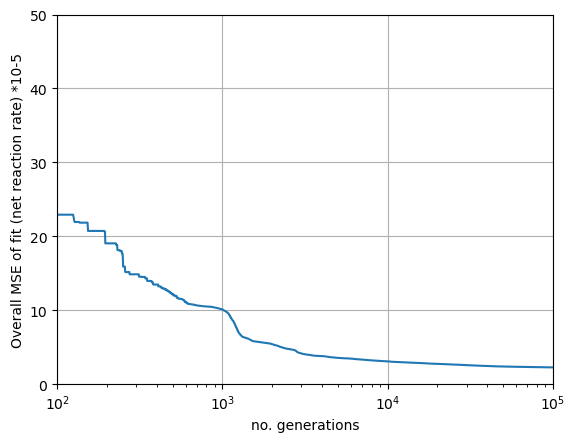

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.196040396278367
1.4694756111982963
0.7633194310507858
-4.207485556458291
0.48617890456870816
4.669099422794323e-06
0.40375438880519504
-4.00525920187922
0.23768512871498898
4.26022093857781
3.198116823324135
3.3620381340285874
0.5635416795489836
0.026725682835212317
2.9139983862642493
1.701746047482348e-05
0.3157149434333075
-11.235260896313974
1.7624442988909623
1.488830335300607
-10.430910231658363
1.0546143548134697
3.4185258380517083
0.01964972239250559
3.689308673802437
3.7628059353351464
1.5643635529159106
8.635457294189003
-9.172023719949747
2.6152395671309137
1.836408275564068
3.2988385340973463
-4.330790249642963
0.5611281135066498
1.0320509238323614
-1.3010295714574815


In [37]:
res.X

array([-1.11960404e+01,  1.46947561e+00,  7.63319431e-01, -4.20748556e+00,
        4.86178905e-01,  4.66909942e-06,  4.03754389e-01, -4.00525920e+00,
        2.37685129e-01,  4.26022094e+00,  3.19811682e+00,  3.36203813e+00,
        5.63541680e-01,  2.67256828e-02,  2.91399839e+00,  1.70174605e-05,
        3.15714943e-01, -1.12352609e+01,  1.76244430e+00,  1.48883034e+00,
       -1.04309102e+01,  1.05461435e+00,  3.41852584e+00,  1.96497224e-02,
        3.68930867e+00,  3.76280594e+00,  1.56436355e+00,  8.63545729e+00,
       -9.17202372e+00,  2.61523957e+00,  1.83640828e+00,  3.29883853e+00,
       -4.33079025e+00,  5.61128114e-01,  1.03205092e+00, -1.30102957e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.196040396278367
1.6: 1.4694756111982963
0.9: 0.7633194310507858
-4.3: -4.207485556458291
0.5: 0.48617890456870816
0.003: 4.669099422794323e-06
0.4: 0.40375438880519504
-7.9: -4.00525920187922
0.7: 0.23768512871498898
7.2: 4.26022093857781
5.7: 3.198116823324135
5.7: 3.3620381340285874
0.8: 0.5635416795489836
0.03: 0.026725682835212317
3.1: 2.9139983862642493
6.000000000000001e-09: 1.701746047482348e-05
0.1: 0.3157149434333075
-12.0: -11.235260896313974
1.9: 1.7624442988909623
1.6: 1.488830335300607
-11.6: -10.430910231658363
1.2: 1.0546143548134697
4.0: 3.4185258380517083
0.01: 0.01964972239250559
4.2: 3.689308673802437
5.4: 3.7628059353351464
2.2: 1.5643635529159106
11.8: 8.635457294189003
-12.0: -9.172023719949747
3.3: 2.6152395671309137
1.8: 1.836408275564068
4.2: 3.2988385340973463
-4.0: -4.330790249642963
0.5: 0.5611281135066498
1.0: 1.0320509238323614
coeff fit: 0.9407706806583809
r: 0.9699333382549447


In [1]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.11960404e+01,  1.46947561e+00,  7.63319431e-01, -4.20748556e+00,
        4.86178905e-01,  4.66909942e-06,  4.03754389e-01, -4.00525920e+00,
        2.37685129e-01,  4.26022094e+00,  3.19811682e+00,  3.36203813e+00,
        5.63541680e-01,  2.67256828e-02,  2.91399839e+00,  1.70174605e-05,
        3.15714943e-01, -1.12352609e+01,  1.76244430e+00,  1.48883034e+00,
       -1.04309102e+01,  1.05461435e+00,  3.41852584e+00,  1.96497224e-02,
        3.68930867e+00,  3.76280594e+00,  1.56436355e+00,  8.63545729e+00,
       -9.17202372e+00,  2.61523957e+00,  1.83640828e+00,  3.29883853e+00,
       -4.33079025e+00,  5.61128114e-01,  1.03205092e+00, -1.30102957e+00]
# np.ndarray.tolist(res.X)
krseed10 = [-1.16441428e+01,  1.54581534e+00,  8.75125868e-01, -4.16196739e+00,
        4.79828840e-01,  2.03661380e-06,  4.04332736e-01, -4.31732298e+00,
        2.71222082e-01,  4.65579306e+00,  3.55243150e+00,  3.71877825e+00,
        6.26069198e-01,  3.34677595e-02,  3.03320608e+00,  9.54532575e-06,
        2.95530740e-01, -1.16710005e+01,  1.84132507e+00,  1.55968044e+00,
       -1.08791978e+01,  1.11086289e+00,  3.73099773e+00,  2.01516196e-02,
        3.92088634e+00,  4.32301874e+00,  1.75402901e+00,  9.62273361e+00,
       -9.71676940e+00,  2.72939439e+00,  1.77508014e+00,  3.47060164e+00,
       -4.29157644e+00,  5.51097449e-01,  1.02525059e+00, -1.30102908e+00]
krseed101 = [-1.16686502e+01,  1.54662039e+00,  8.59320247e-01, -4.18658093e+00,
        4.81211000e-01,  9.92933950e-06,  3.96682797e-01, -5.70046695e+00,
        4.49923658e-01,  5.32800315e+00,  4.04738450e+00,  4.15122470e+00,
        5.66956301e-01,  2.80132325e-02,  2.96389538e+00,  2.30066478e-06,
        3.63932909e-01, -1.12526370e+01,  1.76485669e+00,  1.49034690e+00,
       -1.09051546e+01,  1.10770905e+00,  3.60835321e+00,  5.44299747e-02,
        3.86587280e+00,  3.83932000e+00,  1.31009267e+00,  7.77329370e+00,
       -9.42951610e+00,  2.66828415e+00,  1.74040348e+00,  3.46518217e+00,
       -4.41237679e+00,  5.72455727e-01,  1.03643167e+00, -1.30102983e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9552851820852271
r: 0.9773869152414651
-11.502944466666667
1.5206371133333334
0.8325885153333333
-4.185344626666667
0.48240624833333334
5.545017573333333e-06
0.401589974
-4.67434971
0.31961028966666666
4.748005716666667
3.59931094
3.7440136933333332
0.5855223930000001
0.029402224933333332
2.9703666166666665
9.621150343333333e-06
0.32505953066666665
-11.386299466666665
1.78954202
1.5129525599999998
-10.738420866666667
1.0910620966666666
3.5859589266666667
0.031410438900000004
3.8253559366666665
3.9750482266666665
1.54282841
8.677161533333333
-9.439436406666667
2.6709727033333333
1.7839639666666667
3.4115407799999997
-4.3449144933333335
0.56156043
1.0312443933333333


In [2]:
meankr

[-11.502944466666667,
 1.5206371133333334,
 0.8325885153333333,
 -4.185344626666667,
 0.48240624833333334,
 5.545017573333333e-06,
 0.401589974,
 -4.67434971,
 0.31961028966666666,
 4.748005716666667,
 3.59931094,
 3.7440136933333332,
 0.5855223930000001,
 0.029402224933333332,
 2.9703666166666665,
 9.621150343333333e-06,
 0.32505953066666665,
 -11.386299466666665,
 1.78954202,
 1.5129525599999998,
 -10.738420866666667,
 1.0910620966666666,
 3.5859589266666667,
 0.031410438900000004,
 3.8253559366666665,
 3.9750482266666665,
 1.54282841,
 8.677161533333333,
 -9.439436406666667,
 2.6709727033333333,
 1.7839639666666667,
 3.4115407799999997,
 -4.3449144933333335,
 0.56156043,
 1.0312443933333333]

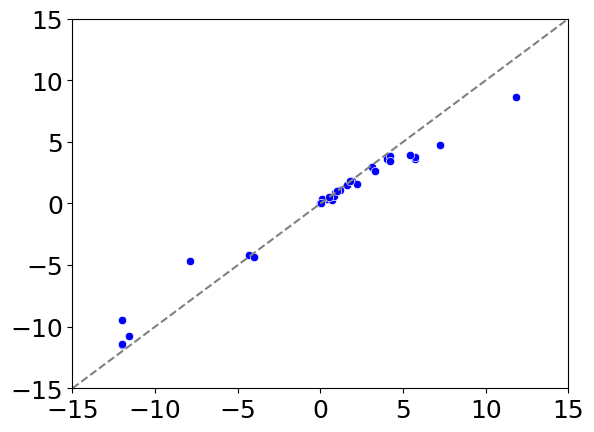

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()
